In [2]:
# Importing libraries and functions

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import calendar
import scipy.stats as st
import os
import warnings
from matplotlib.gridspec import GridSpec
warnings.filterwarnings("ignore")

path = Path(os.getcwd())
maindir = path.parents[0]

execfile(f"{path}/Utilities/functions.py")

In [3]:
datasets(["A", "B", "C", "TRE", "NOY"])

[1/6] Importing power dataset...
[2/6] Site A:
	 Importing ERA5's dataset...
	 Importing lidar and meteo station's datasets...
	 Exporting the dataset...
[3/6] Site B:
	 Importing ERA5's dataset...
	 Importing lidar and meteo station's datasets...
	 Exporting the dataset...
[4/6] Site C:
	 Importing ERA5's dataset...
	 Importing lidar and meteo station's datasets...
	 Exporting the dataset...
[5/6] Site TRE:
	 Importing ERA5's dataset...
	 Importing lidar and meteo station's datasets...
	 Exporting the dataset...
[6/6] Site NOY:
	 Importing ERA5's dataset...
	 Importing lidar and meteo station's datasets...
	 Exporting the dataset...


In [5]:
# Import ML libraries

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time
import hyperopt.pyll
from hyperopt.pyll import scope
from sklearn.model_selection import train_test_split
import catboost
import optuna
from sklearn.metrics import mean_squared_error

heights = [37, 56.5, 78, 96.5, 118, 135, 155, 175, 198]

In [6]:
# Min data sampling

ls_site = ["A", "B", "C", "NOY", "TRE"]

min_len = min(len(globals()[f"df_X_{site}"]) for site in ls_site)

for site in ls_site:
    globals()[f"df_Xy_{site}"] = globals()[f"df_Xy_{site}"].sample(n=min_len)
    globals()[f"df_X_{site}"] = globals()[f"df_Xy_{site}"].loc[:, ~globals()[f"df_Xy_{site}"].columns.str.contains("Average Horizontal Wind Speed")]
    globals()[f"df_y_{site}"] = globals()[f"df_Xy_{site}"].loc[:, globals()[f"df_Xy_{site}"].columns.str.contains("Average Horizontal Wind Speed")]

New site optimizing

In [10]:
# Optimizing

df_X_train = pd.concat([df_X_A, df_X_C, df_X_TRE])
df_y_train = pd.concat([df_y_A, df_y_C, df_y_TRE])

df_X_test = df_X_B
df_y_test = df_y_B


def objective(trial):
    X_train = df_X_train
    X_val = df_X_test
    y_train = df_y_train
    y_val = df_y_test

    param = {
        "iterations" : trial.suggest_int("iterations", 1, 1500),
        "l2_leaf_reg" : trial.suggest_int("l2_leaf_reg", 2, 10),
        "loss_function" : trial.suggest_categorical("loss_function", ["MultiRMSE"]),
        "learning_rate" : trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "max_depth" : trial.suggest_int("max_depth", 1, 15),
        "random_strength" : trial.suggest_loguniform("random_strength", 0.0001, 10.0),
        "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }
    

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_uniform("subsample", 0.1, 1)

    gbm = catboost.CatBoostRegressor(**param, )

    gbm.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 0, early_stopping_rounds = 15)

    predictions = gbm.predict(X_val)
    RMSE = mean_squared_error(y_val, predictions)
    
    return RMSE

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 400, show_progress_bar = True)


print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-31 10:40:25,906] A new study created in memory with name: no-name-f4b1de34-df75-4251-bcc8-b1420ff8972c
  0%|          | 1/400 [00:01<08:48,  1.32s/it]

[I 2022-08-31 10:40:27,233] Trial 0 finished with value: 5.813105582582646 and parameters: {'iterations': 1431, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1491301309332048, 'colsample_bylevel': 0.09897806408069444, 'max_depth': 12, 'random_strength': 0.6137683008946269, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 5.813105582582646.


  0%|          | 2/400 [00:01<05:55,  1.12it/s]

[I 2022-08-31 10:40:27,825] Trial 1 finished with value: 9.47444066244748 and parameters: {'iterations': 238, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.05051460405816166, 'colsample_bylevel': 0.024818564684207338, 'max_depth': 13, 'random_strength': 0.002103800366971705, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 5.813105582582646.


  1%|          | 3/400 [00:02<04:01,  1.64it/s]

[I 2022-08-31 10:40:28,094] Trial 2 finished with value: 16.277161569285163 and parameters: {'iterations': 83, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.008051005100395267, 'colsample_bylevel': 0.0779814074974404, 'max_depth': 1, 'random_strength': 1.2015832617357296, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.49915239753281615}. Best is trial 0 with value: 5.813105582582646.


  1%|          | 4/400 [00:06<12:54,  1.96s/it]

[I 2022-08-31 10:40:32,115] Trial 3 finished with value: 12.448621133697204 and parameters: {'iterations': 554, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.005590781562568672, 'colsample_bylevel': 0.04035627508466542, 'max_depth': 15, 'random_strength': 2.4753187048798426, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8816656236721311}. Best is trial 0 with value: 5.813105582582646.


  1%|▏         | 5/400 [00:06<10:02,  1.52s/it]

[I 2022-08-31 10:40:32,875] Trial 4 finished with value: 5.599328976068442 and parameters: {'iterations': 1458, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20644672062177302, 'colsample_bylevel': 0.030752380798109796, 'max_depth': 10, 'random_strength': 0.07913109748203093, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.7918084165370916}. Best is trial 4 with value: 5.599328976068442.


  2%|▏         | 6/400 [00:19<35:29,  5.40s/it]

[I 2022-08-31 10:40:45,810] Trial 5 finished with value: 8.110674852319875 and parameters: {'iterations': 1436, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.002911735774003779, 'colsample_bylevel': 0.07264844785431841, 'max_depth': 6, 'random_strength': 0.0021106486679194477, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 5.599328976068442.


  2%|▏         | 7/400 [00:25<35:17,  5.39s/it]

[I 2022-08-31 10:40:51,168] Trial 6 finished with value: 6.853628782828756 and parameters: {'iterations': 676, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.00962416063019129, 'colsample_bylevel': 0.07600983145158394, 'max_depth': 4, 'random_strength': 6.017208125305874, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9238375065780818}. Best is trial 4 with value: 5.599328976068442.


  2%|▏         | 8/400 [00:27<28:40,  4.39s/it]

[I 2022-08-31 10:40:53,417] Trial 7 finished with value: 5.377375062130814 and parameters: {'iterations': 825, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07585914643540054, 'colsample_bylevel': 0.06466627884161187, 'max_depth': 5, 'random_strength': 0.0037354472218619726, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5614232436808172}. Best is trial 7 with value: 5.377375062130814.


  2%|▎         | 10/400 [00:30<17:55,  2.76s/it]

[I 2022-08-31 10:40:56,294] Trial 8 finished with value: 8.14728806215144 and parameters: {'iterations': 1062, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.004909384300594472, 'colsample_bylevel': 0.06056221313376033, 'max_depth': 12, 'random_strength': 0.0010507166572736172, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.45966939707170273}. Best is trial 7 with value: 5.377375062130814.
[I 2022-08-31 10:40:56,459] Trial 9 finished with value: 13.463059281360731 and parameters: {'iterations': 50, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15179221703949494, 'colsample_bylevel': 0.020487391680323694, 'max_depth': 15, 'random_strength': 5.1755427221305395, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.419957199212657}. Best is trial 7 with value: 5.377375062130814.


  3%|▎         | 11/400 [00:37<25:45,  3.97s/it]

[I 2022-08-31 10:41:03,183] Trial 10 finished with value: 15.076100234411594 and parameters: {'iterations': 1001, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0010607208605533755, 'colsample_bylevel': 0.049942949426287284, 'max_depth': 7, 'random_strength': 0.00010502003998795306, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1132152882537365}. Best is trial 7 with value: 5.377375062130814.


  3%|▎         | 12/400 [00:39<21:44,  3.36s/it]

[I 2022-08-31 10:41:05,152] Trial 11 finished with value: 5.8773045439631835 and parameters: {'iterations': 1064, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.04683059221151674, 'colsample_bylevel': 0.033028081333544936, 'max_depth': 9, 'random_strength': 0.058926133566188435, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.692227009336793}. Best is trial 7 with value: 5.377375062130814.


  3%|▎         | 13/400 [00:39<15:39,  2.43s/it]

[I 2022-08-31 10:41:05,429] Trial 12 finished with value: 11.666720631856176 and parameters: {'iterations': 422, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25265826129451036, 'colsample_bylevel': 0.011223692485665796, 'max_depth': 9, 'random_strength': 0.05737537428656905, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.351329525332228}. Best is trial 7 with value: 5.377375062130814.


  4%|▎         | 14/400 [00:40<13:35,  2.11s/it]

[I 2022-08-31 10:41:06,816] Trial 13 finished with value: 5.780862150730574 and parameters: {'iterations': 881, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06012394552500499, 'colsample_bylevel': 0.055372096394999265, 'max_depth': 4, 'random_strength': 0.016516674365419495, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.215059471538559}. Best is trial 7 with value: 5.377375062130814.


  4%|▍         | 15/400 [00:47<23:02,  3.59s/it]

[I 2022-08-31 10:41:13,828] Trial 14 finished with value: 5.569139261780164 and parameters: {'iterations': 1270, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.027195095552457117, 'colsample_bylevel': 0.0422355089504398, 'max_depth': 10, 'random_strength': 0.2368942198997456, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.0015894151597892758}. Best is trial 7 with value: 5.377375062130814.


  4%|▍         | 16/400 [00:53<27:15,  4.26s/it]

[I 2022-08-31 10:41:19,645] Trial 15 finished with value: 5.358318134744842 and parameters: {'iterations': 1204, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.022379154729783468, 'colsample_bylevel': 0.06543293127475881, 'max_depth': 5, 'random_strength': 0.40217742076370205, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.675604145408454}. Best is trial 15 with value: 5.358318134744842.


  4%|▍         | 17/400 [00:58<27:17,  4.28s/it]

[I 2022-08-31 10:41:23,957] Trial 16 finished with value: 5.529456688153095 and parameters: {'iterations': 1248, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.026833806654396063, 'colsample_bylevel': 0.08889654382199597, 'max_depth': 4, 'random_strength': 0.015416030315779008, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6784644463566398}. Best is trial 15 with value: 5.358318134744842.


  4%|▍         | 18/400 [01:01<25:02,  3.93s/it]

[I 2022-08-31 10:41:27,092] Trial 17 finished with value: 5.555774481145355 and parameters: {'iterations': 731, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09295237516347973, 'colsample_bylevel': 0.06503922106630682, 'max_depth': 1, 'random_strength': 0.0061042991724996705, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6693013655034319}. Best is trial 15 with value: 5.358318134744842.


  5%|▍         | 19/400 [01:07<30:03,  4.73s/it]

[I 2022-08-31 10:41:33,692] Trial 18 finished with value: 5.692904039706759 and parameters: {'iterations': 904, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.013867338110854032, 'colsample_bylevel': 0.06687896541974367, 'max_depth': 5, 'random_strength': 0.00015802298945239313, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.32243072191520394}. Best is trial 15 with value: 5.358318134744842.


  5%|▌         | 20/400 [01:13<31:21,  4.95s/it]

[I 2022-08-31 10:41:39,146] Trial 19 finished with value: 5.426071468422307 and parameters: {'iterations': 1283, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.02477884282788527, 'colsample_bylevel': 0.08801024403207987, 'max_depth': 2, 'random_strength': 0.2667040674834177, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7161555547741334}. Best is trial 15 with value: 5.358318134744842.


  5%|▌         | 21/400 [01:15<26:44,  4.23s/it]

[I 2022-08-31 10:41:41,708] Trial 20 finished with value: 5.520306390114211 and parameters: {'iterations': 552, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09637303907363236, 'colsample_bylevel': 0.050124766390184976, 'max_depth': 7, 'random_strength': 0.0003967067170221736, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.37282012472708936}. Best is trial 15 with value: 5.358318134744842.


  6%|▌         | 22/400 [01:21<30:06,  4.78s/it]

[I 2022-08-31 10:41:47,761] Trial 21 finished with value: 5.389748835422001 and parameters: {'iterations': 1234, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.023291196296434814, 'colsample_bylevel': 0.08782179852290274, 'max_depth': 2, 'random_strength': 0.26316435539735294, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6740775379955324}. Best is trial 15 with value: 5.358318134744842.


  6%|▌         | 23/400 [01:29<34:57,  5.56s/it]

[I 2022-08-31 10:41:55,153] Trial 22 finished with value: 5.432128326590017 and parameters: {'iterations': 1134, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.016940648812905676, 'colsample_bylevel': 0.08540191475375455, 'max_depth': 3, 'random_strength': 0.21274268404104263, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7679551080225021}. Best is trial 15 with value: 5.358318134744842.


  6%|▌         | 24/400 [01:32<30:15,  4.83s/it]

[I 2022-08-31 10:41:58,271] Trial 23 finished with value: 5.608700843323874 and parameters: {'iterations': 869, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0354632232553898, 'colsample_bylevel': 0.09961660325341731, 'max_depth': 6, 'random_strength': 0.4835295654896129, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6100807282548684}. Best is trial 15 with value: 5.358318134744842.


  6%|▋         | 25/400 [01:34<25:43,  4.12s/it]

[I 2022-08-31 10:42:00,723] Trial 24 finished with value: 5.654577190319756 and parameters: {'iterations': 1186, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08261325016396263, 'colsample_bylevel': 0.0696736646072855, 'max_depth': 3, 'random_strength': 0.007778835786882677, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8139733321614319}. Best is trial 15 with value: 5.358318134744842.


  6%|▋         | 26/400 [01:44<35:23,  5.68s/it]

[I 2022-08-31 10:42:10,042] Trial 25 finished with value: 5.595950391615748 and parameters: {'iterations': 1354, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.013952828383289793, 'colsample_bylevel': 0.07999598086431808, 'max_depth': 2, 'random_strength': 0.10826082817553731, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 5.358318134744842.


  7%|▋         | 27/400 [01:49<35:05,  5.65s/it]

[I 2022-08-31 10:42:15,616] Trial 26 finished with value: 5.6327989361597695 and parameters: {'iterations': 958, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.02203542165771793, 'colsample_bylevel': 0.0613917087567033, 'max_depth': 5, 'random_strength': 0.9808776607873287, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5344933966735524}. Best is trial 15 with value: 5.358318134744842.


  7%|▋         | 28/400 [01:51<28:29,  4.60s/it]

[I 2022-08-31 10:42:17,761] Trial 27 finished with value: 5.449533702598769 and parameters: {'iterations': 1151, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.05785935765243625, 'colsample_bylevel': 0.09419955051471841, 'max_depth': 3, 'random_strength': 0.023608526462347824, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5724678105457827}. Best is trial 15 with value: 5.358318134744842.


  7%|▋         | 29/400 [01:55<25:45,  4.17s/it]

[I 2022-08-31 10:42:20,927] Trial 28 finished with value: 5.601607084611368 and parameters: {'iterations': 840, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.03759139666182833, 'colsample_bylevel': 0.08247651025224681, 'max_depth': 6, 'random_strength': 2.5325370084279437, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8095952041030097}. Best is trial 15 with value: 5.358318134744842.


  8%|▊         | 30/400 [01:55<19:22,  3.14s/it]

[I 2022-08-31 10:42:21,676] Trial 29 finished with value: 5.587369241202623 and parameters: {'iterations': 1379, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15086784339040496, 'colsample_bylevel': 0.09283675942881098, 'max_depth': 5, 'random_strength': 0.6231631986391614, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 5.358318134744842.


  8%|▊         | 31/400 [02:02<26:09,  4.25s/it]

[I 2022-08-31 10:42:28,525] Trial 30 finished with value: 13.289061263611632 and parameters: {'iterations': 1493, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0019976762929690118, 'colsample_bylevel': 0.05706552231847471, 'max_depth': 2, 'random_strength': 0.007036130520277924, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.40985500730669877}. Best is trial 15 with value: 5.358318134744842.


  8%|▊         | 32/400 [02:12<35:38,  5.81s/it]

[I 2022-08-31 10:42:37,972] Trial 31 finished with value: 5.592998178785348 and parameters: {'iterations': 1301, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.01028410632322541, 'colsample_bylevel': 0.08860507224373561, 'max_depth': 2, 'random_strength': 0.18838589768555097, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6997456277967937}. Best is trial 15 with value: 5.358318134744842.


  8%|▊         | 33/400 [02:19<38:22,  6.27s/it]

[I 2022-08-31 10:42:45,321] Trial 32 finished with value: 5.583535686736803 and parameters: {'iterations': 1215, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.022664499060310244, 'colsample_bylevel': 0.07413043762705536, 'max_depth': 1, 'random_strength': 0.5000476547987743, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.627487014292925}. Best is trial 15 with value: 5.358318134744842.


  8%|▊         | 34/400 [02:22<32:53,  5.39s/it]

[I 2022-08-31 10:42:48,659] Trial 33 finished with value: 5.464571341191701 and parameters: {'iterations': 1055, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.03915935145665492, 'colsample_bylevel': 0.09394487756102177, 'max_depth': 2, 'random_strength': 1.7080749828007389, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 5.358318134744842.


  9%|▉         | 35/400 [02:25<27:53,  4.58s/it]

[I 2022-08-31 10:42:51,357] Trial 34 finished with value: 10.472411092763004 and parameters: {'iterations': 312, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.00742774372447883, 'colsample_bylevel': 0.08232127558347833, 'max_depth': 3, 'random_strength': 0.03460459139383038, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7414999578972272}. Best is trial 15 with value: 5.358318134744842.


  9%|▉         | 36/400 [02:27<23:23,  3.86s/it]

[I 2022-08-31 10:42:53,512] Trial 35 finished with value: 5.636191558778986 and parameters: {'iterations': 1341, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07338784195614566, 'colsample_bylevel': 0.0707456879529716, 'max_depth': 7, 'random_strength': 0.32747941669601655, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9780899827829288}. Best is trial 15 with value: 5.358318134744842.


  9%|▉         | 37/400 [02:29<20:00,  3.31s/it]

[I 2022-08-31 10:42:55,542] Trial 36 finished with value: 7.471545034155377 and parameters: {'iterations': 791, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.017618831637998992, 'colsample_bylevel': 0.048815785354324286, 'max_depth': 1, 'random_strength': 0.11912160694481433, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5859708516625354}. Best is trial 15 with value: 5.358318134744842.


 10%|▉         | 38/400 [02:33<21:05,  3.49s/it]

[I 2022-08-31 10:42:59,473] Trial 37 finished with value: 5.589359023233851 and parameters: {'iterations': 663, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.032972185351923186, 'colsample_bylevel': 0.07801461319914571, 'max_depth': 4, 'random_strength': 0.0013960263214433514, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 5.358318134744842.


 10%|▉         | 39/400 [02:35<17:30,  2.91s/it]

[I 2022-08-31 10:43:01,019] Trial 38 finished with value: 15.026908745011532 and parameters: {'iterations': 180, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.004531557950062864, 'colsample_bylevel': 0.06328090097955914, 'max_depth': 8, 'random_strength': 1.0768008501600235, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7346971949355514}. Best is trial 15 with value: 5.358318134744842.


 10%|█         | 40/400 [02:38<17:45,  2.96s/it]

[I 2022-08-31 10:43:04,092] Trial 39 finished with value: 5.570192454314071 and parameters: {'iterations': 1116, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.012196375787164673, 'colsample_bylevel': 0.07559039752993499, 'max_depth': 5, 'random_strength': 0.002463340606052047, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6496053099330912}. Best is trial 15 with value: 5.358318134744842.


 10%|█         | 41/400 [02:39<15:02,  2.51s/it]

[I 2022-08-31 10:43:05,570] Trial 40 finished with value: 5.587326342714034 and parameters: {'iterations': 1434, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1133213571777886, 'colsample_bylevel': 0.08629630453554343, 'max_depth': 3, 'random_strength': 3.5530197119273312, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8395470864600381}. Best is trial 15 with value: 5.358318134744842.


 10%|█         | 42/400 [02:46<23:10,  3.88s/it]

[I 2022-08-31 10:43:12,645] Trial 41 finished with value: 5.4335902963083775 and parameters: {'iterations': 985, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.017669669863134223, 'colsample_bylevel': 0.08473359470634959, 'max_depth': 3, 'random_strength': 0.20953256631214043, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.75059218151566}. Best is trial 15 with value: 5.358318134744842.


 11%|█         | 43/400 [02:55<31:37,  5.31s/it]

[I 2022-08-31 10:43:21,299] Trial 42 finished with value: 5.956734035932734 and parameters: {'iterations': 1124, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.00822413188010002, 'colsample_bylevel': 0.09157386237865633, 'max_depth': 2, 'random_strength': 0.1479321619065464, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7554694827479306}. Best is trial 15 with value: 5.358318134744842.


 11%|█         | 44/400 [03:00<31:28,  5.31s/it]

[I 2022-08-31 10:43:26,585] Trial 43 finished with value: 5.541924150357137 and parameters: {'iterations': 1193, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.020852742027590535, 'colsample_bylevel': 0.09649091354673744, 'max_depth': 4, 'random_strength': 0.36592887430887394, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5338078405959898}. Best is trial 15 with value: 5.358318134744842.


 11%|█▏        | 45/400 [03:05<29:40,  5.01s/it]

[I 2022-08-31 10:43:30,919] Trial 44 finished with value: 5.473895948020594 and parameters: {'iterations': 1303, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.04833796259510277, 'colsample_bylevel': 0.07944048784068856, 'max_depth': 1, 'random_strength': 0.043901275635988675, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4871485042144694}. Best is trial 15 with value: 5.358318134744842.


 12%|█▏        | 46/400 [03:06<23:38,  4.01s/it]

[I 2022-08-31 10:43:32,575] Trial 45 finished with value: 5.495184271139333 and parameters: {'iterations': 1394, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.027638499336498822, 'colsample_bylevel': 0.06888941597184646, 'max_depth': 4, 'random_strength': 0.09038425430402133, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6906397485524212}. Best is trial 15 with value: 5.358318134744842.


 12%|█▏        | 47/400 [03:15<31:23,  5.34s/it]

[I 2022-08-31 10:43:41,015] Trial 46 finished with value: 5.931880411003127 and parameters: {'iterations': 1086, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.015681963018344548, 'colsample_bylevel': 0.058799316182078024, 'max_depth': 12, 'random_strength': 0.8053287076648735, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.363159868027777}. Best is trial 15 with value: 5.358318134744842.


 12%|█▏        | 48/400 [03:24<38:47,  6.61s/it]

[I 2022-08-31 10:43:50,604] Trial 47 finished with value: 6.26090925511506 and parameters: {'iterations': 1026, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.005860870131206809, 'colsample_bylevel': 0.08752707776007215, 'max_depth': 6, 'random_strength': 0.29802934557615784, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7989217296806501}. Best is trial 15 with value: 5.358318134744842.


 12%|█▏        | 49/400 [03:34<44:32,  7.61s/it]

[I 2022-08-31 10:44:00,555] Trial 48 finished with value: 7.156658035682777 and parameters: {'iterations': 1249, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.011276321172088271, 'colsample_bylevel': 0.03903187747398148, 'max_depth': 3, 'random_strength': 0.003480521420120391, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 5.358318134744842.


 12%|█▎        | 50/400 [03:35<32:04,  5.50s/it]

[I 2022-08-31 10:44:01,119] Trial 49 finished with value: 6.08911458507391 and parameters: {'iterations': 932, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21261804860700098, 'colsample_bylevel': 0.09706294007111695, 'max_depth': 2, 'random_strength': 0.0008112333709907186, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.153405730602724}. Best is trial 15 with value: 5.358318134744842.


 13%|█▎        | 51/400 [03:37<27:01,  4.65s/it]

[I 2022-08-31 10:44:03,776] Trial 50 finished with value: 5.745332840722 and parameters: {'iterations': 656, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06507739671345857, 'colsample_bylevel': 0.0523996597912053, 'max_depth': 13, 'random_strength': 0.07171327535236406, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8646589263450073}. Best is trial 15 with value: 5.358318134744842.


 13%|█▎        | 52/400 [03:44<30:00,  5.17s/it]

[I 2022-08-31 10:44:10,180] Trial 51 finished with value: 5.4509474477800275 and parameters: {'iterations': 985, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.019382274803893696, 'colsample_bylevel': 0.08431407646923617, 'max_depth': 3, 'random_strength': 0.22638823282196502, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.771981975832181}. Best is trial 15 with value: 5.358318134744842.


 13%|█▎        | 53/400 [03:47<26:56,  4.66s/it]

[I 2022-08-31 10:44:13,639] Trial 52 finished with value: 5.533296432667482 and parameters: {'iterations': 1155, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.030459867495316446, 'colsample_bylevel': 0.09072435950424257, 'max_depth': 5, 'random_strength': 1.5783692019398514, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6980507471721598}. Best is trial 15 with value: 5.358318134744842.


 14%|█▎        | 54/400 [03:53<28:28,  4.94s/it]

[I 2022-08-31 10:44:19,226] Trial 53 finished with value: 5.609808767951059 and parameters: {'iterations': 1004, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.016911423838331364, 'colsample_bylevel': 0.08442508113837154, 'max_depth': 4, 'random_strength': 0.18003593110145538, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9056812489570216}. Best is trial 15 with value: 5.358318134744842.


 14%|█▍        | 55/400 [03:58<28:12,  4.91s/it]

[I 2022-08-31 10:44:24,060] Trial 54 finished with value: 5.555664777663079 and parameters: {'iterations': 809, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.041919622378979844, 'colsample_bylevel': 0.07329735902053561, 'max_depth': 1, 'random_strength': 8.603071609221162, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6293686273886137}. Best is trial 15 with value: 5.358318134744842.


 14%|█▍        | 56/400 [04:08<36:43,  6.40s/it]

[I 2022-08-31 10:44:33,961] Trial 55 finished with value: 5.519484810707992 and parameters: {'iterations': 1214, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.013894722179195185, 'colsample_bylevel': 0.06629034898104447, 'max_depth': 3, 'random_strength': 0.014929595646857585, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7320131554342666}. Best is trial 15 with value: 5.358318134744842.


 14%|█▍        | 57/400 [04:08<27:10,  4.75s/it]

[I 2022-08-31 10:44:34,866] Trial 56 finished with value: 5.475938358953287 and parameters: {'iterations': 928, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29807552176952434, 'colsample_bylevel': 0.07680669018343385, 'max_depth': 2, 'random_strength': 0.6072208220034265, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6520606451468944}. Best is trial 15 with value: 5.358318134744842.


 14%|█▍        | 58/400 [04:13<26:40,  4.68s/it]

[I 2022-08-31 10:44:39,366] Trial 57 finished with value: 5.585717534379219 and parameters: {'iterations': 722, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.025169569908725327, 'colsample_bylevel': 0.08161607219152885, 'max_depth': 5, 'random_strength': 0.055343697736745905, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.776718808953613}. Best is trial 15 with value: 5.358318134744842.


 15%|█▍        | 59/400 [04:18<27:53,  4.91s/it]

[I 2022-08-31 10:44:44,808] Trial 58 finished with value: 7.009497744953161 and parameters: {'iterations': 559, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0079803501578739, 'colsample_bylevel': 0.09952699529604946, 'max_depth': 6, 'random_strength': 0.40298332479568105, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.608937546229792}. Best is trial 15 with value: 5.358318134744842.


 15%|█▌        | 60/400 [04:20<22:45,  4.02s/it]

[I 2022-08-31 10:44:46,747] Trial 59 finished with value: 5.4946144883593036 and parameters: {'iterations': 1085, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11803264953980883, 'colsample_bylevel': 0.04542405366273443, 'max_depth': 4, 'random_strength': 0.13385720081580732, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7167935302485628}. Best is trial 15 with value: 5.358318134744842.


 15%|█▌        | 61/400 [04:21<17:08,  3.03s/it]

[I 2022-08-31 10:44:47,488] Trial 60 finished with value: 5.617621911033918 and parameters: {'iterations': 1275, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.04912628735955634, 'colsample_bylevel': 0.08574360108199192, 'max_depth': 8, 'random_strength': 0.026433228309951318, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.26489529642301857}. Best is trial 15 with value: 5.358318134744842.


 16%|█▌        | 62/400 [04:25<18:58,  3.37s/it]

[I 2022-08-31 10:44:51,638] Trial 61 finished with value: 5.513950610341826 and parameters: {'iterations': 1158, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.023754691221249888, 'colsample_bylevel': 0.09589571296298185, 'max_depth': 3, 'random_strength': 0.023269352456089513, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5743895573982306}. Best is trial 15 with value: 5.358318134744842.


 16%|█▌        | 63/400 [04:27<16:05,  2.86s/it]

[I 2022-08-31 10:44:53,324] Trial 62 finished with value: 5.643571965208883 and parameters: {'iterations': 1328, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.05837524953008804, 'colsample_bylevel': 0.09045960090446453, 'max_depth': 3, 'random_strength': 0.01139204830319958, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.585018334057268}. Best is trial 15 with value: 5.358318134744842.


 16%|█▌        | 64/400 [04:30<16:51,  3.01s/it]

[I 2022-08-31 10:44:56,676] Trial 63 finished with value: 5.503464438293744 and parameters: {'iterations': 1145, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.03325608672325695, 'colsample_bylevel': 0.09351611475881617, 'max_depth': 2, 'random_strength': 0.004208265132650276, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5221100123193847}. Best is trial 15 with value: 5.358318134744842.


 16%|█▋        | 65/400 [04:34<17:17,  3.10s/it]

[I 2022-08-31 10:44:59,975] Trial 64 finished with value: 5.5316839771881146 and parameters: {'iterations': 1250, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.05509870840108364, 'colsample_bylevel': 0.08963957120051148, 'max_depth': 1, 'random_strength': 0.2328506875896431, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6688336314568629}. Best is trial 15 with value: 5.358318134744842.


 16%|█▋        | 66/400 [04:36<15:47,  2.84s/it]

[I 2022-08-31 10:45:02,200] Trial 65 finished with value: 5.726088338223835 and parameters: {'iterations': 1021, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07677662889767314, 'colsample_bylevel': 0.072113046516348, 'max_depth': 4, 'random_strength': 0.0004445771737099918, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4670510919083217}. Best is trial 15 with value: 5.358318134744842.


 17%|█▋        | 67/400 [04:40<18:26,  3.32s/it]

[I 2022-08-31 10:45:06,657] Trial 66 finished with value: 10.069587202295446 and parameters: {'iterations': 962, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.01840412937596243, 'colsample_bylevel': 0.022304357403006812, 'max_depth': 2, 'random_strength': 0.0778544163144194, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 5.358318134744842.


 17%|█▋        | 68/400 [04:43<17:03,  3.08s/it]

[I 2022-08-31 10:45:09,182] Trial 67 finished with value: 5.624145180687245 and parameters: {'iterations': 1206, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.04019696943280783, 'colsample_bylevel': 0.08024810559653997, 'max_depth': 5, 'random_strength': 0.8643015160529102, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6101981840472277}. Best is trial 15 with value: 5.358318134744842.


 17%|█▋        | 69/400 [04:44<13:08,  2.38s/it]

[I 2022-08-31 10:45:09,930] Trial 68 finished with value: 16.75614096836956 and parameters: {'iterations': 867, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.013690061968457326, 'colsample_bylevel': 0.011036810850959797, 'max_depth': 3, 'random_strength': 1.603804125079134, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5687882153168226}. Best is trial 15 with value: 5.358318134744842.


 18%|█▊        | 70/400 [04:49<18:02,  3.28s/it]

[I 2022-08-31 10:45:15,306] Trial 69 finished with value: 5.4925020737822825 and parameters: {'iterations': 1368, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.029429902552474907, 'colsample_bylevel': 0.06160272203187623, 'max_depth': 2, 'random_strength': 0.03417093198402945, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4320953608920134}. Best is trial 15 with value: 5.358318134744842.


 18%|█▊        | 71/400 [04:58<26:47,  4.88s/it]

[I 2022-08-31 10:45:23,934] Trial 70 finished with value: 5.630459895821506 and parameters: {'iterations': 1469, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.010188600301141179, 'colsample_bylevel': 0.09468346412238875, 'max_depth': 6, 'random_strength': 0.2704617612666673, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8202378471328587}. Best is trial 15 with value: 5.358318134744842.


 18%|█▊        | 72/400 [05:02<26:32,  4.86s/it]

[I 2022-08-31 10:45:28,722] Trial 71 finished with value: 5.529024532805781 and parameters: {'iterations': 1055, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.021672232326208116, 'colsample_bylevel': 0.0849056237397768, 'max_depth': 3, 'random_strength': 0.17019330103613828, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.753465409198561}. Best is trial 15 with value: 5.358318134744842.


 18%|█▊        | 73/400 [05:10<30:49,  5.66s/it]

[I 2022-08-31 10:45:36,242] Trial 72 finished with value: 5.31194125625731 and parameters: {'iterations': 973, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.018092524793683375, 'colsample_bylevel': 0.08346522548917645, 'max_depth': 3, 'random_strength': 0.2252388226913933, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7801922388709784}. Best is trial 72 with value: 5.31194125625731.


 18%|█▊        | 74/400 [05:18<35:12,  6.48s/it]

[I 2022-08-31 10:45:44,645] Trial 73 finished with value: 5.487498126038737 and parameters: {'iterations': 1087, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.012464228668994767, 'colsample_bylevel': 0.08743375750739837, 'max_depth': 4, 'random_strength': 0.1066124207594889, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8509579717132594}. Best is trial 72 with value: 5.31194125625731.


 19%|█▉        | 75/400 [05:25<35:28,  6.55s/it]

[I 2022-08-31 10:45:51,362] Trial 74 finished with value: 5.560862153210906 and parameters: {'iterations': 775, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.016174865796117103, 'colsample_bylevel': 0.07794577380323071, 'max_depth': 7, 'random_strength': 0.7442882400622196, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6712969838843871}. Best is trial 72 with value: 5.31194125625731.


 19%|█▉        | 76/400 [05:27<28:21,  5.25s/it]

[I 2022-08-31 10:45:53,583] Trial 75 finished with value: 5.576336639990618 and parameters: {'iterations': 896, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1029849144763783, 'colsample_bylevel': 0.08172929062657422, 'max_depth': 1, 'random_strength': 0.3982607837155143, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7982127320418126}. Best is trial 72 with value: 5.31194125625731.


 19%|█▉        | 77/400 [05:31<25:46,  4.79s/it]

[I 2022-08-31 10:45:57,290] Trial 76 finished with value: 5.580587674296598 and parameters: {'iterations': 1127, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.025269471789830848, 'colsample_bylevel': 0.09149572287621867, 'max_depth': 4, 'random_strength': 0.5359038115386439, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.4942219807735717}. Best is trial 72 with value: 5.31194125625731.


 20%|█▉        | 78/400 [05:31<18:52,  3.52s/it]

[I 2022-08-31 10:45:57,837] Trial 77 finished with value: 5.25610691542151 and parameters: {'iterations': 844, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13054293385333032, 'colsample_bylevel': 0.07460948853109262, 'max_depth': 3, 'random_strength': 0.05754860462909986, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7206813516917911}. Best is trial 77 with value: 5.25610691542151.


 20%|█▉        | 79/400 [05:32<13:53,  2.60s/it]

[I 2022-08-31 10:45:58,292] Trial 78 finished with value: 5.478504225423735 and parameters: {'iterations': 854, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17478499731874395, 'colsample_bylevel': 0.06764341529992689, 'max_depth': 2, 'random_strength': 0.05337626473602531, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 77 with value: 5.25610691542151.


 20%|██        | 80/400 [05:34<13:20,  2.50s/it]

[I 2022-08-31 10:46:00,572] Trial 79 finished with value: 10.80175379086887 and parameters: {'iterations': 826, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.002790470457829473, 'colsample_bylevel': 0.06425099587704548, 'max_depth': 9, 'random_strength': 0.1256798588575339, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7077579116714394}. Best is trial 77 with value: 5.25610691542151.


 20%|██        | 81/400 [05:37<13:46,  2.59s/it]

[I 2022-08-31 10:46:03,366] Trial 80 finished with value: 6.287609202734651 and parameters: {'iterations': 936, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.008966359416658833, 'colsample_bylevel': 0.07591323198835372, 'max_depth': 5, 'random_strength': 0.21338976279742694, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7735502300816472}. Best is trial 77 with value: 5.25610691542151.


 20%|██        | 82/400 [05:38<10:43,  2.02s/it]

[I 2022-08-31 10:46:04,065] Trial 81 finished with value: 5.439814540176638 and parameters: {'iterations': 1179, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06938575836346113, 'colsample_bylevel': 0.08360843498007922, 'max_depth': 3, 'random_strength': 0.285214067536684, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.618663856872711}. Best is trial 77 with value: 5.25610691542151.


 21%|██        | 83/400 [05:38<08:11,  1.55s/it]

[I 2022-08-31 10:46:04,515] Trial 82 finished with value: 5.1324149802718235 and parameters: {'iterations': 752, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13252849671085756, 'colsample_bylevel': 0.08335113844864939, 'max_depth': 2, 'random_strength': 0.27354707116976806, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6354163764559962}. Best is trial 82 with value: 5.1324149802718235.


 21%|██        | 84/400 [05:39<06:36,  1.25s/it]

[I 2022-08-31 10:46:05,079] Trial 83 finished with value: 5.950630151709482 and parameters: {'iterations': 751, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16655768049295083, 'colsample_bylevel': 0.07492829036104282, 'max_depth': 2, 'random_strength': 0.46503024017213596, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7249967033469029}. Best is trial 82 with value: 5.1324149802718235.


 21%|██▏       | 85/400 [05:39<05:35,  1.07s/it]

[I 2022-08-31 10:46:05,703] Trial 84 finished with value: 5.579590307129795 and parameters: {'iterations': 700, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1354119068678428, 'colsample_bylevel': 0.08000947752852851, 'max_depth': 1, 'random_strength': 0.09668476116027237, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6578624281967074}. Best is trial 82 with value: 5.1324149802718235.


 22%|██▏       | 86/400 [05:42<07:27,  1.43s/it]

[I 2022-08-31 10:46:07,971] Trial 85 finished with value: 14.983534901924136 and parameters: {'iterations': 772, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0010208756864740968, 'colsample_bylevel': 0.06963538369742614, 'max_depth': 3, 'random_strength': 0.15548027977403642, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6871946149155518}. Best is trial 82 with value: 5.1324149802718235.


 22%|██▏       | 87/400 [05:43<07:45,  1.49s/it]

[I 2022-08-31 10:46:09,602] Trial 86 finished with value: 6.154548186343096 and parameters: {'iterations': 585, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0198619056061803, 'colsample_bylevel': 0.07875722661906902, 'max_depth': 2, 'random_strength': 0.3134026763947946, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.74902033646388}. Best is trial 82 with value: 5.1324149802718235.


 22%|██▏       | 88/400 [05:44<06:25,  1.23s/it]

[I 2022-08-31 10:46:10,244] Trial 87 finished with value: 5.347587108198528 and parameters: {'iterations': 897, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08758260298280522, 'colsample_bylevel': 0.0724664905632886, 'max_depth': 4, 'random_strength': 1.1930015569521657, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6405235264136364}. Best is trial 82 with value: 5.1324149802718235.


 22%|██▏       | 89/400 [05:46<07:29,  1.44s/it]

[I 2022-08-31 10:46:12,178] Trial 88 finished with value: 5.386497618646282 and parameters: {'iterations': 886, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.086376911115449, 'colsample_bylevel': 0.05708380936644186, 'max_depth': 4, 'random_strength': 2.618541634755138, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6371973305389037}. Best is trial 82 with value: 5.1324149802718235.


 22%|██▎       | 90/400 [05:48<08:32,  1.65s/it]

[I 2022-08-31 10:46:14,316] Trial 89 finished with value: 5.355046981618597 and parameters: {'iterations': 603, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08598516910712521, 'colsample_bylevel': 0.059435107894626686, 'max_depth': 4, 'random_strength': 1.9195884882900016, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6334147143216751}. Best is trial 82 with value: 5.1324149802718235.


 23%|██▎       | 91/400 [05:49<07:23,  1.43s/it]

[I 2022-08-31 10:46:15,242] Trial 90 finished with value: 5.808168104519806 and parameters: {'iterations': 401, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08731173078052726, 'colsample_bylevel': 0.06230698310285135, 'max_depth': 5, 'random_strength': 3.569358439959102, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.289183672196216}. Best is trial 82 with value: 5.1324149802718235.


 23%|██▎       | 92/400 [05:49<06:05,  1.19s/it]

[I 2022-08-31 10:46:15,853] Trial 91 finished with value: 5.496795966719371 and parameters: {'iterations': 490, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13805180985219453, 'colsample_bylevel': 0.05831021984151716, 'max_depth': 4, 'random_strength': 2.643247362377748, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6346664972440611}. Best is trial 82 with value: 5.1324149802718235.


 23%|██▎       | 93/400 [05:51<05:59,  1.17s/it]

[I 2022-08-31 10:46:16,982] Trial 92 finished with value: 5.549316832852726 and parameters: {'iterations': 594, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10233339467935204, 'colsample_bylevel': 0.05325248866562967, 'max_depth': 4, 'random_strength': 1.3289000666220867, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5520965771637987}. Best is trial 82 with value: 5.1324149802718235.


 24%|██▎       | 94/400 [05:51<05:17,  1.04s/it]

[I 2022-08-31 10:46:17,712] Trial 93 finished with value: 5.287861885185555 and parameters: {'iterations': 687, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12339587300159482, 'colsample_bylevel': 0.05529349098030507, 'max_depth': 4, 'random_strength': 4.3776366587955815, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5956669891805274}. Best is trial 82 with value: 5.1324149802718235.


 24%|██▍       | 95/400 [05:52<04:41,  1.08it/s]

[I 2022-08-31 10:46:18,363] Trial 94 finished with value: 5.640148237354943 and parameters: {'iterations': 812, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12074431744112532, 'colsample_bylevel': 0.05508519406509793, 'max_depth': 5, 'random_strength': 5.2694905422047995, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5981493022546561}. Best is trial 82 with value: 5.1324149802718235.


 24%|██▍       | 96/400 [05:53<04:12,  1.20it/s]

[I 2022-08-31 10:46:18,983] Trial 95 finished with value: 5.447677831556299 and parameters: {'iterations': 682, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17438032664710637, 'colsample_bylevel': 0.05838059321622417, 'max_depth': 6, 'random_strength': 2.203717929308249, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.608949427221258}. Best is trial 82 with value: 5.1324149802718235.


 24%|██▍       | 97/400 [05:53<03:42,  1.36it/s]

[I 2022-08-31 10:46:19,493] Trial 96 finished with value: 5.430829465605113 and parameters: {'iterations': 616, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20630585906449075, 'colsample_bylevel': 0.05978658700292087, 'max_depth': 4, 'random_strength': 7.814017041597258, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6451530674493695}. Best is trial 82 with value: 5.1324149802718235.


 24%|██▍       | 98/400 [05:54<03:31,  1.43it/s]

[I 2022-08-31 10:46:20,108] Trial 97 finished with value: 5.489507560438856 and parameters: {'iterations': 747, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09038331695618662, 'colsample_bylevel': 0.06520219696815889, 'max_depth': 4, 'random_strength': 3.3873462170402537, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5103680700277352}. Best is trial 82 with value: 5.1324149802718235.


 25%|██▍       | 99/400 [05:54<03:01,  1.66it/s]

[I 2022-08-31 10:46:20,484] Trial 98 finished with value: 5.511548521210001 and parameters: {'iterations': 891, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20470249368405724, 'colsample_bylevel': 0.07142934824777308, 'max_depth': 5, 'random_strength': 1.1858040337269313, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5573183929484786}. Best is trial 82 with value: 5.1324149802718235.


 25%|██▌       | 100/400 [05:55<03:45,  1.33it/s]

[I 2022-08-31 10:46:21,580] Trial 99 finished with value: 5.3896190373804265 and parameters: {'iterations': 649, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07974892760184411, 'colsample_bylevel': 0.047934762323290685, 'max_depth': 4, 'random_strength': 2.071502136300163, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6842809047377435}. Best is trial 82 with value: 5.1324149802718235.


 25%|██▌       | 101/400 [05:56<04:33,  1.09it/s]

[I 2022-08-31 10:46:22,882] Trial 100 finished with value: 5.513098515261054 and parameters: {'iterations': 631, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06509429301922742, 'colsample_bylevel': 0.049577799963150954, 'max_depth': 4, 'random_strength': 2.20840948245348, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 82 with value: 5.1324149802718235.


 26%|██▌       | 102/400 [05:57<04:19,  1.15it/s]

[I 2022-08-31 10:46:23,645] Trial 101 finished with value: 5.383456158554968 and parameters: {'iterations': 507, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10362869994365842, 'colsample_bylevel': 0.056056142476544335, 'max_depth': 3, 'random_strength': 6.282697032447224, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6723425169731431}. Best is trial 82 with value: 5.1324149802718235.


 26%|██▌       | 103/400 [05:58<04:09,  1.19it/s]

[I 2022-08-31 10:46:24,421] Trial 102 finished with value: 5.472068494392866 and parameters: {'iterations': 503, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08240444773045504, 'colsample_bylevel': 0.05644416924916008, 'max_depth': 3, 'random_strength': 6.638628119832573, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6811929553768316}. Best is trial 82 with value: 5.1324149802718235.


 26%|██▌       | 104/400 [05:59<04:00,  1.23it/s]

[I 2022-08-31 10:46:25,165] Trial 103 finished with value: 5.265505420738223 and parameters: {'iterations': 499, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11855125482615825, 'colsample_bylevel': 0.045838502323495185, 'max_depth': 4, 'random_strength': 3.7740766618609514, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6357199728672135}. Best is trial 82 with value: 5.1324149802718235.


 26%|██▋       | 105/400 [06:00<04:03,  1.21it/s]

[I 2022-08-31 10:46:26,025] Trial 104 finished with value: 5.434862949487748 and parameters: {'iterations': 373, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12682519193010888, 'colsample_bylevel': 0.03831828105478259, 'max_depth': 5, 'random_strength': 4.386436439933231, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6446075369669771}. Best is trial 82 with value: 5.1324149802718235.


 26%|██▋       | 106/400 [06:00<04:00,  1.22it/s]

[I 2022-08-31 10:46:26,823] Trial 105 finished with value: 5.698524067413136 and parameters: {'iterations': 468, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10217425728807249, 'colsample_bylevel': 0.05239711773527615, 'max_depth': 15, 'random_strength': 9.819208085972031, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6008667056379371}. Best is trial 82 with value: 5.1324149802718235.


 27%|██▋       | 107/400 [06:01<03:42,  1.31it/s]

[I 2022-08-31 10:46:27,450] Trial 106 finished with value: 5.561659376337505 and parameters: {'iterations': 528, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15285391676348206, 'colsample_bylevel': 0.04490890616179386, 'max_depth': 3, 'random_strength': 4.0487248622576315, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6272174624031739}. Best is trial 82 with value: 5.1324149802718235.


 27%|██▋       | 108/400 [06:02<03:21,  1.45it/s]

[I 2022-08-31 10:46:27,977] Trial 107 finished with value: 5.45646755981742 and parameters: {'iterations': 712, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11066688992305744, 'colsample_bylevel': 0.06035846711267828, 'max_depth': 4, 'random_strength': 6.166415111932544, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.538946292775871}. Best is trial 82 with value: 5.1324149802718235.


 27%|██▋       | 109/400 [06:02<03:04,  1.57it/s]

[I 2022-08-31 10:46:28,484] Trial 108 finished with value: 5.739990673797996 and parameters: {'iterations': 837, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25153485500474226, 'colsample_bylevel': 0.05380743730068168, 'max_depth': 4, 'random_strength': 3.0838781640466446, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.585258500053362}. Best is trial 82 with value: 5.1324149802718235.


 28%|██▊       | 110/400 [06:03<03:22,  1.43it/s]

[I 2022-08-31 10:46:29,326] Trial 109 finished with value: 5.767188456615606 and parameters: {'iterations': 340, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0944845963336771, 'colsample_bylevel': 0.029212647612185595, 'max_depth': 5, 'random_strength': 4.460534471319852, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.14017908208010765}. Best is trial 82 with value: 5.1324149802718235.


 28%|██▊       | 111/400 [06:03<02:58,  1.62it/s]

[I 2022-08-31 10:46:29,754] Trial 110 finished with value: 5.771921793830213 and parameters: {'iterations': 470, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14411052951331524, 'colsample_bylevel': 0.05639903141894823, 'max_depth': 11, 'random_strength': 2.827273898753402, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7050058565446022}. Best is trial 82 with value: 5.1324149802718235.


 28%|██▊       | 112/400 [06:04<03:14,  1.48it/s]

[I 2022-08-31 10:46:30,564] Trial 111 finished with value: 5.49634165288718 and parameters: {'iterations': 650, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11094884920282938, 'colsample_bylevel': 0.046323570701475296, 'max_depth': 3, 'random_strength': 1.6928754695961163, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6634888950087986}. Best is trial 82 with value: 5.1324149802718235.


 28%|██▊       | 113/400 [06:05<03:56,  1.21it/s]

[I 2022-08-31 10:46:31,741] Trial 112 finished with value: 5.2261101972295965 and parameters: {'iterations': 550, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07875692692802871, 'colsample_bylevel': 0.047194604923439624, 'max_depth': 4, 'random_strength': 2.413343715111347, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6824274085058423}. Best is trial 82 with value: 5.1324149802718235.


 28%|██▊       | 114/400 [06:06<03:12,  1.48it/s]

[I 2022-08-31 10:46:32,063] Trial 113 finished with value: 10.529582608033259 and parameters: {'iterations': 545, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07179199073542325, 'colsample_bylevel': 0.041143129628844866, 'max_depth': 3, 'random_strength': 5.010336944077358, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6359256088147893}. Best is trial 82 with value: 5.1324149802718235.


 29%|██▉       | 115/400 [06:06<02:52,  1.65it/s]

[I 2022-08-31 10:46:32,508] Trial 114 finished with value: 5.627303043107548 and parameters: {'iterations': 597, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09137217296704822, 'colsample_bylevel': 0.06336341216449302, 'max_depth': 4, 'random_strength': 1.3362411958587241, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7126056834352066}. Best is trial 82 with value: 5.1324149802718235.


 29%|██▉       | 116/400 [06:07<03:32,  1.34it/s]

[I 2022-08-31 10:46:33,589] Trial 115 finished with value: 5.633624506913559 and parameters: {'iterations': 787, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.05494350729516181, 'colsample_bylevel': 0.051892769075764254, 'max_depth': 5, 'random_strength': 0.9831913513428041, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.660936803574687}. Best is trial 82 with value: 5.1324149802718235.


 29%|██▉       | 117/400 [06:08<03:19,  1.42it/s]

[I 2022-08-31 10:46:34,190] Trial 116 finished with value: 5.967273646544594 and parameters: {'iterations': 450, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1252591036997761, 'colsample_bylevel': 0.042855169317042016, 'max_depth': 3, 'random_strength': 7.265197065813732, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5967060859374836}. Best is trial 82 with value: 5.1324149802718235.


 30%|██▉       | 118/400 [06:09<03:59,  1.18it/s]

[I 2022-08-31 10:46:35,384] Trial 117 finished with value: 5.741553075244674 and parameters: {'iterations': 682, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0626519523543518, 'colsample_bylevel': 0.06753413502839718, 'max_depth': 6, 'random_strength': 0.7361808189073492, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.4335248255474}. Best is trial 82 with value: 5.1324149802718235.


 30%|██▉       | 119/400 [06:11<04:59,  1.07s/it]

[I 2022-08-31 10:46:36,952] Trial 118 finished with value: 5.597991850865475 and parameters: {'iterations': 564, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.04397939187663164, 'colsample_bylevel': 0.051372812954600486, 'max_depth': 4, 'random_strength': 5.383372296849242, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6207493111312219}. Best is trial 82 with value: 5.1324149802718235.


 30%|███       | 120/400 [06:11<04:25,  1.06it/s]

[I 2022-08-31 10:46:37,622] Trial 119 finished with value: 5.568909382154256 and parameters: {'iterations': 524, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07917229900574203, 'colsample_bylevel': 0.07315171680145928, 'max_depth': 3, 'random_strength': 1.7241676130365446, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.729792484016063}. Best is trial 82 with value: 5.1324149802718235.


 30%|███       | 121/400 [06:12<03:46,  1.23it/s]

[I 2022-08-31 10:46:38,122] Trial 120 finished with value: 5.640468866914694 and parameters: {'iterations': 927, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16273144915307758, 'colsample_bylevel': 0.05498908331136009, 'max_depth': 4, 'random_strength': 0.00017692208845732478, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5708470263106714}. Best is trial 82 with value: 5.1324149802718235.


 30%|███       | 122/400 [06:13<04:06,  1.13it/s]

[I 2022-08-31 10:46:39,184] Trial 121 finished with value: 5.363446700125586 and parameters: {'iterations': 736, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08033122818846132, 'colsample_bylevel': 0.04899885213857278, 'max_depth': 4, 'random_strength': 2.591610878474547, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6935183551582033}. Best is trial 82 with value: 5.1324149802718235.


 31%|███       | 123/400 [06:13<03:42,  1.25it/s]

[I 2022-08-31 10:46:39,786] Trial 122 finished with value: 5.648619936082436 and parameters: {'iterations': 863, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10710411182326392, 'colsample_bylevel': 0.04712415821824124, 'max_depth': 5, 'random_strength': 2.3944239045183395, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6935472034946742}. Best is trial 82 with value: 5.1324149802718235.


 31%|███       | 124/400 [06:14<04:06,  1.12it/s]

[I 2022-08-31 10:46:40,894] Trial 123 finished with value: 5.628360480857183 and parameters: {'iterations': 426, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06886558329947336, 'colsample_bylevel': 0.050195624794271046, 'max_depth': 4, 'random_strength': 3.4819594165256054, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6501697927958796}. Best is trial 82 with value: 5.1324149802718235.


 31%|███▏      | 125/400 [06:15<03:35,  1.27it/s]

[I 2022-08-31 10:46:41,423] Trial 124 finished with value: 5.829661601644083 and parameters: {'iterations': 743, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13468953978734574, 'colsample_bylevel': 0.05941471426278194, 'max_depth': 3, 'random_strength': 1.9615935766639594, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6749878047231517}. Best is trial 82 with value: 5.1324149802718235.


 32%|███▏      | 126/400 [06:16<04:02,  1.13it/s]

[I 2022-08-31 10:46:42,537] Trial 125 finished with value: 5.6398847356148964 and parameters: {'iterations': 811, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09782963727153982, 'colsample_bylevel': 0.036604492809897964, 'max_depth': 4, 'random_strength': 2.8404559132813967, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 82 with value: 5.1324149802718235.


 32%|███▏      | 127/400 [06:17<03:34,  1.27it/s]

[I 2022-08-31 10:46:43,101] Trial 126 finished with value: 5.235107169096799 and parameters: {'iterations': 767, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18635496376273675, 'colsample_bylevel': 0.05733944484661998, 'max_depth': 5, 'random_strength': 1.302342940270431, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7174435031228146}. Best is trial 82 with value: 5.1324149802718235.


 32%|███▏      | 128/400 [06:17<03:04,  1.47it/s]

[I 2022-08-31 10:46:43,529] Trial 127 finished with value: 6.003345440885221 and parameters: {'iterations': 711, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15089304882458796, 'colsample_bylevel': 0.04299936084183774, 'max_depth': 5, 'random_strength': 0.6410013850018677, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7347470334063178}. Best is trial 82 with value: 5.1324149802718235.


 32%|███▏      | 129/400 [06:17<02:37,  1.72it/s]

[I 2022-08-31 10:46:43,884] Trial 128 finished with value: 5.355995826958978 and parameters: {'iterations': 763, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22571339356765255, 'colsample_bylevel': 0.06583808285343941, 'max_depth': 6, 'random_strength': 1.1095033892315065, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7086895053239651}. Best is trial 82 with value: 5.1324149802718235.


 32%|███▎      | 130/400 [06:18<02:18,  1.95it/s]

[I 2022-08-31 10:46:44,231] Trial 129 finished with value: 5.344348188290886 and parameters: {'iterations': 784, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23501964087252813, 'colsample_bylevel': 0.06585523234497864, 'max_depth': 6, 'random_strength': 0.9494522603796653, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7874745059802387}. Best is trial 82 with value: 5.1324149802718235.


 33%|███▎      | 131/400 [06:18<02:02,  2.20it/s]

[I 2022-08-31 10:46:44,550] Trial 130 finished with value: 5.471728904216925 and parameters: {'iterations': 765, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2360703048709818, 'colsample_bylevel': 0.06925943429827222, 'max_depth': 7, 'random_strength': 1.0028717380649996, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7909765512022041}. Best is trial 82 with value: 5.1324149802718235.


 33%|███▎      | 132/400 [06:18<01:53,  2.35it/s]

[I 2022-08-31 10:46:44,907] Trial 131 finished with value: 5.385725653069378 and parameters: {'iterations': 796, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19348457001048344, 'colsample_bylevel': 0.06589380945230508, 'max_depth': 6, 'random_strength': 1.338383803769351, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7701407751531932}. Best is trial 82 with value: 5.1324149802718235.


 33%|███▎      | 133/400 [06:19<01:37,  2.75it/s]

[I 2022-08-31 10:46:45,128] Trial 132 finished with value: 8.105391260232873 and parameters: {'iterations': 845, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26961934644144103, 'colsample_bylevel': 0.014999096103153878, 'max_depth': 6, 'random_strength': 0.8990631503157714, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.751818417487434}. Best is trial 82 with value: 5.1324149802718235.


 34%|███▎      | 134/400 [06:19<01:37,  2.74it/s]

[I 2022-08-31 10:46:45,498] Trial 133 finished with value: 5.524441900584192 and parameters: {'iterations': 722, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18595519984430214, 'colsample_bylevel': 0.06296183759891824, 'max_depth': 7, 'random_strength': 0.5309495753144797, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8282453649120811}. Best is trial 82 with value: 5.1324149802718235.


 34%|███▍      | 135/400 [06:19<01:30,  2.91it/s]

[I 2022-08-31 10:46:45,788] Trial 134 finished with value: 5.374944249600149 and parameters: {'iterations': 693, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23435038335776415, 'colsample_bylevel': 0.06790727212294513, 'max_depth': 5, 'random_strength': 1.4346482666997935, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7143331782396278}. Best is trial 82 with value: 5.1324149802718235.


 34%|███▍      | 136/400 [06:20<01:24,  3.11it/s]

[I 2022-08-31 10:46:46,058] Trial 135 finished with value: 5.6934190372575735 and parameters: {'iterations': 693, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2555268758838508, 'colsample_bylevel': 0.06859890350747677, 'max_depth': 6, 'random_strength': 1.1345052186808635, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.717285241591375}. Best is trial 82 with value: 5.1324149802718235.


 34%|███▍      | 137/400 [06:20<01:33,  2.82it/s]

[I 2022-08-31 10:46:46,489] Trial 136 finished with value: 5.5004172973678775 and parameters: {'iterations': 631, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2926127378469926, 'colsample_bylevel': 0.06636765483819694, 'max_depth': 5, 'random_strength': 1.3522602181535877, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7845984687663115}. Best is trial 82 with value: 5.1324149802718235.


 34%|███▍      | 138/400 [06:20<01:37,  2.69it/s]

[I 2022-08-31 10:46:46,902] Trial 137 finished with value: 5.57160071745733 and parameters: {'iterations': 735, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2076564437592967, 'colsample_bylevel': 0.06453658708353338, 'max_depth': 5, 'random_strength': 0.7936671425635812, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6953075299918925}. Best is trial 82 with value: 5.1324149802718235.


 35%|███▍      | 139/400 [06:21<01:36,  2.70it/s]

[I 2022-08-31 10:46:47,269] Trial 138 finished with value: 5.543472369484712 and parameters: {'iterations': 665, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23430952141931807, 'colsample_bylevel': 0.061051021090908326, 'max_depth': 5, 'random_strength': 1.7780785421300203, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7191868805453846}. Best is trial 82 with value: 5.1324149802718235.


 35%|███▌      | 140/400 [06:21<01:33,  2.79it/s]

[I 2022-08-31 10:46:47,600] Trial 139 finished with value: 5.737447645389399 and parameters: {'iterations': 777, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22379999896289562, 'colsample_bylevel': 0.07178415184203116, 'max_depth': 5, 'random_strength': 0.4554297608668827, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.34229007699875424}. Best is trial 82 with value: 5.1324149802718235.


 35%|███▌      | 141/400 [06:22<01:30,  2.86it/s]

[I 2022-08-31 10:46:47,929] Trial 140 finished with value: 5.543701428757818 and parameters: {'iterations': 609, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18862017184843927, 'colsample_bylevel': 0.07714627581585921, 'max_depth': 6, 'random_strength': 0.6377738191398528, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7372271899282112}. Best is trial 82 with value: 5.1324149802718235.


 36%|███▌      | 142/400 [06:22<01:37,  2.64it/s]

[I 2022-08-31 10:46:48,374] Trial 141 finished with value: 5.480703515423023 and parameters: {'iterations': 831, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15883938153729607, 'colsample_bylevel': 0.06973061806671564, 'max_depth': 6, 'random_strength': 1.405547528557103, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6988024570874496}. Best is trial 82 with value: 5.1324149802718235.


 36%|███▌      | 143/400 [06:22<01:45,  2.43it/s]

[I 2022-08-31 10:46:48,862] Trial 142 finished with value: 5.439904230966719 and parameters: {'iterations': 759, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13333535473309968, 'colsample_bylevel': 0.06201863796889708, 'max_depth': 5, 'random_strength': 0.3793181705414757, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.762253675253114}. Best is trial 82 with value: 5.1324149802718235.


 36%|███▌      | 144/400 [06:23<02:05,  2.04it/s]

[I 2022-08-31 10:46:49,541] Trial 143 finished with value: 5.484770246498233 and parameters: {'iterations': 805, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11860631764321745, 'colsample_bylevel': 0.07398740859657216, 'max_depth': 4, 'random_strength': 2.2005195589669464, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.610930985896254}. Best is trial 82 with value: 5.1324149802718235.


 36%|███▋      | 145/400 [06:23<01:55,  2.20it/s]

[I 2022-08-31 10:46:49,907] Trial 144 finished with value: 5.399568263229473 and parameters: {'iterations': 683, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17624738935551765, 'colsample_bylevel': 0.06767870774470769, 'max_depth': 4, 'random_strength': 0.012632195912403568, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6639873948633447}. Best is trial 82 with value: 5.1324149802718235.


 36%|███▋      | 146/400 [06:24<01:49,  2.33it/s]

[I 2022-08-31 10:46:50,280] Trial 145 finished with value: 5.594772509958219 and parameters: {'iterations': 915, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2817654014453608, 'colsample_bylevel': 0.04412887185492402, 'max_depth': 5, 'random_strength': 1.0565276359771134, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6494621292395153}. Best is trial 82 with value: 5.1324149802718235.


 37%|███▋      | 147/400 [06:24<01:50,  2.28it/s]

[I 2022-08-31 10:46:50,735] Trial 146 finished with value: 5.609032698263147 and parameters: {'iterations': 975, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14443932814063218, 'colsample_bylevel': 0.06457748565376792, 'max_depth': 7, 'random_strength': 1.6519391418707217, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8048364139864881}. Best is trial 82 with value: 5.1324149802718235.


 37%|███▋      | 148/400 [06:25<01:43,  2.44it/s]

[I 2022-08-31 10:46:51,082] Trial 147 finished with value: 5.516732210448563 and parameters: {'iterations': 873, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23705516067359905, 'colsample_bylevel': 0.07007668401856945, 'max_depth': 6, 'random_strength': 0.008530536974640361, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6864448023116684}. Best is trial 82 with value: 5.1324149802718235.


 37%|███▋      | 149/400 [06:25<01:48,  2.30it/s]

[I 2022-08-31 10:46:51,573] Trial 148 finished with value: 7.793461247877581 and parameters: {'iterations': 124, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.052504220072456406, 'colsample_bylevel': 0.05833749269889563, 'max_depth': 4, 'random_strength': 0.0009088705942938066, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 82 with value: 5.1324149802718235.


 38%|███▊      | 150/400 [06:27<03:54,  1.07it/s]

[I 2022-08-31 10:46:53,685] Trial 149 finished with value: 14.447317798557874 and parameters: {'iterations': 726, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.00118636354484539, 'colsample_bylevel': 0.06583117004964197, 'max_depth': 5, 'random_strength': 0.0014172081712568248, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7087553088712915}. Best is trial 82 with value: 5.1324149802718235.


 38%|███▊      | 151/400 [06:28<03:27,  1.20it/s]

[I 2022-08-31 10:46:54,272] Trial 150 finished with value: 5.557503629656023 and parameters: {'iterations': 640, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11527268727217396, 'colsample_bylevel': 0.05058846817108702, 'max_depth': 5, 'random_strength': 4.0675278741370375, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6189487498916589}. Best is trial 82 with value: 5.1324149802718235.


 38%|███▊      | 152/400 [06:29<03:43,  1.11it/s]

[I 2022-08-31 10:46:55,331] Trial 151 finished with value: 5.443016094150816 and parameters: {'iterations': 523, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07588744900496017, 'colsample_bylevel': 0.0547018525071364, 'max_depth': 3, 'random_strength': 2.9409600301848635, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6830114740878206}. Best is trial 82 with value: 5.1324149802718235.


 38%|███▊      | 153/400 [06:30<03:51,  1.07it/s]

[I 2022-08-31 10:46:56,353] Trial 152 finished with value: 5.377095618471968 and parameters: {'iterations': 564, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09661496456171784, 'colsample_bylevel': 0.048694737650314276, 'max_depth': 3, 'random_strength': 2.021767074569161, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8730408258579805}. Best is trial 82 with value: 5.1324149802718235.


 38%|███▊      | 154/400 [06:31<03:52,  1.06it/s]

[I 2022-08-31 10:46:57,317] Trial 153 finished with value: 5.518899515637584 and parameters: {'iterations': 562, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08839213436168311, 'colsample_bylevel': 0.048857634618937974, 'max_depth': 4, 'random_strength': 2.148851886008924, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9669594273785029}. Best is trial 82 with value: 5.1324149802718235.


 39%|███▉      | 155/400 [06:32<03:43,  1.09it/s]

[I 2022-08-31 10:46:58,158] Trial 154 finished with value: 5.67918941781392 and parameters: {'iterations': 787, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.125456020272286, 'colsample_bylevel': 0.047904560977562176, 'max_depth': 2, 'random_strength': 0.9068059215851001, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8793782767813381}. Best is trial 82 with value: 5.1324149802718235.


 39%|███▉      | 156/400 [06:33<03:36,  1.13it/s]

[I 2022-08-31 10:46:58,982] Trial 155 finished with value: 5.5481468861736944 and parameters: {'iterations': 824, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09627601562236583, 'colsample_bylevel': 0.04660820910887279, 'max_depth': 4, 'random_strength': 1.1233521463928366, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.856600134985954}. Best is trial 82 with value: 5.1324149802718235.


 39%|███▉      | 157/400 [06:33<02:58,  1.36it/s]

[I 2022-08-31 10:46:59,365] Trial 156 finished with value: 5.428420126989543 and parameters: {'iterations': 749, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16483423067965106, 'colsample_bylevel': 0.0630654414031047, 'max_depth': 8, 'random_strength': 1.8856155372135135, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9573038449600482}. Best is trial 82 with value: 5.1324149802718235.


 40%|███▉      | 158/400 [06:34<03:13,  1.25it/s]

[I 2022-08-31 10:47:00,316] Trial 157 finished with value: 5.570126875972267 and parameters: {'iterations': 574, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06105144277999245, 'colsample_bylevel': 0.06142640833422957, 'max_depth': 3, 'random_strength': 1.6125549130134431, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9364129877411725}. Best is trial 82 with value: 5.1324149802718235.


 40%|███▉      | 159/400 [06:34<02:40,  1.50it/s]

[I 2022-08-31 10:47:00,664] Trial 158 finished with value: 5.425528777477499 and parameters: {'iterations': 701, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21620680061716296, 'colsample_bylevel': 0.07221903807299361, 'max_depth': 4, 'random_strength': 0.0045998247751715005, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7415320019407181}. Best is trial 82 with value: 5.1324149802718235.


 40%|████      | 160/400 [06:35<02:58,  1.34it/s]

[I 2022-08-31 10:47:01,598] Trial 159 finished with value: 5.295913848504268 and parameters: {'iterations': 613, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07509386922250395, 'colsample_bylevel': 0.06721815855383517, 'max_depth': 4, 'random_strength': 0.6881902567195571, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9004725648132155}. Best is trial 82 with value: 5.1324149802718235.


 40%|████      | 161/400 [06:36<03:13,  1.23it/s]

[I 2022-08-31 10:47:02,562] Trial 160 finished with value: 5.279228115503337 and parameters: {'iterations': 682, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07168157060120574, 'colsample_bylevel': 0.06688899765959683, 'max_depth': 3, 'random_strength': 0.4814476226307445, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8967333699456335}. Best is trial 82 with value: 5.1324149802718235.


 40%|████      | 162/400 [06:37<03:10,  1.25it/s]

[I 2022-08-31 10:47:03,344] Trial 161 finished with value: 5.3556323854568015 and parameters: {'iterations': 626, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07547616442182645, 'colsample_bylevel': 0.06756381009921279, 'max_depth': 3, 'random_strength': 0.6940091847746667, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.910505824114986}. Best is trial 82 with value: 5.1324149802718235.


 41%|████      | 163/400 [06:38<03:09,  1.25it/s]

[I 2022-08-31 10:47:04,139] Trial 162 finished with value: 5.363592228664546 and parameters: {'iterations': 619, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07053498327843487, 'colsample_bylevel': 0.06730562384606328, 'max_depth': 3, 'random_strength': 0.6935211386476005, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9005813024566011}. Best is trial 82 with value: 5.1324149802718235.


 41%|████      | 164/400 [06:39<03:17,  1.19it/s]

[I 2022-08-31 10:47:05,063] Trial 163 finished with value: 5.46743485418825 and parameters: {'iterations': 611, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07762751596986003, 'colsample_bylevel': 0.07075848979402069, 'max_depth': 2, 'random_strength': 0.6480090892166926, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9028842051607817}. Best is trial 82 with value: 5.1324149802718235.


 41%|████▏     | 165/400 [06:40<03:27,  1.13it/s]

[I 2022-08-31 10:47:06,056] Trial 164 finished with value: 5.287817875325668 and parameters: {'iterations': 653, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06781256919874756, 'colsample_bylevel': 0.06677310032843362, 'max_depth': 3, 'random_strength': 0.49003693575009205, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9099149515874918}. Best is trial 82 with value: 5.1324149802718235.


 42%|████▏     | 166/400 [06:41<03:41,  1.06it/s]

[I 2022-08-31 10:47:07,148] Trial 165 finished with value: 5.391657731278518 and parameters: {'iterations': 590, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.05825116763202641, 'colsample_bylevel': 0.06582837713294568, 'max_depth': 2, 'random_strength': 0.3420091208498403, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9411022475585524}. Best is trial 82 with value: 5.1324149802718235.


 42%|████▏     | 167/400 [06:41<03:26,  1.13it/s]

[I 2022-08-31 10:47:07,899] Trial 166 finished with value: 5.382634932273759 and parameters: {'iterations': 661, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08443672790050019, 'colsample_bylevel': 0.07499949367883989, 'max_depth': 3, 'random_strength': 0.49687023953412, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9868457034936554}. Best is trial 82 with value: 5.1324149802718235.


 42%|████▏     | 168/400 [06:43<03:45,  1.03it/s]

[I 2022-08-31 10:47:09,065] Trial 167 finished with value: 5.504794707970493 and parameters: {'iterations': 645, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.04853453007551487, 'colsample_bylevel': 0.06398126192426364, 'max_depth': 4, 'random_strength': 0.4605320923343976, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9096570004247475}. Best is trial 82 with value: 5.1324149802718235.


 42%|████▏     | 169/400 [06:44<03:38,  1.06it/s]

[I 2022-08-31 10:47:09,946] Trial 168 finished with value: 5.459961531910108 and parameters: {'iterations': 668, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0817661109462086, 'colsample_bylevel': 0.060340661261277705, 'max_depth': 3, 'random_strength': 0.2472017915491062, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9449489063946735}. Best is trial 82 with value: 5.1324149802718235.


 42%|████▎     | 170/400 [06:45<03:58,  1.04s/it]

[I 2022-08-31 10:47:11,198] Trial 169 finished with value: 5.611429975965489 and parameters: {'iterations': 740, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0701555665472193, 'colsample_bylevel': 0.06990058202501849, 'max_depth': 4, 'random_strength': 0.3408049813934085, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.974683648958248}. Best is trial 82 with value: 5.1324149802718235.


 43%|████▎     | 171/400 [06:46<03:40,  1.04it/s]

[I 2022-08-31 10:47:11,994] Trial 170 finished with value: 5.547753193625097 and parameters: {'iterations': 714, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11262823780145913, 'colsample_bylevel': 0.05778633109450759, 'max_depth': 3, 'random_strength': 0.8315914350438407, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8427697439748241}. Best is trial 82 with value: 5.1324149802718235.


 43%|████▎     | 172/400 [06:46<03:27,  1.10it/s]

[I 2022-08-31 10:47:12,783] Trial 171 finished with value: 5.432265477164823 and parameters: {'iterations': 624, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06596944150434109, 'colsample_bylevel': 0.067065592005705, 'max_depth': 3, 'random_strength': 0.709688366228239, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8983306202190223}. Best is trial 82 with value: 5.1324149802718235.


 43%|████▎     | 173/400 [06:47<03:17,  1.15it/s]

[I 2022-08-31 10:47:13,549] Trial 172 finished with value: 5.375356786014122 and parameters: {'iterations': 609, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0709308437253258, 'colsample_bylevel': 0.06835030000322793, 'max_depth': 3, 'random_strength': 0.5735626797826043, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9021306111043972}. Best is trial 82 with value: 5.1324149802718235.


 44%|████▎     | 174/400 [06:48<03:08,  1.20it/s]

[I 2022-08-31 10:47:14,310] Trial 173 finished with value: 5.341618037552683 and parameters: {'iterations': 662, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0893075108990261, 'colsample_bylevel': 0.0662356806394802, 'max_depth': 4, 'random_strength': 0.5635144561633979, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8792646969984292}. Best is trial 82 with value: 5.1324149802718235.


 44%|████▍     | 175/400 [06:48<02:49,  1.33it/s]

[I 2022-08-31 10:47:14,872] Trial 174 finished with value: 5.423502728760873 and parameters: {'iterations': 546, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08773482113746625, 'colsample_bylevel': 0.07189635747366808, 'max_depth': 4, 'random_strength': 0.43483688490929484, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.923785556058097}. Best is trial 82 with value: 5.1324149802718235.


 44%|████▍     | 176/400 [06:51<04:19,  1.16s/it]

[I 2022-08-31 10:47:16,978] Trial 175 finished with value: 8.317394889633853 and parameters: {'iterations': 668, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.006687833942100476, 'colsample_bylevel': 0.06506273730811171, 'max_depth': 4, 'random_strength': 0.2866883963078735, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9233452695707633}. Best is trial 82 with value: 5.1324149802718235.


 44%|████▍     | 177/400 [06:51<03:31,  1.05it/s]

[I 2022-08-31 10:47:17,435] Trial 176 finished with value: 5.445516746985806 and parameters: {'iterations': 770, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10035332814536721, 'colsample_bylevel': 0.06323080945131859, 'max_depth': 4, 'random_strength': 0.5720070405905882, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8771994000929213}. Best is trial 82 with value: 5.1324149802718235.


 44%|████▍     | 178/400 [06:52<03:14,  1.14it/s]

[I 2022-08-31 10:47:18,148] Trial 177 finished with value: 5.29749435047104 and parameters: {'iterations': 705, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07707198830336133, 'colsample_bylevel': 0.08205543704869828, 'max_depth': 2, 'random_strength': 0.88623551462509, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8221064251429279}. Best is trial 82 with value: 5.1324149802718235.


 45%|████▍     | 179/400 [06:53<03:08,  1.18it/s]

[I 2022-08-31 10:47:18,936] Trial 178 finished with value: 5.612576998274498 and parameters: {'iterations': 692, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.061499812619743244, 'colsample_bylevel': 0.08014040965398289, 'max_depth': 2, 'random_strength': 0.8918388937471484, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8176506089304905}. Best is trial 82 with value: 5.1324149802718235.


 45%|████▌     | 180/400 [06:53<02:48,  1.30it/s]

[I 2022-08-31 10:47:19,511] Trial 179 finished with value: 5.620000263337342 and parameters: {'iterations': 638, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10622085601746457, 'colsample_bylevel': 0.08804709097680614, 'max_depth': 10, 'random_strength': 0.17944167514775292, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8350165034813871}. Best is trial 82 with value: 5.1324149802718235.


 45%|████▌     | 181/400 [06:56<05:08,  1.41s/it]

[I 2022-08-31 10:47:22,413] Trial 180 finished with value: 5.4391630831342095 and parameters: {'iterations': 1406, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.01545749096013027, 'colsample_bylevel': 0.08198386933801259, 'max_depth': 2, 'random_strength': 0.3754105010331579, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8589648585568482}. Best is trial 82 with value: 5.1324149802718235.


 46%|████▌     | 182/400 [06:57<04:18,  1.19s/it]

[I 2022-08-31 10:47:23,079] Trial 181 finished with value: 5.450996744586443 and parameters: {'iterations': 730, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0782325820393706, 'colsample_bylevel': 0.0864110327076145, 'max_depth': 4, 'random_strength': 1.1395733931701169, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6304598295018636}. Best is trial 82 with value: 5.1324149802718235.


 46%|████▌     | 183/400 [06:57<03:46,  1.05s/it]

[I 2022-08-31 10:47:23,798] Trial 182 finished with value: 5.4130933501877045 and parameters: {'iterations': 588, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08653140092273329, 'colsample_bylevel': 0.07612530922746495, 'max_depth': 3, 'random_strength': 0.7659581305166443, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9198606170745246}. Best is trial 82 with value: 5.1324149802718235.


 46%|████▌     | 184/400 [07:00<05:04,  1.41s/it]

[I 2022-08-31 10:47:26,058] Trial 183 finished with value: 9.101640140394952 and parameters: {'iterations': 792, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0042803767421773714, 'colsample_bylevel': 0.08391299214412369, 'max_depth': 2, 'random_strength': 0.5654445221617697, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.879404898847107}. Best is trial 82 with value: 5.1324149802718235.


 46%|████▋     | 185/400 [07:01<04:34,  1.28s/it]

[I 2022-08-31 10:47:27,022] Trial 184 finished with value: 5.618686784529663 and parameters: {'iterations': 705, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07781738504963985, 'colsample_bylevel': 0.05345805065903611, 'max_depth': 4, 'random_strength': 1.209954474262138, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6526932796101744}. Best is trial 82 with value: 5.1324149802718235.


 46%|████▋     | 186/400 [07:01<03:55,  1.10s/it]

[I 2022-08-31 10:47:27,717] Trial 185 finished with value: 5.3693109905004945 and parameters: {'iterations': 671, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12447353422878694, 'colsample_bylevel': 0.06634804827154507, 'max_depth': 3, 'random_strength': 0.4473676173780469, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 82 with value: 5.1324149802718235.


 47%|████▋     | 187/400 [07:02<03:28,  1.02it/s]

[I 2022-08-31 10:47:28,412] Trial 186 finished with value: 5.593913587445013 and parameters: {'iterations': 763, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09376665297632956, 'colsample_bylevel': 0.06817267799457369, 'max_depth': 2, 'random_strength': 0.9301222544483172, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7875470043762464}. Best is trial 82 with value: 5.1324149802718235.


 47%|████▋     | 188/400 [07:03<03:15,  1.08it/s]

[I 2022-08-31 10:47:29,202] Trial 187 finished with value: 5.365333502951291 and parameters: {'iterations': 490, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06350610969503243, 'colsample_bylevel': 0.07323138544391578, 'max_depth': 13, 'random_strength': 0.7275949245307671, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8869379921254698}. Best is trial 82 with value: 5.1324149802718235.


 47%|████▋     | 189/400 [07:04<03:05,  1.14it/s]

[I 2022-08-31 10:47:29,984] Trial 188 finished with value: 5.297683086606341 and parameters: {'iterations': 852, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1438937348366584, 'colsample_bylevel': 0.07831064511610915, 'max_depth': 1, 'random_strength': 3.378987547063381, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6690997600331563}. Best is trial 82 with value: 5.1324149802718235.


 48%|████▊     | 190/400 [07:04<02:44,  1.27it/s]

[I 2022-08-31 10:47:30,547] Trial 189 finished with value: 5.507068258386553 and parameters: {'iterations': 896, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1497692105445993, 'colsample_bylevel': 0.07900156537281493, 'max_depth': 1, 'random_strength': 3.9654904476328507, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6712216838148304}. Best is trial 82 with value: 5.1324149802718235.


 48%|████▊     | 191/400 [07:05<02:28,  1.41it/s]

[I 2022-08-31 10:47:31,079] Trial 190 finished with value: 5.480133043262381 and parameters: {'iterations': 812, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13714579789357306, 'colsample_bylevel': 0.07637115384866579, 'max_depth': 1, 'random_strength': 0.533093512986892, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.637043382358935}. Best is trial 82 with value: 5.1324149802718235.


 48%|████▊     | 192/400 [07:05<02:06,  1.65it/s]

[I 2022-08-31 10:47:31,449] Trial 191 finished with value: 5.363366804493512 and parameters: {'iterations': 852, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1854771912863984, 'colsample_bylevel': 0.07789331991887284, 'max_depth': 4, 'random_strength': 2.3889563355061703, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6692767742674889}. Best is trial 82 with value: 5.1324149802718235.


 48%|████▊     | 193/400 [07:05<01:54,  1.81it/s]

[I 2022-08-31 10:47:31,870] Trial 192 finished with value: 5.577862046031757 and parameters: {'iterations': 960, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1895173541248074, 'colsample_bylevel': 0.08286556540374072, 'max_depth': 1, 'random_strength': 1.2342440689039478, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6686543078395135}. Best is trial 82 with value: 5.1324149802718235.


 48%|████▊     | 194/400 [07:06<01:45,  1.95it/s]

[I 2022-08-31 10:47:32,290] Trial 193 finished with value: 5.569774375314006 and parameters: {'iterations': 857, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1636967395293062, 'colsample_bylevel': 0.07406867984817662, 'max_depth': 3, 'random_strength': 3.312777323405795, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6000322763088679}. Best is trial 82 with value: 5.1324149802718235.


 49%|████▉     | 195/400 [07:06<01:49,  1.88it/s]

[I 2022-08-31 10:47:32,869] Trial 194 finished with value: 5.47851640709996 and parameters: {'iterations': 888, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19183801781354123, 'colsample_bylevel': 0.07802873881822091, 'max_depth': 4, 'random_strength': 5.098310135644217, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6554894632571893}. Best is trial 82 with value: 5.1324149802718235.


 49%|████▉     | 196/400 [07:07<01:54,  1.78it/s]

[I 2022-08-31 10:47:33,496] Trial 195 finished with value: 5.412309503080029 and parameters: {'iterations': 846, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11823167519980987, 'colsample_bylevel': 0.08061704153095588, 'max_depth': 2, 'random_strength': 0.04186762353419036, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6369567705274136}. Best is trial 82 with value: 5.1324149802718235.


 49%|████▉     | 197/400 [07:07<01:41,  1.99it/s]

[I 2022-08-31 10:47:33,861] Trial 196 finished with value: 5.338979613344694 and parameters: {'iterations': 929, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17191464447602797, 'colsample_bylevel': 0.08126941624762359, 'max_depth': 4, 'random_strength': 2.463675466128464, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8170767849608424}. Best is trial 82 with value: 5.1324149802718235.


 50%|████▉     | 198/400 [07:08<01:38,  2.05it/s]

[I 2022-08-31 10:47:34,313] Trial 197 finished with value: 5.326294135349474 and parameters: {'iterations': 997, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14066368668382215, 'colsample_bylevel': 0.08151786157376859, 'max_depth': 3, 'random_strength': 0.31849303684187164, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8036718763464644}. Best is trial 82 with value: 5.1324149802718235.


 50%|████▉     | 199/400 [07:08<01:31,  2.20it/s]

[I 2022-08-31 10:47:34,695] Trial 198 finished with value: 5.462531907133417 and parameters: {'iterations': 1036, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15232120137686145, 'colsample_bylevel': 0.083790387220162, 'max_depth': 3, 'random_strength': 0.32094187669901353, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8125526002256112}. Best is trial 82 with value: 5.1324149802718235.


 50%|█████     | 200/400 [07:09<01:30,  2.22it/s]

[I 2022-08-31 10:47:35,135] Trial 199 finished with value: 5.360198685510057 and parameters: {'iterations': 995, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13597994115482293, 'colsample_bylevel': 0.08179794412192345, 'max_depth': 3, 'random_strength': 0.9411481420652825, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7695047052594368}. Best is trial 82 with value: 5.1324149802718235.


 50%|█████     | 201/400 [07:09<01:32,  2.15it/s]

[I 2022-08-31 10:47:35,636] Trial 200 finished with value: 5.523369580994275 and parameters: {'iterations': 962, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1080803147378159, 'colsample_bylevel': 0.08114574904518558, 'max_depth': 3, 'random_strength': 1.59900692684667, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8158870478377444}. Best is trial 82 with value: 5.1324149802718235.


 50%|█████     | 202/400 [07:10<01:30,  2.20it/s]

[I 2022-08-31 10:47:36,064] Trial 201 finished with value: 5.490647364291115 and parameters: {'iterations': 942, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12887145186595272, 'colsample_bylevel': 0.08522515180967606, 'max_depth': 4, 'random_strength': 0.2641184872733177, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8356481379178294}. Best is trial 82 with value: 5.1324149802718235.


 51%|█████     | 203/400 [07:10<01:35,  2.06it/s]

[I 2022-08-31 10:47:36,622] Trial 202 finished with value: 5.559164874968044 and parameters: {'iterations': 536, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17119993517452975, 'colsample_bylevel': 0.07878009577899174, 'max_depth': 1, 'random_strength': 0.21009303819442196, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8550302868773816}. Best is trial 82 with value: 5.1324149802718235.


 51%|█████     | 204/400 [07:11<01:27,  2.23it/s]

[I 2022-08-31 10:47:36,982] Trial 203 finished with value: 5.412960119464312 and parameters: {'iterations': 916, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1417554149369537, 'colsample_bylevel': 0.06502773161739576, 'max_depth': 4, 'random_strength': 0.3965090468314819, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7992448020466429}. Best is trial 82 with value: 5.1324149802718235.


 51%|█████▏    | 205/400 [07:11<01:34,  2.07it/s]

[I 2022-08-31 10:47:37,544] Trial 204 finished with value: 5.418762361409432 and parameters: {'iterations': 897, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09375847125168858, 'colsample_bylevel': 0.08301369281095064, 'max_depth': 3, 'random_strength': 0.6436112060622449, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7874037369006048}. Best is trial 82 with value: 5.1324149802718235.


 52%|█████▏    | 206/400 [07:12<01:36,  2.00it/s]

[I 2022-08-31 10:47:38,082] Trial 205 finished with value: 5.598029435025041 and parameters: {'iterations': 643, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12302657542066181, 'colsample_bylevel': 0.0707485615238373, 'max_depth': 2, 'random_strength': 0.4689969141813937, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8655182919118816}. Best is trial 82 with value: 5.1324149802718235.


 52%|█████▏    | 207/400 [07:13<02:03,  1.56it/s]

[I 2022-08-31 10:47:39,057] Trial 206 finished with value: 5.4848115538467646 and parameters: {'iterations': 592, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07103911449130126, 'colsample_bylevel': 0.06190811282602214, 'max_depth': 9, 'random_strength': 0.34933315448304625, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.873654257721413}. Best is trial 82 with value: 5.1324149802718235.


 52%|█████▏    | 208/400 [07:13<01:45,  1.81it/s]

[I 2022-08-31 10:47:39,398] Trial 207 finished with value: 5.273263463328385 and parameters: {'iterations': 941, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21155495105430241, 'colsample_bylevel': 0.07997027320267508, 'max_depth': 3, 'random_strength': 3.0414205618727475, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.32539028027039174}. Best is trial 82 with value: 5.1324149802718235.


 52%|█████▏    | 209/400 [07:13<01:29,  2.12it/s]

[I 2022-08-31 10:47:39,680] Trial 208 finished with value: 5.448964655884991 and parameters: {'iterations': 986, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20374007666748029, 'colsample_bylevel': 0.08116485712147894, 'max_depth': 3, 'random_strength': 2.9607759401595124, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2586128135890593}. Best is trial 82 with value: 5.1324149802718235.


 52%|█████▎    | 210/400 [07:14<01:18,  2.41it/s]

[I 2022-08-31 10:47:39,965] Trial 209 finished with value: 5.503429857383699 and parameters: {'iterations': 1014, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24571838015363948, 'colsample_bylevel': 0.07583306249904939, 'max_depth': 3, 'random_strength': 3.931989008358229, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8865674956222224}. Best is trial 82 with value: 5.1324149802718235.


 53%|█████▎    | 211/400 [07:14<01:16,  2.48it/s]

[I 2022-08-31 10:47:40,341] Trial 210 finished with value: 5.263911373747453 and parameters: {'iterations': 949, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21508250166083087, 'colsample_bylevel': 0.0793690176559198, 'max_depth': 3, 'random_strength': 2.5216057808224184, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7497435787013}. Best is trial 82 with value: 5.1324149802718235.


 53%|█████▎    | 212/400 [07:14<01:10,  2.65it/s]

[I 2022-08-31 10:47:40,658] Trial 211 finished with value: 5.3885119836657065 and parameters: {'iterations': 933, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21231789194048256, 'colsample_bylevel': 0.08013254512829142, 'max_depth': 3, 'random_strength': 2.68709919532142, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7502284451960549}. Best is trial 82 with value: 5.1324149802718235.


 53%|█████▎    | 213/400 [07:15<01:15,  2.46it/s]

[I 2022-08-31 10:47:41,130] Trial 212 finished with value: 5.547466986861807 and parameters: {'iterations': 946, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1715733072879915, 'colsample_bylevel': 0.08630752403779635, 'max_depth': 2, 'random_strength': 3.209730353060719, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.36634927195329203}. Best is trial 82 with value: 5.1324149802718235.


 54%|█████▎    | 214/400 [07:15<01:12,  2.58it/s]

[I 2022-08-31 10:47:41,476] Trial 213 finished with value: 5.212117862559703 and parameters: {'iterations': 977, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27500188229467193, 'colsample_bylevel': 0.07946102063112669, 'max_depth': 3, 'random_strength': 2.2699172860986785, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1311736815841381}. Best is trial 82 with value: 5.1324149802718235.


 54%|█████▍    | 215/400 [07:16<01:19,  2.32it/s]

[I 2022-08-31 10:47:42,006] Trial 214 finished with value: 5.495454870603766 and parameters: {'iterations': 988, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15426001880228662, 'colsample_bylevel': 0.08006025942747771, 'max_depth': 3, 'random_strength': 2.1566510872842257, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.12416541027580497}. Best is trial 82 with value: 5.1324149802718235.


 54%|█████▍    | 216/400 [07:16<01:13,  2.51it/s]

[I 2022-08-31 10:47:42,329] Trial 215 finished with value: 5.386959768554174 and parameters: {'iterations': 1010, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24829143553863967, 'colsample_bylevel': 0.07784567384891733, 'max_depth': 3, 'random_strength': 4.521466888461365, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2174417688658914}. Best is trial 82 with value: 5.1324149802718235.


 54%|█████▍    | 217/400 [07:16<01:04,  2.82it/s]

[I 2022-08-31 10:47:42,582] Trial 216 finished with value: 5.448684161789333 and parameters: {'iterations': 1041, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27406652812429005, 'colsample_bylevel': 0.08240692579954557, 'max_depth': 3, 'random_strength': 2.2885826885833054, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.32280699727200085}. Best is trial 82 with value: 5.1324149802718235.


 55%|█████▍    | 218/400 [07:17<01:27,  2.09it/s]

[I 2022-08-31 10:47:43,352] Trial 217 finished with value: 5.380517289084512 and parameters: {'iterations': 970, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10663126193508907, 'colsample_bylevel': 0.07672174786797098, 'max_depth': 4, 'random_strength': 1.5424642342534183, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7690636162285}. Best is trial 82 with value: 5.1324149802718235.


 55%|█████▍    | 219/400 [07:17<01:17,  2.35it/s]

[I 2022-08-31 10:47:43,652] Trial 218 finished with value: 5.650299517141914 and parameters: {'iterations': 914, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2969195629834995, 'colsample_bylevel': 0.07932587905418138, 'max_depth': 2, 'random_strength': 3.2671201203390363, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8002693005899194}. Best is trial 82 with value: 5.1324149802718235.


 55%|█████▌    | 221/400 [07:18<00:55,  3.24it/s]

[I 2022-08-31 10:47:43,951] Trial 219 finished with value: 5.870440597778437 and parameters: {'iterations': 941, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20161633832649803, 'colsample_bylevel': 0.08468064475656725, 'max_depth': 3, 'random_strength': 1.9591967337975453, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.24497356887333566}. Best is trial 82 with value: 5.1324149802718235.
[I 2022-08-31 10:47:44,077] Trial 220 finished with value: 14.131262073506186 and parameters: {'iterations': 21, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.05457070982077489, 'colsample_bylevel': 0.08108029659274968, 'max_depth': 4, 'random_strength': 5.617127667770678, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5839680401095083}. Best is trial 82 with value: 5.1324149802718235.


 56%|█████▌    | 222/400 [07:18<00:55,  3.18it/s]

[I 2022-08-31 10:47:44,403] Trial 221 finished with value: 5.37172263941764 and parameters: {'iterations': 875, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22392639528075703, 'colsample_bylevel': 0.0831192804196458, 'max_depth': 3, 'random_strength': 1.3839814829052266, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.16515435755710556}. Best is trial 82 with value: 5.1324149802718235.


 56%|█████▌    | 223/400 [07:18<00:52,  3.35it/s]

[I 2022-08-31 10:47:44,664] Trial 222 finished with value: 5.496032782258183 and parameters: {'iterations': 965, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26459324926269584, 'colsample_bylevel': 0.07407341420102094, 'max_depth': 4, 'random_strength': 1.0400549291656493, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7315689693549858}. Best is trial 82 with value: 5.1324149802718235.


 56%|█████▌    | 224/400 [07:19<00:53,  3.30it/s]

[I 2022-08-31 10:47:44,979] Trial 223 finished with value: 5.406942317036528 and parameters: {'iterations': 916, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22433619329219448, 'colsample_bylevel': 0.06855763880300231, 'max_depth': 4, 'random_strength': 2.6531836445059698, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4390272725181703}. Best is trial 82 with value: 5.1324149802718235.


 56%|█████▋    | 225/400 [07:19<01:02,  2.81it/s]

[I 2022-08-31 10:47:45,457] Trial 224 finished with value: 5.153602979997922 and parameters: {'iterations': 1080, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18666130849485413, 'colsample_bylevel': 0.07865974228943014, 'max_depth': 3, 'random_strength': 1.7955501523442914, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7576406789793383}. Best is trial 82 with value: 5.1324149802718235.


 56%|█████▋    | 226/400 [07:20<01:07,  2.58it/s]

[I 2022-08-31 10:47:45,918] Trial 225 finished with value: 5.232213917865062 and parameters: {'iterations': 1039, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17157297473007127, 'colsample_bylevel': 0.07858701186179276, 'max_depth': 3, 'random_strength': 1.8105926082280084, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7613719084807934}. Best is trial 82 with value: 5.1324149802718235.


 57%|█████▋    | 227/400 [07:20<01:11,  2.40it/s]

[I 2022-08-31 10:47:46,401] Trial 226 finished with value: 5.838493543963955 and parameters: {'iterations': 1020, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17738548770600607, 'colsample_bylevel': 0.07856659736926473, 'max_depth': 3, 'random_strength': 1.8734679297227697, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 82 with value: 5.1324149802718235.


 57%|█████▋    | 228/400 [07:21<01:16,  2.24it/s]

[I 2022-08-31 10:47:46,915] Trial 227 finished with value: 5.588024976458615 and parameters: {'iterations': 1015, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15067621994147262, 'colsample_bylevel': 0.07703740812974394, 'max_depth': 2, 'random_strength': 2.5528931030785618, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7569709010606576}. Best is trial 82 with value: 5.1324149802718235.


 57%|█████▋    | 229/400 [07:21<01:18,  2.18it/s]

[I 2022-08-31 10:47:47,407] Trial 228 finished with value: 5.36286815571756 and parameters: {'iterations': 1085, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1773570717655819, 'colsample_bylevel': 0.0792632138958282, 'max_depth': 3, 'random_strength': 1.746518921595562, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7747402742454155}. Best is trial 82 with value: 5.1324149802718235.


 57%|█████▊    | 230/400 [07:21<01:15,  2.26it/s]

[I 2022-08-31 10:47:47,809] Trial 229 finished with value: 5.4937594238040965 and parameters: {'iterations': 1056, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16017075600584207, 'colsample_bylevel': 0.07559047866145818, 'max_depth': 3, 'random_strength': 4.570008280083076, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7793610071444147}. Best is trial 82 with value: 5.1324149802718235.


 58%|█████▊    | 231/400 [07:22<01:12,  2.32it/s]

[I 2022-08-31 10:47:48,216] Trial 230 finished with value: 5.3832803617823775 and parameters: {'iterations': 1041, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14172230093256094, 'colsample_bylevel': 0.08174007162511986, 'max_depth': 4, 'random_strength': 3.4543772530068053, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7540985712415138}. Best is trial 82 with value: 5.1324149802718235.


 58%|█████▊    | 232/400 [07:22<01:25,  1.96it/s]

[I 2022-08-31 10:47:48,908] Trial 231 finished with value: 5.452172769724265 and parameters: {'iterations': 1069, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08372886930469252, 'colsample_bylevel': 0.07923634809883934, 'max_depth': 3, 'random_strength': 1.5050489821197757, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8214167517219936}. Best is trial 82 with value: 5.1324149802718235.


 58%|█████▊    | 233/400 [07:23<01:18,  2.12it/s]

[I 2022-08-31 10:47:49,294] Trial 232 finished with value: 5.519554756579095 and parameters: {'iterations': 680, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19937990774572084, 'colsample_bylevel': 0.08339306117722228, 'max_depth': 3, 'random_strength': 2.281906245838603, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.18982163637153732}. Best is trial 82 with value: 5.1324149802718235.


 58%|█████▊    | 234/400 [07:24<01:32,  1.79it/s]

[I 2022-08-31 10:47:50,049] Trial 233 finished with value: 5.506518770703658 and parameters: {'iterations': 648, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07053445074341998, 'colsample_bylevel': 0.07752422451520356, 'max_depth': 3, 'random_strength': 0.8079493367201026, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.30832591787671054}. Best is trial 82 with value: 5.1324149802718235.


 59%|█████▉    | 235/400 [07:24<01:28,  1.86it/s]

[I 2022-08-31 10:47:50,541] Trial 234 finished with value: 5.349766133365277 and parameters: {'iterations': 997, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1293947920351775, 'colsample_bylevel': 0.08132502836368481, 'max_depth': 4, 'random_strength': 3.7475659802870394, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7365141267865396}. Best is trial 82 with value: 5.1324149802718235.


 59%|█████▉    | 236/400 [07:25<01:24,  1.93it/s]

[I 2022-08-31 10:47:51,009] Trial 235 finished with value: 5.2945289356250225 and parameters: {'iterations': 1102, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13018320517068332, 'colsample_bylevel': 0.08143396732767422, 'max_depth': 4, 'random_strength': 3.501162410800929, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7890770877001104}. Best is trial 82 with value: 5.1324149802718235.


 59%|█████▉    | 237/400 [07:25<01:20,  2.03it/s]

[I 2022-08-31 10:47:51,443] Trial 236 finished with value: 5.362299318820764 and parameters: {'iterations': 1093, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1311663236037455, 'colsample_bylevel': 0.0812036897290985, 'max_depth': 4, 'random_strength': 3.7387468255245313, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7363815613467055}. Best is trial 82 with value: 5.1324149802718235.


 60%|█████▉    | 238/400 [07:26<01:21,  1.98it/s]

[I 2022-08-31 10:47:51,977] Trial 237 finished with value: 5.502232935301844 and parameters: {'iterations': 988, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11903749677560055, 'colsample_bylevel': 0.08506055027855039, 'max_depth': 4, 'random_strength': 3.0088095167708193, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7892831378968664}. Best is trial 82 with value: 5.1324149802718235.


 60%|█████▉    | 239/400 [07:26<01:19,  2.03it/s]

[I 2022-08-31 10:47:52,440] Trial 238 finished with value: 5.64412077309443 and parameters: {'iterations': 1144, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13961328651514368, 'colsample_bylevel': 0.08235449527315439, 'max_depth': 4, 'random_strength': 4.271809222761195, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7628289356245416}. Best is trial 82 with value: 5.1324149802718235.


 60%|██████    | 240/400 [07:26<01:17,  2.06it/s]

[I 2022-08-31 10:47:52,908] Trial 239 finished with value: 5.307780141547678 and parameters: {'iterations': 952, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15980433628580057, 'colsample_bylevel': 0.08011839345485144, 'max_depth': 3, 'random_strength': 0.021426440732372536, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.728652487930305}. Best is trial 82 with value: 5.1324149802718235.


 60%|██████    | 241/400 [07:27<01:10,  2.25it/s]

[I 2022-08-31 10:47:53,261] Trial 240 finished with value: 5.4151811851160385 and parameters: {'iterations': 934, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17958321112015668, 'colsample_bylevel': 0.0795118380139275, 'max_depth': 3, 'random_strength': 0.018292613995190915, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7203691144405151}. Best is trial 82 with value: 5.1324149802718235.


 60%|██████    | 242/400 [07:27<01:07,  2.35it/s]

[I 2022-08-31 10:47:53,642] Trial 241 finished with value: 5.367291261747604 and parameters: {'iterations': 972, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15908237915598383, 'colsample_bylevel': 0.0805576135302092, 'max_depth': 4, 'random_strength': 0.01573597160698361, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7349943510482949}. Best is trial 82 with value: 5.1324149802718235.


 61%|██████    | 243/400 [07:28<01:08,  2.28it/s]

[I 2022-08-31 10:47:54,107] Trial 242 finished with value: 5.4118715350562026 and parameters: {'iterations': 1093, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14553271810631846, 'colsample_bylevel': 0.08291947724969967, 'max_depth': 3, 'random_strength': 0.026076946820743626, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7967199957060902}. Best is trial 82 with value: 5.1324149802718235.


 61%|██████    | 244/400 [07:28<01:14,  2.09it/s]

[I 2022-08-31 10:47:54,684] Trial 243 finished with value: 5.565456205534417 and parameters: {'iterations': 1114, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.126062975903528, 'colsample_bylevel': 0.07778220021742753, 'max_depth': 2, 'random_strength': 3.448060714768158, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7507853481919967}. Best is trial 82 with value: 5.1324149802718235.


 61%|██████▏   | 245/400 [07:29<01:09,  2.24it/s]

[I 2022-08-31 10:47:55,056] Trial 244 finished with value: 5.2821372098201405 and parameters: {'iterations': 1056, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1581830128673905, 'colsample_bylevel': 0.08003143536687529, 'max_depth': 4, 'random_strength': 0.022646516576939075, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7801291918301977}. Best is trial 82 with value: 5.1324149802718235.


 62%|██████▏   | 246/400 [07:29<01:05,  2.36it/s]

[I 2022-08-31 10:47:55,423] Trial 245 finished with value: 5.371218920797379 and parameters: {'iterations': 1022, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.193570881251264, 'colsample_bylevel': 0.07495355871330793, 'max_depth': 3, 'random_strength': 0.020878608738438543, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7776261476643562}. Best is trial 82 with value: 5.1324149802718235.


 62%|██████▏   | 247/400 [07:29<01:06,  2.29it/s]

[I 2022-08-31 10:47:55,894] Trial 246 finished with value: 5.469835663316861 and parameters: {'iterations': 1061, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16409959751440295, 'colsample_bylevel': 0.07932583063453615, 'max_depth': 3, 'random_strength': 2.6126603776498145, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.826418184174014}. Best is trial 82 with value: 5.1324149802718235.


 62%|██████▏   | 248/400 [07:30<01:06,  2.30it/s]

[I 2022-08-31 10:47:56,325] Trial 247 finished with value: 5.361447026883706 and parameters: {'iterations': 903, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17352747796846374, 'colsample_bylevel': 0.08473514983863083, 'max_depth': 2, 'random_strength': 0.02733383366562254, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8090901553098697}. Best is trial 82 with value: 5.1324149802718235.


 62%|██████▏   | 249/400 [07:30<01:02,  2.43it/s]

[I 2022-08-31 10:47:56,683] Trial 248 finished with value: 5.498138397184576 and parameters: {'iterations': 1109, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14700869197331726, 'colsample_bylevel': 0.07695967371884192, 'max_depth': 4, 'random_strength': 0.03731149466930038, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7713185936915127}. Best is trial 82 with value: 5.1324149802718235.


 62%|██████▎   | 250/400 [07:31<01:03,  2.35it/s]

[I 2022-08-31 10:47:57,140] Trial 249 finished with value: 5.542908614093455 and parameters: {'iterations': 951, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2108989600674013, 'colsample_bylevel': 0.08028618987960116, 'max_depth': 4, 'random_strength': 6.647331356011973, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.084012806826248}. Best is trial 82 with value: 5.1324149802718235.


 63%|██████▎   | 251/400 [07:31<01:00,  2.48it/s]

[I 2022-08-31 10:47:57,491] Trial 250 finished with value: 5.487942104715701 and parameters: {'iterations': 1056, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1845387065174735, 'colsample_bylevel': 0.08342983563201822, 'max_depth': 3, 'random_strength': 0.021946110006562842, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7039677930389732}. Best is trial 82 with value: 5.1324149802718235.


 63%|██████▎   | 252/400 [07:32<01:04,  2.29it/s]

[I 2022-08-31 10:47:58,004] Trial 251 finished with value: 5.399589797606582 and parameters: {'iterations': 887, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11263642241523221, 'colsample_bylevel': 0.08667234783893356, 'max_depth': 3, 'random_strength': 0.03308525571746797, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.785785296390724}. Best is trial 82 with value: 5.1324149802718235.


 63%|██████▎   | 253/400 [07:32<01:07,  2.18it/s]

[I 2022-08-31 10:47:58,514] Trial 252 finished with value: 5.580916630443414 and parameters: {'iterations': 835, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15996803214281233, 'colsample_bylevel': 0.07783248203762995, 'max_depth': 2, 'random_strength': 0.05652352153550775, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4839278187631685}. Best is trial 82 with value: 5.1324149802718235.


 64%|██████▎   | 254/400 [07:32<01:04,  2.28it/s]

[I 2022-08-31 10:47:58,907] Trial 253 finished with value: 5.444247024963393 and parameters: {'iterations': 965, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23946550161596628, 'colsample_bylevel': 0.08161830941377667, 'max_depth': 1, 'random_strength': 0.019455520569465323, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8043826332445062}. Best is trial 82 with value: 5.1324149802718235.


 64%|██████▍   | 255/400 [07:33<01:03,  2.28it/s]

[I 2022-08-31 10:47:59,344] Trial 254 finished with value: 5.318355262743913 and parameters: {'iterations': 711, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1439948778983267, 'colsample_bylevel': 0.07559997432008647, 'max_depth': 4, 'random_strength': 0.012210269678147617, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8426821715823535}. Best is trial 82 with value: 5.1324149802718235.


 64%|██████▍   | 256/400 [07:33<01:05,  2.19it/s]

[I 2022-08-31 10:47:59,845] Trial 255 finished with value: 5.4372793340810865 and parameters: {'iterations': 733, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14118160773257582, 'colsample_bylevel': 0.07988831876414326, 'max_depth': 3, 'random_strength': 0.005432871468135934, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8420607040184355}. Best is trial 82 with value: 5.1324149802718235.


 64%|██████▍   | 257/400 [07:34<01:05,  2.17it/s]

[I 2022-08-31 10:48:00,313] Trial 256 finished with value: 5.250637513062725 and parameters: {'iterations': 708, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1621621368506247, 'colsample_bylevel': 0.07576169784770613, 'max_depth': 4, 'random_strength': 0.012377159608321225, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8323595970251564}. Best is trial 82 with value: 5.1324149802718235.


 64%|██████▍   | 258/400 [07:34<01:03,  2.24it/s]

[I 2022-08-31 10:48:00,725] Trial 257 finished with value: 5.256233074888828 and parameters: {'iterations': 711, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16022812659150382, 'colsample_bylevel': 0.07565301993390894, 'max_depth': 4, 'random_strength': 0.006220623424551271, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.840123783139413}. Best is trial 82 with value: 5.1324149802718235.


 65%|██████▍   | 259/400 [07:35<01:05,  2.16it/s]

[I 2022-08-31 10:48:01,230] Trial 258 finished with value: 5.458295618680581 and parameters: {'iterations': 692, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16136829477545983, 'colsample_bylevel': 0.07689678713220248, 'max_depth': 4, 'random_strength': 0.011285959208190229, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 82 with value: 5.1324149802718235.


 65%|██████▌   | 260/400 [07:35<01:03,  2.21it/s]

[I 2022-08-31 10:48:01,657] Trial 259 finished with value: 5.330286922069197 and parameters: {'iterations': 692, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17299940204402758, 'colsample_bylevel': 0.07459899957547782, 'max_depth': 3, 'random_strength': 0.009453244250566347, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8448050060022803}. Best is trial 82 with value: 5.1324149802718235.


 65%|██████▌   | 261/400 [07:36<01:03,  2.20it/s]

[I 2022-08-31 10:48:02,118] Trial 260 finished with value: 5.5432442829396384 and parameters: {'iterations': 714, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14438297638045053, 'colsample_bylevel': 0.07350103864077016, 'max_depth': 3, 'random_strength': 0.008951017606470836, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8459157808311341}. Best is trial 82 with value: 5.1324149802718235.


 66%|██████▌   | 262/400 [07:36<00:57,  2.40it/s]

[I 2022-08-31 10:48:02,446] Trial 261 finished with value: 5.501484053701028 and parameters: {'iterations': 719, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19770714311908616, 'colsample_bylevel': 0.07596810131546558, 'max_depth': 3, 'random_strength': 0.006937290726822347, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8602460686637636}. Best is trial 82 with value: 5.1324149802718235.


 66%|██████▌   | 263/400 [07:37<01:06,  2.05it/s]

[I 2022-08-31 10:48:03,099] Trial 262 finished with value: 6.023649872434371 and parameters: {'iterations': 693, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1609859903042756, 'colsample_bylevel': 0.07459491004258822, 'max_depth': 2, 'random_strength': 0.011024163432081477, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8552644874797645}. Best is trial 82 with value: 5.1324149802718235.


 66%|██████▌   | 264/400 [07:37<01:08,  1.98it/s]

[I 2022-08-31 10:48:03,648] Trial 263 finished with value: 5.338297740397184 and parameters: {'iterations': 748, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13756512949734734, 'colsample_bylevel': 0.07554040532644522, 'max_depth': 3, 'random_strength': 0.014904917179792117, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8292116846863546}. Best is trial 82 with value: 5.1324149802718235.


 66%|██████▋   | 265/400 [07:38<01:05,  2.08it/s]

[I 2022-08-31 10:48:04,073] Trial 264 finished with value: 5.54634256975752 and parameters: {'iterations': 702, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1800828433776506, 'colsample_bylevel': 0.07835567657347627, 'max_depth': 2, 'random_strength': 0.008500197965080584, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.824202364031136}. Best is trial 82 with value: 5.1324149802718235.


 66%|██████▋   | 266/400 [07:38<01:10,  1.89it/s]

[I 2022-08-31 10:48:04,714] Trial 265 finished with value: 5.356948900163596 and parameters: {'iterations': 1033, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12504085675221663, 'colsample_bylevel': 0.0726652371975667, 'max_depth': 3, 'random_strength': 0.0057567740488030416, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7237681389411016}. Best is trial 82 with value: 5.1324149802718235.


 67%|██████▋   | 267/400 [07:39<01:17,  1.72it/s]

[I 2022-08-31 10:48:05,414] Trial 266 finished with value: 5.429885953256932 and parameters: {'iterations': 679, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14791294499383065, 'colsample_bylevel': 0.04512624789024701, 'max_depth': 3, 'random_strength': 0.011226319112568793, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.842231099825277}. Best is trial 82 with value: 5.1324149802718235.


 67%|██████▋   | 268/400 [07:39<01:11,  1.85it/s]

[I 2022-08-31 10:48:05,856] Trial 267 finished with value: 5.449115601527577 and parameters: {'iterations': 725, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16199160137543547, 'colsample_bylevel': 0.07524668606169746, 'max_depth': 3, 'random_strength': 0.003547787511348674, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7575869221143356}. Best is trial 82 with value: 5.1324149802718235.


 67%|██████▋   | 269/400 [07:40<01:11,  1.83it/s]

[I 2022-08-31 10:48:06,419] Trial 268 finished with value: 5.622727788361042 and parameters: {'iterations': 450, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19209802302217516, 'colsample_bylevel': 0.07814397262459376, 'max_depth': 1, 'random_strength': 0.00909988265248545, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8105313561793677}. Best is trial 82 with value: 5.1324149802718235.


 68%|██████▊   | 270/400 [07:40<01:01,  2.11it/s]

[I 2022-08-31 10:48:06,721] Trial 269 finished with value: 10.17404247698325 and parameters: {'iterations': 1065, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13060324063448084, 'colsample_bylevel': 0.03284231615093272, 'max_depth': 4, 'random_strength': 0.007299249328576114, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6978452953858988}. Best is trial 82 with value: 5.1324149802718235.


 68%|██████▊   | 271/400 [07:41<00:58,  2.19it/s]

[I 2022-08-31 10:48:07,141] Trial 270 finished with value: 5.792188648702728 and parameters: {'iterations': 660, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1718919857000759, 'colsample_bylevel': 0.07647361626416779, 'max_depth': 2, 'random_strength': 0.01491722821333468, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7651354255849185}. Best is trial 82 with value: 5.1324149802718235.


 68%|██████▊   | 272/400 [07:41<00:55,  2.30it/s]

[I 2022-08-31 10:48:07,522] Trial 271 finished with value: 8.444851288755192 and parameters: {'iterations': 759, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11824678457216233, 'colsample_bylevel': 0.04134181991813166, 'max_depth': 3, 'random_strength': 0.010766009926446071, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1084532476714466}. Best is trial 82 with value: 5.1324149802718235.


 68%|██████▊   | 273/400 [07:42<00:56,  2.26it/s]

[I 2022-08-31 10:48:07,986] Trial 272 finished with value: 5.308003556762442 and parameters: {'iterations': 997, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20903823349422584, 'colsample_bylevel': 0.07915020137709516, 'max_depth': 3, 'random_strength': 0.006166550634393604, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7968323972430652}. Best is trial 82 with value: 5.1324149802718235.


 68%|██████▊   | 274/400 [07:45<02:48,  1.34s/it]

[I 2022-08-31 10:48:11,419] Trial 273 finished with value: 9.469453641620659 and parameters: {'iterations': 1018, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0028490576684819897, 'colsample_bylevel': 0.07910729948006873, 'max_depth': 4, 'random_strength': 0.006147007189083047, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.74347793549124}. Best is trial 82 with value: 5.1324149802718235.


 69%|██████▉   | 275/400 [07:45<02:11,  1.06s/it]

[I 2022-08-31 10:48:11,810] Trial 274 finished with value: 5.1091768990737485 and parameters: {'iterations': 996, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21841967299959067, 'colsample_bylevel': 0.08033240014310447, 'max_depth': 4, 'random_strength': 0.07446881417935974, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7991223076485672}. Best is trial 274 with value: 5.1091768990737485.


 69%|██████▉   | 276/400 [07:46<01:51,  1.12it/s]

[I 2022-08-31 10:48:12,336] Trial 275 finished with value: 6.01200397274594 and parameters: {'iterations': 1181, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21343953444930316, 'colsample_bylevel': 0.08004424691600714, 'max_depth': 4, 'random_strength': 0.09488148679135495, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.219853718662346}. Best is trial 274 with value: 5.1091768990737485.


 69%|██████▉   | 277/400 [07:46<01:32,  1.34it/s]

[I 2022-08-31 10:48:12,738] Trial 276 finished with value: 5.1447635527506 and parameters: {'iterations': 1050, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2133700131537223, 'colsample_bylevel': 0.07791008074144332, 'max_depth': 4, 'random_strength': 0.004735048416669943, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7865041746946347}. Best is trial 274 with value: 5.1091768990737485.


 70%|██████▉   | 278/400 [07:47<01:14,  1.65it/s]

[I 2022-08-31 10:48:13,015] Trial 277 finished with value: 5.618845013867936 and parameters: {'iterations': 1125, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2527289547852867, 'colsample_bylevel': 0.0783801009525687, 'max_depth': 5, 'random_strength': 0.12071855266771334, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7896300996425231}. Best is trial 274 with value: 5.1091768990737485.


 70%|██████▉   | 279/400 [07:48<01:25,  1.42it/s]

[I 2022-08-31 10:48:13,945] Trial 278 finished with value: 5.871691055095124 and parameters: {'iterations': 1076, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21360159070661908, 'colsample_bylevel': 0.0836385749332607, 'max_depth': 4, 'random_strength': 0.004572184755827097, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.772179241852981}. Best is trial 274 with value: 5.1091768990737485.


 70%|███████   | 280/400 [07:48<01:10,  1.70it/s]

[I 2022-08-31 10:48:14,263] Trial 279 finished with value: 5.220406939033078 and parameters: {'iterations': 1035, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2694101738226622, 'colsample_bylevel': 0.08004188495698213, 'max_depth': 4, 'random_strength': 0.06933929041387146, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7496246816892416}. Best is trial 274 with value: 5.1091768990737485.


 70%|███████   | 281/400 [07:48<00:58,  2.05it/s]

[I 2022-08-31 10:48:14,518] Trial 280 finished with value: 5.6559465707392045 and parameters: {'iterations': 1058, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2842634885824365, 'colsample_bylevel': 0.07954293981567191, 'max_depth': 14, 'random_strength': 0.0031823342266160412, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7130334964031539}. Best is trial 274 with value: 5.1091768990737485.


 70%|███████   | 282/400 [07:48<00:50,  2.32it/s]

[I 2022-08-31 10:48:14,817] Trial 281 finished with value: 5.427335861832311 and parameters: {'iterations': 1081, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2592454479270255, 'colsample_bylevel': 0.07710417229470264, 'max_depth': 4, 'random_strength': 0.04095240409601354, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7563412635843861}. Best is trial 274 with value: 5.1091768990737485.


 71%|███████   | 283/400 [07:49<00:51,  2.29it/s]

[I 2022-08-31 10:48:15,265] Trial 282 finished with value: 5.229694350160906 and parameters: {'iterations': 1041, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23085727681398274, 'colsample_bylevel': 0.08075905524171387, 'max_depth': 4, 'random_strength': 0.08028767143234099, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7458137179538701}. Best is trial 274 with value: 5.1091768990737485.


 71%|███████   | 284/400 [07:49<00:44,  2.60it/s]

[I 2022-08-31 10:48:15,528] Trial 283 finished with value: 5.803911313303849 and parameters: {'iterations': 250, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24313823111351565, 'colsample_bylevel': 0.0822048181822869, 'max_depth': 5, 'random_strength': 0.053692694218602365, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7217663024116008}. Best is trial 274 with value: 5.1091768990737485.


 71%|███████▏  | 285/400 [07:49<00:39,  2.89it/s]

[I 2022-08-31 10:48:15,786] Trial 284 finished with value: 5.282078371337739 and parameters: {'iterations': 1040, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2758589860251813, 'colsample_bylevel': 0.08097040844655351, 'max_depth': 4, 'random_strength': 0.08039085603196726, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7414386847478538}. Best is trial 274 with value: 5.1091768990737485.


 72%|███████▏  | 286/400 [07:50<00:45,  2.52it/s]

[I 2022-08-31 10:48:16,299] Trial 285 finished with value: 5.89241293298272 and parameters: {'iterations': 1040, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2708266002921743, 'colsample_bylevel': 0.0384322563363322, 'max_depth': 4, 'random_strength': 0.08424745465703963, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7473143381739237}. Best is trial 274 with value: 5.1091768990737485.


 72%|███████▏  | 287/400 [07:50<00:39,  2.86it/s]

[I 2022-08-31 10:48:16,541] Trial 286 finished with value: 5.604114525811917 and parameters: {'iterations': 1115, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2846348995406819, 'colsample_bylevel': 0.08140862809265177, 'max_depth': 5, 'random_strength': 0.0655201510769828, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3974039611318285}. Best is trial 274 with value: 5.1091768990737485.


 72%|███████▏  | 288/400 [07:50<00:39,  2.82it/s]

[I 2022-08-31 10:48:16,907] Trial 287 finished with value: 5.560927942526091 and parameters: {'iterations': 1039, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2270104756293659, 'colsample_bylevel': 0.07731294333010849, 'max_depth': 4, 'random_strength': 0.07959770287533119, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 274 with value: 5.1091768990737485.


 72%|███████▏  | 289/400 [07:51<00:37,  3.00it/s]

[I 2022-08-31 10:48:17,191] Trial 288 finished with value: 6.027300006853013 and parameters: {'iterations': 1090, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2973825877296445, 'colsample_bylevel': 0.08370394717038832, 'max_depth': 4, 'random_strength': 0.06945180998117889, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6824827373237421}. Best is trial 274 with value: 5.1091768990737485.


 72%|███████▎  | 290/400 [07:51<00:45,  2.44it/s]

[I 2022-08-31 10:48:17,781] Trial 289 finished with value: 5.7583502105917415 and parameters: {'iterations': 1038, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24689537628386976, 'colsample_bylevel': 0.05203910724792603, 'max_depth': 4, 'random_strength': 0.11076217801950666, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7434529883085741}. Best is trial 274 with value: 5.1091768990737485.


 73%|███████▎  | 291/400 [07:52<00:50,  2.17it/s]

[I 2022-08-31 10:48:18,362] Trial 290 finished with value: 5.514727270116454 and parameters: {'iterations': 1141, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2253442406714401, 'colsample_bylevel': 0.05523380445186698, 'max_depth': 4, 'random_strength': 0.0732565132927077, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9290692812453281}. Best is trial 274 with value: 5.1091768990737485.


 73%|███████▎  | 292/400 [07:52<00:44,  2.42it/s]

[I 2022-08-31 10:48:18,661] Trial 291 finished with value: 5.430095437703652 and parameters: {'iterations': 1006, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2613291984467871, 'colsample_bylevel': 0.08089689517014167, 'max_depth': 5, 'random_strength': 0.15842179417777938, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7698362840932039}. Best is trial 274 with value: 5.1091768990737485.


 73%|███████▎  | 293/400 [07:53<00:43,  2.48it/s]

[I 2022-08-31 10:48:19,042] Trial 292 finished with value: 5.155267893915544 and parameters: {'iterations': 1068, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19930840785740034, 'colsample_bylevel': 0.07859383847185471, 'max_depth': 4, 'random_strength': 0.045876076489532, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.30179854126777883}. Best is trial 274 with value: 5.1091768990737485.


 74%|███████▎  | 294/400 [07:53<00:40,  2.63it/s]

[I 2022-08-31 10:48:19,368] Trial 293 finished with value: 5.547088539892006 and parameters: {'iterations': 1098, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19682852150485, 'colsample_bylevel': 0.08544985291439115, 'max_depth': 4, 'random_strength': 0.05100092301235977, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7533059846634607}. Best is trial 274 with value: 5.1091768990737485.


 74%|███████▍  | 295/400 [07:53<00:37,  2.83it/s]

[I 2022-08-31 10:48:19,657] Trial 294 finished with value: 5.950010837044983 and parameters: {'iterations': 1060, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20742233170073499, 'colsample_bylevel': 0.08242628974481246, 'max_depth': 4, 'random_strength': 0.04418923305030986, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.31340791395839435}. Best is trial 274 with value: 5.1091768990737485.


 74%|███████▍  | 296/400 [07:54<00:43,  2.38it/s]

[I 2022-08-31 10:48:20,236] Trial 295 finished with value: 5.8370143325353 and parameters: {'iterations': 1070, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22694277151743097, 'colsample_bylevel': 0.07887047564019088, 'max_depth': 5, 'random_strength': 0.0839482623171949, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.914658307478491}. Best is trial 274 with value: 5.1091768990737485.


 74%|███████▍  | 297/400 [07:54<00:42,  2.41it/s]

[I 2022-08-31 10:48:20,639] Trial 296 finished with value: 5.747957062262848 and parameters: {'iterations': 1033, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2542780241276088, 'colsample_bylevel': 0.04283174626619229, 'max_depth': 4, 'random_strength': 0.06024702654352665, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5398183269003957}. Best is trial 274 with value: 5.1091768990737485.


 74%|███████▍  | 298/400 [07:55<00:40,  2.50it/s]

[I 2022-08-31 10:48:21,001] Trial 297 finished with value: 5.277824180814366 and parameters: {'iterations': 1096, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19598383373906306, 'colsample_bylevel': 0.08048973106489801, 'max_depth': 4, 'random_strength': 0.0020615674214110907, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.357317413457539}. Best is trial 274 with value: 5.1091768990737485.


 75%|███████▍  | 299/400 [07:55<00:38,  2.64it/s]

[I 2022-08-31 10:48:21,331] Trial 298 finished with value: 5.207015440863755 and parameters: {'iterations': 1114, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19405325056850736, 'colsample_bylevel': 0.0773948286131514, 'max_depth': 4, 'random_strength': 0.002145759646623974, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.36455113450072035}. Best is trial 274 with value: 5.1091768990737485.


 75%|███████▌  | 300/400 [07:55<00:37,  2.66it/s]

[I 2022-08-31 10:48:21,703] Trial 299 finished with value: 5.37651006156975 and parameters: {'iterations': 1151, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19338402830530113, 'colsample_bylevel': 0.07766696304249751, 'max_depth': 4, 'random_strength': 0.001476430529335084, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.27851080916070386}. Best is trial 274 with value: 5.1091768990737485.


 75%|███████▌  | 301/400 [07:56<00:36,  2.70it/s]

[I 2022-08-31 10:48:22,057] Trial 300 finished with value: 5.301580453752046 and parameters: {'iterations': 1092, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2284139420015235, 'colsample_bylevel': 0.07654663752431391, 'max_depth': 4, 'random_strength': 0.002475481404530654, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3525151137218234}. Best is trial 274 with value: 5.1091768990737485.


 76%|███████▌  | 302/400 [07:56<00:33,  2.93it/s]

[I 2022-08-31 10:48:22,331] Trial 301 finished with value: 5.276677331601001 and parameters: {'iterations': 1114, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20805792687459834, 'colsample_bylevel': 0.07957058853369645, 'max_depth': 4, 'random_strength': 0.0025127180006480894, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3531808763997026}. Best is trial 274 with value: 5.1091768990737485.


 76%|███████▌  | 303/400 [07:56<00:30,  3.20it/s]

[I 2022-08-31 10:48:22,578] Trial 302 finished with value: 5.5290108877099975 and parameters: {'iterations': 1130, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29987226993283367, 'colsample_bylevel': 0.073360193830404, 'max_depth': 4, 'random_strength': 0.0023769826923737748, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3470184338801364}. Best is trial 274 with value: 5.1091768990737485.


 76%|███████▌  | 304/400 [07:56<00:30,  3.15it/s]

[I 2022-08-31 10:48:22,907] Trial 303 finished with value: 5.330375516074393 and parameters: {'iterations': 1069, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19569262970234547, 'colsample_bylevel': 0.07983513964665322, 'max_depth': 4, 'random_strength': 0.001654049636338768, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.35064813728438}. Best is trial 274 with value: 5.1091768990737485.


 76%|███████▋  | 305/400 [07:57<00:30,  3.08it/s]

[I 2022-08-31 10:48:23,248] Trial 304 finished with value: 5.360286591145574 and parameters: {'iterations': 1165, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22826004936099456, 'colsample_bylevel': 0.07619044006832544, 'max_depth': 5, 'random_strength': 0.0032927702718868767, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.32850281821250965}. Best is trial 274 with value: 5.1091768990737485.


 76%|███████▋  | 306/400 [07:57<00:32,  2.88it/s]

[I 2022-08-31 10:48:23,646] Trial 305 finished with value: 5.62067928914833 and parameters: {'iterations': 1126, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21259088576126986, 'colsample_bylevel': 0.07846568815096175, 'max_depth': 4, 'random_strength': 0.001143613541147268, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 274 with value: 5.1091768990737485.


 77%|███████▋  | 307/400 [07:58<00:32,  2.88it/s]

[I 2022-08-31 10:48:23,995] Trial 306 finished with value: 5.170961956325443 and parameters: {'iterations': 1022, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18558690735310995, 'colsample_bylevel': 0.07979434970769861, 'max_depth': 4, 'random_strength': 0.0017288431500135306, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3936509425983238}. Best is trial 274 with value: 5.1091768990737485.


 77%|███████▋  | 308/400 [07:58<00:31,  2.91it/s]

[I 2022-08-31 10:48:24,330] Trial 307 finished with value: 5.714965230513723 and parameters: {'iterations': 1023, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17990721717974012, 'colsample_bylevel': 0.0800197260582343, 'max_depth': 5, 'random_strength': 0.0019181176915340527, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.34103977284710824}. Best is trial 274 with value: 5.1091768990737485.


 77%|███████▋  | 309/400 [07:58<00:29,  3.07it/s]

[I 2022-08-31 10:48:24,614] Trial 308 finished with value: 5.315549778840275 and parameters: {'iterations': 998, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.261788863241113, 'colsample_bylevel': 0.07753028210986858, 'max_depth': 4, 'random_strength': 0.001773070045049042, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.38047576169978103}. Best is trial 274 with value: 5.1091768990737485.


 78%|███████▊  | 310/400 [07:59<00:29,  3.03it/s]

[I 2022-08-31 10:48:24,954] Trial 309 finished with value: 5.282741788273981 and parameters: {'iterations': 1052, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19433888371115843, 'colsample_bylevel': 0.0804903739060608, 'max_depth': 4, 'random_strength': 0.0026786231365861796, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.38027286193394133}. Best is trial 274 with value: 5.1091768990737485.


 78%|███████▊  | 311/400 [07:59<00:31,  2.80it/s]

[I 2022-08-31 10:48:25,375] Trial 310 finished with value: 5.28727674686883 and parameters: {'iterations': 1048, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18968299232939786, 'colsample_bylevel': 0.08050387159339505, 'max_depth': 4, 'random_strength': 0.0030079583883021155, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.39165409206157004}. Best is trial 274 with value: 5.1091768990737485.


 78%|███████▊  | 312/400 [07:59<00:32,  2.72it/s]

[I 2022-08-31 10:48:25,766] Trial 311 finished with value: 5.2692642780960055 and parameters: {'iterations': 1108, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2139342619143943, 'colsample_bylevel': 0.0750412474776264, 'max_depth': 4, 'random_strength': 0.0024931671900601383, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.36320660637087643}. Best is trial 274 with value: 5.1091768990737485.


 78%|███████▊  | 313/400 [08:00<00:34,  2.55it/s]

[I 2022-08-31 10:48:26,216] Trial 312 finished with value: 5.287058306183927 and parameters: {'iterations': 1107, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23152563106769938, 'colsample_bylevel': 0.07447158466696437, 'max_depth': 5, 'random_strength': 0.0010526584749297235, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4367775481062007}. Best is trial 274 with value: 5.1091768990737485.


 78%|███████▊  | 314/400 [08:00<00:33,  2.60it/s]

[I 2022-08-31 10:48:26,582] Trial 313 finished with value: 5.398403697148706 and parameters: {'iterations': 1081, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21347168684220438, 'colsample_bylevel': 0.07465144639514444, 'max_depth': 4, 'random_strength': 0.002300344060656052, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.37343928390761055}. Best is trial 274 with value: 5.1091768990737485.


 79%|███████▉  | 315/400 [08:01<00:31,  2.69it/s]

[I 2022-08-31 10:48:26,927] Trial 314 finished with value: 5.23434380992947 and parameters: {'iterations': 1116, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24838575153253117, 'colsample_bylevel': 0.07674863826158175, 'max_depth': 4, 'random_strength': 0.0017209259014623777, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2928140458814664}. Best is trial 274 with value: 5.1091768990737485.


 79%|███████▉  | 316/400 [08:01<00:29,  2.80it/s]

[I 2022-08-31 10:48:27,248] Trial 315 finished with value: 5.375866999070811 and parameters: {'iterations': 1164, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24707503743406264, 'colsample_bylevel': 0.07219917219875414, 'max_depth': 11, 'random_strength': 0.00207105622288886, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.27428851360177486}. Best is trial 274 with value: 5.1091768990737485.


 79%|███████▉  | 317/400 [08:01<00:29,  2.77it/s]

[I 2022-08-31 10:48:27,618] Trial 316 finished with value: 5.237050737460393 and parameters: {'iterations': 1126, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.256031207559479, 'colsample_bylevel': 0.07622973418840046, 'max_depth': 5, 'random_strength': 0.0012808583059375556, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.30285398395299495}. Best is trial 274 with value: 5.1091768990737485.


 80%|███████▉  | 318/400 [08:02<00:31,  2.57it/s]

[I 2022-08-31 10:48:28,072] Trial 317 finished with value: 5.3938958119483305 and parameters: {'iterations': 1207, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21122729134950877, 'colsample_bylevel': 0.0765830902806422, 'max_depth': 5, 'random_strength': 0.0013726676747931263, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.29871128314139594}. Best is trial 274 with value: 5.1091768990737485.


 80%|███████▉  | 319/400 [08:02<00:29,  2.78it/s]

[I 2022-08-31 10:48:28,364] Trial 318 finished with value: 5.514813484237845 and parameters: {'iterations': 1142, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24227593295877278, 'colsample_bylevel': 0.07355820064179769, 'max_depth': 5, 'random_strength': 0.001231728035417419, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.416341530794128}. Best is trial 274 with value: 5.1091768990737485.


 80%|████████  | 320/400 [08:02<00:32,  2.49it/s]

[I 2022-08-31 10:48:28,862] Trial 319 finished with value: 5.240277192753455 and parameters: {'iterations': 1197, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18299405707786193, 'colsample_bylevel': 0.07561108658735934, 'max_depth': 4, 'random_strength': 0.0017567819256540359, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3595512399862068}. Best is trial 274 with value: 5.1091768990737485.


 80%|████████  | 321/400 [08:03<00:33,  2.34it/s]

[I 2022-08-31 10:48:29,350] Trial 320 finished with value: 5.471203873684486 and parameters: {'iterations': 1262, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18703365365600302, 'colsample_bylevel': 0.07556725032756285, 'max_depth': 4, 'random_strength': 0.001815071452523007, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.1996089181426006}. Best is trial 274 with value: 5.1091768990737485.


 80%|████████  | 322/400 [08:03<00:30,  2.56it/s]

[I 2022-08-31 10:48:29,654] Trial 321 finished with value: 5.62842397667347 and parameters: {'iterations': 1179, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2105905329874609, 'colsample_bylevel': 0.07692205424968844, 'max_depth': 5, 'random_strength': 0.0015292405691347134, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.33474155398377753}. Best is trial 274 with value: 5.1091768990737485.


 81%|████████  | 323/400 [08:04<00:30,  2.53it/s]

[I 2022-08-31 10:48:30,060] Trial 322 finished with value: 7.836274690452167 and parameters: {'iterations': 1124, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23250288848653894, 'colsample_bylevel': 0.025361362818054754, 'max_depth': 4, 'random_strength': 0.0020841169978321784, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2986622830269318}. Best is trial 274 with value: 5.1091768990737485.


 81%|████████  | 324/400 [08:04<00:28,  2.66it/s]

[I 2022-08-31 10:48:30,391] Trial 323 finished with value: 5.308283733437461 and parameters: {'iterations': 1206, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17986584460282334, 'colsample_bylevel': 0.0753696408808451, 'max_depth': 5, 'random_strength': 0.0007536124184218069, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.32185757975788715}. Best is trial 274 with value: 5.1091768990737485.


 81%|████████▏ | 325/400 [08:04<00:30,  2.48it/s]

[I 2022-08-31 10:48:30,856] Trial 324 finished with value: 5.257228380902637 and parameters: {'iterations': 1122, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2642618966777348, 'colsample_bylevel': 0.07323121158808678, 'max_depth': 4, 'random_strength': 0.0007304687638663793, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3611256440715837}. Best is trial 274 with value: 5.1091768990737485.


 82%|████████▏ | 326/400 [08:05<00:26,  2.79it/s]

[I 2022-08-31 10:48:31,111] Trial 325 finished with value: 5.600649718889255 and parameters: {'iterations': 1138, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26403561137179654, 'colsample_bylevel': 0.07284708411173213, 'max_depth': 4, 'random_strength': 0.0005628664198318686, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.29127869953556557}. Best is trial 274 with value: 5.1091768990737485.


 82%|████████▏ | 327/400 [08:05<00:26,  2.74it/s]

[I 2022-08-31 10:48:31,490] Trial 326 finished with value: 5.352074324291618 and parameters: {'iterations': 1238, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29686338654087746, 'colsample_bylevel': 0.0743126501494883, 'max_depth': 4, 'random_strength': 0.001011885422496021, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3625769308831215}. Best is trial 274 with value: 5.1091768990737485.


 82%|████████▏ | 328/400 [08:05<00:25,  2.85it/s]

[I 2022-08-31 10:48:31,810] Trial 327 finished with value: 5.774749929806766 and parameters: {'iterations': 1173, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2587780387671983, 'colsample_bylevel': 0.07131902966620568, 'max_depth': 4, 'random_strength': 0.0007172641255544513, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.40625169735490696}. Best is trial 274 with value: 5.1091768990737485.


 82%|████████▏ | 329/400 [08:06<00:30,  2.35it/s]

[I 2022-08-31 10:48:32,406] Trial 328 finished with value: 5.269105348366619 and parameters: {'iterations': 392, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22617295372794038, 'colsample_bylevel': 0.07781238276352659, 'max_depth': 4, 'random_strength': 0.003656336933775934, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.32357343005267486}. Best is trial 274 with value: 5.1091768990737485.


 82%|████████▎ | 330/400 [08:06<00:29,  2.34it/s]

[I 2022-08-31 10:48:32,842] Trial 329 finished with value: 5.18954033440786 and parameters: {'iterations': 985, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.239543104176983, 'colsample_bylevel': 0.0762139979982806, 'max_depth': 4, 'random_strength': 0.004269804573720957, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.22711184029859582}. Best is trial 274 with value: 5.1091768990737485.


 83%|████████▎ | 331/400 [08:07<00:29,  2.30it/s]

[I 2022-08-31 10:48:33,290] Trial 330 finished with value: 5.618400469062127 and parameters: {'iterations': 991, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24991143552758807, 'colsample_bylevel': 0.07581681999340249, 'max_depth': 4, 'random_strength': 0.004584453860822477, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 274 with value: 5.1091768990737485.


 83%|████████▎ | 332/400 [08:07<00:28,  2.42it/s]

[I 2022-08-31 10:48:33,654] Trial 331 finished with value: 5.303100526930696 and parameters: {'iterations': 361, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2318220801878308, 'colsample_bylevel': 0.07410750323947637, 'max_depth': 5, 'random_strength': 0.00033936948219114726, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2318801848263169}. Best is trial 274 with value: 5.1091768990737485.


 83%|████████▎ | 333/400 [08:07<00:24,  2.76it/s]

[I 2022-08-31 10:48:33,898] Trial 332 finished with value: 5.330900799027992 and parameters: {'iterations': 458, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26970184412742043, 'colsample_bylevel': 0.07736712946479304, 'max_depth': 4, 'random_strength': 0.004637849439279389, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.25637848865489077}. Best is trial 274 with value: 5.1091768990737485.


 84%|████████▎ | 334/400 [08:08<00:24,  2.69it/s]

[I 2022-08-31 10:48:34,290] Trial 333 finished with value: 5.323482197807409 and parameters: {'iterations': 414, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24272901707128755, 'colsample_bylevel': 0.07479067370023866, 'max_depth': 4, 'random_strength': 0.004288022006315965, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.19652932815697477}. Best is trial 274 with value: 5.1091768990737485.


 84%|████████▍ | 335/400 [08:08<00:27,  2.38it/s]

[I 2022-08-31 10:48:34,822] Trial 334 finished with value: 5.857713842291442 and parameters: {'iterations': 1016, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2643362036683854, 'colsample_bylevel': 0.03542038935311585, 'max_depth': 4, 'random_strength': 0.0036260346171835094, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2896075729002276}. Best is trial 274 with value: 5.1091768990737485.


 84%|████████▍ | 336/400 [08:09<00:25,  2.53it/s]

[I 2022-08-31 10:48:35,160] Trial 335 finished with value: 5.52006563399399 and parameters: {'iterations': 389, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21852592010105634, 'colsample_bylevel': 0.072134162931944, 'max_depth': 5, 'random_strength': 0.0033111976636567455, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3162027026036832}. Best is trial 274 with value: 5.1091768990737485.


 84%|████████▍ | 337/400 [08:09<00:28,  2.19it/s]

[I 2022-08-31 10:48:35,760] Trial 336 finished with value: 5.3011775306821765 and parameters: {'iterations': 307, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18681950614572715, 'colsample_bylevel': 0.07791239262148086, 'max_depth': 4, 'random_strength': 0.0012992868957562129, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.17208340738566802}. Best is trial 274 with value: 5.1091768990737485.


 84%|████████▍ | 338/400 [08:10<00:27,  2.24it/s]

[I 2022-08-31 10:48:36,184] Trial 337 finished with value: 5.296875692660155 and parameters: {'iterations': 1095, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22876560010021535, 'colsample_bylevel': 0.07645119123837273, 'max_depth': 4, 'random_strength': 0.0027910427682294016, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.37555174447782985}. Best is trial 274 with value: 5.1091768990737485.


 85%|████████▍ | 339/400 [08:10<00:23,  2.56it/s]

[I 2022-08-31 10:48:36,443] Trial 338 finished with value: 5.549814531078091 and parameters: {'iterations': 1314, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29850387425063696, 'colsample_bylevel': 0.0771357886805301, 'max_depth': 4, 'random_strength': 0.00035255890195398117, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3377542793444771}. Best is trial 274 with value: 5.1091768990737485.


 85%|████████▌ | 340/400 [08:11<00:25,  2.34it/s]

[I 2022-08-31 10:48:36,955] Trial 339 finished with value: 5.475616842517784 and parameters: {'iterations': 289, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18059944378511636, 'colsample_bylevel': 0.04672780245809689, 'max_depth': 5, 'random_strength': 0.003870969480403106, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2754704051874257}. Best is trial 274 with value: 5.1091768990737485.


 85%|████████▌ | 341/400 [08:11<00:24,  2.37it/s]

[I 2022-08-31 10:48:37,363] Trial 340 finished with value: 5.458122462433923 and parameters: {'iterations': 1078, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20658865791461792, 'colsample_bylevel': 0.07337152428540487, 'max_depth': 4, 'random_strength': 0.04968878228433205, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.38530795481695307}. Best is trial 274 with value: 5.1091768990737485.


 86%|████████▌ | 342/400 [08:11<00:21,  2.70it/s]

[I 2022-08-31 10:48:37,613] Trial 341 finished with value: 5.771877533104642 and parameters: {'iterations': 430, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2425483119470733, 'colsample_bylevel': 0.07821677623230716, 'max_depth': 5, 'random_strength': 0.0017027522048975476, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1492304514469613}. Best is trial 274 with value: 5.1091768990737485.


 86%|████████▌ | 343/400 [08:12<00:22,  2.53it/s]

[I 2022-08-31 10:48:38,069] Trial 342 finished with value: 5.344913017204705 and parameters: {'iterations': 1159, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26509207138145297, 'colsample_bylevel': 0.07598507520374273, 'max_depth': 4, 'random_strength': 0.0008528585704262653, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3026736583454585}. Best is trial 274 with value: 5.1091768990737485.


 86%|████████▌ | 344/400 [08:12<00:23,  2.36it/s]

[I 2022-08-31 10:48:38,556] Trial 343 finished with value: 5.20874258537654 and parameters: {'iterations': 1018, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17729903759347915, 'colsample_bylevel': 0.07510758904276721, 'max_depth': 4, 'random_strength': 0.0021692002835400855, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3338343400108406}. Best is trial 274 with value: 5.1091768990737485.


 86%|████████▋ | 345/400 [08:13<00:23,  2.37it/s]

[I 2022-08-31 10:48:38,977] Trial 344 finished with value: 5.138651323139374 and parameters: {'iterations': 973, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1673783849769765, 'colsample_bylevel': 0.07845000591419303, 'max_depth': 4, 'random_strength': 0.0005930158601211612, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3341979769256424}. Best is trial 274 with value: 5.1091768990737485.


 86%|████████▋ | 346/400 [08:13<00:22,  2.40it/s]

[I 2022-08-31 10:48:39,379] Trial 345 finished with value: 6.134944503742553 and parameters: {'iterations': 980, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17477692939883202, 'colsample_bylevel': 0.04518462426138656, 'max_depth': 4, 'random_strength': 0.0005376877041568006, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.3047894925738217}. Best is trial 274 with value: 5.1091768990737485.


 87%|████████▋ | 347/400 [08:13<00:21,  2.52it/s]

[I 2022-08-31 10:48:39,729] Trial 346 finished with value: 5.298283334900871 and parameters: {'iterations': 1015, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16543471869890994, 'colsample_bylevel': 0.07100276392581288, 'max_depth': 5, 'random_strength': 0.0007137772708419972, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2336795788192043}. Best is trial 274 with value: 5.1091768990737485.


 87%|████████▋ | 348/400 [08:14<00:22,  2.35it/s]

[I 2022-08-31 10:48:40,224] Trial 347 finished with value: 5.1320435732213845 and parameters: {'iterations': 492, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16801669390677626, 'colsample_bylevel': 0.07845710829211142, 'max_depth': 4, 'random_strength': 0.03306284326724709, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3371808211275521}. Best is trial 274 with value: 5.1091768990737485.


 87%|████████▋ | 349/400 [08:14<00:21,  2.42it/s]

[I 2022-08-31 10:48:40,609] Trial 348 finished with value: 5.159737374778987 and parameters: {'iterations': 997, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17161582066029385, 'colsample_bylevel': 0.07846041708095117, 'max_depth': 4, 'random_strength': 0.0004962475292072249, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.33774426906998084}. Best is trial 274 with value: 5.1091768990737485.


 88%|████████▊ | 350/400 [08:15<00:20,  2.42it/s]

[I 2022-08-31 10:48:41,023] Trial 349 finished with value: 5.146577774486799 and parameters: {'iterations': 1002, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16551789793841903, 'colsample_bylevel': 0.07840812096352238, 'max_depth': 4, 'random_strength': 0.00042148125034019847, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3150045801908634}. Best is trial 274 with value: 5.1091768990737485.


 88%|████████▊ | 351/400 [08:15<00:20,  2.43it/s]

[I 2022-08-31 10:48:41,427] Trial 350 finished with value: 5.1527401724287945 and parameters: {'iterations': 972, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.174284094816541, 'colsample_bylevel': 0.0781844709775544, 'max_depth': 4, 'random_strength': 0.00045426236931245685, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3392153036257097}. Best is trial 274 with value: 5.1091768990737485.


 88%|████████▊ | 352/400 [08:15<00:19,  2.42it/s]

[I 2022-08-31 10:48:41,848] Trial 351 finished with value: 5.170092400208127 and parameters: {'iterations': 978, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16912028146602762, 'colsample_bylevel': 0.07816324515911742, 'max_depth': 4, 'random_strength': 0.0004594301181497074, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.33904861782068607}. Best is trial 274 with value: 5.1091768990737485.


 88%|████████▊ | 353/400 [08:16<00:17,  2.64it/s]

[I 2022-08-31 10:48:42,145] Trial 352 finished with value: 5.702029316828319 and parameters: {'iterations': 968, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17533358583260122, 'colsample_bylevel': 0.07886276445145886, 'max_depth': 5, 'random_strength': 0.00044272150528946834, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3353468848715473}. Best is trial 274 with value: 5.1091768990737485.


 88%|████████▊ | 354/400 [08:16<00:18,  2.55it/s]

[I 2022-08-31 10:48:42,570] Trial 353 finished with value: 5.204906656668637 and parameters: {'iterations': 991, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18425458341659678, 'colsample_bylevel': 0.07847039584716899, 'max_depth': 4, 'random_strength': 0.00035645260855985414, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.31385186486666333}. Best is trial 274 with value: 5.1091768990737485.


 89%|████████▉ | 355/400 [08:17<00:19,  2.35it/s]

[I 2022-08-31 10:48:43,075] Trial 354 finished with value: 5.4543981426160135 and parameters: {'iterations': 981, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1869119257790016, 'colsample_bylevel': 0.07849989534766877, 'max_depth': 4, 'random_strength': 0.0002970778430962277, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 274 with value: 5.1091768990737485.


 89%|████████▉ | 356/400 [08:17<00:22,  1.98it/s]

[I 2022-08-31 10:48:43,765] Trial 355 finished with value: 5.755369353045552 and parameters: {'iterations': 1013, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1759111876667103, 'colsample_bylevel': 0.08226179822132429, 'max_depth': 4, 'random_strength': 0.0005034128734455608, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3156236457093238}. Best is trial 274 with value: 5.1091768990737485.


 89%|████████▉ | 357/400 [08:18<00:28,  1.52it/s]

[I 2022-08-31 10:48:44,782] Trial 356 finished with value: 5.713011668775915 and parameters: {'iterations': 983, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19371279856204787, 'colsample_bylevel': 0.07846682381908117, 'max_depth': 5, 'random_strength': 0.00036995252217326735, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.34230586232218857}. Best is trial 274 with value: 5.1091768990737485.


 90%|████████▉ | 358/400 [08:19<00:27,  1.52it/s]

[I 2022-08-31 10:48:45,435] Trial 357 finished with value: 5.697397690570594 and parameters: {'iterations': 1009, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1600883650738872, 'colsample_bylevel': 0.08280745026319626, 'max_depth': 4, 'random_strength': 0.00020298270147647385, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3086083630873192}. Best is trial 274 with value: 5.1091768990737485.


 90%|████████▉ | 359/400 [08:22<00:59,  1.45s/it]

[I 2022-08-31 10:48:48,747] Trial 358 finished with value: 12.306234818164583 and parameters: {'iterations': 1030, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.001364119500715045, 'colsample_bylevel': 0.07856920315137597, 'max_depth': 4, 'random_strength': 0.0005153752799316887, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3288411078877269}. Best is trial 274 with value: 5.1091768990737485.


 90%|█████████ | 360/400 [08:23<00:44,  1.12s/it]

[I 2022-08-31 10:48:49,077] Trial 359 finished with value: 5.212571581877477 and parameters: {'iterations': 965, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1858129983110432, 'colsample_bylevel': 0.07739090860630651, 'max_depth': 4, 'random_strength': 0.0002994903254810672, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2879932756924305}. Best is trial 274 with value: 5.1091768990737485.


 90%|█████████ | 361/400 [08:23<00:34,  1.15it/s]

[I 2022-08-31 10:48:49,381] Trial 360 finished with value: 5.3758050702904745 and parameters: {'iterations': 961, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19738692426687787, 'colsample_bylevel': 0.07885211347357612, 'max_depth': 4, 'random_strength': 0.00026615835731353223, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.28506265338124126}. Best is trial 274 with value: 5.1091768990737485.


 90%|█████████ | 362/400 [08:23<00:27,  1.37it/s]

[I 2022-08-31 10:48:49,781] Trial 361 finished with value: 5.193275347536123 and parameters: {'iterations': 1006, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16761662589338827, 'colsample_bylevel': 0.07733934132162303, 'max_depth': 4, 'random_strength': 0.00019233994930332432, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3093311832376284}. Best is trial 274 with value: 5.1091768990737485.


 91%|█████████ | 363/400 [08:24<00:22,  1.63it/s]

[I 2022-08-31 10:48:50,124] Trial 362 finished with value: 5.08861967952614 and parameters: {'iterations': 1005, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1564046206902204, 'colsample_bylevel': 0.08122348187458728, 'max_depth': 4, 'random_strength': 0.0001373598878676747, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2670840803118719}. Best is trial 362 with value: 5.08861967952614.


 91%|█████████ | 364/400 [08:24<00:20,  1.76it/s]

[I 2022-08-31 10:48:50,588] Trial 363 finished with value: 5.77250397428227 and parameters: {'iterations': 995, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15779977081672733, 'colsample_bylevel': 0.08891508831956234, 'max_depth': 4, 'random_strength': 0.0002501751540357249, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.26629128858491163}. Best is trial 362 with value: 5.08861967952614.


 91%|█████████▏| 365/400 [08:25<00:18,  1.91it/s]

[I 2022-08-31 10:48:51,007] Trial 364 finished with value: 5.528275505797451 and parameters: {'iterations': 973, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15371036413393444, 'colsample_bylevel': 0.08390992811107328, 'max_depth': 4, 'random_strength': 0.00012794661231293574, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.28941137514185655}. Best is trial 362 with value: 5.08861967952614.


 92%|█████████▏| 366/400 [08:25<00:15,  2.13it/s]

[I 2022-08-31 10:48:51,352] Trial 365 finished with value: 5.139339893827081 and parameters: {'iterations': 1004, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17001444632033413, 'colsample_bylevel': 0.08128571519709783, 'max_depth': 4, 'random_strength': 0.00015701075741463065, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3161710135120275}. Best is trial 362 with value: 5.08861967952614.


 92%|█████████▏| 367/400 [08:25<00:14,  2.26it/s]

[I 2022-08-31 10:48:51,729] Trial 366 finished with value: 5.812486616063506 and parameters: {'iterations': 1005, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17007312434263838, 'colsample_bylevel': 0.08232630958466561, 'max_depth': 4, 'random_strength': 0.00011605508144387271, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.31413422772070615}. Best is trial 362 with value: 5.08861967952614.


 92%|█████████▏| 368/400 [08:26<00:13,  2.44it/s]

[I 2022-08-31 10:48:52,065] Trial 367 finished with value: 5.203130764617646 and parameters: {'iterations': 948, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14909274218385835, 'colsample_bylevel': 0.08116433506700672, 'max_depth': 4, 'random_strength': 0.00019509521034060727, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3368598160105708}. Best is trial 362 with value: 5.08861967952614.


 92%|█████████▏| 369/400 [08:26<00:15,  2.06it/s]

[I 2022-08-31 10:48:52,725] Trial 368 finished with value: 5.875906923177982 and parameters: {'iterations': 946, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15314683318499855, 'colsample_bylevel': 0.08437898060772671, 'max_depth': 4, 'random_strength': 0.00020944530912429362, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.525145907789923}. Best is trial 362 with value: 5.08861967952614.


 92%|█████████▎| 370/400 [08:27<00:13,  2.16it/s]

[I 2022-08-31 10:48:53,133] Trial 369 finished with value: 5.288850661437062 and parameters: {'iterations': 981, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15419576295030823, 'colsample_bylevel': 0.08139258302770204, 'max_depth': 4, 'random_strength': 0.0001690820204140769, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3302576338662257}. Best is trial 362 with value: 5.08861967952614.


 93%|█████████▎| 371/400 [08:27<00:12,  2.35it/s]

[I 2022-08-31 10:48:53,471] Trial 370 finished with value: 5.064164867479111 and parameters: {'iterations': 934, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18187201527137012, 'colsample_bylevel': 0.0811069382050983, 'max_depth': 4, 'random_strength': 0.00013588677861456206, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.34074176788816374}. Best is trial 370 with value: 5.064164867479111.


 93%|█████████▎| 372/400 [08:28<00:12,  2.32it/s]

[I 2022-08-31 10:48:53,915] Trial 371 finished with value: 5.507908120494493 and parameters: {'iterations': 946, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17126423830387016, 'colsample_bylevel': 0.08607391975755373, 'max_depth': 4, 'random_strength': 0.00015447276768844047, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.33531925822792513}. Best is trial 370 with value: 5.064164867479111.


 93%|█████████▎| 373/400 [08:28<00:11,  2.31it/s]

[I 2022-08-31 10:48:54,350] Trial 372 finished with value: 5.6911260545172535 and parameters: {'iterations': 942, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14373232610124906, 'colsample_bylevel': 0.0819610851870762, 'max_depth': 4, 'random_strength': 0.00029403035260466517, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3455944686310654}. Best is trial 370 with value: 5.064164867479111.


 94%|█████████▎| 374/400 [08:28<00:10,  2.43it/s]

[I 2022-08-31 10:48:54,713] Trial 373 finished with value: 5.7986322322985595 and parameters: {'iterations': 972, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1956494988650351, 'colsample_bylevel': 0.08351519274229952, 'max_depth': 4, 'random_strength': 0.00021534766917003054, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3133947643676699}. Best is trial 370 with value: 5.064164867479111.


 94%|█████████▍| 375/400 [08:29<00:09,  2.55it/s]

[I 2022-08-31 10:48:55,063] Trial 374 finished with value: 5.153300455544886 and parameters: {'iterations': 918, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17496732033972565, 'colsample_bylevel': 0.07993098240082988, 'max_depth': 4, 'random_strength': 0.0001122075272742874, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3055983764002469}. Best is trial 370 with value: 5.064164867479111.


 94%|█████████▍| 376/400 [08:29<00:09,  2.49it/s]

[I 2022-08-31 10:48:55,485] Trial 375 finished with value: 5.030863096817411 and parameters: {'iterations': 1000, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17192382764969927, 'colsample_bylevel': 0.0806091168687091, 'max_depth': 4, 'random_strength': 0.00013326028181201964, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.30326959137709997}. Best is trial 375 with value: 5.030863096817411.


 94%|█████████▍| 377/400 [08:30<00:13,  1.69it/s]

[I 2022-08-31 10:48:56,515] Trial 376 finished with value: 5.737482550687399 and parameters: {'iterations': 919, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1748763776338952, 'colsample_bylevel': 0.08133231981370359, 'max_depth': 4, 'random_strength': 0.0001037279577451088, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.25962664506549304}. Best is trial 375 with value: 5.030863096817411.


 94%|█████████▍| 378/400 [08:31<00:12,  1.79it/s]

[I 2022-08-31 10:48:57,003] Trial 377 finished with value: 5.5815152986010625 and parameters: {'iterations': 918, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15009756401174257, 'colsample_bylevel': 0.07917196916318786, 'max_depth': 5, 'random_strength': 0.0001405016122925979, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.30086458211305744}. Best is trial 375 with value: 5.030863096817411.


 95%|█████████▍| 379/400 [08:31<00:13,  1.53it/s]

[I 2022-08-31 10:48:57,874] Trial 378 finished with value: 5.626786789896432 and parameters: {'iterations': 964, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16871126676260337, 'colsample_bylevel': 0.0850029277343312, 'max_depth': 4, 'random_strength': 0.00017743538588482394, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 375 with value: 5.030863096817411.


 95%|█████████▌| 380/400 [08:32<00:11,  1.75it/s]

[I 2022-08-31 10:48:58,253] Trial 379 finished with value: 5.81057793711832 and parameters: {'iterations': 1000, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18796480628015652, 'colsample_bylevel': 0.08255436215297575, 'max_depth': 4, 'random_strength': 0.00013885331083055195, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.27838880603491867}. Best is trial 375 with value: 5.030863096817411.


 95%|█████████▌| 381/400 [08:32<00:09,  1.98it/s]

[I 2022-08-31 10:48:58,604] Trial 380 finished with value: 5.231803356253618 and parameters: {'iterations': 938, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15018984169417982, 'colsample_bylevel': 0.08007832029507896, 'max_depth': 4, 'random_strength': 0.0002384375178631715, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3193911667033038}. Best is trial 375 with value: 5.030863096817411.


 96%|█████████▌| 382/400 [08:33<00:08,  2.17it/s]

[I 2022-08-31 10:48:58,962] Trial 381 finished with value: 5.128337943473958 and parameters: {'iterations': 992, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16923141559467156, 'colsample_bylevel': 0.08087018910750893, 'max_depth': 4, 'random_strength': 0.0001157900343785192, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.33494780274272684}. Best is trial 375 with value: 5.030863096817411.


 96%|█████████▌| 383/400 [08:33<00:07,  2.36it/s]

[I 2022-08-31 10:48:59,302] Trial 382 finished with value: 5.507400691563178 and parameters: {'iterations': 1013, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16488181823114434, 'colsample_bylevel': 0.08135896327896695, 'max_depth': 5, 'random_strength': 0.00012065670027464278, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.34346503039226567}. Best is trial 375 with value: 5.030863096817411.


 96%|█████████▌| 384/400 [08:33<00:06,  2.35it/s]

[I 2022-08-31 10:48:59,727] Trial 383 finished with value: 5.714913344808116 and parameters: {'iterations': 992, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14048112724990106, 'colsample_bylevel': 0.08340971902681539, 'max_depth': 4, 'random_strength': 0.0001770257991417314, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.32835312356534135}. Best is trial 375 with value: 5.030863096817411.


 96%|█████████▋| 385/400 [08:34<00:06,  2.47it/s]

[I 2022-08-31 10:49:00,086] Trial 384 finished with value: 5.066058834956063 and parameters: {'iterations': 916, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17227840814915799, 'colsample_bylevel': 0.0803669442191125, 'max_depth': 4, 'random_strength': 0.00011476887779781105, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.30784932106245966}. Best is trial 375 with value: 5.030863096817411.


 96%|█████████▋| 386/400 [08:34<00:05,  2.35it/s]

[I 2022-08-31 10:49:00,558] Trial 385 finished with value: 5.561338417639459 and parameters: {'iterations': 913, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16369795161636547, 'colsample_bylevel': 0.08596137213560433, 'max_depth': 4, 'random_strength': 0.00013842849318602418, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3078250641728278}. Best is trial 375 with value: 5.030863096817411.


 97%|█████████▋| 387/400 [08:35<00:05,  2.32it/s]

[I 2022-08-31 10:49:01,006] Trial 386 finished with value: 5.354767682726202 and parameters: {'iterations': 891, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13555497315661424, 'colsample_bylevel': 0.08109453007323604, 'max_depth': 4, 'random_strength': 0.00012427930274070653, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.344384144798024}. Best is trial 375 with value: 5.030863096817411.


 97%|█████████▋| 388/400 [08:35<00:04,  2.47it/s]

[I 2022-08-31 10:49:01,348] Trial 387 finished with value: 5.535478030615274 and parameters: {'iterations': 933, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1755541497776239, 'colsample_bylevel': 0.08404346362256199, 'max_depth': 5, 'random_strength': 0.00010226689629009076, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.32146012198786966}. Best is trial 375 with value: 5.030863096817411.


 97%|█████████▋| 389/400 [08:35<00:04,  2.56it/s]

[I 2022-08-31 10:49:01,707] Trial 388 finished with value: 5.290028320960474 and parameters: {'iterations': 1013, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15354780046368985, 'colsample_bylevel': 0.07965981363578008, 'max_depth': 4, 'random_strength': 0.00010042504383280935, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.37229642952434233}. Best is trial 375 with value: 5.030863096817411.


 98%|█████████▊| 390/400 [08:36<00:04,  2.45it/s]

[I 2022-08-31 10:49:02,157] Trial 389 finished with value: 5.8812237792867155 and parameters: {'iterations': 960, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19112490732196438, 'colsample_bylevel': 0.08793047262044058, 'max_depth': 4, 'random_strength': 0.00015675179036641688, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.24175275476119057}. Best is trial 375 with value: 5.030863096817411.


 98%|█████████▊| 391/400 [08:36<00:03,  2.53it/s]

[I 2022-08-31 10:49:02,519] Trial 390 finished with value: 5.411814244124415 and parameters: {'iterations': 989, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16980445562060098, 'colsample_bylevel': 0.08233079576955084, 'max_depth': 9, 'random_strength': 0.0004149778307820992, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3032316503518297}. Best is trial 375 with value: 5.030863096817411.


 98%|█████████▊| 392/400 [08:37<00:03,  2.47it/s]

[I 2022-08-31 10:49:02,950] Trial 391 finished with value: 5.247201129101198 and parameters: {'iterations': 1021, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1983389505489067, 'colsample_bylevel': 0.07814343918348576, 'max_depth': 4, 'random_strength': 0.00019970178447187805, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3550919869032686}. Best is trial 375 with value: 5.030863096817411.


 98%|█████████▊| 393/400 [08:37<00:02,  2.36it/s]

[I 2022-08-31 10:49:03,414] Trial 392 finished with value: 5.807124638867535 and parameters: {'iterations': 953, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15093651121015955, 'colsample_bylevel': 0.08039343407195433, 'max_depth': 5, 'random_strength': 0.000152130028275473, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.6583399291832555}. Best is trial 375 with value: 5.030863096817411.


 98%|█████████▊| 394/400 [08:37<00:02,  2.51it/s]

[I 2022-08-31 10:49:03,757] Trial 393 finished with value: 5.3543386402644595 and parameters: {'iterations': 913, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17927651151556254, 'colsample_bylevel': 0.08254357092258925, 'max_depth': 14, 'random_strength': 0.0005710865230398067, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.33515159318602505}. Best is trial 375 with value: 5.030863096817411.


 99%|█████████▉| 395/400 [08:38<00:02,  2.33it/s]

[I 2022-08-31 10:49:04,258] Trial 394 finished with value: 5.172424422073914 and parameters: {'iterations': 997, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1345241969180532, 'colsample_bylevel': 0.07852965293501168, 'max_depth': 4, 'random_strength': 0.0003969310092565844, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.26958790447897074}. Best is trial 375 with value: 5.030863096817411.


 99%|█████████▉| 396/400 [08:38<00:01,  2.29it/s]

[I 2022-08-31 10:49:04,712] Trial 395 finished with value: 5.138345434104489 and parameters: {'iterations': 986, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13413295042076837, 'colsample_bylevel': 0.07916246778923167, 'max_depth': 4, 'random_strength': 0.0003700841034291308, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.27221856065575845}. Best is trial 375 with value: 5.030863096817411.


 99%|█████████▉| 397/400 [08:39<00:01,  2.66it/s]

[I 2022-08-31 10:49:04,946] Trial 396 finished with value: 10.921913422353548 and parameters: {'iterations': 986, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13291824548006317, 'colsample_bylevel': 0.014107106447068307, 'max_depth': 4, 'random_strength': 0.00041272614819073034, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2556197528768353}. Best is trial 375 with value: 5.030863096817411.


100%|█████████▉| 398/400 [08:40<00:01,  1.78it/s]

[I 2022-08-31 10:49:05,937] Trial 397 finished with value: 5.751447572789439 and parameters: {'iterations': 938, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13418389131048286, 'colsample_bylevel': 0.0799009685580403, 'max_depth': 5, 'random_strength': 0.00023991196077114896, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.20871305143387725}. Best is trial 375 with value: 5.030863096817411.


100%|█████████▉| 399/400 [08:40<00:00,  1.91it/s]

[I 2022-08-31 10:49:06,373] Trial 398 finished with value: 5.331137988449545 and parameters: {'iterations': 993, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14417293695353753, 'colsample_bylevel': 0.08455465163685762, 'max_depth': 4, 'random_strength': 0.00034755620368461773, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.27585164474066765}. Best is trial 375 with value: 5.030863096817411.


100%|██████████| 400/400 [08:40<00:00,  1.30s/it]

[I 2022-08-31 10:49:06,845] Trial 399 finished with value: 5.142381033407296 and parameters: {'iterations': 966, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12395914869398957, 'colsample_bylevel': 0.08123208802025732, 'max_depth': 4, 'random_strength': 0.0006166327877242269, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.267028761152159}. Best is trial 375 with value: 5.030863096817411.
Number of finished trials: 400
Best trial:
  Value: 5.030863096817411
  Params: 
    iterations: 1000
    l2_leaf_reg: 3
    loss_function: MultiRMSE
    learning_rate: 0.17192382764969927
    colsample_bylevel: 0.0806091168687091
    max_depth: 4
    random_strength: 0.00013326028181201964
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.30326959137709997


0:	learn: 13.4774232	total: 2.23ms	remaining: 1.86s
1:	learn: 13.4774232	total: 4.12ms	remaining: 1.72s
2:	learn: 13.4680126	total: 5.91ms	remaining: 1.64s
3:	learn: 11.8498283	total: 10.4ms	remaining: 2.17s
4:	learn: 11.8490134	total: 13.2ms	remaining: 2.19s
5:	learn: 11.8490134	total: 15.6ms	remaining: 2.15s
6:	learn: 10.7905546	total: 23.2ms	remaining: 2.75s
7:	learn: 10.7605645	total: 28.4ms	remaining: 2.93s
8:	learn: 10.3388590	total: 36.4ms	remaining: 3.34s
9:	learn: 9.4402027	total: 40.7ms	remaining: 3.37s
10:	learn: 9.3701101	total: 44.1ms	remaining: 3.3s
11:	learn: 9.3644609	total: 48ms	remaining: 3.3s
12:	learn: 9.3644603	total: 50ms	remaining: 3.17s
13:	learn: 9.3644601	total: 52.3ms	remaining: 3.07s
14:	learn: 9.3617061	total: 56.3ms	remaining: 3.08s
15:	learn: 9.2376196	total: 61.1ms	remaining: 3.13s
16:	learn: 9.2376195	total: 64ms	remaining: 3.08s
17:	learn: 9.2252607	total: 68ms	remaining: 3.09s
18:	learn: 9.2252607	total: 71.5ms	remaining: 3.07s
19:	learn: 8.7679045	to

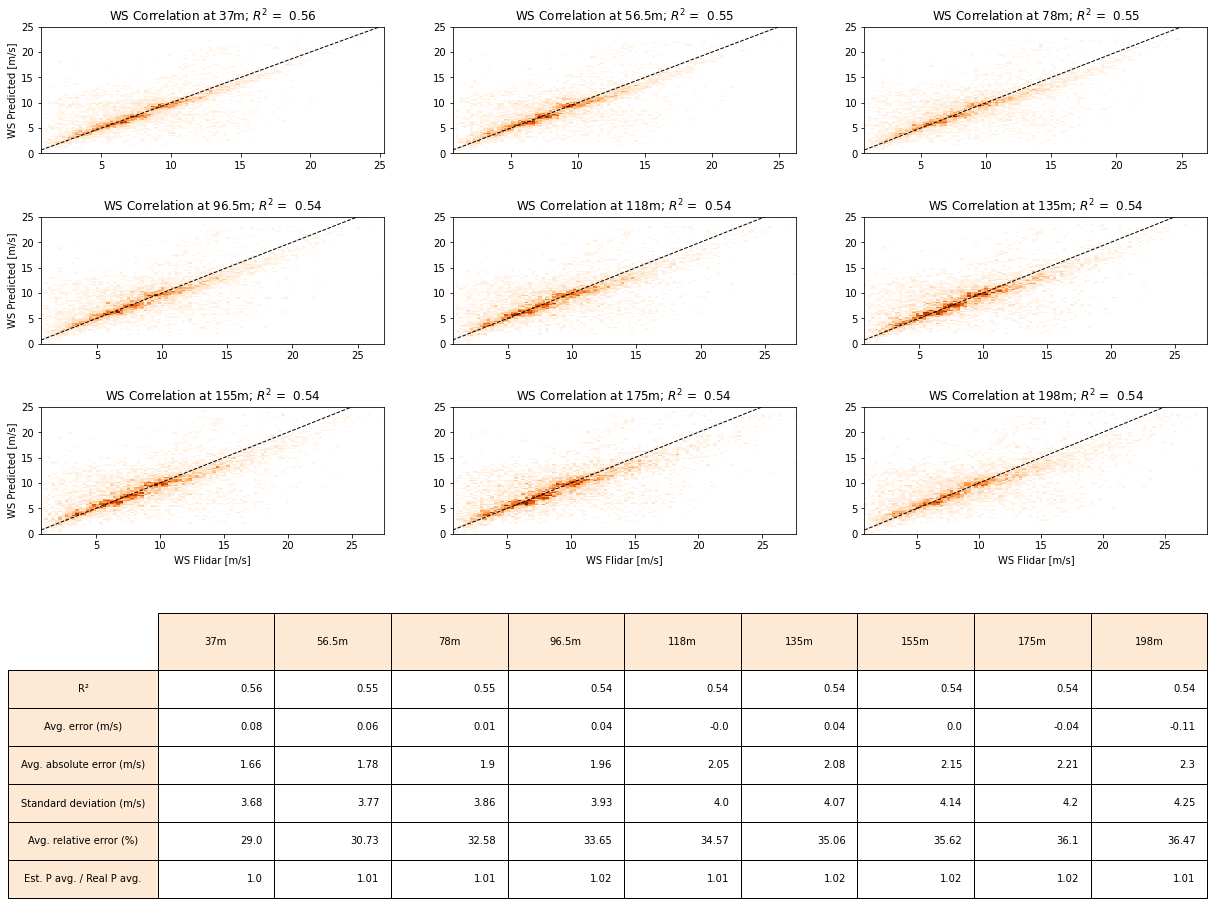

In [14]:
# Test

df_X_train = pd.concat([df_X_A, df_X_B, df_X_C])
df_y_train = pd.concat([df_y_A, df_y_B, df_y_C])

df_X_test = df_X_TRE
df_y_test = df_y_TRE

gbm = CatBoostRegressor(iterations=836, l2_leaf_reg=6, loss_function="MultiRMSE", learning_rate=0.2749039013154247, colsample_bylevel=0.06293430544379999, max_depth=4, random_strength=0.0009159904652620033, boosting_type="Plain", bootstrap_type="Bayesian", bagging_temperature=4.654230854746178)
gbm.fit(df_X_train, df_y_train)
test_model(gbm, heights, ["global"], "No", df_X_test, df_y_test)

Same site optimizing

In [20]:
# Setting ratio for the data sampling

ratio = 0.8

In [30]:
# Optimizing site A

df_X_train, df_X_test, df_X_test2, df_y_train, df_y_test, df_y_test2 = split(df_Xy_A, ratio)

def objective(trial):
    X_train = df_X_train
    X_val = df_X_test
    y_train = df_y_train
    y_val = df_y_test

    param = {
        "iterations" : trial.suggest_int("iterations", 1, 1500),
        "l2_leaf_reg" : trial.suggest_int("l2_leaf_reg", 2, 10),
        "loss_function" : trial.suggest_categorical("loss_function", ["MultiRMSE"]),
        "learning_rate" : trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "max_depth" : trial.suggest_int("max_depth", 1, 15),
        "random_strength" : trial.suggest_loguniform("random_strength", 0.0001, 10.0),
        "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }
    

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_uniform("subsample", 0.1, 1)


    gbm = catboost.CatBoostRegressor(**param, )

    gbm.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 0, early_stopping_rounds = 15)

    predictions = gbm.predict(X_val)
    RMSE = mean_squared_error(y_val, predictions)
    
    return RMSE

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 400, show_progress_bar = True)


print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-19 16:34:31,771] A new study created in memory with name: no-name-1dbe07e8-0aef-4646-bbfc-a70614aab556
  0%|          | 1/400 [00:00<02:09,  3.09it/s]

[I 2022-08-19 16:34:32,123] Trial 0 finished with value: 19.41606304609111 and parameters: {'iterations': 406, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0010870359317961252, 'colsample_bylevel': 0.022665676293559145, 'max_depth': 8, 'random_strength': 0.0031047914326817272, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.47794162714259636}. Best is trial 0 with value: 19.41606304609111.


  0%|          | 2/400 [00:01<06:11,  1.07it/s]

[I 2022-08-19 16:34:33,485] Trial 1 finished with value: 3.6093499649287457 and parameters: {'iterations': 1362, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0193605008665914, 'colsample_bylevel': 0.08570555694450381, 'max_depth': 1, 'random_strength': 0.03488991864669935, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.368433408975601}. Best is trial 1 with value: 3.6093499649287457.


  1%|          | 3/400 [00:03<08:51,  1.34s/it]

[I 2022-08-19 16:34:35,307] Trial 2 finished with value: 3.226095897688048 and parameters: {'iterations': 1332, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11408493029173523, 'colsample_bylevel': 0.02808062539003412, 'max_depth': 3, 'random_strength': 0.01890955358608631, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 3.226095897688048.


  1%|          | 4/400 [00:04<07:06,  1.08s/it]

[I 2022-08-19 16:34:35,978] Trial 3 finished with value: 10.034842296326847 and parameters: {'iterations': 705, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.010104914928580443, 'colsample_bylevel': 0.03934984168375182, 'max_depth': 13, 'random_strength': 0.006921307083234182, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 3.226095897688048.


  1%|▏         | 5/400 [00:04<06:27,  1.02it/s]

[I 2022-08-19 16:34:36,791] Trial 4 finished with value: 2.4400169972688506 and parameters: {'iterations': 1473, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1155041294149982, 'colsample_bylevel': 0.02706501672660787, 'max_depth': 9, 'random_strength': 0.00030089732475487366, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3562870593966797}. Best is trial 4 with value: 2.4400169972688506.


  2%|▏         | 6/400 [00:05<05:30,  1.19it/s]

[I 2022-08-19 16:34:37,354] Trial 5 finished with value: 3.3556389141467573 and parameters: {'iterations': 282, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20189198969123345, 'colsample_bylevel': 0.04012524391637731, 'max_depth': 6, 'random_strength': 0.3623222129096823, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 2.4400169972688506.


  2%|▏         | 7/400 [00:06<05:03,  1.29it/s]

[I 2022-08-19 16:34:37,992] Trial 6 finished with value: 10.284633682825591 and parameters: {'iterations': 350, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.021996917890135824, 'colsample_bylevel': 0.03148916693794383, 'max_depth': 5, 'random_strength': 0.12275721121567161, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7492369441346425}. Best is trial 4 with value: 2.4400169972688506.


  2%|▏         | 8/400 [00:07<06:37,  1.01s/it]

[I 2022-08-19 16:34:39,520] Trial 7 finished with value: 8.799423056783496 and parameters: {'iterations': 1282, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.013307439173485383, 'colsample_bylevel': 0.036396304669178516, 'max_depth': 5, 'random_strength': 0.0005547138146614829, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 2.4400169972688506.


  2%|▏         | 9/400 [00:09<07:13,  1.11s/it]

[I 2022-08-19 16:34:40,838] Trial 8 finished with value: 12.63486432525683 and parameters: {'iterations': 459, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.00239439163746058, 'colsample_bylevel': 0.08946434438351374, 'max_depth': 14, 'random_strength': 0.006578231470889709, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 2.4400169972688506.


  2%|▎         | 10/400 [00:12<11:04,  1.70s/it]

[I 2022-08-19 16:34:43,877] Trial 9 finished with value: 1.0238869299905033 and parameters: {'iterations': 701, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21572804248893132, 'colsample_bylevel': 0.0975792268461024, 'max_depth': 8, 'random_strength': 8.392059551433924, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  3%|▎         | 11/400 [00:15<15:01,  2.32s/it]

[I 2022-08-19 16:34:47,585] Trial 10 finished with value: 2.2198985179313393 and parameters: {'iterations': 981, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.051928610187190284, 'colsample_bylevel': 0.06808537830034812, 'max_depth': 11, 'random_strength': 7.861298610860941, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.836292556954984}. Best is trial 9 with value: 1.0238869299905033.


  3%|▎         | 12/400 [00:19<17:15,  2.67s/it]

[I 2022-08-19 16:34:51,057] Trial 11 finished with value: 2.0886527994999664 and parameters: {'iterations': 900, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.05432577985988675, 'colsample_bylevel': 0.07072186637321873, 'max_depth': 10, 'random_strength': 9.830799662246765, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.63409411548708}. Best is trial 9 with value: 1.0238869299905033.


  3%|▎         | 13/400 [00:23<19:34,  3.04s/it]

[I 2022-08-19 16:34:54,936] Trial 12 finished with value: 1.673387612677261 and parameters: {'iterations': 872, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.296037598704281, 'colsample_bylevel': 0.06963526391825686, 'max_depth': 10, 'random_strength': 9.356228292876503, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.838846956185996}. Best is trial 9 with value: 1.0238869299905033.


  4%|▎         | 14/400 [00:32<32:20,  5.03s/it]

[I 2022-08-19 16:35:04,566] Trial 13 finished with value: 1.429075476000441 and parameters: {'iterations': 657, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2870683078016852, 'colsample_bylevel': 0.09563253918719826, 'max_depth': 12, 'random_strength': 1.4663692558795427, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.255288611813762}. Best is trial 9 with value: 1.0238869299905033.


  4%|▍         | 15/400 [00:34<26:35,  4.15s/it]

[I 2022-08-19 16:35:06,666] Trial 14 finished with value: 5.1849907197931655 and parameters: {'iterations': 37, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11612079796543205, 'colsample_bylevel': 0.09896982705145163, 'max_depth': 12, 'random_strength': 1.368424600473398, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9815738552501102}. Best is trial 9 with value: 1.0238869299905033.


  4%|▍         | 16/400 [00:58<1:03:47,  9.97s/it]

[I 2022-08-19 16:35:30,151] Trial 15 finished with value: 1.7550613023712653 and parameters: {'iterations': 660, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.04433817878292066, 'colsample_bylevel': 0.0966004785703411, 'max_depth': 15, 'random_strength': 1.2864150010028674, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.707723821557223}. Best is trial 9 with value: 1.0238869299905033.
[I 2022-08-19 16:35:30,217] Trial 16 finished with value: 19.8863449027361 and parameters: {'iterations': 1084, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2819586837014357, 'colsample_bylevel': 0.011269422492151182, 'max_depth': 7, 'random_strength': 1.133806914064739, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  4%|▍         | 18/400 [01:00<37:05,  5.83s/it]  

[I 2022-08-19 16:35:32,172] Trial 17 finished with value: 7.9266552424779855 and parameters: {'iterations': 566, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.005852462211792404, 'colsample_bylevel': 0.08149635711962411, 'max_depth': 8, 'random_strength': 0.230317816701538, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  5%|▍         | 19/400 [01:00<28:25,  4.48s/it]

[I 2022-08-19 16:35:32,563] Trial 18 finished with value: 4.176152279424081 and parameters: {'iterations': 170, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15406337590619631, 'colsample_bylevel': 0.05407196643916027, 'max_depth': 13, 'random_strength': 2.0807724726031243, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.653944090851524}. Best is trial 9 with value: 1.0238869299905033.


  5%|▌         | 20/400 [01:02<23:30,  3.71s/it]

[I 2022-08-19 16:35:34,121] Trial 19 finished with value: 3.4660282133974363 and parameters: {'iterations': 773, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.03316521463243949, 'colsample_bylevel': 0.05367354338856814, 'max_depth': 11, 'random_strength': 3.3084858292324784, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.12924508101164744}. Best is trial 9 with value: 1.0238869299905033.


  5%|▌         | 21/400 [01:05<22:35,  3.58s/it]

[I 2022-08-19 16:35:37,336] Trial 20 finished with value: 1.4436743752390855 and parameters: {'iterations': 1119, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08522715963165374, 'colsample_bylevel': 0.07783636392618426, 'max_depth': 3, 'random_strength': 0.4798723907054901, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  6%|▌         | 22/400 [01:07<20:19,  3.23s/it]

[I 2022-08-19 16:35:39,657] Trial 21 finished with value: 2.0520517675237357 and parameters: {'iterations': 1052, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0750774940523465, 'colsample_bylevel': 0.0787891009462554, 'max_depth': 1, 'random_strength': 0.476180315468678, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  6%|▌         | 23/400 [01:09<17:56,  2.85s/it]

[I 2022-08-19 16:35:41,586] Trial 22 finished with value: 1.3346356030466355 and parameters: {'iterations': 576, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19994802974509404, 'colsample_bylevel': 0.09311941319838483, 'max_depth': 3, 'random_strength': 0.08371228882915112, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  6%|▌         | 24/400 [01:11<15:30,  2.48s/it]

[I 2022-08-19 16:35:43,131] Trial 23 finished with value: 1.268467827187739 and parameters: {'iterations': 570, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20231978507627735, 'colsample_bylevel': 0.09204548289400864, 'max_depth': 4, 'random_strength': 0.09631327554362347, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  6%|▋         | 25/400 [01:13<14:02,  2.25s/it]

[I 2022-08-19 16:35:44,829] Trial 24 finished with value: 1.4233219723143546 and parameters: {'iterations': 524, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17641353739039692, 'colsample_bylevel': 0.09027629298812911, 'max_depth': 3, 'random_strength': 0.06154802580260476, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  6%|▋         | 26/400 [01:14<12:38,  2.03s/it]

[I 2022-08-19 16:35:46,328] Trial 25 finished with value: 1.3014217647877897 and parameters: {'iterations': 561, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16492397549313903, 'colsample_bylevel': 0.09152880857430609, 'max_depth': 4, 'random_strength': 0.0013522829417632338, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  7%|▋         | 27/400 [01:16<12:31,  2.02s/it]

[I 2022-08-19 16:35:48,316] Trial 26 finished with value: 1.650606359335977 and parameters: {'iterations': 802, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07650434515229403, 'colsample_bylevel': 0.06331564149628069, 'max_depth': 6, 'random_strength': 0.001575412457977721, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  7%|▋         | 28/400 [01:16<09:20,  1.51s/it]

[I 2022-08-19 16:35:48,621] Trial 27 finished with value: 6.1615621777112635 and parameters: {'iterations': 194, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0302343830144679, 'colsample_bylevel': 0.08466252987043343, 'max_depth': 4, 'random_strength': 0.00012552566768809657, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  7%|▋         | 29/400 [01:17<08:26,  1.37s/it]

[I 2022-08-19 16:35:49,658] Trial 28 finished with value: 2.1001046838021358 and parameters: {'iterations': 471, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14416593666559724, 'colsample_bylevel': 0.06101335887954218, 'max_depth': 2, 'random_strength': 0.01497398609299353, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  8%|▊         | 30/400 [01:18<06:37,  1.07s/it]

[I 2022-08-19 16:35:50,047] Trial 29 finished with value: 13.877171136675585 and parameters: {'iterations': 304, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0045194393734771954, 'colsample_bylevel': 0.07723426095609687, 'max_depth': 7, 'random_strength': 0.0014151978247824665, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8428661768875403}. Best is trial 9 with value: 1.0238869299905033.


  8%|▊         | 31/400 [01:19<07:33,  1.23s/it]

[I 2022-08-19 16:35:51,637] Trial 30 finished with value: 1.4519012747597368 and parameters: {'iterations': 398, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07549024961827282, 'colsample_bylevel': 0.09899391297242427, 'max_depth': 7, 'random_strength': 0.004416346087916922, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  8%|▊         | 32/400 [01:21<08:10,  1.33s/it]

[I 2022-08-19 16:35:53,214] Trial 31 finished with value: 1.2309899859012363 and parameters: {'iterations': 597, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20299045590322884, 'colsample_bylevel': 0.09174175599561868, 'max_depth': 4, 'random_strength': 0.08230151318815063, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  8%|▊         | 33/400 [01:23<08:55,  1.46s/it]

[I 2022-08-19 16:35:54,965] Trial 32 finished with value: 15.315892812514518 and parameters: {'iterations': 623, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0011447192003046665, 'colsample_bylevel': 0.0868224833675119, 'max_depth': 5, 'random_strength': 0.028467932688048172, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  8%|▊         | 34/400 [01:25<10:12,  1.67s/it]

[I 2022-08-19 16:35:57,140] Trial 33 finished with value: 1.1495838897355828 and parameters: {'iterations': 764, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2018128010468934, 'colsample_bylevel': 0.0909279987607243, 'max_depth': 4, 'random_strength': 0.18860783205739542, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  9%|▉         | 35/400 [01:26<09:00,  1.48s/it]

[I 2022-08-19 16:35:58,175] Trial 34 finished with value: 1.8159913388043647 and parameters: {'iterations': 755, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2246007355988785, 'colsample_bylevel': 0.08401433566288236, 'max_depth': 1, 'random_strength': 0.1481046405124238, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  9%|▉         | 36/400 [01:28<10:11,  1.68s/it]

[I 2022-08-19 16:36:00,323] Trial 35 finished with value: 1.4012342512713873 and parameters: {'iterations': 853, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10531293894657341, 'colsample_bylevel': 0.07396822704741668, 'max_depth': 4, 'random_strength': 0.053232399493957555, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


  9%|▉         | 37/400 [01:30<10:22,  1.71s/it]

[I 2022-08-19 16:36:02,112] Trial 36 finished with value: 1.535849196373512 and parameters: {'iterations': 734, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14120439251588723, 'colsample_bylevel': 0.09335572635199312, 'max_depth': 2, 'random_strength': 0.014803719441807413, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 9 with value: 1.0238869299905033.


 10%|▉         | 38/400 [01:30<07:36,  1.26s/it]

[I 2022-08-19 16:36:02,314] Trial 37 finished with value: 2.7174522262660985 and parameters: {'iterations': 468, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22704815387609856, 'colsample_bylevel': 0.04517778799683813, 'max_depth': 6, 'random_strength': 0.21952473047912377, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7109979457986461}. Best is trial 9 with value: 1.0238869299905033.


 10%|▉         | 39/400 [01:34<12:56,  2.15s/it]

[I 2022-08-19 16:36:06,541] Trial 38 finished with value: 0.9838048427043139 and parameters: {'iterations': 928, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12140638870434012, 'colsample_bylevel': 0.09979765776425158, 'max_depth': 8, 'random_strength': 0.02948293679187647, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 38 with value: 0.9838048427043139.


 10%|█         | 40/400 [01:40<20:12,  3.37s/it]

[I 2022-08-19 16:36:12,752] Trial 39 finished with value: 1.0695364429163101 and parameters: {'iterations': 1227, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10349870787702997, 'colsample_bylevel': 0.08724626507536484, 'max_depth': 9, 'random_strength': 0.023132997174973375, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 38 with value: 0.9838048427043139.


 10%|█         | 41/400 [01:50<31:46,  5.31s/it]

[I 2022-08-19 16:36:22,598] Trial 40 finished with value: 0.935501588676287 and parameters: {'iterations': 1287, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10741498848806615, 'colsample_bylevel': 0.09951013214521873, 'max_depth': 9, 'random_strength': 0.009282305629453586, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 40 with value: 0.935501588676287.


 10%|█         | 42/400 [01:59<36:58,  6.20s/it]

[I 2022-08-19 16:36:30,865] Trial 41 finished with value: 0.9919639631489149 and parameters: {'iterations': 1222, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0994664273122361, 'colsample_bylevel': 0.09935738723220433, 'max_depth': 9, 'random_strength': 0.01203065277006018, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 40 with value: 0.935501588676287.


 11%|█         | 43/400 [02:08<43:12,  7.26s/it]

[I 2022-08-19 16:36:40,612] Trial 42 finished with value: 0.9660892015612268 and parameters: {'iterations': 1232, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10089841544826644, 'colsample_bylevel': 0.09968225447462109, 'max_depth': 9, 'random_strength': 0.009590811546775477, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 40 with value: 0.935501588676287.


 11%|█         | 44/400 [02:18<47:54,  8.08s/it]

[I 2022-08-19 16:36:50,584] Trial 43 finished with value: 1.0454459319683909 and parameters: {'iterations': 1477, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.05767313009811975, 'colsample_bylevel': 0.09799244472532755, 'max_depth': 9, 'random_strength': 0.00867226718626732, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 40 with value: 0.935501588676287.


 11%|█▏        | 45/400 [02:32<56:56,  9.62s/it]

[I 2022-08-19 16:37:03,824] Trial 44 finished with value: 1.2631005374796087 and parameters: {'iterations': 1370, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.034008998003563114, 'colsample_bylevel': 0.09699737952252001, 'max_depth': 10, 'random_strength': 0.002869991607995804, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 40 with value: 0.935501588676287.


 12%|█▏        | 46/400 [02:34<43:16,  7.33s/it]

[I 2022-08-19 16:37:05,816] Trial 45 finished with value: 1.6453340841461133 and parameters: {'iterations': 1207, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.01776515999834373, 'colsample_bylevel': 0.09826953591138882, 'max_depth': 8, 'random_strength': 0.009613608577470876, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 40 with value: 0.935501588676287.


 12%|█▏        | 47/400 [02:43<47:49,  8.13s/it]

[I 2022-08-19 16:37:15,792] Trial 46 finished with value: 0.8746514442393228 and parameters: {'iterations': 1367, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12731373654113076, 'colsample_bylevel': 0.09988754672052508, 'max_depth': 9, 'random_strength': 0.03818264346740592, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 12%|█▏        | 48/400 [02:52<48:57,  8.34s/it]

[I 2022-08-19 16:37:24,643] Trial 47 finished with value: 1.1996963827427034 and parameters: {'iterations': 1395, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.05837524823604539, 'colsample_bylevel': 0.09966544858777261, 'max_depth': 9, 'random_strength': 0.0046214450342291, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.11575204463015609}. Best is trial 46 with value: 0.8746514442393228.


 12%|█▏        | 49/400 [03:08<1:01:17, 10.48s/it]

[I 2022-08-19 16:37:40,095] Trial 48 finished with value: 1.5178425299658325 and parameters: {'iterations': 1279, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.024732863928759816, 'colsample_bylevel': 0.09456239100635366, 'max_depth': 11, 'random_strength': 0.03056870881573908, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 12%|█▎        | 50/400 [03:17<58:12,  9.98s/it]  

[I 2022-08-19 16:37:48,915] Trial 49 finished with value: 1.322049290995269 and parameters: {'iterations': 1161, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.04264709538138976, 'colsample_bylevel': 0.08828661196893044, 'max_depth': 10, 'random_strength': 0.04791769108163604, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 13%|█▎        | 51/400 [03:20<46:25,  7.98s/it]

[I 2022-08-19 16:37:52,235] Trial 50 finished with value: 1.1365884756158842 and parameters: {'iterations': 990, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12460579462264358, 'colsample_bylevel': 0.0821345721599851, 'max_depth': 8, 'random_strength': 0.010879854160927724, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 13%|█▎        | 52/400 [03:26<43:18,  7.47s/it]

[I 2022-08-19 16:37:58,502] Trial 51 finished with value: 0.9945597145980041 and parameters: {'iterations': 1419, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09389008265112947, 'colsample_bylevel': 0.09558735924970346, 'max_depth': 8, 'random_strength': 0.003490575572460211, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 13%|█▎        | 53/400 [03:35<45:06,  7.80s/it]

[I 2022-08-19 16:38:07,081] Trial 52 finished with value: 0.9736870589439187 and parameters: {'iterations': 1417, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09145610936472783, 'colsample_bylevel': 0.09442330199232389, 'max_depth': 9, 'random_strength': 0.005679781843266857, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 14%|█▎        | 54/400 [03:43<46:21,  8.04s/it]

[I 2022-08-19 16:38:15,675] Trial 53 finished with value: 0.9726276807487595 and parameters: {'iterations': 1274, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09276293772182617, 'colsample_bylevel': 0.09966028297411968, 'max_depth': 9, 'random_strength': 0.002149273715942901, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 14%|█▍        | 55/400 [03:44<33:17,  5.79s/it]

[I 2022-08-19 16:38:16,220] Trial 54 finished with value: 10.10655610887745 and parameters: {'iterations': 1318, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06411353832315216, 'colsample_bylevel': 0.020104943348472848, 'max_depth': 10, 'random_strength': 0.0023261667737860285, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8780782338492026}. Best is trial 46 with value: 0.8746514442393228.


 14%|█▍        | 56/400 [04:01<53:14,  9.29s/it]

[I 2022-08-19 16:38:33,666] Trial 55 finished with value: 0.9150365694413775 and parameters: {'iterations': 1435, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11712121402045184, 'colsample_bylevel': 0.09428632379196208, 'max_depth': 11, 'random_strength': 0.0005581541989094171, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 14%|█▍        | 57/400 [04:23<1:14:26, 13.02s/it]

[I 2022-08-19 16:38:55,404] Trial 56 finished with value: 1.983510401666128 and parameters: {'iterations': 1431, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.011576290726910254, 'colsample_bylevel': 0.09510241959356791, 'max_depth': 12, 'random_strength': 0.0005377209416068497, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 14%|█▍        | 58/400 [04:37<1:16:29, 13.42s/it]

[I 2022-08-19 16:39:09,751] Trial 57 finished with value: 1.2405123278601282 and parameters: {'iterations': 1490, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0427496379727394, 'colsample_bylevel': 0.0880273233222082, 'max_depth': 11, 'random_strength': 0.0004788376239662858, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 15%|█▍        | 59/400 [04:40<58:31, 10.30s/it]  

[I 2022-08-19 16:39:12,764] Trial 58 finished with value: 1.879385844388034 and parameters: {'iterations': 1327, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06699894415909151, 'colsample_bylevel': 0.048043768283067494, 'max_depth': 13, 'random_strength': 0.0003001016542510442, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.25814361971634}. Best is trial 46 with value: 0.8746514442393228.


 15%|█▌        | 60/400 [04:42<43:45,  7.72s/it]

[I 2022-08-19 16:39:14,480] Trial 59 finished with value: 1.02027281564845 and parameters: {'iterations': 1289, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1255476202099768, 'colsample_bylevel': 0.08048138190404089, 'max_depth': 9, 'random_strength': 0.006451706401073235, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6674640741889224}. Best is trial 46 with value: 0.8746514442393228.


 15%|█▌        | 61/400 [05:00<1:00:19, 10.68s/it]

[I 2022-08-19 16:39:32,046] Trial 60 finished with value: 0.9744431762434184 and parameters: {'iterations': 1437, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0871304111106916, 'colsample_bylevel': 0.09474304047435846, 'max_depth': 11, 'random_strength': 0.0023062996471054234, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 16%|█▌        | 62/400 [05:18<1:12:08, 12.81s/it]

[I 2022-08-19 16:39:49,821] Trial 61 finished with value: 0.9924151479395567 and parameters: {'iterations': 1362, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08780393773141323, 'colsample_bylevel': 0.0942623444204525, 'max_depth': 11, 'random_strength': 0.0007948766261772617, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 16%|█▌        | 63/400 [05:34<1:18:33, 13.99s/it]

[I 2022-08-19 16:40:06,563] Trial 62 finished with value: 0.9120166259542564 and parameters: {'iterations': 1450, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15391171635759596, 'colsample_bylevel': 0.08958582557313505, 'max_depth': 12, 'random_strength': 0.0019607089567327818, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 16%|█▌        | 64/400 [06:03<1:43:01, 18.40s/it]

[I 2022-08-19 16:40:35,247] Trial 63 finished with value: 0.9547473951333207 and parameters: {'iterations': 1269, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15743770129877774, 'colsample_bylevel': 0.08990801102736426, 'max_depth': 14, 'random_strength': 0.0062096920285181125, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 16%|█▋        | 65/400 [06:33<2:02:58, 22.02s/it]

[I 2022-08-19 16:41:05,737] Trial 64 finished with value: 0.9419495778761715 and parameters: {'iterations': 1274, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15448133888052681, 'colsample_bylevel': 0.0889315131500762, 'max_depth': 14, 'random_strength': 0.0008181668670297356, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 16%|█▋        | 66/400 [07:04<2:17:16, 24.66s/it]

[I 2022-08-19 16:41:36,552] Trial 65 finished with value: 1.058847577895372 and parameters: {'iterations': 1101, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.260000845422708, 'colsample_bylevel': 0.08441890522479788, 'max_depth': 15, 'random_strength': 0.0009598176167338324, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 17%|█▋        | 67/400 [07:35<2:26:28, 26.39s/it]

[I 2022-08-19 16:42:06,981] Trial 66 finished with value: 0.974636321319098 and parameters: {'iterations': 1155, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11964992623219184, 'colsample_bylevel': 0.08919666843039689, 'max_depth': 14, 'random_strength': 0.0002216535296871061, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 17%|█▋        | 68/400 [07:55<2:16:20, 24.64s/it]

[I 2022-08-19 16:42:27,536] Trial 67 finished with value: 1.0250467587456575 and parameters: {'iterations': 1337, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1584428427872164, 'colsample_bylevel': 0.07418165991424469, 'max_depth': 14, 'random_strength': 0.000865786797939748, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 17%|█▋        | 69/400 [08:09<1:58:37, 21.50s/it]

[I 2022-08-19 16:42:41,718] Trial 68 finished with value: 1.077131662105698 and parameters: {'iterations': 1168, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16875720090245316, 'colsample_bylevel': 0.08990548921382607, 'max_depth': 13, 'random_strength': 0.019613137175988282, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 18%|█▊        | 70/400 [08:20<1:41:01, 18.37s/it]

[I 2022-08-19 16:42:52,774] Trial 69 finished with value: 3.870580325514924 and parameters: {'iterations': 1232, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.008346324415356855, 'colsample_bylevel': 0.08568525811724102, 'max_depth': 12, 'random_strength': 0.00015490287559534157, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.597933137521344}. Best is trial 46 with value: 0.8746514442393228.


 18%|█▊        | 71/400 [08:32<1:28:48, 16.20s/it]

[I 2022-08-19 16:43:03,901] Trial 70 finished with value: 1.0514869352341576 and parameters: {'iterations': 1041, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2463895311620679, 'colsample_bylevel': 0.08165070212864138, 'max_depth': 13, 'random_strength': 0.00038184876338552597, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 46 with value: 0.8746514442393228.


 18%|█▊        | 72/400 [09:16<2:14:36, 24.62s/it]

[I 2022-08-19 16:43:48,186] Trial 71 finished with value: 0.8742682013880755 and parameters: {'iterations': 1277, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13883153470649515, 'colsample_bylevel': 0.0965554651422508, 'max_depth': 14, 'random_strength': 0.001448943701131275, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.8742682013880755.


 18%|█▊        | 73/400 [10:12<3:05:32, 34.04s/it]

[I 2022-08-19 16:44:44,215] Trial 72 finished with value: 0.8791377738012872 and parameters: {'iterations': 1264, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17580961222609867, 'colsample_bylevel': 0.09267169321664054, 'max_depth': 15, 'random_strength': 0.001200361642991993, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.8742682013880755.


 18%|█▊        | 74/400 [10:42<2:58:22, 32.83s/it]

[I 2022-08-19 16:45:14,206] Trial 73 finished with value: 0.9675036322073994 and parameters: {'iterations': 1362, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18108548630465887, 'colsample_bylevel': 0.09203933917968449, 'max_depth': 15, 'random_strength': 0.0007797958486231264, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.8742682013880755.


 19%|█▉        | 75/400 [11:12<2:53:34, 32.04s/it]

[I 2022-08-19 16:45:44,422] Trial 74 finished with value: 0.9212578359664612 and parameters: {'iterations': 1445, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14328295040980074, 'colsample_bylevel': 0.09002987581084756, 'max_depth': 14, 'random_strength': 0.0014870245014133102, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.8742682013880755.


 19%|█▉        | 76/400 [11:43<2:51:51, 31.83s/it]

[I 2022-08-19 16:46:15,738] Trial 75 finished with value: 0.9978831147980363 and parameters: {'iterations': 1498, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29226636157435054, 'colsample_bylevel': 0.09667369562986025, 'max_depth': 15, 'random_strength': 0.0012816979721880998, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.8742682013880755.


 19%|█▉        | 77/400 [11:46<2:04:00, 23.03s/it]

[I 2022-08-19 16:46:18,260] Trial 76 finished with value: 1.1810901518274046 and parameters: {'iterations': 1456, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13619954471730827, 'colsample_bylevel': 0.06646999632033174, 'max_depth': 14, 'random_strength': 0.0017656956379832967, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.8742682013880755.


 20%|█▉        | 78/400 [12:00<1:48:46, 20.27s/it]

[I 2022-08-19 16:46:32,078] Trial 77 finished with value: 1.1082319478331575 and parameters: {'iterations': 1308, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1455386255867252, 'colsample_bylevel': 0.08584025091775234, 'max_depth': 12, 'random_strength': 0.0011078199507162806, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3639281509366762}. Best is trial 71 with value: 0.8742682013880755.


 20%|█▉        | 79/400 [12:19<1:46:44, 19.95s/it]

[I 2022-08-19 16:46:51,293] Trial 78 finished with value: 1.0109124386613968 and parameters: {'iterations': 1387, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2400119362866021, 'colsample_bylevel': 0.09250306140300675, 'max_depth': 14, 'random_strength': 0.00023747352751060175, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.8742682013880755.


 20%|██        | 80/400 [12:59<2:18:51, 26.03s/it]

[I 2022-08-19 16:47:31,517] Trial 79 finished with value: 0.9887179707827628 and parameters: {'iterations': 1452, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18583149453619152, 'colsample_bylevel': 0.07467056977900736, 'max_depth': 15, 'random_strength': 0.0005454635573611874, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.8742682013880755.


 20%|██        | 81/400 [13:02<1:41:29, 19.09s/it]

[I 2022-08-19 16:47:34,401] Trial 80 finished with value: 2.0862749002660217 and parameters: {'iterations': 1348, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07639942068025367, 'colsample_bylevel': 0.031564422949811155, 'max_depth': 13, 'random_strength': 0.0034894870468160353, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.8742682013880755.


 20%|██        | 82/400 [13:24<1:46:07, 20.02s/it]

[I 2022-08-19 16:47:56,604] Trial 81 finished with value: 0.9736479670087456 and parameters: {'iterations': 1289, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1679070836979426, 'colsample_bylevel': 0.08930155348047135, 'max_depth': 14, 'random_strength': 0.0015590076030666292, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.8742682013880755.


 21%|██        | 83/400 [13:49<1:52:40, 21.33s/it]

[I 2022-08-19 16:48:20,971] Trial 82 finished with value: 0.9978869001869156 and parameters: {'iterations': 1185, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11169976989415155, 'colsample_bylevel': 0.09093639260229151, 'max_depth': 14, 'random_strength': 0.0007486676692226484, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.8742682013880755.


 21%|██        | 84/400 [14:41<2:41:00, 30.57s/it]

[I 2022-08-19 16:49:13,108] Trial 83 finished with value: 0.9029973461093233 and parameters: {'iterations': 1265, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14041118626264817, 'colsample_bylevel': 0.09669294808069023, 'max_depth': 15, 'random_strength': 0.0030133137847445078, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.8742682013880755.


 21%|██▏       | 85/400 [15:43<3:29:32, 39.91s/it]

[I 2022-08-19 16:50:14,823] Trial 84 finished with value: 0.8447286395090973 and parameters: {'iterations': 1413, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1345574103166644, 'colsample_bylevel': 0.09692797023012838, 'max_depth': 15, 'random_strength': 0.002963643967377458, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 84 with value: 0.8447286395090973.


 22%|██▏       | 86/400 [16:43<4:00:24, 45.94s/it]

[I 2022-08-19 16:51:14,819] Trial 85 finished with value: 0.8738708619146945 and parameters: {'iterations': 1394, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13116838007509887, 'colsample_bylevel': 0.09681450154809759, 'max_depth': 15, 'random_strength': 0.004252818051443156, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 84 with value: 0.8447286395090973.


 22%|██▏       | 87/400 [17:27<3:57:54, 45.60s/it]

[I 2022-08-19 16:51:59,644] Trial 86 finished with value: 0.9906620078829089 and parameters: {'iterations': 1385, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13395419657199092, 'colsample_bylevel': 0.09652793685338863, 'max_depth': 15, 'random_strength': 0.0019014794728598862, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 84 with value: 0.8447286395090973.


 22%|██▏       | 88/400 [17:50<3:20:53, 38.63s/it]

[I 2022-08-19 16:52:22,010] Trial 87 finished with value: 0.9766449741570968 and parameters: {'iterations': 1397, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21109151129586126, 'colsample_bylevel': 0.09333482230715574, 'max_depth': 15, 'random_strength': 0.003984720908392296, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 84 with value: 0.8447286395090973.


 22%|██▏       | 89/400 [18:01<2:37:37, 30.41s/it]

[I 2022-08-19 16:52:33,234] Trial 88 finished with value: 0.808931789610648 and parameters: {'iterations': 1461, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13397921538649965, 'colsample_bylevel': 0.09756064091356272, 'max_depth': 15, 'random_strength': 0.0026759649969257827, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 88 with value: 0.808931789610648.


 22%|██▎       | 90/400 [18:11<2:05:02, 24.20s/it]

[I 2022-08-19 16:52:42,955] Trial 89 finished with value: 0.8826667707568111 and parameters: {'iterations': 1497, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18577146887598409, 'colsample_bylevel': 0.0963600235510722, 'max_depth': 15, 'random_strength': 0.0026906486847853963, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.4651121517884715}. Best is trial 88 with value: 0.808931789610648.


 23%|██▎       | 91/400 [18:22<1:45:27, 20.48s/it]

[I 2022-08-19 16:52:54,743] Trial 90 finished with value: 0.8279765818511688 and parameters: {'iterations': 1493, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20005604595491938, 'colsample_bylevel': 0.09722168980109845, 'max_depth': 15, 'random_strength': 0.0030139524698345795, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.805636971948336}. Best is trial 88 with value: 0.808931789610648.


 23%|██▎       | 92/400 [18:27<1:21:20, 15.85s/it]

[I 2022-08-19 16:52:59,780] Trial 91 finished with value: 0.9599803323979241 and parameters: {'iterations': 1495, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1890225849752867, 'colsample_bylevel': 0.09699992097095136, 'max_depth': 15, 'random_strength': 0.0030270868573133536, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.561371868084528}. Best is trial 88 with value: 0.808931789610648.


 23%|██▎       | 93/400 [18:33<1:04:38, 12.63s/it]

[I 2022-08-19 16:53:04,921] Trial 92 finished with value: 0.974200512785238 and parameters: {'iterations': 1472, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21959040247949294, 'colsample_bylevel': 0.09611657353719322, 'max_depth': 15, 'random_strength': 0.002694713397770543, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.3424278630619564}. Best is trial 88 with value: 0.808931789610648.


 24%|██▎       | 94/400 [18:46<1:05:13, 12.79s/it]

[I 2022-08-19 16:53:18,069] Trial 93 finished with value: 0.8345733294288534 and parameters: {'iterations': 1415, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24911704512523172, 'colsample_bylevel': 0.09768653670429975, 'max_depth': 15, 'random_strength': 0.005232061007436549, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.9475083988237185}. Best is trial 88 with value: 0.808931789610648.


 24%|██▍       | 95/400 [19:00<1:07:01, 13.18s/it]

[I 2022-08-19 16:53:32,175] Trial 94 finished with value: 0.8371044794787212 and parameters: {'iterations': 1405, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27184641367872825, 'colsample_bylevel': 0.09740578263559202, 'max_depth': 15, 'random_strength': 0.004555024082433823, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.9278195630237054}. Best is trial 88 with value: 0.808931789610648.


 24%|██▍       | 96/400 [19:09<1:01:12, 12.08s/it]

[I 2022-08-19 16:53:41,677] Trial 95 finished with value: 0.8770494558025537 and parameters: {'iterations': 1400, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2675399096448039, 'colsample_bylevel': 0.09275140341344351, 'max_depth': 15, 'random_strength': 0.004657101386871751, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.062180618545273}. Best is trial 88 with value: 0.808931789610648.


 24%|██▍       | 97/400 [19:13<48:52,  9.68s/it]  

[I 2022-08-19 16:53:45,758] Trial 96 finished with value: 1.151482305480578 and parameters: {'iterations': 1407, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2713504980849838, 'colsample_bylevel': 0.09264059160365658, 'max_depth': 15, 'random_strength': 0.004783426816975813, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.128221006493006}. Best is trial 88 with value: 0.808931789610648.


 24%|██▍       | 98/400 [19:19<42:13,  8.39s/it]

[I 2022-08-19 16:53:51,136] Trial 97 finished with value: 1.0475357557904308 and parameters: {'iterations': 1356, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24594944156315018, 'colsample_bylevel': 0.09789250990513546, 'max_depth': 15, 'random_strength': 0.007540064921753122, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.0903284781119975}. Best is trial 88 with value: 0.808931789610648.


 25%|██▍       | 99/400 [19:24<37:26,  7.46s/it]

[I 2022-08-19 16:53:56,439] Trial 98 finished with value: 0.9562475992111406 and parameters: {'iterations': 1320, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29348024205607065, 'colsample_bylevel': 0.09779312421996746, 'max_depth': 14, 'random_strength': 0.01349711532528142, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.4308099505393526}. Best is trial 88 with value: 0.808931789610648.


 25%|██▌       | 100/400 [19:33<39:28,  7.89s/it]

[I 2022-08-19 16:54:05,337] Trial 99 finished with value: 5.090449204632659 and parameters: {'iterations': 1409, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.003380286767496615, 'colsample_bylevel': 0.09276167630771988, 'max_depth': 15, 'random_strength': 0.03920740254549718, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.705801096838739}. Best is trial 88 with value: 0.808931789610648.


 25%|██▌       | 101/400 [19:35<30:46,  6.18s/it]

[I 2022-08-19 16:54:07,506] Trial 100 finished with value: 1.2696613296745753 and parameters: {'iterations': 1369, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21519138813344693, 'colsample_bylevel': 0.08695633078052525, 'max_depth': 14, 'random_strength': 0.007920497432573437, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.914110891488192}. Best is trial 88 with value: 0.808931789610648.


 26%|██▌       | 102/400 [19:40<28:08,  5.66s/it]

[I 2022-08-19 16:54:11,976] Trial 101 finished with value: 1.0435208711212913 and parameters: {'iterations': 1469, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1872068587502816, 'colsample_bylevel': 0.09541369642544599, 'max_depth': 15, 'random_strength': 0.005369875690683869, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.0034712396025505}. Best is trial 88 with value: 0.808931789610648.


 26%|██▌       | 103/400 [19:52<38:30,  7.78s/it]

[I 2022-08-19 16:54:24,685] Trial 102 finished with value: 0.7561184051867863 and parameters: {'iterations': 1500, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2514307139040386, 'colsample_bylevel': 0.09999991703837614, 'max_depth': 15, 'random_strength': 0.003858257087255993, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.8816752490649664}. Best is trial 102 with value: 0.7561184051867863.


 26%|██▌       | 104/400 [19:58<35:23,  7.18s/it]

[I 2022-08-19 16:54:30,454] Trial 103 finished with value: 0.8999166883747883 and parameters: {'iterations': 1412, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2606145791669543, 'colsample_bylevel': 0.09851618301571494, 'max_depth': 15, 'random_strength': 0.0041234630128025905, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.634737113692063}. Best is trial 102 with value: 0.7561184051867863.


 26%|██▋       | 105/400 [20:05<35:14,  7.17s/it]

[I 2022-08-19 16:54:37,600] Trial 104 finished with value: 0.8817229020099218 and parameters: {'iterations': 1344, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22930138200495812, 'colsample_bylevel': 0.09993657913211626, 'max_depth': 14, 'random_strength': 0.0011630683018826699, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.7272296165227936}. Best is trial 102 with value: 0.7561184051867863.


 26%|██▋       | 106/400 [20:10<31:42,  6.47s/it]

[I 2022-08-19 16:54:42,454] Trial 105 finished with value: 0.9809868081717471 and parameters: {'iterations': 1385, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2973395142257033, 'colsample_bylevel': 0.09352288173973793, 'max_depth': 15, 'random_strength': 0.0037708022950708815, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.698577635563117}. Best is trial 102 with value: 0.7561184051867863.


 27%|██▋       | 107/400 [20:14<27:40,  5.67s/it]

[I 2022-08-19 16:54:46,240] Trial 106 finished with value: 1.0041142954542177 and parameters: {'iterations': 1432, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2076611825699291, 'colsample_bylevel': 0.09771605346681236, 'max_depth': 14, 'random_strength': 0.006599724410973811, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.6198575295181252}. Best is trial 102 with value: 0.7561184051867863.


 27%|██▋       | 108/400 [20:15<20:58,  4.31s/it]

[I 2022-08-19 16:54:47,383] Trial 107 finished with value: 1.3003325774504022 and parameters: {'iterations': 1467, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25968105196916197, 'colsample_bylevel': 0.0914612254752714, 'max_depth': 15, 'random_strength': 0.01728313832541983, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.9758238474430616}. Best is trial 102 with value: 0.7561184051867863.


 27%|██▋       | 109/400 [20:17<16:56,  3.49s/it]

[I 2022-08-19 16:54:48,967] Trial 108 finished with value: 1.3644401580639018 and parameters: {'iterations': 1318, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16946886075388723, 'colsample_bylevel': 0.058734608086459084, 'max_depth': 13, 'random_strength': 0.00496150170004692, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.0608991671790484}. Best is trial 102 with value: 0.7561184051867863.


 28%|██▊       | 111/400 [20:22<13:26,  2.79s/it]

[I 2022-08-19 16:54:53,865] Trial 109 finished with value: 9.13742651264336 and parameters: {'iterations': 1255, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0017055171141571507, 'colsample_bylevel': 0.09431491852701966, 'max_depth': 13, 'random_strength': 0.0023905290207440946, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.03346682675172863}. Best is trial 102 with value: 0.7561184051867863.
[I 2022-08-19 16:54:54,034] Trial 110 finished with value: 4.6605945009208485 and parameters: {'iterations': 47, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13147917256567818, 'colsample_bylevel': 0.09527108139669921, 'max_depth': 15, 'random_strength': 0.021988201336831784, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.3137121260743605}. Best is trial 102 with value: 0.7561184051867863.


 28%|██▊       | 112/400 [20:27<16:47,  3.50s/it]

[I 2022-08-19 16:54:59,188] Trial 111 finished with value: 0.9616972843645518 and parameters: {'iterations': 1354, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2238356093377046, 'colsample_bylevel': 0.09994817956907762, 'max_depth': 14, 'random_strength': 0.001176657221894595, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.764721960487594}. Best is trial 102 with value: 0.7561184051867863.


 28%|██▊       | 113/400 [20:35<23:24,  4.89s/it]

[I 2022-08-19 16:55:07,331] Trial 112 finished with value: 0.8317028192732586 and parameters: {'iterations': 1424, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24766011005603228, 'colsample_bylevel': 0.09993309240343316, 'max_depth': 14, 'random_strength': 0.0017568453692642099, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.572013719695918}. Best is trial 102 with value: 0.7561184051867863.


 28%|██▊       | 114/400 [20:44<29:21,  6.16s/it]

[I 2022-08-19 16:55:16,444] Trial 113 finished with value: 0.8774744730868179 and parameters: {'iterations': 1424, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1968291659548042, 'colsample_bylevel': 0.09760358647510903, 'max_depth': 14, 'random_strength': 0.002019514107346476, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.254153970153792}. Best is trial 102 with value: 0.7561184051867863.


 29%|██▉       | 115/400 [20:49<27:39,  5.82s/it]

[I 2022-08-19 16:55:21,489] Trial 114 finished with value: 0.9723978295950224 and parameters: {'iterations': 1423, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24516581177332075, 'colsample_bylevel': 0.0979634310401086, 'max_depth': 14, 'random_strength': 0.0021444461135685664, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.5408117329876285}. Best is trial 102 with value: 0.7561184051867863.


 29%|██▉       | 116/400 [20:56<29:33,  6.24s/it]

[I 2022-08-19 16:55:28,715] Trial 115 finished with value: 0.8148919179022475 and parameters: {'iterations': 1465, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19701701935121405, 'colsample_bylevel': 0.09512778890627442, 'max_depth': 14, 'random_strength': 0.0033138389216814724, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.94456639597109}. Best is trial 102 with value: 0.7561184051867863.


 29%|██▉       | 117/400 [21:00<25:29,  5.40s/it]

[I 2022-08-19 16:55:32,159] Trial 116 finished with value: 0.8957223713909338 and parameters: {'iterations': 1473, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26950032179099465, 'colsample_bylevel': 0.09537270247582783, 'max_depth': 13, 'random_strength': 0.0032187608437802993, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.5134112384083624}. Best is trial 102 with value: 0.7561184051867863.


 30%|██▉       | 118/400 [21:12<34:35,  7.36s/it]

[I 2022-08-19 16:55:44,083] Trial 117 finished with value: 1.6587767152443649 and parameters: {'iterations': 1453, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.014241325708603095, 'colsample_bylevel': 0.09847556297328078, 'max_depth': 15, 'random_strength': 0.005604801590838857, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.509921919545527}. Best is trial 102 with value: 0.7561184051867863.


 30%|██▉       | 119/400 [21:20<35:43,  7.63s/it]

[I 2022-08-19 16:55:52,341] Trial 118 finished with value: 0.8011608684584566 and parameters: {'iterations': 1390, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29979200647915377, 'colsample_bylevel': 0.09998069586749399, 'max_depth': 14, 'random_strength': 0.0016743955052081155, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.638303203220282}. Best is trial 102 with value: 0.7561184051867863.


 30%|███       | 120/400 [21:27<34:42,  7.44s/it]

[I 2022-08-19 16:55:59,335] Trial 119 finished with value: 0.9327014593162324 and parameters: {'iterations': 1388, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11249376494265484, 'colsample_bylevel': 0.0956323482741916, 'max_depth': 14, 'random_strength': 0.0016305063027384362, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.642768890917377}. Best is trial 102 with value: 0.7561184051867863.


 30%|███       | 121/400 [21:31<29:43,  6.39s/it]

[I 2022-08-19 16:56:03,290] Trial 120 finished with value: 0.8639468215279668 and parameters: {'iterations': 1492, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2308623517254647, 'colsample_bylevel': 0.09990654147707267, 'max_depth': 13, 'random_strength': 0.011106740752845085, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.954590287244732}. Best is trial 102 with value: 0.7561184051867863.


 30%|███       | 122/400 [21:35<26:36,  5.74s/it]

[I 2022-08-19 16:56:07,510] Trial 121 finished with value: 0.7859172768172663 and parameters: {'iterations': 1491, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23462243691090187, 'colsample_bylevel': 0.09970639986655704, 'max_depth': 13, 'random_strength': 0.0117056803014649, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9918838089995506}. Best is trial 102 with value: 0.7561184051867863.


 31%|███       | 123/400 [21:38<22:03,  4.78s/it]

[I 2022-08-19 16:56:10,040] Trial 122 finished with value: 0.9144264761728407 and parameters: {'iterations': 1495, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29877337036652446, 'colsample_bylevel': 0.09985584022486735, 'max_depth': 13, 'random_strength': 0.010305693357060275, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9933637043071308}. Best is trial 102 with value: 0.7561184051867863.


 31%|███       | 124/400 [21:44<23:47,  5.17s/it]

[I 2022-08-19 16:56:16,131] Trial 123 finished with value: 0.7401716313477675 and parameters: {'iterations': 1457, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2302754490683916, 'colsample_bylevel': 0.09718050266861761, 'max_depth': 13, 'random_strength': 0.007693254523141583, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.873190925424676}. Best is trial 123 with value: 0.7401716313477675.


 31%|███▏      | 125/400 [21:47<20:24,  4.45s/it]

[I 2022-08-19 16:56:18,910] Trial 124 finished with value: 0.8716050490865513 and parameters: {'iterations': 1457, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23208037156814543, 'colsample_bylevel': 0.09801819148422998, 'max_depth': 13, 'random_strength': 0.012382509986746247, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8559340029866974}. Best is trial 123 with value: 0.7401716313477675.
[I 2022-08-19 16:56:18,961] Trial 125 finished with value: 19.88634490244302 and parameters: {'iterations': 1457, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22113751901668663, 'colsample_bylevel': 0.01059602147792757, 'max_depth': 13, 'random_strength': 0.012025472763545783, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8507547881953934}. Best is trial 123 with value: 0.7401716313477675.


 32%|███▏      | 127/400 [21:50<14:56,  3.28s/it]

[I 2022-08-19 16:56:22,744] Trial 126 finished with value: 0.8038127716134171 and parameters: {'iterations': 1493, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2389432215530832, 'colsample_bylevel': 0.09453501897066012, 'max_depth': 13, 'random_strength': 0.015873519132390906, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8782094593775138}. Best is trial 123 with value: 0.7401716313477675.


 32%|███▏      | 128/400 [21:53<13:36,  3.00s/it]

[I 2022-08-19 16:56:24,893] Trial 127 finished with value: 0.8491563609829569 and parameters: {'iterations': 1498, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24074642499402452, 'colsample_bylevel': 0.0951106071230253, 'max_depth': 12, 'random_strength': 0.01623289324036512, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9274432548627483}. Best is trial 123 with value: 0.7401716313477675.


 32%|███▏      | 129/400 [21:56<14:17,  3.16s/it]

[I 2022-08-19 16:56:28,513] Trial 128 finished with value: 0.7831718185606154 and parameters: {'iterations': 1496, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20786143682939126, 'colsample_bylevel': 0.09405605920129116, 'max_depth': 12, 'random_strength': 0.0066222920096404205, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7607140515291256}. Best is trial 123 with value: 0.7401716313477675.


 32%|███▎      | 130/400 [22:06<21:58,  4.88s/it]

[I 2022-08-19 16:56:38,001] Trial 129 finished with value: 0.745601125907105 and parameters: {'iterations': 1436, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2063114501967823, 'colsample_bylevel': 0.09359803486251438, 'max_depth': 14, 'random_strength': 0.0070199191929726365, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.731471974007649}. Best is trial 123 with value: 0.7401716313477675.


 33%|███▎      | 131/400 [22:10<20:35,  4.59s/it]

[I 2022-08-19 16:56:41,843] Trial 130 finished with value: 0.7909986124934923 and parameters: {'iterations': 1439, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20044899246502934, 'colsample_bylevel': 0.0908506554403045, 'max_depth': 12, 'random_strength': 0.007757622441241412, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7346198862091379}. Best is trial 123 with value: 0.7401716313477675.


 33%|███▎      | 132/400 [22:13<19:37,  4.39s/it]

[I 2022-08-19 16:56:45,740] Trial 131 finished with value: 0.7706109948267079 and parameters: {'iterations': 1436, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1996479805724723, 'colsample_bylevel': 0.09090206018591382, 'max_depth': 12, 'random_strength': 0.007790200382898381, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7322755518294256}. Best is trial 123 with value: 0.7401716313477675.


 33%|███▎      | 133/400 [22:17<18:41,  4.20s/it]

[I 2022-08-19 16:56:49,461] Trial 132 finished with value: 0.7416062681305129 and parameters: {'iterations': 1439, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19790810568859288, 'colsample_bylevel': 0.08731202471422014, 'max_depth': 12, 'random_strength': 0.00791206867096418, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7047546661886889}. Best is trial 123 with value: 0.7401716313477675.


 34%|███▎      | 134/400 [22:22<19:17,  4.35s/it]

[I 2022-08-19 16:56:54,178] Trial 133 finished with value: 0.7347584498589378 and parameters: {'iterations': 1450, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19843316274897793, 'colsample_bylevel': 0.09118956460649492, 'max_depth': 12, 'random_strength': 0.007734367825178397, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7049202376048753}. Best is trial 133 with value: 0.7347584498589378.


 34%|███▍      | 135/400 [22:26<19:04,  4.32s/it]

[I 2022-08-19 16:56:58,418] Trial 134 finished with value: 0.7440702778633086 and parameters: {'iterations': 1456, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20066453368526685, 'colsample_bylevel': 0.0909582905624684, 'max_depth': 12, 'random_strength': 0.007724721696284588, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7124394040506696}. Best is trial 133 with value: 0.7347584498589378.


 34%|███▍      | 136/400 [22:29<17:17,  3.93s/it]

[I 2022-08-19 16:57:01,430] Trial 135 finished with value: 0.808053457034666 and parameters: {'iterations': 1445, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16533438358884175, 'colsample_bylevel': 0.08298995752889624, 'max_depth': 12, 'random_strength': 0.008341457272624581, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7185225718214711}. Best is trial 133 with value: 0.7347584498589378.


 34%|███▍      | 137/400 [22:32<15:51,  3.62s/it]

[I 2022-08-19 16:57:04,304] Trial 136 finished with value: 0.84171193507774 and parameters: {'iterations': 1448, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1649896094619261, 'colsample_bylevel': 0.08488142888573566, 'max_depth': 12, 'random_strength': 0.008349217198477085, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7055479299157636}. Best is trial 133 with value: 0.7347584498589378.


 34%|███▍      | 138/400 [22:36<15:50,  3.63s/it]

[I 2022-08-19 16:57:07,964] Trial 137 finished with value: 0.7829732715436231 and parameters: {'iterations': 1444, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16843104597549624, 'colsample_bylevel': 0.08731004120335564, 'max_depth': 12, 'random_strength': 0.007269073024706327, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7422067724016166}. Best is trial 133 with value: 0.7347584498589378.


 35%|███▍      | 139/400 [22:39<15:40,  3.60s/it]

[I 2022-08-19 16:57:11,501] Trial 138 finished with value: 0.7643146411720981 and parameters: {'iterations': 1440, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1661215900045593, 'colsample_bylevel': 0.08752277506362931, 'max_depth': 12, 'random_strength': 0.007747851323383484, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7351150901849949}. Best is trial 133 with value: 0.7347584498589378.


 35%|███▌      | 140/400 [22:42<14:19,  3.31s/it]

[I 2022-08-19 16:57:14,113] Trial 139 finished with value: 0.7882184365612069 and parameters: {'iterations': 1372, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17813857368716976, 'colsample_bylevel': 0.08693430088311487, 'max_depth': 11, 'random_strength': 0.006825198172343156, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7427940978882868}. Best is trial 133 with value: 0.7347584498589378.


 35%|███▌      | 141/400 [22:44<13:25,  3.11s/it]

[I 2022-08-19 16:57:16,759] Trial 140 finished with value: 0.8041361725358396 and parameters: {'iterations': 1374, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18284530398032342, 'colsample_bylevel': 0.0876633903499606, 'max_depth': 12, 'random_strength': 0.0073777020477049995, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7590680993983042}. Best is trial 133 with value: 0.7347584498589378.


 36%|███▌      | 142/400 [22:46<11:26,  2.66s/it]

[I 2022-08-19 16:57:18,374] Trial 141 finished with value: 0.9150917702514726 and parameters: {'iterations': 1438, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19726133787987132, 'colsample_bylevel': 0.0791910030394473, 'max_depth': 12, 'random_strength': 0.00670462288521742, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7630304216643975}. Best is trial 133 with value: 0.7347584498589378.


 36%|███▌      | 143/400 [22:47<09:28,  2.21s/it]

[I 2022-08-19 16:57:19,540] Trial 142 finished with value: 0.9811314268460166 and parameters: {'iterations': 1480, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17318087702276544, 'colsample_bylevel': 0.08696437798396245, 'max_depth': 11, 'random_strength': 0.015672602226433168, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7620435712757032}. Best is trial 133 with value: 0.7347584498589378.


 36%|███▌      | 144/400 [22:50<10:04,  2.36s/it]

[I 2022-08-19 16:57:22,244] Trial 143 finished with value: 0.8934960473505489 and parameters: {'iterations': 1435, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1548010689722439, 'colsample_bylevel': 0.08347011053324374, 'max_depth': 12, 'random_strength': 0.0256515164183834, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6448036235693714}. Best is trial 133 with value: 0.7347584498589378.


 36%|███▋      | 145/400 [22:53<10:24,  2.45s/it]

[I 2022-08-19 16:57:24,902] Trial 144 finished with value: 0.7808158609733535 and parameters: {'iterations': 1337, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21360900278572822, 'colsample_bylevel': 0.09067903043712697, 'max_depth': 11, 'random_strength': 0.00976182677701944, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7676291958584298}. Best is trial 133 with value: 0.7347584498589378.


 36%|███▋      | 146/400 [22:55<10:09,  2.40s/it]

[I 2022-08-19 16:57:27,190] Trial 145 finished with value: 0.8161180133363304 and parameters: {'iterations': 1344, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20877258385046796, 'colsample_bylevel': 0.0906645261829088, 'max_depth': 11, 'random_strength': 0.00919523880232529, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.776694132021506}. Best is trial 133 with value: 0.7347584498589378.


 37%|███▋      | 147/400 [22:57<10:09,  2.41s/it]

[I 2022-08-19 16:57:29,613] Trial 146 finished with value: 0.9321748444898977 and parameters: {'iterations': 1376, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15172402105303498, 'colsample_bylevel': 0.08819989894774588, 'max_depth': 12, 'random_strength': 0.006576410740339116, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6446607290187284}. Best is trial 133 with value: 0.7347584498589378.


 37%|███▋      | 148/400 [22:59<09:00,  2.15s/it]

[I 2022-08-19 16:57:31,147] Trial 147 finished with value: 0.8745137276891365 and parameters: {'iterations': 1330, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20629788957659242, 'colsample_bylevel': 0.0909675932171873, 'max_depth': 10, 'random_strength': 0.010332099610399654, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7785958444897665}. Best is trial 133 with value: 0.7347584498589378.


 37%|███▋      | 149/400 [23:01<09:28,  2.27s/it]

[I 2022-08-19 16:57:33,696] Trial 148 finished with value: 0.8256363081951292 and parameters: {'iterations': 1308, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18656145107494276, 'colsample_bylevel': 0.0850922867019615, 'max_depth': 11, 'random_strength': 0.012803308990521359, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7188693618537363}. Best is trial 133 with value: 0.7347584498589378.


 38%|███▊      | 150/400 [23:03<08:14,  1.98s/it]

[I 2022-08-19 16:57:35,001] Trial 149 finished with value: 0.9542409579275161 and parameters: {'iterations': 1384, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29589557057581733, 'colsample_bylevel': 0.08877958519052086, 'max_depth': 12, 'random_strength': 0.02094043567486368, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6895854313982244}. Best is trial 133 with value: 0.7347584498589378.


 38%|███▊      | 151/400 [23:04<07:23,  1.78s/it]

[I 2022-08-19 16:57:36,329] Trial 150 finished with value: 1.0363857229011724 and parameters: {'iterations': 1425, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16669155887726733, 'colsample_bylevel': 0.08610881621807816, 'max_depth': 11, 'random_strength': 0.008472631655765188, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.790961547224843}. Best is trial 133 with value: 0.7347584498589378.


 38%|███▊      | 152/400 [23:08<09:53,  2.39s/it]

[I 2022-08-19 16:57:40,142] Trial 151 finished with value: 0.7961228268244932 and parameters: {'iterations': 1466, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22739617387339556, 'colsample_bylevel': 0.09123474524249685, 'max_depth': 12, 'random_strength': 0.015160476612110521, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7289526486117148}. Best is trial 133 with value: 0.7347584498589378.


 38%|███▊      | 153/400 [23:11<11:11,  2.72s/it]

[I 2022-08-19 16:57:43,622] Trial 152 finished with value: 0.8536150833038751 and parameters: {'iterations': 1464, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.221820431127743, 'colsample_bylevel': 0.09084549327343763, 'max_depth': 12, 'random_strength': 0.006080374989409183, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7324640127688271}. Best is trial 133 with value: 0.7347584498589378.


 38%|███▊      | 154/400 [23:14<10:46,  2.63s/it]

[I 2022-08-19 16:57:46,038] Trial 153 finished with value: 0.8696284385779487 and parameters: {'iterations': 1403, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1817157517826238, 'colsample_bylevel': 0.08866863428917679, 'max_depth': 12, 'random_strength': 0.010492697725200936, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6748204489002791}. Best is trial 133 with value: 0.7347584498589378.


 39%|███▉      | 155/400 [23:17<11:21,  2.78s/it]

[I 2022-08-19 16:57:49,183] Trial 154 finished with value: 0.7962808202011618 and parameters: {'iterations': 1438, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21219099764841196, 'colsample_bylevel': 0.09287305955137197, 'max_depth': 11, 'random_strength': 0.007556949321643807, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5982503568803531}. Best is trial 133 with value: 0.7347584498589378.


 39%|███▉      | 156/400 [23:19<10:30,  2.58s/it]

[I 2022-08-19 16:57:51,302] Trial 155 finished with value: 0.828146219437778 and parameters: {'iterations': 1441, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20745972278981292, 'colsample_bylevel': 0.09138170364418352, 'max_depth': 11, 'random_strength': 0.0074289109649121636, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5764247469975514}. Best is trial 133 with value: 0.7347584498589378.


 39%|███▉      | 157/400 [23:21<09:50,  2.43s/it]

[I 2022-08-19 16:57:53,369] Trial 156 finished with value: 0.9075180572381901 and parameters: {'iterations': 1498, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1551389381999617, 'colsample_bylevel': 0.08079158762094432, 'max_depth': 11, 'random_strength': 0.012379297218234895, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.728589853909752}. Best is trial 133 with value: 0.7347584498589378.


 40%|███▉      | 158/400 [23:24<10:48,  2.68s/it]

[I 2022-08-19 16:57:56,628] Trial 157 finished with value: 0.8029826329326725 and parameters: {'iterations': 1468, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17895668537512846, 'colsample_bylevel': 0.08664817371356598, 'max_depth': 12, 'random_strength': 0.005885930156124591, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8098842978384277}. Best is trial 133 with value: 0.7347584498589378.


 40%|███▉      | 159/400 [23:26<09:29,  2.36s/it]

[I 2022-08-19 16:57:58,261] Trial 158 finished with value: 0.797484064439863 and parameters: {'iterations': 1431, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25674929208605873, 'colsample_bylevel': 0.09235420144733518, 'max_depth': 10, 'random_strength': 5.918246586748286, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7345091804252758}. Best is trial 133 with value: 0.7347584498589378.


 40%|████      | 160/400 [23:28<08:30,  2.13s/it]

[I 2022-08-19 16:57:59,836] Trial 159 finished with value: 0.9165563522931051 and parameters: {'iterations': 1357, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20052889977760882, 'colsample_bylevel': 0.090121167068658, 'max_depth': 11, 'random_strength': 0.018694061921578506, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5875488177267225}. Best is trial 133 with value: 0.7347584498589378.


 40%|████      | 161/400 [23:30<08:56,  2.24s/it]

[I 2022-08-19 16:58:02,351] Trial 160 finished with value: 0.9122394777528486 and parameters: {'iterations': 805, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21949723615564531, 'colsample_bylevel': 0.09338081809439493, 'max_depth': 12, 'random_strength': 0.008890293973790509, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4713639179746096}. Best is trial 133 with value: 0.7347584498589378.


 40%|████      | 162/400 [23:32<08:28,  2.14s/it]

[I 2022-08-19 16:58:04,238] Trial 161 finished with value: 0.8064009282155571 and parameters: {'iterations': 1429, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2636456934794761, 'colsample_bylevel': 0.0918437248038429, 'max_depth': 10, 'random_strength': 0.007246444097660447, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7325654924321465}. Best is trial 133 with value: 0.7347584498589378.


 41%|████      | 163/400 [23:33<07:23,  1.87s/it]

[I 2022-08-19 16:58:05,484] Trial 162 finished with value: 1.097124309114339 and parameters: {'iterations': 1469, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26278312719745167, 'colsample_bylevel': 0.08858637351527031, 'max_depth': 12, 'random_strength': 0.8233613330457903, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7383153358226803}. Best is trial 133 with value: 0.7347584498589378.


 41%|████      | 164/400 [23:35<07:21,  1.87s/it]

[I 2022-08-19 16:58:07,363] Trial 163 finished with value: 0.9481650841551981 and parameters: {'iterations': 1439, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23554198007119959, 'colsample_bylevel': 0.09282706414622627, 'max_depth': 11, 'random_strength': 7.304198709264829, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6893211784307727}. Best is trial 133 with value: 0.7347584498589378.


 41%|████▏     | 165/400 [23:37<07:13,  1.84s/it]

[I 2022-08-19 16:58:09,144] Trial 164 finished with value: 0.9008758025834902 and parameters: {'iterations': 1500, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18530325336110126, 'colsample_bylevel': 0.08328225321046144, 'max_depth': 10, 'random_strength': 0.013909214795394762, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7964228845010216}. Best is trial 133 with value: 0.7347584498589378.


 42%|████▏     | 166/400 [23:41<09:35,  2.46s/it]

[I 2022-08-19 16:58:13,043] Trial 165 finished with value: 0.7750241043192027 and parameters: {'iterations': 1404, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2147119316399598, 'colsample_bylevel': 0.09040555330586776, 'max_depth': 12, 'random_strength': 0.005036269344053613, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7358447468697483}. Best is trial 133 with value: 0.7347584498589378.


 42%|████▏     | 167/400 [23:44<10:41,  2.75s/it]

[I 2022-08-19 16:58:16,479] Trial 166 finished with value: 0.8314431812504823 and parameters: {'iterations': 1404, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14860968768414073, 'colsample_bylevel': 0.08664092771923788, 'max_depth': 12, 'random_strength': 0.005384493255730852, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6964228636175177}. Best is trial 133 with value: 0.7347584498589378.


 42%|████▏     | 168/400 [23:49<13:21,  3.45s/it]

[I 2022-08-19 16:58:21,565] Trial 167 finished with value: 0.7425072010260224 and parameters: {'iterations': 1369, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20806646937338616, 'colsample_bylevel': 0.09006484708845637, 'max_depth': 13, 'random_strength': 0.004052243502795334, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8147987296678603}. Best is trial 133 with value: 0.7347584498589378.
[I 2022-08-19 16:58:21,614] Trial 168 finished with value: 19.886344901408442 and parameters: {'iterations': 1369, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0064338628875770625, 'colsample_bylevel': 0.013812070613670888, 'max_depth': 13, 'random_strength': 0.004051463965050661, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.818842276471025}. Best is trial 133 with value: 0.7347584498589378.


 42%|████▎     | 170/400 [23:52<09:46,  2.55s/it]

[I 2022-08-19 16:58:24,555] Trial 169 finished with value: 0.8587311312722039 and parameters: {'iterations': 1470, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19457267656869054, 'colsample_bylevel': 0.08945084597668036, 'max_depth': 13, 'random_strength': 0.004826536818572122, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8880486754236196}. Best is trial 133 with value: 0.7347584498589378.


 43%|████▎     | 171/400 [24:02<16:09,  4.23s/it]

[I 2022-08-19 16:58:33,896] Trial 170 finished with value: 0.9043164670572116 and parameters: {'iterations': 1338, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1663111014000308, 'colsample_bylevel': 0.08478264659443038, 'max_depth': 12, 'random_strength': 0.011136866957168855, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7594682681299374}. Best is trial 133 with value: 0.7347584498589378.


 43%|████▎     | 172/400 [24:04<14:23,  3.79s/it]

[I 2022-08-19 16:58:36,429] Trial 171 finished with value: 0.8193416354789664 and parameters: {'iterations': 1401, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2245155526170701, 'colsample_bylevel': 0.08991932278000138, 'max_depth': 12, 'random_strength': 0.006778394468540907, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7501774086395636}. Best is trial 133 with value: 0.7347584498589378.


 43%|████▎     | 173/400 [24:10<16:42,  4.42s/it]

[I 2022-08-19 16:58:42,521] Trial 172 finished with value: 0.7709235959244639 and parameters: {'iterations': 1449, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21011585274398104, 'colsample_bylevel': 0.08815286646924958, 'max_depth': 13, 'random_strength': 0.005795267816776564, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6432790337182847}. Best is trial 133 with value: 0.7347584498589378.


 44%|████▎     | 174/400 [24:12<13:31,  3.59s/it]

[I 2022-08-19 16:58:43,985] Trial 173 finished with value: 1.4334752721288977 and parameters: {'iterations': 1462, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18316693911779172, 'colsample_bylevel': 0.04222497761948206, 'max_depth': 13, 'random_strength': 0.00935860611793269, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7062540317228182}. Best is trial 133 with value: 0.7347584498589378.


 44%|████▍     | 175/400 [24:12<10:15,  2.74s/it]

[I 2022-08-19 16:58:44,592] Trial 174 finished with value: 1.4507455931327198 and parameters: {'iterations': 1412, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23533609976739478, 'colsample_bylevel': 0.04998368971237724, 'max_depth': 13, 'random_strength': 0.00388677479843617, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6623743876531325}. Best is trial 133 with value: 0.7347584498589378.


 44%|████▍     | 176/400 [24:14<09:33,  2.56s/it]

[I 2022-08-19 16:58:46,713] Trial 175 finished with value: 0.8697168895219433 and parameters: {'iterations': 1500, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21470659424495905, 'colsample_bylevel': 0.08773186280490369, 'max_depth': 12, 'random_strength': 0.005725782395730851, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8124109658022619}. Best is trial 133 with value: 0.7347584498589378.


 44%|████▍     | 177/400 [24:19<11:37,  3.13s/it]

[I 2022-08-19 16:58:51,221] Trial 176 finished with value: 0.8260005178978904 and parameters: {'iterations': 1384, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16831454126737722, 'colsample_bylevel': 0.09070625446857603, 'max_depth': 13, 'random_strength': 0.005050631762711277, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7601140013208297}. Best is trial 133 with value: 0.7347584498589378.


 44%|████▍     | 178/400 [24:23<12:24,  3.36s/it]

[I 2022-08-19 16:58:55,118] Trial 177 finished with value: 1.359409752487787 and parameters: {'iterations': 1464, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.026414966927929898, 'colsample_bylevel': 0.08571570681974135, 'max_depth': 12, 'random_strength': 0.009012804969762731, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9337830183260383}. Best is trial 133 with value: 0.7347584498589378.


 45%|████▍     | 179/400 [24:28<14:40,  3.98s/it]

[I 2022-08-19 16:59:00,590] Trial 178 finished with value: 0.7606948074986438 and parameters: {'iterations': 1423, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19643477268193463, 'colsample_bylevel': 0.08827867061800473, 'max_depth': 13, 'random_strength': 0.006344276887113708, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7144585929087561}. Best is trial 133 with value: 0.7347584498589378.


 45%|████▌     | 180/400 [24:32<14:33,  3.97s/it]

[I 2022-08-19 16:59:04,535] Trial 179 finished with value: 0.7716259713404146 and parameters: {'iterations': 1364, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1942799940112368, 'colsample_bylevel': 0.08770747784327673, 'max_depth': 13, 'random_strength': 0.004157539471149887, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7013433815528748}. Best is trial 133 with value: 0.7347584498589378.


 45%|████▌     | 181/400 [24:34<11:53,  3.26s/it]

[I 2022-08-19 16:59:06,116] Trial 180 finished with value: 1.0256117220104577 and parameters: {'iterations': 1361, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14783978846154164, 'colsample_bylevel': 0.08207276007781508, 'max_depth': 13, 'random_strength': 0.0036545530152925546, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6359628793895136}. Best is trial 133 with value: 0.7347584498589378.


 46%|████▌     | 182/400 [24:40<14:33,  4.01s/it]

[I 2022-08-19 16:59:11,873] Trial 181 finished with value: 0.7417384333771446 and parameters: {'iterations': 1306, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20140124013629762, 'colsample_bylevel': 0.08749116896417408, 'max_depth': 13, 'random_strength': 0.005763738231067488, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7111314307137184}. Best is trial 133 with value: 0.7347584498589378.


 46%|████▌     | 183/400 [24:42<12:54,  3.57s/it]

[I 2022-08-19 16:59:14,424] Trial 182 finished with value: 0.8548042140227085 and parameters: {'iterations': 1310, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1890905756758264, 'colsample_bylevel': 0.08784144682679645, 'max_depth': 13, 'random_strength': 0.00439551376772392, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6957100557660751}. Best is trial 133 with value: 0.7347584498589378.


 46%|████▌     | 184/400 [24:46<13:11,  3.66s/it]

[I 2022-08-19 16:59:18,309] Trial 183 finished with value: 0.868431542158132 and parameters: {'iterations': 1340, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2636166038481249, 'colsample_bylevel': 0.0854678161992487, 'max_depth': 13, 'random_strength': 0.005724628279826184, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7034309273786905}. Best is trial 133 with value: 0.7347584498589378.


 46%|████▋     | 185/400 [41:52<18:30:45, 309.98s/it]

[I 2022-08-19 17:16:24,480] Trial 184 finished with value: 0.7897289726420068 and parameters: {'iterations': 1401, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16820314294577915, 'colsample_bylevel': 0.08727684635339486, 'max_depth': 13, 'random_strength': 0.006048041530850372, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7768475852472841}. Best is trial 133 with value: 0.7347584498589378.


 46%|████▋     | 186/400 [41:54<12:56:28, 217.70s/it]

[I 2022-08-19 17:16:26,567] Trial 185 finished with value: 1.0579565711595265 and parameters: {'iterations': 955, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.198996021594049, 'colsample_bylevel': 0.0833022150789327, 'max_depth': 13, 'random_strength': 0.003927731598642322, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8419765754330728}. Best is trial 133 with value: 0.7347584498589378.


 47%|████▋     | 187/400 [41:57<9:04:23, 153.35s/it] 

[I 2022-08-19 17:16:29,605] Trial 186 finished with value: 0.8815464265603447 and parameters: {'iterations': 1418, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24982133707871765, 'colsample_bylevel': 0.08931752600034057, 'max_depth': 13, 'random_strength': 0.006984656919212038, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6726032509287568}. Best is trial 133 with value: 0.7347584498589378.


 47%|████▋     | 188/400 [42:02<6:23:56, 108.66s/it]

[I 2022-08-19 17:16:33,932] Trial 187 finished with value: 0.8115904288711859 and parameters: {'iterations': 1367, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17681782138151472, 'colsample_bylevel': 0.09367774261999899, 'max_depth': 13, 'random_strength': 0.004990392914178579, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7140487378379019}. Best is trial 133 with value: 0.7347584498589378.


 47%|████▋     | 189/400 [42:03<4:29:15, 76.56s/it] 

[I 2022-08-19 17:16:35,561] Trial 188 finished with value: 0.9725472281698786 and parameters: {'iterations': 1391, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21351015018130612, 'colsample_bylevel': 0.08798896364960465, 'max_depth': 12, 'random_strength': 0.010533562812997669, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7573899164166367}. Best is trial 133 with value: 0.7347584498589378.


 48%|████▊     | 190/400 [42:07<3:11:08, 54.61s/it]

[I 2022-08-19 17:16:38,934] Trial 189 finished with value: 0.8949564941029924 and parameters: {'iterations': 1300, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14202883095236454, 'colsample_bylevel': 0.08427773604157315, 'max_depth': 13, 'random_strength': 0.00834912271603514, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.894895293890852}. Best is trial 133 with value: 0.7347584498589378.


 48%|████▊     | 191/400 [42:09<2:15:30, 38.90s/it]

[I 2022-08-19 17:16:41,171] Trial 190 finished with value: 1.042394920437547 and parameters: {'iterations': 1341, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1596107977247133, 'colsample_bylevel': 0.08630683032664965, 'max_depth': 12, 'random_strength': 0.006389769040791585, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.18284880580830193}. Best is trial 133 with value: 0.7347584498589378.


 48%|████▊     | 192/400 [42:14<1:40:04, 28.87s/it]

[I 2022-08-19 17:16:46,618] Trial 191 finished with value: 0.7419929202261781 and parameters: {'iterations': 1406, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17519356644063858, 'colsample_bylevel': 0.08752269258333356, 'max_depth': 13, 'random_strength': 0.005520547619922455, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7687891211155243}. Best is trial 133 with value: 0.7347584498589378.


 48%|████▊     | 193/400 [42:18<1:13:42, 21.36s/it]

[I 2022-08-19 17:16:50,470] Trial 192 finished with value: 0.8765441623629968 and parameters: {'iterations': 1432, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19350702602254682, 'colsample_bylevel': 0.08908196525000449, 'max_depth': 13, 'random_strength': 0.00342014219778207, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9667111910891184}. Best is trial 133 with value: 0.7347584498589378.


 48%|████▊     | 194/400 [42:21<53:46, 15.66s/it]  

[I 2022-08-19 17:16:52,830] Trial 193 finished with value: 0.9231191131799297 and parameters: {'iterations': 1379, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23639415588028584, 'colsample_bylevel': 0.08984234293762522, 'max_depth': 13, 'random_strength': 0.004728165174572796, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.74193262612618}. Best is trial 133 with value: 0.7347584498589378.


 49%|████▉     | 195/400 [42:23<40:18, 11.80s/it]

[I 2022-08-19 17:16:55,615] Trial 194 finished with value: 0.8379561474008046 and parameters: {'iterations': 1417, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20951902834227948, 'colsample_bylevel': 0.08701387545513262, 'max_depth': 12, 'random_strength': 0.006111198627799575, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7763070578501059}. Best is trial 133 with value: 0.7347584498589378.


 49%|████▉     | 196/400 [42:30<34:44, 10.22s/it]

[I 2022-08-19 17:17:02,149] Trial 195 finished with value: 0.7491390307873964 and parameters: {'iterations': 1456, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1745599211415031, 'colsample_bylevel': 0.09366140966338556, 'max_depth': 13, 'random_strength': 0.007978467699574086, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7144769677252997}. Best is trial 133 with value: 0.7347584498589378.


 49%|████▉     | 197/400 [42:34<28:39,  8.47s/it]

[I 2022-08-19 17:17:06,536] Trial 196 finished with value: 0.8061998683824052 and parameters: {'iterations': 1471, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2734302268879686, 'colsample_bylevel': 0.09368296229363367, 'max_depth': 13, 'random_strength': 0.009640210394664499, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.708210304016763}. Best is trial 133 with value: 0.7347584498589378.


 50%|████▉     | 198/400 [42:40<26:09,  7.77s/it]

[I 2022-08-19 17:17:12,675] Trial 197 finished with value: 0.7831551040594232 and parameters: {'iterations': 1449, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16303503274621509, 'colsample_bylevel': 0.09180204628394018, 'max_depth': 13, 'random_strength': 0.004332867629648624, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6681096619241693}. Best is trial 133 with value: 0.7347584498589378.


 50%|████▉     | 199/400 [42:42<20:14,  6.04s/it]

[I 2022-08-19 17:17:14,686] Trial 198 finished with value: 1.2071812304211218 and parameters: {'iterations': 358, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12248346909733797, 'colsample_bylevel': 0.09179673793672281, 'max_depth': 13, 'random_strength': 0.004396103822075398, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.671341664640079}. Best is trial 133 with value: 0.7347584498589378.


 50%|█████     | 200/400 [42:43<14:43,  4.42s/it]

[I 2022-08-19 17:17:15,312] Trial 199 finished with value: 2.077775469933703 and parameters: {'iterations': 1450, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15656517065576936, 'colsample_bylevel': 0.03408616517208907, 'max_depth': 12, 'random_strength': 0.002722882065057497, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7169849699772869}. Best is trial 133 with value: 0.7347584498589378.


 50%|█████     | 201/400 [42:46<13:21,  4.03s/it]

[I 2022-08-19 17:17:18,428] Trial 200 finished with value: 0.9263247239568317 and parameters: {'iterations': 660, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17493297540152272, 'colsample_bylevel': 0.09403395208392998, 'max_depth': 13, 'random_strength': 0.0035028093457307036, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6197122877670939}. Best is trial 133 with value: 0.7347584498589378.


 50%|█████     | 202/400 [42:51<14:07,  4.28s/it]

[I 2022-08-19 17:17:23,297] Trial 201 finished with value: 0.7744057893363289 and parameters: {'iterations': 1476, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2095304944281304, 'colsample_bylevel': 0.09178810024756705, 'max_depth': 13, 'random_strength': 0.005191619263535074, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.683844502481599}. Best is trial 133 with value: 0.7347584498589378.


 51%|█████     | 203/400 [42:54<12:55,  3.94s/it]

[I 2022-08-19 17:17:26,434] Trial 202 finished with value: 0.8654989225864895 and parameters: {'iterations': 1443, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19894788565557195, 'colsample_bylevel': 0.09192415591095279, 'max_depth': 13, 'random_strength': 0.00504805973133109, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6955424905652171}. Best is trial 133 with value: 0.7347584498589378.


 51%|█████     | 204/400 [42:56<11:15,  3.45s/it]

[I 2022-08-19 17:17:28,733] Trial 203 finished with value: 0.9048952558395101 and parameters: {'iterations': 1416, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21302263019499676, 'colsample_bylevel': 0.08956263742725173, 'max_depth': 12, 'random_strength': 0.00776358609315557, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.653256060350718}. Best is trial 133 with value: 0.7347584498589378.


 51%|█████▏    | 205/400 [42:58<09:51,  3.03s/it]

[I 2022-08-19 17:17:30,797] Trial 204 finished with value: 1.0054582534072372 and parameters: {'iterations': 1472, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18669389346563153, 'colsample_bylevel': 0.09097239904294417, 'max_depth': 13, 'random_strength': 0.004227237957872732, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6812162061159055}. Best is trial 133 with value: 0.7347584498589378.


 52%|█████▏    | 206/400 [43:06<13:57,  4.32s/it]

[I 2022-08-19 17:17:38,112] Trial 205 finished with value: 0.7838512591141861 and parameters: {'iterations': 1454, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14632112832549704, 'colsample_bylevel': 0.0887076360017169, 'max_depth': 14, 'random_strength': 0.005857205683162724, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7266305807567093}. Best is trial 133 with value: 0.7347584498589378.


 52%|█████▏    | 207/400 [43:11<15:11,  4.72s/it]

[I 2022-08-19 17:17:43,781] Trial 206 finished with value: 0.7188008553832242 and parameters: {'iterations': 1499, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1617729823192694, 'colsample_bylevel': 0.09392911699063665, 'max_depth': 12, 'random_strength': 0.00773388272114552, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7480461075756732}. Best is trial 206 with value: 0.7188008553832242.


 52%|█████▏    | 208/400 [43:15<14:22,  4.49s/it]

[I 2022-08-19 17:17:47,733] Trial 207 finished with value: 0.8002555315148863 and parameters: {'iterations': 1411, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16131232129942227, 'colsample_bylevel': 0.092774989215894, 'max_depth': 12, 'random_strength': 0.008969850237288482, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7464290196998425}. Best is trial 206 with value: 0.7188008553832242.


 52%|█████▏    | 209/400 [43:21<15:46,  4.96s/it]

[I 2022-08-19 17:17:53,771] Trial 208 finished with value: 0.7765625352847831 and parameters: {'iterations': 1439, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13609573351320606, 'colsample_bylevel': 0.09111881735714013, 'max_depth': 13, 'random_strength': 0.005211972723520495, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7166002960872572}. Best is trial 206 with value: 0.7188008553832242.


 52%|█████▎    | 210/400 [43:25<14:43,  4.65s/it]

[I 2022-08-19 17:17:57,707] Trial 209 finished with value: 0.9029084543158452 and parameters: {'iterations': 1398, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13148709445692344, 'colsample_bylevel': 0.08532365952851999, 'max_depth': 13, 'random_strength': 0.005775221438054056, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7923949010567707}. Best is trial 206 with value: 0.7188008553832242.


 53%|█████▎    | 211/400 [43:32<16:23,  5.20s/it]

[I 2022-08-19 17:18:04,202] Trial 210 finished with value: 0.8523372128088818 and parameters: {'iterations': 1432, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18172815088736596, 'colsample_bylevel': 0.08993468394387935, 'max_depth': 14, 'random_strength': 0.007897006358899755, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7198587572959987}. Best is trial 206 with value: 0.7188008553832242.


 53%|█████▎    | 212/400 [43:39<17:48,  5.68s/it]

[I 2022-08-19 17:18:11,006] Trial 211 finished with value: 0.728887820507658 and parameters: {'iterations': 1451, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1610960488571042, 'colsample_bylevel': 0.09157843546859108, 'max_depth': 13, 'random_strength': 0.003303586462220347, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6883029449368087}. Best is trial 206 with value: 0.7188008553832242.


 53%|█████▎    | 213/400 [43:43<16:29,  5.29s/it]

[I 2022-08-19 17:18:15,386] Trial 212 finished with value: 0.8565332484883696 and parameters: {'iterations': 1478, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14584958891889663, 'colsample_bylevel': 0.09418996521163629, 'max_depth': 13, 'random_strength': 0.0031675418608424193, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6891161093055991}. Best is trial 206 with value: 0.7188008553832242.


 54%|█████▎    | 214/400 [43:46<14:12,  4.59s/it]

[I 2022-08-19 17:18:18,323] Trial 213 finished with value: 0.8406406612244621 and parameters: {'iterations': 1437, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19556825543141915, 'colsample_bylevel': 0.08874192027435689, 'max_depth': 12, 'random_strength': 0.005675380737647206, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7372021451585139}. Best is trial 206 with value: 0.7188008553832242.


 54%|█████▍    | 215/400 [43:48<11:48,  3.83s/it]

[I 2022-08-19 17:18:20,398] Trial 214 finished with value: 0.9416357078957012 and parameters: {'iterations': 1499, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23901240256068504, 'colsample_bylevel': 0.09065089095209489, 'max_depth': 13, 'random_strength': 0.003519175227479776, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.717178463623793}. Best is trial 206 with value: 0.7188008553832242.


 54%|█████▍    | 216/400 [43:53<12:47,  4.17s/it]

[I 2022-08-19 17:18:25,353] Trial 215 finished with value: 0.7767153551832107 and parameters: {'iterations': 1388, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17372584084895318, 'colsample_bylevel': 0.0880897117140176, 'max_depth': 13, 'random_strength': 0.007414956607426823, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7730819146052974}. Best is trial 206 with value: 0.7188008553832242.


 54%|█████▍    | 217/400 [43:57<12:58,  4.25s/it]

[I 2022-08-19 17:18:29,797] Trial 216 finished with value: 0.8868875781984009 and parameters: {'iterations': 1383, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22066426929639435, 'colsample_bylevel': 0.09528950512594928, 'max_depth': 14, 'random_strength': 0.0027044777704755972, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5245560992616328}. Best is trial 206 with value: 0.7188008553832242.


 55%|█████▍    | 218/400 [44:01<12:20,  4.07s/it]

[I 2022-08-19 17:18:33,436] Trial 217 finished with value: 0.8450020195724637 and parameters: {'iterations': 1411, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17990193742537375, 'colsample_bylevel': 0.09193753534868074, 'max_depth': 13, 'random_strength': 0.00513720289261202, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8289301164851451}. Best is trial 206 with value: 0.7188008553832242.


 55%|█████▍    | 219/400 [44:02<09:28,  3.14s/it]

[I 2022-08-19 17:18:34,415] Trial 218 finished with value: 1.0987556921859722 and parameters: {'iterations': 1334, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2037068018902267, 'colsample_bylevel': 0.07094731177855855, 'max_depth': 13, 'random_strength': 0.010436275170299176, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7751392775713405}. Best is trial 206 with value: 0.7188008553832242.


 55%|█████▌    | 220/400 [44:07<10:48,  3.60s/it]

[I 2022-08-19 17:18:39,102] Trial 219 finished with value: 0.7904309193636331 and parameters: {'iterations': 1358, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23769960677224483, 'colsample_bylevel': 0.08868215931502145, 'max_depth': 13, 'random_strength': 0.007496876655639711, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7970124671456599}. Best is trial 206 with value: 0.7188008553832242.


 55%|█████▌    | 221/400 [44:15<15:07,  5.07s/it]

[I 2022-08-19 17:18:47,583] Trial 220 finished with value: 0.7548940555752148 and parameters: {'iterations': 1465, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15166162900339775, 'colsample_bylevel': 0.09303981490237852, 'max_depth': 14, 'random_strength': 0.003992849602612241, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7537342989599618}. Best is trial 206 with value: 0.7188008553832242.


 56%|█████▌    | 222/400 [44:23<17:23,  5.86s/it]

[I 2022-08-19 17:18:55,296] Trial 221 finished with value: 0.7723077610902772 and parameters: {'iterations': 1468, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15177244261348471, 'colsample_bylevel': 0.09297753739349036, 'max_depth': 14, 'random_strength': 0.004350744712935862, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7506701956952535}. Best is trial 206 with value: 0.7188008553832242.


 56%|█████▌    | 223/400 [44:23<12:26,  4.22s/it]

[I 2022-08-19 17:18:55,672] Trial 222 finished with value: 6.88202530430142 and parameters: {'iterations': 1461, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12407918575832654, 'colsample_bylevel': 0.02519765516720665, 'max_depth': 14, 'random_strength': 0.004116526817113629, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7494820345167262}. Best is trial 206 with value: 0.7188008553832242.


 56%|█████▌    | 224/400 [44:32<15:56,  5.44s/it]

[I 2022-08-19 17:19:03,959] Trial 223 finished with value: 0.7465408719904277 and parameters: {'iterations': 1478, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1475382698553801, 'colsample_bylevel': 0.09520585546462441, 'max_depth': 14, 'random_strength': 0.0023555785912493738, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7072156002579959}. Best is trial 206 with value: 0.7188008553832242.


 56%|█████▋    | 225/400 [44:46<23:18,  7.99s/it]

[I 2022-08-19 17:19:17,905] Trial 224 finished with value: 0.725350228061695 and parameters: {'iterations': 1477, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13863130094246662, 'colsample_bylevel': 0.09564815391837324, 'max_depth': 14, 'random_strength': 0.0025023404848566176, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7035395938590265}. Best is trial 206 with value: 0.7188008553832242.


 56%|█████▋    | 226/400 [44:56<25:17,  8.72s/it]

[I 2022-08-19 17:19:28,324] Trial 225 finished with value: 0.7071279124199341 and parameters: {'iterations': 1499, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14898312516374318, 'colsample_bylevel': 0.09527270531351666, 'max_depth': 14, 'random_strength': 0.002302344547005125, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6854349840797828}. Best is trial 225 with value: 0.7071279124199341.


 57%|█████▋    | 227/400 [45:21<39:37, 13.74s/it]

[I 2022-08-19 17:19:53,788] Trial 226 finished with value: 0.7318316735155408 and parameters: {'iterations': 1499, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10532065672674851, 'colsample_bylevel': 0.09650518746519073, 'max_depth': 14, 'random_strength': 0.003076631131609592, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6853341024890683}. Best is trial 225 with value: 0.7071279124199341.


 57%|█████▋    | 228/400 [45:35<39:14, 13.69s/it]

[I 2022-08-19 17:20:07,342] Trial 227 finished with value: 0.9605375028606152 and parameters: {'iterations': 1479, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1096357644561782, 'colsample_bylevel': 0.09629599471599398, 'max_depth': 14, 'random_strength': 0.0024002209725299067, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.631275378234642}. Best is trial 225 with value: 0.7071279124199341.


 57%|█████▋    | 229/400 [45:55<44:11, 15.51s/it]

[I 2022-08-19 17:20:27,099] Trial 228 finished with value: 0.8576484200315247 and parameters: {'iterations': 1489, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1471175834590302, 'colsample_bylevel': 0.09590300412739772, 'max_depth': 14, 'random_strength': 0.002034979652771948, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7025143719214961}. Best is trial 225 with value: 0.7071279124199341.


 57%|█████▊    | 230/400 [46:26<57:03, 20.14s/it]

[I 2022-08-19 17:20:58,042] Trial 229 finished with value: 0.760946234297241 and parameters: {'iterations': 1496, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.116719800702511, 'colsample_bylevel': 0.09502165866615989, 'max_depth': 14, 'random_strength': 0.0023425586564498743, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6611103427120355}. Best is trial 225 with value: 0.7071279124199341.


 58%|█████▊    | 231/400 [46:56<1:05:28, 23.24s/it]

[I 2022-08-19 17:21:28,531] Trial 230 finished with value: 0.7496309698857471 and parameters: {'iterations': 1499, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12836126594353567, 'colsample_bylevel': 0.09553391911302664, 'max_depth': 14, 'random_strength': 0.0022001777897359006, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.680761585359245}. Best is trial 225 with value: 0.7071279124199341.


 58%|█████▊    | 232/400 [47:18<1:03:30, 22.68s/it]

[I 2022-08-19 17:21:49,903] Trial 231 finished with value: 0.7867605007859916 and parameters: {'iterations': 1493, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10198599056755285, 'colsample_bylevel': 0.09513242233663907, 'max_depth': 14, 'random_strength': 0.0024475908368612816, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6797294117126437}. Best is trial 225 with value: 0.7071279124199341.


 58%|█████▊    | 233/400 [47:28<52:44, 18.95s/it]  

[I 2022-08-19 17:22:00,137] Trial 232 finished with value: 0.9640533051133239 and parameters: {'iterations': 1465, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11321378991627096, 'colsample_bylevel': 0.09587008981559862, 'max_depth': 14, 'random_strength': 0.0022270108076248222, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.65528485503259}. Best is trial 225 with value: 0.7071279124199341.


 58%|█████▊    | 234/400 [47:42<48:28, 17.52s/it]

[I 2022-08-19 17:22:14,340] Trial 233 finished with value: 0.7978457511278596 and parameters: {'iterations': 1496, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12374231586803983, 'colsample_bylevel': 0.09438641023959571, 'max_depth': 14, 'random_strength': 0.0027392307977343543, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7046641374964825}. Best is trial 225 with value: 0.7071279124199341.


 59%|█████▉    | 235/400 [47:59<47:29, 17.27s/it]

[I 2022-08-19 17:22:31,027] Trial 234 finished with value: 0.7866743719312487 and parameters: {'iterations': 1454, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11860777587124258, 'colsample_bylevel': 0.09701195573751162, 'max_depth': 14, 'random_strength': 0.002086907144869588, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6885300280990505}. Best is trial 225 with value: 0.7071279124199341.


 59%|█████▉    | 236/400 [48:12<43:36, 15.95s/it]

[I 2022-08-19 17:22:43,905] Trial 235 finished with value: 0.7500596072984705 and parameters: {'iterations': 1469, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12933881217804893, 'colsample_bylevel': 0.09524934824932896, 'max_depth': 14, 'random_strength': 0.003026110122828104, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6568397662538383}. Best is trial 225 with value: 0.7071279124199341.


 59%|█████▉    | 237/400 [48:25<41:15, 15.19s/it]

[I 2022-08-19 17:22:57,304] Trial 236 finished with value: 0.7267102476702694 and parameters: {'iterations': 1498, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13363698414373373, 'colsample_bylevel': 0.09447889254630255, 'max_depth': 14, 'random_strength': 0.0016373965700563168, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6588891073812309}. Best is trial 225 with value: 0.7071279124199341.


 60%|█████▉    | 238/400 [48:30<33:06, 12.26s/it]

[I 2022-08-19 17:23:02,743] Trial 237 finished with value: 1.0131343226221512 and parameters: {'iterations': 1500, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13036006209783982, 'colsample_bylevel': 0.0949983027864156, 'max_depth': 14, 'random_strength': 0.0019700346417334653, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6191496990568848}. Best is trial 225 with value: 0.7071279124199341.


 60%|█████▉    | 239/400 [48:40<30:52, 11.51s/it]

[I 2022-08-19 17:23:12,485] Trial 238 finished with value: 0.8375723211383823 and parameters: {'iterations': 1499, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09658980530271856, 'colsample_bylevel': 0.09752108235017751, 'max_depth': 14, 'random_strength': 0.0015262038270165469, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6695397277308727}. Best is trial 225 with value: 0.7071279124199341.


 60%|██████    | 240/400 [48:51<29:55, 11.22s/it]

[I 2022-08-19 17:23:23,045] Trial 239 finished with value: 0.8152623448142172 and parameters: {'iterations': 1465, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1313358088141977, 'colsample_bylevel': 0.09406910634340064, 'max_depth': 14, 'random_strength': 0.0029139764787678925, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7224892336491863}. Best is trial 225 with value: 0.7071279124199341.


 60%|██████    | 241/400 [49:08<34:55, 13.18s/it]

[I 2022-08-19 17:23:40,794] Trial 240 finished with value: 0.7049499007246394 and parameters: {'iterations': 1472, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1478787598656692, 'colsample_bylevel': 0.09640816248957941, 'max_depth': 14, 'random_strength': 0.0013540269762252262, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6597322262323589}. Best is trial 240 with value: 0.7049499007246394.


 60%|██████    | 242/400 [49:25<37:29, 14.24s/it]

[I 2022-08-19 17:23:57,504] Trial 241 finished with value: 0.7438149952595782 and parameters: {'iterations': 1471, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1134108250013611, 'colsample_bylevel': 0.09651341730742896, 'max_depth': 14, 'random_strength': 0.0010358353347071827, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6538207234023994}. Best is trial 240 with value: 0.7049499007246394.


 61%|██████    | 243/400 [49:40<37:54, 14.49s/it]

[I 2022-08-19 17:24:12,567] Trial 242 finished with value: 0.7788761772340108 and parameters: {'iterations': 1498, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11106531436109375, 'colsample_bylevel': 0.096346379242814, 'max_depth': 14, 'random_strength': 0.001117329970722855, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6580879854162601}. Best is trial 240 with value: 0.7049499007246394.


 61%|██████    | 244/400 [49:45<29:45, 11.44s/it]

[I 2022-08-19 17:24:16,911] Trial 243 finished with value: 1.1379167052664338 and parameters: {'iterations': 507, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10370224372418756, 'colsample_bylevel': 0.09806256196343226, 'max_depth': 14, 'random_strength': 0.0013659078150877629, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6568505060114957}. Best is trial 240 with value: 0.7049499007246394.


 61%|██████▏   | 245/400 [49:51<25:58, 10.06s/it]

[I 2022-08-19 17:24:23,732] Trial 244 finished with value: 0.9862911495853164 and parameters: {'iterations': 1472, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13769923422667546, 'colsample_bylevel': 0.09580933033485543, 'max_depth': 14, 'random_strength': 0.0009575374991964245, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6818221535405724}. Best is trial 240 with value: 0.7049499007246394.


 62%|██████▏   | 246/400 [50:03<26:48, 10.45s/it]

[I 2022-08-19 17:24:35,087] Trial 245 finished with value: 0.8064566146890009 and parameters: {'iterations': 1468, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08645946406134555, 'colsample_bylevel': 0.09394764052926552, 'max_depth': 14, 'random_strength': 0.0015078994758247605, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6375449841339877}. Best is trial 240 with value: 0.7049499007246394.


 62%|██████▏   | 247/400 [50:18<30:02, 11.78s/it]

[I 2022-08-19 17:24:49,991] Trial 246 finished with value: 0.7537440469224835 and parameters: {'iterations': 1446, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12195879064496021, 'colsample_bylevel': 0.09809352041097241, 'max_depth': 14, 'random_strength': 0.0017466877464073056, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7033761468403907}. Best is trial 240 with value: 0.7049499007246394.


 62%|██████▏   | 248/400 [50:29<29:24, 11.61s/it]

[I 2022-08-19 17:25:01,194] Trial 247 finished with value: 0.7920935874692142 and parameters: {'iterations': 1498, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1137822720176752, 'colsample_bylevel': 0.09765494781751412, 'max_depth': 14, 'random_strength': 0.0017238219798544172, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8582991036428849}. Best is trial 240 with value: 0.7049499007246394.


 62%|██████▏   | 249/400 [50:44<31:55, 12.68s/it]

[I 2022-08-19 17:25:16,384] Trial 248 finished with value: 0.7588467590436505 and parameters: {'iterations': 1464, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1187236720783191, 'colsample_bylevel': 0.09807730259289772, 'max_depth': 14, 'random_strength': 0.0018351010299610725, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6996024223771766}. Best is trial 240 with value: 0.7049499007246394.


 62%|██████▎   | 250/400 [50:54<29:21, 11.74s/it]

[I 2022-08-19 17:25:25,937] Trial 249 finished with value: 0.8322661813105683 and parameters: {'iterations': 1435, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12868649995441983, 'colsample_bylevel': 0.09838240932104556, 'max_depth': 14, 'random_strength': 0.0012794314190447173, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7021903949502573}. Best is trial 240 with value: 0.7049499007246394.


 63%|██████▎   | 251/400 [51:07<30:24, 12.24s/it]

[I 2022-08-19 17:25:39,343] Trial 250 finished with value: 0.7748659921635138 and parameters: {'iterations': 1463, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14286721456494444, 'colsample_bylevel': 0.09656876863246514, 'max_depth': 14, 'random_strength': 0.0016315432361892893, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6812894941359555}. Best is trial 240 with value: 0.7049499007246394.


 63%|██████▎   | 252/400 [51:21<31:35, 12.81s/it]

[I 2022-08-19 17:25:53,464] Trial 251 finished with value: 0.7355672418457121 and parameters: {'iterations': 1434, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14353143517219072, 'colsample_bylevel': 0.09840764288664991, 'max_depth': 14, 'random_strength': 0.0020095927326060237, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7018535228205093}. Best is trial 240 with value: 0.7049499007246394.


 63%|██████▎   | 253/400 [51:42<37:05, 15.14s/it]

[I 2022-08-19 17:26:14,046] Trial 252 finished with value: 0.7163294243342064 and parameters: {'iterations': 1464, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1235407223026194, 'colsample_bylevel': 0.09851593877895896, 'max_depth': 14, 'random_strength': 0.0019259558889805372, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.694310992841692}. Best is trial 240 with value: 0.7049499007246394.


 64%|██████▎   | 254/400 [52:02<40:25, 16.62s/it]

[I 2022-08-19 17:26:34,108] Trial 253 finished with value: 0.7501594906317983 and parameters: {'iterations': 1449, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09807651745484404, 'colsample_bylevel': 0.0990806025457325, 'max_depth': 14, 'random_strength': 0.0009873868191836732, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9078057034854188}. Best is trial 240 with value: 0.7049499007246394.


 64%|██████▍   | 255/400 [52:19<40:39, 16.82s/it]

[I 2022-08-19 17:26:51,421] Trial 254 finished with value: 0.7595459740242 and parameters: {'iterations': 1430, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09616383557426142, 'colsample_bylevel': 0.09808436465217141, 'max_depth': 14, 'random_strength': 0.0011957700728989513, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9119957547143114}. Best is trial 240 with value: 0.7049499007246394.


 64%|██████▍   | 256/400 [52:34<38:49, 16.18s/it]

[I 2022-08-19 17:27:06,080] Trial 255 finished with value: 0.7477437589641585 and parameters: {'iterations': 1454, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13923939123926285, 'colsample_bylevel': 0.09604704267261317, 'max_depth': 14, 'random_strength': 0.0006094916676574568, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6870481309845522}. Best is trial 240 with value: 0.7049499007246394.


 64%|██████▍   | 257/400 [52:54<41:28, 17.40s/it]

[I 2022-08-19 17:27:26,349] Trial 256 finished with value: 0.7484131809962689 and parameters: {'iterations': 1425, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10826898717686663, 'colsample_bylevel': 0.09634393573201638, 'max_depth': 14, 'random_strength': 0.0007656506847950851, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6926324224440757}. Best is trial 240 with value: 0.7049499007246394.


 64%|██████▍   | 258/400 [53:09<39:30, 16.69s/it]

[I 2022-08-19 17:27:41,386] Trial 257 finished with value: 0.8211488846292548 and parameters: {'iterations': 1419, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08475814447519371, 'colsample_bylevel': 0.09552126376544572, 'max_depth': 14, 'random_strength': 0.0006370728671277257, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6770834724486474}. Best is trial 240 with value: 0.7049499007246394.


 65%|██████▍   | 259/400 [53:23<37:22, 15.90s/it]

[I 2022-08-19 17:27:55,441] Trial 258 finished with value: 0.7676885026131727 and parameters: {'iterations': 1441, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13362145123741892, 'colsample_bylevel': 0.095049388615359, 'max_depth': 14, 'random_strength': 0.0006847641021952931, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6906200454400087}. Best is trial 240 with value: 0.7049499007246394.


 65%|██████▌   | 260/400 [53:40<37:25, 16.04s/it]

[I 2022-08-19 17:28:11,803] Trial 259 finished with value: 0.7905000498875497 and parameters: {'iterations': 1418, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10306168086201398, 'colsample_bylevel': 0.09653169446011303, 'max_depth': 14, 'random_strength': 0.0004405241060761199, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7240268282802061}. Best is trial 240 with value: 0.7049499007246394.


 65%|██████▌   | 261/400 [53:40<26:26, 11.41s/it]

[I 2022-08-19 17:28:12,419] Trial 260 finished with value: 1.6152419523388517 and parameters: {'iterations': 172, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14032786819902893, 'colsample_bylevel': 0.09896933989422156, 'max_depth': 6, 'random_strength': 0.0013345027291777208, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8674489290731993}. Best is trial 240 with value: 0.7049499007246394.


 66%|██████▌   | 262/400 [53:52<26:51, 11.68s/it]

[I 2022-08-19 17:28:24,719] Trial 261 finished with value: 0.7721527775533397 and parameters: {'iterations': 1471, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1056282173141744, 'colsample_bylevel': 0.09372128294815377, 'max_depth': 14, 'random_strength': 0.000585069796363053, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9252580117713538}. Best is trial 240 with value: 0.7049499007246394.


 66%|██████▌   | 263/400 [1:10:03<11:23:33, 299.37s/it]

[I 2022-08-19 17:44:35,363] Trial 262 finished with value: 0.7740099822296141 and parameters: {'iterations': 1448, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09021511594163993, 'colsample_bylevel': 0.09669082187269544, 'max_depth': 14, 'random_strength': 0.0008923133597534832, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6703051462075916}. Best is trial 240 with value: 0.7049499007246394.


 66%|██████▌   | 264/400 [1:10:05<7:56:20, 210.15s/it] 

[I 2022-08-19 17:44:37,342] Trial 263 finished with value: 0.9184307530008964 and parameters: {'iterations': 1412, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15183704519866278, 'colsample_bylevel': 0.09634884023591911, 'max_depth': 5, 'random_strength': 0.0010066938778826918, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8987461890131778}. Best is trial 240 with value: 0.7049499007246394.


 66%|██████▋   | 265/400 [1:10:14<5:37:06, 149.82s/it]

[I 2022-08-19 17:44:46,400] Trial 264 finished with value: 0.7502829629772487 and parameters: {'iterations': 1472, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12180366720122061, 'colsample_bylevel': 0.09396804050982296, 'max_depth': 14, 'random_strength': 0.001063829728477315, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.610911804345499}. Best is trial 240 with value: 0.7049499007246394.


 66%|██████▋   | 266/400 [1:10:23<4:00:02, 107.48s/it]

[I 2022-08-19 17:44:55,080] Trial 265 finished with value: 0.7458299668037133 and parameters: {'iterations': 1446, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1372102487009406, 'colsample_bylevel': 0.0988560718348577, 'max_depth': 14, 'random_strength': 0.002335303002263115, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6400011744938261}. Best is trial 240 with value: 0.7049499007246394.


 67%|██████▋   | 267/400 [1:10:37<2:56:05, 79.44s/it] 

[I 2022-08-19 17:45:09,080] Trial 266 finished with value: 0.7160496824987175 and parameters: {'iterations': 1423, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13579857177054208, 'colsample_bylevel': 0.09573726728306073, 'max_depth': 14, 'random_strength': 0.0021961838137119416, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6421267848550195}. Best is trial 240 with value: 0.7049499007246394.


 67%|██████▋   | 268/400 [1:10:44<2:07:12, 57.82s/it]

[I 2022-08-19 17:45:16,475] Trial 267 finished with value: 0.7952092171397542 and parameters: {'iterations': 1408, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14617816212736673, 'colsample_bylevel': 0.09303006891042563, 'max_depth': 14, 'random_strength': 0.0020935084453916936, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6443684626018586}. Best is trial 240 with value: 0.7049499007246394.


 67%|██████▋   | 269/400 [1:10:56<1:36:24, 44.16s/it]

[I 2022-08-19 17:45:28,750] Trial 268 finished with value: 0.7494627913611815 and parameters: {'iterations': 1425, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15793568545252112, 'colsample_bylevel': 0.09675843548596809, 'max_depth': 15, 'random_strength': 0.002898949314038494, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6324461060048434}. Best is trial 240 with value: 0.7049499007246394.


 68%|██████▊   | 270/400 [1:11:14<1:18:38, 36.30s/it]

[I 2022-08-19 17:45:46,697] Trial 269 finished with value: 0.9495281789988069 and parameters: {'iterations': 1397, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0507366218926405, 'colsample_bylevel': 0.0972200807876463, 'max_depth': 15, 'random_strength': 0.00033584425403111593, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6331933593862845}. Best is trial 240 with value: 0.7049499007246394.


 68%|██████▊   | 271/400 [1:11:27<1:02:32, 29.09s/it]

[I 2022-08-19 17:45:58,971] Trial 270 finished with value: 0.7934705500831143 and parameters: {'iterations': 1012, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1562725994128192, 'colsample_bylevel': 0.09866232785369176, 'max_depth': 15, 'random_strength': 0.0007051451430420271, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7272303452761375}. Best is trial 240 with value: 0.7049499007246394.


 68%|██████▊   | 272/400 [1:11:40<51:50, 24.30s/it]  

[I 2022-08-19 17:46:12,095] Trial 271 finished with value: 0.764721056285786 and parameters: {'iterations': 1424, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16242589117957532, 'colsample_bylevel': 0.09990801060228913, 'max_depth': 15, 'random_strength': 0.0027091507499993933, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7109681427873737}. Best is trial 240 with value: 0.7049499007246394.


 68%|██████▊   | 273/400 [1:11:47<40:34, 19.17s/it]

[I 2022-08-19 17:46:19,305] Trial 272 finished with value: 0.8278506209064189 and parameters: {'iterations': 888, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15928117749161877, 'colsample_bylevel': 0.09673263829507063, 'max_depth': 15, 'random_strength': 0.002466074885843648, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5844072305797746}. Best is trial 240 with value: 0.7049499007246394.


 68%|██████▊   | 274/400 [1:11:57<34:20, 16.35s/it]

[I 2022-08-19 17:46:29,080] Trial 273 finished with value: 1.09398699584077 and parameters: {'iterations': 1431, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.035419107489676006, 'colsample_bylevel': 0.09336751530189097, 'max_depth': 14, 'random_strength': 0.001664537546232012, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6464343082690092}. Best is trial 240 with value: 0.7049499007246394.


 69%|██████▉   | 275/400 [1:11:59<25:16, 12.13s/it]

[I 2022-08-19 17:46:31,352] Trial 274 finished with value: 1.288206522970107 and parameters: {'iterations': 226, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14408127941880874, 'colsample_bylevel': 0.09496712662435282, 'max_depth': 14, 'random_strength': 0.0007909010567655583, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6052414825326421}. Best is trial 240 with value: 0.7049499007246394.


 69%|██████▉   | 276/400 [1:12:12<25:16, 12.23s/it]

[I 2022-08-19 17:46:43,827] Trial 275 finished with value: 0.727588838978475 and parameters: {'iterations': 1400, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1699218784608653, 'colsample_bylevel': 0.09680999889976653, 'max_depth': 15, 'random_strength': 0.0030828556947126934, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6859867419139106}. Best is trial 240 with value: 0.7049499007246394.


 69%|██████▉   | 277/400 [1:12:18<21:29, 10.48s/it]

[I 2022-08-19 17:46:50,226] Trial 276 finished with value: 0.837823755678159 and parameters: {'iterations': 1388, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1386742348982506, 'colsample_bylevel': 0.09318695646013282, 'max_depth': 14, 'random_strength': 0.0004703876602362381, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6978174991680779}. Best is trial 240 with value: 0.7049499007246394.


 70%|██████▉   | 278/400 [1:12:30<22:10, 10.91s/it]

[I 2022-08-19 17:47:02,118] Trial 277 finished with value: 0.7017042840474547 and parameters: {'iterations': 1454, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16737248549191772, 'colsample_bylevel': 0.09813564441137833, 'max_depth': 14, 'random_strength': 0.002008898559325762, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6662621775199955}. Best is trial 277 with value: 0.7017042840474547.


 70%|██████▉   | 279/400 [1:12:31<16:21,  8.11s/it]

[I 2022-08-19 17:47:03,721] Trial 278 finished with value: 1.1105616907831972 and parameters: {'iterations': 1395, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11714785741488408, 'colsample_bylevel': 0.0639766257941161, 'max_depth': 14, 'random_strength': 0.0019884173610313404, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6676111584280865}. Best is trial 277 with value: 0.7017042840474547.


 70%|███████   | 280/400 [1:12:40<16:37,  8.32s/it]

[I 2022-08-19 17:47:12,506] Trial 279 finished with value: 0.7533465317823771 and parameters: {'iterations': 1130, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17347970132552767, 'colsample_bylevel': 0.09855229049719944, 'max_depth': 14, 'random_strength': 0.0031916182691591587, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.68780945605583}. Best is trial 277 with value: 0.7017042840474547.


 70%|███████   | 281/400 [1:13:02<24:47, 12.50s/it]

[I 2022-08-19 17:47:34,762] Trial 280 finished with value: 0.747871502690751 and parameters: {'iterations': 1444, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13881067141845016, 'colsample_bylevel': 0.0980420686363176, 'max_depth': 15, 'random_strength': 0.0013750765259149358, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.553946406358384}. Best is trial 277 with value: 0.7017042840474547.


 70%|███████   | 282/400 [1:17:55<3:09:52, 96.55s/it]

[I 2022-08-19 17:52:27,433] Trial 281 finished with value: 0.9431761876980764 and parameters: {'iterations': 1448, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14072651219559984, 'colsample_bylevel': 0.09874883388560664, 'max_depth': 15, 'random_strength': 0.0014935929291985518, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6649115691542468}. Best is trial 277 with value: 0.7017042840474547.


 71%|███████   | 283/400 [1:18:07<2:18:37, 71.09s/it]

[I 2022-08-19 17:52:39,127] Trial 282 finished with value: 0.7655787747099292 and parameters: {'iterations': 1474, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16386858661818446, 'colsample_bylevel': 0.09773365196983506, 'max_depth': 15, 'random_strength': 0.002262812754546346, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.41169944027705613}. Best is trial 277 with value: 0.7017042840474547.


 71%|███████   | 284/400 [1:18:19<1:43:13, 53.40s/it]

[I 2022-08-19 17:52:51,228] Trial 283 finished with value: 0.8024031696365133 and parameters: {'iterations': 1471, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13899662595785117, 'colsample_bylevel': 0.09511805924184048, 'max_depth': 15, 'random_strength': 0.0013706355894676093, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7387037614733978}. Best is trial 277 with value: 0.7017042840474547.


 71%|███████▏  | 285/400 [1:18:21<1:12:54, 38.04s/it]

[I 2022-08-19 17:52:53,430] Trial 284 finished with value: 1.2131965666842923 and parameters: {'iterations': 1499, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15794597426466694, 'colsample_bylevel': 0.056316910760691646, 'max_depth': 15, 'random_strength': 0.0019027435412350775, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4823942080299923}. Best is trial 277 with value: 0.7017042840474547.


 72%|███████▏  | 286/400 [1:18:41<1:02:10, 32.72s/it]

[I 2022-08-19 17:53:13,756] Trial 285 finished with value: 0.7350284378724934 and parameters: {'iterations': 1445, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1361954900890019, 'colsample_bylevel': 0.09987796920973377, 'max_depth': 15, 'random_strength': 0.002385730878567102, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6475786085019126}. Best is trial 277 with value: 0.7017042840474547.


 72%|███████▏  | 287/400 [1:18:50<48:01, 25.50s/it]  

[I 2022-08-19 17:53:22,388] Trial 286 finished with value: 0.7796956120459747 and parameters: {'iterations': 1382, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17668265360973023, 'colsample_bylevel': 0.09949183361209103, 'max_depth': 14, 'random_strength': 0.0031874125776366106, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6575581505544562}. Best is trial 277 with value: 0.7017042840474547.


 72%|███████▏  | 288/400 [1:19:01<39:23, 21.10s/it]

[I 2022-08-19 17:53:33,242] Trial 287 finished with value: 0.749430175273351 and parameters: {'iterations': 1400, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12582680985683267, 'colsample_bylevel': 0.09682657806614975, 'max_depth': 14, 'random_strength': 0.0027232953644427253, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6792404861298879}. Best is trial 277 with value: 0.7017042840474547.


 72%|███████▏  | 289/400 [1:19:13<34:16, 18.53s/it]

[I 2022-08-19 17:53:45,754] Trial 288 finished with value: 0.7237170765665669 and parameters: {'iterations': 1453, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1555710510469695, 'colsample_bylevel': 0.09987813094274049, 'max_depth': 14, 'random_strength': 0.0022585279817225897, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6433995196588547}. Best is trial 277 with value: 0.7017042840474547.


 72%|███████▎  | 290/400 [1:19:32<34:04, 18.59s/it]

[I 2022-08-19 17:54:04,490] Trial 289 finished with value: 1.9027606789833706 and parameters: {'iterations': 1418, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.010004974893376125, 'colsample_bylevel': 0.09987751009610313, 'max_depth': 15, 'random_strength': 0.0022736602505576678, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6259083149178604}. Best is trial 277 with value: 0.7017042840474547.


 73%|███████▎  | 291/400 [1:19:46<30:57, 17.04s/it]

[I 2022-08-19 17:54:17,909] Trial 290 finished with value: 0.6717191910473093 and parameters: {'iterations': 1500, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1759011714489371, 'colsample_bylevel': 0.09970874563177767, 'max_depth': 14, 'random_strength': 0.0018289233929205846, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6459975289718354}. Best is trial 290 with value: 0.6717191910473093.


 73%|███████▎  | 292/400 [1:19:57<27:27, 15.26s/it]

[I 2022-08-19 17:54:29,009] Trial 291 finished with value: 0.7023217459723982 and parameters: {'iterations': 1476, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16591033694841514, 'colsample_bylevel': 0.09813963406691838, 'max_depth': 14, 'random_strength': 0.001608025761311255, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6456980046049146}. Best is trial 290 with value: 0.6717191910473093.


 73%|███████▎  | 293/400 [1:20:08<24:53, 13.96s/it]

[I 2022-08-19 17:54:39,935] Trial 292 finished with value: 0.7333791493133617 and parameters: {'iterations': 1500, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18061947241100934, 'colsample_bylevel': 0.09951915288826672, 'max_depth': 14, 'random_strength': 0.001796134572823642, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6529587166828581}. Best is trial 290 with value: 0.6717191910473093.


 74%|███████▎  | 294/400 [1:20:13<20:11, 11.43s/it]

[I 2022-08-19 17:54:45,480] Trial 293 finished with value: 0.7610574447521548 and parameters: {'iterations': 1499, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1722707046518385, 'colsample_bylevel': 0.09993970139870852, 'max_depth': 13, 'random_strength': 0.0016910341074659661, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6484946386858286}. Best is trial 290 with value: 0.6717191910473093.


 74%|███████▍  | 295/400 [1:20:24<19:47, 11.31s/it]

[I 2022-08-19 17:54:56,493] Trial 294 finished with value: 0.7308878822859524 and parameters: {'iterations': 1472, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17290159976813016, 'colsample_bylevel': 0.0983403171787268, 'max_depth': 15, 'random_strength': 0.001907317302519993, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6184618463030968}. Best is trial 290 with value: 0.6717191910473093.


 74%|███████▍  | 296/400 [1:20:35<19:27, 11.23s/it]

[I 2022-08-19 17:55:07,532] Trial 295 finished with value: 6.120380163307742 and parameters: {'iterations': 1499, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0024315002296957447, 'colsample_bylevel': 0.09996816438519424, 'max_depth': 15, 'random_strength': 0.0017376833869082633, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.614281659444051}. Best is trial 290 with value: 0.6717191910473093.


 74%|███████▍  | 297/400 [1:21:00<26:20, 15.34s/it]

[I 2022-08-19 17:55:32,474] Trial 296 finished with value: 0.6480774593219274 and parameters: {'iterations': 1474, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1732866301752775, 'colsample_bylevel': 0.09853487064153192, 'max_depth': 15, 'random_strength': 0.0018333014843607764, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5979248650535698}. Best is trial 296 with value: 0.6480774593219274.


 74%|███████▍  | 298/400 [1:21:14<25:11, 14.82s/it]

[I 2022-08-19 17:55:46,079] Trial 297 finished with value: 0.7112690083967401 and parameters: {'iterations': 1500, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17922086235162735, 'colsample_bylevel': 0.0981892768725932, 'max_depth': 15, 'random_strength': 0.001788533509129508, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.605480734496736}. Best is trial 296 with value: 0.6480774593219274.


 75%|███████▍  | 299/400 [1:21:24<22:41, 13.48s/it]

[I 2022-08-19 17:55:56,440] Trial 298 finished with value: 0.776094555944861 and parameters: {'iterations': 1499, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.181373799552181, 'colsample_bylevel': 0.09891082623221742, 'max_depth': 15, 'random_strength': 0.0018603032530511428, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5924763423586855}. Best is trial 296 with value: 0.6480774593219274.


 75%|███████▌  | 300/400 [1:21:47<27:11, 16.32s/it]

[I 2022-08-19 17:56:19,372] Trial 299 finished with value: 0.6935355348456683 and parameters: {'iterations': 1473, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.160825732416925, 'colsample_bylevel': 0.09847619036883112, 'max_depth': 15, 'random_strength': 0.001329265261205839, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5630578689505056}. Best is trial 296 with value: 0.6480774593219274.


 75%|███████▌  | 301/400 [1:22:00<25:22, 15.38s/it]

[I 2022-08-19 17:56:32,571] Trial 300 finished with value: 0.7350026623395399 and parameters: {'iterations': 1475, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16386795322603598, 'colsample_bylevel': 0.09835621251773058, 'max_depth': 15, 'random_strength': 0.0013106946301011586, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5733765436943555}. Best is trial 296 with value: 0.6480774593219274.


 76%|███████▌  | 302/400 [1:22:11<22:56, 14.05s/it]

[I 2022-08-19 17:56:43,498] Trial 301 finished with value: 0.7327882289819663 and parameters: {'iterations': 1500, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16387943045977374, 'colsample_bylevel': 0.09997183352178332, 'max_depth': 15, 'random_strength': 0.001276356617951586, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5756716404769855}. Best is trial 296 with value: 0.6480774593219274.


 76%|███████▌  | 303/400 [1:22:23<21:47, 13.48s/it]

[I 2022-08-19 17:56:55,665] Trial 302 finished with value: 0.744069835298065 and parameters: {'iterations': 1478, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1571320687173018, 'colsample_bylevel': 0.09993753779535294, 'max_depth': 15, 'random_strength': 0.0012433343429416794, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5473061383503341}. Best is trial 296 with value: 0.6480774593219274.


 76%|███████▌  | 304/400 [1:22:37<21:39, 13.53s/it]

[I 2022-08-19 17:57:09,317] Trial 303 finished with value: 10.279426937616664 and parameters: {'iterations': 1498, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0011362982528477584, 'colsample_bylevel': 0.09792674131309463, 'max_depth': 15, 'random_strength': 0.0014107513182524502, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.570245729059748}. Best is trial 296 with value: 0.6480774593219274.


 76%|███████▋  | 305/400 [1:22:56<24:14, 15.31s/it]

[I 2022-08-19 17:57:28,785] Trial 304 finished with value: 0.736376327125544 and parameters: {'iterations': 1472, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15989791393581343, 'colsample_bylevel': 0.09809930897682358, 'max_depth': 15, 'random_strength': 0.0015367451291245983, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5737422904148086}. Best is trial 296 with value: 0.6480774593219274.


 76%|███████▋  | 306/400 [1:23:13<24:29, 15.64s/it]

[I 2022-08-19 17:57:45,178] Trial 305 finished with value: 0.7598529027932286 and parameters: {'iterations': 1474, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1563206622061482, 'colsample_bylevel': 0.09805422567315594, 'max_depth': 15, 'random_strength': 0.0014057549084681659, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6015718222883676}. Best is trial 296 with value: 0.6480774593219274.


 77%|███████▋  | 307/400 [1:23:24<22:09, 14.30s/it]

[I 2022-08-19 17:57:56,346] Trial 306 finished with value: 0.7868943059620003 and parameters: {'iterations': 1497, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1598057647490072, 'colsample_bylevel': 0.09995016177405645, 'max_depth': 15, 'random_strength': 0.0017709054944106115, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5733655043028387}. Best is trial 296 with value: 0.6480774593219274.


 77%|███████▋  | 308/400 [1:23:33<19:24, 12.66s/it]

[I 2022-08-19 17:58:05,189] Trial 307 finished with value: 0.7560999883337556 and parameters: {'iterations': 1473, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17159133292826254, 'colsample_bylevel': 0.09764595290704968, 'max_depth': 15, 'random_strength': 0.0011429861256554256, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5953551379445327}. Best is trial 296 with value: 0.6480774593219274.


 77%|███████▋  | 309/400 [1:23:45<18:50, 12.43s/it]

[I 2022-08-19 17:58:17,071] Trial 308 finished with value: 0.7838905726281629 and parameters: {'iterations': 1469, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15321323632662462, 'colsample_bylevel': 0.09816871678775853, 'max_depth': 15, 'random_strength': 0.0015260649734957722, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5720593685553779}. Best is trial 296 with value: 0.6480774593219274.


 78%|███████▊  | 310/400 [1:23:58<19:07, 12.75s/it]

[I 2022-08-19 17:58:30,581] Trial 309 finished with value: 0.7420168061567574 and parameters: {'iterations': 1499, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.175997873700559, 'colsample_bylevel': 0.09816717641338198, 'max_depth': 15, 'random_strength': 0.001948057004732923, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.541576534896713}. Best is trial 296 with value: 0.6480774593219274.


 78%|███████▊  | 311/400 [1:24:11<18:40, 12.60s/it]

[I 2022-08-19 17:58:42,811] Trial 310 finished with value: 1.3811337065782934 and parameters: {'iterations': 1470, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.018787618317539702, 'colsample_bylevel': 0.09773347813432645, 'max_depth': 15, 'random_strength': 0.0012396661562210155, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6144885489271948}. Best is trial 296 with value: 0.6480774593219274.


 78%|███████▊  | 312/400 [1:24:24<18:53, 12.89s/it]

[I 2022-08-19 17:58:56,375] Trial 311 finished with value: 0.7383572292102567 and parameters: {'iterations': 1453, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14984725269247057, 'colsample_bylevel': 0.09672233988338547, 'max_depth': 15, 'random_strength': 0.00198404905626878, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5227563034762844}. Best is trial 296 with value: 0.6480774593219274.


 78%|███████▊  | 313/400 [1:24:41<20:16, 13.99s/it]

[I 2022-08-19 17:59:12,926] Trial 312 finished with value: 0.7847938901439941 and parameters: {'iterations': 1473, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12655530353933733, 'colsample_bylevel': 0.09964719705348116, 'max_depth': 15, 'random_strength': 0.0016014935855347013, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5867758110192598}. Best is trial 296 with value: 0.6480774593219274.


 78%|███████▊  | 314/400 [1:24:53<19:21, 13.51s/it]

[I 2022-08-19 17:59:25,321] Trial 313 finished with value: 0.7273572786568611 and parameters: {'iterations': 1497, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16446983177460917, 'colsample_bylevel': 0.09995338001381929, 'max_depth': 15, 'random_strength': 0.0023733642546106435, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.615987718599488}. Best is trial 296 with value: 0.6480774593219274.


 79%|███████▉  | 315/400 [1:25:03<17:49, 12.59s/it]

[I 2022-08-19 17:59:35,758] Trial 314 finished with value: 0.7379051437724876 and parameters: {'iterations': 1500, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1817186775175282, 'colsample_bylevel': 0.09997383864305587, 'max_depth': 15, 'random_strength': 0.0024804945359856714, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6205114528123447}. Best is trial 296 with value: 0.6480774593219274.


 79%|███████▉  | 316/400 [1:25:05<12:55,  9.23s/it]

[I 2022-08-19 17:59:37,152] Trial 315 finished with value: 1.37442273411952 and parameters: {'iterations': 1500, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14285250980246372, 'colsample_bylevel': 0.09999375730349819, 'max_depth': 2, 'random_strength': 0.0020910219844612866, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6400222193804951}. Best is trial 296 with value: 0.6480774593219274.


 79%|███████▉  | 317/400 [1:25:21<15:34, 11.25s/it]

[I 2022-08-19 17:59:53,128] Trial 316 finished with value: 0.7595859406789961 and parameters: {'iterations': 1446, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16740881839534086, 'colsample_bylevel': 0.09657371070813033, 'max_depth': 15, 'random_strength': 0.06987113758646565, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6175983686996142}. Best is trial 296 with value: 0.6480774593219274.


 80%|███████▉  | 318/400 [1:25:34<16:17, 11.92s/it]

[I 2022-08-19 18:00:06,613] Trial 317 finished with value: 1.532027219234323 and parameters: {'iterations': 1446, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.015424296950030227, 'colsample_bylevel': 0.09820830929250493, 'max_depth': 15, 'random_strength': 0.0025826028741779724, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6326353681287695}. Best is trial 296 with value: 0.6480774593219274.


 80%|███████▉  | 319/400 [1:25:35<11:33,  8.56s/it]

[I 2022-08-19 18:00:07,333] Trial 318 finished with value: 2.9440281188611954 and parameters: {'iterations': 60, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1304318417991714, 'colsample_bylevel': 0.09627109117201538, 'max_depth': 15, 'random_strength': 0.0010968214468437727, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6044556825909051}. Best is trial 296 with value: 0.6480774593219274.


 80%|████████  | 320/400 [1:25:37<08:48,  6.61s/it]

[I 2022-08-19 18:00:09,391] Trial 319 finished with value: 0.79822171110504 and parameters: {'iterations': 1472, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18362241280941696, 'colsample_bylevel': 0.09803142734939957, 'max_depth': 7, 'random_strength': 0.0019284587851110364, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6282281910329072}. Best is trial 296 with value: 0.6480774593219274.


 80%|████████  | 321/400 [1:25:52<12:05,  9.19s/it]

[I 2022-08-19 18:00:24,588] Trial 320 finished with value: 0.8026084753335583 and parameters: {'iterations': 1441, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15238556067126424, 'colsample_bylevel': 0.09563242927503039, 'max_depth': 15, 'random_strength': 0.00139275894233084, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5626340620774763}. Best is trial 296 with value: 0.6480774593219274.


 80%|████████  | 322/400 [1:26:06<13:47, 10.61s/it]

[I 2022-08-19 18:00:38,505] Trial 321 finished with value: 0.7939105799980839 and parameters: {'iterations': 1499, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16419879573067758, 'colsample_bylevel': 0.09984363594344219, 'max_depth': 15, 'random_strength': 0.11296480904413855, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.23263335190390166}. Best is trial 296 with value: 0.6480774593219274.


 81%|████████  | 323/400 [1:26:18<14:07, 11.01s/it]

[I 2022-08-19 18:00:50,442] Trial 322 finished with value: 1.402676656155772 and parameters: {'iterations': 1071, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.02276250828462152, 'colsample_bylevel': 0.096920148056388, 'max_depth': 15, 'random_strength': 0.0026176278181970093, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5955195014588133}. Best is trial 296 with value: 0.6480774593219274.


 81%|████████  | 324/400 [1:26:33<15:28, 12.21s/it]

[I 2022-08-19 18:01:05,477] Trial 323 finished with value: 0.7750959354804222 and parameters: {'iterations': 1469, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1335590102373779, 'colsample_bylevel': 0.09998962670431513, 'max_depth': 15, 'random_strength': 0.0017937229894423496, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6611540872947766}. Best is trial 296 with value: 0.6480774593219274.


 81%|████████▏ | 325/400 [1:26:41<13:27, 10.77s/it]

[I 2022-08-19 18:01:12,881] Trial 324 finished with value: 0.7456595556381648 and parameters: {'iterations': 1439, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1469188282623871, 'colsample_bylevel': 0.09520304521960708, 'max_depth': 15, 'random_strength': 0.0022462307918744554, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6407853974066174}. Best is trial 296 with value: 0.6480774593219274.


 82%|████████▏ | 326/400 [1:26:53<13:44, 11.14s/it]

[I 2022-08-19 18:01:24,892] Trial 325 finished with value: 0.7944874821019854 and parameters: {'iterations': 1475, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1834376073887464, 'colsample_bylevel': 0.09798797765582289, 'max_depth': 15, 'random_strength': 0.0009914186570563757, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5323860609542421}. Best is trial 296 with value: 0.6480774593219274.


 82%|████████▏ | 327/400 [1:27:08<15:14, 12.53s/it]

[I 2022-08-19 18:01:40,650] Trial 326 finished with value: 0.7425045227206024 and parameters: {'iterations': 1425, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12661754640345313, 'colsample_bylevel': 0.09651970336270174, 'max_depth': 15, 'random_strength': 0.0016599903669307402, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6648136269361985}. Best is trial 296 with value: 0.6480774593219274.


 82%|████████▏ | 328/400 [1:27:22<15:26, 12.87s/it]

[I 2022-08-19 18:01:54,335] Trial 327 finished with value: 0.7351350532753388 and parameters: {'iterations': 1498, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1633479148145037, 'colsample_bylevel': 0.09818006888889405, 'max_depth': 15, 'random_strength': 0.0030045114901382083, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6509659203182071}. Best is trial 296 with value: 0.6480774593219274.


 82%|████████▏ | 329/400 [1:27:33<14:26, 12.21s/it]

[I 2022-08-19 18:02:04,994] Trial 328 finished with value: 0.7532552098072748 and parameters: {'iterations': 1498, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17957236591351525, 'colsample_bylevel': 0.09496124089463658, 'max_depth': 15, 'random_strength': 0.0031031754310925203, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6464912422649494}. Best is trial 296 with value: 0.6480774593219274.


 82%|████████▎ | 330/400 [1:27:39<12:06, 10.37s/it]

[I 2022-08-19 18:02:11,076] Trial 329 finished with value: 0.8041476555334703 and parameters: {'iterations': 1469, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1683352512064548, 'colsample_bylevel': 0.09709315270788076, 'max_depth': 15, 'random_strength': 0.003145013418357673, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6170775809877755}. Best is trial 296 with value: 0.6480774593219274.


 83%|████████▎ | 331/400 [1:27:52<13:01, 11.32s/it]

[I 2022-08-19 18:02:24,614] Trial 330 finished with value: 0.7363711134769447 and parameters: {'iterations': 1470, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1593778506985388, 'colsample_bylevel': 0.09812975969841971, 'max_depth': 15, 'random_strength': 0.0013155747678703271, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.649668733092801}. Best is trial 296 with value: 0.6480774593219274.


 83%|████████▎ | 332/400 [1:27:55<09:55,  8.75s/it]

[I 2022-08-19 18:02:27,374] Trial 331 finished with value: 1.022083636574596 and parameters: {'iterations': 716, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18984000385187721, 'colsample_bylevel': 0.09481653465597131, 'max_depth': 15, 'random_strength': 0.0023954325183931334, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5958974806690189}. Best is trial 296 with value: 0.6480774593219274.


 83%|████████▎ | 333/400 [1:28:11<12:16, 11.00s/it]

[I 2022-08-19 18:02:43,607] Trial 332 finished with value: 0.7159550344416944 and parameters: {'iterations': 1498, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14660372231310487, 'colsample_bylevel': 0.09640229209480784, 'max_depth': 15, 'random_strength': 0.003072123734580513, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6274160275178154}. Best is trial 296 with value: 0.6480774593219274.


 84%|████████▎ | 334/400 [1:28:12<08:40,  7.88s/it]

[I 2022-08-19 18:02:44,210] Trial 333 finished with value: 2.162446133112125 and parameters: {'iterations': 1452, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11732635511657255, 'colsample_bylevel': 0.03793788347868293, 'max_depth': 15, 'random_strength': 0.0008892712386976149, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6243765975531604}. Best is trial 296 with value: 0.6480774593219274.


 84%|████████▍ | 335/400 [1:28:16<07:20,  6.77s/it]

[I 2022-08-19 18:02:48,409] Trial 334 finished with value: 1.0394562160641485 and parameters: {'iterations': 418, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1440344726538967, 'colsample_bylevel': 0.09611270445732735, 'max_depth': 15, 'random_strength': 0.0015957745359060193, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6702093402955536}. Best is trial 296 with value: 0.6480774593219274.


 84%|████████▍ | 336/400 [1:28:22<06:50,  6.41s/it]

[I 2022-08-19 18:02:53,960] Trial 335 finished with value: 0.871955447366532 and parameters: {'iterations': 1500, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1334915877276929, 'colsample_bylevel': 0.09466523552021361, 'max_depth': 14, 'random_strength': 0.0022485531775782563, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6040964119132355}. Best is trial 296 with value: 0.6480774593219274.


 84%|████████▍ | 337/400 [1:28:34<08:32,  8.13s/it]

[I 2022-08-19 18:03:06,117] Trial 336 finished with value: 0.7876369151408683 and parameters: {'iterations': 1451, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1855297844438283, 'colsample_bylevel': 0.09987191832854757, 'max_depth': 15, 'random_strength': 0.001249737915370143, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6360655353397575}. Best is trial 296 with value: 0.6480774593219274.


 84%|████████▍ | 338/400 [1:28:46<09:37,  9.31s/it]

[I 2022-08-19 18:03:18,169] Trial 337 finished with value: 0.7366700547285638 and parameters: {'iterations': 1468, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15098812305613762, 'colsample_bylevel': 0.09652799273646202, 'max_depth': 14, 'random_strength': 0.0026531488046350076, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5609659345478994}. Best is trial 296 with value: 0.6480774593219274.


 85%|████████▍ | 339/400 [1:28:57<09:56,  9.77s/it]

[I 2022-08-19 18:03:29,022] Trial 338 finished with value: 0.7938501664361343 and parameters: {'iterations': 1431, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12169024632364418, 'colsample_bylevel': 0.09836370771052169, 'max_depth': 15, 'random_strength': 0.001804648419910233, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5854340004489951}. Best is trial 296 with value: 0.6480774593219274.


 85%|████████▌ | 340/400 [1:29:05<09:10,  9.18s/it]

[I 2022-08-19 18:03:36,830] Trial 339 finished with value: 0.7711463818362977 and parameters: {'iterations': 1500, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16525239667999359, 'colsample_bylevel': 0.09480869768240674, 'max_depth': 14, 'random_strength': 0.003428798092697762, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6731016720107644}. Best is trial 296 with value: 0.6480774593219274.


 85%|████████▌ | 341/400 [1:29:16<09:45,  9.92s/it]

[I 2022-08-19 18:03:48,470] Trial 340 finished with value: 0.7078356077068132 and parameters: {'iterations': 1471, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1444637510986841, 'colsample_bylevel': 0.0968111635070032, 'max_depth': 14, 'random_strength': 0.001191019374712089, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6147053251364583}. Best is trial 296 with value: 0.6480774593219274.


 86%|████████▌ | 342/400 [1:29:21<08:13,  8.50s/it]

[I 2022-08-19 18:03:53,663] Trial 341 finished with value: 0.84904949057647 and parameters: {'iterations': 847, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19097642799429626, 'colsample_bylevel': 0.09371443291212615, 'max_depth': 14, 'random_strength': 0.001006618887183201, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6180144696350153}. Best is trial 296 with value: 0.6480774593219274.


 86%|████████▌ | 343/400 [1:29:29<07:53,  8.31s/it]

[I 2022-08-19 18:04:01,516] Trial 342 finished with value: 0.7748928916034497 and parameters: {'iterations': 1473, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14921006572725806, 'colsample_bylevel': 0.09599952663567606, 'max_depth': 14, 'random_strength': 0.0012536511466495336, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6108446783976642}. Best is trial 296 with value: 0.6480774593219274.


 86%|████████▌ | 344/400 [1:29:38<07:45,  8.32s/it]

[I 2022-08-19 18:04:09,865] Trial 343 finished with value: 0.7429024375140563 and parameters: {'iterations': 1476, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17959651879171507, 'colsample_bylevel': 0.09723135568392466, 'max_depth': 14, 'random_strength': 0.0015283802765357845, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5891990016534207}. Best is trial 296 with value: 0.6480774593219274.


 86%|████████▋ | 345/400 [1:29:46<07:44,  8.44s/it]

[I 2022-08-19 18:04:18,590] Trial 344 finished with value: 0.7883705021772702 and parameters: {'iterations': 1411, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16567879199774604, 'colsample_bylevel': 0.09425325656762032, 'max_depth': 14, 'random_strength': 0.0012042698400428985, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6321670462797543}. Best is trial 296 with value: 0.6480774593219274.


 86%|████████▋ | 346/400 [1:29:51<06:32,  7.28s/it]

[I 2022-08-19 18:04:23,149] Trial 345 finished with value: 7.0282454686002325 and parameters: {'iterations': 616, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.004759258139648894, 'colsample_bylevel': 0.096483115304931, 'max_depth': 14, 'random_strength': 0.0008932991565233885, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6709598263510846}. Best is trial 296 with value: 0.6480774593219274.


 87%|████████▋ | 347/400 [1:29:51<04:38,  5.25s/it]

[I 2022-08-19 18:04:23,677] Trial 346 finished with value: 5.511018590983138 and parameters: {'iterations': 1499, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14739993229136553, 'colsample_bylevel': 0.01796831051733548, 'max_depth': 14, 'random_strength': 0.001885855196414939, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5532264885742088}. Best is trial 296 with value: 0.6480774593219274.


 87%|████████▋ | 348/400 [1:30:04<06:25,  7.42s/it]

[I 2022-08-19 18:04:36,149] Trial 347 finished with value: 0.7553272612283138 and parameters: {'iterations': 1454, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13106604185395737, 'colsample_bylevel': 0.09826942745835535, 'max_depth': 14, 'random_strength': 0.0015997089287277686, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6025270306139593}. Best is trial 296 with value: 0.6480774593219274.


 87%|████████▋ | 349/400 [1:30:06<04:51,  5.72s/it]

[I 2022-08-19 18:04:37,897] Trial 348 finished with value: 1.0477299077106867 and parameters: {'iterations': 1421, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1886622782971917, 'colsample_bylevel': 0.07595457406134865, 'max_depth': 14, 'random_strength': 0.00204707884001257, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5785455294378841}. Best is trial 296 with value: 0.6480774593219274.


 88%|████████▊ | 350/400 [1:30:07<03:46,  4.53s/it]

[I 2022-08-19 18:04:39,669] Trial 349 finished with value: 0.9909009736438836 and parameters: {'iterations': 1462, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.165961560675724, 'colsample_bylevel': 0.09347390372390085, 'max_depth': 15, 'random_strength': 0.0011522641690734747, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.683740301744592}. Best is trial 296 with value: 0.6480774593219274.


 88%|████████▊ | 351/400 [1:30:19<05:23,  6.61s/it]

[I 2022-08-19 18:04:51,117] Trial 350 finished with value: 0.7474679386819603 and parameters: {'iterations': 1473, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11214780410416492, 'colsample_bylevel': 0.09599065142453483, 'max_depth': 14, 'random_strength': 0.0029037899552895176, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6550128311811038}. Best is trial 296 with value: 0.6480774593219274.


 88%|████████▊ | 352/400 [1:30:23<04:40,  5.84s/it]

[I 2022-08-19 18:04:55,152] Trial 351 finished with value: 1.144219629038779 and parameters: {'iterations': 1499, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07009019454734072, 'colsample_bylevel': 0.07166127477581305, 'max_depth': 15, 'random_strength': 0.0013579596060110679, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6227577466691587}. Best is trial 296 with value: 0.6480774593219274.


 88%|████████▊ | 353/400 [1:30:34<05:49,  7.43s/it]

[I 2022-08-19 18:05:06,304] Trial 352 finished with value: 0.7060988290227299 and parameters: {'iterations': 1443, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15184865956657925, 'colsample_bylevel': 0.09806980309868897, 'max_depth': 14, 'random_strength': 0.002044088308671261, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6355176896520567}. Best is trial 296 with value: 0.6480774593219274.


 88%|████████▊ | 354/400 [1:30:37<04:44,  6.19s/it]

[I 2022-08-19 18:05:09,588] Trial 353 finished with value: 0.8761983259372591 and parameters: {'iterations': 1423, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14246247406929338, 'colsample_bylevel': 0.09676720146125566, 'max_depth': 14, 'random_strength': 0.00010109022477655148, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6363730016851539}. Best is trial 296 with value: 0.6480774593219274.


 89%|████████▉ | 355/400 [1:30:45<05:01,  6.70s/it]

[I 2022-08-19 18:05:17,478] Trial 354 finished with value: 0.795247418077205 and parameters: {'iterations': 1446, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12213147648863351, 'colsample_bylevel': 0.0947911875461631, 'max_depth': 14, 'random_strength': 0.0022123108461206105, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6649426349427581}. Best is trial 296 with value: 0.6480774593219274.


 89%|████████▉ | 356/400 [1:30:54<05:19,  7.25s/it]

[I 2022-08-19 18:05:26,031] Trial 355 finished with value: 0.7966198349526739 and parameters: {'iterations': 1422, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14929535144465236, 'colsample_bylevel': 0.09824167002543685, 'max_depth': 14, 'random_strength': 0.0033949951249665302, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.685723044593343}. Best is trial 296 with value: 0.6480774593219274.


 89%|████████▉ | 357/400 [1:31:02<05:21,  7.47s/it]

[I 2022-08-19 18:05:33,994] Trial 356 finished with value: 0.8240049818372065 and parameters: {'iterations': 1500, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13009214303681427, 'colsample_bylevel': 0.09258165527025959, 'max_depth': 14, 'random_strength': 0.0025647801968776878, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6512201604281503}. Best is trial 296 with value: 0.6480774593219274.


 90%|████████▉ | 358/400 [1:31:07<04:45,  6.80s/it]

[I 2022-08-19 18:05:39,251] Trial 357 finished with value: 0.821575878153053 and parameters: {'iterations': 1453, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1865172088527575, 'colsample_bylevel': 0.09709219964895428, 'max_depth': 14, 'random_strength': 0.0019425483065860587, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6173834892880812}. Best is trial 296 with value: 0.6480774593219274.


 90%|████████▉ | 359/400 [1:31:18<05:25,  7.94s/it]

[I 2022-08-19 18:05:49,847] Trial 358 finished with value: 0.7248669591193475 and parameters: {'iterations': 1409, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15502407082398809, 'colsample_bylevel': 0.09455865662592906, 'max_depth': 14, 'random_strength': 0.001584212492742051, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6348491702991081}. Best is trial 296 with value: 0.6480774593219274.


 90%|█████████ | 360/400 [1:31:24<05:03,  7.58s/it]

[I 2022-08-19 18:05:56,581] Trial 359 finished with value: 0.7397280664979462 and parameters: {'iterations': 1406, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15309739772728687, 'colsample_bylevel': 0.09530728078568182, 'max_depth': 14, 'random_strength': 0.001636253668786714, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6391137819529328}. Best is trial 296 with value: 0.6480774593219274.


 90%|█████████ | 361/400 [1:31:32<04:53,  7.51s/it]

[I 2022-08-19 18:06:03,942] Trial 360 finished with value: 0.7922424694923446 and parameters: {'iterations': 1391, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13400239015664972, 'colsample_bylevel': 0.09991085770837987, 'max_depth': 14, 'random_strength': 0.0020633293581984046, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6012918323002258}. Best is trial 296 with value: 0.6480774593219274.


 90%|█████████ | 362/400 [1:31:40<04:58,  7.85s/it]

[I 2022-08-19 18:06:12,585] Trial 361 finished with value: 0.8317049530511663 and parameters: {'iterations': 1500, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11849639339775404, 'colsample_bylevel': 0.09830176951161308, 'max_depth': 14, 'random_strength': 0.0015457109105373188, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6238563001114639}. Best is trial 296 with value: 0.6480774593219274.


 91%|█████████ | 363/400 [1:31:50<05:09,  8.37s/it]

[I 2022-08-19 18:06:22,159] Trial 362 finished with value: 0.700189507710494 and parameters: {'iterations': 1446, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16549509006504554, 'colsample_bylevel': 0.09616378851379238, 'max_depth': 14, 'random_strength': 0.0026526754381420215, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6661669241497251}. Best is trial 296 with value: 0.6480774593219274.


 91%|█████████ | 364/400 [1:32:00<05:21,  8.93s/it]

[I 2022-08-19 18:06:32,394] Trial 363 finished with value: 0.7145262894896409 and parameters: {'iterations': 1422, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.140689377623435, 'colsample_bylevel': 0.09420047745940946, 'max_depth': 14, 'random_strength': 0.27194225479795914, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6679045931026586}. Best is trial 296 with value: 0.6480774593219274.


 91%|█████████▏| 365/400 [1:32:08<04:56,  8.48s/it]

[I 2022-08-19 18:06:39,821] Trial 364 finished with value: 0.8096442982213267 and parameters: {'iterations': 1409, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10231906794946968, 'colsample_bylevel': 0.0930270806749824, 'max_depth': 14, 'random_strength': 0.00284969593423717, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6659662200678681}. Best is trial 296 with value: 0.6480774593219274.


 92%|█████████▏| 366/400 [1:32:13<04:18,  7.61s/it]

[I 2022-08-19 18:06:45,413] Trial 365 finished with value: 0.8092215852238641 and parameters: {'iterations': 1370, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13807086541779942, 'colsample_bylevel': 0.09524061092458852, 'max_depth': 14, 'random_strength': 0.0033502450911297413, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6766512220139649}. Best is trial 296 with value: 0.6480774593219274.


 92%|█████████▏| 367/400 [1:32:20<04:08,  7.54s/it]

[I 2022-08-19 18:06:52,787] Trial 366 finished with value: 0.7837029693887505 and parameters: {'iterations': 1425, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1153914505560858, 'colsample_bylevel': 0.09303940228971867, 'max_depth': 14, 'random_strength': 2.92583241265265, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6362171357117968}. Best is trial 296 with value: 0.6480774593219274.


 92%|█████████▏| 368/400 [1:32:30<04:17,  8.06s/it]

[I 2022-08-19 18:07:02,048] Trial 367 finished with value: 0.7519527788462076 and parameters: {'iterations': 1400, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14459260468906998, 'colsample_bylevel': 0.0942390499513298, 'max_depth': 14, 'random_strength': 0.0026030006952059213, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6918305253282142}. Best is trial 296 with value: 0.6480774593219274.


 92%|█████████▏| 369/400 [1:32:41<04:42,  9.10s/it]

[I 2022-08-19 18:07:13,589] Trial 368 finished with value: 8.642037286836233 and parameters: {'iterations': 1435, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0015434526992400552, 'colsample_bylevel': 0.09580269991407019, 'max_depth': 14, 'random_strength': 0.5009310374501051, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6556101021912095}. Best is trial 296 with value: 0.6480774593219274.


 92%|█████████▎| 370/400 [1:32:43<03:24,  6.80s/it]

[I 2022-08-19 18:07:15,033] Trial 369 finished with value: 1.4217579474653403 and parameters: {'iterations': 1445, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12757112391133607, 'colsample_bylevel': 0.046535944072387904, 'max_depth': 14, 'random_strength': 0.045473486094986464, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6694312339402051}. Best is trial 296 with value: 0.6480774593219274.


 93%|█████████▎| 371/400 [1:32:52<03:34,  7.39s/it]

[I 2022-08-19 18:07:23,802] Trial 370 finished with value: 0.7509653194744024 and parameters: {'iterations': 1389, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15125817832338947, 'colsample_bylevel': 0.09430715325317368, 'max_depth': 14, 'random_strength': 0.13862986138014086, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6299404459016125}. Best is trial 296 with value: 0.6480774593219274.


 93%|█████████▎| 372/400 [1:32:57<03:11,  6.84s/it]

[I 2022-08-19 18:07:29,353] Trial 371 finished with value: 0.796093761323189 and parameters: {'iterations': 1450, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15889171835376492, 'colsample_bylevel': 0.09242164626707028, 'max_depth': 14, 'random_strength': 0.18466025876386863, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6466665871014693}. Best is trial 296 with value: 0.6480774593219274.


 93%|█████████▎| 373/400 [1:33:09<03:42,  8.26s/it]

[I 2022-08-19 18:07:40,919] Trial 372 finished with value: 0.7438866955656651 and parameters: {'iterations': 1424, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12249298120795339, 'colsample_bylevel': 0.09649095982482749, 'max_depth': 14, 'random_strength': 0.002392427066371808, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6918723279162265}. Best is trial 296 with value: 0.6480774593219274.


 94%|█████████▎| 374/400 [1:33:10<02:44,  6.32s/it]

[I 2022-08-19 18:07:42,710] Trial 373 finished with value: 1.0660962987617038 and parameters: {'iterations': 1464, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13462968281956136, 'colsample_bylevel': 0.06708071732343591, 'max_depth': 15, 'random_strength': 0.003579241570264655, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6091132833534851}. Best is trial 296 with value: 0.6480774593219274.


 94%|█████████▍| 375/400 [1:33:20<03:03,  7.32s/it]

[I 2022-08-19 18:07:52,380] Trial 374 finished with value: 0.742281530312206 and parameters: {'iterations': 1377, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16839747746539446, 'colsample_bylevel': 0.0967385841927718, 'max_depth': 14, 'random_strength': 0.0337118501583934, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.662691307244568}. Best is trial 296 with value: 0.6480774593219274.


 94%|█████████▍| 376/400 [1:33:29<03:08,  7.87s/it]

[I 2022-08-19 18:08:01,510] Trial 375 finished with value: 0.8203542182276727 and parameters: {'iterations': 1428, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1076505339742337, 'colsample_bylevel': 0.09481957850518268, 'max_depth': 14, 'random_strength': 0.0019744074946574726, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6802887450453062}. Best is trial 296 with value: 0.6480774593219274.


 94%|█████████▍| 377/400 [1:33:30<02:11,  5.74s/it]

[I 2022-08-19 18:08:02,283] Trial 376 finished with value: 1.5230832413911293 and parameters: {'iterations': 1467, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.142963293121553, 'colsample_bylevel': 0.050208382379668605, 'max_depth': 14, 'random_strength': 1.6004123737005356, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.631827397676417}. Best is trial 296 with value: 0.6480774593219274.


 94%|█████████▍| 378/400 [1:33:38<02:20,  6.41s/it]

[I 2022-08-19 18:08:10,255] Trial 377 finished with value: 0.7991068022033805 and parameters: {'iterations': 1468, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16903674912170794, 'colsample_bylevel': 0.09709361392465522, 'max_depth': 15, 'random_strength': 0.0026737996257860048, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6502196093768164}. Best is trial 296 with value: 0.6480774593219274.


 95%|█████████▍| 379/400 [1:33:45<02:17,  6.54s/it]

[I 2022-08-19 18:08:17,095] Trial 378 finished with value: 0.7542225121732408 and parameters: {'iterations': 1404, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14986401507133928, 'colsample_bylevel': 0.09405351293319644, 'max_depth': 14, 'random_strength': 0.002190376378440815, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6989953892762862}. Best is trial 296 with value: 0.6480774593219274.


 95%|█████████▌| 380/400 [1:33:47<01:43,  5.15s/it]

[I 2022-08-19 18:08:19,020] Trial 379 finished with value: 0.8867429451195533 and parameters: {'iterations': 1447, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13030742527943653, 'colsample_bylevel': 0.09712896632068743, 'max_depth': 7, 'random_strength': 0.003259972852619792, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6136046729392849}. Best is trial 296 with value: 0.6480774593219274.


 95%|█████████▌| 381/400 [1:33:57<02:09,  6.81s/it]

[I 2022-08-19 18:08:29,684] Trial 380 finished with value: 0.7981008719257279 and parameters: {'iterations': 925, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17713481307819082, 'colsample_bylevel': 0.09566084019276958, 'max_depth': 15, 'random_strength': 0.3821132916541345, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6712085537479789}. Best is trial 296 with value: 0.6480774593219274.


 96%|█████████▌| 382/400 [1:34:00<01:37,  5.43s/it]

[I 2022-08-19 18:08:31,917] Trial 381 finished with value: 0.966398865064404 and parameters: {'iterations': 1470, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1934827095792832, 'colsample_bylevel': 0.09217049795530305, 'max_depth': 14, 'random_strength': 0.9416564290682313, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6442679241699129}. Best is trial 296 with value: 0.6480774593219274.


 96%|█████████▌| 383/400 [1:34:13<02:12,  7.82s/it]

[I 2022-08-19 18:08:45,314] Trial 382 finished with value: 0.7584792612175151 and parameters: {'iterations': 1426, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15564936786624545, 'colsample_bylevel': 0.09788459104849088, 'max_depth': 15, 'random_strength': 0.0016606433289896234, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.711318812943206}. Best is trial 296 with value: 0.6480774593219274.


 96%|█████████▌| 384/400 [1:34:17<01:46,  6.68s/it]

[I 2022-08-19 18:08:49,320] Trial 383 finished with value: 1.001501487898266 and parameters: {'iterations': 1470, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11453501795449338, 'colsample_bylevel': 0.09517462666690396, 'max_depth': 14, 'random_strength': 0.00230758220132014, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5104164135417435}. Best is trial 296 with value: 0.6480774593219274.


 96%|█████████▋| 385/400 [1:34:29<02:03,  8.22s/it]

[I 2022-08-19 18:09:01,121] Trial 384 finished with value: 0.7981839776124079 and parameters: {'iterations': 1441, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13693627238985018, 'colsample_bylevel': 0.09331595932955064, 'max_depth': 15, 'random_strength': 0.0009613325714955667, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6243110903222755}. Best is trial 296 with value: 0.6480774593219274.


 96%|█████████▋| 386/400 [1:34:33<01:39,  7.10s/it]

[I 2022-08-19 18:09:05,624] Trial 385 finished with value: 0.8812847350258592 and parameters: {'iterations': 1400, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16973772153799374, 'colsample_bylevel': 0.0982509887101864, 'max_depth': 14, 'random_strength': 0.003597986499873183, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6623522032878943}. Best is trial 296 with value: 0.6480774593219274.


 97%|█████████▋| 387/400 [1:34:49<02:05,  9.63s/it]

[I 2022-08-19 18:09:21,141] Trial 386 finished with value: 0.7096988308365364 and parameters: {'iterations': 1449, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15062411410509424, 'colsample_bylevel': 0.09630085005745473, 'max_depth': 15, 'random_strength': 0.0015548186724036323, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5988352725926827}. Best is trial 296 with value: 0.6480774593219274.


 97%|█████████▋| 388/400 [1:34:53<01:37,  8.12s/it]

[I 2022-08-19 18:09:25,746] Trial 387 finished with value: 0.9327571026009794 and parameters: {'iterations': 1374, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19480140639726223, 'colsample_bylevel': 0.09544748212625846, 'max_depth': 15, 'random_strength': 0.0014284632508955778, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5936848651023372}. Best is trial 296 with value: 0.6480774593219274.


 97%|█████████▋| 389/400 [1:35:07<01:48,  9.83s/it]

[I 2022-08-19 18:09:39,562] Trial 388 finished with value: 0.7414782182625552 and parameters: {'iterations': 1422, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15415419398733274, 'colsample_bylevel': 0.09828742266712595, 'max_depth': 15, 'random_strength': 0.001818736409654598, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.603692331843269}. Best is trial 296 with value: 0.6480774593219274.


 98%|█████████▊| 390/400 [1:35:10<01:18,  7.81s/it]

[I 2022-08-19 18:09:42,664] Trial 389 finished with value: 1.0283299144557523 and parameters: {'iterations': 1445, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17522397334796114, 'colsample_bylevel': 0.092584668646912, 'max_depth': 15, 'random_strength': 0.001066662878215951, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6293678906251291}. Best is trial 296 with value: 0.6480774593219274.


 98%|█████████▊| 391/400 [1:35:23<01:22,  9.16s/it]

[I 2022-08-19 18:09:54,963] Trial 390 finished with value: 0.7461391691517045 and parameters: {'iterations': 1407, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14613557425437929, 'colsample_bylevel': 0.09998570379480066, 'max_depth': 15, 'random_strength': 0.0015137493168442347, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5947058171509101}. Best is trial 296 with value: 0.6480774593219274.


 98%|█████████▊| 392/400 [1:35:39<01:29, 11.22s/it]

[I 2022-08-19 18:10:10,997] Trial 391 finished with value: 0.733283085349481 and parameters: {'iterations': 1368, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16592277121640192, 'colsample_bylevel': 0.09654182324882617, 'max_depth': 15, 'random_strength': 0.0018892348498467802, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6085053586968958}. Best is trial 296 with value: 0.6480774593219274.


 98%|█████████▊| 393/400 [1:35:48<01:15, 10.73s/it]

[I 2022-08-19 18:10:20,595] Trial 392 finished with value: 0.8024998148787831 and parameters: {'iterations': 1472, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19943066848327384, 'colsample_bylevel': 0.09433096370324617, 'max_depth': 15, 'random_strength': 0.001120945137993317, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6391530905085847}. Best is trial 296 with value: 0.6480774593219274.


 98%|█████████▊| 394/400 [1:35:50<00:47,  7.93s/it]

[I 2022-08-19 18:10:21,996] Trial 393 finished with value: 1.4284428360247405 and parameters: {'iterations': 1454, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13737372696341973, 'colsample_bylevel': 0.04236735204373417, 'max_depth': 15, 'random_strength': 0.0021171435351036317, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6543571582524208}. Best is trial 296 with value: 0.6480774593219274.


 99%|█████████▉| 395/400 [1:36:00<00:43,  8.65s/it]

[I 2022-08-19 18:10:32,310] Trial 394 finished with value: 0.7867778202144261 and parameters: {'iterations': 1426, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15591390845591122, 'colsample_bylevel': 0.0982006455128749, 'max_depth': 14, 'random_strength': 0.0008346920951118657, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6181026277996573}. Best is trial 296 with value: 0.6480774593219274.


 99%|█████████▉| 396/400 [1:36:01<00:25,  6.32s/it]

[I 2022-08-19 18:10:33,204] Trial 395 finished with value: 1.448725288878045 and parameters: {'iterations': 1476, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18484623098092923, 'colsample_bylevel': 0.09681864760162585, 'max_depth': 3, 'random_strength': 0.0014781388090445062, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.11004551706269383}. Best is trial 296 with value: 0.6480774593219274.


 99%|█████████▉| 397/400 [1:36:01<00:13,  4.52s/it]

[I 2022-08-19 18:10:33,507] Trial 396 finished with value: 5.267276859146146 and parameters: {'iterations': 295, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12627931473296583, 'colsample_bylevel': 0.02857541909730625, 'max_depth': 15, 'random_strength': 0.0027636075605495494, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.584151758021503}. Best is trial 296 with value: 0.6480774593219274.


100%|█████████▉| 398/400 [1:36:03<00:07,  3.59s/it]

[I 2022-08-19 18:10:34,924] Trial 397 finished with value: 1.0721163657031358 and parameters: {'iterations': 1396, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17066529260722413, 'colsample_bylevel': 0.09379561446984502, 'max_depth': 5, 'random_strength': 0.0017208960852402792, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2947564873381167}. Best is trial 296 with value: 0.6480774593219274.


100%|█████████▉| 399/400 [1:36:14<00:06,  6.01s/it]

[I 2022-08-19 18:10:46,579] Trial 398 finished with value: 0.7239854630572052 and parameters: {'iterations': 1446, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1503080685911227, 'colsample_bylevel': 0.09562433527965275, 'max_depth': 14, 'random_strength': 0.002295000870862113, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6384454119492002}. Best is trial 296 with value: 0.6480774593219274.


100%|██████████| 400/400 [1:36:24<00:00, 14.46s/it]

[I 2022-08-19 18:10:56,362] Trial 399 finished with value: 0.7465523747230595 and parameters: {'iterations': 1441, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14228750339347723, 'colsample_bylevel': 0.09185753752977178, 'max_depth': 14, 'random_strength': 0.002504081002838654, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6738962119249627}. Best is trial 296 with value: 0.6480774593219274.
Number of finished trials: 400
Best trial:
  Value: 0.6480774593219274
  Params: 
    iterations: 1474
    l2_leaf_reg: 2
    loss_function: MultiRMSE
    learning_rate: 0.1732866301752775
    colsample_bylevel: 0.09853487064153192
    max_depth: 15
    random_strength: 0.0018333014843607764
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.5979248650535698


0:	learn: 13.6044074	total: 1.05ms	remaining: 1.55s
1:	learn: 13.5777755	total: 2.09ms	remaining: 1.54s
2:	learn: 13.5026278	total: 2.85ms	remaining: 1.4s
3:	learn: 13.5026278	total: 3.44ms	remaining: 1.27s
4:	learn: 12.8877846	total: 4.36ms	remaining: 1.28s
5:	learn: 11.1987615	total: 31.1ms	remaining: 7.6s
6:	learn: 11.1987591	total: 32.1ms	remaining: 6.72s
7:	learn: 11.1771771	total: 33.2ms	remaining: 6.09s
8:	learn: 11.1056707	total: 34.2ms	remaining: 5.56s
9:	learn: 10.9495023	total: 35.3ms	remaining: 5.17s
10:	learn: 10.4143682	total: 37.6ms	remaining: 5.01s
11:	learn: 9.3753871	total: 53.2ms	remaining: 6.48s
12:	learn: 9.3753855	total: 67.3ms	remaining: 7.56s
13:	learn: 9.3681327	total: 68.2ms	remaining: 7.12s
14:	learn: 9.3095280	total: 69.4ms	remaining: 6.75s
15:	learn: 9.1343277	total: 70.3ms	remaining: 6.41s
16:	learn: 9.0755967	total: 72.5ms	remaining: 6.21s
17:	learn: 9.0755962	total: 73.5ms	remaining: 5.94s
18:	learn: 8.8515112	total: 79.1ms	remaining: 6.05s
19:	learn: 8.

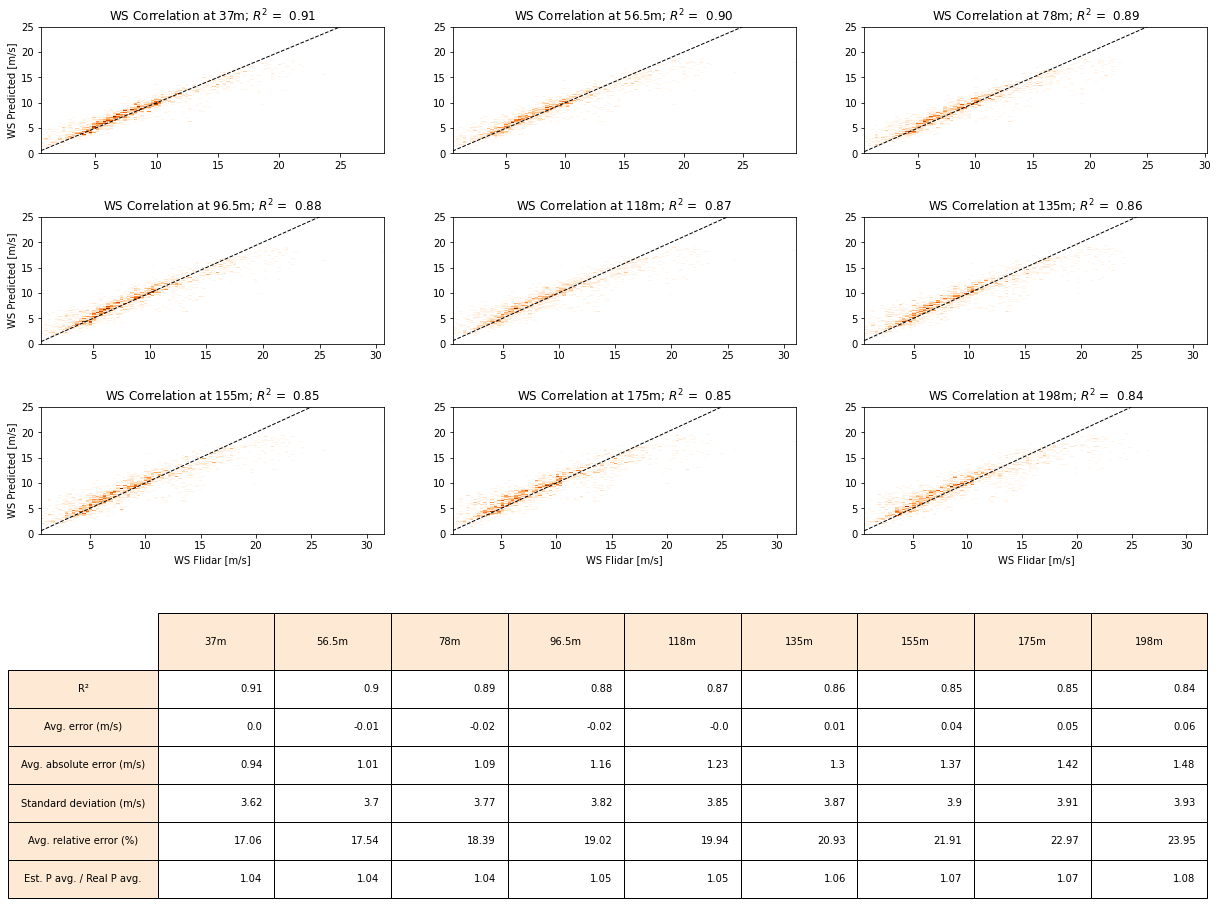

In [52]:
# Testing site A

df_X_train, df_X_test, df_X_test2, df_y_train, df_y_test, df_y_test2 = split(df_Xy_A, ratio)

gbm = CatBoostRegressor(iterations=1474, l2_leaf_reg=2, loss_function="MultiRMSE", learning_rate=0.1732866301752775, colsample_bylevel=0.09853487064153192, max_depth=15, random_strength=0.0018333014843607764, boosting_type="Plain", bootstrap_type="Bernoulli", subsample=0.5979248650535698)
gbm.fit(df_X_train, df_y_train)
test_model(gbm, heights, ["global"], "No", df_X_test2, df_y_test2)

In [32]:
# Optimizing site B

df_X_train, df_X_test, df_X_test2, df_y_train, df_y_test, df_y_test2 = split(df_Xy_B, ratio)


def objective(trial):
    X_train = df_X_train
    X_val = df_X_test
    y_train = df_y_train
    y_val = df_y_test

    param = {
        "iterations" : trial.suggest_int("iterations", 1, 1500),
        "l2_leaf_reg" : trial.suggest_int("l2_leaf_reg", 2, 10),
        "loss_function" : trial.suggest_categorical("loss_function", ["MultiRMSE"]),
        "learning_rate" : trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "max_depth" : trial.suggest_int("max_depth", 1, 15),
        "random_strength" : trial.suggest_loguniform("random_strength", 0.0001, 10.0),
        "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }
    

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_uniform("subsample", 0.1, 1)

    gbm = catboost.CatBoostRegressor(**param, )

    gbm.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 0, early_stopping_rounds = 15)

    predictions = gbm.predict(X_val)
    RMSE = mean_squared_error(y_val, predictions)
    
    return RMSE

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 400, show_progress_bar = True)


print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-19 18:16:19,837] A new study created in memory with name: no-name-3e78a7ee-a29e-414d-8975-e49c2758d21b
  0%|          | 1/400 [00:00<06:31,  1.02it/s]

[I 2022-08-19 18:16:20,818] Trial 0 finished with value: 2.520765031211553 and parameters: {'iterations': 492, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12342251307159181, 'colsample_bylevel': 0.09198872589376719, 'max_depth': 4, 'random_strength': 0.0019042958607645103, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.480321038444675}. Best is trial 0 with value: 2.520765031211553.


  0%|          | 2/400 [00:01<06:15,  1.06it/s]

[I 2022-08-19 18:16:21,737] Trial 1 finished with value: 4.58703876505408 and parameters: {'iterations': 572, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.012788240625295757, 'colsample_bylevel': 0.07048916300235769, 'max_depth': 15, 'random_strength': 0.007841011590610096, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 2.520765031211553.


  1%|          | 3/400 [00:03<08:48,  1.33s/it]

[I 2022-08-19 18:16:23,527] Trial 2 finished with value: 1.3557949483898866 and parameters: {'iterations': 1106, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11022229887967448, 'colsample_bylevel': 0.09452485768138164, 'max_depth': 12, 'random_strength': 0.016788711759477548, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.061699493625906}. Best is trial 2 with value: 1.3557949483898866.


  1%|          | 4/400 [00:06<12:12,  1.85s/it]

[I 2022-08-19 18:16:26,172] Trial 3 finished with value: 7.8938789926285375 and parameters: {'iterations': 1080, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0023483399932495348, 'colsample_bylevel': 0.09768168148442694, 'max_depth': 5, 'random_strength': 5.865475666138886, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.6546070998645535}. Best is trial 2 with value: 1.3557949483898866.


  1%|▏         | 5/400 [00:07<09:25,  1.43s/it]

[I 2022-08-19 18:16:26,860] Trial 4 finished with value: 3.211759059327323 and parameters: {'iterations': 766, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.024538922243962296, 'colsample_bylevel': 0.06043010545642986, 'max_depth': 14, 'random_strength': 0.04455532575771026, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.063234693014802}. Best is trial 2 with value: 1.3557949483898866.


  2%|▏         | 7/400 [00:13<14:21,  2.19s/it]

[I 2022-08-19 18:16:33,506] Trial 5 finished with value: 9.482711739661271 and parameters: {'iterations': 881, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0021702574198269762, 'colsample_bylevel': 0.09713602450559342, 'max_depth': 15, 'random_strength': 7.296288781168361, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5303451359587427}. Best is trial 2 with value: 1.3557949483898866.
[I 2022-08-19 18:16:33,611] Trial 6 finished with value: 18.575461530067855 and parameters: {'iterations': 105, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0016208593823845757, 'colsample_bylevel': 0.011119479523313883, 'max_depth': 11, 'random_strength': 0.0002486245990818108, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 1.3557949483898866.


  2%|▏         | 9/400 [00:22<19:52,  3.05s/it]

[I 2022-08-19 18:16:42,692] Trial 7 finished with value: 10.18195336584846 and parameters: {'iterations': 1371, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0013178200208965277, 'colsample_bylevel': 0.0797895948832716, 'max_depth': 12, 'random_strength': 0.002672176203411348, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.27638977690046507}. Best is trial 2 with value: 1.3557949483898866.
[I 2022-08-19 18:16:42,810] Trial 8 finished with value: 17.323426300296674 and parameters: {'iterations': 47, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.005305768946344603, 'colsample_bylevel': 0.06599755836466109, 'max_depth': 8, 'random_strength': 0.0012010155469378656, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5956498467806004}. Best is trial 2 with value: 1.3557949483898866.


  2%|▎         | 10/400 [00:23<14:15,  2.19s/it]

[I 2022-08-19 18:16:43,082] Trial 9 finished with value: 16.902055791096068 and parameters: {'iterations': 172, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0017902652121749088, 'colsample_bylevel': 0.07842651618735305, 'max_depth': 11, 'random_strength': 0.01920615961161844, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.327028947442894}. Best is trial 2 with value: 1.3557949483898866.


  3%|▎         | 11/400 [00:23<10:46,  1.66s/it]

[I 2022-08-19 18:16:43,544] Trial 10 finished with value: 2.295561367762816 and parameters: {'iterations': 1493, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26492404852980334, 'colsample_bylevel': 0.03640266598604627, 'max_depth': 8, 'random_strength': 0.2403397584456758, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9435214507680105}. Best is trial 2 with value: 1.3557949483898866.


  3%|▎         | 12/400 [00:24<08:53,  1.38s/it]

[I 2022-08-19 18:16:44,264] Trial 11 finished with value: 2.111765524235011 and parameters: {'iterations': 1472, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25238724950323066, 'colsample_bylevel': 0.036657814933085425, 'max_depth': 8, 'random_strength': 0.30275809946524174, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9730317605475696}. Best is trial 2 with value: 1.3557949483898866.


  3%|▎         | 13/400 [00:25<07:32,  1.17s/it]

[I 2022-08-19 18:16:44,959] Trial 12 finished with value: 3.489978187311481 and parameters: {'iterations': 1169, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07007520529129159, 'colsample_bylevel': 0.039930441811346806, 'max_depth': 1, 'random_strength': 0.32904436233546464, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9591237750614677}. Best is trial 2 with value: 1.3557949483898866.


  4%|▎         | 14/400 [00:25<06:32,  1.02s/it]

[I 2022-08-19 18:16:45,624] Trial 13 finished with value: 1.9029875569345573 and parameters: {'iterations': 1196, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24194542353047102, 'colsample_bylevel': 0.044460557538489515, 'max_depth': 6, 'random_strength': 0.16658014021106846, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6845281292099916}. Best is trial 2 with value: 1.3557949483898866.


  4%|▍         | 15/400 [00:26<06:40,  1.04s/it]

[I 2022-08-19 18:16:46,719] Trial 14 finished with value: 2.256951580116159 and parameters: {'iterations': 1126, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06415917433627776, 'colsample_bylevel': 0.04789701481292623, 'max_depth': 5, 'random_strength': 0.041472535872156026, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 1.3557949483898866.


  4%|▍         | 16/400 [00:27<05:29,  1.16it/s]

[I 2022-08-19 18:16:47,155] Trial 15 finished with value: 4.48836087031769 and parameters: {'iterations': 905, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10757578043395095, 'colsample_bylevel': 0.0202198065453921, 'max_depth': 10, 'random_strength': 0.922110511408001, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.334793125992256}. Best is trial 2 with value: 1.3557949483898866.


  4%|▍         | 17/400 [00:28<05:49,  1.10it/s]

[I 2022-08-19 18:16:48,193] Trial 16 finished with value: 2.9833309444924727 and parameters: {'iterations': 1241, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.029259822713039545, 'colsample_bylevel': 0.04867117427498093, 'max_depth': 3, 'random_strength': 0.08038085069794526, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6109546543509158}. Best is trial 2 with value: 1.3557949483898866.


  4%|▍         | 18/400 [00:28<04:38,  1.37it/s]

[I 2022-08-19 18:16:48,492] Trial 17 finished with value: 4.145306611606397 and parameters: {'iterations': 979, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1691525154122008, 'colsample_bylevel': 0.025065361975564783, 'max_depth': 6, 'random_strength': 1.1423795911962609, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.414569615370027}. Best is trial 2 with value: 1.3557949483898866.


  5%|▍         | 19/400 [00:31<08:01,  1.26s/it]

[I 2022-08-19 18:16:51,003] Trial 18 finished with value: 1.6594149268960359 and parameters: {'iterations': 1312, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.04041132353054793, 'colsample_bylevel': 0.08411269549490394, 'max_depth': 13, 'random_strength': 0.007202095133340325, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.641518115017785}. Best is trial 2 with value: 1.3557949483898866.


  5%|▌         | 20/400 [00:32<08:50,  1.40s/it]

[I 2022-08-19 18:16:52,704] Trial 19 finished with value: 1.979403710632235 and parameters: {'iterations': 606, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.043299835301820286, 'colsample_bylevel': 0.08431369600348736, 'max_depth': 13, 'random_strength': 0.009129239250440227, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 1.3557949483898866.


  5%|▌         | 21/400 [00:34<09:20,  1.48s/it]

[I 2022-08-19 18:16:54,379] Trial 20 finished with value: 2.5527314017955054 and parameters: {'iterations': 1292, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.010920132307801816, 'colsample_bylevel': 0.08772453413689377, 'max_depth': 10, 'random_strength': 0.00020444040166782946, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.14065899464680953}. Best is trial 2 with value: 1.3557949483898866.


  6%|▌         | 22/400 [00:37<11:13,  1.78s/it]

[I 2022-08-19 18:16:56,870] Trial 21 finished with value: 1.253420914885348 and parameters: {'iterations': 1343, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07891976904598007, 'colsample_bylevel': 0.07400315447370964, 'max_depth': 13, 'random_strength': 0.008873231204853976, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6693690617408529}. Best is trial 21 with value: 1.253420914885348.


  6%|▌         | 23/400 [00:39<11:48,  1.88s/it]

[I 2022-08-19 18:16:58,977] Trial 22 finished with value: 1.451269388420651 and parameters: {'iterations': 1355, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.05569131323086319, 'colsample_bylevel': 0.07179191171008037, 'max_depth': 13, 'random_strength': 0.005645298007523273, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7548521231430014}. Best is trial 21 with value: 1.253420914885348.


  6%|▌         | 24/400 [00:40<11:15,  1.80s/it]

[I 2022-08-19 18:17:00,576] Trial 23 finished with value: 1.4002890168910282 and parameters: {'iterations': 1026, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07389042337320925, 'colsample_bylevel': 0.07227149233886832, 'max_depth': 13, 'random_strength': 0.0005464721303582536, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7687278115605729}. Best is trial 21 with value: 1.253420914885348.


  6%|▋         | 25/400 [00:41<09:38,  1.54s/it]

[I 2022-08-19 18:17:01,527] Trial 24 finished with value: 1.7654042763876714 and parameters: {'iterations': 1041, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09213431196458625, 'colsample_bylevel': 0.05904238557267092, 'max_depth': 10, 'random_strength': 0.0005931493592015455, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.421602373695778}. Best is trial 21 with value: 1.253420914885348.


  6%|▋         | 26/400 [00:43<09:57,  1.60s/it]

[I 2022-08-19 18:17:03,253] Trial 25 finished with value: 1.3133948914449 and parameters: {'iterations': 789, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1653058925407322, 'colsample_bylevel': 0.07507260240413338, 'max_depth': 14, 'random_strength': 0.0004029207411698791, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.921643010547523}. Best is trial 21 with value: 1.253420914885348.


  7%|▋         | 27/400 [00:47<14:53,  2.40s/it]

[I 2022-08-19 18:17:07,512] Trial 26 finished with value: 1.028630381112872 and parameters: {'iterations': 778, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15654754838209475, 'colsample_bylevel': 0.09301026108610727, 'max_depth': 15, 'random_strength': 0.018425785815296063, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.088647939209955}. Best is trial 26 with value: 1.028630381112872.


  7%|▋         | 28/400 [00:52<20:03,  3.23s/it]

[I 2022-08-19 18:17:12,702] Trial 27 finished with value: 1.9724767352033088 and parameters: {'iterations': 289, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16417730178305429, 'colsample_bylevel': 0.07668003978423833, 'max_depth': 15, 'random_strength': 0.0007402180123831018, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.860311928986702}. Best is trial 26 with value: 1.028630381112872.


  7%|▋         | 29/400 [00:53<15:22,  2.49s/it]

[I 2022-08-19 18:17:13,445] Trial 28 finished with value: 1.8375624923623717 and parameters: {'iterations': 725, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16332942093054967, 'colsample_bylevel': 0.06470069757865626, 'max_depth': 14, 'random_strength': 0.00013066834730104233, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.369375288497753}. Best is trial 26 with value: 1.028630381112872.


  8%|▊         | 30/400 [01:06<34:56,  5.67s/it]

[I 2022-08-19 18:17:26,529] Trial 29 finished with value: 1.2449060682353754 and parameters: {'iterations': 737, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15994330034127138, 'colsample_bylevel': 0.0885695136057093, 'max_depth': 14, 'random_strength': 0.0033165470455491603, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.2855074312454615}. Best is trial 26 with value: 1.028630381112872.


  8%|▊         | 31/400 [01:11<33:24,  5.43s/it]

[I 2022-08-19 18:17:31,416] Trial 30 finished with value: 7.573660239928693 and parameters: {'iterations': 380, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.006639080048526274, 'colsample_bylevel': 0.08958315287230158, 'max_depth': 15, 'random_strength': 0.0032141871045046474, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.6265489640494724}. Best is trial 26 with value: 1.028630381112872.


  8%|▊         | 32/400 [01:24<46:53,  7.65s/it]

[I 2022-08-19 18:17:44,225] Trial 31 finished with value: 1.4823072711700147 and parameters: {'iterations': 757, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14767908781224579, 'colsample_bylevel': 0.08971699803692187, 'max_depth': 14, 'random_strength': 0.0016684099442201025, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.5078510997420005}. Best is trial 26 with value: 1.028630381112872.


  8%|▊         | 33/400 [01:34<51:31,  8.42s/it]

[I 2022-08-19 18:17:54,468] Trial 32 finished with value: 1.3127195035814396 and parameters: {'iterations': 509, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18562663710172075, 'colsample_bylevel': 0.08428969911850476, 'max_depth': 14, 'random_strength': 0.01822937649892464, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.824278868544848}. Best is trial 26 with value: 1.028630381112872.


  8%|▊         | 34/400 [02:16<1:53:07, 18.55s/it]

[I 2022-08-19 18:18:36,630] Trial 33 finished with value: 1.3237658742958902 and parameters: {'iterations': 539, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09972345506852429, 'colsample_bylevel': 0.09941242885647636, 'max_depth': 15, 'random_strength': 0.015495083722901835, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.5091054361304255}. Best is trial 26 with value: 1.028630381112872.


  9%|▉         | 35/400 [02:24<1:33:27, 15.36s/it]

[I 2022-08-19 18:18:44,568] Trial 34 finished with value: 1.227860202294574 and parameters: {'iterations': 414, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23914589160947822, 'colsample_bylevel': 0.09325629567624248, 'max_depth': 12, 'random_strength': 0.07912163709776186, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.7236773069386873}. Best is trial 26 with value: 1.028630381112872.


  9%|▉         | 36/400 [02:30<1:16:20, 12.58s/it]

[I 2022-08-19 18:18:50,670] Trial 35 finished with value: 1.5935580410937102 and parameters: {'iterations': 394, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2784395780023863, 'colsample_bylevel': 0.09333918887519001, 'max_depth': 12, 'random_strength': 0.09654657174682373, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.631785802114789}. Best is trial 26 with value: 1.028630381112872.


  9%|▉         | 37/400 [02:38<1:06:47, 11.04s/it]

[I 2022-08-19 18:18:58,106] Trial 36 finished with value: 1.251348272691712 and parameters: {'iterations': 641, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10525846645996705, 'colsample_bylevel': 0.09212478558641272, 'max_depth': 11, 'random_strength': 0.0035195992141560063, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 26 with value: 1.028630381112872.


 10%|▉         | 38/400 [02:46<1:00:38, 10.05s/it]

[I 2022-08-19 18:19:05,850] Trial 37 finished with value: 1.1357307711487787 and parameters: {'iterations': 681, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12183824514030452, 'colsample_bylevel': 0.09360142389592122, 'max_depth': 11, 'random_strength': 0.0037505903286822215, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 26 with value: 1.028630381112872.


 10%|▉         | 39/400 [02:51<52:10,  8.67s/it]  

[I 2022-08-19 18:19:11,302] Trial 38 finished with value: 2.0863209227623076 and parameters: {'iterations': 859, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.020950757470159877, 'colsample_bylevel': 0.09929879484195861, 'max_depth': 9, 'random_strength': 0.03299359011897222, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 26 with value: 1.028630381112872.


 10%|█         | 40/400 [02:59<51:14,  8.54s/it]

[I 2022-08-19 18:19:19,535] Trial 39 finished with value: 1.398223499456069 and parameters: {'iterations': 422, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1231515030444414, 'colsample_bylevel': 0.09490153329182538, 'max_depth': 12, 'random_strength': 0.05869454446970113, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 26 with value: 1.028630381112872.


 10%|█         | 41/400 [03:05<46:11,  7.72s/it]

[I 2022-08-19 18:19:25,344] Trial 40 finished with value: 1.2066459393122722 and parameters: {'iterations': 709, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21097037659783094, 'colsample_bylevel': 0.08174647180856152, 'max_depth': 12, 'random_strength': 0.00134900229162678, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 26 with value: 1.028630381112872.


 10%|█         | 42/400 [03:10<40:26,  6.78s/it]

[I 2022-08-19 18:19:29,922] Trial 41 finished with value: 1.2471722547142805 and parameters: {'iterations': 671, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22165366543111603, 'colsample_bylevel': 0.08217180830724666, 'max_depth': 12, 'random_strength': 0.003797955855959664, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 26 with value: 1.028630381112872.


 11%|█         | 43/400 [03:20<46:38,  7.84s/it]

[I 2022-08-19 18:19:40,238] Trial 42 finished with value: 0.9923074389751068 and parameters: {'iterations': 846, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2113702859337177, 'colsample_bylevel': 0.08763017488585519, 'max_depth': 12, 'random_strength': 0.001206827386861436, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 42 with value: 0.9923074389751068.


 11%|█         | 44/400 [03:25<40:56,  6.90s/it]

[I 2022-08-19 18:19:44,949] Trial 43 finished with value: 0.9347417332187388 and parameters: {'iterations': 843, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22347418066591396, 'colsample_bylevel': 0.09297573381690967, 'max_depth': 9, 'random_strength': 0.0012421798990834606, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 11%|█▏        | 45/400 [03:27<32:11,  5.44s/it]

[I 2022-08-19 18:19:46,983] Trial 44 finished with value: 1.5548126205472603 and parameters: {'iterations': 830, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1313513514161742, 'colsample_bylevel': 0.06686460485542144, 'max_depth': 9, 'random_strength': 0.0011522903241674878, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 12%|█▏        | 46/400 [03:28<25:13,  4.27s/it]

[I 2022-08-19 18:19:48,535] Trial 45 finished with value: 1.2786780031923701 and parameters: {'iterations': 686, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29175562377437353, 'colsample_bylevel': 0.0800820136444885, 'max_depth': 9, 'random_strength': 0.0017572374248297847, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 12%|█▏        | 47/400 [03:37<32:22,  5.50s/it]

[I 2022-08-19 18:19:56,905] Trial 46 finished with value: 0.9744206726733233 and parameters: {'iterations': 938, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22381481839767248, 'colsample_bylevel': 0.0961630739938866, 'max_depth': 11, 'random_strength': 0.0011835530977861626, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 12%|█▏        | 48/400 [03:50<45:23,  7.74s/it]

[I 2022-08-19 18:20:09,859] Trial 47 finished with value: 1.4386506275967936 and parameters: {'iterations': 974, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.04909869934324279, 'colsample_bylevel': 0.09621570382150701, 'max_depth': 11, 'random_strength': 0.00028266317639649924, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 12%|█▏        | 49/400 [03:52<36:02,  6.16s/it]

[I 2022-08-19 18:20:12,335] Trial 48 finished with value: 1.3251091186462458 and parameters: {'iterations': 924, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12144985818534247, 'colsample_bylevel': 0.08664605331709083, 'max_depth': 7, 'random_strength': 0.0010335899351955231, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 12%|█▎        | 50/400 [04:02<42:24,  7.27s/it]

[I 2022-08-19 18:20:22,199] Trial 49 finished with value: 5.8821236840415025 and parameters: {'iterations': 939, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.003591126808123403, 'colsample_bylevel': 0.09769982663821904, 'max_depth': 10, 'random_strength': 0.0021291293398478474, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 13%|█▎        | 51/400 [04:11<45:13,  7.77s/it]

[I 2022-08-19 18:20:31,149] Trial 50 finished with value: 0.9758473573313 and parameters: {'iterations': 814, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21290580428695036, 'colsample_bylevel': 0.09111154883412809, 'max_depth': 11, 'random_strength': 0.011981247120515836, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 13%|█▎        | 52/400 [04:19<46:20,  7.99s/it]

[I 2022-08-19 18:20:39,644] Trial 51 finished with value: 0.9821486903593237 and parameters: {'iterations': 802, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21317185689565843, 'colsample_bylevel': 0.09095938884251614, 'max_depth': 11, 'random_strength': 0.011924422847972889, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 13%|█▎        | 53/400 [04:24<39:49,  6.89s/it]

[I 2022-08-19 18:20:43,956] Trial 52 finished with value: 1.0303405462503703 and parameters: {'iterations': 806, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2029344037169848, 'colsample_bylevel': 0.09039624158115238, 'max_depth': 9, 'random_strength': 0.022163481653612517, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 14%|█▎        | 54/400 [04:27<33:44,  5.85s/it]

[I 2022-08-19 18:20:47,387] Trial 53 finished with value: 1.1904261090215704 and parameters: {'iterations': 846, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2998385242981244, 'colsample_bylevel': 0.08674072668291179, 'max_depth': 10, 'random_strength': 0.011498687910920877, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 14%|█▍        | 55/400 [04:29<27:22,  4.76s/it]

[I 2022-08-19 18:20:49,605] Trial 54 finished with value: 1.1390550405037305 and parameters: {'iterations': 589, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20464613635176626, 'colsample_bylevel': 0.09555673143399439, 'max_depth': 8, 'random_strength': 0.02509153995025385, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 14%|█▍        | 56/400 [04:46<48:04,  8.39s/it]

[I 2022-08-19 18:21:06,452] Trial 55 finished with value: 1.0367789182637093 and parameters: {'iterations': 1096, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09152745862583349, 'colsample_bylevel': 0.09989831857796834, 'max_depth': 11, 'random_strength': 0.0056213043213249915, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 14%|█▍        | 57/400 [04:50<40:56,  7.16s/it]

[I 2022-08-19 18:21:10,755] Trial 56 finished with value: 12.945941907679742 and parameters: {'iterations': 1017, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0010110381749918354, 'colsample_bylevel': 0.07916153708824257, 'max_depth': 10, 'random_strength': 0.00010094611394916016, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 14%|█▍        | 58/400 [04:53<32:31,  5.71s/it]

[I 2022-08-19 18:21:13,062] Trial 57 finished with value: 1.129925146229929 and parameters: {'iterations': 889, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23632187607897656, 'colsample_bylevel': 0.08598085194975501, 'max_depth': 7, 'random_strength': 0.012374732017733394, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 15%|█▍        | 59/400 [05:01<37:09,  6.54s/it]

[I 2022-08-19 18:21:21,539] Trial 58 finished with value: 1.1427249762892733 and parameters: {'iterations': 792, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14420592938198074, 'colsample_bylevel': 0.09094824288398039, 'max_depth': 11, 'random_strength': 3.6634448788178844, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 15%|█▌        | 60/400 [05:26<1:07:38, 11.94s/it]

[I 2022-08-19 18:21:46,073] Trial 59 finished with value: 2.478825182052835 and parameters: {'iterations': 975, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.013327180035114577, 'colsample_bylevel': 0.09594625019643059, 'max_depth': 13, 'random_strength': 0.00561916291463763, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 15%|█▌        | 61/400 [05:27<49:50,  8.82s/it]  

[I 2022-08-19 18:21:47,632] Trial 60 finished with value: 2.9381029154831126 and parameters: {'iterations': 881, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.029144264342915803, 'colsample_bylevel': 0.08278623024630649, 'max_depth': 2, 'random_strength': 0.14303237283119016, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 16%|█▌        | 62/400 [05:32<42:00,  7.46s/it]

[I 2022-08-19 18:21:51,902] Trial 61 finished with value: 1.0392526420936288 and parameters: {'iterations': 834, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20131345514637752, 'colsample_bylevel': 0.09181940260024622, 'max_depth': 9, 'random_strength': 0.027983557552930728, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 16%|█▌        | 63/400 [05:34<33:53,  6.03s/it]

[I 2022-08-19 18:21:54,612] Trial 62 finished with value: 1.051886723556349 and parameters: {'iterations': 818, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19959774405289138, 'colsample_bylevel': 0.08921229812427005, 'max_depth': 8, 'random_strength': 0.04643398039729804, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 16%|█▌        | 64/400 [05:35<24:51,  4.44s/it]

[I 2022-08-19 18:21:55,328] Trial 63 finished with value: 2.342651364978645 and parameters: {'iterations': 761, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25295643519772587, 'colsample_bylevel': 0.05400052224185053, 'max_depth': 9, 'random_strength': 0.007723882056390851, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 16%|█▋        | 65/400 [05:38<22:35,  4.05s/it]

[I 2022-08-19 18:21:58,459] Trial 64 finished with value: 1.2825473026842027 and parameters: {'iterations': 636, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17718253057668926, 'colsample_bylevel': 0.07662528500360588, 'max_depth': 10, 'random_strength': 0.023807627461290677, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 16%|█▋        | 66/400 [05:41<20:09,  3.62s/it]

[I 2022-08-19 18:22:01,090] Trial 65 finished with value: 1.360995390048434 and parameters: {'iterations': 935, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08479862222120872, 'colsample_bylevel': 0.09059601915706783, 'max_depth': 7, 'random_strength': 0.0003727286667047371, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 17%|█▋        | 67/400 [05:54<35:23,  6.38s/it]

[I 2022-08-19 18:22:13,901] Trial 66 finished with value: 1.0676398477942504 and parameters: {'iterations': 1130, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1404917292003861, 'colsample_bylevel': 0.08504202117728293, 'max_depth': 12, 'random_strength': 0.0008018757194562628, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 43 with value: 0.9347417332187388.


 17%|█▋        | 68/400 [05:56<28:54,  5.22s/it]

[I 2022-08-19 18:22:16,434] Trial 67 finished with value: 0.8182676704005988 and parameters: {'iterations': 1051, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24495800291341194, 'colsample_bylevel': 0.09706392201008536, 'max_depth': 11, 'random_strength': 0.5336625593518506, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 67 with value: 0.8182676704005988.


 17%|█▋        | 69/400 [05:58<22:38,  4.10s/it]

[I 2022-08-19 18:22:17,925] Trial 68 finished with value: 0.9298425578648725 and parameters: {'iterations': 1071, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29771717933436626, 'colsample_bylevel': 0.09749064844716666, 'max_depth': 11, 'random_strength': 3.1925848590171992, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 67 with value: 0.8182676704005988.


 18%|█▊        | 70/400 [06:00<19:25,  3.53s/it]

[I 2022-08-19 18:22:20,120] Trial 69 finished with value: 0.827592470546994 and parameters: {'iterations': 1044, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24874296761809303, 'colsample_bylevel': 0.09711554915110453, 'max_depth': 11, 'random_strength': 1.205474845172367, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 67 with value: 0.8182676704005988.


 18%|█▊        | 71/400 [06:02<17:02,  3.11s/it]

[I 2022-08-19 18:22:22,238] Trial 70 finished with value: 0.8711700808478492 and parameters: {'iterations': 1191, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26444262620304154, 'colsample_bylevel': 0.0975262683569489, 'max_depth': 11, 'random_strength': 0.7418182787811197, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 67 with value: 0.8182676704005988.


 18%|█▊        | 72/400 [06:05<16:13,  2.97s/it]

[I 2022-08-19 18:22:24,877] Trial 71 finished with value: 0.7703361267029282 and parameters: {'iterations': 1205, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.259687093256531, 'colsample_bylevel': 0.09716606477660854, 'max_depth': 11, 'random_strength': 0.5531936177958274, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.7703361267029282.


 18%|█▊        | 73/400 [06:07<14:32,  2.67s/it]

[I 2022-08-19 18:22:26,850] Trial 72 finished with value: 0.8326744526919488 and parameters: {'iterations': 1240, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2947169999858005, 'colsample_bylevel': 0.09760379560484193, 'max_depth': 11, 'random_strength': 0.5845516941339456, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.7703361267029282.


 18%|█▊        | 74/400 [06:09<13:25,  2.47s/it]

[I 2022-08-19 18:22:28,856] Trial 73 finished with value: 0.7703298721493571 and parameters: {'iterations': 1235, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29614040736975034, 'colsample_bylevel': 0.09786256519449611, 'max_depth': 10, 'random_strength': 0.6438511655278663, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 73 with value: 0.7703298721493571.


 19%|█▉        | 75/400 [06:10<11:45,  2.17s/it]

[I 2022-08-19 18:22:30,333] Trial 74 finished with value: 0.83694099989061 and parameters: {'iterations': 1220, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27020823588256593, 'colsample_bylevel': 0.09784314194644801, 'max_depth': 10, 'random_strength': 0.8635621733665699, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 73 with value: 0.7703298721493571.


 19%|█▉        | 76/400 [06:12<11:29,  2.13s/it]

[I 2022-08-19 18:22:32,354] Trial 75 finished with value: 0.7408737205315696 and parameters: {'iterations': 1227, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24502213441349618, 'colsample_bylevel': 0.09800956331334372, 'max_depth': 10, 'random_strength': 0.60174895331369, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 19%|█▉        | 77/400 [06:13<10:16,  1.91s/it]

[I 2022-08-19 18:22:33,758] Trial 76 finished with value: 0.8712461364212339 and parameters: {'iterations': 1248, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27663297025334865, 'colsample_bylevel': 0.09935884337237695, 'max_depth': 10, 'random_strength': 0.7820892772642535, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 20%|█▉        | 78/400 [06:15<09:01,  1.68s/it]

[I 2022-08-19 18:22:34,906] Trial 77 finished with value: 0.9695201945794807 and parameters: {'iterations': 1431, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18040402353875945, 'colsample_bylevel': 0.09706905839759847, 'max_depth': 10, 'random_strength': 0.5676625598610251, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 20%|█▉        | 79/400 [06:16<08:40,  1.62s/it]

[I 2022-08-19 18:22:36,387] Trial 78 finished with value: 0.7427455170265584 and parameters: {'iterations': 1181, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2567744123439165, 'colsample_bylevel': 0.09990476428843026, 'max_depth': 10, 'random_strength': 1.6564656943396332, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 20%|██        | 80/400 [06:16<06:24,  1.20s/it]

[I 2022-08-19 18:22:36,609] Trial 79 finished with value: 4.8735088682637375 and parameters: {'iterations': 1245, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2617120950972001, 'colsample_bylevel': 0.015113368076528022, 'max_depth': 10, 'random_strength': 2.0828186508385884, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 20%|██        | 81/400 [06:20<10:57,  2.06s/it]

[I 2022-08-19 18:22:40,681] Trial 80 finished with value: 0.8040192051347619 and parameters: {'iterations': 1150, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17480527875595897, 'colsample_bylevel': 0.09445286414559331, 'max_depth': 13, 'random_strength': 0.4400120424618179, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 20%|██        | 82/400 [06:22<10:36,  2.00s/it]

[I 2022-08-19 18:22:42,539] Trial 81 finished with value: 0.7525211831339013 and parameters: {'iterations': 1153, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25048942564513055, 'colsample_bylevel': 0.0942579626832027, 'max_depth': 10, 'random_strength': 0.4342542651429652, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 21%|██        | 83/400 [06:25<12:10,  2.30s/it]

[I 2022-08-19 18:22:45,548] Trial 82 finished with value: 0.7732644318085546 and parameters: {'iterations': 1147, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1787413638297572, 'colsample_bylevel': 0.09440765948739852, 'max_depth': 12, 'random_strength': 0.42867126648520104, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 21%|██        | 84/400 [06:29<14:16,  2.71s/it]

[I 2022-08-19 18:22:49,212] Trial 83 finished with value: 0.8347989430917294 and parameters: {'iterations': 1154, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16451954573135497, 'colsample_bylevel': 0.09431933806317568, 'max_depth': 13, 'random_strength': 0.3470161158961828, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 21%|██▏       | 85/400 [06:32<15:23,  2.93s/it]

[I 2022-08-19 18:22:52,659] Trial 84 finished with value: 0.7802895347122062 and parameters: {'iterations': 1312, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1758346560037761, 'colsample_bylevel': 0.09429958582345123, 'max_depth': 12, 'random_strength': 1.4458663701657668, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 22%|██▏       | 86/400 [06:36<15:46,  3.01s/it]

[I 2022-08-19 18:22:55,864] Trial 85 finished with value: 0.8517088236284293 and parameters: {'iterations': 1296, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11455453034174619, 'colsample_bylevel': 0.09439322583994388, 'max_depth': 12, 'random_strength': 1.51092896558763, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 22%|██▏       | 87/400 [06:36<12:12,  2.34s/it]

[I 2022-08-19 18:22:56,629] Trial 86 finished with value: 2.546383531303782 and parameters: {'iterations': 1394, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1360602705302009, 'colsample_bylevel': 0.03352640150690786, 'max_depth': 13, 'random_strength': 0.41403343166272044, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.11443487170660871}. Best is trial 75 with value: 0.7408737205315696.


 22%|██▏       | 88/400 [06:38<11:35,  2.23s/it]

[I 2022-08-19 18:22:58,605] Trial 87 finished with value: 1.0202654668453977 and parameters: {'iterations': 1167, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18039281704049195, 'colsample_bylevel': 0.08822567484291774, 'max_depth': 12, 'random_strength': 0.20820280557082343, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 22%|██▏       | 89/400 [06:42<14:14,  2.75s/it]

[I 2022-08-19 18:23:02,557] Trial 88 finished with value: 0.8387607966023027 and parameters: {'iterations': 1281, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1517523797821782, 'colsample_bylevel': 0.09400765315640576, 'max_depth': 13, 'random_strength': 8.688471420903612, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 22%|██▎       | 90/400 [06:47<16:43,  3.24s/it]

[I 2022-08-19 18:23:06,934] Trial 89 finished with value: 0.8276374014286747 and parameters: {'iterations': 1340, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10149313297569397, 'colsample_bylevel': 0.09918222514856102, 'max_depth': 12, 'random_strength': 1.8347809951567557, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 23%|██▎       | 91/400 [06:53<21:44,  4.22s/it]

[I 2022-08-19 18:23:13,459] Trial 90 finished with value: 0.744324702711485 and parameters: {'iterations': 1197, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18694217979313066, 'colsample_bylevel': 0.09984881011124762, 'max_depth': 14, 'random_strength': 0.5075277591828737, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 23%|██▎       | 92/400 [07:00<25:13,  4.91s/it]

[I 2022-08-19 18:23:19,981] Trial 91 finished with value: 0.7479814263242099 and parameters: {'iterations': 1119, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.182852198269054, 'colsample_bylevel': 0.09984939623737771, 'max_depth': 14, 'random_strength': 0.5233848188567438, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 23%|██▎       | 93/400 [07:05<26:33,  5.19s/it]

[I 2022-08-19 18:23:25,820] Trial 92 finished with value: 0.7853841449656505 and parameters: {'iterations': 1121, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18225872941942065, 'colsample_bylevel': 0.09469976777753428, 'max_depth': 14, 'random_strength': 0.21032993208727213, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 24%|██▎       | 94/400 [07:12<28:40,  5.62s/it]

[I 2022-08-19 18:23:32,449] Trial 93 finished with value: 0.7610743462810249 and parameters: {'iterations': 1189, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1488038387436795, 'colsample_bylevel': 0.09994462667927717, 'max_depth': 14, 'random_strength': 0.24082993997846128, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 24%|██▍       | 95/400 [07:20<31:35,  6.22s/it]

[I 2022-08-19 18:23:40,052] Trial 94 finished with value: 1.0207287554576838 and parameters: {'iterations': 1202, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06217475026858712, 'colsample_bylevel': 0.09894541257779621, 'max_depth': 14, 'random_strength': 1.1288690171554698, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 24%|██▍       | 96/400 [07:27<33:09,  6.55s/it]

[I 2022-08-19 18:23:47,366] Trial 95 finished with value: 0.8000082219678064 and parameters: {'iterations': 1371, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13395817746050231, 'colsample_bylevel': 0.09252165126981986, 'max_depth': 15, 'random_strength': 0.3004880146188844, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 24%|██▍       | 97/400 [07:33<31:41,  6.27s/it]

[I 2022-08-19 18:23:53,006] Trial 96 finished with value: 0.7573407767387157 and parameters: {'iterations': 1272, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15063833278223612, 'colsample_bylevel': 0.09575948994595974, 'max_depth': 14, 'random_strength': 0.13097123274628386, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 24%|██▍       | 98/400 [07:48<45:16,  9.00s/it]

[I 2022-08-19 18:24:08,354] Trial 97 finished with value: 0.8651823782539654 and parameters: {'iterations': 1206, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11336218762553324, 'colsample_bylevel': 0.09979151476487001, 'max_depth': 15, 'random_strength': 0.14657208636484698, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3956230541784798}. Best is trial 75 with value: 0.7408737205315696.


 25%|██▍       | 99/400 [07:54<40:58,  8.17s/it]

[I 2022-08-19 18:24:14,594] Trial 98 finished with value: 0.7995055657231463 and parameters: {'iterations': 1272, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1511369712241528, 'colsample_bylevel': 0.09979934374697737, 'max_depth': 14, 'random_strength': 0.251184328297041, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.7408737205315696.


 25%|██▌       | 100/400 [08:00<37:06,  7.42s/it]

[I 2022-08-19 18:24:20,274] Trial 99 finished with value: 0.7244086141716777 and parameters: {'iterations': 1161, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23681096341698918, 'colsample_bylevel': 0.09591277008015762, 'max_depth': 14, 'random_strength': 0.44047975195763, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 25%|██▌       | 101/400 [08:03<31:01,  6.23s/it]

[I 2022-08-19 18:24:23,706] Trial 100 finished with value: 0.7904340063248845 and parameters: {'iterations': 1421, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22748348774603713, 'colsample_bylevel': 0.09215979890447612, 'max_depth': 14, 'random_strength': 0.10952233430658084, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 26%|██▌       | 102/400 [08:10<31:40,  6.38s/it]

[I 2022-08-19 18:24:30,434] Trial 101 finished with value: 3.0701010462360885 and parameters: {'iterations': 1098, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.007430543510128754, 'colsample_bylevel': 0.09571328875725212, 'max_depth': 15, 'random_strength': 0.4262466259157307, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 26%|██▌       | 103/400 [08:13<25:40,  5.19s/it]

[I 2022-08-19 18:24:32,842] Trial 102 finished with value: 0.9344487158725836 and parameters: {'iterations': 1177, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24033779636687258, 'colsample_bylevel': 0.08902214950125568, 'max_depth': 14, 'random_strength': 0.6586040347872465, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 26%|██▌       | 104/400 [08:16<22:57,  4.65s/it]

[I 2022-08-19 18:24:36,256] Trial 103 finished with value: 0.8395048207833641 and parameters: {'iterations': 1223, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18629999063551908, 'colsample_bylevel': 0.09617460546104634, 'max_depth': 13, 'random_strength': 0.9480274118346322, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 26%|██▋       | 105/400 [08:20<21:26,  4.36s/it]

[I 2022-08-19 18:24:39,929] Trial 104 finished with value: 0.8842996352342215 and parameters: {'iterations': 1328, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20691667301009187, 'colsample_bylevel': 0.09172656753941809, 'max_depth': 15, 'random_strength': 0.2908474847786656, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 26%|██▋       | 106/400 [08:24<21:42,  4.43s/it]

[I 2022-08-19 18:24:44,519] Trial 105 finished with value: 0.7753852156316672 and parameters: {'iterations': 1080, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23692480734469118, 'colsample_bylevel': 0.09605821345513652, 'max_depth': 13, 'random_strength': 0.3796379655841088, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 27%|██▋       | 107/400 [08:31<24:47,  5.08s/it]

[I 2022-08-19 18:24:51,110] Trial 106 finished with value: 0.8146523667565985 and parameters: {'iterations': 1143, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1535912711458226, 'colsample_bylevel': 0.09997073681159485, 'max_depth': 14, 'random_strength': 0.49832679143804764, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 27%|██▋       | 108/400 [08:33<20:14,  4.16s/it]

[I 2022-08-19 18:24:53,132] Trial 107 finished with value: 0.734702765638305 and parameters: {'iterations': 1262, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.195595202569563, 'colsample_bylevel': 0.0982206996974395, 'max_depth': 9, 'random_strength': 0.17620052489218943, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 27%|██▋       | 109/400 [08:35<16:49,  3.47s/it]

[I 2022-08-19 18:24:54,986] Trial 108 finished with value: 0.8535699516081754 and parameters: {'iterations': 1277, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12629309596980845, 'colsample_bylevel': 0.097599007237714, 'max_depth': 9, 'random_strength': 0.17670399842381693, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 28%|██▊       | 110/400 [08:36<13:20,  2.76s/it]

[I 2022-08-19 18:24:56,094] Trial 109 finished with value: 0.8405996547464683 and parameters: {'iterations': 1011, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2705785624037227, 'colsample_bylevel': 0.09802948228613777, 'max_depth': 8, 'random_strength': 2.506895345486629, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 28%|██▊       | 111/400 [08:37<11:46,  2.44s/it]

[I 2022-08-19 18:24:57,803] Trial 110 finished with value: 0.7824564733105357 and parameters: {'iterations': 1253, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20005103116899764, 'colsample_bylevel': 0.08963847766677602, 'max_depth': 9, 'random_strength': 0.11914393592094542, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 28%|██▊       | 112/400 [08:39<10:55,  2.28s/it]

[I 2022-08-19 18:24:59,683] Trial 111 finished with value: 0.7914673874411579 and parameters: {'iterations': 1180, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22995447394188212, 'colsample_bylevel': 0.09251676808726472, 'max_depth': 10, 'random_strength': 0.2888867705215671, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 28%|██▊       | 113/400 [08:45<15:15,  3.19s/it]

[I 2022-08-19 18:25:05,002] Trial 112 finished with value: 0.7810160425775561 and parameters: {'iterations': 1115, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18949326169333455, 'colsample_bylevel': 0.09567826951682219, 'max_depth': 14, 'random_strength': 0.0715488019912584, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 28%|██▊       | 114/400 [08:46<12:36,  2.64s/it]

[I 2022-08-19 18:25:06,376] Trial 113 finished with value: 0.9153887207575535 and parameters: {'iterations': 1318, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1565368136511844, 'colsample_bylevel': 0.0935130932830174, 'max_depth': 10, 'random_strength': 0.23564383846093698, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 29%|██▉       | 115/400 [08:56<23:06,  4.86s/it]

[I 2022-08-19 18:25:16,421] Trial 114 finished with value: 0.758543481098912 and parameters: {'iterations': 1217, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24598545031048566, 'colsample_bylevel': 0.09838998803534882, 'max_depth': 15, 'random_strength': 0.6932794346475716, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 29%|██▉       | 116/400 [09:02<25:07,  5.31s/it]

[I 2022-08-19 18:25:22,767] Trial 115 finished with value: 0.8198386835087859 and parameters: {'iterations': 1226, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2947149189867591, 'colsample_bylevel': 0.09995605593156075, 'max_depth': 15, 'random_strength': 0.6761913016719667, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 29%|██▉       | 117/400 [09:12<30:55,  6.56s/it]

[I 2022-08-19 18:25:32,237] Trial 116 finished with value: 0.7546512229355519 and parameters: {'iterations': 1192, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2468586964637236, 'colsample_bylevel': 0.0977938336375439, 'max_depth': 15, 'random_strength': 1.1669524574806958, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 30%|██▉       | 118/400 [09:13<23:31,  5.01s/it]

[I 2022-08-19 18:25:33,625] Trial 117 finished with value: 0.9531530516633322 and parameters: {'iterations': 1372, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21482437515243985, 'colsample_bylevel': 0.0983231227731344, 'max_depth': 4, 'random_strength': 1.1856539054751432, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8572788153951558}. Best is trial 99 with value: 0.7244086141716777.


 30%|██▉       | 119/400 [09:21<26:59,  5.76s/it]

[I 2022-08-19 18:25:41,160] Trial 118 finished with value: 5.367127715931129 and parameters: {'iterations': 1281, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0029855730774912804, 'colsample_bylevel': 0.09584696020131432, 'max_depth': 15, 'random_strength': 1.0044621955924657, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 30%|███       | 120/400 [09:25<24:56,  5.35s/it]

[I 2022-08-19 18:25:45,529] Trial 119 finished with value: 0.782566223035534 and parameters: {'iterations': 1180, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24812081208351125, 'colsample_bylevel': 0.09076912483655138, 'max_depth': 15, 'random_strength': 1.4209966083796393, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 30%|███       | 121/400 [09:26<18:28,  3.97s/it]

[I 2022-08-19 18:25:46,293] Trial 120 finished with value: 1.3288946581166075 and parameters: {'iterations': 1259, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2210764770838689, 'colsample_bylevel': 0.059040247999070754, 'max_depth': 14, 'random_strength': 0.7733944001344013, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 30%|███       | 122/400 [09:35<25:20,  5.47s/it]

[I 2022-08-19 18:25:55,262] Trial 121 finished with value: 0.7346409279425463 and parameters: {'iterations': 1212, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26249268879986326, 'colsample_bylevel': 0.09792322215071385, 'max_depth': 15, 'random_strength': 4.6147287805511015, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 31%|███       | 123/400 [09:44<29:53,  6.47s/it]

[I 2022-08-19 18:26:04,074] Trial 122 finished with value: 0.7250140757640323 and parameters: {'iterations': 1110, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2981132775185674, 'colsample_bylevel': 0.09825250337354367, 'max_depth': 15, 'random_strength': 5.358994119023235, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 31%|███       | 124/400 [09:50<30:02,  6.53s/it]

[I 2022-08-19 18:26:10,742] Trial 123 finished with value: 0.7474712657997554 and parameters: {'iterations': 1117, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2644297270558665, 'colsample_bylevel': 0.09609270348465328, 'max_depth': 15, 'random_strength': 6.780510975589458, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 31%|███▏      | 125/400 [09:51<22:08,  4.83s/it]

[I 2022-08-19 18:26:11,603] Trial 124 finished with value: 1.2406442467058405 and parameters: {'iterations': 1116, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26308559225772127, 'colsample_bylevel': 0.06864949012421723, 'max_depth': 15, 'random_strength': 5.248120869770806, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 32%|███▏      | 126/400 [09:56<22:23,  4.90s/it]

[I 2022-08-19 18:26:16,681] Trial 125 finished with value: 1.4634948227225861 and parameters: {'iterations': 1059, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.037314929640901974, 'colsample_bylevel': 0.09281442532359013, 'max_depth': 15, 'random_strength': 3.7503879214106544, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 32%|███▏      | 127/400 [10:01<21:29,  4.72s/it]

[I 2022-08-19 18:26:20,979] Trial 126 finished with value: 0.9850355091020019 and parameters: {'iterations': 1154, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2999852563584044, 'colsample_bylevel': 0.09545730146286494, 'max_depth': 15, 'random_strength': 5.478821622653374, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.223969960040154}. Best is trial 99 with value: 0.7244086141716777.


 32%|███▏      | 128/400 [10:03<18:43,  4.13s/it]

[I 2022-08-19 18:26:23,724] Trial 127 finished with value: 0.9515621110045068 and parameters: {'iterations': 1081, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2354680892086641, 'colsample_bylevel': 0.08750534110739037, 'max_depth': 15, 'random_strength': 6.96883203507595, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 32%|███▏      | 129/400 [10:09<21:07,  4.68s/it]

[I 2022-08-19 18:26:29,681] Trial 128 finished with value: 0.78024547629533 and parameters: {'iterations': 1007, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1961158755802968, 'colsample_bylevel': 0.09809326392844435, 'max_depth': 15, 'random_strength': 4.3598357486480515, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 32%|███▎      | 130/400 [10:12<18:33,  4.12s/it]

[I 2022-08-19 18:26:32,508] Trial 129 finished with value: 0.9173127590445915 and parameters: {'iterations': 1109, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2595205993408211, 'colsample_bylevel': 0.09642105615652986, 'max_depth': 14, 'random_strength': 2.681274049989166, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 33%|███▎      | 131/400 [10:16<18:36,  4.15s/it]

[I 2022-08-19 18:26:36,721] Trial 130 finished with value: 0.8537899163652731 and parameters: {'iterations': 1301, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21138424225405897, 'colsample_bylevel': 0.09355396281364782, 'max_depth': 15, 'random_strength': 9.651864608182077, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 99 with value: 0.7244086141716777.


 33%|███▎      | 132/400 [10:23<21:52,  4.90s/it]

[I 2022-08-19 18:26:43,364] Trial 131 finished with value: 0.6950899604637487 and parameters: {'iterations': 1209, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16559431318454831, 'colsample_bylevel': 0.09988013851540359, 'max_depth': 14, 'random_strength': 7.2936634386619, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 33%|███▎      | 133/400 [10:31<25:39,  5.77s/it]

[I 2022-08-19 18:26:51,153] Trial 132 finished with value: 0.7487347785001263 and parameters: {'iterations': 1212, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1649266177139999, 'colsample_bylevel': 0.09826713363418108, 'max_depth': 14, 'random_strength': 7.426626922363036, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 34%|███▎      | 134/400 [10:35<23:23,  5.28s/it]

[I 2022-08-19 18:26:55,286] Trial 133 finished with value: 0.7640325129980856 and parameters: {'iterations': 1136, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16422346415297262, 'colsample_bylevel': 0.09531759403020129, 'max_depth': 14, 'random_strength': 6.973920616915233, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 34%|███▍      | 135/400 [10:36<17:29,  3.96s/it]

[I 2022-08-19 18:26:56,181] Trial 134 finished with value: 1.8754341376565842 and parameters: {'iterations': 1164, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19340787320827535, 'colsample_bylevel': 0.041906022380182144, 'max_depth': 14, 'random_strength': 7.721499722275672, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 34%|███▍      | 136/400 [10:42<20:34,  4.68s/it]

[I 2022-08-19 18:27:02,528] Trial 135 finished with value: 0.796943150291105 and parameters: {'iterations': 1197, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13964438960625875, 'colsample_bylevel': 0.09697271588066164, 'max_depth': 14, 'random_strength': 4.423622497300676, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 34%|███▍      | 137/400 [10:42<14:38,  3.34s/it]

[I 2022-08-19 18:27:02,744] Trial 136 finished with value: 4.2034475242673714 and parameters: {'iterations': 239, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16395669476815808, 'colsample_bylevel': 0.027439984691267058, 'max_depth': 13, 'random_strength': 5.97045607329614, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 34%|███▍      | 138/400 [10:44<11:55,  2.73s/it]

[I 2022-08-19 18:27:04,063] Trial 137 finished with value: 3.8052229087760443 and parameters: {'iterations': 1244, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.01584178988567774, 'colsample_bylevel': 0.050658110475529636, 'max_depth': 14, 'random_strength': 2.952378218962886, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 35%|███▍      | 139/400 [10:48<14:29,  3.33s/it]

[I 2022-08-19 18:27:08,787] Trial 138 finished with value: 0.7982823872263469 and parameters: {'iterations': 1216, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2252080577688999, 'colsample_bylevel': 0.09845219718540942, 'max_depth': 14, 'random_strength': 2.238844560371118, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 35%|███▌      | 140/400 [10:58<22:11,  5.12s/it]

[I 2022-08-19 18:27:18,090] Trial 139 finished with value: 0.7153134700550423 and parameters: {'iterations': 1171, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2717198021067587, 'colsample_bylevel': 0.0999634173769729, 'max_depth': 15, 'random_strength': 4.450418822913994, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 35%|███▌      | 141/400 [11:06<26:07,  6.05s/it]

[I 2022-08-19 18:27:26,317] Trial 140 finished with value: 1.027358572899835 and parameters: {'iterations': 1106, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2972295031445696, 'colsample_bylevel': 0.09984657855983725, 'max_depth': 15, 'random_strength': 3.7149765665171994, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.26980472316621207}. Best is trial 131 with value: 0.6950899604637487.


 36%|███▌      | 142/400 [11:10<23:45,  5.53s/it]

[I 2022-08-19 18:27:30,612] Trial 141 finished with value: 0.7999762059427011 and parameters: {'iterations': 1167, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26632363507238177, 'colsample_bylevel': 0.09637100136452825, 'max_depth': 15, 'random_strength': 4.922152973730885, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 36%|███▌      | 143/400 [11:16<24:25,  5.70s/it]

[I 2022-08-19 18:27:36,731] Trial 142 finished with value: 0.7390883122528846 and parameters: {'iterations': 1269, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19916930771005498, 'colsample_bylevel': 0.09455494268649768, 'max_depth': 14, 'random_strength': 6.088337420576705, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 36%|███▌      | 144/400 [11:24<26:38,  6.24s/it]

[I 2022-08-19 18:27:44,235] Trial 143 finished with value: 0.7716232687052501 and parameters: {'iterations': 1189, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19382494566369388, 'colsample_bylevel': 0.09428340868721266, 'max_depth': 15, 'random_strength': 6.594181581585926, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 36%|███▋      | 145/400 [11:33<30:01,  7.06s/it]

[I 2022-08-19 18:27:53,209] Trial 144 finished with value: 0.7445804679037247 and parameters: {'iterations': 1138, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22253904478253547, 'colsample_bylevel': 0.09773558909209513, 'max_depth': 15, 'random_strength': 9.226506191194208, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.
[I 2022-08-19 18:27:53,306] Trial 145 finished with value: 6.609338969514255 and parameters: {'iterations': 18, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2174630165761093, 'colsample_bylevel': 0.09999915596025578, 'max_depth': 14, 'random_strength': 9.349750555424466, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 37%|███▋      | 147/400 [11:34<17:22,  4.12s/it]

[I 2022-08-19 18:27:54,589] Trial 146 finished with value: 1.0481609983744682 and parameters: {'iterations': 1061, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1763838762349142, 'colsample_bylevel': 0.09162150760766288, 'max_depth': 5, 'random_strength': 8.023135402777692, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 37%|███▋      | 148/400 [11:38<17:04,  4.07s/it]

[I 2022-08-19 18:27:58,492] Trial 147 finished with value: 0.7504000671092197 and parameters: {'iterations': 1130, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26841197389695237, 'colsample_bylevel': 0.09336095933916622, 'max_depth': 13, 'random_strength': 3.356253975344153, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 37%|███▋      | 149/400 [11:41<15:32,  3.71s/it]

[I 2022-08-19 18:28:01,209] Trial 148 finished with value: 1.1850155843551233 and parameters: {'iterations': 1126, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2723085825068854, 'colsample_bylevel': 0.09766511869488124, 'max_depth': 13, 'random_strength': 3.2384146343789757, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.373747850881006}. Best is trial 131 with value: 0.6950899604637487.


 38%|███▊      | 150/400 [11:44<14:41,  3.53s/it]

[I 2022-08-19 18:28:04,236] Trial 149 finished with value: 0.8140327007797779 and parameters: {'iterations': 1039, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20124309040026586, 'colsample_bylevel': 0.09297084903923516, 'max_depth': 14, 'random_strength': 4.354384393452034, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 38%|███▊      | 151/400 [11:47<13:58,  3.37s/it]

[I 2022-08-19 18:28:07,191] Trial 150 finished with value: 0.8205753910519468 and parameters: {'iterations': 1081, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22932609688330038, 'colsample_bylevel': 0.09011635787476052, 'max_depth': 14, 'random_strength': 5.867825948911877, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 38%|███▊      | 152/400 [11:53<17:03,  4.13s/it]

[I 2022-08-19 18:28:13,222] Trial 151 finished with value: 0.7918411553714328 and parameters: {'iterations': 1140, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2677897847162081, 'colsample_bylevel': 0.09458448191871716, 'max_depth': 15, 'random_strength': 1.8401733418153496, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 38%|███▊      | 153/400 [11:59<18:57,  4.60s/it]

[I 2022-08-19 18:28:18,991] Trial 152 finished with value: 0.7507030912798219 and parameters: {'iterations': 1237, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23469585904581206, 'colsample_bylevel': 0.09828898355964243, 'max_depth': 14, 'random_strength': 6.794341599365248, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 38%|███▊      | 154/400 [12:05<21:15,  5.18s/it]

[I 2022-08-19 18:28:25,577] Trial 153 finished with value: 0.7765636508433318 and parameters: {'iterations': 1237, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2110792111709914, 'colsample_bylevel': 0.09999918949660783, 'max_depth': 14, 'random_strength': 7.6257463544147495, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 39%|███▉      | 155/400 [12:11<21:32,  5.27s/it]

[I 2022-08-19 18:28:31,066] Trial 154 finished with value: 0.7446254079121464 and parameters: {'iterations': 1292, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1738228703827008, 'colsample_bylevel': 0.09675003464659832, 'max_depth': 13, 'random_strength': 9.754015272113671, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 39%|███▉      | 156/400 [12:16<21:42,  5.34s/it]

[I 2022-08-19 18:28:36,555] Trial 155 finished with value: 0.7205676085671047 and parameters: {'iterations': 1311, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1777691888927792, 'colsample_bylevel': 0.09641264862842613, 'max_depth': 13, 'random_strength': 4.3428907065730495, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 39%|███▉      | 157/400 [12:22<22:15,  5.50s/it]

[I 2022-08-19 18:28:42,431] Trial 156 finished with value: 0.7190610019109488 and parameters: {'iterations': 1372, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16777751287205017, 'colsample_bylevel': 0.09663765451728447, 'max_depth': 13, 'random_strength': 9.212009792323737, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 40%|███▉      | 158/400 [12:28<23:00,  5.70s/it]

[I 2022-08-19 18:28:48,615] Trial 157 finished with value: 0.749813814456849 and parameters: {'iterations': 1499, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12577949671784477, 'colsample_bylevel': 0.09634758175938386, 'max_depth': 13, 'random_strength': 5.097934165478197, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 131 with value: 0.6950899604637487.


 40%|███▉      | 159/400 [12:34<23:18,  5.80s/it]

[I 2022-08-19 18:28:54,658] Trial 158 finished with value: 0.6793303029217785 and parameters: {'iterations': 1455, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1818980332388485, 'colsample_bylevel': 0.09646485293775842, 'max_depth': 13, 'random_strength': 9.79460128604094, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 40%|████      | 160/400 [12:40<22:35,  5.65s/it]

[I 2022-08-19 18:28:59,947] Trial 159 finished with value: 0.7145961363066545 and parameters: {'iterations': 1449, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18965892072632484, 'colsample_bylevel': 0.09569147081898051, 'max_depth': 13, 'random_strength': 5.586720104850711, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 40%|████      | 161/400 [12:43<20:01,  5.03s/it]

[I 2022-08-19 18:29:03,521] Trial 160 finished with value: 0.8313314891486051 and parameters: {'iterations': 1433, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1376692344945255, 'colsample_bylevel': 0.0916368695048527, 'max_depth': 13, 'random_strength': 9.796487855927277, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 40%|████      | 162/400 [12:48<20:09,  5.08s/it]

[I 2022-08-19 18:29:08,730] Trial 161 finished with value: 0.7306113771319573 and parameters: {'iterations': 1461, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18156004595060743, 'colsample_bylevel': 0.09575824708711632, 'max_depth': 13, 'random_strength': 9.795789112158124, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 41%|████      | 163/400 [12:54<20:06,  5.09s/it]

[I 2022-08-19 18:29:13,845] Trial 162 finished with value: 0.7136642061697498 and parameters: {'iterations': 1454, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17239725828943175, 'colsample_bylevel': 0.09533704096591282, 'max_depth': 13, 'random_strength': 9.917718655353715, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 41%|████      | 164/400 [12:59<20:04,  5.11s/it]

[I 2022-08-19 18:29:18,981] Trial 163 finished with value: 0.7226366660369306 and parameters: {'iterations': 1439, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18812266334077735, 'colsample_bylevel': 0.0949253875789693, 'max_depth': 13, 'random_strength': 4.551479885097327, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 41%|████▏     | 165/400 [13:04<19:51,  5.07s/it]

[I 2022-08-19 18:29:23,962] Trial 164 finished with value: 0.7420591713260873 and parameters: {'iterations': 1466, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1867943080225256, 'colsample_bylevel': 0.09507396471866146, 'max_depth': 13, 'random_strength': 4.2915589962983915, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 42%|████▏     | 166/400 [13:09<19:41,  5.05s/it]

[I 2022-08-19 18:29:28,960] Trial 165 finished with value: 0.8544213108333305 and parameters: {'iterations': 1466, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10834908985864099, 'colsample_bylevel': 0.09437382693405852, 'max_depth': 13, 'random_strength': 4.389498585288788, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 42%|████▏     | 167/400 [13:11<16:28,  4.24s/it]

[I 2022-08-19 18:29:31,321] Trial 166 finished with value: 0.8735270357293995 and parameters: {'iterations': 1449, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16753980247578143, 'colsample_bylevel': 0.09236120654050474, 'max_depth': 12, 'random_strength': 5.445666410073641, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 42%|████▏     | 168/400 [13:16<16:47,  4.34s/it]

[I 2022-08-19 18:29:35,898] Trial 167 finished with value: 0.741272501720041 and parameters: {'iterations': 1394, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14607421159781797, 'colsample_bylevel': 0.0952249506948287, 'max_depth': 13, 'random_strength': 3.648077281123699, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 42%|████▏     | 169/400 [13:19<16:05,  4.18s/it]

[I 2022-08-19 18:29:39,705] Trial 168 finished with value: 0.8193986349474237 and parameters: {'iterations': 1403, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14491197806205386, 'colsample_bylevel': 0.08877411947948621, 'max_depth': 13, 'random_strength': 2.6139409253292416, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 42%|████▎     | 170/400 [13:23<15:09,  3.95s/it]

[I 2022-08-19 18:29:43,131] Trial 169 finished with value: 0.8884674178552517 and parameters: {'iterations': 1473, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13106104918158293, 'colsample_bylevel': 0.09501666633745291, 'max_depth': 13, 'random_strength': 3.8829811477685454, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 43%|████▎     | 171/400 [13:26<14:33,  3.81s/it]

[I 2022-08-19 18:29:46,616] Trial 170 finished with value: 0.7843373407065619 and parameters: {'iterations': 1393, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1575664450053026, 'colsample_bylevel': 0.09065224524239703, 'max_depth': 13, 'random_strength': 5.5951790400895165, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 43%|████▎     | 172/400 [13:30<14:01,  3.69s/it]

[I 2022-08-19 18:29:50,022] Trial 171 finished with value: 0.7376677295750724 and parameters: {'iterations': 1350, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19829007773282442, 'colsample_bylevel': 0.0953221500444666, 'max_depth': 12, 'random_strength': 3.2838997181557237, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 43%|████▎     | 173/400 [13:34<14:14,  3.76s/it]

[I 2022-08-19 18:29:53,956] Trial 172 finished with value: 0.7281439672327232 and parameters: {'iterations': 1349, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19351796906129262, 'colsample_bylevel': 0.09312376418284112, 'max_depth': 12, 'random_strength': 4.769400890672135, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 44%|████▎     | 174/400 [13:36<12:54,  3.43s/it]

[I 2022-08-19 18:29:56,604] Trial 173 finished with value: 0.8099813624431915 and parameters: {'iterations': 1352, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19436813674356984, 'colsample_bylevel': 0.0931642567720647, 'max_depth': 12, 'random_strength': 6.265560880178852, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 44%|████▍     | 175/400 [13:39<12:16,  3.27s/it]

[I 2022-08-19 18:29:59,509] Trial 174 finished with value: 0.8216087144532676 and parameters: {'iterations': 1416, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16616247748838509, 'colsample_bylevel': 0.0966896417956914, 'max_depth': 12, 'random_strength': 2.879681288355689, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 44%|████▍     | 176/400 [13:43<12:22,  3.31s/it]

[I 2022-08-19 18:30:02,922] Trial 175 finished with value: 0.7572335960620331 and parameters: {'iterations': 1371, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20308692264183673, 'colsample_bylevel': 0.0921454514594962, 'max_depth': 12, 'random_strength': 4.935255498220046, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 44%|████▍     | 177/400 [13:47<13:39,  3.67s/it]

[I 2022-08-19 18:30:07,437] Trial 176 finished with value: 0.8048219241842575 and parameters: {'iterations': 1349, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14691761284215665, 'colsample_bylevel': 0.0947891020150105, 'max_depth': 13, 'random_strength': 7.9921464932118855, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 44%|████▍     | 178/400 [13:54<17:29,  4.73s/it]

[I 2022-08-19 18:30:14,629] Trial 177 finished with value: 0.8541148452357594 and parameters: {'iterations': 1440, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12388592535597538, 'colsample_bylevel': 0.09607819219863012, 'max_depth': 13, 'random_strength': 3.5418225487468535, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5270691116594444}. Best is trial 158 with value: 0.6793303029217785.


 45%|████▍     | 179/400 [13:58<16:21,  4.44s/it]

[I 2022-08-19 18:30:18,394] Trial 178 finished with value: 0.7380669396917625 and parameters: {'iterations': 1389, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1878732389255659, 'colsample_bylevel': 0.09394039837788763, 'max_depth': 12, 'random_strength': 6.1074625937319755, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 45%|████▌     | 180/400 [14:01<14:36,  3.98s/it]

[I 2022-08-19 18:30:21,315] Trial 179 finished with value: 0.9256521701055789 and parameters: {'iterations': 1373, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1794529009774899, 'colsample_bylevel': 0.08593951840344446, 'max_depth': 12, 'random_strength': 5.964196963572566, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 45%|████▌     | 181/400 [14:03<12:54,  3.53s/it]

[I 2022-08-19 18:30:23,800] Trial 180 finished with value: 0.8205677532490164 and parameters: {'iterations': 1330, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2101403786450319, 'colsample_bylevel': 0.09009363223225249, 'max_depth': 12, 'random_strength': 7.812469585415622, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 46%|████▌     | 182/400 [14:09<14:36,  4.02s/it]

[I 2022-08-19 18:30:28,960] Trial 181 finished with value: 0.724487670406102 and parameters: {'iterations': 1404, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16316919911384117, 'colsample_bylevel': 0.09343614379980918, 'max_depth': 13, 'random_strength': 2.2169611849177815, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 46%|████▌     | 183/400 [14:14<16:07,  4.46s/it]

[I 2022-08-19 18:30:34,440] Trial 182 finished with value: 0.7178157148107639 and parameters: {'iterations': 1490, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19076876955808963, 'colsample_bylevel': 0.09327631788489399, 'max_depth': 13, 'random_strength': 2.179395497642749, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 46%|████▌     | 184/400 [14:17<14:09,  3.93s/it]

[I 2022-08-19 18:30:37,139] Trial 183 finished with value: 0.8496425097222186 and parameters: {'iterations': 1486, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16738724904507266, 'colsample_bylevel': 0.09274130842724919, 'max_depth': 13, 'random_strength': 4.9733647107131365, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 46%|████▋     | 185/400 [14:20<13:47,  3.85s/it]

[I 2022-08-19 18:30:40,800] Trial 184 finished with value: 0.7722669122405119 and parameters: {'iterations': 1446, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1915637196279156, 'colsample_bylevel': 0.09338625248764482, 'max_depth': 12, 'random_strength': 2.3144590465480754, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 46%|████▋     | 186/400 [14:22<11:12,  3.14s/it]

[I 2022-08-19 18:30:42,286] Trial 185 finished with value: 1.5202584977926112 and parameters: {'iterations': 1428, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21786843835450664, 'colsample_bylevel': 0.0627436383415599, 'max_depth': 13, 'random_strength': 6.494859367518889, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.583346815183901}. Best is trial 158 with value: 0.6793303029217785.


 47%|████▋     | 187/400 [14:26<11:55,  3.36s/it]

[I 2022-08-19 18:30:46,153] Trial 186 finished with value: 0.7920290742026623 and parameters: {'iterations': 1400, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16121910634142547, 'colsample_bylevel': 0.09128094704388265, 'max_depth': 13, 'random_strength': 9.701412013345857, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 47%|████▋     | 188/400 [14:30<12:41,  3.59s/it]

[I 2022-08-19 18:30:50,281] Trial 187 finished with value: 0.7514106253160721 and parameters: {'iterations': 1466, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1858068067620774, 'colsample_bylevel': 0.08892050708168622, 'max_depth': 13, 'random_strength': 3.0316290919536346, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 47%|████▋     | 189/400 [14:34<12:51,  3.66s/it]

[I 2022-08-19 18:30:54,096] Trial 188 finished with value: 8.564169794097259 and parameters: {'iterations': 1321, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0016164647399049663, 'colsample_bylevel': 0.09681226140533244, 'max_depth': 12, 'random_strength': 4.439163302580094, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 48%|████▊     | 190/400 [14:38<13:25,  3.84s/it]

[I 2022-08-19 18:30:58,355] Trial 189 finished with value: 0.7435174004250257 and parameters: {'iterations': 1490, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20996389085208186, 'colsample_bylevel': 0.09399715766942199, 'max_depth': 13, 'random_strength': 7.729221568527557, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 48%|████▊     | 191/400 [14:42<13:55,  4.00s/it]

[I 2022-08-19 18:31:02,719] Trial 190 finished with value: 0.7356140539503044 and parameters: {'iterations': 1359, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14060577335688065, 'colsample_bylevel': 0.09765095630948818, 'max_depth': 12, 'random_strength': 2.039632537055047, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 48%|████▊     | 192/400 [14:47<14:24,  4.16s/it]

[I 2022-08-19 18:31:07,254] Trial 191 finished with value: 0.7189182396965247 and parameters: {'iterations': 1372, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17214845565989115, 'colsample_bylevel': 0.0981587084366147, 'max_depth': 12, 'random_strength': 2.4794283310017815, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 48%|████▊     | 193/400 [14:51<14:42,  4.26s/it]

[I 2022-08-19 18:31:11,768] Trial 192 finished with value: 0.6958430519863672 and parameters: {'iterations': 1361, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16334853431718346, 'colsample_bylevel': 0.09818132690155938, 'max_depth': 12, 'random_strength': 1.9196950122022103, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 48%|████▊     | 194/400 [14:55<14:04,  4.10s/it]

[I 2022-08-19 18:31:15,479] Trial 193 finished with value: 0.8124482453046249 and parameters: {'iterations': 1360, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1339582007618534, 'colsample_bylevel': 0.09840392090424643, 'max_depth': 12, 'random_strength': 1.9382111787355327, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 49%|████▉     | 195/400 [15:00<14:35,  4.27s/it]

[I 2022-08-19 18:31:20,157] Trial 194 finished with value: 0.7215215127905691 and parameters: {'iterations': 1421, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1530629612433597, 'colsample_bylevel': 0.09774686714403526, 'max_depth': 12, 'random_strength': 2.2692335674409443, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 49%|████▉     | 196/400 [15:05<14:57,  4.40s/it]

[I 2022-08-19 18:31:24,859] Trial 195 finished with value: 0.7805637690040255 and parameters: {'iterations': 1417, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1176106744213516, 'colsample_bylevel': 0.09801074328949641, 'max_depth': 12, 'random_strength': 1.5218390395499704, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 49%|████▉     | 197/400 [15:09<15:11,  4.49s/it]

[I 2022-08-19 18:31:29,551] Trial 196 finished with value: 0.7722016934202514 and parameters: {'iterations': 1447, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15229383665192098, 'colsample_bylevel': 0.09723201136677684, 'max_depth': 13, 'random_strength': 2.296480802586114, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 50%|████▉     | 198/400 [15:14<15:27,  4.59s/it]

[I 2022-08-19 18:31:34,385] Trial 197 finished with value: 0.7888602515569585 and parameters: {'iterations': 1497, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09330825485706595, 'colsample_bylevel': 0.09850145037620435, 'max_depth': 12, 'random_strength': 1.859657109559274, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 50%|████▉     | 199/400 [15:20<16:31,  4.93s/it]

[I 2022-08-19 18:31:40,113] Trial 198 finished with value: 2.492214490692319 and parameters: {'iterations': 1414, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.008465724670408984, 'colsample_bylevel': 0.0967247181601448, 'max_depth': 13, 'random_strength': 2.3892153494584614, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 50%|█████     | 200/400 [15:23<14:25,  4.33s/it]

[I 2022-08-19 18:31:43,027] Trial 199 finished with value: 0.7341616283750775 and parameters: {'iterations': 1452, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16856911720247036, 'colsample_bylevel': 0.09834121538569535, 'max_depth': 11, 'random_strength': 2.9476252378890813, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 50%|█████     | 201/400 [15:24<11:08,  3.36s/it]

[I 2022-08-19 18:31:44,122] Trial 200 finished with value: 2.5145775520547167 and parameters: {'iterations': 1451, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16749224511595256, 'colsample_bylevel': 0.09834538588984612, 'max_depth': 1, 'random_strength': 2.6272836436269023, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 50%|█████     | 202/400 [15:27<10:57,  3.32s/it]

[I 2022-08-19 18:31:47,353] Trial 201 finished with value: 0.7424826251152759 and parameters: {'iterations': 1390, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14501911561205522, 'colsample_bylevel': 0.09651476761188423, 'max_depth': 11, 'random_strength': 1.9456968094357927, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 51%|█████     | 203/400 [15:32<12:26,  3.79s/it]

[I 2022-08-19 18:31:52,236] Trial 202 finished with value: 1.5513119381007467 and parameters: {'iterations': 1431, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.022414627221789888, 'colsample_bylevel': 0.09891606621927014, 'max_depth': 12, 'random_strength': 3.053402045499118, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 51%|█████     | 204/400 [15:38<14:47,  4.53s/it]

[I 2022-08-19 18:31:58,495] Trial 203 finished with value: 0.7149097200119935 and parameters: {'iterations': 1322, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16934354620369854, 'colsample_bylevel': 0.09995764214529868, 'max_depth': 13, 'random_strength': 4.049603498048554, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 51%|█████▏    | 205/400 [15:43<15:15,  4.70s/it]

[I 2022-08-19 18:32:03,583] Trial 204 finished with value: 0.7489257209891161 and parameters: {'iterations': 1317, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17024762640945607, 'colsample_bylevel': 0.09610168815835331, 'max_depth': 13, 'random_strength': 4.11626925245989, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 158 with value: 0.6793303029217785.


 52%|█████▏    | 206/400 [15:50<16:43,  5.17s/it]

[I 2022-08-19 18:32:09,872] Trial 205 finished with value: 0.6693299061454776 and parameters: {'iterations': 1465, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16116148329695745, 'colsample_bylevel': 0.0997637236130251, 'max_depth': 13, 'random_strength': 4.8107710495169025, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 205 with value: 0.6693299061454776.


 52%|█████▏    | 207/400 [15:56<17:46,  5.53s/it]

[I 2022-08-19 18:32:16,222] Trial 206 finished with value: 0.6681297089007834 and parameters: {'iterations': 1458, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1568775339338561, 'colsample_bylevel': 0.09864986747107692, 'max_depth': 13, 'random_strength': 3.938444807736528, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 52%|█████▏    | 208/400 [16:02<18:34,  5.80s/it]

[I 2022-08-19 18:32:22,670] Trial 207 finished with value: 0.6882529407645236 and parameters: {'iterations': 1463, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15474456337316136, 'colsample_bylevel': 0.09988905946483799, 'max_depth': 13, 'random_strength': 3.6990566402663196, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 52%|█████▏    | 209/400 [16:09<19:16,  6.06s/it]

[I 2022-08-19 18:32:29,320] Trial 208 finished with value: 0.7527617548795872 and parameters: {'iterations': 1419, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11791196182406458, 'colsample_bylevel': 0.09918645535668986, 'max_depth': 13, 'random_strength': 3.8312025513562906, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 52%|█████▎    | 210/400 [16:16<19:57,  6.30s/it]

[I 2022-08-19 18:32:36,189] Trial 209 finished with value: 0.6897828041784161 and parameters: {'iterations': 1498, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13803971204019602, 'colsample_bylevel': 0.09971516154061912, 'max_depth': 13, 'random_strength': 4.9913201788929396, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 53%|█████▎    | 211/400 [16:23<20:14,  6.42s/it]

[I 2022-08-19 18:32:42,902] Trial 210 finished with value: 0.6783112007879365 and parameters: {'iterations': 1491, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1481645438532922, 'colsample_bylevel': 0.09989203826954098, 'max_depth': 13, 'random_strength': 4.5309667790032835, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 53%|█████▎    | 212/400 [16:29<20:13,  6.45s/it]

[I 2022-08-19 18:32:49,421] Trial 211 finished with value: 0.6790923220568411 and parameters: {'iterations': 1495, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.129967495219711, 'colsample_bylevel': 0.0999042079016256, 'max_depth': 13, 'random_strength': 4.965399127613291, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 53%|█████▎    | 213/400 [16:36<20:32,  6.59s/it]

[I 2022-08-19 18:32:56,328] Trial 212 finished with value: 0.7098464067296651 and parameters: {'iterations': 1500, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13311839796879438, 'colsample_bylevel': 0.09990215904466843, 'max_depth': 13, 'random_strength': 3.687749506469603, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 54%|█████▎    | 214/400 [16:42<20:19,  6.55s/it]

[I 2022-08-19 18:33:02,803] Trial 213 finished with value: 0.7112195788835786 and parameters: {'iterations': 1485, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12603187562257576, 'colsample_bylevel': 0.09980877658873182, 'max_depth': 13, 'random_strength': 3.8223169021682004, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 54%|█████▍    | 215/400 [16:46<17:38,  5.72s/it]

[I 2022-08-19 18:33:06,587] Trial 214 finished with value: 0.9252288287116465 and parameters: {'iterations': 1495, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10539829482146201, 'colsample_bylevel': 0.09996872253182436, 'max_depth': 13, 'random_strength': 3.602027771418139, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 54%|█████▍    | 216/400 [16:53<18:33,  6.05s/it]

[I 2022-08-19 18:33:13,405] Trial 215 finished with value: 0.7171010641848314 and parameters: {'iterations': 1477, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1296292245260597, 'colsample_bylevel': 0.09937387394617282, 'max_depth': 13, 'random_strength': 4.147719986054363, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 54%|█████▍    | 217/400 [17:00<18:50,  6.18s/it]

[I 2022-08-19 18:33:19,883] Trial 216 finished with value: 0.7136739199054655 and parameters: {'iterations': 1478, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13160163884133882, 'colsample_bylevel': 0.09990551908881491, 'max_depth': 13, 'random_strength': 4.0954467820351015, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 55%|█████▍    | 218/400 [17:08<21:11,  6.98s/it]

[I 2022-08-19 18:33:28,743] Trial 217 finished with value: 0.7729619208704109 and parameters: {'iterations': 1475, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12775714188521003, 'colsample_bylevel': 0.0997516877756289, 'max_depth': 13, 'random_strength': 3.373831118240101, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4104339556177811}. Best is trial 206 with value: 0.6681297089007834.


 55%|█████▍    | 219/400 [17:15<20:58,  6.95s/it]

[I 2022-08-19 18:33:35,616] Trial 218 finished with value: 0.7292394233068694 and parameters: {'iterations': 1499, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1130594500847467, 'colsample_bylevel': 0.09989190670395774, 'max_depth': 13, 'random_strength': 5.63380483976113, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 55%|█████▌    | 220/400 [17:22<20:24,  6.80s/it]

[I 2022-08-19 18:33:42,068] Trial 219 finished with value: 0.74817608770397 and parameters: {'iterations': 1472, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09801070123618147, 'colsample_bylevel': 0.09986545971332504, 'max_depth': 13, 'random_strength': 3.8173309550386847, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 55%|█████▌    | 221/400 [17:28<20:01,  6.71s/it]

[I 2022-08-19 18:33:48,581] Trial 220 finished with value: 0.9795545981242866 and parameters: {'iterations': 1473, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08437920915665456, 'colsample_bylevel': 0.09974875003501568, 'max_depth': 13, 'random_strength': 3.0282036101795082, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.942678303638083}. Best is trial 206 with value: 0.6681297089007834.


 56%|█████▌    | 222/400 [17:35<19:59,  6.74s/it]

[I 2022-08-19 18:33:55,379] Trial 221 finished with value: 0.7037245886184325 and parameters: {'iterations': 1450, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13172888247078496, 'colsample_bylevel': 0.09770630051918992, 'max_depth': 13, 'random_strength': 4.2304262492282705, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 56%|█████▌    | 223/400 [17:42<20:09,  6.83s/it]

[I 2022-08-19 18:34:02,428] Trial 222 finished with value: 0.7076294701923586 and parameters: {'iterations': 1497, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12198093876431701, 'colsample_bylevel': 0.09999573511990537, 'max_depth': 13, 'random_strength': 4.749188325600379, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 56%|█████▌    | 224/400 [17:49<20:02,  6.83s/it]

[I 2022-08-19 18:34:09,265] Trial 223 finished with value: 0.7083841253519632 and parameters: {'iterations': 1500, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13146339462409132, 'colsample_bylevel': 0.0981024177423501, 'max_depth': 13, 'random_strength': 4.2341102131652395, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 56%|█████▋    | 225/400 [17:54<18:27,  6.33s/it]

[I 2022-08-19 18:34:14,424] Trial 224 finished with value: 0.7740847992178318 and parameters: {'iterations': 1491, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12542451269281205, 'colsample_bylevel': 0.09997438176680605, 'max_depth': 13, 'random_strength': 5.536076036246188, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 56%|█████▋    | 226/400 [18:01<18:47,  6.48s/it]

[I 2022-08-19 18:34:21,245] Trial 225 finished with value: 0.7503503084592472 and parameters: {'iterations': 1500, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1126634015479713, 'colsample_bylevel': 0.09805144932691398, 'max_depth': 13, 'random_strength': 7.148869619400508, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 57%|█████▋    | 227/400 [18:08<18:53,  6.55s/it]

[I 2022-08-19 18:34:27,973] Trial 226 finished with value: 0.7254508862026167 and parameters: {'iterations': 1461, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13101591226231304, 'colsample_bylevel': 0.0983368680777716, 'max_depth': 13, 'random_strength': 4.7302716522807575, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 57%|█████▋    | 228/400 [18:15<19:13,  6.71s/it]

[I 2022-08-19 18:34:35,046] Trial 227 finished with value: 0.6899647085036403 and parameters: {'iterations': 1500, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13619548097839604, 'colsample_bylevel': 0.09995159080719287, 'max_depth': 13, 'random_strength': 3.6861243550421072, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 57%|█████▋    | 229/400 [18:21<18:52,  6.62s/it]

[I 2022-08-19 18:34:41,469] Trial 228 finished with value: 0.6941866807278159 and parameters: {'iterations': 1460, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13626743323859483, 'colsample_bylevel': 0.09990475424682481, 'max_depth': 13, 'random_strength': 3.82876036105773, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 57%|█████▊    | 230/400 [18:28<19:16,  6.80s/it]

[I 2022-08-19 18:34:48,695] Trial 229 finished with value: 0.7228518627815796 and parameters: {'iterations': 1500, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11017327419794781, 'colsample_bylevel': 0.09927460373420292, 'max_depth': 13, 'random_strength': 3.537143136975501, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 58%|█████▊    | 231/400 [18:35<18:52,  6.70s/it]

[I 2022-08-19 18:34:55,149] Trial 230 finished with value: 0.7024507448293046 and parameters: {'iterations': 1462, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1333413027711628, 'colsample_bylevel': 0.09979146164182268, 'max_depth': 13, 'random_strength': 4.237100797766992, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 58%|█████▊    | 232/400 [18:41<18:36,  6.64s/it]

[I 2022-08-19 18:35:01,666] Trial 231 finished with value: 0.7036662468500199 and parameters: {'iterations': 1469, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13134351837923428, 'colsample_bylevel': 0.09989168522516396, 'max_depth': 13, 'random_strength': 4.532730799977856, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 58%|█████▊    | 233/400 [18:48<18:22,  6.60s/it]

[I 2022-08-19 18:35:08,161] Trial 232 finished with value: 0.6984564812288843 and parameters: {'iterations': 1461, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12900082601822166, 'colsample_bylevel': 0.09992353445535239, 'max_depth': 13, 'random_strength': 4.0098059642729025, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 58%|█████▊    | 234/400 [18:54<17:54,  6.47s/it]

[I 2022-08-19 18:35:14,343] Trial 233 finished with value: 0.7019549088420249 and parameters: {'iterations': 1454, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13599588205491378, 'colsample_bylevel': 0.09953520564409275, 'max_depth': 13, 'random_strength': 5.142837164020931, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 59%|█████▉    | 235/400 [18:59<16:26,  5.98s/it]

[I 2022-08-19 18:35:19,166] Trial 234 finished with value: 0.8466053637497227 and parameters: {'iterations': 1447, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10224463446644415, 'colsample_bylevel': 0.09981903636614337, 'max_depth': 13, 'random_strength': 5.563094820302775, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 59%|█████▉    | 236/400 [19:05<16:52,  6.17s/it]

[I 2022-08-19 18:35:25,789] Trial 235 finished with value: 0.7337532826118065 and parameters: {'iterations': 1453, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14203389508052264, 'colsample_bylevel': 0.0973714657327267, 'max_depth': 13, 'random_strength': 3.8118863050664533, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 59%|█████▉    | 237/400 [19:12<17:06,  6.30s/it]

[I 2022-08-19 18:35:32,383] Trial 236 finished with value: 0.7046460195497734 and parameters: {'iterations': 1465, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12314637790098772, 'colsample_bylevel': 0.09998109833271684, 'max_depth': 13, 'random_strength': 6.3958697364587245, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 60%|█████▉    | 238/400 [19:19<17:13,  6.38s/it]

[I 2022-08-19 18:35:38,946] Trial 237 finished with value: 0.7451595457017002 and parameters: {'iterations': 1464, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1191472138993826, 'colsample_bylevel': 0.09732537153441283, 'max_depth': 13, 'random_strength': 6.320352821108282, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 60%|█████▉    | 239/400 [19:26<17:33,  6.54s/it]

[I 2022-08-19 18:35:45,867] Trial 238 finished with value: 0.7132266960787575 and parameters: {'iterations': 1439, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13275097974604613, 'colsample_bylevel': 0.09783066455757625, 'max_depth': 13, 'random_strength': 5.184027649304584, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 60%|██████    | 240/400 [19:32<17:39,  6.62s/it]

[I 2022-08-19 18:35:52,668] Trial 239 finished with value: 0.6874832741438694 and parameters: {'iterations': 1500, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13747383141801087, 'colsample_bylevel': 0.09997389350250024, 'max_depth': 13, 'random_strength': 7.03205880360486, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 60%|██████    | 241/400 [19:39<17:36,  6.64s/it]

[I 2022-08-19 18:35:59,366] Trial 240 finished with value: 0.8038554049776406 and parameters: {'iterations': 1436, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09805149156030951, 'colsample_bylevel': 0.09800899663951268, 'max_depth': 13, 'random_strength': 6.458240526956352, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 60%|██████    | 242/400 [19:46<17:37,  6.69s/it]

[I 2022-08-19 18:36:06,178] Trial 241 finished with value: 0.7093942994528232 and parameters: {'iterations': 1500, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1344751478212127, 'colsample_bylevel': 0.09828537028305967, 'max_depth': 13, 'random_strength': 7.233690141724801, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 61%|██████    | 243/400 [19:53<17:37,  6.74s/it]

[I 2022-08-19 18:36:13,017] Trial 242 finished with value: 0.6954405637077419 and parameters: {'iterations': 1498, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13608593190912202, 'colsample_bylevel': 0.09806675569919693, 'max_depth': 13, 'random_strength': 7.036221173226231, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 61%|██████    | 244/400 [20:00<17:53,  6.88s/it]

[I 2022-08-19 18:36:20,230] Trial 243 finished with value: 0.7358755454277556 and parameters: {'iterations': 1497, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11671543649916954, 'colsample_bylevel': 0.09783733678249992, 'max_depth': 13, 'random_strength': 7.1599105889216945, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 61%|██████▏   | 245/400 [20:07<18:03,  6.99s/it]

[I 2022-08-19 18:36:27,488] Trial 244 finished with value: 0.7067269481115864 and parameters: {'iterations': 1499, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13413437992231017, 'colsample_bylevel': 0.0984199474742706, 'max_depth': 13, 'random_strength': 5.089570492540432, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 62%|██████▏   | 246/400 [20:14<17:43,  6.91s/it]

[I 2022-08-19 18:36:34,197] Trial 245 finished with value: 0.6749445670899646 and parameters: {'iterations': 1498, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14243638448729545, 'colsample_bylevel': 0.09984713664389525, 'max_depth': 13, 'random_strength': 7.205008067096331, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 206 with value: 0.6681297089007834.


 62%|██████▏   | 247/400 [20:21<17:36,  6.91s/it]

[I 2022-08-19 18:36:41,100] Trial 246 finished with value: 0.6653685152884942 and parameters: {'iterations': 1498, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1416858078086189, 'colsample_bylevel': 0.09999676753388732, 'max_depth': 13, 'random_strength': 7.575863857250537, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 62%|██████▏   | 248/400 [20:31<19:41,  7.77s/it]

[I 2022-08-19 18:36:50,901] Trial 247 finished with value: 0.7100670688182593 and parameters: {'iterations': 1466, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13844423603423722, 'colsample_bylevel': 0.09788351847857042, 'max_depth': 14, 'random_strength': 7.856489785332411, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 62%|██████▏   | 249/400 [20:38<19:01,  7.56s/it]

[I 2022-08-19 18:36:57,959] Trial 248 finished with value: 0.6742128883765672 and parameters: {'iterations': 1500, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1452099603631706, 'colsample_bylevel': 0.09995440555366418, 'max_depth': 13, 'random_strength': 7.161469991622416, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 62%|██████▎   | 250/400 [20:44<17:55,  7.17s/it]

[I 2022-08-19 18:37:04,211] Trial 249 finished with value: 0.722766340876229 and parameters: {'iterations': 1463, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1506873951922521, 'colsample_bylevel': 0.09705642151421133, 'max_depth': 13, 'random_strength': 5.388041306768734, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 63%|██████▎   | 251/400 [20:50<17:07,  6.90s/it]

[I 2022-08-19 18:37:10,480] Trial 250 finished with value: 0.7312697438451282 and parameters: {'iterations': 1467, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11029090819178539, 'colsample_bylevel': 0.09851604433352314, 'max_depth': 13, 'random_strength': 7.353993831415879, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 63%|██████▎   | 252/400 [20:59<18:38,  7.56s/it]

[I 2022-08-19 18:37:19,575] Trial 251 finished with value: 0.7234199775691267 and parameters: {'iterations': 1426, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1461674943926169, 'colsample_bylevel': 0.0972100633835713, 'max_depth': 14, 'random_strength': 6.179550263324289, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 63%|██████▎   | 253/400 [21:04<16:29,  6.73s/it]

[I 2022-08-19 18:37:24,374] Trial 252 finished with value: 0.7603571467428896 and parameters: {'iterations': 1458, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14631436406162734, 'colsample_bylevel': 0.0997343108493387, 'max_depth': 13, 'random_strength': 5.043852346772835, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 64%|██████▎   | 254/400 [21:10<16:02,  6.59s/it]

[I 2022-08-19 18:37:30,646] Trial 253 finished with value: 0.7686826903334208 and parameters: {'iterations': 1500, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11907916843737867, 'colsample_bylevel': 0.09689401551863192, 'max_depth': 13, 'random_strength': 8.433711837653702, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 64%|██████▍   | 255/400 [21:17<16:07,  6.67s/it]

[I 2022-08-19 18:37:37,496] Trial 254 finished with value: 0.7190597260005359 and parameters: {'iterations': 1425, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1462394914900318, 'colsample_bylevel': 0.0983888877561937, 'max_depth': 13, 'random_strength': 6.426260914199554, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 64%|██████▍   | 256/400 [21:31<21:00,  8.75s/it]

[I 2022-08-19 18:37:51,105] Trial 255 finished with value: 0.8003419280703952 and parameters: {'iterations': 1468, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12089665097845337, 'colsample_bylevel': 0.09970078650346599, 'max_depth': 14, 'random_strength': 4.981722475418529, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2166070402275142}. Best is trial 246 with value: 0.6653685152884942.


 64%|██████▍   | 257/400 [21:37<19:19,  8.11s/it]

[I 2022-08-19 18:37:57,707] Trial 256 finished with value: 0.7449732297546192 and parameters: {'iterations': 1436, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10428342963665763, 'colsample_bylevel': 0.09997607406969983, 'max_depth': 13, 'random_strength': 7.590792777522354, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 64%|██████▍   | 258/400 [21:44<17:48,  7.53s/it]

[I 2022-08-19 18:38:03,881] Trial 257 finished with value: 0.7105497216557416 and parameters: {'iterations': 1500, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1420213438965812, 'colsample_bylevel': 0.09657899325320496, 'max_depth': 13, 'random_strength': 4.944525598701205, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 65%|██████▍   | 259/400 [21:45<13:22,  5.69s/it]

[I 2022-08-19 18:38:05,300] Trial 258 finished with value: 1.7791016339168815 and parameters: {'iterations': 1470, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12266681350725905, 'colsample_bylevel': 0.09665195390432207, 'max_depth': 2, 'random_strength': 7.95986943872081, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 65%|██████▌   | 260/400 [21:51<13:46,  5.91s/it]

[I 2022-08-19 18:38:11,703] Trial 259 finished with value: 0.9834592491680492 and parameters: {'iterations': 1409, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08683361800800163, 'colsample_bylevel': 0.09994405752276078, 'max_depth': 13, 'random_strength': 6.046319467762869, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.082295404841534}. Best is trial 246 with value: 0.6653685152884942.


 65%|██████▌   | 261/400 [22:01<16:01,  6.91s/it]

[I 2022-08-19 18:38:20,969] Trial 260 finished with value: 0.6872674120817768 and parameters: {'iterations': 1442, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15171992116301475, 'colsample_bylevel': 0.09804766193136492, 'max_depth': 14, 'random_strength': 4.58642153849281, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 66%|██████▌   | 262/400 [22:09<17:10,  7.47s/it]

[I 2022-08-19 18:38:29,734] Trial 261 finished with value: 0.702173951898775 and parameters: {'iterations': 1446, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14991546905207656, 'colsample_bylevel': 0.0999887183455273, 'max_depth': 14, 'random_strength': 3.076919015658207, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 66%|██████▌   | 263/400 [22:17<17:25,  7.63s/it]

[I 2022-08-19 18:38:37,732] Trial 262 finished with value: 0.6948851010928196 and parameters: {'iterations': 1438, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15577874854309823, 'colsample_bylevel': 0.09621478128988727, 'max_depth': 14, 'random_strength': 3.018415265764577, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 66%|██████▌   | 264/400 [22:25<17:25,  7.69s/it]

[I 2022-08-19 18:38:45,563] Trial 263 finished with value: 0.6929726422334304 and parameters: {'iterations': 1412, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1532862829394206, 'colsample_bylevel': 0.09623730407646447, 'max_depth': 14, 'random_strength': 2.893505337489444, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 66%|██████▋   | 265/400 [22:32<16:53,  7.51s/it]

[I 2022-08-19 18:38:52,656] Trial 264 finished with value: 0.7008223666614969 and parameters: {'iterations': 1411, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1503204189176891, 'colsample_bylevel': 0.09595572719234602, 'max_depth': 14, 'random_strength': 2.9192114812503376, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 66%|██████▋   | 266/400 [22:39<16:28,  7.37s/it]

[I 2022-08-19 18:38:59,712] Trial 265 finished with value: 0.7000055323198278 and parameters: {'iterations': 1400, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15559631316976424, 'colsample_bylevel': 0.09588775521061199, 'max_depth': 14, 'random_strength': 3.0013316475202947, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 67%|██████▋   | 267/400 [22:45<15:15,  6.88s/it]

[I 2022-08-19 18:39:05,439] Trial 266 finished with value: 0.7322980756484491 and parameters: {'iterations': 1405, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15452376124208653, 'colsample_bylevel': 0.09568263368514247, 'max_depth': 14, 'random_strength': 3.0761122188599472, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 67%|██████▋   | 268/400 [22:51<14:15,  6.48s/it]

[I 2022-08-19 18:39:10,996] Trial 267 finished with value: 0.7250953880384345 and parameters: {'iterations': 1402, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1544741053076283, 'colsample_bylevel': 0.09573857007841793, 'max_depth': 14, 'random_strength': 3.1807064998749572, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 67%|██████▋   | 269/400 [22:58<14:23,  6.59s/it]

[I 2022-08-19 18:39:17,849] Trial 268 finished with value: 3.7696615777703126 and parameters: {'iterations': 1431, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.004472965725141091, 'colsample_bylevel': 0.09611540544624492, 'max_depth': 14, 'random_strength': 2.5780121366820046, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 68%|██████▊   | 270/400 [23:05<14:42,  6.79s/it]

[I 2022-08-19 18:39:25,092] Trial 269 finished with value: 0.6790464104544086 and parameters: {'iterations': 1419, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15326840251807197, 'colsample_bylevel': 0.09662626199740061, 'max_depth': 14, 'random_strength': 3.0119665372729174, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 68%|██████▊   | 271/400 [23:06<10:50,  5.04s/it]

[I 2022-08-19 18:39:26,054] Trial 270 finished with value: 2.0319640935382015 and parameters: {'iterations': 1393, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15420365194500685, 'colsample_bylevel': 0.03654194921510745, 'max_depth': 14, 'random_strength': 2.764914836163348, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 68%|██████▊   | 272/400 [23:10<10:04,  4.72s/it]

[I 2022-08-19 18:39:30,034] Trial 271 finished with value: 0.8317361733379626 and parameters: {'iterations': 1425, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15705700863579009, 'colsample_bylevel': 0.09620018651002026, 'max_depth': 14, 'random_strength': 3.0043163432934383, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 68%|██████▊   | 273/400 [23:15<10:34,  4.99s/it]

[I 2022-08-19 18:39:35,659] Trial 272 finished with value: 0.7566198118064116 and parameters: {'iterations': 1425, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1546843639993869, 'colsample_bylevel': 0.09521753443637716, 'max_depth': 14, 'random_strength': 2.8643820693133186, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 68%|██████▊   | 274/400 [23:23<11:53,  5.66s/it]

[I 2022-08-19 18:39:42,879] Trial 273 finished with value: 0.6712783265801647 and parameters: {'iterations': 1392, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15060538527322104, 'colsample_bylevel': 0.09689647000589194, 'max_depth': 14, 'random_strength': 3.2995295898396395, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 69%|██████▉   | 275/400 [23:24<09:27,  4.54s/it]

[I 2022-08-19 18:39:44,800] Trial 274 finished with value: 1.0251101198971964 and parameters: {'iterations': 1391, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1568909994591816, 'colsample_bylevel': 0.07160069666793913, 'max_depth': 14, 'random_strength': 3.380500883221614, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 69%|██████▉   | 276/400 [23:31<10:52,  5.26s/it]

[I 2022-08-19 18:39:51,739] Trial 275 finished with value: 0.8775198610218603 and parameters: {'iterations': 1413, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07195357348481979, 'colsample_bylevel': 0.09479134798200424, 'max_depth': 14, 'random_strength': 2.760542466706713, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 69%|██████▉   | 277/400 [23:37<10:56,  5.34s/it]

[I 2022-08-19 18:39:57,265] Trial 276 finished with value: 0.783033290791474 and parameters: {'iterations': 1383, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1482193496618289, 'colsample_bylevel': 0.09667434071369367, 'max_depth': 14, 'random_strength': 9.795738249787133, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 70%|██████▉   | 278/400 [23:38<07:59,  3.93s/it]

[I 2022-08-19 18:39:57,915] Trial 277 finished with value: 2.9548747924797643 and parameters: {'iterations': 1436, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1642329606376474, 'colsample_bylevel': 0.01988694841558361, 'max_depth': 14, 'random_strength': 1.5976493885526566, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8647397078321951}. Best is trial 246 with value: 0.6653685152884942.


 70%|██████▉   | 279/400 [23:46<10:47,  5.35s/it]

[I 2022-08-19 18:40:06,578] Trial 278 finished with value: 0.6974531466348272 and parameters: {'iterations': 1410, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14082383324403638, 'colsample_bylevel': 0.09706865028206174, 'max_depth': 14, 'random_strength': 3.3514472728888083, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 70%|███████   | 280/400 [23:52<11:00,  5.50s/it]

[I 2022-08-19 18:40:12,431] Trial 279 finished with value: 0.7065647534973469 and parameters: {'iterations': 1410, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1632991755216949, 'colsample_bylevel': 0.0948255230015787, 'max_depth': 14, 'random_strength': 2.4004937610890766, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 70%|███████   | 281/400 [23:57<10:20,  5.21s/it]

[I 2022-08-19 18:40:16,966] Trial 280 finished with value: 0.8418112289025083 and parameters: {'iterations': 1380, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14615832681751975, 'colsample_bylevel': 0.09709396164629451, 'max_depth': 14, 'random_strength': 3.4423189875127354, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 70%|███████   | 282/400 [24:04<11:26,  5.82s/it]

[I 2022-08-19 18:40:24,194] Trial 281 finished with value: 0.6913630837613395 and parameters: {'iterations': 1429, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17084927570181666, 'colsample_bylevel': 0.09678951471786654, 'max_depth': 14, 'random_strength': 3.541120978956134, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 71%|███████   | 283/400 [24:13<13:15,  6.80s/it]

[I 2022-08-19 18:40:33,290] Trial 282 finished with value: 0.8486211148750495 and parameters: {'iterations': 1440, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1725831286216004, 'colsample_bylevel': 0.09731491386295547, 'max_depth': 14, 'random_strength': 3.7502472526702175, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.09407123871652}. Best is trial 246 with value: 0.6653685152884942.


 71%|███████   | 284/400 [24:15<10:34,  5.47s/it]

[I 2022-08-19 18:40:35,663] Trial 283 finished with value: 0.9377342723283348 and parameters: {'iterations': 1465, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10938913587975202, 'colsample_bylevel': 0.09784245686522594, 'max_depth': 6, 'random_strength': 8.230938938249931, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 71%|███████▏  | 285/400 [24:23<11:57,  6.24s/it]

[I 2022-08-19 18:40:43,678] Trial 284 finished with value: 1.2210593940143988 and parameters: {'iterations': 1438, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.03704368487500708, 'colsample_bylevel': 0.09456437854598373, 'max_depth': 14, 'random_strength': 3.581727602288502, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 72%|███████▏  | 286/400 [24:33<13:51,  7.30s/it]

[I 2022-08-19 18:40:53,447] Trial 285 finished with value: 0.6896802474514803 and parameters: {'iterations': 1471, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1694893610015401, 'colsample_bylevel': 0.09788380679945352, 'max_depth': 14, 'random_strength': 6.163187050633488, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 72%|███████▏  | 287/400 [24:39<12:55,  6.86s/it]

[I 2022-08-19 18:40:59,287] Trial 286 finished with value: 0.7318063022544563 and parameters: {'iterations': 1470, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17144189581312502, 'colsample_bylevel': 0.09774523846361634, 'max_depth': 14, 'random_strength': 6.234873760397779, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 72%|███████▏  | 288/400 [24:48<14:13,  7.62s/it]

[I 2022-08-19 18:41:08,700] Trial 287 finished with value: 0.6880190737367039 and parameters: {'iterations': 1475, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14029487178262373, 'colsample_bylevel': 0.09766604012542622, 'max_depth': 14, 'random_strength': 6.912030707141934, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 72%|███████▏  | 289/400 [24:58<15:17,  8.27s/it]

[I 2022-08-19 18:41:18,470] Trial 288 finished with value: 0.7145656075587296 and parameters: {'iterations': 1475, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14336242895879997, 'colsample_bylevel': 0.09786353093999701, 'max_depth': 14, 'random_strength': 8.155930426920653, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 72%|███████▎  | 290/400 [24:59<11:02,  6.02s/it]

[I 2022-08-19 18:41:19,251] Trial 289 finished with value: 1.8523731457041797 and parameters: {'iterations': 1439, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1731214405958214, 'colsample_bylevel': 0.045220109862341346, 'max_depth': 14, 'random_strength': 6.227651650586187, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 73%|███████▎  | 291/400 [25:00<08:26,  4.64s/it]

[I 2022-08-19 18:41:20,675] Trial 290 finished with value: 1.439501560418354 and parameters: {'iterations': 1498, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14055977684128831, 'colsample_bylevel': 0.05484977923020525, 'max_depth': 14, 'random_strength': 8.27754076733732, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 73%|███████▎  | 292/400 [25:07<09:20,  5.19s/it]

[I 2022-08-19 18:41:27,149] Trial 291 finished with value: 0.7130059981108937 and parameters: {'iterations': 1474, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17377360606567901, 'colsample_bylevel': 0.09677427195304397, 'max_depth': 14, 'random_strength': 9.834642639364475, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 73%|███████▎  | 293/400 [25:14<10:12,  5.72s/it]

[I 2022-08-19 18:41:34,101] Trial 292 finished with value: 0.7074718652984422 and parameters: {'iterations': 1433, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16072612867942956, 'colsample_bylevel': 0.09495333243845357, 'max_depth': 14, 'random_strength': 6.860586227625542, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 74%|███████▎  | 294/400 [25:14<07:25,  4.20s/it]

[I 2022-08-19 18:41:34,766] Trial 293 finished with value: 2.5512325113580547 and parameters: {'iterations': 1472, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1432632030664722, 'colsample_bylevel': 0.031806339241680914, 'max_depth': 14, 'random_strength': 5.292970601961485, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 74%|███████▍  | 295/400 [25:16<05:43,  3.28s/it]

[I 2022-08-19 18:41:35,878] Trial 294 finished with value: 2.059426706941992 and parameters: {'iterations': 163, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11528470425293269, 'colsample_bylevel': 0.0981106913898796, 'max_depth': 14, 'random_strength': 5.845243997066301, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 74%|███████▍  | 296/400 [25:18<05:18,  3.06s/it]

[I 2022-08-19 18:41:38,433] Trial 295 finished with value: 1.0182838167249344 and parameters: {'iterations': 1374, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1802292402811722, 'colsample_bylevel': 0.0759439403125626, 'max_depth': 14, 'random_strength': 4.707304273115556, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 74%|███████▍  | 297/400 [25:21<05:13,  3.05s/it]

[I 2022-08-19 18:41:41,453] Trial 296 finished with value: 1.108779115361503 and parameters: {'iterations': 461, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1403958660153416, 'colsample_bylevel': 0.0978216110244445, 'max_depth': 14, 'random_strength': 7.102886509277548, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 74%|███████▍  | 298/400 [25:24<05:00,  2.94s/it]

[I 2022-08-19 18:41:44,152] Trial 297 finished with value: 0.8797057494048622 and parameters: {'iterations': 1441, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16112212101770543, 'colsample_bylevel': 0.09380696319360102, 'max_depth': 14, 'random_strength': 4.626399747802169, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 75%|███████▍  | 299/400 [25:32<07:42,  4.58s/it]

[I 2022-08-19 18:41:52,537] Trial 298 finished with value: 0.7344483357906831 and parameters: {'iterations': 1500, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1207867325413036, 'colsample_bylevel': 0.09623958897514462, 'max_depth': 14, 'random_strength': 7.445710868113335, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 75%|███████▌  | 300/400 [25:41<09:55,  5.96s/it]

[I 2022-08-19 18:42:01,715] Trial 299 finished with value: 0.7186946181324172 and parameters: {'iterations': 1419, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13735662525177947, 'colsample_bylevel': 0.09798402724265659, 'max_depth': 14, 'random_strength': 5.786302605078397, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 75%|███████▌  | 301/400 [25:47<09:34,  5.81s/it]

[I 2022-08-19 18:42:07,173] Trial 300 finished with value: 0.9001516347355515 and parameters: {'iterations': 1475, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18166504559072863, 'colsample_bylevel': 0.0949612128372443, 'max_depth': 14, 'random_strength': 3.907873717639391, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.33690290386619337}. Best is trial 246 with value: 0.6653685152884942.


 76%|███████▌  | 302/400 [25:52<08:59,  5.50s/it]

[I 2022-08-19 18:42:11,973] Trial 301 finished with value: 0.8033233663435192 and parameters: {'iterations': 1450, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15806346194105125, 'colsample_bylevel': 0.09849461980169352, 'max_depth': 14, 'random_strength': 2.061019332038811, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 76%|███████▌  | 303/400 [26:00<10:02,  6.21s/it]

[I 2022-08-19 18:42:19,842] Trial 302 finished with value: 0.7644554183605965 and parameters: {'iterations': 1411, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11177599147073555, 'colsample_bylevel': 0.09699815348741657, 'max_depth': 14, 'random_strength': 5.319640808449199, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 76%|███████▌  | 304/400 [26:06<10:07,  6.33s/it]

[I 2022-08-19 18:42:26,427] Trial 303 finished with value: 0.7688888056944744 and parameters: {'iterations': 1472, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14166306177204663, 'colsample_bylevel': 0.09833868443965903, 'max_depth': 14, 'random_strength': 7.952350915146947, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 76%|███████▋  | 305/400 [26:12<09:36,  6.07s/it]

[I 2022-08-19 18:42:31,889] Trial 304 finished with value: 0.8422223085770375 and parameters: {'iterations': 1448, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16017111510998655, 'colsample_bylevel': 0.0959536159745489, 'max_depth': 13, 'random_strength': 4.386844100784013, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.866563519960746}. Best is trial 246 with value: 0.6653685152884942.


 76%|███████▋  | 306/400 [26:17<09:04,  5.79s/it]

[I 2022-08-19 18:42:37,048] Trial 305 finished with value: 2.228595853951422 and parameters: {'iterations': 1499, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.010259743039530677, 'colsample_bylevel': 0.09841022006469373, 'max_depth': 12, 'random_strength': 6.505675371761615, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 77%|███████▋  | 307/400 [26:25<10:02,  6.48s/it]

[I 2022-08-19 18:42:45,114] Trial 306 finished with value: 0.7764409121926079 and parameters: {'iterations': 1393, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12841525372444387, 'colsample_bylevel': 0.09447457377626613, 'max_depth': 14, 'random_strength': 2.4481070429250034, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 77%|███████▋  | 308/400 [26:29<09:06,  5.94s/it]

[I 2022-08-19 18:42:49,802] Trial 307 finished with value: 0.7525782317177165 and parameters: {'iterations': 1469, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1756561712527313, 'colsample_bylevel': 0.0963768253043623, 'max_depth': 13, 'random_strength': 9.748400108805242, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 77%|███████▋  | 309/400 [26:36<09:19,  6.14s/it]

[I 2022-08-19 18:42:56,421] Trial 308 finished with value: 6.470519659237107 and parameters: {'iterations': 1352, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0023392783095158715, 'colsample_bylevel': 0.09828243387479078, 'max_depth': 13, 'random_strength': 3.805706854602862, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 78%|███████▊  | 310/400 [27:02<17:53, 11.93s/it]

[I 2022-08-19 18:43:21,857] Trial 309 finished with value: 1.056537655295629 and parameters: {'iterations': 1426, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.059235422485051537, 'colsample_bylevel': 0.09648776868941601, 'max_depth': 12, 'random_strength': 5.479892443585842, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 78%|███████▊  | 311/400 [27:08<15:16, 10.29s/it]

[I 2022-08-19 18:43:28,332] Trial 310 finished with value: 0.8117604069671125 and parameters: {'iterations': 1473, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.099703933274162, 'colsample_bylevel': 0.09360605513302414, 'max_depth': 14, 'random_strength': 3.329085971431605, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 78%|███████▊  | 312/400 [27:15<13:44,  9.37s/it]

[I 2022-08-19 18:43:35,537] Trial 311 finished with value: 0.7097948350233969 and parameters: {'iterations': 1500, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1234763551817669, 'colsample_bylevel': 0.09841105350739182, 'max_depth': 13, 'random_strength': 9.995986029674265, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 78%|███████▊  | 313/400 [27:17<10:11,  7.03s/it]

[I 2022-08-19 18:43:37,101] Trial 312 finished with value: 1.0882421724802556 and parameters: {'iterations': 1442, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14237256635696752, 'colsample_bylevel': 0.09648481341310713, 'max_depth': 4, 'random_strength': 0.04077207647792213, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 78%|███████▊  | 314/400 [27:28<11:44,  8.20s/it]

[I 2022-08-19 18:43:48,023] Trial 313 finished with value: 0.677188421340506 and parameters: {'iterations': 1385, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18759026553505115, 'colsample_bylevel': 0.09858753588252643, 'max_depth': 15, 'random_strength': 6.8949271969729855, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 79%|███████▉  | 315/400 [27:36<11:50,  8.36s/it]

[I 2022-08-19 18:43:56,750] Trial 314 finished with value: 0.7024600310421687 and parameters: {'iterations': 1370, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.189182825403721, 'colsample_bylevel': 0.09990559038374375, 'max_depth': 15, 'random_strength': 6.9864515309643975, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 79%|███████▉  | 316/400 [27:46<12:15,  8.76s/it]

[I 2022-08-19 18:44:06,444] Trial 315 finished with value: 0.7028369463612633 and parameters: {'iterations': 1451, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20152572001195973, 'colsample_bylevel': 0.09848483948702165, 'max_depth': 15, 'random_strength': 8.01712955739853, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 79%|███████▉  | 317/400 [27:55<12:08,  8.78s/it]

[I 2022-08-19 18:44:15,263] Trial 316 finished with value: 0.7462202904692605 and parameters: {'iterations': 1468, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16125401912296317, 'colsample_bylevel': 0.09995745838121857, 'max_depth': 15, 'random_strength': 6.16255179713855, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 80%|███████▉  | 318/400 [28:00<10:16,  7.52s/it]

[I 2022-08-19 18:44:19,842] Trial 317 finished with value: 0.7071092851413368 and parameters: {'iterations': 1393, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18323599407299815, 'colsample_bylevel': 0.09516385116855179, 'max_depth': 13, 'random_strength': 4.91521937186222, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 80%|███████▉  | 319/400 [28:01<07:39,  5.67s/it]

[I 2022-08-19 18:44:21,198] Trial 318 finished with value: 1.8485862085695715 and parameters: {'iterations': 1421, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.04984679070158216, 'colsample_bylevel': 0.05921238207831381, 'max_depth': 13, 'random_strength': 7.190188747667078, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 80%|████████  | 320/400 [28:13<09:59,  7.49s/it]

[I 2022-08-19 18:44:32,931] Trial 319 finished with value: 0.6702240215738073 and parameters: {'iterations': 1475, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16493140435360482, 'colsample_bylevel': 0.09814574538427592, 'max_depth': 15, 'random_strength': 5.330110109681646, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 80%|████████  | 321/400 [28:16<08:06,  6.16s/it]

[I 2022-08-19 18:44:35,988] Trial 320 finished with value: 1.1974976713409857 and parameters: {'iterations': 335, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15559054517323295, 'colsample_bylevel': 0.09836629834776454, 'max_depth': 15, 'random_strength': 5.8715960790020825, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 80%|████████  | 322/400 [28:17<06:12,  4.78s/it]

[I 2022-08-19 18:44:37,540] Trial 321 finished with value: 1.2807994177088982 and parameters: {'iterations': 1477, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1823931306083272, 'colsample_bylevel': 0.051802058015812995, 'max_depth': 15, 'random_strength': 8.205311203222555, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 246 with value: 0.6653685152884942.


 81%|████████  | 323/400 [28:25<07:09,  5.58s/it]

[I 2022-08-19 18:44:44,998] Trial 322 finished with value: 0.6571252945213854 and parameters: {'iterations': 1474, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20306144173821, 'colsample_bylevel': 0.09657294200385033, 'max_depth': 15, 'random_strength': 4.533547480549605, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 81%|████████  | 324/400 [28:35<08:47,  6.94s/it]

[I 2022-08-19 18:44:55,095] Trial 323 finished with value: 0.7276162557125275 and parameters: {'iterations': 1449, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20987124134926813, 'colsample_bylevel': 0.09203178336947458, 'max_depth': 15, 'random_strength': 4.658362519584405, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4908218248238312}. Best is trial 322 with value: 0.6571252945213854.


 81%|████████▏ | 325/400 [28:40<07:53,  6.31s/it]

[I 2022-08-19 18:44:59,945] Trial 324 finished with value: 0.7925256572592301 and parameters: {'iterations': 1445, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2148091253829278, 'colsample_bylevel': 0.09550520564488067, 'max_depth': 15, 'random_strength': 4.2992636776354916, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 82%|████████▏ | 326/400 [28:43<06:49,  5.53s/it]

[I 2022-08-19 18:45:03,663] Trial 325 finished with value: 0.9297885030918052 and parameters: {'iterations': 1472, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19447067349566502, 'colsample_bylevel': 0.0942660748104343, 'max_depth': 15, 'random_strength': 5.498441327547354, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 82%|████████▏ | 327/400 [28:53<08:08,  6.70s/it]

[I 2022-08-19 18:45:13,072] Trial 326 finished with value: 0.7007711763605619 and parameters: {'iterations': 1428, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16628339503632988, 'colsample_bylevel': 0.09995994935440088, 'max_depth': 15, 'random_strength': 3.9055528206203096, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 82%|████████▏ | 328/400 [28:53<05:49,  4.85s/it]

[I 2022-08-19 18:45:13,615] Trial 327 finished with value: 7.82727592175763 and parameters: {'iterations': 1500, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18361216982679196, 'colsample_bylevel': 0.013258639146263344, 'max_depth': 15, 'random_strength': 4.840901289436806, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 82%|████████▏ | 329/400 [28:59<06:08,  5.19s/it]

[I 2022-08-19 18:45:19,605] Trial 328 finished with value: 0.9086253509404822 and parameters: {'iterations': 1472, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17846128993230678, 'colsample_bylevel': 0.09650274474484132, 'max_depth': 15, 'random_strength': 5.7461455876681224, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.087932085656927}. Best is trial 322 with value: 0.6571252945213854.


 82%|████████▎ | 330/400 [29:08<07:17,  6.25s/it]

[I 2022-08-19 18:45:28,329] Trial 329 finished with value: 0.6895229562178135 and parameters: {'iterations': 1411, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1506449370562731, 'colsample_bylevel': 0.09700208708844657, 'max_depth': 15, 'random_strength': 3.7172076445456037, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 83%|████████▎ | 331/400 [29:15<07:28,  6.50s/it]

[I 2022-08-19 18:45:35,424] Trial 330 finished with value: 0.7577404806605581 and parameters: {'iterations': 1412, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14542509405286105, 'colsample_bylevel': 0.0927944954967077, 'max_depth': 15, 'random_strength': 2.680181683349353, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 83%|████████▎ | 332/400 [29:27<09:14,  8.16s/it]

[I 2022-08-19 18:45:47,434] Trial 331 finished with value: 0.731830857042798 and parameters: {'iterations': 1444, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1217240947083848, 'colsample_bylevel': 0.09446155004542207, 'max_depth': 15, 'random_strength': 3.8114555399661207, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 83%|████████▎ | 333/400 [29:34<08:35,  7.69s/it]

[I 2022-08-19 18:45:54,049] Trial 332 finished with value: 0.743897613478061 and parameters: {'iterations': 1397, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14624585853295471, 'colsample_bylevel': 0.09647385980986845, 'max_depth': 15, 'random_strength': 3.3657921104018267, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 84%|████████▎ | 334/400 [29:42<08:47,  7.99s/it]

[I 2022-08-19 18:46:02,722] Trial 333 finished with value: 0.6717757960732292 and parameters: {'iterations': 1472, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15883478945472154, 'colsample_bylevel': 0.09689683087839651, 'max_depth': 15, 'random_strength': 4.309993360668229, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 84%|████████▍ | 335/400 [29:54<09:54,  9.15s/it]

[I 2022-08-19 18:46:14,585] Trial 334 finished with value: 1.239517541485003 and parameters: {'iterations': 1499, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.02711665800636837, 'colsample_bylevel': 0.09818841689284638, 'max_depth': 15, 'random_strength': 4.543391846054023, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 84%|████████▍ | 336/400 [30:06<10:32,  9.88s/it]

[I 2022-08-19 18:46:26,161] Trial 335 finished with value: 0.7141109480763594 and parameters: {'iterations': 1471, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10816438858761716, 'colsample_bylevel': 0.09839297864001505, 'max_depth': 15, 'random_strength': 4.5379256042923215, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 84%|████████▍ | 337/400 [30:13<09:37,  9.17s/it]

[I 2022-08-19 18:46:33,663] Trial 336 finished with value: 0.6931200264608796 and parameters: {'iterations': 1470, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20528816270574313, 'colsample_bylevel': 0.09682917453492461, 'max_depth': 15, 'random_strength': 6.03660038424361, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 84%|████████▍ | 338/400 [30:18<08:00,  7.75s/it]

[I 2022-08-19 18:46:38,117] Trial 337 finished with value: 0.7824913347187263 and parameters: {'iterations': 1475, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20342501108450908, 'colsample_bylevel': 0.09361417235207858, 'max_depth': 15, 'random_strength': 6.156526620424655, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 85%|████████▍ | 339/400 [30:21<06:36,  6.51s/it]

[I 2022-08-19 18:46:41,720] Trial 338 finished with value: 0.785529011353333 and parameters: {'iterations': 1500, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21962958023572135, 'colsample_bylevel': 0.09524597073170954, 'max_depth': 15, 'random_strength': 6.567904468009729, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 85%|████████▌ | 340/400 [30:30<07:03,  7.05s/it]

[I 2022-08-19 18:46:50,051] Trial 339 finished with value: 0.6867025630024195 and parameters: {'iterations': 1424, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18795971148578894, 'colsample_bylevel': 0.0967598926459553, 'max_depth': 15, 'random_strength': 8.293472796338547, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 85%|████████▌ | 341/400 [30:33<05:48,  5.91s/it]

[I 2022-08-19 18:46:53,276] Trial 340 finished with value: 0.9887517184679658 and parameters: {'iterations': 1417, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1733486841816587, 'colsample_bylevel': 0.07922024406087465, 'max_depth': 15, 'random_strength': 9.856458849815256, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 86%|████████▌ | 342/400 [30:39<05:47,  5.99s/it]

[I 2022-08-19 18:46:59,460] Trial 341 finished with value: 0.7480306929946471 and parameters: {'iterations': 1384, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16139064442678855, 'colsample_bylevel': 0.09238177941666005, 'max_depth': 15, 'random_strength': 8.656740292737208, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 86%|████████▌ | 343/400 [30:51<07:20,  7.72s/it]

[I 2022-08-19 18:47:11,221] Trial 342 finished with value: 0.697800181424839 and parameters: {'iterations': 1435, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18016569371316485, 'colsample_bylevel': 0.0946223660480642, 'max_depth': 15, 'random_strength': 7.405362954597016, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 86%|████████▌ | 344/400 [30:57<06:39,  7.13s/it]

[I 2022-08-19 18:47:16,959] Trial 343 finished with value: 0.7308876693381624 and parameters: {'iterations': 1418, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1918492419068636, 'colsample_bylevel': 0.09661752219160051, 'max_depth': 15, 'random_strength': 5.0449478934170155, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 86%|████████▋ | 345/400 [30:57<04:47,  5.23s/it]

[I 2022-08-19 18:47:17,762] Trial 344 finished with value: 2.0998733069915767 and parameters: {'iterations': 1455, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15597226431304367, 'colsample_bylevel': 0.0393180751233363, 'max_depth': 15, 'random_strength': 8.139233911283792, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 86%|████████▋ | 346/400 [31:09<06:17,  7.00s/it]

[I 2022-08-19 18:47:28,885] Trial 345 finished with value: 0.719138453652263 and parameters: {'iterations': 1370, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.127620294479012, 'colsample_bylevel': 0.09831493120053558, 'max_depth': 15, 'random_strength': 5.510302303886271, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 87%|████████▋ | 347/400 [31:15<06:01,  6.81s/it]

[I 2022-08-19 18:47:35,266] Trial 346 finished with value: 0.8664374381321905 and parameters: {'iterations': 570, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1686463859821126, 'colsample_bylevel': 0.09700798872620899, 'max_depth': 15, 'random_strength': 4.209484890754233, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7990155769086418}. Best is trial 322 with value: 0.6571252945213854.


 87%|████████▋ | 348/400 [31:25<06:44,  7.77s/it]

[I 2022-08-19 18:47:45,269] Trial 347 finished with value: 1.6263804340875567 and parameters: {'iterations': 1442, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.019864069214522124, 'colsample_bylevel': 0.09507876942729021, 'max_depth': 15, 'random_strength': 6.315617020289075, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 87%|████████▋ | 349/400 [32:33<22:05, 25.99s/it]

[I 2022-08-19 18:48:53,786] Trial 348 finished with value: 0.7655140406214641 and parameters: {'iterations': 1498, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15100396777129377, 'colsample_bylevel': 0.0985345607209102, 'max_depth': 15, 'random_strength': 5.043971957741742, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 88%|████████▊ | 350/400 [32:42<17:15, 20.70s/it]

[I 2022-08-19 18:49:02,138] Trial 349 finished with value: 0.6593720585149486 and parameters: {'iterations': 1398, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13053266913593184, 'colsample_bylevel': 0.09996412818981416, 'max_depth': 14, 'random_strength': 8.188964608344104, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 88%|████████▊ | 351/400 [32:52<14:14, 17.44s/it]

[I 2022-08-19 18:49:11,956] Trial 350 finished with value: 0.6893093016789625 and parameters: {'iterations': 1388, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12054624844962028, 'colsample_bylevel': 0.0986410636037532, 'max_depth': 15, 'random_strength': 8.395580243351986, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 88%|████████▊ | 352/400 [33:02<12:09, 15.21s/it]

[I 2022-08-19 18:49:21,963] Trial 351 finished with value: 0.9305131071622945 and parameters: {'iterations': 1356, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0968552653458723, 'colsample_bylevel': 0.09996270311209995, 'max_depth': 15, 'random_strength': 9.43930467090672, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.790712252713027}. Best is trial 322 with value: 0.6571252945213854.


 88%|████████▊ | 353/400 [33:12<10:53, 13.91s/it]

[I 2022-08-19 18:49:32,837] Trial 352 finished with value: 0.689517050151787 and parameters: {'iterations': 1335, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11264553926657049, 'colsample_bylevel': 0.0984345691580141, 'max_depth': 15, 'random_strength': 8.120719079222525, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 88%|████████▊ | 354/400 [33:23<09:57, 13.00s/it]

[I 2022-08-19 18:49:43,716] Trial 353 finished with value: 0.7107074086337781 and parameters: {'iterations': 1369, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11128334879127118, 'colsample_bylevel': 0.09842993890073538, 'max_depth': 15, 'random_strength': 9.561701445471863, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 89%|████████▉ | 355/400 [33:34<09:09, 12.20s/it]

[I 2022-08-19 18:49:54,057] Trial 354 finished with value: 0.7091334809108688 and parameters: {'iterations': 1400, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11895812926448232, 'colsample_bylevel': 0.09821265201312221, 'max_depth': 15, 'random_strength': 8.123602052291998, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 89%|████████▉ | 356/400 [33:44<08:33, 11.67s/it]

[I 2022-08-19 18:50:04,499] Trial 355 finished with value: 0.7348469771313018 and parameters: {'iterations': 1380, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0833074696105679, 'colsample_bylevel': 0.09995079748234426, 'max_depth': 15, 'random_strength': 9.968132043336189, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 89%|████████▉ | 357/400 [33:55<08:10, 11.42s/it]

[I 2022-08-19 18:50:15,318] Trial 356 finished with value: 0.738208806358559 and parameters: {'iterations': 1325, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10523201502586638, 'colsample_bylevel': 0.09743647533321789, 'max_depth': 15, 'random_strength': 7.552181250912262, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 90%|████████▉ | 358/400 [34:07<08:01, 11.46s/it]

[I 2022-08-19 18:50:26,883] Trial 357 finished with value: 0.6758455857867851 and parameters: {'iterations': 1340, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12455482010555424, 'colsample_bylevel': 0.09826911541669946, 'max_depth': 15, 'random_strength': 0.0002281124864832916, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 90%|████████▉ | 359/400 [34:09<06:01,  8.81s/it]

[I 2022-08-19 18:50:29,506] Trial 358 finished with value: 1.2250493418455133 and parameters: {'iterations': 1343, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12634038511268522, 'colsample_bylevel': 0.06646541673367651, 'max_depth': 15, 'random_strength': 0.0005694134704795694, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 90%|█████████ | 360/400 [34:18<05:51,  8.78s/it]

[I 2022-08-19 18:50:38,210] Trial 359 finished with value: 0.7890340495145036 and parameters: {'iterations': 1387, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09300967262735822, 'colsample_bylevel': 0.09398350507895761, 'max_depth': 15, 'random_strength': 0.06332678059480096, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 90%|█████████ | 361/400 [34:25<05:28,  8.41s/it]

[I 2022-08-19 18:50:45,771] Trial 360 finished with value: 0.7328029655706673 and parameters: {'iterations': 1337, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10905401714727868, 'colsample_bylevel': 0.09593282391323624, 'max_depth': 15, 'random_strength': 0.00017684551174667755, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 90%|█████████ | 362/400 [34:37<05:57,  9.41s/it]

[I 2022-08-19 18:50:57,506] Trial 361 finished with value: 0.6790488263373672 and parameters: {'iterations': 1349, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12132499944992114, 'colsample_bylevel': 0.0973499668638902, 'max_depth': 15, 'random_strength': 0.0009670199024116571, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 91%|█████████ | 363/400 [34:45<05:30,  8.94s/it]

[I 2022-08-19 18:51:05,358] Trial 362 finished with value: 0.7246441937999 and parameters: {'iterations': 1362, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11901631356802694, 'colsample_bylevel': 0.09536655261710512, 'max_depth': 15, 'random_strength': 0.000822323208623792, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 91%|█████████ | 364/400 [34:55<05:30,  9.19s/it]

[I 2022-08-19 18:51:15,134] Trial 363 finished with value: 3.7580255562279143 and parameters: {'iterations': 1305, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.005516494329939572, 'colsample_bylevel': 0.09722673409527184, 'max_depth': 15, 'random_strength': 7.972217395149418, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 91%|█████████▏| 365/400 [35:02<05:00,  8.60s/it]

[I 2022-08-19 18:51:22,345] Trial 364 finished with value: 0.7875023088422992 and parameters: {'iterations': 1355, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10315507179655589, 'colsample_bylevel': 0.09250083434529205, 'max_depth': 15, 'random_strength': 0.004145985879569053, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 92%|█████████▏| 366/400 [35:12<05:09,  9.11s/it]

[I 2022-08-19 18:51:32,653] Trial 365 finished with value: 0.6959714936895529 and parameters: {'iterations': 1308, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12471251838321011, 'colsample_bylevel': 0.09998904549405847, 'max_depth': 15, 'random_strength': 0.001385939358329969, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 92%|█████████▏| 367/400 [35:23<05:20,  9.71s/it]

[I 2022-08-19 18:51:43,760] Trial 366 finished with value: 0.7066419437057108 and parameters: {'iterations': 1332, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1165739062050503, 'colsample_bylevel': 0.09795852237805007, 'max_depth': 15, 'random_strength': 0.0855471159537803, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 92%|█████████▏| 368/400 [35:33<05:05,  9.55s/it]

[I 2022-08-19 18:51:52,954] Trial 367 finished with value: 0.7134367163606482 and parameters: {'iterations': 1382, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13180140349800112, 'colsample_bylevel': 0.09504741001239521, 'max_depth': 15, 'random_strength': 0.008169884350385749, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 92%|█████████▏| 369/400 [36:23<11:12, 21.68s/it]

[I 2022-08-19 18:52:42,924] Trial 368 finished with value: 0.8218352494717556 and parameters: {'iterations': 1393, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13478038465361558, 'colsample_bylevel': 0.09696287237593634, 'max_depth': 15, 'random_strength': 0.01424722952059799, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 92%|█████████▎| 370/400 [36:29<08:32, 17.09s/it]

[I 2022-08-19 18:52:49,319] Trial 369 finished with value: 1.0304804641185816 and parameters: {'iterations': 1411, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0917908146062446, 'colsample_bylevel': 0.08137420782831639, 'max_depth': 15, 'random_strength': 0.0019006514964438215, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 93%|█████████▎| 371/400 [36:39<07:14, 14.97s/it]

[I 2022-08-19 18:52:59,345] Trial 370 finished with value: 0.944512599808963 and parameters: {'iterations': 1341, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07585386956408631, 'colsample_bylevel': 0.09822254755611108, 'max_depth': 15, 'random_strength': 0.00012060614009261615, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.20183502717193486}. Best is trial 322 with value: 0.6571252945213854.


 93%|█████████▎| 372/400 [36:48<06:07, 13.11s/it]

[I 2022-08-19 18:53:08,119] Trial 371 finished with value: 0.7309979577645053 and parameters: {'iterations': 1418, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14085554500509936, 'colsample_bylevel': 0.09364877346555069, 'max_depth': 15, 'random_strength': 0.0004050277342374488, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 93%|█████████▎| 373/400 [36:49<04:20,  9.63s/it]

[I 2022-08-19 18:53:09,627] Trial 372 finished with value: 1.3206759039569425 and parameters: {'iterations': 1441, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11343573922631528, 'colsample_bylevel': 0.09605218317108577, 'max_depth': 3, 'random_strength': 0.002860131732679781, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 94%|█████████▎| 374/400 [37:00<04:22, 10.09s/it]

[I 2022-08-19 18:53:20,779] Trial 373 finished with value: 0.6705246571286516 and parameters: {'iterations': 1389, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12900874662974235, 'colsample_bylevel': 0.0983738409083705, 'max_depth': 15, 'random_strength': 9.954008222292076, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 94%|█████████▍| 375/400 [37:11<04:12, 10.09s/it]

[I 2022-08-19 18:53:30,877] Trial 374 finished with value: 0.6821611345400167 and parameters: {'iterations': 1345, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12495253833975978, 'colsample_bylevel': 0.09855089861426684, 'max_depth': 15, 'random_strength': 9.981245086009002, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 94%|█████████▍| 376/400 [37:21<04:03, 10.16s/it]

[I 2022-08-19 18:53:41,210] Trial 375 finished with value: 0.7075976573201368 and parameters: {'iterations': 1378, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12890481454589545, 'colsample_bylevel': 0.09862856285728164, 'max_depth': 15, 'random_strength': 9.595177771290452, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.782371793447977}. Best is trial 322 with value: 0.6571252945213854.


 94%|█████████▍| 377/400 [37:23<02:57,  7.70s/it]

[I 2022-08-19 18:53:43,150] Trial 376 finished with value: 0.9910249578337909 and parameters: {'iterations': 1295, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09918220433892237, 'colsample_bylevel': 0.09991750895596192, 'max_depth': 6, 'random_strength': 0.0001952106343726129, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 94%|█████████▍| 378/400 [37:25<02:10,  5.92s/it]

[I 2022-08-19 18:53:44,910] Trial 377 finished with value: 0.7984921161208794 and parameters: {'iterations': 1441, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12456829356759792, 'colsample_bylevel': 0.09604751770441947, 'max_depth': 7, 'random_strength': 7.340868590147259, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 95%|█████████▍| 379/400 [37:35<02:30,  7.17s/it]

[I 2022-08-19 18:53:54,998] Trial 378 finished with value: 1.9269880086932016 and parameters: {'iterations': 1390, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.01314310124590343, 'colsample_bylevel': 0.09860481901420655, 'max_depth': 15, 'random_strength': 9.907908042916494, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 95%|█████████▌| 380/400 [37:44<02:37,  7.85s/it]

[I 2022-08-19 18:54:04,446] Trial 379 finished with value: 0.7191613650237012 and parameters: {'iterations': 1353, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14005122909597464, 'colsample_bylevel': 0.09992030930115929, 'max_depth': 15, 'random_strength': 7.5163224659472645, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 95%|█████████▌| 381/400 [37:57<02:55,  9.23s/it]

[I 2022-08-19 18:54:16,878] Trial 380 finished with value: 0.7427800815673149 and parameters: {'iterations': 1454, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1441227343543726, 'colsample_bylevel': 0.09444252784133286, 'max_depth': 15, 'random_strength': 0.00014457869401806047, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 96%|█████████▌| 382/400 [38:00<02:13,  7.42s/it]

[I 2022-08-19 18:54:20,083] Trial 381 finished with value: 0.8003026480452622 and parameters: {'iterations': 1419, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2241033876263962, 'colsample_bylevel': 0.0912610352915193, 'max_depth': 14, 'random_strength': 0.00041078643052248513, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 96%|█████████▌| 383/400 [38:04<01:48,  6.37s/it]

[I 2022-08-19 18:54:23,994] Trial 382 finished with value: 0.8311442172735285 and parameters: {'iterations': 1470, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12275514979600875, 'colsample_bylevel': 0.09689617237883917, 'max_depth': 14, 'random_strength': 0.00022948611041670293, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 96%|█████████▌| 384/400 [38:15<02:07,  7.94s/it]

[I 2022-08-19 18:54:35,619] Trial 383 finished with value: 0.6771700939465464 and parameters: {'iterations': 1392, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1539168163584259, 'colsample_bylevel': 0.09823350798696699, 'max_depth': 15, 'random_strength': 6.858517823432007, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 96%|█████████▋| 385/400 [38:22<01:51,  7.44s/it]

[I 2022-08-19 18:54:41,893] Trial 384 finished with value: 0.8236064584494572 and parameters: {'iterations': 1447, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19693829362832607, 'colsample_bylevel': 0.09504491522891688, 'max_depth': 15, 'random_strength': 0.0003086450230739141, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 96%|█████████▋| 386/400 [38:28<01:39,  7.10s/it]

[I 2022-08-19 18:54:48,199] Trial 385 finished with value: 0.7075966542740972 and parameters: {'iterations': 1471, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15622313914468838, 'colsample_bylevel': 0.09703297421148512, 'max_depth': 14, 'random_strength': 6.580486669328821, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 97%|█████████▋| 387/400 [39:06<03:35, 16.54s/it]

[I 2022-08-19 18:55:26,761] Trial 386 finished with value: 0.7824497913479915 and parameters: {'iterations': 1415, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18164364880256187, 'colsample_bylevel': 0.09989684268774224, 'max_depth': 14, 'random_strength': 6.878023775832282, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 97%|█████████▋| 388/400 [39:18<02:59, 14.96s/it]

[I 2022-08-19 18:55:38,045] Trial 387 finished with value: 9.683054885665138 and parameters: {'iterations': 1443, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0010501669905267628, 'colsample_bylevel': 0.09715237111807755, 'max_depth': 15, 'random_strength': 0.000889114094523793, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 97%|█████████▋| 389/400 [39:28<02:28, 13.51s/it]

[I 2022-08-19 18:55:48,153] Trial 388 finished with value: 0.6932716363839081 and parameters: {'iterations': 1366, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15781413203735928, 'colsample_bylevel': 0.09830675457078412, 'max_depth': 15, 'random_strength': 9.946260250290887, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 98%|█████████▊| 390/400 [39:30<01:41, 10.16s/it]

[I 2022-08-19 18:55:50,509] Trial 389 finished with value: 0.8403290658038435 and parameters: {'iterations': 1476, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14095931917307875, 'colsample_bylevel': 0.0932130208203273, 'max_depth': 12, 'random_strength': 0.002411998404340412, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 98%|█████████▊| 391/400 [39:37<01:22,  9.21s/it]

[I 2022-08-19 18:55:57,499] Trial 390 finished with value: 0.6866304730081018 and parameters: {'iterations': 1403, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16897777624911187, 'colsample_bylevel': 0.09594055423227085, 'max_depth': 14, 'random_strength': 6.479105513130396, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 98%|█████████▊| 392/400 [39:42<01:02,  7.86s/it]

[I 2022-08-19 18:56:02,208] Trial 391 finished with value: 0.7177846230726213 and parameters: {'iterations': 1345, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19832050032873613, 'colsample_bylevel': 0.09532134858710443, 'max_depth': 14, 'random_strength': 6.714787838522083, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 98%|█████████▊| 393/400 [39:48<00:52,  7.45s/it]

[I 2022-08-19 18:56:08,694] Trial 392 finished with value: 0.8546352170193893 and parameters: {'iterations': 1389, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17754847014482159, 'colsample_bylevel': 0.09359231401573215, 'max_depth': 14, 'random_strength': 0.020161999707722065, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5996147382566438}. Best is trial 322 with value: 0.6571252945213854.


 98%|█████████▊| 394/400 [39:55<00:43,  7.22s/it]

[I 2022-08-19 18:56:15,386] Trial 393 finished with value: 0.6993274165892803 and parameters: {'iterations': 1404, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2211624938240384, 'colsample_bylevel': 0.09554144696068696, 'max_depth': 14, 'random_strength': 7.598038064696333, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 99%|█████████▉| 395/400 [39:58<00:29,  5.98s/it]

[I 2022-08-19 18:56:18,480] Trial 394 finished with value: 1.003258696362324 and parameters: {'iterations': 652, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16771048992108048, 'colsample_bylevel': 0.09151430759599241, 'max_depth': 15, 'random_strength': 6.103281702571108, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 99%|█████████▉| 396/400 [39:58<00:17,  4.26s/it]

[I 2022-08-19 18:56:18,726] Trial 395 finished with value: 3.06196754883315 and parameters: {'iterations': 74, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13684192478622242, 'colsample_bylevel': 0.09682893666298177, 'max_depth': 14, 'random_strength': 8.376332024293292, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


 99%|█████████▉| 397/400 [40:07<00:16,  5.64s/it]

[I 2022-08-19 18:56:27,597] Trial 396 finished with value: 0.7121288472964455 and parameters: {'iterations': 1325, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1911507376023158, 'colsample_bylevel': 0.09471526907071286, 'max_depth': 15, 'random_strength': 6.0193370396005, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


100%|█████████▉| 398/400 [40:14<00:11,  5.93s/it]

[I 2022-08-19 18:56:34,207] Trial 397 finished with value: 0.8632406352430321 and parameters: {'iterations': 1426, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15395016774440978, 'colsample_bylevel': 0.09816656607092937, 'max_depth': 14, 'random_strength': 9.934316725196007, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.4896285611347}. Best is trial 322 with value: 0.6571252945213854.


100%|█████████▉| 399/400 [40:17<00:05,  5.09s/it]

[I 2022-08-19 18:56:37,326] Trial 398 finished with value: 0.9319535445576731 and parameters: {'iterations': 1372, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16743869151032698, 'colsample_bylevel': 0.09666403606463056, 'max_depth': 15, 'random_strength': 0.0006567017039236709, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.


100%|██████████| 400/400 [40:19<00:00,  6.05s/it]

[I 2022-08-19 18:56:38,952] Trial 399 finished with value: 2.2615261379434752 and parameters: {'iterations': 1439, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.033133908707009885, 'colsample_bylevel': 0.056943604181010604, 'max_depth': 15, 'random_strength': 6.817547384816835, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 322 with value: 0.6571252945213854.
Number of finished trials: 400
Best trial:
  Value: 0.6571252945213854
  Params: 
    iterations: 1474
    l2_leaf_reg: 4
    loss_function: MultiRMSE
    learning_rate: 0.20306144173821
    colsample_bylevel: 0.09657294200385033
    max_depth: 15
    random_strength: 4.533547480549605
    boosting_type: Plain
    bootstrap_type: MVS


0:	learn: 12.7233942	total: 1.2ms	remaining: 1.76s
1:	learn: 11.8039712	total: 2.32ms	remaining: 1.71s
2:	learn: 11.6694180	total: 3.53ms	remaining: 1.73s
3:	learn: 11.5707810	total: 4.52ms	remaining: 1.66s
4:	learn: 10.6275104	total: 7.26ms	remaining: 2.13s
5:	learn: 9.6241022	total: 67.9ms	remaining: 16.6s
6:	learn: 9.6241008	total: 68.6ms	remaining: 14.4s
7:	learn: 9.6241000	total: 69.7ms	remaining: 12.8s
8:	learn: 8.8487586	total: 71.1ms	remaining: 11.6s
9:	learn: 8.7301996	total: 72.1ms	remaining: 10.6s
10:	learn: 8.7301967	total: 72.9ms	remaining: 9.7s
11:	learn: 8.1770198	total: 74ms	remaining: 9.02s
12:	learn: 8.1770180	total: 74.5ms	remaining: 8.38s
13:	learn: 8.1770169	total: 75.4ms	remaining: 7.86s
14:	learn: 8.1770161	total: 76.1ms	remaining: 7.4s
15:	learn: 7.7413678	total: 77.6ms	remaining: 7.07s
16:	learn: 7.6492030	total: 78.5ms	remaining: 6.73s
17:	learn: 7.6142966	total: 79.2ms	remaining: 6.4s
18:	learn: 7.2533336	total: 80.9ms	remaining: 6.2s
19:	learn: 7.2246823	tot

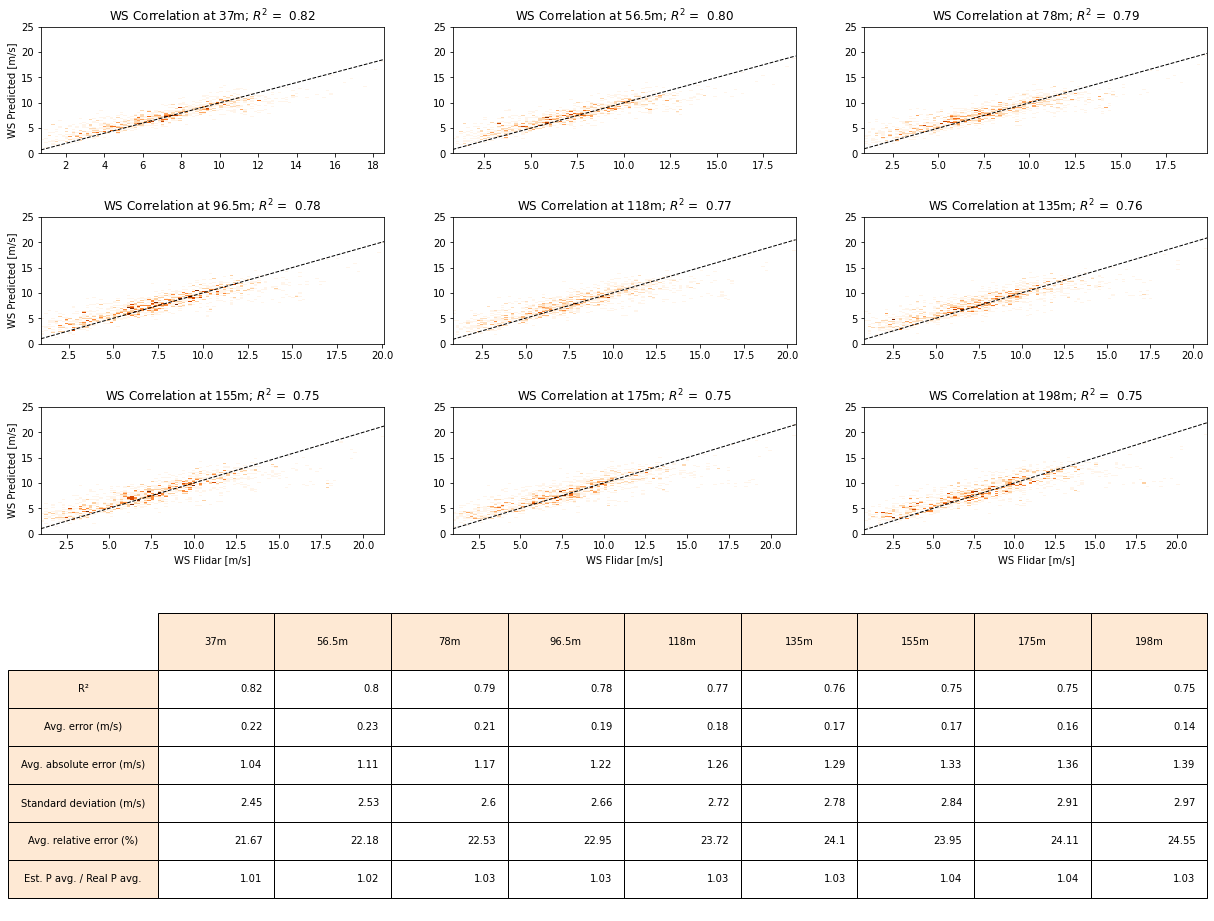

In [61]:
# Testing site B

df_X_train, df_X_test, df_X_test2, df_y_train, df_y_test, df_y_test2 = split(df_Xy_B, ratio)

gbm = CatBoostRegressor(iterations=1474, l2_leaf_reg=4, loss_function="MultiRMSE", learning_rate=0.20306144173821, colsample_bylevel=0.09657294200385033, max_depth=15, random_strength=4.533547480549605, boosting_type="Plain", bootstrap_type="MVS")
gbm.fit(df_X_train, df_y_train)
test_model(gbm, heights, ["global"], "No", df_X_test2, df_y_test2)

In [33]:
# Optimizing site C

df_X_train, df_X_test, df_X_test2, df_y_train, df_y_test, df_y_test2 = split(df_Xy_C, ratio)


def objective(trial):
    X_train = df_X_train
    X_val = df_X_test
    y_train = df_y_train
    y_val = df_y_test

    param = {
        "iterations" : trial.suggest_int("iterations", 1, 1500),
        "l2_leaf_reg" : trial.suggest_int("l2_leaf_reg", 2, 10),
        "loss_function" : trial.suggest_categorical("loss_function", ["MultiRMSE"]),
        "learning_rate" : trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "max_depth" : trial.suggest_int("max_depth", 1, 15),
        "random_strength" : trial.suggest_loguniform("random_strength", 0.0001, 10.0),
        "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }
    

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_uniform("subsample", 0.1, 1)

    gbm = catboost.CatBoostRegressor(**param, )

    gbm.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 0, early_stopping_rounds = 15)

    predictions = gbm.predict(X_val)
    RMSE = mean_squared_error(y_val, predictions)
    
    return RMSE

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 400, show_progress_bar = True)


print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-19 18:56:39,057] A new study created in memory with name: no-name-8719143b-9d61-4e7b-8e86-b27b67c02118
  0%|          | 1/400 [00:00<06:03,  1.10it/s]

[I 2022-08-19 18:56:39,971] Trial 0 finished with value: 19.119581905738062 and parameters: {'iterations': 196, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.012516471921124464, 'colsample_bylevel': 0.040545362114188806, 'max_depth': 11, 'random_strength': 0.3421036005403237, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 19.119581905738062.


  0%|          | 2/400 [00:02<09:58,  1.50s/it]

[I 2022-08-19 18:56:41,891] Trial 1 finished with value: 20.46055114268464 and parameters: {'iterations': 1052, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0025010843443614415, 'colsample_bylevel': 0.03159053686266764, 'max_depth': 2, 'random_strength': 0.0019235927941814173, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.589655042192858}. Best is trial 0 with value: 19.119581905738062.


  1%|          | 3/400 [00:06<15:52,  2.40s/it]

[I 2022-08-19 18:56:45,352] Trial 2 finished with value: 16.09549198615936 and parameters: {'iterations': 830, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.004039707422375831, 'colsample_bylevel': 0.06175203749955869, 'max_depth': 2, 'random_strength': 0.0013792815551550372, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9505997075889809}. Best is trial 2 with value: 16.09549198615936.


  1%|          | 4/400 [00:07<11:32,  1.75s/it]

[I 2022-08-19 18:56:46,104] Trial 3 finished with value: 23.224229231168774 and parameters: {'iterations': 775, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.003795518152103804, 'colsample_bylevel': 0.017246864841297366, 'max_depth': 15, 'random_strength': 1.2581418987667012, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.520985524424455}. Best is trial 2 with value: 16.09549198615936.


  1%|▏         | 5/400 [00:08<11:34,  1.76s/it]

[I 2022-08-19 18:56:47,878] Trial 4 finished with value: 19.181548439384482 and parameters: {'iterations': 852, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.002863186102930703, 'colsample_bylevel': 0.0470698514455795, 'max_depth': 7, 'random_strength': 3.4038583512245997, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 16.09549198615936.


  2%|▏         | 6/400 [00:13<17:43,  2.70s/it]

[I 2022-08-19 18:56:52,405] Trial 5 finished with value: 2.5192979894073786 and parameters: {'iterations': 1158, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12034663295421605, 'colsample_bylevel': 0.03471810854073966, 'max_depth': 5, 'random_strength': 0.7481241402374513, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9021493320843081}. Best is trial 5 with value: 2.5192979894073786.


  2%|▏         | 7/400 [00:15<17:25,  2.66s/it]

[I 2022-08-19 18:56:54,989] Trial 6 finished with value: 6.137464373257406 and parameters: {'iterations': 589, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.02654229477443576, 'colsample_bylevel': 0.05294240587303746, 'max_depth': 12, 'random_strength': 3.2175677118278174, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8095899568051768}. Best is trial 5 with value: 2.5192979894073786.


  2%|▏         | 8/400 [00:16<13:19,  2.04s/it]

[I 2022-08-19 18:56:55,697] Trial 7 finished with value: 16.756566403353666 and parameters: {'iterations': 320, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.010092468402186713, 'colsample_bylevel': 0.0986620813540802, 'max_depth': 1, 'random_strength': 0.000722313061205289, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 5 with value: 2.5192979894073786.


  2%|▏         | 9/400 [00:21<19:28,  2.99s/it]

[I 2022-08-19 18:57:00,771] Trial 8 finished with value: 14.860385203082002 and parameters: {'iterations': 942, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0025774981164568295, 'colsample_bylevel': 0.08398147270061014, 'max_depth': 3, 'random_strength': 0.00019861792430128284, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.20355809556869}. Best is trial 5 with value: 2.5192979894073786.


  2%|▎         | 10/400 [00:23<16:34,  2.55s/it]

[I 2022-08-19 18:57:02,342] Trial 9 finished with value: 7.343331005306207 and parameters: {'iterations': 71, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08765015381790736, 'colsample_bylevel': 0.08998866188720432, 'max_depth': 11, 'random_strength': 2.3950373811321457, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 5 with value: 2.5192979894073786.


  3%|▎         | 12/400 [00:24<09:38,  1.49s/it]

[I 2022-08-19 18:57:03,411] Trial 10 finished with value: 5.00922872493361 and parameters: {'iterations': 1491, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23048232585604833, 'colsample_bylevel': 0.0177107283641954, 'max_depth': 6, 'random_strength': 0.0832106771259298, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.17398003128940803}. Best is trial 5 with value: 2.5192979894073786.
[I 2022-08-19 18:57:03,519] Trial 11 finished with value: 24.413326587755964 and parameters: {'iterations': 1490, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23761481867556017, 'colsample_bylevel': 0.011803381290771766, 'max_depth': 6, 'random_strength': 0.05010589603153798, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.12893978815659674}. Best is trial 5 with value: 2.5192979894073786.


  3%|▎         | 13/400 [00:25<08:34,  1.33s/it]

[I 2022-08-19 18:57:04,478] Trial 12 finished with value: 4.98261769164967 and parameters: {'iterations': 1497, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23008234248135764, 'colsample_bylevel': 0.023591212106394123, 'max_depth': 5, 'random_strength': 0.10010224876902828, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.28579877005744125}. Best is trial 5 with value: 2.5192979894073786.


  4%|▎         | 14/400 [00:28<11:54,  1.85s/it]

[I 2022-08-19 18:57:07,529] Trial 13 finished with value: 3.9855343867867723 and parameters: {'iterations': 1213, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07385858730467632, 'colsample_bylevel': 0.03159468642283887, 'max_depth': 4, 'random_strength': 0.016259482305529514, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4855851978444382}. Best is trial 5 with value: 2.5192979894073786.


  4%|▍         | 15/400 [00:33<18:07,  2.83s/it]

[I 2022-08-19 18:57:12,613] Trial 14 finished with value: 2.172063816319977 and parameters: {'iterations': 1199, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06842726315368224, 'colsample_bylevel': 0.06866366776651311, 'max_depth': 4, 'random_strength': 0.011830797645726527, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6229756970018886}. Best is trial 14 with value: 2.172063816319977.


  4%|▍         | 16/400 [00:39<23:49,  3.72s/it]

[I 2022-08-19 18:57:18,418] Trial 15 finished with value: 2.0444833222793815 and parameters: {'iterations': 1191, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06103118115393228, 'colsample_bylevel': 0.07099792367569546, 'max_depth': 8, 'random_strength': 0.007809347872672018, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7065621950812448}. Best is trial 15 with value: 2.0444833222793815.


  4%|▍         | 17/400 [00:45<28:52,  4.52s/it]

[I 2022-08-19 18:57:24,804] Trial 16 finished with value: 2.5066353567756385 and parameters: {'iterations': 1268, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.034498545326924, 'colsample_bylevel': 0.0667266323164709, 'max_depth': 8, 'random_strength': 0.00783015269797479, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6331839349367918}. Best is trial 15 with value: 2.0444833222793815.


  4%|▍         | 18/400 [00:48<26:05,  4.10s/it]

[I 2022-08-19 18:57:27,914] Trial 17 finished with value: 3.085280781622328 and parameters: {'iterations': 533, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.050173617431670134, 'colsample_bylevel': 0.07359910906223158, 'max_depth': 9, 'random_strength': 0.005377155802122192, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.619880778459354}. Best is trial 15 with value: 2.0444833222793815.


  5%|▍         | 19/400 [00:51<23:43,  3.74s/it]

[I 2022-08-19 18:57:30,806] Trial 18 finished with value: 2.841830640550887 and parameters: {'iterations': 1324, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0197047224086256, 'colsample_bylevel': 0.07775504620368487, 'max_depth': 10, 'random_strength': 0.00015573482468420443, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7260544982571581}. Best is trial 15 with value: 2.0444833222793815.


  5%|▌         | 20/400 [00:59<31:47,  5.02s/it]

[I 2022-08-19 18:57:38,817] Trial 19 finished with value: 10.894856809144967 and parameters: {'iterations': 1018, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.007671938717863189, 'colsample_bylevel': 0.0635562383859515, 'max_depth': 13, 'random_strength': 0.018430385790930256, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.705158856813453}. Best is trial 15 with value: 2.0444833222793815.


  5%|▌         | 21/400 [01:02<27:31,  4.36s/it]

[I 2022-08-19 18:57:41,629] Trial 20 finished with value: 2.1236087408028457 and parameters: {'iterations': 552, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12649182722697008, 'colsample_bylevel': 0.07334934136764729, 'max_depth': 8, 'random_strength': 0.21385725106334705, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4487401111238942}. Best is trial 15 with value: 2.0444833222793815.


  6%|▌         | 22/400 [01:05<25:04,  3.98s/it]

[I 2022-08-19 18:57:44,727] Trial 21 finished with value: 1.9465879132648425 and parameters: {'iterations': 585, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14284691219398019, 'colsample_bylevel': 0.07411665770716497, 'max_depth': 8, 'random_strength': 0.2296220644159612, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4559096068835012}. Best is trial 21 with value: 1.9465879132648425.


  6%|▌         | 23/400 [01:09<24:14,  3.86s/it]

[I 2022-08-19 18:57:48,302] Trial 22 finished with value: 1.8731610643704089 and parameters: {'iterations': 580, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1348862771547699, 'colsample_bylevel': 0.08147819160869497, 'max_depth': 8, 'random_strength': 0.3780303252922859, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.42278605554812415}. Best is trial 22 with value: 1.8731610643704089.


  6%|▌         | 24/400 [01:12<22:56,  3.66s/it]

[I 2022-08-19 18:57:51,501] Trial 23 finished with value: 2.0392019303526387 and parameters: {'iterations': 409, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1289796646483964, 'colsample_bylevel': 0.0849359423260774, 'max_depth': 9, 'random_strength': 0.3402692139955525, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3667053544415575}. Best is trial 22 with value: 1.8731610643704089.


  6%|▋         | 25/400 [01:16<23:31,  3.76s/it]

[I 2022-08-19 18:57:55,505] Trial 24 finished with value: 21.269435107001968 and parameters: {'iterations': 392, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0011526390803837758, 'colsample_bylevel': 0.08726792550573768, 'max_depth': 9, 'random_strength': 0.36536199538151753, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.37803306845720314}. Best is trial 22 with value: 1.8731610643704089.


  6%|▋         | 26/400 [01:25<33:08,  5.32s/it]

[I 2022-08-19 18:58:04,447] Trial 25 finished with value: 1.5611638603561846 and parameters: {'iterations': 631, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13362191092276954, 'colsample_bylevel': 0.09851324004003488, 'max_depth': 10, 'random_strength': 9.830210261468231, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3385242999154897}. Best is trial 25 with value: 1.5611638603561846.


  7%|▋         | 27/400 [01:51<1:12:01, 11.59s/it]

[I 2022-08-19 18:58:30,654] Trial 26 finished with value: 1.7146002429273013 and parameters: {'iterations': 641, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15511237711747036, 'colsample_bylevel': 0.09023953407980409, 'max_depth': 14, 'random_strength': 1.1377578679255618, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2659493554970871}. Best is trial 25 with value: 1.5611638603561846.


  7%|▋         | 28/400 [01:59<1:05:09, 10.51s/it]

[I 2022-08-19 18:58:38,656] Trial 27 finished with value: 2.1092983240805125 and parameters: {'iterations': 663, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.03725621964152381, 'colsample_bylevel': 0.09922006719229257, 'max_depth': 15, 'random_strength': 7.182585545417657, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 25 with value: 1.5611638603561846.


  7%|▋         | 29/400 [02:12<1:10:20, 11.38s/it]

[I 2022-08-19 18:58:52,055] Trial 28 finished with value: 2.001807143926759 and parameters: {'iterations': 702, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2729626350771922, 'colsample_bylevel': 0.0935349447178309, 'max_depth': 13, 'random_strength': 9.785946523792546, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.402020374336995}. Best is trial 25 with value: 1.5611638603561846.


  8%|▊         | 30/400 [02:15<53:01,  8.60s/it]  

[I 2022-08-19 18:58:54,172] Trial 29 finished with value: 3.0639155658893835 and parameters: {'iterations': 147, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17129771314633174, 'colsample_bylevel': 0.08013261872987569, 'max_depth': 14, 'random_strength': 0.8073266382593095, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2502410507014963}. Best is trial 25 with value: 1.5611638603561846.


  8%|▊         | 31/400 [02:19<44:45,  7.28s/it]

[I 2022-08-19 18:58:58,367] Trial 30 finished with value: 2.287613058939993 and parameters: {'iterations': 236, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10504634399424438, 'colsample_bylevel': 0.09457994483683092, 'max_depth': 11, 'random_strength': 1.3182990793836251, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 25 with value: 1.5611638603561846.


  8%|▊         | 32/400 [02:21<35:51,  5.85s/it]

[I 2022-08-19 18:59:00,874] Trial 31 finished with value: 2.049354627086661 and parameters: {'iterations': 455, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15621341543882356, 'colsample_bylevel': 0.08056593812060103, 'max_depth': 10, 'random_strength': 0.17233639143472368, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3356874501428403}. Best is trial 25 with value: 1.5611638603561846.


  8%|▊         | 33/400 [02:25<31:48,  5.20s/it]

[I 2022-08-19 18:59:04,570] Trial 32 finished with value: 1.5804371341681358 and parameters: {'iterations': 636, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17931280069556746, 'colsample_bylevel': 0.09353800549361907, 'max_depth': 7, 'random_strength': 0.47110342056768834, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.501904695775525}. Best is trial 25 with value: 1.5611638603561846.


  8%|▊         | 34/400 [02:29<28:59,  4.75s/it]

[I 2022-08-19 18:59:08,275] Trial 33 finished with value: 2.3118144301659247 and parameters: {'iterations': 671, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.04910459276938929, 'colsample_bylevel': 0.09184605968961436, 'max_depth': 7, 'random_strength': 0.7007307964634417, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.20610728464038908}. Best is trial 25 with value: 1.5611638603561846.


  9%|▉         | 35/400 [02:30<23:22,  3.84s/it]

[I 2022-08-19 18:59:09,995] Trial 34 finished with value: 1.3186763832446236 and parameters: {'iterations': 771, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20032298885732153, 'colsample_bylevel': 0.09944029093904738, 'max_depth': 7, 'random_strength': 5.164821540766108, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.532952654029882}. Best is trial 34 with value: 1.3186763832446236.


  9%|▉         | 36/400 [02:34<22:52,  3.77s/it]

[I 2022-08-19 18:59:13,596] Trial 35 finished with value: 1.1337062924954422 and parameters: {'iterations': 847, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1930603658765376, 'colsample_bylevel': 0.09685862914781522, 'max_depth': 12, 'random_strength': 5.867707615443794, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.35157910427924044}. Best is trial 35 with value: 1.1337062924954422.


  9%|▉         | 37/400 [02:38<22:32,  3.73s/it]

[I 2022-08-19 18:59:17,221] Trial 36 finished with value: 1.1332741002694733 and parameters: {'iterations': 818, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2971996640613442, 'colsample_bylevel': 0.0982586886561989, 'max_depth': 12, 'random_strength': 5.529980190933485, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.06593456387401}. Best is trial 36 with value: 1.1332741002694733.


 10%|▉         | 38/400 [02:41<22:40,  3.76s/it]

[I 2022-08-19 18:59:21,051] Trial 37 finished with value: 1.0194494585690872 and parameters: {'iterations': 820, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29397402680440204, 'colsample_bylevel': 0.09999813500331241, 'max_depth': 12, 'random_strength': 5.568240265245864, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.05328567761669767}. Best is trial 37 with value: 1.0194494585690872.


 10%|▉         | 39/400 [02:43<18:38,  3.10s/it]

[I 2022-08-19 18:59:22,616] Trial 38 finished with value: 2.0365925778452394 and parameters: {'iterations': 831, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2919503824529716, 'colsample_bylevel': 0.046729766524639754, 'max_depth': 12, 'random_strength': 4.292841417348458, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.12861209661720008}. Best is trial 37 with value: 1.0194494585690872.


 10%|█         | 40/400 [02:47<20:59,  3.50s/it]

[I 2022-08-19 18:59:27,046] Trial 39 finished with value: 1.106030527411962 and parameters: {'iterations': 770, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20183534515764878, 'colsample_bylevel': 0.0998533744863049, 'max_depth': 13, 'random_strength': 2.284555707488784, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.019838597756909035}. Best is trial 37 with value: 1.0194494585690872.


 10%|█         | 41/400 [02:51<20:23,  3.41s/it]

[I 2022-08-19 18:59:30,245] Trial 40 finished with value: 1.528446282699126 and parameters: {'iterations': 968, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08853707130696706, 'colsample_bylevel': 0.08772019018370264, 'max_depth': 12, 'random_strength': 2.0949189916338073, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.037178275981936765}. Best is trial 37 with value: 1.0194494585690872.


 10%|█         | 42/400 [02:55<22:38,  3.79s/it]

[I 2022-08-19 18:59:34,937] Trial 41 finished with value: 1.2023799797671204 and parameters: {'iterations': 768, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2008357149830146, 'colsample_bylevel': 0.09956685212618976, 'max_depth': 13, 'random_strength': 4.875001106956334, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.710221617614863}. Best is trial 37 with value: 1.0194494585690872.


 11%|█         | 43/400 [03:00<23:47,  4.00s/it]

[I 2022-08-19 18:59:39,413] Trial 42 finished with value: 1.0634663689898345 and parameters: {'iterations': 935, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29631733674324534, 'colsample_bylevel': 0.09588066328988257, 'max_depth': 13, 'random_strength': 1.8085877094259963, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.4452729167609812}. Best is trial 37 with value: 1.0194494585690872.


 11%|█         | 44/400 [03:05<25:37,  4.32s/it]

[I 2022-08-19 18:59:44,477] Trial 43 finished with value: 1.1073636777347808 and parameters: {'iterations': 866, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.28190044177526824, 'colsample_bylevel': 0.09457459060690912, 'max_depth': 14, 'random_strength': 2.1322716668421124, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.0327206046293287}. Best is trial 37 with value: 1.0194494585690872.


 11%|█▏        | 45/400 [03:07<21:10,  3.58s/it]

[I 2022-08-19 18:59:46,336] Trial 44 finished with value: 1.8259590134189838 and parameters: {'iterations': 891, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.28890755268622775, 'colsample_bylevel': 0.057962666246911744, 'max_depth': 14, 'random_strength': 1.9874417239316826, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.790437233528949}. Best is trial 37 with value: 1.0194494585690872.


 12%|█▏        | 46/400 [03:13<25:50,  4.38s/it]

[I 2022-08-19 18:59:52,584] Trial 45 finished with value: 1.1460163692145247 and parameters: {'iterations': 1066, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2977619637761847, 'colsample_bylevel': 0.08790233692148743, 'max_depth': 15, 'random_strength': 2.8098274641138614, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.656881731249424}. Best is trial 37 with value: 1.0194494585690872.


 12%|█▏        | 47/400 [03:18<27:34,  4.69s/it]

[I 2022-08-19 18:59:57,988] Trial 46 finished with value: 1.2918624007121815 and parameters: {'iterations': 1074, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10089070330919253, 'colsample_bylevel': 0.0954989398357543, 'max_depth': 13, 'random_strength': 1.3420184529732795, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.9724953777841949}. Best is trial 37 with value: 1.0194494585690872.


 12%|█▏        | 48/400 [03:22<26:20,  4.49s/it]

[I 2022-08-19 19:00:02,015] Trial 47 finished with value: 1.355165092042439 and parameters: {'iterations': 919, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21127938047224273, 'colsample_bylevel': 0.0913038548098539, 'max_depth': 14, 'random_strength': 2.3542850641408797, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.114069841892323}. Best is trial 37 with value: 1.0194494585690872.


 12%|█▏        | 49/400 [03:25<23:18,  3.98s/it]

[I 2022-08-19 19:00:04,821] Trial 48 finished with value: 5.055341464984248 and parameters: {'iterations': 990, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.010678640591177492, 'colsample_bylevel': 0.08503089637827747, 'max_depth': 11, 'random_strength': 3.7184734312289867, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.8506063671753497}. Best is trial 37 with value: 1.0194494585690872.


 12%|█▎        | 50/400 [03:27<18:36,  3.19s/it]

[I 2022-08-19 19:00:06,157] Trial 49 finished with value: 2.6181807092170857 and parameters: {'iterations': 717, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23551485721642787, 'colsample_bylevel': 0.04049471043146107, 'max_depth': 12, 'random_strength': 0.8775120102479987, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8586756199026446}. Best is trial 37 with value: 1.0194494585690872.


 13%|█▎        | 51/400 [03:30<19:17,  3.32s/it]

[I 2022-08-19 19:00:09,770] Trial 50 finished with value: 1.0624750693003202 and parameters: {'iterations': 887, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23958687782668756, 'colsample_bylevel': 0.09507022859090837, 'max_depth': 13, 'random_strength': 1.7938074653029359, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.12376368752010072}. Best is trial 37 with value: 1.0194494585690872.


 13%|█▎        | 52/400 [03:34<20:07,  3.47s/it]

[I 2022-08-19 19:00:13,600] Trial 51 finished with value: 1.093559402734088 and parameters: {'iterations': 885, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24126933961994518, 'colsample_bylevel': 0.09471747411435948, 'max_depth': 13, 'random_strength': 2.979055122666259, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.41658780378041627}. Best is trial 37 with value: 1.0194494585690872.


 13%|█▎        | 53/400 [03:42<27:19,  4.73s/it]

[I 2022-08-19 19:00:21,255] Trial 52 finished with value: 0.9769292944846372 and parameters: {'iterations': 1115, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21435660335930035, 'colsample_bylevel': 0.09399383434012991, 'max_depth': 15, 'random_strength': 1.7428733539303398, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.04721967520951667}. Best is trial 52 with value: 0.9769292944846372.


 14%|█▎        | 54/400 [03:47<28:14,  4.90s/it]

[I 2022-08-19 19:00:26,554] Trial 53 finished with value: 1.0756553841526972 and parameters: {'iterations': 1130, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22463789771015327, 'colsample_bylevel': 0.0906919656764571, 'max_depth': 15, 'random_strength': 0.6159695909391917, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.15504091780982843}. Best is trial 52 with value: 0.9769292944846372.


 14%|█▍        | 55/400 [03:52<28:40,  4.99s/it]

[I 2022-08-19 19:00:31,752] Trial 54 finished with value: 5.771477603094422 and parameters: {'iterations': 1127, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.006860093831881695, 'colsample_bylevel': 0.08990638604398167, 'max_depth': 15, 'random_strength': 0.6181135696994379, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.05970490020418118}. Best is trial 52 with value: 0.9769292944846372.


 14%|█▍        | 56/400 [04:00<34:05,  5.95s/it]

[I 2022-08-19 19:00:39,932] Trial 55 finished with value: 1.312541387162536 and parameters: {'iterations': 1382, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10904904740043829, 'colsample_bylevel': 0.08424778736055409, 'max_depth': 15, 'random_strength': 1.3955757267006288, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8411047948007772}. Best is trial 52 with value: 0.9769292944846372.


 14%|█▍        | 57/400 [04:04<29:24,  5.15s/it]

[I 2022-08-19 19:00:43,209] Trial 56 finished with value: 1.6756485872278897 and parameters: {'iterations': 1101, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08679415109296047, 'colsample_bylevel': 0.07623155126244505, 'max_depth': 14, 'random_strength': 3.1984130493155427, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.07977975525116338}. Best is trial 52 with value: 0.9769292944846372.


 14%|█▍        | 58/400 [04:08<27:36,  4.84s/it]

[I 2022-08-19 19:00:47,345] Trial 57 finished with value: 1.293690572041941 and parameters: {'iterations': 1034, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23741639794961678, 'colsample_bylevel': 0.0877337815156078, 'max_depth': 13, 'random_strength': 0.12635593211959928, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.4393940707492776}. Best is trial 52 with value: 0.9769292944846372.


 15%|█▍        | 59/400 [04:16<34:06,  6.00s/it]

[I 2022-08-19 19:00:56,053] Trial 58 finished with value: 1.063418056634627 and parameters: {'iterations': 1261, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16876844182395917, 'colsample_bylevel': 0.09581393232774564, 'max_depth': 15, 'random_strength': 0.0009858500447113801, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8684318335848846}. Best is trial 52 with value: 0.9769292944846372.


 15%|█▌        | 60/400 [04:23<34:14,  6.04s/it]

[I 2022-08-19 19:01:02,187] Trial 59 finished with value: 2.440113166784748 and parameters: {'iterations': 1321, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.017727781240853592, 'colsample_bylevel': 0.09156818817125362, 'max_depth': 15, 'random_strength': 0.0002878594033830671, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.2567152310820795}. Best is trial 52 with value: 0.9769292944846372.


 15%|█▌        | 61/400 [04:30<36:16,  6.42s/it]

[I 2022-08-19 19:01:09,489] Trial 60 finished with value: 1.0534358838636817 and parameters: {'iterations': 1246, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1605122059451994, 'colsample_bylevel': 0.09615045023837929, 'max_depth': 14, 'random_strength': 0.002941983464888976, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 52 with value: 0.9769292944846372.


 16%|█▌        | 62/400 [04:36<35:37,  6.33s/it]

[I 2022-08-19 19:01:15,593] Trial 61 finished with value: 1.1574686199201065 and parameters: {'iterations': 1153, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15825996971941536, 'colsample_bylevel': 0.0961828226970038, 'max_depth': 14, 'random_strength': 0.0027273472629633943, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 52 with value: 0.9769292944846372.


 16%|█▌        | 63/400 [04:43<36:18,  6.46s/it]

[I 2022-08-19 19:01:22,384] Trial 62 finished with value: 1.219037283979578 and parameters: {'iterations': 1251, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1710101027544212, 'colsample_bylevel': 0.08336818725365666, 'max_depth': 15, 'random_strength': 0.0013807663336397053, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 52 with value: 0.9769292944846372.


 16%|█▌        | 64/400 [04:50<36:38,  6.54s/it]

[I 2022-08-19 19:01:29,111] Trial 63 finished with value: 1.1897329033963775 and parameters: {'iterations': 1411, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11704528915085821, 'colsample_bylevel': 0.08971866808380763, 'max_depth': 14, 'random_strength': 0.0005687717770225294, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 52 with value: 0.9769292944846372.


 16%|█▋        | 65/400 [04:59<41:03,  7.35s/it]

[I 2022-08-19 19:01:38,359] Trial 64 finished with value: 0.9422803663981916 and parameters: {'iterations': 1306, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23947490229915827, 'colsample_bylevel': 0.0961666977796906, 'max_depth': 15, 'random_strength': 0.04585449748982549, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 64 with value: 0.9422803663981916.


 16%|█▋        | 66/400 [05:08<43:29,  7.81s/it]

[I 2022-08-19 19:01:47,244] Trial 65 finished with value: 1.377347541074987 and parameters: {'iterations': 1263, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06794107968915382, 'colsample_bylevel': 0.09614387424331367, 'max_depth': 15, 'random_strength': 0.0030609107560492584, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 64 with value: 0.9422803663981916.


 17%|█▋        | 67/400 [05:14<40:46,  7.35s/it]

[I 2022-08-19 19:01:53,501] Trial 66 finished with value: 1.1496007780906465 and parameters: {'iterations': 1202, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14184997292200432, 'colsample_bylevel': 0.09273117642767693, 'max_depth': 14, 'random_strength': 0.053149390877092396, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 64 with value: 0.9422803663981916.


 17%|█▋        | 68/400 [05:19<37:04,  6.70s/it]

[I 2022-08-19 19:01:58,688] Trial 67 finished with value: 1.1190223744460113 and parameters: {'iterations': 1330, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17469271975929704, 'colsample_bylevel': 0.08636383708006598, 'max_depth': 13, 'random_strength': 0.00045869365295366995, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 64 with value: 0.9422803663981916.


 17%|█▋        | 69/400 [05:24<34:41,  6.29s/it]

[I 2022-08-19 19:02:04,023] Trial 68 finished with value: 0.9062467102239324 and parameters: {'iterations': 1439, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24927428589799216, 'colsample_bylevel': 0.09609588189255212, 'max_depth': 11, 'random_strength': 0.0009266495782905976, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 18%|█▊        | 70/400 [05:29<30:58,  5.63s/it]

[I 2022-08-19 19:02:08,122] Trial 69 finished with value: 15.46758492326437 and parameters: {'iterations': 1427, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0013000088286267849, 'colsample_bylevel': 0.0823060241434038, 'max_depth': 11, 'random_strength': 0.0009236844887178435, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 18%|█▊        | 71/400 [05:33<29:31,  5.38s/it]

[I 2022-08-19 19:02:12,925] Trial 70 finished with value: 1.5900805434936829 and parameters: {'iterations': 1464, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08164809053870277, 'colsample_bylevel': 0.0781344547336571, 'max_depth': 14, 'random_strength': 0.0048526026338945975, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 18%|█▊        | 72/400 [05:36<24:56,  4.56s/it]

[I 2022-08-19 19:02:15,568] Trial 71 finished with value: 2.5805707797811253 and parameters: {'iterations': 1350, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24898340500126903, 'colsample_bylevel': 0.09677739440069766, 'max_depth': 1, 'random_strength': 0.0014577354193525765, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 18%|█▊        | 73/400 [05:41<25:08,  4.61s/it]

[I 2022-08-19 19:02:20,306] Trial 72 finished with value: 0.9762121906462694 and parameters: {'iterations': 1286, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1943913009904354, 'colsample_bylevel': 0.09663876926823586, 'max_depth': 11, 'random_strength': 0.025217101384292992, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 18%|█▊        | 74/400 [05:42<19:14,  3.54s/it]

[I 2022-08-19 19:02:21,339] Trial 73 finished with value: 6.493022218748916 and parameters: {'iterations': 1280, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14511945115419125, 'colsample_bylevel': 0.02562026829133578, 'max_depth': 10, 'random_strength': 0.02000359588855901, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 19%|█▉        | 75/400 [05:46<20:34,  3.80s/it]

[I 2022-08-19 19:02:25,744] Trial 74 finished with value: 2.0908065818622026 and parameters: {'iterations': 1216, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.02440911100940899, 'colsample_bylevel': 0.09302720470433237, 'max_depth': 11, 'random_strength': 0.0008953014140058619, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 19%|█▉        | 76/400 [05:52<23:13,  4.30s/it]

[I 2022-08-19 19:02:31,218] Trial 75 finished with value: 0.9479877586978714 and parameters: {'iterations': 1373, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1865709318374932, 'colsample_bylevel': 0.09981066849833485, 'max_depth': 11, 'random_strength': 0.00011093302829030572, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 19%|█▉        | 77/400 [05:56<23:12,  4.31s/it]

[I 2022-08-19 19:02:35,555] Trial 76 finished with value: 1.0272916727184276 and parameters: {'iterations': 1374, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2081970014485205, 'colsample_bylevel': 0.09832963894757094, 'max_depth': 11, 'random_strength': 0.00018406443350104076, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 20%|█▉        | 78/400 [06:01<24:00,  4.47s/it]

[I 2022-08-19 19:02:40,406] Trial 77 finished with value: 0.9290957947611899 and parameters: {'iterations': 1446, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.189843423435648, 'colsample_bylevel': 0.09985485584823774, 'max_depth': 10, 'random_strength': 0.0001314710075543614, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 20%|█▉        | 79/400 [06:05<23:18,  4.36s/it]

[I 2022-08-19 19:02:44,492] Trial 78 finished with value: 0.9857139579327653 and parameters: {'iterations': 1422, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18892677776422898, 'colsample_bylevel': 0.09798690627876509, 'max_depth': 9, 'random_strength': 0.00014291451837467682, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 20%|██        | 80/400 [06:09<23:09,  4.34s/it]

[I 2022-08-19 19:02:48,797] Trial 79 finished with value: 1.0608235548509029 and parameters: {'iterations': 1459, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12879741958380977, 'colsample_bylevel': 0.09986484562925065, 'max_depth': 9, 'random_strength': 0.00010151878811826267, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 20%|██        | 81/400 [06:13<21:56,  4.13s/it]

[I 2022-08-19 19:02:52,423] Trial 80 finished with value: 1.100511229933496 and parameters: {'iterations': 1301, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18847586389014423, 'colsample_bylevel': 0.08838279237074367, 'max_depth': 10, 'random_strength': 0.00028827298451451956, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 20%|██        | 82/400 [06:17<21:40,  4.09s/it]

[I 2022-08-19 19:02:56,429] Trial 81 finished with value: 1.010885880279461 and parameters: {'iterations': 1375, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2024168551791584, 'colsample_bylevel': 0.09802794260630666, 'max_depth': 9, 'random_strength': 0.00011885149378516009, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 21%|██        | 83/400 [06:20<20:15,  3.84s/it]

[I 2022-08-19 19:02:59,670] Trial 82 finished with value: 1.0448982073360913 and parameters: {'iterations': 1425, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2556153464113053, 'colsample_bylevel': 0.09290114870076696, 'max_depth': 9, 'random_strength': 0.0001235904987534774, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 21%|██        | 84/400 [06:25<21:21,  4.06s/it]

[I 2022-08-19 19:03:04,239] Trial 83 finished with value: 1.099299404616814 and parameters: {'iterations': 1498, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11879621560954447, 'colsample_bylevel': 0.09765574779181732, 'max_depth': 10, 'random_strength': 0.0002773999737064909, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 21%|██▏       | 85/400 [06:29<21:01,  4.00s/it]

[I 2022-08-19 19:03:08,120] Trial 84 finished with value: 1.2412020742841474 and parameters: {'iterations': 1378, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0997957130524007, 'colsample_bylevel': 0.09772472944907988, 'max_depth': 9, 'random_strength': 0.0001542519276703126, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 22%|██▏       | 86/400 [06:29<15:18,  2.92s/it]

[I 2022-08-19 19:03:08,526] Trial 85 finished with value: 15.98708123270604 and parameters: {'iterations': 1461, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18676582059936275, 'colsample_bylevel': 0.010228187917646965, 'max_depth': 8, 'random_strength': 0.00042143041231219825, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 22%|██▏       | 87/400 [06:33<17:34,  3.37s/it]

[I 2022-08-19 19:03:12,937] Trial 86 finished with value: 0.9297113066768866 and parameters: {'iterations': 1402, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2120303223799918, 'colsample_bylevel': 0.09983082141494767, 'max_depth': 10, 'random_strength': 0.00012736003754365192, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 22%|██▏       | 88/400 [06:37<18:40,  3.59s/it]

[I 2022-08-19 19:03:17,043] Trial 87 finished with value: 1.1249556420518143 and parameters: {'iterations': 1407, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14227841084378795, 'colsample_bylevel': 0.0929533893754551, 'max_depth': 10, 'random_strength': 0.00019649538102845904, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 22%|██▏       | 89/400 [06:39<15:41,  3.03s/it]

[I 2022-08-19 19:03:18,755] Trial 88 finished with value: 1.394123252190798 and parameters: {'iterations': 1344, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21070456485028793, 'colsample_bylevel': 0.08953431746114002, 'max_depth': 9, 'random_strength': 0.00010074699729141303, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 22%|██▎       | 90/400 [06:42<15:22,  2.98s/it]

[I 2022-08-19 19:03:21,611] Trial 89 finished with value: 1.7374127642135737 and parameters: {'iterations': 1297, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.258774371564227, 'colsample_bylevel': 0.05075467915615016, 'max_depth': 11, 'random_strength': 0.0001402701639226014, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 23%|██▎       | 91/400 [06:46<16:36,  3.23s/it]

[I 2022-08-19 19:03:25,419] Trial 90 finished with value: 1.1461452581289668 and parameters: {'iterations': 1441, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19112320074933686, 'colsample_bylevel': 0.08632414112906506, 'max_depth': 10, 'random_strength': 0.0002394063257532207, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.9062467102239324.


 23%|██▎       | 92/400 [06:51<20:05,  3.91s/it]

[I 2022-08-19 19:03:30,943] Trial 91 finished with value: 0.9043959145129367 and parameters: {'iterations': 1387, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26489847984158027, 'colsample_bylevel': 0.09960411149779344, 'max_depth': 11, 'random_strength': 0.0003767012772292164, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 91 with value: 0.9043959145129367.


 23%|██▎       | 93/400 [06:57<22:35,  4.41s/it]

[I 2022-08-19 19:03:36,522] Trial 92 finished with value: 0.9293999525833131 and parameters: {'iterations': 1389, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2207673940684375, 'colsample_bylevel': 0.09991365620133098, 'max_depth': 11, 'random_strength': 0.00037759853150107615, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 91 with value: 0.9043959145129367.


 24%|██▎       | 94/400 [07:02<22:58,  4.51s/it]

[I 2022-08-19 19:03:41,241] Trial 93 finished with value: 0.9731115501452111 and parameters: {'iterations': 1397, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.254762627941782, 'colsample_bylevel': 0.09431094164186131, 'max_depth': 11, 'random_strength': 0.0003794990217572677, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 91 with value: 0.9043959145129367.


 24%|██▍       | 95/400 [07:07<23:54,  4.70s/it]

[I 2022-08-19 19:03:46,408] Trial 94 finished with value: 0.9371345826704695 and parameters: {'iterations': 1499, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25641943212113455, 'colsample_bylevel': 0.09397803000754507, 'max_depth': 11, 'random_strength': 0.00033666098266600544, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 91 with value: 0.9043959145129367.


 24%|██▍       | 96/400 [07:10<21:14,  4.19s/it]

[I 2022-08-19 19:03:49,405] Trial 95 finished with value: 1.1320522147659455 and parameters: {'iterations': 1481, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2659997092756006, 'colsample_bylevel': 0.09124442341982943, 'max_depth': 11, 'random_strength': 0.00038219201962511095, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 91 with value: 0.9043959145129367.


 24%|██▍       | 97/400 [07:16<24:35,  4.87s/it]

[I 2022-08-19 19:03:55,851] Trial 96 finished with value: 0.9086303996654094 and parameters: {'iterations': 1393, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2300040935423278, 'colsample_bylevel': 0.0996179300329432, 'max_depth': 12, 'random_strength': 0.0006304128003135423, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 91 with value: 0.9043959145129367.


 24%|██▍       | 98/400 [07:23<27:02,  5.37s/it]

[I 2022-08-19 19:04:02,395] Trial 97 finished with value: 0.878550800645924 and parameters: {'iterations': 1399, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2589870805983227, 'colsample_bylevel': 0.09961761238569833, 'max_depth': 12, 'random_strength': 0.0006177409597070214, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 97 with value: 0.878550800645924.


 25%|██▍       | 99/400 [07:29<28:38,  5.71s/it]

[I 2022-08-19 19:04:08,894] Trial 98 finished with value: 0.9390484437677963 and parameters: {'iterations': 1341, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22452259064340005, 'colsample_bylevel': 0.09999932701465404, 'max_depth': 12, 'random_strength': 0.0007558761748749119, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 97 with value: 0.878550800645924.


 25%|██▌       | 100/400 [07:36<30:33,  6.11s/it]

[I 2022-08-19 19:04:15,950] Trial 99 finished with value: 0.8906149293490715 and parameters: {'iterations': 1495, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2256002866288561, 'colsample_bylevel': 0.09966887923012245, 'max_depth': 12, 'random_strength': 0.0006760381096789548, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 97 with value: 0.878550800645924.


 25%|██▌       | 101/400 [07:43<31:51,  6.39s/it]

[I 2022-08-19 19:04:22,994] Trial 100 finished with value: 5.080825357348856 and parameters: {'iterations': 1490, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.004813408794888401, 'colsample_bylevel': 0.09983459165829929, 'max_depth': 12, 'random_strength': 0.0005561114194309162, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 97 with value: 0.878550800645924.


 26%|██▌       | 102/400 [07:50<31:25,  6.33s/it]

[I 2022-08-19 19:04:29,164] Trial 101 finished with value: 0.8982953316263919 and parameters: {'iterations': 1458, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22640906379760198, 'colsample_bylevel': 0.0945925613107387, 'max_depth': 12, 'random_strength': 0.0007490082037648618, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 97 with value: 0.878550800645924.


 26%|██▌       | 103/400 [07:52<25:17,  5.11s/it]

[I 2022-08-19 19:04:31,439] Trial 102 finished with value: 1.3530293263526703 and parameters: {'iterations': 1444, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21964514946470418, 'colsample_bylevel': 0.09420369635894, 'max_depth': 12, 'random_strength': 0.0006788702129725432, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 97 with value: 0.878550800645924.


 26%|██▌       | 104/400 [07:58<27:13,  5.52s/it]

[I 2022-08-19 19:04:37,909] Trial 103 finished with value: 0.8744012890080488 and parameters: {'iterations': 1349, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.299312248311364, 'colsample_bylevel': 0.09776855471723848, 'max_depth': 12, 'random_strength': 0.0020106237778521776, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 103 with value: 0.8744012890080488.


 26%|██▋       | 105/400 [08:05<28:49,  5.86s/it]

[I 2022-08-19 19:04:44,580] Trial 104 finished with value: 0.8736586144390489 and parameters: {'iterations': 1467, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2661495675222352, 'colsample_bylevel': 0.0973782797044665, 'max_depth': 12, 'random_strength': 0.0011481501018602211, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 104 with value: 0.8736586144390489.


 26%|██▋       | 106/400 [08:12<30:05,  6.14s/it]

[I 2022-08-19 19:04:51,370] Trial 105 finished with value: 0.8828694986294601 and parameters: {'iterations': 1462, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2798524813431945, 'colsample_bylevel': 0.09751540151920723, 'max_depth': 12, 'random_strength': 0.0018687870368204885, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 104 with value: 0.8736586144390489.


 27%|██▋       | 107/400 [08:15<26:18,  5.39s/it]

[I 2022-08-19 19:04:55,003] Trial 106 finished with value: 1.0882698610614117 and parameters: {'iterations': 1453, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2974749461999918, 'colsample_bylevel': 0.09164895086777694, 'max_depth': 12, 'random_strength': 0.0018018568289045554, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 104 with value: 0.8736586144390489.


 27%|██▋       | 108/400 [08:22<28:28,  5.85s/it]

[I 2022-08-19 19:05:01,937] Trial 107 finished with value: 1.015476809586626 and parameters: {'iterations': 1345, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15410405039485311, 'colsample_bylevel': 0.09810373295775238, 'max_depth': 12, 'random_strength': 0.0011563721466595475, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 104 with value: 0.8736586144390489.


 27%|██▋       | 109/400 [08:25<23:23,  4.82s/it]

[I 2022-08-19 19:05:04,363] Trial 108 finished with value: 1.5448546509281325 and parameters: {'iterations': 1475, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26959760999556587, 'colsample_bylevel': 0.06168705433916657, 'max_depth': 12, 'random_strength': 0.0005754445518210155, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 104 with value: 0.8736586144390489.


 28%|██▊       | 110/400 [08:31<25:43,  5.32s/it]

[I 2022-08-19 19:05:10,851] Trial 109 finished with value: 0.9750423500890317 and parameters: {'iterations': 1436, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16409445609494933, 'colsample_bylevel': 0.09724727103960615, 'max_depth': 12, 'random_strength': 0.0018857759281568202, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 104 with value: 0.8736586144390489.


 28%|██▊       | 111/400 [08:36<24:18,  5.05s/it]

[I 2022-08-19 19:05:15,252] Trial 110 finished with value: 1.0760241370934616 and parameters: {'iterations': 1355, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2997165863152665, 'colsample_bylevel': 0.08915644022918844, 'max_depth': 13, 'random_strength': 0.002393915774493969, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 104 with value: 0.8736586144390489.


 28%|██▊       | 112/400 [08:41<24:58,  5.20s/it]

[I 2022-08-19 19:05:20,821] Trial 111 finished with value: 0.9281066221807954 and parameters: {'iterations': 1411, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2249636897179214, 'colsample_bylevel': 0.09522457760458557, 'max_depth': 12, 'random_strength': 0.0011292388144072533, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 104 with value: 0.8736586144390489.


 28%|██▊       | 113/400 [08:47<25:42,  5.37s/it]

[I 2022-08-19 19:05:26,594] Trial 112 finished with value: 0.9414349146184748 and parameters: {'iterations': 1403, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22915321746533063, 'colsample_bylevel': 0.09535231690108074, 'max_depth': 12, 'random_strength': 0.0010490084318455013, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 104 with value: 0.8736586144390489.


 28%|██▊       | 114/400 [08:56<30:18,  6.36s/it]

[I 2022-08-19 19:05:35,251] Trial 113 finished with value: 0.8608663715511691 and parameters: {'iterations': 1460, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27581947027506315, 'colsample_bylevel': 0.09716053820586511, 'max_depth': 13, 'random_strength': 0.0006984429326985379, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 29%|██▉       | 115/400 [09:02<30:15,  6.37s/it]

[I 2022-08-19 19:05:41,646] Trial 114 finished with value: 0.9355925568654376 and parameters: {'iterations': 1463, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26805960174759935, 'colsample_bylevel': 0.09172507811552028, 'max_depth': 13, 'random_strength': 0.0036790163006702285, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 29%|██▉       | 116/400 [09:08<29:14,  6.18s/it]

[I 2022-08-19 19:05:47,375] Trial 115 finished with value: 0.8992610443742812 and parameters: {'iterations': 1430, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2639637492334156, 'colsample_bylevel': 0.09530846738998369, 'max_depth': 12, 'random_strength': 0.0015190631435969717, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 29%|██▉       | 117/400 [09:15<30:26,  6.45s/it]

[I 2022-08-19 19:05:54,474] Trial 116 finished with value: 0.9061920469467339 and parameters: {'iterations': 1322, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2660791548067031, 'colsample_bylevel': 0.0949945435373023, 'max_depth': 13, 'random_strength': 0.001470942773620701, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 30%|██▉       | 118/400 [09:21<29:42,  6.32s/it]

[I 2022-08-19 19:06:00,485] Trial 117 finished with value: 0.9526571978191297 and parameters: {'iterations': 1223, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2729238499514318, 'colsample_bylevel': 0.09310291701222778, 'max_depth': 13, 'random_strength': 0.0015836529638625675, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 30%|██▉       | 119/400 [09:27<29:49,  6.37s/it]

[I 2022-08-19 19:06:06,959] Trial 118 finished with value: 0.9575208051994297 and parameters: {'iterations': 1308, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24512720247620834, 'colsample_bylevel': 0.09720198492791224, 'max_depth': 13, 'random_strength': 0.0008199950568619428, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 30%|███       | 120/400 [09:30<24:40,  5.29s/it]

[I 2022-08-19 19:06:09,723] Trial 119 finished with value: 1.8888633315162062 and parameters: {'iterations': 1500, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2984646657195734, 'colsample_bylevel': 0.09023883169436575, 'max_depth': 2, 'random_strength': 0.0021681499001271866, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 30%|███       | 121/400 [09:36<24:47,  5.33s/it]

[I 2022-08-19 19:06:15,156] Trial 120 finished with value: 1.0165914536128033 and parameters: {'iterations': 1363, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1731536717527833, 'colsample_bylevel': 0.09501729129354694, 'max_depth': 12, 'random_strength': 0.00979444769289079, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 30%|███       | 122/400 [09:42<25:58,  5.61s/it]

[I 2022-08-19 19:06:21,411] Trial 121 finished with value: 0.9296558833244742 and parameters: {'iterations': 1422, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23432824622770304, 'colsample_bylevel': 0.09600343937289146, 'max_depth': 12, 'random_strength': 0.0013589924927100453, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 31%|███       | 123/400 [09:47<25:39,  5.56s/it]

[I 2022-08-19 19:06:26,855] Trial 122 finished with value: 0.953664652018653 and parameters: {'iterations': 1417, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26533188424203763, 'colsample_bylevel': 0.09718652577824986, 'max_depth': 12, 'random_strength': 0.0011984785547798221, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 31%|███       | 124/400 [09:53<26:18,  5.72s/it]

[I 2022-08-19 19:06:32,954] Trial 123 finished with value: 0.9467574279166574 and parameters: {'iterations': 1323, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23356644529366544, 'colsample_bylevel': 0.09508771975440918, 'max_depth': 13, 'random_strength': 0.000659373368959217, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 31%|███▏      | 125/400 [10:00<26:56,  5.88s/it]

[I 2022-08-19 19:06:39,195] Trial 124 finished with value: 0.9073966868448969 and parameters: {'iterations': 1465, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2693537115623068, 'colsample_bylevel': 0.09313839079054514, 'max_depth': 12, 'random_strength': 0.003498089743863745, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 32%|███▏      | 126/400 [10:03<22:49,  5.00s/it]

[I 2022-08-19 19:06:42,140] Trial 125 finished with value: 4.617635936037627 and parameters: {'iterations': 1467, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.03608940339257027, 'colsample_bylevel': 0.03794657807882572, 'max_depth': 13, 'random_strength': 0.004401632553800065, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 32%|███▏      | 127/400 [10:08<23:29,  5.16s/it]

[I 2022-08-19 19:06:47,691] Trial 126 finished with value: 0.9386179855975596 and parameters: {'iterations': 1383, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2690124713082237, 'colsample_bylevel': 0.09226969126540344, 'max_depth': 12, 'random_strength': 0.0005188588173961721, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 32%|███▏      | 128/400 [10:17<28:13,  6.23s/it]

[I 2022-08-19 19:06:56,396] Trial 127 finished with value: 0.8849930712556 and parameters: {'iterations': 1449, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29777400502600393, 'colsample_bylevel': 0.09763596893351086, 'max_depth': 13, 'random_strength': 0.0017086900863959981, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 32%|███▏      | 129/400 [10:26<31:46,  7.03s/it]

[I 2022-08-19 19:07:05,314] Trial 128 finished with value: 2.461817926051785 and parameters: {'iterations': 1439, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.012986108530382684, 'colsample_bylevel': 0.09783245431446855, 'max_depth': 13, 'random_strength': 0.0017482039899806667, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 32%|███▎      | 130/400 [12:59<3:48:42, 50.82s/it]

[I 2022-08-19 19:09:38,312] Trial 129 finished with value: 1.6925016148048468 and parameters: {'iterations': 1466, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.044419609338639046, 'colsample_bylevel': 0.08621775829902516, 'max_depth': 13, 'random_strength': 0.00216796866378313, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 33%|███▎      | 131/400 [13:22<3:11:15, 42.66s/it]

[I 2022-08-19 19:10:01,923] Trial 130 finished with value: 1.0131385626189835 and parameters: {'iterations': 1476, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2920144515363935, 'colsample_bylevel': 0.09336788673163611, 'max_depth': 11, 'random_strength': 0.0008862437686092034, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 33%|███▎      | 132/400 [13:30<2:23:08, 32.05s/it]

[I 2022-08-19 19:10:09,205] Trial 131 finished with value: 0.9137204919137348 and parameters: {'iterations': 1500, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2032681857579662, 'colsample_bylevel': 0.09818766228749908, 'max_depth': 12, 'random_strength': 0.003541679716973104, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 33%|███▎      | 133/400 [13:36<1:48:32, 24.39s/it]

[I 2022-08-19 19:10:15,737] Trial 132 finished with value: 0.8683748910848997 and parameters: {'iterations': 1438, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2573252780092574, 'colsample_bylevel': 0.09662474465470024, 'max_depth': 12, 'random_strength': 0.007174343223871933, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.
[I 2022-08-19 19:10:15,815] Trial 133 finished with value: 12.3806993484649 and parameters: {'iterations': 10, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2539687705168371, 'colsample_bylevel': 0.0906448096866073, 'max_depth': 13, 'random_strength': 0.002461314920983844, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 113 with value: 0.8608663715511691.


 34%|███▍      | 135/400 [13:43<1:04:33, 14.62s/it]

[I 2022-08-19 19:10:22,156] Trial 134 finished with value: 0.8541172659436101 and parameters: {'iterations': 1436, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29602934058620456, 'colsample_bylevel': 0.09592453609335337, 'max_depth': 12, 'random_strength': 0.0013889558558956895, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 34%|███▍      | 136/400 [13:44<49:21, 11.22s/it]  

[I 2022-08-19 19:10:23,067] Trial 135 finished with value: 7.8545380864220355 and parameters: {'iterations': 1433, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2982469644804745, 'colsample_bylevel': 0.014924551690274013, 'max_depth': 11, 'random_strength': 0.006814085300411021, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 34%|███▍      | 137/400 [13:50<43:29,  9.92s/it]

[I 2022-08-19 19:10:29,337] Trial 136 finished with value: 0.9831401468893262 and parameters: {'iterations': 1366, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17313397082988585, 'colsample_bylevel': 0.09701386137478897, 'max_depth': 12, 'random_strength': 0.0014197934291884148, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 34%|███▍      | 138/400 [13:53<35:51,  8.21s/it]

[I 2022-08-19 19:10:32,973] Trial 137 finished with value: 1.2997403681102238 and parameters: {'iterations': 1336, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21177528331193538, 'colsample_bylevel': 0.07078058046073207, 'max_depth': 13, 'random_strength': 0.00085078757443352, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 35%|███▍      | 139/400 [14:01<35:00,  8.05s/it]

[I 2022-08-19 19:10:40,589] Trial 138 finished with value: 11.876719801165551 and parameters: {'iterations': 1430, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0017050569608466368, 'colsample_bylevel': 0.09559984019340542, 'max_depth': 13, 'random_strength': 0.000453702161176073, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 35%|███▌      | 140/400 [14:05<30:20,  7.00s/it]

[I 2022-08-19 19:10:44,979] Trial 139 finished with value: 1.0127707108602355 and parameters: {'iterations': 1395, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24479088895926734, 'colsample_bylevel': 0.08827065904255856, 'max_depth': 11, 'random_strength': 0.0011232143487903627, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 35%|███▌      | 141/400 [14:12<30:00,  6.95s/it]

[I 2022-08-19 19:10:51,807] Trial 140 finished with value: 0.9490710617096175 and parameters: {'iterations': 1442, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2036399929513356, 'colsample_bylevel': 0.09814151653556244, 'max_depth': 12, 'random_strength': 0.0007244131972845634, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 36%|███▌      | 142/400 [14:19<29:01,  6.75s/it]

[I 2022-08-19 19:10:58,073] Trial 141 finished with value: 0.9279438190206891 and parameters: {'iterations': 1471, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26353847335111474, 'colsample_bylevel': 0.09328417259770358, 'max_depth': 12, 'random_strength': 0.0029543584860363017, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 36%|███▌      | 143/400 [14:24<27:07,  6.33s/it]

[I 2022-08-19 19:11:03,403] Trial 142 finished with value: 0.9203858323541628 and parameters: {'iterations': 1364, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2984714696911521, 'colsample_bylevel': 0.09431621915244727, 'max_depth': 12, 'random_strength': 0.0015905030243447986, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 36%|███▌      | 144/400 [14:31<28:31,  6.69s/it]

[I 2022-08-19 19:11:10,932] Trial 143 finished with value: 0.879633350947354 and parameters: {'iterations': 1408, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25440194002884176, 'colsample_bylevel': 0.09617479712807711, 'max_depth': 13, 'random_strength': 0.00601692952151011, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 36%|███▋      | 145/400 [14:41<32:07,  7.56s/it]

[I 2022-08-19 19:11:20,551] Trial 144 finished with value: 0.9004042763736726 and parameters: {'iterations': 1407, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23010683392796663, 'colsample_bylevel': 0.0964497449093312, 'max_depth': 14, 'random_strength': 0.00606503480149129, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 36%|███▋      | 146/400 [14:50<34:04,  8.05s/it]

[I 2022-08-19 19:11:29,751] Trial 145 finished with value: 0.9246949598765486 and parameters: {'iterations': 1412, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1834471827230739, 'colsample_bylevel': 0.09650852189069309, 'max_depth': 14, 'random_strength': 0.013820355045364678, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 37%|███▋      | 147/400 [15:01<37:16,  8.84s/it]

[I 2022-08-19 19:11:40,447] Trial 146 finished with value: 0.8767850994232965 and parameters: {'iterations': 1322, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2305803766619707, 'colsample_bylevel': 0.09831840947941556, 'max_depth': 14, 'random_strength': 0.005887786039874911, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 37%|███▋      | 148/400 [15:12<39:58,  9.52s/it]

[I 2022-08-19 19:11:51,554] Trial 147 finished with value: 0.8773104429189846 and parameters: {'iterations': 1388, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21988283247686863, 'colsample_bylevel': 0.09843870612025873, 'max_depth': 14, 'random_strength': 0.006016284347643568, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 37%|███▋      | 149/400 [15:23<42:02, 10.05s/it]

[I 2022-08-19 19:12:02,849] Trial 148 finished with value: 0.9658393740224853 and parameters: {'iterations': 1357, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15370330722880285, 'colsample_bylevel': 0.09787388734124537, 'max_depth': 14, 'random_strength': 0.006627193415611444, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 38%|███▊      | 150/400 [15:30<38:11,  9.17s/it]

[I 2022-08-19 19:12:09,950] Trial 149 finished with value: 0.9466513236204661 and parameters: {'iterations': 1500, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21910329930025463, 'colsample_bylevel': 0.0916422540827998, 'max_depth': 14, 'random_strength': 0.00848601298488773, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 38%|███▊      | 151/400 [15:38<36:24,  8.77s/it]

[I 2022-08-19 19:12:17,807] Trial 150 finished with value: 1.1942693853088773 and parameters: {'iterations': 1407, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19788747201248083, 'colsample_bylevel': 0.09823356336918519, 'max_depth': 6, 'random_strength': 0.0049130292884483374, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8467218704908683}. Best is trial 134 with value: 0.8541172659436101.


 38%|███▊      | 152/400 [15:48<37:15,  9.01s/it]

[I 2022-08-19 19:12:27,381] Trial 151 finished with value: 0.8723636437573355 and parameters: {'iterations': 1392, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26202683175518976, 'colsample_bylevel': 0.0964527853191734, 'max_depth': 14, 'random_strength': 0.012070292055275222, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 38%|███▊      | 153/400 [15:51<30:19,  7.37s/it]

[I 2022-08-19 19:12:30,899] Trial 152 finished with value: 1.2289431615215736 and parameters: {'iterations': 503, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23932239987953635, 'colsample_bylevel': 0.09681649019449154, 'max_depth': 14, 'random_strength': 0.010847486330161015, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 38%|███▊      | 154/400 [16:00<32:11,  7.85s/it]

[I 2022-08-19 19:12:39,880] Trial 153 finished with value: 0.9078920629460016 and parameters: {'iterations': 1453, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2274159448915654, 'colsample_bylevel': 0.09422568865437009, 'max_depth': 14, 'random_strength': 0.006713281029079055, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 39%|███▉      | 155/400 [16:01<23:39,  5.79s/it]

[I 2022-08-19 19:12:40,873] Trial 154 finished with value: 1.7698368502868131 and parameters: {'iterations': 214, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24206700147461507, 'colsample_bylevel': 0.09620256870609079, 'max_depth': 14, 'random_strength': 0.01568164397879178, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 39%|███▉      | 156/400 [16:10<26:56,  6.62s/it]

[I 2022-08-19 19:12:49,435] Trial 155 finished with value: 0.9149051778918957 and parameters: {'iterations': 1377, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17665554584127846, 'colsample_bylevel': 0.09838354178791463, 'max_depth': 13, 'random_strength': 0.004134660603442409, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 39%|███▉      | 157/400 [16:18<28:57,  7.15s/it]

[I 2022-08-19 19:12:57,809] Trial 156 finished with value: 0.9515975210724683 and parameters: {'iterations': 1414, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21243354766889602, 'colsample_bylevel': 0.09229697772166431, 'max_depth': 14, 'random_strength': 0.0057592268279049, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 40%|███▉      | 158/400 [16:25<28:12,  7.00s/it]

[I 2022-08-19 19:13:04,447] Trial 157 finished with value: 0.8639031317234903 and parameters: {'iterations': 1302, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.278259959726585, 'colsample_bylevel': 0.09458188024609362, 'max_depth': 13, 'random_strength': 0.009242462520579732, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 40%|███▉      | 159/400 [16:27<22:09,  5.52s/it]

[I 2022-08-19 19:13:06,516] Trial 158 finished with value: 2.5346937648908927 and parameters: {'iterations': 1269, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2987647300097651, 'colsample_bylevel': 0.029606560203836566, 'max_depth': 13, 'random_strength': 0.022548646800072125, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 40%|████      | 160/400 [16:34<23:21,  5.84s/it]

[I 2022-08-19 19:13:13,110] Trial 159 finished with value: 0.9299438516304802 and parameters: {'iterations': 1305, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2715836656922798, 'colsample_bylevel': 0.09447878500645804, 'max_depth': 13, 'random_strength': 0.009136484463006286, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 40%|████      | 161/400 [16:39<22:39,  5.69s/it]

[I 2022-08-19 19:13:18,438] Trial 160 finished with value: 1.9902529009294483 and parameters: {'iterations': 1335, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.027058186994518542, 'colsample_bylevel': 0.08997103305817462, 'max_depth': 13, 'random_strength': 0.01325699743554135, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 40%|████      | 162/400 [16:46<24:47,  6.25s/it]

[I 2022-08-19 19:13:26,007] Trial 161 finished with value: 0.9750776266526275 and parameters: {'iterations': 1449, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24062045690920328, 'colsample_bylevel': 0.09706491148072195, 'max_depth': 14, 'random_strength': 0.005692699464368966, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 41%|████      | 163/400 [16:50<21:07,  5.35s/it]

[I 2022-08-19 19:13:29,252] Trial 162 finished with value: 1.3545930407115199 and parameters: {'iterations': 333, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2985268517694124, 'colsample_bylevel': 0.09862757046042388, 'max_depth': 14, 'random_strength': 0.007615691884755303, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 41%|████      | 164/400 [16:57<23:08,  5.88s/it]

[I 2022-08-19 19:13:36,377] Trial 163 finished with value: 0.9060105861640074 and parameters: {'iterations': 1383, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21303458856821486, 'colsample_bylevel': 0.09538201132259722, 'max_depth': 13, 'random_strength': 0.012065483629283866, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 134 with value: 0.8541172659436101.


 41%|████▏     | 165/400 [17:04<24:15,  6.19s/it]

[I 2022-08-19 19:13:43,292] Trial 164 finished with value: 0.8466137769964316 and parameters: {'iterations': 1424, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25500879187123576, 'colsample_bylevel': 0.0999432519464413, 'max_depth': 12, 'random_strength': 0.03311119223634063, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 164 with value: 0.8466137769964316.


 42%|████▏     | 166/400 [17:11<25:03,  6.42s/it]

[I 2022-08-19 19:13:50,259] Trial 165 finished with value: 0.8336735079218305 and parameters: {'iterations': 1474, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2645810366880754, 'colsample_bylevel': 0.09980457433592743, 'max_depth': 12, 'random_strength': 0.017176437676311797, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 165 with value: 0.8336735079218305.


 42%|████▏     | 167/400 [17:18<25:31,  6.57s/it]

[I 2022-08-19 19:13:57,172] Trial 166 finished with value: 0.9124135810057565 and parameters: {'iterations': 1474, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19160110703613364, 'colsample_bylevel': 0.09908377288194462, 'max_depth': 12, 'random_strength': 0.029309846907521114, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 165 with value: 0.8336735079218305.


 42%|████▏     | 168/400 [17:25<25:55,  6.71s/it]

[I 2022-08-19 19:14:04,195] Trial 167 finished with value: 0.8281564193336166 and parameters: {'iterations': 1476, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2567054462978182, 'colsample_bylevel': 0.09977167787323414, 'max_depth': 12, 'random_strength': 0.04094444877531836, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 167 with value: 0.8281564193336166.


 42%|████▏     | 169/400 [17:34<28:39,  7.44s/it]

[I 2022-08-19 19:14:13,353] Trial 168 finished with value: 0.814725015238072 and parameters: {'iterations': 1497, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2730727477908035, 'colsample_bylevel': 0.09953793742503857, 'max_depth': 13, 'random_strength': 0.04866532726001798, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 42%|████▎     | 170/400 [17:42<29:11,  7.61s/it]

[I 2022-08-19 19:14:21,370] Trial 169 finished with value: 0.8497756544092429 and parameters: {'iterations': 1352, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2688762306916805, 'colsample_bylevel': 0.09999757752448406, 'max_depth': 13, 'random_strength': 0.046167863601273486, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 43%|████▎     | 171/400 [17:50<29:33,  7.74s/it]

[I 2022-08-19 19:14:29,412] Trial 170 finished with value: 0.8750945635705275 and parameters: {'iterations': 1345, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.262532526473712, 'colsample_bylevel': 0.09871828124848839, 'max_depth': 13, 'random_strength': 0.04122719076489747, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 43%|████▎     | 172/400 [17:57<29:18,  7.71s/it]

[I 2022-08-19 19:14:37,052] Trial 171 finished with value: 0.8926054164185433 and parameters: {'iterations': 1282, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26548134888427966, 'colsample_bylevel': 0.09995446569238815, 'max_depth': 13, 'random_strength': 0.04569053800625087, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 43%|████▎     | 173/400 [18:05<28:48,  7.61s/it]

[I 2022-08-19 19:14:44,437] Trial 172 finished with value: 0.8742596660043473 and parameters: {'iterations': 1349, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25327418476093305, 'colsample_bylevel': 0.09981773097542955, 'max_depth': 13, 'random_strength': 0.07260064324852415, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 44%|████▎     | 174/400 [18:13<29:16,  7.77s/it]

[I 2022-08-19 19:14:52,578] Trial 173 finished with value: 0.86779587947562 and parameters: {'iterations': 1348, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24636638176295322, 'colsample_bylevel': 0.09855441810758757, 'max_depth': 13, 'random_strength': 0.036105296195814825, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 44%|████▍     | 175/400 [22:33<5:12:40, 83.38s/it]

[I 2022-08-19 19:19:12,371] Trial 174 finished with value: 0.8800805285278622 and parameters: {'iterations': 1325, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2480356512602126, 'colsample_bylevel': 0.09842369529209381, 'max_depth': 13, 'random_strength': 0.061718943324331754, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 44%|████▍     | 176/400 [22:41<3:46:38, 60.71s/it]

[I 2022-08-19 19:19:20,173] Trial 175 finished with value: 0.922824297096563 and parameters: {'iterations': 1252, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19809198802512387, 'colsample_bylevel': 0.09948385007301379, 'max_depth': 13, 'random_strength': 0.03660872625063596, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 44%|████▍     | 177/400 [22:52<2:50:56, 45.99s/it]

[I 2022-08-19 19:19:31,834] Trial 176 finished with value: 0.8750069242833113 and parameters: {'iterations': 1353, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26918947363497636, 'colsample_bylevel': 0.09844038077212004, 'max_depth': 14, 'random_strength': 0.09365226963298255, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 44%|████▍     | 178/400 [23:02<2:09:31, 35.01s/it]

[I 2022-08-19 19:19:41,214] Trial 177 finished with value: 0.9015422294094549 and parameters: {'iterations': 1232, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27339265697446047, 'colsample_bylevel': 0.09996616441170965, 'max_depth': 14, 'random_strength': 0.08374434353959916, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 45%|████▍     | 179/400 [23:10<1:39:31, 27.02s/it]

[I 2022-08-19 19:19:49,602] Trial 178 finished with value: 0.976527095017756 and parameters: {'iterations': 1341, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24059814456119616, 'colsample_bylevel': 0.09705390739650241, 'max_depth': 15, 'random_strength': 0.06192035630898933, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9951648613443076}. Best is trial 168 with value: 0.814725015238072.


 45%|████▌     | 180/400 [23:20<1:20:19, 21.91s/it]

[I 2022-08-19 19:19:59,578] Trial 179 finished with value: 0.9424614603955028 and parameters: {'iterations': 1296, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2132582871068823, 'colsample_bylevel': 0.0983696072152516, 'max_depth': 14, 'random_strength': 0.036944575786901225, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 45%|████▌     | 181/400 [23:28<1:04:26, 17.65s/it]

[I 2022-08-19 19:20:07,307] Trial 180 finished with value: 0.927029192441965 and parameters: {'iterations': 1173, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.271157010421266, 'colsample_bylevel': 0.09658298486626671, 'max_depth': 14, 'random_strength': 0.12418919881729111, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 46%|████▌     | 182/400 [23:36<53:39, 14.77s/it]  

[I 2022-08-19 19:20:15,345] Trial 181 finished with value: 0.829555350471277 and parameters: {'iterations': 1352, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29965621660700703, 'colsample_bylevel': 0.09991931528096205, 'max_depth': 13, 'random_strength': 0.029104033859351737, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 46%|████▌     | 183/400 [23:44<46:33, 12.87s/it]

[I 2022-08-19 19:20:23,788] Trial 182 finished with value: 0.8402207783777562 and parameters: {'iterations': 1357, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2962031851760416, 'colsample_bylevel': 0.09998476421078292, 'max_depth': 13, 'random_strength': 0.02834078538341175, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 46%|████▌     | 184/400 [23:53<41:31, 11.54s/it]

[I 2022-08-19 19:20:32,205] Trial 183 finished with value: 0.8579841584184518 and parameters: {'iterations': 1345, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2985574833084169, 'colsample_bylevel': 0.09818225755139141, 'max_depth': 13, 'random_strength': 0.03242703089714195, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 46%|████▋     | 185/400 [24:00<36:29, 10.18s/it]

[I 2022-08-19 19:20:39,239] Trial 184 finished with value: 0.8480850868290364 and parameters: {'iterations': 1341, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29629951156491285, 'colsample_bylevel': 0.09610910719490465, 'max_depth': 13, 'random_strength': 0.024986834671275684, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 46%|████▋     | 186/400 [24:06<32:09,  9.01s/it]

[I 2022-08-19 19:20:45,524] Trial 185 finished with value: 0.8988712695755606 and parameters: {'iterations': 1359, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2821202457679143, 'colsample_bylevel': 0.09430696512454437, 'max_depth': 13, 'random_strength': 0.02773549535870748, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 47%|████▋     | 187/400 [24:51<1:09:58, 19.71s/it]

[I 2022-08-19 19:21:30,196] Trial 186 finished with value: 0.9742738065948254 and parameters: {'iterations': 1369, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29799221957175626, 'colsample_bylevel': 0.09611352840284194, 'max_depth': 13, 'random_strength': 0.0185360571281516, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 47%|████▋     | 188/400 [24:54<52:15, 14.79s/it]  

[I 2022-08-19 19:21:33,508] Trial 187 finished with value: 1.326530680626369 and parameters: {'iterations': 1285, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24728969075583093, 'colsample_bylevel': 0.09662131770025752, 'max_depth': 4, 'random_strength': 0.06010241124279463, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 47%|████▋     | 189/400 [24:56<38:53, 11.06s/it]

[I 2022-08-19 19:21:35,864] Trial 188 finished with value: 1.8403426374848735 and parameters: {'iterations': 1305, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29987307813039227, 'colsample_bylevel': 0.047616569334155805, 'max_depth': 13, 'random_strength': 0.08104833914118287, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 48%|████▊     | 190/400 [25:01<32:03,  9.16s/it]

[I 2022-08-19 19:21:40,592] Trial 189 finished with value: 1.001374897351642 and parameters: {'iterations': 1358, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2979666736964206, 'colsample_bylevel': 0.09967484836231333, 'max_depth': 13, 'random_strength': 0.03275038623127886, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 48%|████▊     | 191/400 [25:07<29:00,  8.33s/it]

[I 2022-08-19 19:21:46,974] Trial 190 finished with value: 0.9290876410575003 and parameters: {'iterations': 1316, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2507620633026708, 'colsample_bylevel': 0.09303207539321882, 'max_depth': 13, 'random_strength': 0.022753306852992396, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 48%|████▊     | 192/400 [25:15<28:19,  8.17s/it]

[I 2022-08-19 19:21:54,774] Trial 191 finished with value: 0.8449973662051483 and parameters: {'iterations': 1339, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26293976102446626, 'colsample_bylevel': 0.09999268728360522, 'max_depth': 13, 'random_strength': 0.04368015606282026, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 48%|████▊     | 193/400 [25:22<26:19,  7.63s/it]

[I 2022-08-19 19:22:01,141] Trial 192 finished with value: 0.8897136286853188 and parameters: {'iterations': 1378, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26569934502910764, 'colsample_bylevel': 0.09801409655284242, 'max_depth': 12, 'random_strength': 0.04804669051275063, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 48%|████▊     | 194/400 [25:29<26:12,  7.63s/it]

[I 2022-08-19 19:22:08,784] Trial 193 finished with value: 0.8576280005290927 and parameters: {'iterations': 1338, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29906040782380616, 'colsample_bylevel': 0.09971826995134009, 'max_depth': 13, 'random_strength': 0.03062298249917354, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 49%|████▉     | 195/400 [25:36<24:42,  7.23s/it]

[I 2022-08-19 19:22:15,077] Trial 194 finished with value: 0.9143593151560534 and parameters: {'iterations': 1258, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24288984742756062, 'colsample_bylevel': 0.09549295988982005, 'max_depth': 13, 'random_strength': 0.026497642778505925, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 49%|████▉     | 196/400 [25:40<21:26,  6.31s/it]

[I 2022-08-19 19:22:19,233] Trial 195 finished with value: 0.9935210722076739 and parameters: {'iterations': 1430, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2973582038620041, 'colsample_bylevel': 0.09995523762163391, 'max_depth': 12, 'random_strength': 0.030462170626678563, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 49%|████▉     | 197/400 [25:47<22:40,  6.70s/it]

[I 2022-08-19 19:22:26,849] Trial 196 finished with value: 0.867043492894847 and parameters: {'iterations': 1332, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27104841417613745, 'colsample_bylevel': 0.0970328427571328, 'max_depth': 13, 'random_strength': 0.01783839973452668, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 50%|████▉     | 198/400 [25:54<22:52,  6.80s/it]

[I 2022-08-19 19:22:33,869] Trial 197 finished with value: 0.8901113553369885 and parameters: {'iterations': 1277, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24238305320122935, 'colsample_bylevel': 0.09669789847323036, 'max_depth': 13, 'random_strength': 0.019530449421969263, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 50%|████▉     | 199/400 [25:59<20:40,  6.17s/it]

[I 2022-08-19 19:22:38,584] Trial 198 finished with value: 1.0290121215532024 and parameters: {'iterations': 1319, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20243198960866887, 'colsample_bylevel': 0.0999345948304294, 'max_depth': 13, 'random_strength': 0.015376640695599542, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 50%|█████     | 200/400 [26:06<21:28,  6.44s/it]

[I 2022-08-19 19:22:45,655] Trial 199 finished with value: 0.8743559499537921 and parameters: {'iterations': 1394, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2650527781466527, 'colsample_bylevel': 0.09468045023153028, 'max_depth': 13, 'random_strength': 0.038849484423162155, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 50%|█████     | 201/400 [26:15<23:19,  7.03s/it]

[I 2022-08-19 19:22:54,073] Trial 200 finished with value: 0.838403829363187 and parameters: {'iterations': 1415, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22300377271911456, 'colsample_bylevel': 0.09995124088132129, 'max_depth': 13, 'random_strength': 0.06976460277455802, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 50%|█████     | 202/400 [26:21<22:48,  6.91s/it]

[I 2022-08-19 19:23:00,702] Trial 201 finished with value: 0.9001398557728147 and parameters: {'iterations': 1431, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22708664742714005, 'colsample_bylevel': 0.09991767347670902, 'max_depth': 13, 'random_strength': 0.05703879551852187, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 51%|█████     | 203/400 [26:30<24:12,  7.37s/it]

[I 2022-08-19 19:23:09,152] Trial 202 finished with value: 0.884147470814488 and parameters: {'iterations': 1384, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26211284547682245, 'colsample_bylevel': 0.09739507810972312, 'max_depth': 13, 'random_strength': 0.07149161940620846, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 51%|█████     | 204/400 [26:38<25:24,  7.78s/it]

[I 2022-08-19 19:23:17,876] Trial 203 finished with value: 0.8738806501102928 and parameters: {'iterations': 1500, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2999438587269625, 'colsample_bylevel': 0.09708570626904582, 'max_depth': 13, 'random_strength': 0.02357533401847058, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 51%|█████▏    | 205/400 [26:46<25:23,  7.81s/it]

[I 2022-08-19 19:23:25,766] Trial 204 finished with value: 0.8722274245042791 and parameters: {'iterations': 1472, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29923253692346763, 'colsample_bylevel': 0.09615869081294161, 'max_depth': 13, 'random_strength': 0.023337061243227337, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 52%|█████▏    | 206/400 [26:50<21:34,  6.67s/it]

[I 2022-08-19 19:23:29,778] Trial 205 finished with value: 1.0667757443725494 and parameters: {'iterations': 1440, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22254880116453074, 'colsample_bylevel': 0.09581612006831958, 'max_depth': 12, 'random_strength': 0.034137962331387946, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 52%|█████▏    | 207/400 [26:58<22:12,  6.91s/it]

[I 2022-08-19 19:23:37,228] Trial 206 finished with value: 0.8951017428120083 and parameters: {'iterations': 1461, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27361017339612126, 'colsample_bylevel': 0.09355338139750063, 'max_depth': 13, 'random_strength': 0.01843832909399862, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 52%|█████▏    | 208/400 [27:07<24:12,  7.56s/it]

[I 2022-08-19 19:23:46,331] Trial 207 finished with value: 0.8816448232228505 and parameters: {'iterations': 1474, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23703174806606528, 'colsample_bylevel': 0.09774954951209275, 'max_depth': 13, 'random_strength': 0.043776976157892805, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 52%|█████▏    | 209/400 [27:14<24:09,  7.59s/it]

[I 2022-08-19 19:23:53,969] Trial 208 finished with value: 0.8687385175083254 and parameters: {'iterations': 1403, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2998084652726328, 'colsample_bylevel': 0.0955700094484772, 'max_depth': 13, 'random_strength': 0.02659897525369627, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 52%|█████▎    | 210/400 [30:32<3:24:43, 64.65s/it]

[I 2022-08-19 19:27:11,761] Trial 209 finished with value: 0.9862563471663796 and parameters: {'iterations': 1413, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29744033587064916, 'colsample_bylevel': 0.09514871203962702, 'max_depth': 13, 'random_strength': 0.026154540359188662, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 53%|█████▎    | 211/400 [30:41<2:30:53, 47.90s/it]

[I 2022-08-19 19:27:20,584] Trial 210 finished with value: 0.9178420302473721 and parameters: {'iterations': 1410, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2707785971105493, 'colsample_bylevel': 0.09347657162021106, 'max_depth': 13, 'random_strength': 0.03222703479910793, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 53%|█████▎    | 212/400 [30:48<1:51:35, 35.61s/it]

[I 2022-08-19 19:27:27,530] Trial 211 finished with value: 0.8752117918931344 and parameters: {'iterations': 1434, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2682372740602745, 'colsample_bylevel': 0.09800825575716948, 'max_depth': 12, 'random_strength': 0.019686118495170497, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 53%|█████▎    | 213/400 [30:52<1:21:27, 26.14s/it]

[I 2022-08-19 19:27:31,558] Trial 212 finished with value: 1.345041362631448 and parameters: {'iterations': 1473, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2988888060543318, 'colsample_bylevel': 0.06489694737672955, 'max_depth': 13, 'random_strength': 0.04897976799901153, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 54%|█████▎    | 214/400 [30:58<1:02:42, 20.23s/it]

[I 2022-08-19 19:27:37,990] Trial 213 finished with value: 0.8901264753308303 and parameters: {'iterations': 1380, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24447378295071584, 'colsample_bylevel': 0.09603021238963569, 'max_depth': 12, 'random_strength': 0.024158241951878493, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 54%|█████▍    | 215/400 [31:07<51:50, 16.81s/it]  

[I 2022-08-19 19:27:46,841] Trial 214 finished with value: 0.9512376468724129 and parameters: {'iterations': 1417, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21385953043680758, 'colsample_bylevel': 0.09798252907560581, 'max_depth': 13, 'random_strength': 0.016179211363173754, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 54%|█████▍    | 216/400 [31:14<42:11, 13.76s/it]

[I 2022-08-19 19:27:53,472] Trial 215 finished with value: 3.829430142695948 and parameters: {'iterations': 1479, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.00706227101969887, 'colsample_bylevel': 0.09631863294714454, 'max_depth': 12, 'random_strength': 0.03384072055720114, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 54%|█████▍    | 217/400 [31:22<36:42, 12.04s/it]

[I 2022-08-19 19:28:01,489] Trial 216 finished with value: 0.8701095898420633 and parameters: {'iterations': 1331, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24515361707573172, 'colsample_bylevel': 0.09859587832646123, 'max_depth': 13, 'random_strength': 0.027847035226561487, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 55%|█████▍    | 218/400 [31:33<35:21, 11.66s/it]

[I 2022-08-19 19:28:12,260] Trial 217 finished with value: 0.9258202303565872 and parameters: {'iterations': 1327, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2397558375172287, 'colsample_bylevel': 0.09999549267689047, 'max_depth': 13, 'random_strength': 0.04150331297046361, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7531330871116113}. Best is trial 168 with value: 0.814725015238072.


 55%|█████▍    | 219/400 [32:08<56:58, 18.89s/it]

[I 2022-08-19 19:28:48,020] Trial 218 finished with value: 1.1461787900510418 and parameters: {'iterations': 1364, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2037746005091512, 'colsample_bylevel': 0.09999903423786437, 'max_depth': 13, 'random_strength': 0.027455805002719626, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 55%|█████▌    | 220/400 [32:15<45:13, 15.07s/it]

[I 2022-08-19 19:28:54,197] Trial 219 finished with value: 0.9004642433163546 and parameters: {'iterations': 1301, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2639825707845068, 'colsample_bylevel': 0.09478895963991833, 'max_depth': 13, 'random_strength': 0.012992005826185744, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 55%|█████▌    | 221/400 [32:23<38:44, 12.99s/it]

[I 2022-08-19 19:29:02,315] Trial 220 finished with value: 0.8841813278264871 and parameters: {'iterations': 1343, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22622512585634028, 'colsample_bylevel': 0.09808865705714206, 'max_depth': 13, 'random_strength': 0.020060447576256638, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 56%|█████▌    | 222/400 [32:28<31:27, 10.61s/it]

[I 2022-08-19 19:29:07,365] Trial 221 finished with value: 0.9317511158516134 and parameters: {'iterations': 1450, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2999262126142967, 'colsample_bylevel': 0.09705014851400479, 'max_depth': 12, 'random_strength': 0.048869762943886064, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 56%|█████▌    | 223/400 [32:36<29:21,  9.95s/it]

[I 2022-08-19 19:29:15,782] Trial 222 finished with value: 0.8542486954582909 and parameters: {'iterations': 1392, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2683087965208123, 'colsample_bylevel': 0.09839773981265992, 'max_depth': 13, 'random_strength': 0.030310505327128166, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 56%|█████▌    | 224/400 [32:43<26:15,  8.95s/it]

[I 2022-08-19 19:29:22,400] Trial 223 finished with value: 0.9012537317677265 and parameters: {'iterations': 1389, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26480885569658835, 'colsample_bylevel': 0.09834044884367793, 'max_depth': 13, 'random_strength': 0.03184414059247345, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 56%|█████▋    | 225/400 [32:51<25:13,  8.65s/it]

[I 2022-08-19 19:29:30,338] Trial 224 finished with value: 0.8243135934203999 and parameters: {'iterations': 1370, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23862212090787066, 'colsample_bylevel': 0.09997719677343057, 'max_depth': 13, 'random_strength': 0.03856529293092144, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 56%|█████▋    | 226/400 [32:57<23:19,  8.05s/it]

[I 2022-08-19 19:29:36,980] Trial 225 finished with value: 0.9235373157453242 and parameters: {'iterations': 1316, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23861730058708594, 'colsample_bylevel': 0.09867730099413792, 'max_depth': 13, 'random_strength': 0.024392668040667698, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 57%|█████▋    | 227/400 [33:06<23:30,  8.15s/it]

[I 2022-08-19 19:29:45,376] Trial 226 finished with value: 0.8366597041946231 and parameters: {'iterations': 1358, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2992300073778625, 'colsample_bylevel': 0.09806685042121431, 'max_depth': 13, 'random_strength': 0.039661969320952416, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 57%|█████▋    | 228/400 [33:14<23:06,  8.06s/it]

[I 2022-08-19 19:29:53,229] Trial 227 finished with value: 0.8554587845803208 and parameters: {'iterations': 1353, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2170086926799162, 'colsample_bylevel': 0.09982542240292083, 'max_depth': 13, 'random_strength': 0.03563274713718107, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 57%|█████▋    | 229/400 [33:22<22:47,  8.00s/it]

[I 2022-08-19 19:30:01,078] Trial 228 finished with value: 0.8756223679859956 and parameters: {'iterations': 1363, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18342853730477832, 'colsample_bylevel': 0.09975142211165762, 'max_depth': 13, 'random_strength': 0.043824154574629084, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 57%|█████▊    | 230/400 [33:28<21:38,  7.64s/it]

[I 2022-08-19 19:30:07,883] Trial 229 finished with value: 0.8854649453647454 and parameters: {'iterations': 1290, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2094418193389169, 'colsample_bylevel': 0.09999412258798578, 'max_depth': 13, 'random_strength': 0.057055402803830355, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 58%|█████▊    | 231/400 [33:37<21:59,  7.81s/it]

[I 2022-08-19 19:30:16,075] Trial 230 finished with value: 0.8501128033924356 and parameters: {'iterations': 1363, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27490459234815606, 'colsample_bylevel': 0.09743644544991413, 'max_depth': 13, 'random_strength': 0.03686324163504552, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 58%|█████▊    | 232/400 [33:40<18:02,  6.44s/it]

[I 2022-08-19 19:30:19,346] Trial 231 finished with value: 1.4627315454306222 and parameters: {'iterations': 1357, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2711198350832388, 'colsample_bylevel': 0.057149787048919876, 'max_depth': 13, 'random_strength': 0.03592465995415067, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 58%|█████▊    | 233/400 [33:48<19:45,  7.10s/it]

[I 2022-08-19 19:30:27,968] Trial 232 finished with value: 0.8420332695846743 and parameters: {'iterations': 1382, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2998639722305337, 'colsample_bylevel': 0.09791038340197147, 'max_depth': 13, 'random_strength': 0.042532121324208944, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 58%|█████▊    | 234/400 [33:57<20:34,  7.44s/it]

[I 2022-08-19 19:30:36,203] Trial 233 finished with value: 0.8710186094082091 and parameters: {'iterations': 1335, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24253932139029594, 'colsample_bylevel': 0.09798877568825827, 'max_depth': 13, 'random_strength': 0.038692387187053714, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 59%|█████▉    | 235/400 [34:00<17:21,  6.31s/it]

[I 2022-08-19 19:30:39,895] Trial 234 finished with value: 1.1383006929814483 and parameters: {'iterations': 1374, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.272436848160849, 'colsample_bylevel': 0.09807390141028745, 'max_depth': 5, 'random_strength': 0.051622606247035276, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 59%|█████▉    | 236/400 [34:09<18:55,  6.92s/it]

[I 2022-08-19 19:30:48,232] Trial 235 finished with value: 0.9188293891585304 and parameters: {'iterations': 1341, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2232479256648164, 'colsample_bylevel': 0.09833838943820045, 'max_depth': 13, 'random_strength': 0.06510703014547016, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 59%|█████▉    | 237/400 [34:16<19:04,  7.02s/it]

[I 2022-08-19 19:30:55,478] Trial 236 finished with value: 0.8550768951606561 and parameters: {'iterations': 1308, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2700560868553257, 'colsample_bylevel': 0.09684284341283361, 'max_depth': 13, 'random_strength': 0.11561617475447684, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 60%|█████▉    | 238/400 [34:24<19:41,  7.30s/it]

[I 2022-08-19 19:31:03,420] Trial 237 finished with value: 0.8724335307656782 and parameters: {'iterations': 1303, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27218108203514846, 'colsample_bylevel': 0.09827582099951475, 'max_depth': 13, 'random_strength': 0.03873645839502132, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 60%|█████▉    | 239/400 [34:31<19:35,  7.30s/it]

[I 2022-08-19 19:31:10,735] Trial 238 finished with value: 0.8867757208806819 and parameters: {'iterations': 1266, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24334559686446702, 'colsample_bylevel': 0.09988016795085837, 'max_depth': 13, 'random_strength': 0.2129690899429789, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 60%|██████    | 240/400 [34:40<20:59,  7.87s/it]

[I 2022-08-19 19:31:19,929] Trial 239 finished with value: 0.8710663403156316 and parameters: {'iterations': 1319, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2693423674351659, 'colsample_bylevel': 0.09696608869671364, 'max_depth': 14, 'random_strength': 0.11810280306731973, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 60%|██████    | 241/400 [34:47<20:14,  7.64s/it]

[I 2022-08-19 19:31:27,028] Trial 240 finished with value: 5.568514890486749 and parameters: {'iterations': 1371, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.005044321050998988, 'colsample_bylevel': 0.09442493285017313, 'max_depth': 13, 'random_strength': 0.16828325401776872, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 60%|██████    | 242/400 [34:55<20:15,  7.70s/it]

[I 2022-08-19 19:31:34,857] Trial 241 finished with value: 0.8349406703996841 and parameters: {'iterations': 1395, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27280239465969536, 'colsample_bylevel': 0.09686660409459417, 'max_depth': 13, 'random_strength': 0.044651136643754204, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 61%|██████    | 243/400 [35:04<20:40,  7.90s/it]

[I 2022-08-19 19:31:43,237] Trial 242 finished with value: 7.632304982530814 and parameters: {'iterations': 1347, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.003179634662804748, 'colsample_bylevel': 0.09993264254918498, 'max_depth': 13, 'random_strength': 0.054328702519538696, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 61%|██████    | 244/400 [35:10<19:36,  7.54s/it]

[I 2022-08-19 19:31:49,938] Trial 243 finished with value: 0.898121742625348 and parameters: {'iterations': 1389, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2974903257618454, 'colsample_bylevel': 0.09694614596620453, 'max_depth': 13, 'random_strength': 0.04389475295320521, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 61%|██████▏   | 245/400 [35:17<18:52,  7.30s/it]

[I 2022-08-19 19:31:56,688] Trial 244 finished with value: 0.8828548146922548 and parameters: {'iterations': 1293, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2402729824527763, 'colsample_bylevel': 0.09824761206968072, 'max_depth': 13, 'random_strength': 0.032721500044277166, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 168 with value: 0.814725015238072.


 62%|██████▏   | 246/400 [35:25<19:16,  7.51s/it]

[I 2022-08-19 19:32:04,688] Trial 245 finished with value: 0.8022347408771221 and parameters: {'iterations': 1361, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27179540453825246, 'colsample_bylevel': 0.09995285103392718, 'max_depth': 13, 'random_strength': 0.036532868093548984, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 62%|██████▏   | 247/400 [35:33<19:37,  7.69s/it]

[I 2022-08-19 19:32:12,809] Trial 246 finished with value: 0.8099331376757969 and parameters: {'iterations': 1391, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29974645786537546, 'colsample_bylevel': 0.09987260400752469, 'max_depth': 13, 'random_strength': 0.07096074430454088, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 62%|██████▏   | 248/400 [35:42<20:05,  7.93s/it]

[I 2022-08-19 19:32:21,295] Trial 247 finished with value: 0.8292904847245829 and parameters: {'iterations': 1419, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27553970300343567, 'colsample_bylevel': 0.09983272388953951, 'max_depth': 13, 'random_strength': 0.09866637564467573, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 62%|██████▏   | 249/400 [35:50<20:28,  8.14s/it]

[I 2022-08-19 19:32:29,910] Trial 248 finished with value: 0.8652755757547332 and parameters: {'iterations': 1414, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2977007811931829, 'colsample_bylevel': 0.09990216557654352, 'max_depth': 14, 'random_strength': 0.10404449419515867, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 62%|██████▎   | 250/400 [35:59<20:31,  8.21s/it]

[I 2022-08-19 19:32:38,299] Trial 249 finished with value: 0.823856048801666 and parameters: {'iterations': 1399, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.218954412823149, 'colsample_bylevel': 0.09987390177962799, 'max_depth': 13, 'random_strength': 0.08973858798424107, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 63%|██████▎   | 251/400 [36:07<20:32,  8.27s/it]

[I 2022-08-19 19:32:46,704] Trial 250 finished with value: 0.850743395046753 and parameters: {'iterations': 1386, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.219027267209475, 'colsample_bylevel': 0.09984023865205459, 'max_depth': 13, 'random_strength': 0.15201925202456026, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 63%|██████▎   | 252/400 [36:18<22:12,  9.01s/it]

[I 2022-08-19 19:32:57,428] Trial 251 finished with value: 0.8581419760539375 and parameters: {'iterations': 1392, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20172328982038187, 'colsample_bylevel': 0.0999495039938804, 'max_depth': 14, 'random_strength': 0.14109421856815424, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 63%|██████▎   | 253/400 [36:26<21:40,  8.85s/it]

[I 2022-08-19 19:33:05,897] Trial 252 finished with value: 0.8616938037372167 and parameters: {'iterations': 1419, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21568031336480034, 'colsample_bylevel': 0.09981074086539286, 'max_depth': 13, 'random_strength': 0.08831562583894109, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 64%|██████▎   | 254/400 [37:39<1:08:23, 28.11s/it]

[I 2022-08-19 19:34:18,954] Trial 253 finished with value: 0.921965165356291 and parameters: {'iterations': 1381, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22365016537896343, 'colsample_bylevel': 0.09990427072950497, 'max_depth': 13, 'random_strength': 0.0790555204645911, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9233203840203061}. Best is trial 245 with value: 0.8022347408771221.


 64%|██████▍   | 255/400 [37:46<52:31, 21.74s/it]  

[I 2022-08-19 19:34:25,818] Trial 254 finished with value: 0.8705739976700545 and parameters: {'iterations': 1408, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1882625578157079, 'colsample_bylevel': 0.09994805891981844, 'max_depth': 12, 'random_strength': 0.16441283235376364, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 64%|██████▍   | 256/400 [37:54<42:24, 17.67s/it]

[I 2022-08-19 19:34:34,000] Trial 255 finished with value: 1.3065985191258085 and parameters: {'iterations': 1367, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.05645203436719228, 'colsample_bylevel': 0.09834302199194381, 'max_depth': 13, 'random_strength': 0.06858024653071397, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 64%|██████▍   | 257/400 [38:02<35:12, 14.77s/it]

[I 2022-08-19 19:34:42,011] Trial 256 finished with value: 0.8737415567178642 and parameters: {'iterations': 1428, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2442066193666745, 'colsample_bylevel': 0.09659219864093309, 'max_depth': 13, 'random_strength': 0.09668093750415442, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 64%|██████▍   | 258/400 [38:13<31:52, 13.47s/it]

[I 2022-08-19 19:34:52,439] Trial 257 finished with value: 0.8533129671079229 and parameters: {'iterations': 1392, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22066724705175683, 'colsample_bylevel': 0.0999839027405055, 'max_depth': 14, 'random_strength': 0.24306334651187045, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 65%|██████▍   | 259/400 [38:24<29:43, 12.65s/it]

[I 2022-08-19 19:35:03,164] Trial 258 finished with value: 0.8697436231211937 and parameters: {'iterations': 1398, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21164127674969477, 'colsample_bylevel': 0.09795781961149774, 'max_depth': 14, 'random_strength': 0.2983996997796903, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 65%|██████▌   | 260/400 [38:32<26:43, 11.45s/it]

[I 2022-08-19 19:35:11,832] Trial 259 finished with value: 0.8918983455071816 and parameters: {'iterations': 1431, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19279054828636236, 'colsample_bylevel': 0.09612368948461161, 'max_depth': 14, 'random_strength': 0.06873123868039584, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 65%|██████▌   | 261/400 [38:39<23:11, 10.01s/it]

[I 2022-08-19 19:35:18,467] Trial 260 finished with value: 0.8829320666071087 and parameters: {'iterations': 1379, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2250060544872996, 'colsample_bylevel': 0.09819452792698186, 'max_depth': 12, 'random_strength': 0.13993385772515482, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 66%|██████▌   | 262/400 [38:44<19:47,  8.61s/it]

[I 2022-08-19 19:35:23,805] Trial 261 finished with value: 0.9909223885363683 and parameters: {'iterations': 1404, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17467824962566236, 'colsample_bylevel': 0.09807946417865261, 'max_depth': 12, 'random_strength': 0.1970043645580239, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 66%|██████▌   | 263/400 [38:55<20:52,  9.14s/it]

[I 2022-08-19 19:35:34,206] Trial 262 finished with value: 0.8481943219518291 and parameters: {'iterations': 1438, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24697613356097253, 'colsample_bylevel': 0.09998814676252245, 'max_depth': 14, 'random_strength': 0.10845802860549653, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 66%|██████▌   | 264/400 [39:04<20:35,  9.09s/it]

[I 2022-08-19 19:35:43,160] Trial 263 finished with value: 0.8745810382327138 and parameters: {'iterations': 1442, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2524553038909317, 'colsample_bylevel': 0.09558344196621102, 'max_depth': 14, 'random_strength': 0.2813877539711181, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 66%|██████▋   | 265/400 [39:13<20:57,  9.32s/it]

[I 2022-08-19 19:35:53,018] Trial 264 finished with value: 0.88811039625811 and parameters: {'iterations': 1434, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.248587832563813, 'colsample_bylevel': 0.09695353887312884, 'max_depth': 14, 'random_strength': 0.10571172824069405, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 66%|██████▋   | 266/400 [39:24<21:47,  9.75s/it]

[I 2022-08-19 19:36:03,788] Trial 265 finished with value: 0.8607878561633768 and parameters: {'iterations': 1398, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2686195604313192, 'colsample_bylevel': 0.09804687860818288, 'max_depth': 14, 'random_strength': 0.0542760967453551, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 67%|██████▋   | 267/400 [39:35<22:05,  9.97s/it]

[I 2022-08-19 19:36:14,257] Trial 266 finished with value: 0.8503142613140872 and parameters: {'iterations': 1440, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23404986304595632, 'colsample_bylevel': 0.09988345876033604, 'max_depth': 14, 'random_strength': 0.11020868394892026, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 67%|██████▋   | 268/400 [39:45<22:14, 10.11s/it]

[I 2022-08-19 19:36:24,704] Trial 267 finished with value: 0.9621138934189974 and parameters: {'iterations': 1448, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22713222513184, 'colsample_bylevel': 0.09831046268287592, 'max_depth': 15, 'random_strength': 0.07919850092400149, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 67%|██████▋   | 269/400 [39:46<16:05,  7.37s/it]

[I 2022-08-19 19:36:25,682] Trial 268 finished with value: 5.992038981124788 and parameters: {'iterations': 1416, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20473711619716725, 'colsample_bylevel': 0.021285892276358673, 'max_depth': 14, 'random_strength': 0.049969066037762806, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 68%|██████▊   | 270/400 [39:57<18:19,  8.46s/it]

[I 2022-08-19 19:36:36,681] Trial 269 finished with value: 0.8182623128566315 and parameters: {'iterations': 1480, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24239418111664, 'colsample_bylevel': 0.09994707204015596, 'max_depth': 14, 'random_strength': 0.09757572376047156, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 68%|██████▊   | 271/400 [40:08<19:46,  9.20s/it]

[I 2022-08-19 19:36:47,596] Trial 270 finished with value: 0.8288976819762535 and parameters: {'iterations': 1492, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2311617594602082, 'colsample_bylevel': 0.09991956549064421, 'max_depth': 14, 'random_strength': 0.09150709226248792, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 68%|██████▊   | 272/400 [40:22<22:27, 10.52s/it]

[I 2022-08-19 19:37:01,219] Trial 271 finished with value: 0.8854140520204208 and parameters: {'iterations': 1489, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16430842724939523, 'colsample_bylevel': 0.09998882764202593, 'max_depth': 15, 'random_strength': 0.13840640657201886, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 68%|██████▊   | 273/400 [40:32<22:16, 10.52s/it]

[I 2022-08-19 19:37:11,740] Trial 272 finished with value: 0.8461010038080052 and parameters: {'iterations': 1478, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1937073428341928, 'colsample_bylevel': 0.09980394355691719, 'max_depth': 14, 'random_strength': 0.09170611052767366, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 68%|██████▊   | 274/400 [40:41<21:02, 10.02s/it]

[I 2022-08-19 19:37:20,584] Trial 273 finished with value: 0.9054246439053037 and parameters: {'iterations': 1491, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18510859634340895, 'colsample_bylevel': 0.09991696719436574, 'max_depth': 14, 'random_strength': 0.08987432708938345, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 69%|██████▉   | 275/400 [41:13<34:24, 16.52s/it]

[I 2022-08-19 19:37:52,269] Trial 274 finished with value: 1.3570501280720875 and parameters: {'iterations': 1465, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1972555797812025, 'colsample_bylevel': 0.0999725464720396, 'max_depth': 14, 'random_strength': 0.10216247016444673, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5668843094372888}. Best is trial 245 with value: 0.8022347408771221.


 69%|██████▉   | 276/400 [41:14<24:43, 11.96s/it]

[I 2022-08-19 19:37:53,602] Trial 275 finished with value: 1.8905968334867869 and parameters: {'iterations': 140, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2359882416176584, 'colsample_bylevel': 0.09810255504527664, 'max_depth': 14, 'random_strength': 0.06050978177764951, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 69%|██████▉   | 277/400 [41:23<22:58, 11.20s/it]

[I 2022-08-19 19:38:03,035] Trial 276 finished with value: 0.8639423190183988 and parameters: {'iterations': 1499, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2433276311118871, 'colsample_bylevel': 0.09661142198042978, 'max_depth': 14, 'random_strength': 0.07169779935137732, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 245 with value: 0.8022347408771221.


 70%|██████▉   | 278/400 [41:34<22:27, 11.04s/it]

[I 2022-08-19 19:38:13,700] Trial 277 finished with value: 1.1326952878558236 and parameters: {'iterations': 1454, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2090472118258581, 'colsample_bylevel': 0.0980592651903832, 'max_depth': 14, 'random_strength': 0.11556344375979989, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.139802942535857}. Best is trial 245 with value: 0.8022347408771221.


 70%|██████▉   | 279/400 [41:47<23:32, 11.67s/it]

[I 2022-08-19 19:38:26,843] Trial 278 finished with value: 0.7963966945050104 and parameters: {'iterations': 1499, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2455790960328536, 'colsample_bylevel': 0.09990813580582374, 'max_depth': 15, 'random_strength': 0.08156897802473861, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 70%|███████   | 280/400 [41:59<23:09, 11.58s/it]

[I 2022-08-19 19:38:38,217] Trial 279 finished with value: 0.8912775522323229 and parameters: {'iterations': 1476, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2506000218820057, 'colsample_bylevel': 0.09509050328187503, 'max_depth': 15, 'random_strength': 0.0786708293780044, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 70%|███████   | 281/400 [42:13<24:41, 12.45s/it]

[I 2022-08-19 19:38:52,682] Trial 280 finished with value: 0.839845501613346 and parameters: {'iterations': 1493, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2545867284711374, 'colsample_bylevel': 0.09753193626475912, 'max_depth': 15, 'random_strength': 0.05655418861330205, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 70%|███████   | 282/400 [42:24<23:19, 11.86s/it]

[I 2022-08-19 19:39:03,158] Trial 281 finished with value: 0.8607078049293128 and parameters: {'iterations': 1485, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2671064640088429, 'colsample_bylevel': 0.09663640881479171, 'max_depth': 15, 'random_strength': 0.059574814111648694, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 71%|███████   | 283/400 [42:31<20:14, 10.38s/it]

[I 2022-08-19 19:39:10,101] Trial 282 finished with value: 1.0158948470911686 and parameters: {'iterations': 1465, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26742875540377037, 'colsample_bylevel': 0.09787780964687678, 'max_depth': 15, 'random_strength': 0.04481852684099629, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 71%|███████   | 284/400 [42:39<19:08,  9.90s/it]

[I 2022-08-19 19:39:18,869] Trial 283 finished with value: 0.95297371845271 and parameters: {'iterations': 996, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2490656658766097, 'colsample_bylevel': 0.09498190883406386, 'max_depth': 15, 'random_strength': 0.06945557988709813, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 71%|███████▏  | 285/400 [42:50<19:10, 10.01s/it]

[I 2022-08-19 19:39:29,133] Trial 284 finished with value: 0.9098608042996977 and parameters: {'iterations': 1478, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2682014457650176, 'colsample_bylevel': 0.0981032815092217, 'max_depth': 15, 'random_strength': 0.04833869204995517, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 72%|███████▏  | 286/400 [43:01<19:34, 10.30s/it]

[I 2022-08-19 19:39:40,130] Trial 285 finished with value: 1.7911580959865938 and parameters: {'iterations': 1494, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0224712319726366, 'colsample_bylevel': 0.0966128458469712, 'max_depth': 15, 'random_strength': 0.08595525378811479, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 72%|███████▏  | 287/400 [43:11<19:34, 10.39s/it]

[I 2022-08-19 19:39:50,734] Trial 286 finished with value: 0.8968341003791809 and parameters: {'iterations': 1493, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2989630293479702, 'colsample_bylevel': 0.09788677479416004, 'max_depth': 15, 'random_strength': 0.05551769377462098, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 72%|███████▏  | 288/400 [43:15<15:43,  8.42s/it]

[I 2022-08-19 19:39:54,557] Trial 287 finished with value: 1.0227424132525065 and parameters: {'iterations': 1499, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23056814581409618, 'colsample_bylevel': 0.09545495571319094, 'max_depth': 7, 'random_strength': 0.04228917792856981, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 72%|███████▏  | 289/400 [43:26<16:57,  9.17s/it]

[I 2022-08-19 19:40:05,462] Trial 288 finished with value: 0.8949433781962066 and parameters: {'iterations': 1453, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19027986293765972, 'colsample_bylevel': 0.09831835251279235, 'max_depth': 14, 'random_strength': 0.06909714426580385, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 72%|███████▎  | 290/400 [43:33<15:37,  8.52s/it]

[I 2022-08-19 19:40:12,487] Trial 289 finished with value: 0.9661532771101525 and parameters: {'iterations': 1456, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24874863336281267, 'colsample_bylevel': 0.09852716828735612, 'max_depth': 15, 'random_strength': 0.08852593661396374, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 73%|███████▎  | 291/400 [43:43<16:05,  8.85s/it]

[I 2022-08-19 19:40:22,111] Trial 290 finished with value: 0.8370825138314975 and parameters: {'iterations': 1434, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2719300624782865, 'colsample_bylevel': 0.09644113209835539, 'max_depth': 14, 'random_strength': 0.04138167345478139, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 73%|███████▎  | 292/400 [43:48<14:01,  7.79s/it]

[I 2022-08-19 19:40:27,408] Trial 291 finished with value: 3.3366486609584873 and parameters: {'iterations': 1435, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.013289331076182196, 'colsample_bylevel': 0.07662416374286002, 'max_depth': 14, 'random_strength': 0.05345271862394669, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 73%|███████▎  | 293/400 [43:54<13:05,  7.34s/it]

[I 2022-08-19 19:40:33,695] Trial 292 finished with value: 0.9528564636888893 and parameters: {'iterations': 1498, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2999825381364463, 'colsample_bylevel': 0.09999172925977098, 'max_depth': 14, 'random_strength': 0.04466736579640151, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 74%|███████▎  | 294/400 [44:52<39:50, 22.56s/it]

[I 2022-08-19 19:41:31,761] Trial 293 finished with value: 1.0502369170046137 and parameters: {'iterations': 1465, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22545932558358467, 'colsample_bylevel': 0.09386015924948127, 'max_depth': 14, 'random_strength': 0.06218979524960616, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 74%|███████▍  | 295/400 [45:03<33:06, 18.92s/it]

[I 2022-08-19 19:41:42,198] Trial 294 finished with value: 0.8580271498014841 and parameters: {'iterations': 1426, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24889486686652837, 'colsample_bylevel': 0.0959834157074862, 'max_depth': 15, 'random_strength': 0.08961525223929119, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 74%|███████▍  | 296/400 [45:06<24:40, 14.23s/it]

[I 2022-08-19 19:41:45,493] Trial 295 finished with value: 1.863781323721864 and parameters: {'iterations': 1454, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2034462230849872, 'colsample_bylevel': 0.09990105854722324, 'max_depth': 2, 'random_strength': 0.0399027307974064, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 74%|███████▍  | 297/400 [45:10<19:09, 11.16s/it]

[I 2022-08-19 19:41:49,487] Trial 296 finished with value: 15.578239047186258 and parameters: {'iterations': 1419, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.001768604497495802, 'colsample_bylevel': 0.06874728027432765, 'max_depth': 14, 'random_strength': 0.07405581321755252, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 74%|███████▍  | 298/400 [45:18<17:19, 10.19s/it]

[I 2022-08-19 19:41:57,407] Trial 297 finished with value: 0.9231726864938631 and parameters: {'iterations': 1460, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2676376100506336, 'colsample_bylevel': 0.09678458772305702, 'max_depth': 15, 'random_strength': 0.05384074653469827, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 75%|███████▍  | 299/400 [45:31<18:50, 11.19s/it]

[I 2022-08-19 19:42:10,937] Trial 298 finished with value: 3.385231117955727 and parameters: {'iterations': 1426, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.009083492412317876, 'colsample_bylevel': 0.0999781099457011, 'max_depth': 14, 'random_strength': 0.10191588753964988, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.10103730195094568}. Best is trial 278 with value: 0.7963966945050104.


 75%|███████▌  | 300/400 [45:41<17:58, 10.79s/it]

[I 2022-08-19 19:42:20,775] Trial 299 finished with value: 0.8542189700143836 and parameters: {'iterations': 1500, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23233800719424813, 'colsample_bylevel': 0.0947364516669453, 'max_depth': 14, 'random_strength': 0.024647976210620353, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 75%|███████▌  | 301/400 [45:44<14:01,  8.50s/it]

[I 2022-08-19 19:42:23,934] Trial 300 finished with value: 1.597343565306881 and parameters: {'iterations': 1466, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29969863434265503, 'colsample_bylevel': 0.09830988125438729, 'max_depth': 13, 'random_strength': 0.04531144856492817, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.559566318140136}. Best is trial 278 with value: 0.7963966945050104.


 76%|███████▌  | 302/400 [45:53<14:02,  8.59s/it]

[I 2022-08-19 19:42:32,754] Trial 301 finished with value: 0.949068872889833 and parameters: {'iterations': 1440, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17355001461077493, 'colsample_bylevel': 0.0930660944264597, 'max_depth': 14, 'random_strength': 0.06737342489022867, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 76%|███████▌  | 303/400 [45:58<11:49,  7.31s/it]

[I 2022-08-19 19:42:37,067] Trial 302 finished with value: 1.0505910379107897 and parameters: {'iterations': 1419, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26912216998447397, 'colsample_bylevel': 0.0966143105368749, 'max_depth': 6, 'random_strength': 0.030865911122922335, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 76%|███████▌  | 304/400 [46:06<12:17,  7.69s/it]

[I 2022-08-19 19:42:45,632] Trial 303 finished with value: 0.8652244137399947 and parameters: {'iterations': 1471, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20406718345673142, 'colsample_bylevel': 0.09997706952034754, 'max_depth': 13, 'random_strength': 0.0380486750702341, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 76%|███████▋  | 305/400 [46:12<11:34,  7.31s/it]

[I 2022-08-19 19:42:52,050] Trial 304 finished with value: 0.8421304531389046 and parameters: {'iterations': 1411, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24348826320111108, 'colsample_bylevel': 0.09818960087956975, 'max_depth': 12, 'random_strength': 0.1323257615085939, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 76%|███████▋  | 306/400 [46:19<10:56,  6.98s/it]

[I 2022-08-19 19:42:58,274] Trial 305 finished with value: 0.8878144849199356 and parameters: {'iterations': 1445, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2283137635708571, 'colsample_bylevel': 0.0957355371370537, 'max_depth': 12, 'random_strength': 0.13128741709472172, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 77%|███████▋  | 307/400 [46:22<09:13,  5.95s/it]

[I 2022-08-19 19:43:01,824] Trial 306 finished with value: 1.0902201882855393 and parameters: {'iterations': 719, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24324667093882535, 'colsample_bylevel': 0.0980410038714089, 'max_depth': 12, 'random_strength': 0.12441789457028257, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 77%|███████▋  | 308/400 [46:29<09:16,  6.04s/it]

[I 2022-08-19 19:43:08,083] Trial 307 finished with value: 0.9016270786142623 and parameters: {'iterations': 1427, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21137445832741747, 'colsample_bylevel': 0.09663451385443844, 'max_depth': 12, 'random_strength': 0.09811040058498764, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 77%|███████▋  | 309/400 [46:31<07:38,  5.04s/it]

[I 2022-08-19 19:43:10,780] Trial 308 finished with value: 1.9472436090839627 and parameters: {'iterations': 1408, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27213273682130174, 'colsample_bylevel': 0.04290562224459462, 'max_depth': 15, 'random_strength': 0.1902890081017623, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 78%|███████▊  | 310/400 [46:37<08:00,  5.34s/it]

[I 2022-08-19 19:43:16,810] Trial 309 finished with value: 1.6255151803107606 and parameters: {'iterations': 1466, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.03260075684679865, 'colsample_bylevel': 0.09418723716648449, 'max_depth': 12, 'random_strength': 0.07891524089978738, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 78%|███████▊  | 311/400 [46:48<10:32,  7.10s/it]

[I 2022-08-19 19:43:28,030] Trial 310 finished with value: 0.8851877989911165 and parameters: {'iterations': 1497, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1856172759886872, 'colsample_bylevel': 0.09796594087720142, 'max_depth': 14, 'random_strength': 0.06022646222182051, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 78%|███████▊  | 312/400 [46:57<11:10,  7.62s/it]

[I 2022-08-19 19:43:36,860] Trial 311 finished with value: 0.8387114605450692 and parameters: {'iterations': 1401, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24921583506464962, 'colsample_bylevel': 0.09845595854702162, 'max_depth': 13, 'random_strength': 0.15833225696258788, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 78%|███████▊  | 313/400 [1:02:45<6:59:59, 289.65s/it]

[I 2022-08-19 19:59:24,582] Trial 312 finished with value: 0.9310336715493275 and parameters: {'iterations': 1384, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29965594249838395, 'colsample_bylevel': 0.09219543701616281, 'max_depth': 12, 'random_strength': 0.02799204140068221, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 78%|███████▊  | 314/400 [1:17:09<11:02:07, 461.94s/it]

[I 2022-08-19 20:13:48,543] Trial 313 finished with value: 0.8957476166426813 and parameters: {'iterations': 1409, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22196184958818943, 'colsample_bylevel': 0.09519955112119428, 'max_depth': 13, 'random_strength': 0.15373504576638686, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 79%|███████▉  | 315/400 [2:01:37<26:32:02, 1123.79s/it]

[I 2022-08-19 20:58:16,654] Trial 314 finished with value: 1.1640655021924609 and parameters: {'iterations': 1370, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25226067966931676, 'colsample_bylevel': 0.09698744952284041, 'max_depth': 13, 'random_strength': 0.023988219106059944, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 79%|███████▉  | 316/400 [2:02:00<18:30:56, 793.53s/it] 

[I 2022-08-19 20:58:39,568] Trial 315 finished with value: 0.8947250089745649 and parameters: {'iterations': 1409, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27450162411301393, 'colsample_bylevel': 0.09838073970015696, 'max_depth': 13, 'random_strength': 0.03609663297579221, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 79%|███████▉  | 317/400 [2:02:05<12:50:29, 556.98s/it]

[I 2022-08-19 20:58:44,614] Trial 316 finished with value: 1.0646785090635555 and parameters: {'iterations': 801, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20379986593219857, 'colsample_bylevel': 0.09828690796873987, 'max_depth': 13, 'random_strength': 0.020917701843482205, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 80%|███████▉  | 318/400 [2:03:18<9:22:41, 411.72s/it] 

[I 2022-08-19 20:59:57,388] Trial 317 finished with value: 0.9737192920424261 and parameters: {'iterations': 1466, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24412155283173972, 'colsample_bylevel': 0.09559357570915013, 'max_depth': 12, 'random_strength': 0.05382049477645579, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 80%|███████▉  | 319/400 [2:03:20<6:29:49, 288.75s/it]

[I 2022-08-19 20:59:59,220] Trial 318 finished with value: 2.2935733616251 and parameters: {'iterations': 1372, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29929113463227847, 'colsample_bylevel': 0.035159827088498304, 'max_depth': 12, 'random_strength': 0.0777346741777433, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 80%|████████  | 320/400 [2:12:45<8:15:36, 371.71s/it]

[I 2022-08-19 21:09:24,494] Trial 319 finished with value: 0.8671402310946524 and parameters: {'iterations': 1450, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22354066929961752, 'colsample_bylevel': 0.09674690171507744, 'max_depth': 13, 'random_strength': 0.042546275233221395, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 80%|████████  | 321/400 [2:28:08<11:47:14, 537.15s/it]

[I 2022-08-19 21:24:47,654] Trial 320 finished with value: 0.7982773962702914 and parameters: {'iterations': 1500, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2635511664566605, 'colsample_bylevel': 0.09825255598482999, 'max_depth': 13, 'random_strength': 0.13112843236684033, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 80%|████████  | 322/400 [2:28:13<8:10:49, 377.56s/it] 

[I 2022-08-19 21:24:52,844] Trial 321 finished with value: 1.6129714437761036 and parameters: {'iterations': 1492, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15234997920084184, 'colsample_bylevel': 0.06088797963257422, 'max_depth': 13, 'random_strength': 0.1423512715078649, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8493583814716701}. Best is trial 278 with value: 0.7963966945050104.


 81%|████████  | 323/400 [2:28:23<5:42:49, 267.13s/it]

[I 2022-08-19 21:25:02,318] Trial 322 finished with value: 0.8468647432153319 and parameters: {'iterations': 1497, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19549743009726767, 'colsample_bylevel': 0.09849340140306044, 'max_depth': 13, 'random_strength': 0.18423941878840178, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 81%|████████  | 324/400 [2:28:31<3:59:54, 189.40s/it]

[I 2022-08-19 21:25:10,355] Trial 323 finished with value: 0.8266594421487361 and parameters: {'iterations': 1470, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2519540535923832, 'colsample_bylevel': 0.09845312452585499, 'max_depth': 12, 'random_strength': 0.10735326310084192, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 81%|████████▏ | 325/400 [2:28:37<2:47:56, 134.35s/it]

[I 2022-08-19 21:25:16,259] Trial 324 finished with value: 1.188282403909563 and parameters: {'iterations': 1460, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0783586578446373, 'colsample_bylevel': 0.09409632107626366, 'max_depth': 11, 'random_strength': 0.10689044291604609, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 82%|████████▏ | 326/400 [2:28:46<1:59:20, 96.76s/it] 

[I 2022-08-19 21:25:25,296] Trial 325 finished with value: 0.8866871625187056 and parameters: {'iterations': 1470, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16941846827345744, 'colsample_bylevel': 0.09825691430982973, 'max_depth': 13, 'random_strength': 0.13108742006364943, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 82%|████████▏ | 327/400 [2:28:48<1:23:16, 68.45s/it]

[I 2022-08-19 21:25:27,679] Trial 326 finished with value: 1.3166103625123498 and parameters: {'iterations': 411, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22753864348430083, 'colsample_bylevel': 0.09829986323206802, 'max_depth': 12, 'random_strength': 0.16723450640494242, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 82%|████████▏ | 328/400 [2:28:56<1:00:23, 50.33s/it]

[I 2022-08-19 21:25:35,745] Trial 327 finished with value: 1.0887763622119813 and parameters: {'iterations': 1497, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2612504941275598, 'colsample_bylevel': 0.09672646418208544, 'max_depth': 13, 'random_strength': 0.09277385376916589, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.9419093553525}. Best is trial 278 with value: 0.7963966945050104.


 82%|████████▏ | 329/400 [2:29:08<45:46, 38.68s/it]  

[I 2022-08-19 21:25:47,226] Trial 328 finished with value: 0.9022089992840306 and parameters: {'iterations': 1443, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24558548949185277, 'colsample_bylevel': 0.09837793748303147, 'max_depth': 15, 'random_strength': 0.08542982156392077, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 82%|████████▎ | 330/400 [2:29:16<34:38, 29.70s/it]

[I 2022-08-19 21:25:55,970] Trial 329 finished with value: 0.8342155537981676 and parameters: {'iterations': 1470, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2115151186827242, 'colsample_bylevel': 0.09998443050062772, 'max_depth': 13, 'random_strength': 0.12463456693405345, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 83%|████████▎ | 331/400 [2:29:23<26:08, 22.73s/it]

[I 2022-08-19 21:26:02,457] Trial 330 finished with value: 0.9054996910332151 and parameters: {'iterations': 1410, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22064793929543508, 'colsample_bylevel': 0.09513695201390857, 'max_depth': 13, 'random_strength': 0.2347434825569154, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 83%|████████▎ | 332/400 [2:29:29<20:06, 17.74s/it]

[I 2022-08-19 21:26:08,544] Trial 331 finished with value: 0.9514118717662912 and parameters: {'iterations': 1446, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2694623988712976, 'colsample_bylevel': 0.09713242299309528, 'max_depth': 13, 'random_strength': 0.11926429265869927, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 83%|████████▎ | 333/400 [2:29:33<15:16, 13.68s/it]

[I 2022-08-19 21:26:12,743] Trial 332 finished with value: 1.0262219391338432 and parameters: {'iterations': 1467, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27186409473500023, 'colsample_bylevel': 0.09272857017295748, 'max_depth': 13, 'random_strength': 0.1684307665382507, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 84%|████████▎ | 334/400 [2:30:13<23:42, 21.55s/it]

[I 2022-08-19 21:26:52,669] Trial 333 finished with value: 0.965183542945181 and parameters: {'iterations': 1400, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23769707633670864, 'colsample_bylevel': 0.09851268835302615, 'max_depth': 12, 'random_strength': 0.06519732138321607, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 84%|████████▍ | 335/400 [2:30:22<19:14, 17.77s/it]

[I 2022-08-19 21:27:01,599] Trial 334 finished with value: 0.8294310244863172 and parameters: {'iterations': 1500, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2127113353253338, 'colsample_bylevel': 0.09992052216354358, 'max_depth': 13, 'random_strength': 0.13723979359610947, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 84%|████████▍ | 336/400 [2:30:30<15:57, 14.96s/it]

[I 2022-08-19 21:27:10,028] Trial 335 finished with value: 0.8928195395966649 and parameters: {'iterations': 1497, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1773754497827788, 'colsample_bylevel': 0.09655154691205134, 'max_depth': 13, 'random_strength': 0.13296291709533464, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 84%|████████▍ | 337/400 [2:30:33<11:48, 11.25s/it]

[I 2022-08-19 21:27:12,594] Trial 336 finished with value: 1.433001994990828 and parameters: {'iterations': 1500, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20629853261841455, 'colsample_bylevel': 0.07264484575722464, 'max_depth': 12, 'random_strength': 0.21458599721898503, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 84%|████████▍ | 338/400 [2:30:40<10:15,  9.92s/it]

[I 2022-08-19 21:27:19,425] Trial 337 finished with value: 0.9187275979368743 and parameters: {'iterations': 1469, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2137169524022693, 'colsample_bylevel': 0.09994596247637179, 'max_depth': 13, 'random_strength': 0.12018297227764478, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 85%|████████▍ | 339/400 [2:30:44<08:28,  8.33s/it]

[I 2022-08-19 21:27:24,041] Trial 338 finished with value: 2.739520488910868 and parameters: {'iterations': 1434, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.015067057804384233, 'colsample_bylevel': 0.0948244404723412, 'max_depth': 5, 'random_strength': 0.1732953517798943, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 85%|████████▌ | 340/400 [2:30:49<07:12,  7.20s/it]

[I 2022-08-19 21:27:28,612] Trial 339 finished with value: 0.9822365698923067 and parameters: {'iterations': 1471, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18739450347475828, 'colsample_bylevel': 0.09694485768717791, 'max_depth': 8, 'random_strength': 0.1069146585641389, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 85%|████████▌ | 341/400 [2:30:58<07:37,  7.76s/it]

[I 2022-08-19 21:27:37,676] Trial 340 finished with value: 0.8511846363096903 and parameters: {'iterations': 1439, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23860408354721016, 'colsample_bylevel': 0.09844182425082777, 'max_depth': 13, 'random_strength': 0.1379523028312981, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 86%|████████▌ | 342/400 [2:31:05<07:06,  7.35s/it]

[I 2022-08-19 21:27:44,079] Trial 341 finished with value: 0.8600389100400242 and parameters: {'iterations': 1498, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2729672532912019, 'colsample_bylevel': 0.09846922124845803, 'max_depth': 12, 'random_strength': 0.07110361425965402, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 86%|████████▌ | 343/400 [2:31:12<07:02,  7.41s/it]

[I 2022-08-19 21:27:51,607] Trial 342 finished with value: 0.9631216170723361 and parameters: {'iterations': 1444, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1349146383565752, 'colsample_bylevel': 0.09997698536243167, 'max_depth': 13, 'random_strength': 0.38040639801382875, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 86%|████████▌ | 344/400 [2:31:21<07:13,  7.75s/it]

[I 2022-08-19 21:28:00,155] Trial 343 finished with value: 0.8896311686954864 and parameters: {'iterations': 1470, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22063750476051733, 'colsample_bylevel': 0.09636648902716674, 'max_depth': 13, 'random_strength': 0.09116653875013138, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 86%|████████▋ | 345/400 [2:31:26<06:25,  7.01s/it]

[I 2022-08-19 21:28:05,435] Trial 344 finished with value: 1.0464180704423318 and parameters: {'iterations': 1413, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29892299876724493, 'colsample_bylevel': 0.09417490310811326, 'max_depth': 13, 'random_strength': 0.054250058544307825, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9961657186351549}. Best is trial 278 with value: 0.7963966945050104.


 86%|████████▋ | 346/400 [2:31:33<06:13,  6.93s/it]

[I 2022-08-19 21:28:12,169] Trial 345 finished with value: 1.0956210999937486 and parameters: {'iterations': 1432, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24867295210362306, 'colsample_bylevel': 0.09998951200734249, 'max_depth': 12, 'random_strength': 0.11357136143783003, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.617358310708231}. Best is trial 278 with value: 0.7963966945050104.


 87%|████████▋ | 347/400 [2:31:36<05:16,  5.96s/it]

[I 2022-08-19 21:28:15,884] Trial 346 finished with value: 1.2225225530666664 and parameters: {'iterations': 1091, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20918207473787434, 'colsample_bylevel': 0.08007719395759894, 'max_depth': 13, 'random_strength': 0.07683572521995546, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 87%|████████▋ | 348/400 [2:31:45<05:51,  6.77s/it]

[I 2022-08-19 21:28:24,525] Trial 347 finished with value: 0.9538165662097084 and parameters: {'iterations': 1472, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.162791410301074, 'colsample_bylevel': 0.0970530635632183, 'max_depth': 13, 'random_strength': 0.155329812903064, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 87%|████████▋ | 349/400 [2:31:52<05:43,  6.74s/it]

[I 2022-08-19 21:28:31,220] Trial 348 finished with value: 0.856777591945503 and parameters: {'iterations': 1382, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2473804964518471, 'colsample_bylevel': 0.09826266715632896, 'max_depth': 12, 'random_strength': 0.06300701040800746, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 88%|████████▊ | 350/400 [2:31:56<04:57,  5.94s/it]

[I 2022-08-19 21:28:35,294] Trial 349 finished with value: 1.1606457419055807 and parameters: {'iterations': 568, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2735062953453182, 'colsample_bylevel': 0.095572797420501, 'max_depth': 14, 'random_strength': 0.10236484336942259, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 88%|████████▊ | 351/400 [2:32:03<05:04,  6.21s/it]

[I 2022-08-19 21:28:42,124] Trial 350 finished with value: 0.8708798585362523 and parameters: {'iterations': 1500, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29950402416636224, 'colsample_bylevel': 0.09829372464401842, 'max_depth': 13, 'random_strength': 0.050570217036186846, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 88%|████████▊ | 352/400 [2:32:13<05:55,  7.40s/it]

[I 2022-08-19 21:28:52,300] Trial 351 finished with value: 0.872322968357097 and parameters: {'iterations': 1410, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.233407778294996, 'colsample_bylevel': 0.09695791021014824, 'max_depth': 14, 'random_strength': 0.20210919408857156, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 88%|████████▊ | 353/400 [2:32:21<05:58,  7.62s/it]

[I 2022-08-19 21:29:00,435] Trial 352 finished with value: 1.8916215120767588 and parameters: {'iterations': 1455, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20413328728442748, 'colsample_bylevel': 0.050890348726196966, 'max_depth': 15, 'random_strength': 0.08553919444756042, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 88%|████████▊ | 354/400 [2:32:27<05:30,  7.18s/it]

[I 2022-08-19 21:29:06,577] Trial 353 finished with value: 0.9607106701320214 and parameters: {'iterations': 1428, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26721059169185607, 'colsample_bylevel': 0.09352175653391093, 'max_depth': 13, 'random_strength': 0.14655884871612132, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 89%|████████▉ | 355/400 [2:32:33<05:04,  6.78s/it]

[I 2022-08-19 21:29:12,422] Trial 354 finished with value: 0.9263943718284773 and parameters: {'iterations': 1386, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18437009658553513, 'colsample_bylevel': 0.09851637081898755, 'max_depth': 11, 'random_strength': 0.0639931293829487, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 89%|████████▉ | 356/400 [2:32:39<04:55,  6.71s/it]

[I 2022-08-19 21:29:18,989] Trial 355 finished with value: 0.8624069111159915 and parameters: {'iterations': 1455, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23344180992952837, 'colsample_bylevel': 0.09542944827875882, 'max_depth': 12, 'random_strength': 0.03747981682435735, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 89%|████████▉ | 357/400 [2:32:48<05:14,  7.32s/it]

[I 2022-08-19 21:29:27,731] Trial 356 finished with value: 1.4026846567104883 and parameters: {'iterations': 1473, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.044581882086584326, 'colsample_bylevel': 0.09688738932784759, 'max_depth': 13, 'random_strength': 0.047437103788868555, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 90%|████████▉ | 358/400 [2:32:51<04:07,  5.89s/it]

[I 2022-08-19 21:29:30,270] Trial 357 finished with value: 1.4991128655025154 and parameters: {'iterations': 266, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26737137404842387, 'colsample_bylevel': 0.09856599089062139, 'max_depth': 14, 'random_strength': 0.11072059929199354, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 90%|████████▉ | 359/400 [2:32:57<04:08,  6.06s/it]

[I 2022-08-19 21:29:36,732] Trial 358 finished with value: 0.9333038233708595 and parameters: {'iterations': 1047, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22176724942707388, 'colsample_bylevel': 0.09976875401296212, 'max_depth': 13, 'random_strength': 0.25449133006401276, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 90%|█████████ | 360/400 [2:33:04<04:16,  6.40s/it]

[I 2022-08-19 21:29:43,940] Trial 359 finished with value: 0.8852982192856333 and parameters: {'iterations': 1431, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24839786088312119, 'colsample_bylevel': 0.09520003193721321, 'max_depth': 13, 'random_strength': 0.0720678366012337, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 90%|█████████ | 361/400 [2:33:12<04:21,  6.71s/it]

[I 2022-08-19 21:29:51,369] Trial 360 finished with value: 0.8497812327559344 and parameters: {'iterations': 1398, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2983129841179315, 'colsample_bylevel': 0.09735582900167412, 'max_depth': 12, 'random_strength': 0.031173796218498254, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 90%|█████████ | 362/400 [2:33:16<03:49,  6.04s/it]

[I 2022-08-19 21:29:55,849] Trial 361 finished with value: 1.510719419761929 and parameters: {'iterations': 1498, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20127399574742041, 'colsample_bylevel': 0.09996773329850878, 'max_depth': 3, 'random_strength': 0.08443166542681646, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 91%|█████████ | 363/400 [2:33:18<02:57,  4.80s/it]

[I 2022-08-19 21:29:57,740] Trial 362 finished with value: 3.0806508448888823 and parameters: {'iterations': 941, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25187097421439886, 'colsample_bylevel': 0.02826311062389187, 'max_depth': 13, 'random_strength': 0.05386090052045868, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 91%|█████████ | 364/400 [2:33:29<03:52,  6.47s/it]

[I 2022-08-19 21:30:08,116] Trial 363 finished with value: 0.8152584090266742 and parameters: {'iterations': 1361, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27036279245204714, 'colsample_bylevel': 0.09994700829663432, 'max_depth': 14, 'random_strength': 0.12848098187873658, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 91%|█████████▏| 365/400 [2:33:35<03:43,  6.39s/it]

[I 2022-08-19 21:30:14,310] Trial 364 finished with value: 0.9872475832904285 and parameters: {'iterations': 1362, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27332059638543293, 'colsample_bylevel': 0.09831838620294528, 'max_depth': 14, 'random_strength': 0.04098805977970537, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 92%|█████████▏| 366/400 [2:33:45<04:19,  7.62s/it]

[I 2022-08-19 21:30:24,817] Trial 365 finished with value: 0.8314794750540767 and parameters: {'iterations': 1367, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27436602977581026, 'colsample_bylevel': 0.09983896115231193, 'max_depth': 14, 'random_strength': 0.095854209629306, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 92%|█████████▏| 367/400 [2:33:54<04:20,  7.90s/it]

[I 2022-08-19 21:30:33,356] Trial 366 finished with value: 0.9194403505024297 and parameters: {'iterations': 1500, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22264934650211596, 'colsample_bylevel': 0.09997007197379947, 'max_depth': 14, 'random_strength': 0.09994411443959914, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 92%|█████████▏| 368/400 [2:33:59<03:46,  7.09s/it]

[I 2022-08-19 21:30:38,563] Trial 367 finished with value: 1.382611340465366 and parameters: {'iterations': 622, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26449963746461447, 'colsample_bylevel': 0.09997520795764948, 'max_depth': 14, 'random_strength': 0.12657393078843637, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.57287692183419}. Best is trial 278 with value: 0.7963966945050104.


 92%|█████████▏| 369/400 [2:34:13<04:46,  9.24s/it]

[I 2022-08-19 21:30:52,819] Trial 368 finished with value: 0.8283959115776067 and parameters: {'iterations': 1457, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22164086010740602, 'colsample_bylevel': 0.09999399014902519, 'max_depth': 15, 'random_strength': 0.16704945174224786, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 92%|█████████▎| 370/400 [2:34:24<04:54,  9.82s/it]

[I 2022-08-19 21:31:03,980] Trial 369 finished with value: 0.8631087560804713 and parameters: {'iterations': 1465, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18285684926291385, 'colsample_bylevel': 0.09639987927026801, 'max_depth': 15, 'random_strength': 0.18583582270354398, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 93%|█████████▎| 371/400 [2:34:38<05:20, 11.06s/it]

[I 2022-08-19 21:31:17,938] Trial 370 finished with value: 0.8670950036292718 and parameters: {'iterations': 1450, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20520666297581114, 'colsample_bylevel': 0.09810743714521677, 'max_depth': 15, 'random_strength': 0.1625522451828654, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 93%|█████████▎| 372/400 [2:34:55<06:00, 12.87s/it]

[I 2022-08-19 21:31:35,028] Trial 371 finished with value: 0.9184341146216721 and parameters: {'iterations': 1471, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16339405762513978, 'colsample_bylevel': 0.09993327884318925, 'max_depth': 15, 'random_strength': 0.14932970508693372, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6761178599831906}. Best is trial 278 with value: 0.7963966945050104.


 93%|█████████▎| 373/400 [2:35:03<05:00, 11.15s/it]

[I 2022-08-19 21:31:42,160] Trial 372 finished with value: 0.9336111897078069 and parameters: {'iterations': 1443, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22269362722610622, 'colsample_bylevel': 0.09143368645591324, 'max_depth': 15, 'random_strength': 0.20721766777960027, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 94%|█████████▎| 374/400 [2:35:13<04:47, 11.06s/it]

[I 2022-08-19 21:31:53,032] Trial 373 finished with value: 14.538657058735545 and parameters: {'iterations': 1421, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0010928928702054563, 'colsample_bylevel': 0.09596071044461202, 'max_depth': 15, 'random_strength': 0.08766588498581131, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 94%|█████████▍| 375/400 [2:36:30<12:47, 30.70s/it]

[I 2022-08-19 21:33:09,535] Trial 374 finished with value: 1.111675449123011 and parameters: {'iterations': 1470, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09137221293151927, 'colsample_bylevel': 0.09723726893585047, 'max_depth': 14, 'random_strength': 0.1139482631156431, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 94%|█████████▍| 376/400 [2:36:44<10:14, 25.60s/it]

[I 2022-08-19 21:33:23,250] Trial 375 finished with value: 0.8736182485751388 and parameters: {'iterations': 1444, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19158789144211896, 'colsample_bylevel': 0.09820198186547857, 'max_depth': 15, 'random_strength': 0.07536018424842389, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 94%|█████████▍| 377/400 [2:36:55<08:10, 21.34s/it]

[I 2022-08-19 21:33:34,647] Trial 376 finished with value: 0.8250469162899843 and parameters: {'iterations': 1500, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23168656172405583, 'colsample_bylevel': 0.0999721145033896, 'max_depth': 14, 'random_strength': 0.09789313975688363, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 94%|█████████▍| 378/400 [2:37:05<06:36, 18.01s/it]

[I 2022-08-19 21:33:44,885] Trial 377 finished with value: 4.4867940692214 and parameters: {'iterations': 1384, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.005693572572524976, 'colsample_bylevel': 0.09996954631229521, 'max_depth': 14, 'random_strength': 0.12726712771903823, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 95%|█████████▍| 379/400 [2:37:10<04:53, 13.99s/it]

[I 2022-08-19 21:33:49,490] Trial 378 finished with value: 1.2015227725829698 and parameters: {'iterations': 1470, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2126364426514037, 'colsample_bylevel': 0.09847714034445913, 'max_depth': 14, 'random_strength': 0.0951205068113312, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 95%|█████████▌| 380/400 [2:37:21<04:19, 12.98s/it]

[I 2022-08-19 21:34:00,112] Trial 379 finished with value: 0.8291172129167903 and parameters: {'iterations': 1404, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2339271223123483, 'colsample_bylevel': 0.09999871990862925, 'max_depth': 14, 'random_strength': 0.16497692289462748, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 95%|█████████▌| 381/400 [2:37:32<03:55, 12.39s/it]

[I 2022-08-19 21:34:11,137] Trial 380 finished with value: 0.8668158032811667 and parameters: {'iterations': 1426, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17868651880986186, 'colsample_bylevel': 0.09826512756321762, 'max_depth': 14, 'random_strength': 0.2482697736834746, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 96%|█████████▌| 382/400 [2:37:42<03:34, 11.92s/it]

[I 2022-08-19 21:34:21,962] Trial 381 finished with value: 0.816178932168267 and parameters: {'iterations': 1473, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22916588447855737, 'colsample_bylevel': 0.09998401125117193, 'max_depth': 14, 'random_strength': 0.11691933310307105, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 96%|█████████▌| 383/400 [2:37:52<03:12, 11.34s/it]

[I 2022-08-19 21:34:31,940] Trial 382 finished with value: 0.8275145451065822 and parameters: {'iterations': 1472, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2327935882440201, 'colsample_bylevel': 0.09629028827105898, 'max_depth': 14, 'random_strength': 0.11334025892474782, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 96%|█████████▌| 384/400 [2:38:03<02:59, 11.21s/it]

[I 2022-08-19 21:34:42,834] Trial 383 finished with value: 0.848073147298268 and parameters: {'iterations': 1498, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20084114982215676, 'colsample_bylevel': 0.09998090250247636, 'max_depth': 14, 'random_strength': 0.11976192668968794, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 96%|█████████▋| 385/400 [2:38:15<02:48, 11.25s/it]

[I 2022-08-19 21:34:54,203] Trial 384 finished with value: 0.8056505003329835 and parameters: {'iterations': 1500, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22773966824443548, 'colsample_bylevel': 0.09993789316449754, 'max_depth': 14, 'random_strength': 0.1627760847553816, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 96%|█████████▋| 386/400 [2:38:25<02:34, 11.03s/it]

[I 2022-08-19 21:35:04,699] Trial 385 finished with value: 0.8550777369773522 and parameters: {'iterations': 1470, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17611299967159416, 'colsample_bylevel': 0.09860087249188158, 'max_depth': 14, 'random_strength': 0.16408929085511464, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 97%|█████████▋| 387/400 [2:38:36<02:22, 10.96s/it]

[I 2022-08-19 21:35:15,508] Trial 386 finished with value: 0.8588196702639181 and parameters: {'iterations': 1474, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15870119592748608, 'colsample_bylevel': 0.09976831347836596, 'max_depth': 14, 'random_strength': 0.3332735823745401, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 97%|█████████▋| 388/400 [2:38:49<02:18, 11.57s/it]

[I 2022-08-19 21:35:28,511] Trial 387 finished with value: 0.8153105387519078 and parameters: {'iterations': 1497, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19463382957044226, 'colsample_bylevel': 0.09994285835742762, 'max_depth': 14, 'random_strength': 0.2232682383169352, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 97%|█████████▋| 389/400 [2:39:00<02:06, 11.49s/it]

[I 2022-08-19 21:35:39,816] Trial 388 finished with value: 0.8165683103858571 and parameters: {'iterations': 1499, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18720423042267853, 'colsample_bylevel': 0.09994084267831183, 'max_depth': 14, 'random_strength': 0.22241238811979333, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 98%|█████████▊| 390/400 [2:39:12<01:55, 11.51s/it]

[I 2022-08-19 21:35:51,373] Trial 389 finished with value: 0.9206147518291837 and parameters: {'iterations': 1498, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1375252634727481, 'colsample_bylevel': 0.09839723020473608, 'max_depth': 14, 'random_strength': 0.38352798051963255, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 98%|█████████▊| 391/400 [2:39:26<01:50, 12.28s/it]

[I 2022-08-19 21:36:05,455] Trial 390 finished with value: 0.896918615562572 and parameters: {'iterations': 1497, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15133736529178538, 'colsample_bylevel': 0.09982577820432863, 'max_depth': 14, 'random_strength': 0.2796988317680045, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.792302499705676}. Best is trial 278 with value: 0.7963966945050104.


 98%|█████████▊| 392/400 [2:39:36<01:32, 11.56s/it]

[I 2022-08-19 21:36:15,324] Trial 391 finished with value: 0.8593449306117665 and parameters: {'iterations': 1496, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1751834514361052, 'colsample_bylevel': 0.09679317601172896, 'max_depth': 14, 'random_strength': 0.23134951378065172, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 98%|█████████▊| 393/400 [2:39:47<01:20, 11.46s/it]

[I 2022-08-19 21:36:26,546] Trial 392 finished with value: 1.0779997997322586 and parameters: {'iterations': 1499, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20323777460324433, 'colsample_bylevel': 0.09839387331257034, 'max_depth': 14, 'random_strength': 0.20222831029122065, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.524221150788517}. Best is trial 278 with value: 0.7963966945050104.


 98%|█████████▊| 394/400 [2:39:55<01:02, 10.47s/it]

[I 2022-08-19 21:36:34,701] Trial 393 finished with value: 0.9046831611301762 and parameters: {'iterations': 1462, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18397411160446994, 'colsample_bylevel': 0.09522050831609169, 'max_depth': 14, 'random_strength': 0.1896130346098473, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 99%|█████████▉| 395/400 [2:40:06<00:53, 10.62s/it]

[I 2022-08-19 21:36:45,694] Trial 394 finished with value: 0.8113698086972951 and parameters: {'iterations': 1471, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22372790347092097, 'colsample_bylevel': 0.09999737487405379, 'max_depth': 14, 'random_strength': 0.30559269881909557, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 99%|█████████▉| 396/400 [2:41:38<02:19, 34.96s/it]

[I 2022-08-19 21:38:17,441] Trial 395 finished with value: 0.919005330890852 and parameters: {'iterations': 1500, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19161644153241675, 'colsample_bylevel': 0.09716371081225025, 'max_depth': 14, 'random_strength': 0.3198087177874175, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


 99%|█████████▉| 397/400 [2:41:49<01:23, 27.70s/it]

[I 2022-08-19 21:38:28,182] Trial 396 finished with value: 0.831862659436344 and parameters: {'iterations': 1459, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21596946362053537, 'colsample_bylevel': 0.09993245173157403, 'max_depth': 14, 'random_strength': 0.28765391515233635, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


100%|█████████▉| 398/400 [2:41:49<00:39, 19.54s/it]

[I 2022-08-19 21:38:28,704] Trial 397 finished with value: 13.005684762594738 and parameters: {'iterations': 1470, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1936847350572729, 'colsample_bylevel': 0.015247964707275526, 'max_depth': 14, 'random_strength': 0.24275402169973462, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


100%|█████████▉| 399/400 [2:42:02<00:17, 17.63s/it]

[I 2022-08-19 21:38:41,867] Trial 398 finished with value: 0.8068340079313867 and parameters: {'iterations': 1499, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21934505018282593, 'colsample_bylevel': 0.09992287068669223, 'max_depth': 15, 'random_strength': 0.22451035081050238, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.


100%|██████████| 400/400 [2:42:15<00:00, 24.34s/it]

[I 2022-08-19 21:38:54,580] Trial 399 finished with value: 1.1869702733172542 and parameters: {'iterations': 1472, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06216434672553143, 'colsample_bylevel': 0.09702945359896765, 'max_depth': 15, 'random_strength': 0.427187549804891, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 278 with value: 0.7963966945050104.
Number of finished trials: 400
Best trial:
  Value: 0.7963966945050104
  Params: 
    iterations: 1499
    l2_leaf_reg: 3
    loss_function: MultiRMSE
    learning_rate: 0.2455790960328536
    colsample_bylevel: 0.09990813580582374
    max_depth: 15
    random_strength: 0.08156897802473861
    boosting_type: Plain
    bootstrap_type: MVS


0:	learn: 14.5643203	total: 1.99ms	remaining: 2.99s
1:	learn: 12.8334481	total: 4.11ms	remaining: 3.08s
2:	learn: 12.7821905	total: 5.83ms	remaining: 2.91s
3:	learn: 12.7084025	total: 7.53ms	remaining: 2.81s
4:	learn: 10.8933974	total: 13.2ms	remaining: 3.93s
5:	learn: 9.6460039	total: 78.9ms	remaining: 19.6s
6:	learn: 9.6459890	total: 80.9ms	remaining: 17.2s
7:	learn: 9.6459804	total: 82.5ms	remaining: 15.4s
8:	learn: 8.7827155	total: 85.6ms	remaining: 14.2s
9:	learn: 8.7299476	total: 87.6ms	remaining: 13s
10:	learn: 8.7299464	total: 89.4ms	remaining: 12.1s
11:	learn: 8.1148373	total: 91.6ms	remaining: 11.4s
12:	learn: 8.1148366	total: 93.4ms	remaining: 10.7s
13:	learn: 8.1148362	total: 95.1ms	remaining: 10.1s
14:	learn: 8.1148359	total: 97.2ms	remaining: 9.61s
15:	learn: 7.6502263	total: 100ms	remaining: 9.28s
16:	learn: 7.5730018	total: 102ms	remaining: 8.92s
17:	learn: 7.5589828	total: 104ms	remaining: 8.57s
18:	learn: 7.4487338	total: 107ms	remaining: 8.32s
19:	learn: 7.4437994	to

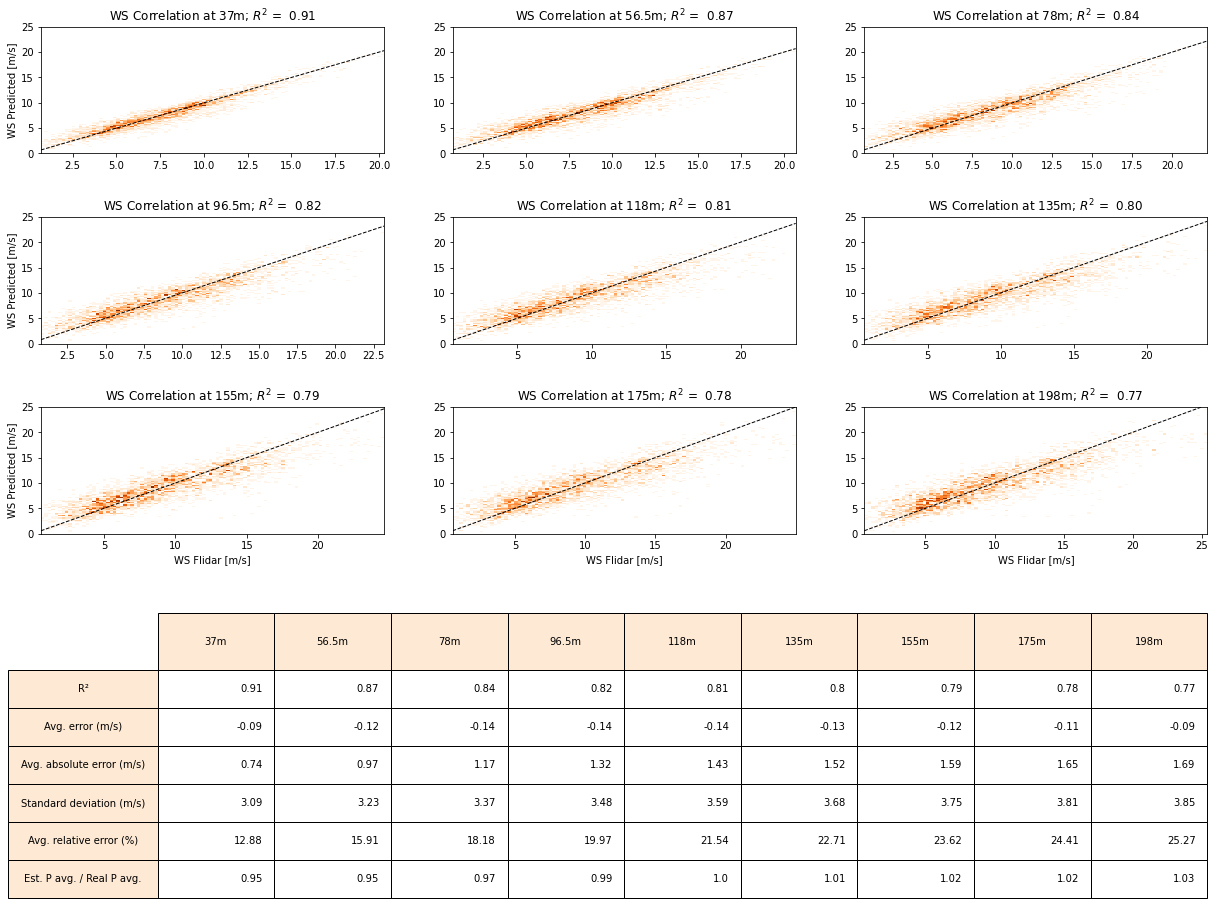

In [70]:
# Testing site C

df_X_train, df_X_test, df_X_test2, df_y_train, df_y_test, df_y_test2 = split(df_Xy_C, ratio)

gbm = CatBoostRegressor(iterations=1499, l2_leaf_reg=3, loss_function="MultiRMSE", learning_rate=0.2455790960328536, colsample_bylevel=0.09990813580582374, max_depth=15, random_strength=0.08156897802473861, boosting_type="Plain", bootstrap_type="MVS")
gbm.fit(df_X_train, df_y_train)
test_model(gbm, heights, ["global"], "No", df_X_test2, df_y_test2)

In [34]:
# Optimizing site TRE

df_X_train, df_X_test, df_X_test2, df_y_train, df_y_test, df_y_test2 = split(df_Xy_TRE, ratio)


def objective(trial):
    X_train = df_X_train
    X_val = df_X_test
    y_train = df_y_train
    y_val = df_y_test

    param = {
        "iterations" : trial.suggest_int("iterations", 1, 1500),
        "l2_leaf_reg" : trial.suggest_int("l2_leaf_reg", 2, 10),
        "loss_function" : trial.suggest_categorical("loss_function", ["MultiRMSE"]),
        "learning_rate" : trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "max_depth" : trial.suggest_int("max_depth", 1, 15),
        "random_strength" : trial.suggest_loguniform("random_strength", 0.0001, 10.0),
        "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }
    

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_uniform("subsample", 0.1, 1)

    gbm = catboost.CatBoostRegressor(**param, )

    gbm.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 0, early_stopping_rounds = 15)

    predictions = gbm.predict(X_val)
    RMSE = mean_squared_error(y_val, predictions)
    
    return RMSE

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 400, show_progress_bar = True)


print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-19 21:38:54,687] A new study created in memory with name: no-name-f42d67aa-653a-4749-b23b-0726eafb89b9
  0%|          | 1/400 [00:11<1:14:23, 11.19s/it]

[I 2022-08-19 21:39:05,877] Trial 0 finished with value: 10.216379311693089 and parameters: {'iterations': 1474, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0014720601562600633, 'colsample_bylevel': 0.09199669961381389, 'max_depth': 3, 'random_strength': 0.01167804315591544, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.6381527198101855}. Best is trial 0 with value: 10.216379311693089.


  0%|          | 2/400 [00:15<47:34,  7.17s/it]  

[I 2022-08-19 21:39:10,236] Trial 1 finished with value: 5.143168336731508 and parameters: {'iterations': 566, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.014056185621564906, 'colsample_bylevel': 0.06748724003712314, 'max_depth': 9, 'random_strength': 0.4251607714979949, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.458503677476316}. Best is trial 1 with value: 5.143168336731508.


  1%|          | 3/400 [00:19<36:19,  5.49s/it]

[I 2022-08-19 21:39:13,726] Trial 2 finished with value: 1.9555273865336018 and parameters: {'iterations': 993, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22481097065078012, 'colsample_bylevel': 0.07322277008996152, 'max_depth': 14, 'random_strength': 1.0993622885075534, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.803749918980411}. Best is trial 2 with value: 1.9555273865336018.


  1%|          | 4/400 [00:27<42:44,  6.48s/it]

[I 2022-08-19 21:39:21,714] Trial 3 finished with value: 8.79468698216915 and parameters: {'iterations': 1155, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0031777167390567404, 'colsample_bylevel': 0.06854133796612576, 'max_depth': 8, 'random_strength': 0.03371233477280175, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.60283173550748}. Best is trial 2 with value: 1.9555273865336018.


  1%|▏         | 5/400 [00:32<40:03,  6.08s/it]

[I 2022-08-19 21:39:27,103] Trial 4 finished with value: 2.3280719855366594 and parameters: {'iterations': 878, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27008696034542046, 'colsample_bylevel': 0.05167077055751813, 'max_depth': 8, 'random_strength': 0.05734981782872187, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.2812738914462196}. Best is trial 2 with value: 1.9555273865336018.


  2%|▏         | 6/400 [00:33<28:18,  4.31s/it]

[I 2022-08-19 21:39:27,970] Trial 5 finished with value: 18.479595051634387 and parameters: {'iterations': 1237, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0076393665419986715, 'colsample_bylevel': 0.011914280894447432, 'max_depth': 5, 'random_strength': 1.1877809976977851, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 1.9555273865336018.


  2%|▏         | 7/400 [00:34<20:47,  3.17s/it]

[I 2022-08-19 21:39:28,805] Trial 6 finished with value: 3.964956319816743 and parameters: {'iterations': 375, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09267541983561572, 'colsample_bylevel': 0.04439179326685432, 'max_depth': 15, 'random_strength': 0.002940611184205887, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.117473178358832}. Best is trial 2 with value: 1.9555273865336018.


  2%|▏         | 8/400 [00:39<24:51,  3.80s/it]

[I 2022-08-19 21:39:33,959] Trial 7 finished with value: 2.954317344835857 and parameters: {'iterations': 515, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.02433029137439292, 'colsample_bylevel': 0.0916811218075437, 'max_depth': 15, 'random_strength': 4.728208020751059, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.38555628177134404}. Best is trial 2 with value: 1.9555273865336018.


  2%|▏         | 9/400 [00:44<26:49,  4.12s/it]

[I 2022-08-19 21:39:38,765] Trial 8 finished with value: 4.348014851229972 and parameters: {'iterations': 1449, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.00456854525360142, 'colsample_bylevel': 0.08677133587919074, 'max_depth': 11, 'random_strength': 1.2131035407360513, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 1.9555273865336018.


  2%|▎         | 10/400 [00:45<21:08,  3.25s/it]

[I 2022-08-19 21:39:40,083] Trial 9 finished with value: 5.134463143112011 and parameters: {'iterations': 567, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21130452255154314, 'colsample_bylevel': 0.011857230481109393, 'max_depth': 3, 'random_strength': 0.44531914693058866, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.154124047394822}. Best is trial 2 with value: 1.9555273865336018.


  3%|▎         | 11/400 [00:45<15:23,  2.37s/it]

[I 2022-08-19 21:39:40,464] Trial 10 finished with value: 9.188304978632264 and parameters: {'iterations': 161, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.05418549280282198, 'colsample_bylevel': 0.033063864141084434, 'max_depth': 12, 'random_strength': 0.0006225314885947662, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9886711533318746}. Best is trial 2 with value: 1.9555273865336018.


  3%|▎         | 12/400 [00:51<21:58,  3.40s/it]

[I 2022-08-19 21:39:46,202] Trial 11 finished with value: 2.544977675600011 and parameters: {'iterations': 903, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2957940599501826, 'colsample_bylevel': 0.061443057122100596, 'max_depth': 7, 'random_strength': 0.0869476880937025, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.707321892115788}. Best is trial 2 with value: 1.9555273865336018.


  3%|▎         | 13/400 [00:53<19:08,  2.97s/it]

[I 2022-08-19 21:39:48,179] Trial 12 finished with value: 2.686918878958992 and parameters: {'iterations': 876, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10780252671497034, 'colsample_bylevel': 0.04742159337286049, 'max_depth': 12, 'random_strength': 0.0001090968191756667, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2404923525760454}. Best is trial 2 with value: 1.9555273865336018.


  4%|▎         | 14/400 [01:00<27:34,  4.29s/it]

[I 2022-08-19 21:39:55,516] Trial 13 finished with value: 2.754342844989504 and parameters: {'iterations': 1054, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.040917602000063585, 'colsample_bylevel': 0.07788082464531551, 'max_depth': 6, 'random_strength': 8.458814622639888, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.449640155041601}. Best is trial 2 with value: 1.9555273865336018.


  4%|▍         | 15/400 [01:02<21:48,  3.40s/it]

[I 2022-08-19 21:39:56,855] Trial 14 finished with value: 3.47229929016708 and parameters: {'iterations': 785, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14484455444569252, 'colsample_bylevel': 0.031481092139034134, 'max_depth': 10, 'random_strength': 0.12098377984005844, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1500362443573912}. Best is trial 2 with value: 1.9555273865336018.


  4%|▍         | 16/400 [01:08<27:56,  4.37s/it]

[I 2022-08-19 21:40:03,467] Trial 15 finished with value: 3.1010315787243736 and parameters: {'iterations': 1020, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.061666557914102776, 'colsample_bylevel': 0.05356332430020533, 'max_depth': 1, 'random_strength': 0.008884806129743987, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 1.9555273865336018.


  4%|▍         | 17/400 [20:42<37:51:53, 355.91s/it]

[I 2022-08-19 21:59:36,921] Trial 16 finished with value: 2.414273090409484 and parameters: {'iterations': 1249, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2781987431088148, 'colsample_bylevel': 0.0712258567943139, 'max_depth': 13, 'random_strength': 0.1280074595091521, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.156535770139695}. Best is trial 2 with value: 1.9555273865336018.


  5%|▍         | 19/400 [20:43<18:28:18, 174.54s/it]

[I 2022-08-19 21:59:38,405] Trial 17 finished with value: 5.350114929668219 and parameters: {'iterations': 701, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.024835459435040466, 'colsample_bylevel': 0.0349004882132022, 'max_depth': 9, 'random_strength': 1.960655044638895, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.568824256082534}. Best is trial 2 with value: 1.9555273865336018.
[I 2022-08-19 21:59:38,526] Trial 18 finished with value: 10.885669625187315 and parameters: {'iterations': 10, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14703588132815518, 'colsample_bylevel': 0.0819703781057458, 'max_depth': 5, 'random_strength': 0.2931225248510069, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 1.9555273865336018.


  5%|▌         | 20/400 [20:45<12:56:42, 122.64s/it]

[I 2022-08-19 21:59:40,205] Trial 19 finished with value: 2.6347655157640446 and parameters: {'iterations': 719, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08750126350652875, 'colsample_bylevel': 0.054782415849959305, 'max_depth': 14, 'random_strength': 0.027341684905387346, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9251410752547222}. Best is trial 2 with value: 1.9555273865336018.


  5%|▌         | 21/400 [31:05<28:37:21, 271.88s/it]

[I 2022-08-19 22:10:00,032] Trial 20 finished with value: 6.89368164797704 and parameters: {'iterations': 991, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.012233531061541056, 'colsample_bylevel': 0.042731371797234165, 'max_depth': 10, 'random_strength': 0.0008005344041301037, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.872618948661334}. Best is trial 2 with value: 1.9555273865336018.


  6%|▌         | 22/400 [31:29<20:45:16, 197.66s/it]

[I 2022-08-19 22:10:24,619] Trial 21 finished with value: 2.0754484870946275 and parameters: {'iterations': 1233, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.28531420000391816, 'colsample_bylevel': 0.07531038765668657, 'max_depth': 13, 'random_strength': 0.09075289630368102, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.468165961006611}. Best is trial 2 with value: 1.9555273865336018.


  6%|▌         | 23/400 [31:49<15:05:20, 144.09s/it]

[I 2022-08-19 22:10:43,742] Trial 22 finished with value: 2.3637855672449115 and parameters: {'iterations': 1313, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17767383913280846, 'colsample_bylevel': 0.0756065452519197, 'max_depth': 13, 'random_strength': 0.03995857751402842, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.030454443665022}. Best is trial 2 with value: 1.9555273865336018.


  6%|▌         | 24/400 [31:54<10:41:52, 102.43s/it]

[I 2022-08-19 22:10:48,988] Trial 23 finished with value: 2.697318744583277 and parameters: {'iterations': 1118, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29728519627650696, 'colsample_bylevel': 0.06006669601097193, 'max_depth': 13, 'random_strength': 0.010284425691520034, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.432850999401789}. Best is trial 2 with value: 1.9555273865336018.


  6%|▋         | 25/400 [32:26<8:28:06, 81.30s/it]  

[I 2022-08-19 22:11:20,992] Trial 24 finished with value: 1.8106477632642555 and parameters: {'iterations': 1367, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15557366212593848, 'colsample_bylevel': 0.09676926354278778, 'max_depth': 11, 'random_strength': 0.24259693796302736, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.2968465418451878}. Best is trial 24 with value: 1.8106477632642555.


  6%|▋         | 26/400 [33:01<7:00:19, 67.43s/it]

[I 2022-08-19 22:11:56,080] Trial 25 finished with value: 1.836280771676503 and parameters: {'iterations': 1357, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12823058691582714, 'colsample_bylevel': 0.09921880352335295, 'max_depth': 11, 'random_strength': 0.24141027510903018, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.338472962229897}. Best is trial 24 with value: 1.8106477632642555.


  7%|▋         | 27/400 [33:07<5:04:14, 48.94s/it]

[I 2022-08-19 22:12:01,870] Trial 26 finished with value: 2.049560267450632 and parameters: {'iterations': 1415, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.03719825915419215, 'colsample_bylevel': 0.09755276698149569, 'max_depth': 11, 'random_strength': 2.835095846788242, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.617847943566865}. Best is trial 24 with value: 1.8106477632642555.


  7%|▋         | 28/400 [33:40<4:34:48, 44.32s/it]

[I 2022-08-19 22:12:35,426] Trial 27 finished with value: 1.5333973715854912 and parameters: {'iterations': 1355, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11799924208086834, 'colsample_bylevel': 0.09627526584612683, 'max_depth': 11, 'random_strength': 0.5713476046131754, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6518478388197477}. Best is trial 27 with value: 1.5333973715854912.


  7%|▋         | 29/400 [34:24<4:33:11, 44.18s/it]

[I 2022-08-19 22:13:19,277] Trial 28 finished with value: 1.7237483489396004 and parameters: {'iterations': 1351, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06384740302428198, 'colsample_bylevel': 0.09887561538765083, 'max_depth': 11, 'random_strength': 0.5577072185253555, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6309472843385384}. Best is trial 27 with value: 1.5333973715854912.


  8%|▊         | 30/400 [34:46<3:51:28, 37.54s/it]

[I 2022-08-19 22:13:41,311] Trial 29 finished with value: 1.8050745981651986 and parameters: {'iterations': 1478, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06913333874974412, 'colsample_bylevel': 0.0910644264588985, 'max_depth': 10, 'random_strength': 0.7047611172834, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6434800876704998}. Best is trial 27 with value: 1.5333973715854912.


  8%|▊         | 31/400 [35:01<3:09:01, 30.73s/it]

[I 2022-08-19 22:13:56,175] Trial 30 finished with value: 2.001397335076456 and parameters: {'iterations': 1482, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.058145544119714954, 'colsample_bylevel': 0.08753936347698055, 'max_depth': 9, 'random_strength': 0.6621424833346822, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6513028979353622}. Best is trial 27 with value: 1.5333973715854912.


  8%|▊         | 32/400 [35:20<2:47:27, 27.30s/it]

[I 2022-08-19 22:14:15,472] Trial 31 finished with value: 1.7664045742773762 and parameters: {'iterations': 1347, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08470715429815301, 'colsample_bylevel': 0.09119177796038902, 'max_depth': 10, 'random_strength': 0.2147625227649509, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6309883916922424}. Best is trial 27 with value: 1.5333973715854912.


  8%|▊         | 33/400 [35:45<2:42:38, 26.59s/it]

[I 2022-08-19 22:14:40,399] Trial 32 finished with value: 1.7583105847769753 and parameters: {'iterations': 1480, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06944740259610364, 'colsample_bylevel': 0.09146705666301937, 'max_depth': 10, 'random_strength': 0.7108082514532106, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6562324389935731}. Best is trial 27 with value: 1.5333973715854912.


  8%|▊         | 34/400 [35:57<2:15:11, 22.16s/it]

[I 2022-08-19 22:14:52,230] Trial 33 finished with value: 2.3079254550045367 and parameters: {'iterations': 1310, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.03630768378650609, 'colsample_bylevel': 0.08207121301017636, 'max_depth': 9, 'random_strength': 2.9304388579289022, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6272367738677338}. Best is trial 27 with value: 1.5333973715854912.


  9%|▉         | 35/400 [36:08<1:53:40, 18.69s/it]

[I 2022-08-19 22:15:02,802] Trial 34 finished with value: 2.54142819177701 and parameters: {'iterations': 1141, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.021685709389684414, 'colsample_bylevel': 0.08484717741017662, 'max_depth': 8, 'random_strength': 0.20359112399750875, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7454038736490564}. Best is trial 27 with value: 1.5333973715854912.


  9%|▉         | 36/400 [36:46<2:29:06, 24.58s/it]

[I 2022-08-19 22:15:41,132] Trial 35 finished with value: 1.7653403918624095 and parameters: {'iterations': 1215, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07979830573781517, 'colsample_bylevel': 0.09364333638380849, 'max_depth': 12, 'random_strength': 0.61508392240206, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5037354924943612}. Best is trial 27 with value: 1.5333973715854912.


  9%|▉         | 37/400 [37:19<2:43:53, 27.09s/it]

[I 2022-08-19 22:16:14,081] Trial 36 finished with value: 2.0344610701488364 and parameters: {'iterations': 1200, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.04533333926297316, 'colsample_bylevel': 0.09467835331327987, 'max_depth': 12, 'random_strength': 8.411525091825103, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4476794013180979}. Best is trial 27 with value: 1.5333973715854912.


 10%|▉         | 38/400 [39:19<5:31:23, 54.93s/it]

[I 2022-08-19 22:18:13,954] Trial 37 finished with value: 2.604536535360259 and parameters: {'iterations': 1398, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.010879948614076446, 'colsample_bylevel': 0.09968396873732459, 'max_depth': 14, 'random_strength': 0.5604636846028237, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4630566117542134}. Best is trial 27 with value: 1.5333973715854912.


 10%|▉         | 39/400 [39:42<4:33:40, 45.48s/it]

[I 2022-08-19 22:18:37,412] Trial 38 finished with value: 1.7435931449814608 and parameters: {'iterations': 1273, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11211497215406085, 'colsample_bylevel': 0.0806000457642294, 'max_depth': 12, 'random_strength': 1.4774936851509919, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7864244990672397}. Best is trial 27 with value: 1.5333973715854912.


 10%|█         | 40/400 [39:55<3:33:46, 35.63s/it]

[I 2022-08-19 22:18:50,042] Trial 39 finished with value: 1.7464140373166108 and parameters: {'iterations': 1497, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1103654520811514, 'colsample_bylevel': 0.08001667948623521, 'max_depth': 8, 'random_strength': 1.4503525785240872, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8624347231664842}. Best is trial 27 with value: 1.5333973715854912.


 10%|█         | 41/400 [40:03<2:43:51, 27.38s/it]

[I 2022-08-19 22:18:58,192] Trial 40 finished with value: 9.643923437499978 and parameters: {'iterations': 1294, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.002453714058534229, 'colsample_bylevel': 0.06671952148271765, 'max_depth': 7, 'random_strength': 1.8863052964169702, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.811506565451461}. Best is trial 27 with value: 1.5333973715854912.


 10%|█         | 42/400 [40:19<2:23:16, 24.01s/it]

[I 2022-08-19 22:19:14,335] Trial 41 finished with value: 1.722187037655948 and parameters: {'iterations': 1482, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10639907643818045, 'colsample_bylevel': 0.08842757045782154, 'max_depth': 9, 'random_strength': 3.9812735844342364, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8180952969150013}. Best is trial 27 with value: 1.5333973715854912.


 11%|█         | 43/400 [40:29<1:57:41, 19.78s/it]

[I 2022-08-19 22:19:24,237] Trial 42 finished with value: 1.847106391427223 and parameters: {'iterations': 1416, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12829474979597452, 'colsample_bylevel': 0.07863433818526065, 'max_depth': 7, 'random_strength': 4.9095963071596005, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8168449697750828}. Best is trial 27 with value: 1.5333973715854912.


 11%|█         | 44/400 [40:43<1:46:15, 17.91s/it]

[I 2022-08-19 22:19:37,778] Trial 43 finished with value: 1.7792510635889718 and parameters: {'iterations': 1486, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09735785844579739, 'colsample_bylevel': 0.08676744843087704, 'max_depth': 8, 'random_strength': 1.468690396812405, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8049239621467168}. Best is trial 27 with value: 1.5333973715854912.


 11%|█▏        | 45/400 [40:53<1:33:10, 15.75s/it]

[I 2022-08-19 22:19:48,490] Trial 44 finished with value: 1.6427846192446331 and parameters: {'iterations': 1279, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2060174967546909, 'colsample_bylevel': 0.08193770304334233, 'max_depth': 9, 'random_strength': 4.726771802903278, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8699139896788711}. Best is trial 27 with value: 1.5333973715854912.


 12%|█▏        | 46/400 [41:09<1:33:37, 15.87s/it]

[I 2022-08-19 22:20:04,634] Trial 45 finished with value: 1.666273193330622 and parameters: {'iterations': 1067, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1912738449831561, 'colsample_bylevel': 0.08720556303614678, 'max_depth': 11, 'random_strength': 4.673641863410352, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.740992487732412}. Best is trial 27 with value: 1.5333973715854912.


 12%|█▏        | 47/400 [41:26<1:34:30, 16.06s/it]

[I 2022-08-19 22:20:21,160] Trial 46 finished with value: 1.6920909623471958 and parameters: {'iterations': 1087, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1718554873269631, 'colsample_bylevel': 0.08697695214748265, 'max_depth': 11, 'random_strength': 5.318644719024917, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7159783667164434}. Best is trial 27 with value: 1.5333973715854912.


 12%|█▏        | 48/400 [41:39<1:28:11, 15.03s/it]

[I 2022-08-19 22:20:33,780] Trial 47 finished with value: 1.6059136416190887 and parameters: {'iterations': 1077, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20166885990466063, 'colsample_bylevel': 0.08810034315382971, 'max_depth': 9, 'random_strength': 4.952672109658964, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 27 with value: 1.5333973715854912.


 12%|█▏        | 49/400 [41:47<1:15:49, 12.96s/it]

[I 2022-08-19 22:20:41,910] Trial 48 finished with value: 1.8703546467781875 and parameters: {'iterations': 1063, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21592379270716383, 'colsample_bylevel': 0.0689273464463619, 'max_depth': 9, 'random_strength': 8.857162216619473, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 27 with value: 1.5333973715854912.


 12%|█▎        | 50/400 [41:47<53:59,  9.26s/it]  

[I 2022-08-19 22:20:42,520] Trial 49 finished with value: 9.58717605857428 and parameters: {'iterations': 933, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19301359609956112, 'colsample_bylevel': 0.01960390358073269, 'max_depth': 6, 'random_strength': 6.0093878464086945, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 27 with value: 1.5333973715854912.


 13%|█▎        | 51/400 [41:59<58:07,  9.99s/it]

[I 2022-08-19 22:20:54,233] Trial 50 finished with value: 13.28449625766513 and parameters: {'iterations': 1151, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0012108875263926117, 'colsample_bylevel': 0.07390375486302629, 'max_depth': 10, 'random_strength': 2.9593493718054376, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 27 with value: 1.5333973715854912.


 13%|█▎        | 52/400 [42:10<59:42, 10.30s/it]

[I 2022-08-19 22:21:05,233] Trial 51 finished with value: 1.7438431118925803 and parameters: {'iterations': 827, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16709491358417494, 'colsample_bylevel': 0.0885868032045268, 'max_depth': 9, 'random_strength': 4.588281462223131, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 27 with value: 1.5333973715854912.


 13%|█▎        | 53/400 [42:27<1:10:49, 12.25s/it]

[I 2022-08-19 22:21:22,028] Trial 52 finished with value: 1.6504308417893663 and parameters: {'iterations': 1073, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22791572954578848, 'colsample_bylevel': 0.08424038422812664, 'max_depth': 11, 'random_strength': 3.391118545858887, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.725632023987364}. Best is trial 27 with value: 1.5333973715854912.


 14%|█▎        | 54/400 [42:44<1:19:44, 13.83s/it]

[I 2022-08-19 22:21:39,546] Trial 53 finished with value: 1.6511607397675785 and parameters: {'iterations': 1081, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22926493468706996, 'colsample_bylevel': 0.08528569194457725, 'max_depth': 11, 'random_strength': 9.568481886290884, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7014670840634007}. Best is trial 27 with value: 1.5333973715854912.


 14%|█▍        | 55/400 [43:00<1:21:52, 14.24s/it]

[I 2022-08-19 22:21:54,750] Trial 54 finished with value: 1.6068282068446218 and parameters: {'iterations': 942, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2326040461789137, 'colsample_bylevel': 0.08459199715285903, 'max_depth': 11, 'random_strength': 9.093163757864248, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 27 with value: 1.5333973715854912.


 14%|█▍        | 56/400 [43:21<1:33:42, 16.34s/it]

[I 2022-08-19 22:22:16,004] Trial 55 finished with value: 1.6214174157644452 and parameters: {'iterations': 948, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23994000519227648, 'colsample_bylevel': 0.08395762114406846, 'max_depth': 12, 'random_strength': 8.483503347221376, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 27 with value: 1.5333973715854912.


 14%|█▍        | 57/400 [43:23<1:08:37, 12.00s/it]

[I 2022-08-19 22:22:17,879] Trial 56 finished with value: 2.0768991253739584 and parameters: {'iterations': 959, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24602719540082027, 'colsample_bylevel': 0.06375860783059308, 'max_depth': 12, 'random_strength': 2.3015534501595774, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 27 with value: 1.5333973715854912.


 14%|█▍        | 58/400 [43:40<1:18:18, 13.74s/it]

[I 2022-08-19 22:22:35,665] Trial 57 finished with value: 1.7218333977202567 and parameters: {'iterations': 856, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23625583690920876, 'colsample_bylevel': 0.07764490289725215, 'max_depth': 14, 'random_strength': 6.858630601530542, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 27 with value: 1.5333973715854912.


 15%|█▍        | 59/400 [44:56<3:02:46, 32.16s/it]

[I 2022-08-19 22:23:50,807] Trial 58 finished with value: 1.7333486361399801 and parameters: {'iterations': 974, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1347846719620928, 'colsample_bylevel': 0.08371579012035796, 'max_depth': 15, 'random_strength': 3.0810166614900303, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 27 with value: 1.5333973715854912.


 15%|█▌        | 60/400 [45:34<3:12:44, 34.01s/it]

[I 2022-08-19 22:24:29,144] Trial 59 finished with value: 1.4245536090077997 and parameters: {'iterations': 904, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29656348891434786, 'colsample_bylevel': 0.09563186927221853, 'max_depth': 13, 'random_strength': 0.9884924345131756, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 1.4245536090077997.


 15%|█▌        | 61/400 [45:38<2:20:59, 24.96s/it]

[I 2022-08-19 22:24:32,967] Trial 60 finished with value: 1.4458935151735206 and parameters: {'iterations': 761, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2861314265798927, 'colsample_bylevel': 0.09265081644551261, 'max_depth': 13, 'random_strength': 1.0447404403996436, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 1.4245536090077997.


 16%|█▌        | 62/400 [45:42<1:45:32, 18.73s/it]

[I 2022-08-19 22:24:37,184] Trial 61 finished with value: 1.442651119698701 and parameters: {'iterations': 664, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.299853774145641, 'colsample_bylevel': 0.09558763662034475, 'max_depth': 13, 'random_strength': 1.0439435285480827, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 1.4245536090077997.


 16%|█▌        | 63/400 [45:46<1:20:54, 14.41s/it]

[I 2022-08-19 22:24:41,488] Trial 62 finished with value: 1.485378686511351 and parameters: {'iterations': 636, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2427024542526654, 'colsample_bylevel': 0.09561353435711795, 'max_depth': 13, 'random_strength': 1.083358030623349, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 1.4245536090077997.


 16%|█▌        | 64/400 [45:50<1:02:20, 11.13s/it]

[I 2022-08-19 22:24:44,982] Trial 63 finished with value: 1.5427099616751012 and parameters: {'iterations': 571, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27935901975368427, 'colsample_bylevel': 0.09526627580019072, 'max_depth': 13, 'random_strength': 1.0038968228693244, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 1.4245536090077997.


 16%|█▋        | 65/400 [45:53<49:40,  8.90s/it]  

[I 2022-08-19 22:24:48,662] Trial 64 finished with value: 1.5144687425763352 and parameters: {'iterations': 567, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.280790906574133, 'colsample_bylevel': 0.09578202497342718, 'max_depth': 13, 'random_strength': 1.0541954645709992, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 1.4245536090077997.


 16%|█▋        | 66/400 [45:57<40:36,  7.29s/it]

[I 2022-08-19 22:24:52,216] Trial 65 finished with value: 1.535508291809193 and parameters: {'iterations': 572, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2752924694130319, 'colsample_bylevel': 0.09540709428681085, 'max_depth': 14, 'random_strength': 0.3821243355284694, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 1.4245536090077997.


 17%|█▋        | 67/400 [45:59<32:19,  5.83s/it]

[I 2022-08-19 22:24:54,617] Trial 66 finished with value: 1.612226007774902 and parameters: {'iterations': 472, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.293757455144635, 'colsample_bylevel': 0.09361894592312557, 'max_depth': 14, 'random_strength': 0.35603599767757826, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 1.4245536090077997.


 17%|█▋        | 68/400 [46:07<34:36,  6.25s/it]

[I 2022-08-19 22:25:01,873] Trial 67 finished with value: 1.642371107969864 and parameters: {'iterations': 646, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1599152158853849, 'colsample_bylevel': 0.09481662482038754, 'max_depth': 15, 'random_strength': 0.9369711332905164, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 1.4245536090077997.


 17%|█▋        | 69/400 [46:10<29:19,  5.32s/it]

[I 2022-08-19 22:25:05,002] Trial 68 finished with value: 1.920971230596807 and parameters: {'iterations': 341, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14164356825030477, 'colsample_bylevel': 0.09717961167933759, 'max_depth': 14, 'random_strength': 0.1263583500289778, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 1.4245536090077997.


 18%|█▊        | 70/400 [46:13<26:05,  4.74s/it]

[I 2022-08-19 22:25:08,411] Trial 69 finished with value: 5.681635981876265 and parameters: {'iterations': 657, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.005808104973434799, 'colsample_bylevel': 0.0911281317036668, 'max_depth': 13, 'random_strength': 0.41038953938601175, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 1.4245536090077997.


 18%|█▊        | 71/400 [46:18<26:51,  4.90s/it]

[I 2022-08-19 22:25:13,670] Trial 70 finished with value: 1.5317213510036396 and parameters: {'iterations': 441, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29402887266180067, 'colsample_bylevel': 0.09977290384076239, 'max_depth': 15, 'random_strength': 0.915060642303213, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 1.4245536090077997.


 18%|█▊        | 72/400 [46:23<26:01,  4.76s/it]

[I 2022-08-19 22:25:18,105] Trial 71 finished with value: 1.5650279620336063 and parameters: {'iterations': 436, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2964471453530157, 'colsample_bylevel': 0.09953037406702377, 'max_depth': 15, 'random_strength': 0.9279962140080968, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 1.4245536090077997.


 18%|█▊        | 73/400 [46:27<24:01,  4.41s/it]

[I 2022-08-19 22:25:21,692] Trial 72 finished with value: 1.5971419070069024 and parameters: {'iterations': 598, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17959528183810053, 'colsample_bylevel': 0.09631826925857696, 'max_depth': 13, 'random_strength': 0.37186194989096405, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 1.4245536090077997.


 18%|█▊        | 74/400 [46:28<19:26,  3.58s/it]

[I 2022-08-19 22:25:23,335] Trial 73 finished with value: 1.8531015454344189 and parameters: {'iterations': 315, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25529737555309356, 'colsample_bylevel': 0.0917706046557164, 'max_depth': 14, 'random_strength': 0.17859640067882365, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 1.4245536090077997.


 19%|█▉        | 75/400 [46:34<23:29,  4.34s/it]

[I 2022-08-19 22:25:29,445] Trial 74 finished with value: 1.4224137556906982 and parameters: {'iterations': 774, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2987881077692913, 'colsample_bylevel': 0.09317008602968034, 'max_depth': 15, 'random_strength': 1.9354218053081076, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 74 with value: 1.4224137556906982.


 19%|█▉        | 76/400 [46:40<26:05,  4.83s/it]

[I 2022-08-19 22:25:35,429] Trial 75 finished with value: 1.5075189574114531 and parameters: {'iterations': 767, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18889678605267554, 'colsample_bylevel': 0.09329305513516531, 'max_depth': 15, 'random_strength': 1.7753184981396644, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 74 with value: 1.4224137556906982.


 19%|█▉        | 77/400 [46:48<31:00,  5.76s/it]

[I 2022-08-19 22:25:43,352] Trial 76 finished with value: 1.3688779762735672 and parameters: {'iterations': 727, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29961152629008514, 'colsample_bylevel': 0.09994999742512992, 'max_depth': 15, 'random_strength': 1.7528682706406085, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 76 with value: 1.3688779762735672.


 20%|█▉        | 78/400 [46:55<31:58,  5.96s/it]

[I 2022-08-19 22:25:49,770] Trial 77 finished with value: 1.5741794284235469 and parameters: {'iterations': 783, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1958874248650699, 'colsample_bylevel': 0.08967841422596719, 'max_depth': 15, 'random_strength': 2.0572179827780817, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 76 with value: 1.3688779762735672.


 20%|█▉        | 79/400 [46:59<29:22,  5.49s/it]

[I 2022-08-19 22:25:54,171] Trial 78 finished with value: 1.6225011212549054 and parameters: {'iterations': 730, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15650126978203055, 'colsample_bylevel': 0.09300255705006284, 'max_depth': 14, 'random_strength': 1.3269370422585658, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 76 with value: 1.3688779762735672.


 20%|██        | 80/400 [47:01<23:38,  4.43s/it]

[I 2022-08-19 22:25:56,137] Trial 79 finished with value: 2.1141729731768466 and parameters: {'iterations': 673, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24364783056197778, 'colsample_bylevel': 0.097487505921588, 'max_depth': 3, 'random_strength': 1.856515555440731, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 76 with value: 1.3688779762735672.


 20%|██        | 81/400 [47:05<23:13,  4.37s/it]

[I 2022-08-19 22:26:00,351] Trial 80 finished with value: 1.4681301365379928 and parameters: {'iterations': 831, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1983876343012646, 'colsample_bylevel': 0.0928675283516188, 'max_depth': 13, 'random_strength': 0.01901930922306283, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 76 with value: 1.3688779762735672.


 20%|██        | 82/400 [47:09<21:51,  4.13s/it]

[I 2022-08-19 22:26:03,912] Trial 81 finished with value: 1.5871291309640696 and parameters: {'iterations': 777, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21077864225575182, 'colsample_bylevel': 0.0900703198196233, 'max_depth': 13, 'random_strength': 0.0038315976542319607, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 76 with value: 1.3688779762735672.


 21%|██        | 83/400 [47:15<24:55,  4.72s/it]

[I 2022-08-19 22:26:10,008] Trial 82 finished with value: 1.360606288336572 and parameters: {'iterations': 840, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25803685185429387, 'colsample_bylevel': 0.09303332714144984, 'max_depth': 15, 'random_strength': 0.021815516590487607, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 82 with value: 1.360606288336572.


 21%|██        | 84/400 [47:21<27:13,  5.17s/it]

[I 2022-08-19 22:26:16,236] Trial 83 finished with value: 1.4776747995221435 and parameters: {'iterations': 863, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1753946436173904, 'colsample_bylevel': 0.092967628755325, 'max_depth': 15, 'random_strength': 0.01856051188948139, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 82 with value: 1.360606288336572.


 21%|██▏       | 85/400 [47:23<22:38,  4.31s/it]

[I 2022-08-19 22:26:18,553] Trial 84 finished with value: 2.4060231089629713 and parameters: {'iterations': 827, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.155760744634087, 'colsample_bylevel': 0.09246557903821809, 'max_depth': 2, 'random_strength': 0.028217945050749385, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 82 with value: 1.360606288336572.


 22%|██▏       | 86/400 [47:30<26:20,  5.03s/it]

[I 2022-08-19 22:26:25,267] Trial 85 finished with value: 1.3379634440346673 and parameters: {'iterations': 892, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2617858436107321, 'colsample_bylevel': 0.09812367163633338, 'max_depth': 14, 'random_strength': 0.01580768984937104, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 85 with value: 1.3379634440346673.


 22%|██▏       | 87/400 [47:38<31:18,  6.00s/it]

[I 2022-08-19 22:26:33,522] Trial 86 finished with value: 7.762678651143647 and parameters: {'iterations': 1019, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0023109057941517624, 'colsample_bylevel': 0.09856785688744278, 'max_depth': 14, 'random_strength': 0.01401139689106202, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 85 with value: 1.3379634440346673.


 22%|██▏       | 88/400 [47:41<25:35,  4.92s/it]

[I 2022-08-19 22:26:35,925] Trial 87 finished with value: 2.232968705722689 and parameters: {'iterations': 896, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13042841847361789, 'colsample_bylevel': 0.058032353495822565, 'max_depth': 15, 'random_strength': 0.01888442268511341, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 85 with value: 1.3379634440346673.


 22%|██▏       | 89/400 [47:43<20:57,  4.04s/it]

[I 2022-08-19 22:26:37,920] Trial 88 finished with value: 2.524685974776974 and parameters: {'iterations': 835, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17634265482005643, 'colsample_bylevel': 0.04194428489702655, 'max_depth': 15, 'random_strength': 0.05294669023413973, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 85 with value: 1.3379634440346673.


 22%|██▎       | 90/400 [47:46<19:59,  3.87s/it]

[I 2022-08-19 22:26:41,379] Trial 89 finished with value: 1.5867201683372958 and parameters: {'iterations': 705, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2113308072546915, 'colsample_bylevel': 0.09068628886908303, 'max_depth': 14, 'random_strength': 0.004696623047029385, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 85 with value: 1.3379634440346673.


 23%|██▎       | 91/400 [47:50<20:25,  3.97s/it]

[I 2022-08-19 22:26:45,571] Trial 90 finished with value: 1.507922428467305 and parameters: {'iterations': 742, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25254279646521677, 'colsample_bylevel': 0.08942370972537177, 'max_depth': 15, 'random_strength': 0.00885871529996295, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 85 with value: 1.3379634440346673.


 23%|██▎       | 92/400 [47:57<23:59,  4.67s/it]

[I 2022-08-19 22:26:51,896] Trial 91 finished with value: 1.3429015924894052 and parameters: {'iterations': 888, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25813260241541847, 'colsample_bylevel': 0.09763778792816305, 'max_depth': 14, 'random_strength': 0.02006469530778601, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 85 with value: 1.3379634440346673.


 23%|██▎       | 93/400 [48:04<27:10,  5.31s/it]

[I 2022-08-19 22:26:58,692] Trial 92 finished with value: 1.3719272537796587 and parameters: {'iterations': 900, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2070454100795579, 'colsample_bylevel': 0.09816672646271396, 'max_depth': 14, 'random_strength': 0.019665964413891308, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 85 with value: 1.3379634440346673.


 24%|██▎       | 94/400 [48:11<30:25,  5.97s/it]

[I 2022-08-19 22:27:06,187] Trial 93 finished with value: 1.3167858294746166 and parameters: {'iterations': 905, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2993353149188503, 'colsample_bylevel': 0.09997203010718753, 'max_depth': 14, 'random_strength': 0.006483545520376447, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 24%|██▍       | 95/400 [48:18<31:21,  6.17s/it]

[I 2022-08-19 22:27:12,827] Trial 94 finished with value: 1.3376924885725847 and parameters: {'iterations': 891, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25804731884091564, 'colsample_bylevel': 0.09828726048577734, 'max_depth': 14, 'random_strength': 0.007719505914947871, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 24%|██▍       | 96/400 [48:25<33:14,  6.56s/it]

[I 2022-08-19 22:27:20,307] Trial 95 finished with value: 1.4115683062447113 and parameters: {'iterations': 923, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21494564186195908, 'colsample_bylevel': 0.09793596746670043, 'max_depth': 14, 'random_strength': 0.0050577679544330754, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 24%|██▍       | 97/400 [48:32<33:26,  6.62s/it]

[I 2022-08-19 22:27:27,072] Trial 96 finished with value: 1.3645539626494356 and parameters: {'iterations': 911, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2565821575025534, 'colsample_bylevel': 0.09789226578328955, 'max_depth': 14, 'random_strength': 0.008008341452320976, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 24%|██▍       | 98/400 [48:40<36:15,  7.20s/it]

[I 2022-08-19 22:27:35,629] Trial 97 finished with value: 2.4879712261868723 and parameters: {'iterations': 1006, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.016522176476699207, 'colsample_bylevel': 0.09994805842035294, 'max_depth': 14, 'random_strength': 0.0018561031449222235, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 25%|██▍       | 99/400 [48:47<35:10,  7.01s/it]

[I 2022-08-19 22:27:42,191] Trial 98 finished with value: 1.3857276447041125 and parameters: {'iterations': 911, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2579286529638948, 'colsample_bylevel': 0.09750695655413821, 'max_depth': 14, 'random_strength': 0.007098047095199519, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 25%|██▌       | 100/400 [48:54<34:17,  6.86s/it]

[I 2022-08-19 22:27:48,695] Trial 99 finished with value: 1.4127808978863605 and parameters: {'iterations': 986, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2144207573732431, 'colsample_bylevel': 0.09760441954195602, 'max_depth': 14, 'random_strength': 0.007039778909837981, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 25%|██▌       | 101/400 [48:58<30:49,  6.18s/it]

[I 2022-08-19 22:27:53,308] Trial 100 finished with value: 1.6048395618425508 and parameters: {'iterations': 916, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2528263892239695, 'colsample_bylevel': 0.09793165951953935, 'max_depth': 14, 'random_strength': 0.001804273234828121, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 26%|██▌       | 102/400 [49:06<32:33,  6.56s/it]

[I 2022-08-19 22:28:00,732] Trial 101 finished with value: 1.3738031790013725 and parameters: {'iterations': 877, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22364041515010596, 'colsample_bylevel': 0.09888802875355464, 'max_depth': 14, 'random_strength': 0.005946528006453229, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 26%|██▌       | 103/400 [49:13<33:14,  6.72s/it]

[I 2022-08-19 22:28:07,821] Trial 102 finished with value: 1.393068407169726 and parameters: {'iterations': 884, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2247389354971001, 'colsample_bylevel': 0.09814629336096235, 'max_depth': 14, 'random_strength': 0.006660862304952929, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 26%|██▌       | 104/400 [49:19<33:03,  6.70s/it]

[I 2022-08-19 22:28:14,482] Trial 103 finished with value: 1.3900265403763847 and parameters: {'iterations': 883, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26034534157998207, 'colsample_bylevel': 0.09779850608150947, 'max_depth': 14, 'random_strength': 0.012205900072705281, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 26%|██▋       | 105/400 [50:29<2:05:57, 25.62s/it]

[I 2022-08-19 22:29:24,240] Trial 104 finished with value: 1.3417579585751558 and parameters: {'iterations': 1031, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2568735782123265, 'colsample_bylevel': 0.0969701240503606, 'max_depth': 14, 'random_strength': 0.014218542539621695, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 26%|██▋       | 106/400 [51:12<2:31:38, 30.95s/it]

[I 2022-08-19 22:30:07,617] Trial 105 finished with value: 1.5979788012426352 and parameters: {'iterations': 802, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15060331195457208, 'colsample_bylevel': 0.09494568269534472, 'max_depth': 15, 'random_strength': 0.04442101764747222, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 27%|██▋       | 107/400 [58:21<12:13:50, 150.28s/it]

[I 2022-08-19 22:37:16,332] Trial 106 finished with value: 1.503979248117452 and parameters: {'iterations': 1032, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12037757602617263, 'colsample_bylevel': 0.09946390385654569, 'max_depth': 14, 'random_strength': 0.0025150714839565274, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 27%|██▋       | 108/400 [58:22<8:32:40, 105.34s/it] 

[I 2022-08-19 22:37:16,832] Trial 107 finished with value: 4.568238092934798 and parameters: {'iterations': 971, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2535167220313355, 'colsample_bylevel': 0.021503367461178008, 'max_depth': 15, 'random_strength': 0.07525555792171296, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.08988631551635784}. Best is trial 93 with value: 1.3167858294746166.


 27%|██▋       | 109/400 [1:30:37<52:54:05, 654.45s/it]

[I 2022-08-19 23:09:32,536] Trial 108 finished with value: 1.3882969127771199 and parameters: {'iterations': 1111, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1926192479482912, 'colsample_bylevel': 0.09660063880239356, 'max_depth': 12, 'random_strength': 0.03524501720269745, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 28%|██▊       | 110/400 [1:46:01<59:13:23, 735.19s/it]

[I 2022-08-19 23:24:56,100] Trial 109 finished with value: 1.5441958008964454 and parameters: {'iterations': 805, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1726749185616113, 'colsample_bylevel': 0.09412127141551123, 'max_depth': 14, 'random_strength': 0.014620801601411255, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 28%|██▊       | 111/400 [1:47:27<43:23:43, 540.56s/it]

[I 2022-08-19 23:26:22,550] Trial 110 finished with value: 1.4220918037219805 and parameters: {'iterations': 847, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26110772084583644, 'colsample_bylevel': 0.0999181373322764, 'max_depth': 13, 'random_strength': 0.024155992452029724, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 28%|██▊       | 112/400 [1:51:28<36:02:39, 450.55s/it]

[I 2022-08-19 23:30:23,080] Trial 111 finished with value: 1.3502723470856306 and parameters: {'iterations': 1103, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21994682640210306, 'colsample_bylevel': 0.09665729975842952, 'max_depth': 15, 'random_strength': 0.033941358925314934, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 28%|██▊       | 113/400 [1:52:04<26:00:43, 326.29s/it]

[I 2022-08-19 23:30:59,404] Trial 112 finished with value: 1.3659593251299182 and parameters: {'iterations': 945, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22394850223986715, 'colsample_bylevel': 0.09724921338251427, 'max_depth': 15, 'random_strength': 0.009152256041978123, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 28%|██▊       | 114/400 [1:52:15<18:23:40, 231.54s/it]

[I 2022-08-19 23:31:09,870] Trial 113 finished with value: 1.3490522517724055 and parameters: {'iterations': 1034, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22794225458691705, 'colsample_bylevel': 0.09649297707118695, 'max_depth': 15, 'random_strength': 0.010166436963214124, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 29%|██▉       | 115/400 [2:09:29<37:23:41, 472.35s/it]

[I 2022-08-19 23:48:24,127] Trial 114 finished with value: 6.077257237308049 and parameters: {'iterations': 1180, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.008524993480993316, 'colsample_bylevel': 0.04923029928144552, 'max_depth': 15, 'random_strength': 0.0093468863897177, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 29%|██▉       | 116/400 [2:39:00<67:59:35, 861.89s/it]

[I 2022-08-20 00:17:54,920] Trial 115 finished with value: 2.1851387528210093 and parameters: {'iterations': 1041, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.02939023365968634, 'colsample_bylevel': 0.09483397411257412, 'max_depth': 15, 'random_strength': 0.011714012282647613, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 29%|██▉       | 117/400 [2:39:14<47:46:05, 607.65s/it]

[I 2022-08-20 00:18:09,358] Trial 116 finished with value: 1.51203017112649 and parameters: {'iterations': 947, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1454245459043955, 'colsample_bylevel': 0.0963613595370704, 'max_depth': 15, 'random_strength': 0.01609575160518412, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 30%|██▉       | 118/400 [2:44:08<40:12:48, 513.36s/it]

[I 2022-08-20 00:23:02,711] Trial 117 finished with value: 1.4873973016923834 and parameters: {'iterations': 1012, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1886103298374835, 'colsample_bylevel': 0.090912483581437, 'max_depth': 15, 'random_strength': 0.02484316816684065, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 30%|██▉       | 119/400 [2:50:28<36:56:51, 473.35s/it]

[I 2022-08-20 00:29:22,699] Trial 118 finished with value: 1.351702329506069 and parameters: {'iterations': 1117, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22271698469092455, 'colsample_bylevel': 0.09449095152661799, 'max_depth': 15, 'random_strength': 0.0033027512117951483, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 30%|███       | 120/400 [3:06:30<48:13:25, 620.02s/it]

[I 2022-08-20 00:45:24,945] Trial 119 finished with value: 1.756586984322916 and parameters: {'iterations': 1121, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0979088797518225, 'colsample_bylevel': 0.08663892891836703, 'max_depth': 15, 'random_strength': 0.0001015328432585736, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 30%|███       | 121/400 [3:21:48<54:59:40, 709.61s/it]

[I 2022-08-20 01:00:43,597] Trial 120 finished with value: 1.382806339056585 and parameters: {'iterations': 1168, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2331821282041509, 'colsample_bylevel': 0.08943425634311082, 'max_depth': 15, 'random_strength': 0.003648032027953262, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 30%|███       | 122/400 [3:56:03<85:57:48, 1113.20s/it]

[I 2022-08-20 01:34:58,500] Trial 121 finished with value: 1.4273466190050978 and parameters: {'iterations': 977, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21077398619691537, 'colsample_bylevel': 0.0941308331829216, 'max_depth': 15, 'random_strength': 0.008901282242826372, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 31%|███       | 123/400 [4:13:20<83:53:09, 1090.22s/it]

[I 2022-08-20 01:52:15,091] Trial 122 finished with value: 1.3206828208608004 and parameters: {'iterations': 1101, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26633527932078677, 'colsample_bylevel': 0.09615740752926603, 'max_depth': 14, 'random_strength': 0.00032345101148555447, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 31%|███       | 124/400 [4:30:56<82:47:39, 1079.93s/it]

[I 2022-08-20 02:09:51,006] Trial 123 finished with value: 1.4167492733185816 and parameters: {'iterations': 1096, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2546490471829975, 'colsample_bylevel': 0.09567597664996591, 'max_depth': 14, 'random_strength': 0.0012925363038590596, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 93 with value: 1.3167858294746166.


 31%|███▏      | 125/400 [5:03:53<103:03:52, 1349.21s/it]

[I 2022-08-20 02:42:48,538] Trial 124 finished with value: 1.298679045941178 and parameters: {'iterations': 1035, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26476590626161023, 'colsample_bylevel': 0.09995571177543305, 'max_depth': 15, 'random_strength': 0.00026719355993173183, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 124 with value: 1.298679045941178.


 32%|███▏      | 126/400 [5:37:31<117:57:04, 1549.72s/it]

[I 2022-08-20 03:16:26,133] Trial 125 finished with value: 1.7000846836111756 and parameters: {'iterations': 1142, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1741799158443093, 'colsample_bylevel': 0.09178980410508618, 'max_depth': 15, 'random_strength': 0.0002488305211577104, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.420412992245486}. Best is trial 124 with value: 1.298679045941178.


 32%|███▏      | 127/400 [5:53:39<104:17:41, 1375.32s/it]

[I 2022-08-20 03:32:34,506] Trial 126 finished with value: 1.3531564804431095 and parameters: {'iterations': 1037, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23104736719774827, 'colsample_bylevel': 0.09622924105731531, 'max_depth': 14, 'random_strength': 0.00028388754744713583, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 124 with value: 1.298679045941178.


 32%|███▏      | 128/400 [6:08:53<93:27:15, 1236.90s/it] 

[I 2022-08-20 03:47:48,418] Trial 127 finished with value: 1.3782202637279655 and parameters: {'iterations': 1047, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2664763551867794, 'colsample_bylevel': 0.09434466216592406, 'max_depth': 14, 'random_strength': 0.0003142852057872967, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 124 with value: 1.298679045941178.


 32%|███▏      | 129/400 [6:26:49<89:28:09, 1188.52s/it]

[I 2022-08-20 04:05:44,065] Trial 128 finished with value: 1.4241935446766452 and parameters: {'iterations': 1202, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16294158291854272, 'colsample_bylevel': 0.09608565022698794, 'max_depth': 13, 'random_strength': 0.00020229099230023817, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 124 with value: 1.298679045941178.


 32%|███▎      | 130/400 [6:43:19<84:41:06, 1129.13s/it]

[I 2022-08-20 04:22:14,628] Trial 129 finished with value: 1.5533741730045396 and parameters: {'iterations': 994, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19036400183209745, 'colsample_bylevel': 0.08829922653456221, 'max_depth': 13, 'random_strength': 0.00044411105762111227, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 124 with value: 1.298679045941178.


 33%|███▎      | 131/400 [7:15:22<102:09:26, 1367.16s/it]

[I 2022-08-20 04:54:17,188] Trial 130 finished with value: 1.346554272000645 and parameters: {'iterations': 1248, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23594522226972922, 'colsample_bylevel': 0.09185989090032652, 'max_depth': 14, 'random_strength': 0.00018114478555598566, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 124 with value: 1.298679045941178.


 33%|███▎      | 132/400 [7:31:41<93:06:36, 1250.73s/it] 

[I 2022-08-20 05:10:36,260] Trial 131 finished with value: 1.3826366687257694 and parameters: {'iterations': 1050, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23930426913931213, 'colsample_bylevel': 0.09237721098786013, 'max_depth': 14, 'random_strength': 0.00014664433790973811, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 124 with value: 1.298679045941178.


 33%|███▎      | 133/400 [7:48:47<87:45:16, 1183.21s/it]

[I 2022-08-20 05:27:41,909] Trial 132 finished with value: 1.3585876665748042 and parameters: {'iterations': 1118, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2690893558029964, 'colsample_bylevel': 0.09447196969595106, 'max_depth': 14, 'random_strength': 0.00014398764732111337, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 124 with value: 1.298679045941178.


 34%|███▎      | 134/400 [8:23:36<107:30:07, 1454.92s/it]

[I 2022-08-20 06:02:30,807] Trial 133 finished with value: 1.3079836391351791 and parameters: {'iterations': 1250, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2767253738779318, 'colsample_bylevel': 0.09404403646770178, 'max_depth': 14, 'random_strength': 0.00015464241676026088, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 124 with value: 1.298679045941178.


 34%|███▍      | 135/400 [8:56:17<118:17:30, 1606.98s/it]

[I 2022-08-20 06:35:12,613] Trial 134 finished with value: 1.3511421970762858 and parameters: {'iterations': 1249, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2257534046009026, 'colsample_bylevel': 0.09457881814223522, 'max_depth': 14, 'random_strength': 0.00016717744111958096, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 124 with value: 1.298679045941178.


 34%|███▍      | 136/400 [9:13:44<105:30:46, 1438.81s/it]

[I 2022-08-20 06:52:39,028] Trial 135 finished with value: 1.6089922487961776 and parameters: {'iterations': 1248, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2235196061019217, 'colsample_bylevel': 0.09097958322063118, 'max_depth': 13, 'random_strength': 0.0005252137215384407, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 124 with value: 1.298679045941178.


 34%|███▍      | 137/400 [9:29:27<94:14:36, 1290.02s/it] 

[I 2022-08-20 07:08:21,882] Trial 136 finished with value: 1.4774409923583525 and parameters: {'iterations': 1224, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19810052523557992, 'colsample_bylevel': 0.09635825698854793, 'max_depth': 13, 'random_strength': 0.0003570111992479886, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 124 with value: 1.298679045941178.


 34%|███▍      | 138/400 [9:45:55<87:17:59, 1199.54s/it]

[I 2022-08-20 07:24:50,284] Trial 137 finished with value: 1.2935882764216613 and parameters: {'iterations': 1181, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2966073997189015, 'colsample_bylevel': 0.0944157962376375, 'max_depth': 14, 'random_strength': 0.00015891383288259666, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 137 with value: 1.2935882764216613.


 35%|███▍      | 139/400 [10:19:28<104:39:32, 1443.57s/it]

[I 2022-08-20 07:58:23,277] Trial 138 finished with value: 1.2489093217730838 and parameters: {'iterations': 1259, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2978403126320817, 'colsample_bylevel': 0.0997945603912596, 'max_depth': 14, 'random_strength': 0.00021752171935076958, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 138 with value: 1.2489093217730838.


 35%|███▌      | 140/400 [10:38:15<97:24:10, 1348.66s/it] 

[I 2022-08-20 08:17:10,458] Trial 139 finished with value: 1.2102462634338234 and parameters: {'iterations': 1320, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2888183290653843, 'colsample_bylevel': 0.09969291212646204, 'max_depth': 14, 'random_strength': 0.00016891287512606676, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 139 with value: 1.2102462634338234.


 35%|███▌      | 141/400 [10:55:32<90:18:08, 1255.17s/it]

[I 2022-08-20 08:34:27,490] Trial 140 finished with value: 1.3835012018990382 and parameters: {'iterations': 1285, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2874582874607014, 'colsample_bylevel': 0.09976861215483196, 'max_depth': 13, 'random_strength': 0.000220312539468217, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 139 with value: 1.2102462634338234.


 36%|███▌      | 142/400 [11:30:09<107:37:05, 1501.65s/it]

[I 2022-08-20 09:09:04,258] Trial 141 finished with value: 1.2333808484500206 and parameters: {'iterations': 1391, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2996411107624503, 'colsample_bylevel': 0.09774630511506205, 'max_depth': 14, 'random_strength': 0.00013672103371474656, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 139 with value: 1.2102462634338234.


 36%|███▌      | 143/400 [11:42:07<90:24:38, 1266.45s/it] 

[I 2022-08-20 09:21:01,923] Trial 142 finished with value: 1.3663450299706952 and parameters: {'iterations': 1327, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29929569662626854, 'colsample_bylevel': 0.0985897214336776, 'max_depth': 14, 'random_strength': 0.00013812487545251668, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 139 with value: 1.2102462634338234.


 36%|███▌      | 144/400 [11:58:48<84:24:20, 1186.95s/it]

[I 2022-08-20 09:37:43,378] Trial 143 finished with value: 1.6905406080213494 and parameters: {'iterations': 1401, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2685976721901782, 'colsample_bylevel': 0.0967610487121556, 'max_depth': 4, 'random_strength': 0.00018175263416618233, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 139 with value: 1.2102462634338234.


 36%|███▋      | 145/400 [12:14:34<78:57:32, 1114.72s/it]

[I 2022-08-20 09:53:29,539] Trial 144 finished with value: 1.343103769157796 and parameters: {'iterations': 1430, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29856644214022865, 'colsample_bylevel': 0.09845963128534264, 'max_depth': 14, 'random_strength': 0.0007104606027580512, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 139 with value: 1.2102462634338234.


 36%|███▋      | 146/400 [12:23:49<66:48:03, 946.79s/it] 

[I 2022-08-20 10:02:44,491] Trial 145 finished with value: 1.2086219718193534 and parameters: {'iterations': 1451, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29820412526300816, 'colsample_bylevel': 0.09986317124309191, 'max_depth': 14, 'random_strength': 0.0007244411882799377, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 37%|███▋      | 147/400 [12:39:20<66:12:27, 942.08s/it]

[I 2022-08-20 10:18:15,599] Trial 146 finished with value: 1.2791672269646812 and parameters: {'iterations': 1431, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2776054980225162, 'colsample_bylevel': 0.09936174564820573, 'max_depth': 13, 'random_strength': 0.0004012461392202582, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 37%|███▋      | 148/400 [12:55:35<66:37:16, 951.73s/it]

[I 2022-08-20 10:34:29,850] Trial 147 finished with value: 1.3404065170159603 and parameters: {'iterations': 1426, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2969900816803799, 'colsample_bylevel': 0.09958601451687286, 'max_depth': 13, 'random_strength': 0.0008078067733830633, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 37%|███▋      | 149/400 [13:07:13<61:03:02, 875.63s/it]

[I 2022-08-20 10:46:07,896] Trial 148 finished with value: 1.2270964525331258 and parameters: {'iterations': 1377, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27150940208991786, 'colsample_bylevel': 0.09951236527522785, 'max_depth': 13, 'random_strength': 0.00036622662703295874, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 38%|███▊      | 150/400 [13:07:22<42:46:01, 615.85s/it]

[I 2022-08-20 10:46:17,589] Trial 149 finished with value: 1.2931912648590567 and parameters: {'iterations': 1381, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29705060663843097, 'colsample_bylevel': 0.09969404882015197, 'max_depth': 12, 'random_strength': 0.0004013693573235898, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.0774990736826178}. Best is trial 145 with value: 1.2086219718193534.


 38%|███▊      | 151/400 [13:07:48<30:20:49, 438.75s/it]

[I 2022-08-20 10:46:43,129] Trial 150 finished with value: 1.309145599276073 and parameters: {'iterations': 1374, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2798269784674329, 'colsample_bylevel': 0.09938675604246729, 'max_depth': 13, 'random_strength': 0.0003756548266327347, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.1178868311690202}. Best is trial 145 with value: 1.2086219718193534.


 38%|███▊      | 152/400 [13:11:04<25:12:56, 366.04s/it]

[I 2022-08-20 10:49:59,485] Trial 151 finished with value: 1.5519233496390301 and parameters: {'iterations': 1368, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2951753394076944, 'colsample_bylevel': 0.09933600180690853, 'max_depth': 12, 'random_strength': 0.0009649312622035705, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.3970357779770874}. Best is trial 145 with value: 1.2086219718193534.


 38%|███▊      | 153/400 [13:27:01<37:16:39, 543.32s/it]

[I 2022-08-20 11:05:56,468] Trial 152 finished with value: 1.368836824968073 and parameters: {'iterations': 1462, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27570935914505434, 'colsample_bylevel': 0.09995747383372484, 'max_depth': 13, 'random_strength': 0.000403203495519441, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8572274336979082}. Best is trial 145 with value: 1.2086219718193534.


 38%|███▊      | 154/400 [13:44:44<47:46:01, 699.03s/it]

[I 2022-08-20 11:23:38,818] Trial 153 finished with value: 1.478721711989223 and parameters: {'iterations': 1441, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29635547758303593, 'colsample_bylevel': 0.09812820106988428, 'max_depth': 12, 'random_strength': 0.0005697997911931161, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.3156800236724133}. Best is trial 145 with value: 1.2086219718193534.


 39%|███▉      | 155/400 [14:02:03<54:31:46, 801.25s/it]

[I 2022-08-20 11:40:58,587] Trial 154 finished with value: 1.81526678765365 and parameters: {'iterations': 1389, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.04994824113475418, 'colsample_bylevel': 0.09965889213347291, 'max_depth': 12, 'random_strength': 0.0002656849919713122, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.2818234230872299}. Best is trial 145 with value: 1.2086219718193534.


 39%|███▉      | 156/400 [14:34:23<77:27:10, 1142.75s/it]

[I 2022-08-20 12:13:18,166] Trial 155 finished with value: 1.4163594877549694 and parameters: {'iterations': 1331, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2686006951695529, 'colsample_bylevel': 0.09953310635140694, 'max_depth': 13, 'random_strength': 0.0009750934223512298, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.7277219408098823}. Best is trial 145 with value: 1.2086219718193534.


 39%|███▉      | 157/400 [14:43:10<64:40:28, 958.14s/it] 

[I 2022-08-20 12:22:05,560] Trial 156 finished with value: 1.4463642888733945 and parameters: {'iterations': 1390, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26771471877442726, 'colsample_bylevel': 0.09989654568630532, 'max_depth': 13, 'random_strength': 0.000487585902813, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.234759762322}. Best is trial 145 with value: 1.2086219718193534.


 40%|███▉      | 158/400 [15:03:28<69:38:28, 1035.99s/it]

[I 2022-08-20 12:42:23,177] Trial 157 finished with value: 1.466546846877141 and parameters: {'iterations': 1304, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24637561119712698, 'colsample_bylevel': 0.09765049496648884, 'max_depth': 13, 'random_strength': 0.00038620118071385525, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7613904360009367}. Best is trial 145 with value: 1.2086219718193534.


 40%|███▉      | 159/400 [15:03:36<48:42:07, 727.50s/it] 

[I 2022-08-20 12:42:30,883] Trial 158 finished with value: 1.613594205647263 and parameters: {'iterations': 1373, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2974412596777341, 'colsample_bylevel': 0.09541739400611685, 'max_depth': 12, 'random_strength': 0.00013028351545346623, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.8376140890279988}. Best is trial 145 with value: 1.2086219718193534.


 40%|████      | 160/400 [15:03:47<34:11:05, 512.77s/it]

[I 2022-08-20 12:42:42,628] Trial 159 finished with value: 1.4890506360510765 and parameters: {'iterations': 1423, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19601826092951286, 'colsample_bylevel': 0.09817303235757033, 'max_depth': 13, 'random_strength': 0.0003293179644777031, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.074592634770631}. Best is trial 145 with value: 1.2086219718193534.


 40%|████      | 161/400 [15:03:56<24:00:25, 361.61s/it]

[I 2022-08-20 12:42:51,525] Trial 160 finished with value: 5.043211142633904 and parameters: {'iterations': 1446, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0034122040585925937, 'colsample_bylevel': 0.09377116633580851, 'max_depth': 13, 'random_strength': 0.00022950272758188854, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.880329694313123}. Best is trial 145 with value: 1.2086219718193534.


 40%|████      | 162/400 [15:04:08<16:57:36, 256.54s/it]

[I 2022-08-20 12:43:02,896] Trial 161 finished with value: 1.2480112478402412 and parameters: {'iterations': 1332, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25229640206550447, 'colsample_bylevel': 0.0967404446185485, 'max_depth': 14, 'random_strength': 0.0006695533889169435, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 41%|████      | 163/400 [15:04:23<12:07:18, 184.13s/it]

[I 2022-08-20 12:43:18,066] Trial 162 finished with value: 1.2185940814032596 and parameters: {'iterations': 1339, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2670401962262603, 'colsample_bylevel': 0.09993963279818711, 'max_depth': 14, 'random_strength': 0.0006888215405878006, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 41%|████      | 164/400 [15:04:30<8:35:20, 131.02s/it] 

[I 2022-08-20 12:43:25,169] Trial 163 finished with value: 1.3853858730438326 and parameters: {'iterations': 1332, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25442863674350996, 'colsample_bylevel': 0.09567592199805727, 'max_depth': 14, 'random_strength': 0.0006345815059762038, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 41%|████▏     | 165/400 [15:04:41<6:12:17, 95.05s/it] 

[I 2022-08-20 12:43:36,302] Trial 164 finished with value: 1.2991493914269883 and parameters: {'iterations': 1281, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2425414177919077, 'colsample_bylevel': 0.09749033989556857, 'max_depth': 14, 'random_strength': 0.0001074327391801185, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 42%|████▏     | 166/400 [15:04:50<4:30:13, 69.29s/it]

[I 2022-08-20 12:43:45,463] Trial 165 finished with value: 1.3092274601930438 and parameters: {'iterations': 1297, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20820080811867536, 'colsample_bylevel': 0.09682452187231169, 'max_depth': 14, 'random_strength': 0.0001059921291479636, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 42%|████▏     | 167/400 [15:04:57<3:16:34, 50.62s/it]

[I 2022-08-20 12:43:52,536] Trial 166 finished with value: 1.39746029507351 and parameters: {'iterations': 1278, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19032345006259413, 'colsample_bylevel': 0.09358190387586353, 'max_depth': 14, 'random_strength': 0.00011708483121430727, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 42%|████▏     | 168/400 [15:05:07<2:27:54, 38.25s/it]

[I 2022-08-20 12:44:01,927] Trial 167 finished with value: 1.3191391362936211 and parameters: {'iterations': 1360, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20811331866685456, 'colsample_bylevel': 0.09609372158011792, 'max_depth': 14, 'random_strength': 0.00016859824356842517, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 42%|████▏     | 169/400 [15:05:10<1:46:46, 27.74s/it]

[I 2022-08-20 12:44:05,122] Trial 168 finished with value: 2.3737483066296017 and parameters: {'iterations': 1356, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2056615658860105, 'colsample_bylevel': 0.03818588555229932, 'max_depth': 14, 'random_strength': 0.0001025104630101366, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 42%|████▎     | 170/400 [15:05:14<1:19:11, 20.66s/it]

[I 2022-08-20 12:44:09,267] Trial 169 finished with value: 1.6874564865119492 and parameters: {'iterations': 1307, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23694495290286935, 'colsample_bylevel': 0.07086605989501389, 'max_depth': 13, 'random_strength': 0.00016859935956146165, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 43%|████▎     | 171/400 [15:05:25<1:07:59, 17.82s/it]

[I 2022-08-20 12:44:20,452] Trial 170 finished with value: 1.293482205089772 and parameters: {'iterations': 1343, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20873599657997197, 'colsample_bylevel': 0.09993896772232824, 'max_depth': 14, 'random_strength': 0.00020952576243977016, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 43%|████▎     | 172/400 [15:05:37<1:00:59, 16.05s/it]

[I 2022-08-20 12:44:32,377] Trial 171 finished with value: 1.320112443356222 and parameters: {'iterations': 1347, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20431179538592975, 'colsample_bylevel': 0.09744695808528302, 'max_depth': 14, 'random_strength': 0.00021505542555521687, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 43%|████▎     | 173/400 [15:05:46<52:45, 13.95s/it]  

[I 2022-08-20 12:44:41,420] Trial 172 finished with value: 1.3191150688702789 and parameters: {'iterations': 1284, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2395888548239934, 'colsample_bylevel': 0.09673897046033834, 'max_depth': 14, 'random_strength': 0.0002626665498173319, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 44%|████▎     | 174/400 [15:05:57<49:09, 13.05s/it]

[I 2022-08-20 12:44:52,379] Trial 173 finished with value: 1.2620126191876948 and parameters: {'iterations': 1277, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23768221760458633, 'colsample_bylevel': 0.09814306556467213, 'max_depth': 14, 'random_strength': 0.0002661062531050082, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 44%|████▍     | 175/400 [15:06:09<47:08, 12.57s/it]

[I 2022-08-20 12:45:03,832] Trial 174 finished with value: 1.227797828582967 and parameters: {'iterations': 1500, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2986851938607928, 'colsample_bylevel': 0.09966959499360806, 'max_depth': 14, 'random_strength': 0.0001241627292525883, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 44%|████▍     | 176/400 [15:06:19<43:56, 11.77s/it]

[I 2022-08-20 12:45:13,733] Trial 175 finished with value: 1.21438604093777 and parameters: {'iterations': 1493, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23634190370957278, 'colsample_bylevel': 0.09998544643736959, 'max_depth': 13, 'random_strength': 0.00012527308760935544, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 44%|████▍     | 177/400 [15:06:28<41:28, 11.16s/it]

[I 2022-08-20 12:45:23,467] Trial 176 finished with value: 1.227883816583788 and parameters: {'iterations': 1483, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2706201189384352, 'colsample_bylevel': 0.0998693694062976, 'max_depth': 13, 'random_strength': 0.0004613431199557284, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 44%|████▍     | 178/400 [15:06:38<39:44, 10.74s/it]

[I 2022-08-20 12:45:33,233] Trial 177 finished with value: 1.2263150365699986 and parameters: {'iterations': 1494, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24411081376336827, 'colsample_bylevel': 0.09808832992433103, 'max_depth': 13, 'random_strength': 0.00014010831158879842, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 45%|████▍     | 179/400 [15:06:46<36:23,  9.88s/it]

[I 2022-08-20 12:45:41,109] Trial 178 finished with value: 1.26123630166994 and parameters: {'iterations': 1499, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23866150591649654, 'colsample_bylevel': 0.09794858595972077, 'max_depth': 12, 'random_strength': 0.0001256844201343725, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 45%|████▌     | 180/400 [15:06:54<33:59,  9.27s/it]

[I 2022-08-20 12:45:48,957] Trial 179 finished with value: 1.253486723344849 and parameters: {'iterations': 1481, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23895505535270817, 'colsample_bylevel': 0.09989878975289247, 'max_depth': 12, 'random_strength': 0.00021253057351828579, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 45%|████▌     | 181/400 [15:07:02<32:29,  8.90s/it]

[I 2022-08-20 12:45:56,997] Trial 180 finished with value: 1.294756093541461 and parameters: {'iterations': 1496, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1733232945548356, 'colsample_bylevel': 0.09992240775288458, 'max_depth': 12, 'random_strength': 0.0001965142244568093, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 46%|████▌     | 182/400 [15:07:08<29:07,  8.02s/it]

[I 2022-08-20 12:46:02,948] Trial 181 finished with value: 1.403465153584434 and parameters: {'iterations': 1463, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18042705999662775, 'colsample_bylevel': 0.09794027498270179, 'max_depth': 12, 'random_strength': 0.00021435604038095674, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 46%|████▌     | 183/400 [15:07:14<27:08,  7.51s/it]

[I 2022-08-20 12:46:09,260] Trial 182 finished with value: 1.3226625904754343 and parameters: {'iterations': 1484, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2288973391243443, 'colsample_bylevel': 0.09994456540436225, 'max_depth': 12, 'random_strength': 0.0001241689763867059, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 46%|████▌     | 184/400 [15:07:22<27:29,  7.64s/it]

[I 2022-08-20 12:46:17,200] Trial 183 finished with value: 1.267584880232958 and parameters: {'iterations': 1497, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24192053006625622, 'colsample_bylevel': 0.09851691995440653, 'max_depth': 12, 'random_strength': 0.000509597025081748, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 46%|████▋     | 185/400 [15:07:28<26:02,  7.27s/it]

[I 2022-08-20 12:46:23,614] Trial 184 finished with value: 1.2577969846721209 and parameters: {'iterations': 1455, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24512287551893866, 'colsample_bylevel': 0.09791201931341367, 'max_depth': 11, 'random_strength': 0.00048692936548559273, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 46%|████▋     | 186/400 [15:07:33<23:23,  6.56s/it]

[I 2022-08-20 12:46:28,511] Trial 185 finished with value: 1.371703534889946 and parameters: {'iterations': 1500, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24112992232570393, 'colsample_bylevel': 0.09804192608949992, 'max_depth': 11, 'random_strength': 0.0004797767274640879, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 47%|████▋     | 187/400 [15:07:39<22:36,  6.37s/it]

[I 2022-08-20 12:46:34,438] Trial 186 finished with value: 1.3807119232366727 and parameters: {'iterations': 1444, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21447373567583183, 'colsample_bylevel': 0.09814297973184549, 'max_depth': 12, 'random_strength': 0.0008030427182099389, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 47%|████▋     | 188/400 [15:07:44<20:32,  5.81s/it]

[I 2022-08-20 12:46:38,953] Trial 187 finished with value: 1.4671040007063847 and parameters: {'iterations': 1463, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23739679861174975, 'colsample_bylevel': 0.0956419726530759, 'max_depth': 12, 'random_strength': 0.0005477342828347445, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 47%|████▋     | 189/400 [15:07:49<19:38,  5.59s/it]

[I 2022-08-20 12:46:44,013] Trial 188 finished with value: 1.348657607567238 and parameters: {'iterations': 1409, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26180510551193037, 'colsample_bylevel': 0.09797175558375526, 'max_depth': 11, 'random_strength': 0.0011124844195735068, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 48%|████▊     | 190/400 [15:07:57<22:07,  6.32s/it]

[I 2022-08-20 12:46:52,045] Trial 189 finished with value: 1.2930298410158807 and parameters: {'iterations': 1500, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18815704587465706, 'colsample_bylevel': 0.09991155863345916, 'max_depth': 12, 'random_strength': 0.00033119146744033806, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 48%|████▊     | 191/400 [15:08:03<21:46,  6.25s/it]

[I 2022-08-20 12:46:58,128] Trial 190 finished with value: 1.3078981048065397 and parameters: {'iterations': 1468, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24082049106645184, 'colsample_bylevel': 0.09583229540800332, 'max_depth': 11, 'random_strength': 0.00045081004747199595, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 48%|████▊     | 192/400 [15:08:11<23:16,  6.71s/it]

[I 2022-08-20 12:47:05,923] Trial 191 finished with value: 1.2809082177863984 and parameters: {'iterations': 1496, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21444491067864924, 'colsample_bylevel': 0.0979712082002684, 'max_depth': 12, 'random_strength': 0.00031865820692290333, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 48%|████▊     | 193/400 [15:08:17<22:16,  6.46s/it]

[I 2022-08-20 12:47:11,788] Trial 192 finished with value: 1.3482615097904174 and parameters: {'iterations': 1497, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2688543583410027, 'colsample_bylevel': 0.09810041174845795, 'max_depth': 12, 'random_strength': 0.0003302266180530777, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 48%|████▊     | 194/400 [15:08:23<22:37,  6.59s/it]

[I 2022-08-20 12:47:18,686] Trial 193 finished with value: 1.3606782131071136 and parameters: {'iterations': 1420, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18821715770859904, 'colsample_bylevel': 0.09675319430265829, 'max_depth': 12, 'random_strength': 0.0006714648681220969, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 49%|████▉     | 195/400 [15:08:27<19:01,  5.57s/it]

[I 2022-08-20 12:47:21,877] Trial 194 finished with value: 2.5457921312253258 and parameters: {'iterations': 1456, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22632354623823847, 'colsample_bylevel': 0.029674032432534928, 'max_depth': 12, 'random_strength': 0.0003045374108736826, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 49%|████▉     | 196/400 [15:08:35<21:43,  6.39s/it]

[I 2022-08-20 12:47:30,174] Trial 195 finished with value: 1.2629758507449413 and parameters: {'iterations': 1470, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25920534594512157, 'colsample_bylevel': 0.09834979392102321, 'max_depth': 12, 'random_strength': 0.0004128786276955778, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 49%|████▉     | 197/400 [15:08:41<21:15,  6.28s/it]

[I 2022-08-20 12:47:36,204] Trial 196 finished with value: 1.4271337975008833 and parameters: {'iterations': 1469, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16039993520710696, 'colsample_bylevel': 0.09502777149194191, 'max_depth': 11, 'random_strength': 0.0002623063753488682, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 50%|████▉     | 198/400 [15:08:51<24:40,  7.33s/it]

[I 2022-08-20 12:47:45,974] Trial 197 finished with value: 1.2158478359911131 and parameters: {'iterations': 1437, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2476751405929696, 'colsample_bylevel': 0.09828927951414207, 'max_depth': 13, 'random_strength': 0.0005905204327664173, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 50%|████▉     | 199/400 [15:09:00<26:05,  7.79s/it]

[I 2022-08-20 12:47:54,832] Trial 198 finished with value: 1.256261427749144 and parameters: {'iterations': 1435, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25354439133093687, 'colsample_bylevel': 0.09659565747961614, 'max_depth': 13, 'random_strength': 0.0006287678855407573, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 50%|█████     | 200/400 [15:09:07<25:57,  7.79s/it]

[I 2022-08-20 12:48:02,613] Trial 199 finished with value: 1.3255357993805281 and parameters: {'iterations': 1413, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25734215533208443, 'colsample_bylevel': 0.09537037156351451, 'max_depth': 13, 'random_strength': 0.0006011373733954985, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 50%|█████     | 201/400 [15:09:15<25:49,  7.79s/it]

[I 2022-08-20 12:48:10,407] Trial 200 finished with value: 1.2774873020547013 and parameters: {'iterations': 1442, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2448330848361269, 'colsample_bylevel': 0.09283179472398359, 'max_depth': 13, 'random_strength': 0.001476345632716188, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 50%|█████     | 202/400 [15:09:24<26:51,  8.14s/it]

[I 2022-08-20 12:48:19,368] Trial 201 finished with value: 1.2784716091430148 and parameters: {'iterations': 1438, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24203568581511473, 'colsample_bylevel': 0.0969510615355079, 'max_depth': 13, 'random_strength': 0.001304619635281514, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 51%|█████     | 203/400 [15:09:32<26:43,  8.14s/it]

[I 2022-08-20 12:48:27,507] Trial 202 finished with value: 1.267875463696682 and parameters: {'iterations': 1445, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24918647383576004, 'colsample_bylevel': 0.09310913305145005, 'max_depth': 13, 'random_strength': 0.001314646252761351, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 51%|█████     | 204/400 [15:09:39<25:12,  7.71s/it]

[I 2022-08-20 12:48:34,231] Trial 203 finished with value: 1.3292795168729912 and parameters: {'iterations': 1460, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24677719830356007, 'colsample_bylevel': 0.09368931941931322, 'max_depth': 13, 'random_strength': 0.0008649658306540504, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 51%|█████▏    | 205/400 [15:09:47<25:04,  7.72s/it]

[I 2022-08-20 12:48:41,955] Trial 204 finished with value: 1.2936523367349586 and parameters: {'iterations': 1418, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26972094874468544, 'colsample_bylevel': 0.09243078069360043, 'max_depth': 13, 'random_strength': 0.0016627590681737017, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 52%|█████▏    | 206/400 [15:09:55<25:50,  7.99s/it]

[I 2022-08-20 12:48:50,593] Trial 205 finished with value: 1.3038643185741259 and parameters: {'iterations': 1392, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22282664000410424, 'colsample_bylevel': 0.0963561063694239, 'max_depth': 13, 'random_strength': 0.000738159853596601, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 52%|█████▏    | 207/400 [15:10:00<22:25,  6.97s/it]

[I 2022-08-20 12:48:55,184] Trial 206 finished with value: 1.4676281484305245 and parameters: {'iterations': 1464, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2696655793167409, 'colsample_bylevel': 0.09478093793945559, 'max_depth': 13, 'random_strength': 0.0011889275065968148, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 52%|█████▏    | 208/400 [15:10:07<22:45,  7.11s/it]

[I 2022-08-20 12:49:02,619] Trial 207 finished with value: 1.3085214552345281 and parameters: {'iterations': 1439, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29731779752475224, 'colsample_bylevel': 0.09799136582377715, 'max_depth': 13, 'random_strength': 0.0005444548421690627, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 52%|█████▏    | 209/400 [15:10:15<23:19,  7.33s/it]

[I 2022-08-20 12:49:10,445] Trial 208 finished with value: 1.2869630737445172 and parameters: {'iterations': 1403, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23543556193291232, 'colsample_bylevel': 0.09294819108801931, 'max_depth': 13, 'random_strength': 0.0006389194629441447, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 52%|█████▎    | 210/400 [15:10:24<24:54,  7.87s/it]

[I 2022-08-20 12:49:19,576] Trial 209 finished with value: 1.2877700265185896 and parameters: {'iterations': 1476, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20340206252633747, 'colsample_bylevel': 0.09643595605311348, 'max_depth': 13, 'random_strength': 0.0001397440260019806, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 53%|█████▎    | 211/400 [15:10:28<21:01,  6.67s/it]

[I 2022-08-20 12:49:23,465] Trial 210 finished with value: 1.8212622426787415 and parameters: {'iterations': 1445, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24974957222805785, 'colsample_bylevel': 0.06351360877392923, 'max_depth': 13, 'random_strength': 0.00046421577362198426, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 53%|█████▎    | 212/400 [15:10:38<23:51,  7.61s/it]

[I 2022-08-20 12:49:33,266] Trial 211 finished with value: 1.2804912774897612 and parameters: {'iterations': 1429, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23818307557106969, 'colsample_bylevel': 0.09782578002576983, 'max_depth': 13, 'random_strength': 0.0010060291091954566, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 53%|█████▎    | 213/400 [15:10:40<18:25,  5.91s/it]

[I 2022-08-20 12:49:35,216] Trial 212 finished with value: 1.6057905948607407 and parameters: {'iterations': 1500, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29997313042697743, 'colsample_bylevel': 0.09682685540045266, 'max_depth': 10, 'random_strength': 0.001171335327143235, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 54%|█████▎    | 214/400 [15:10:50<21:43,  7.01s/it]

[I 2022-08-20 12:49:44,778] Trial 213 finished with value: 1.2492463219377745 and parameters: {'iterations': 1450, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26170426058854807, 'colsample_bylevel': 0.09845166498316067, 'max_depth': 13, 'random_strength': 0.0014151162463594436, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 54%|█████▍    | 215/400 [15:10:57<21:43,  7.05s/it]

[I 2022-08-20 12:49:51,917] Trial 214 finished with value: 1.32020845252009 and parameters: {'iterations': 1394, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2677826542306738, 'colsample_bylevel': 0.09853949046450146, 'max_depth': 13, 'random_strength': 0.0014643134817211448, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 54%|█████▍    | 216/400 [15:11:05<22:22,  7.29s/it]

[I 2022-08-20 12:49:59,789] Trial 215 finished with value: 1.2854406102230291 and parameters: {'iterations': 1468, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2176655463946574, 'colsample_bylevel': 0.09999874373771162, 'max_depth': 12, 'random_strength': 0.0020107665777564614, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 54%|█████▍    | 217/400 [15:11:05<16:19,  5.35s/it]

[I 2022-08-20 12:50:00,600] Trial 216 finished with value: 2.2264212613432623 and parameters: {'iterations': 160, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2655712485178115, 'colsample_bylevel': 0.09542593578427172, 'max_depth': 13, 'random_strength': 0.002656697702836855, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 55%|█████▍    | 218/400 [15:11:15<20:01,  6.60s/it]

[I 2022-08-20 12:50:10,129] Trial 217 finished with value: 1.2847666280214343 and parameters: {'iterations': 1451, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22138475641241223, 'colsample_bylevel': 0.09832512205865052, 'max_depth': 13, 'random_strength': 0.0007502293163986683, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 55%|█████▍    | 219/400 [15:11:19<17:10,  5.69s/it]

[I 2022-08-20 12:50:13,701] Trial 218 finished with value: 2.7046968620770055 and parameters: {'iterations': 1398, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2679368956237815, 'colsample_bylevel': 0.09433534186254083, 'max_depth': 1, 'random_strength': 0.00014669597010653497, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 55%|█████▌    | 220/400 [15:11:25<17:48,  5.94s/it]

[I 2022-08-20 12:50:20,199] Trial 219 finished with value: 1.3398235910903449 and parameters: {'iterations': 1473, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24569757347735713, 'colsample_bylevel': 0.09822864176262451, 'max_depth': 12, 'random_strength': 0.0005452505359445157, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 55%|█████▌    | 221/400 [15:11:34<20:14,  6.79s/it]

[I 2022-08-20 12:50:28,967] Trial 220 finished with value: 1.3472662606801293 and parameters: {'iterations': 1368, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19622866339337136, 'colsample_bylevel': 0.09647994897493355, 'max_depth': 13, 'random_strength': 0.00018297005019479, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 56%|█████▌    | 222/400 [15:11:43<22:19,  7.53s/it]

[I 2022-08-20 12:50:38,224] Trial 221 finished with value: 1.2734879801153656 and parameters: {'iterations': 1438, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2393824503753384, 'colsample_bylevel': 0.09748290747154939, 'max_depth': 13, 'random_strength': 0.0014463587276930293, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 56%|█████▌    | 223/400 [15:11:50<21:55,  7.43s/it]

[I 2022-08-20 12:50:45,437] Trial 222 finished with value: 1.317425697343675 and parameters: {'iterations': 1435, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2681628594463412, 'colsample_bylevel': 0.09987211533287148, 'max_depth': 13, 'random_strength': 0.0021627530426249555, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 56%|█████▌    | 224/400 [15:11:59<23:23,  7.97s/it]

[I 2022-08-20 12:50:54,672] Trial 223 finished with value: 1.2325982044455648 and parameters: {'iterations': 1476, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2989462847177528, 'colsample_bylevel': 0.09806773056571674, 'max_depth': 13, 'random_strength': 0.0009608748139736838, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 145 with value: 1.2086219718193534.


 56%|█████▋    | 225/400 [15:12:09<24:48,  8.51s/it]

[I 2022-08-20 12:51:04,424] Trial 224 finished with value: 1.2048177689142063 and parameters: {'iterations': 1500, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2977783458305092, 'colsample_bylevel': 0.0982778492880748, 'max_depth': 13, 'random_strength': 0.0008913250702883631, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 56%|█████▋    | 226/400 [15:12:18<24:30,  8.45s/it]

[I 2022-08-20 12:51:12,745] Trial 225 finished with value: 1.2104912023375072 and parameters: {'iterations': 1499, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2973356503919511, 'colsample_bylevel': 0.09815857764834329, 'max_depth': 12, 'random_strength': 0.0008323009479050467, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 57%|█████▋    | 227/400 [15:12:22<21:12,  7.35s/it]

[I 2022-08-20 12:51:17,540] Trial 226 finished with value: 1.385576683704836 and parameters: {'iterations': 1498, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2925330271945729, 'colsample_bylevel': 0.09831803487536328, 'max_depth': 12, 'random_strength': 0.0008850958378588579, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 57%|█████▋    | 228/400 [15:12:30<21:32,  7.51s/it]

[I 2022-08-20 12:51:25,421] Trial 227 finished with value: 1.2052844922440171 and parameters: {'iterations': 1500, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29999223682185716, 'colsample_bylevel': 0.09984677739717422, 'max_depth': 12, 'random_strength': 0.0007059498564430068, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 57%|█████▋    | 229/400 [15:12:35<19:24,  6.81s/it]

[I 2022-08-20 12:51:30,594] Trial 228 finished with value: 1.3420417980177737 and parameters: {'iterations': 1473, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2892936491365471, 'colsample_bylevel': 0.09980355326227494, 'max_depth': 11, 'random_strength': 0.0007699855553763781, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 57%|█████▊    | 230/400 [15:12:43<20:14,  7.14s/it]

[I 2022-08-20 12:51:38,509] Trial 229 finished with value: 1.2384365721102413 and parameters: {'iterations': 1470, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29684703989983496, 'colsample_bylevel': 0.09994638084280079, 'max_depth': 12, 'random_strength': 0.0009502334204324799, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 58%|█████▊    | 231/400 [15:12:47<17:01,  6.04s/it]

[I 2022-08-20 12:51:41,987] Trial 230 finished with value: 1.4245669298372658 and parameters: {'iterations': 1481, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29847194576636177, 'colsample_bylevel': 0.09993868315103614, 'max_depth': 7, 'random_strength': 0.0009627343626810805, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 58%|█████▊    | 232/400 [15:12:53<16:50,  6.01s/it]

[I 2022-08-20 12:51:47,930] Trial 231 finished with value: 1.2988421403901491 and parameters: {'iterations': 1500, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29863148110395205, 'colsample_bylevel': 0.0967764264304382, 'max_depth': 12, 'random_strength': 0.0006849294574171538, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 58%|█████▊    | 233/400 [15:12:59<16:40,  5.99s/it]

[I 2022-08-20 12:51:53,871] Trial 232 finished with value: 1.343700963845542 and parameters: {'iterations': 1469, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2722637381182653, 'colsample_bylevel': 0.09826804779173118, 'max_depth': 12, 'random_strength': 0.0006030447995421993, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 58%|█████▊    | 234/400 [15:13:03<15:08,  5.47s/it]

[I 2022-08-20 12:51:58,129] Trial 233 finished with value: 1.4242167880107868 and parameters: {'iterations': 1412, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29805027177241145, 'colsample_bylevel': 0.0961404208665513, 'max_depth': 12, 'random_strength': 0.000859016429906892, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 59%|█████▉    | 235/400 [15:13:11<16:55,  6.16s/it]

[I 2022-08-20 12:52:05,886] Trial 234 finished with value: 1.235590584051297 and parameters: {'iterations': 1468, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2990951648522904, 'colsample_bylevel': 0.09831460784198222, 'max_depth': 12, 'random_strength': 0.00011827951651654465, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 59%|█████▉    | 236/400 [15:13:22<20:38,  7.55s/it]

[I 2022-08-20 12:52:16,692] Trial 235 finished with value: 1.2960948919994877 and parameters: {'iterations': 1321, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2675467878879614, 'colsample_bylevel': 0.09705892150864918, 'max_depth': 14, 'random_strength': 0.00012696847990627212, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 59%|█████▉    | 237/400 [15:13:26<18:21,  6.76s/it]

[I 2022-08-20 12:52:21,604] Trial 236 finished with value: 1.3332247428669786 and parameters: {'iterations': 1464, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2987370489437156, 'colsample_bylevel': 0.09859123780870216, 'max_depth': 11, 'random_strength': 0.0001373064696086854, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 60%|█████▉    | 238/400 [15:13:34<18:48,  6.97s/it]

[I 2022-08-20 12:52:29,051] Trial 237 finished with value: 1.2121431743075433 and parameters: {'iterations': 1412, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2991625184070945, 'colsample_bylevel': 0.09992539654944255, 'max_depth': 12, 'random_strength': 0.00010198837821882015, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 60%|█████▉    | 239/400 [15:13:41<19:07,  7.13s/it]

[I 2022-08-20 12:52:36,560] Trial 238 finished with value: 1.2388712776369326 and parameters: {'iterations': 1408, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2713606259539297, 'colsample_bylevel': 0.09964844705069996, 'max_depth': 12, 'random_strength': 0.00010900235933944397, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 60%|██████    | 240/400 [15:13:49<19:14,  7.22s/it]

[I 2022-08-20 12:52:43,980] Trial 239 finished with value: 1.2577927568110867 and parameters: {'iterations': 1378, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2698751011449677, 'colsample_bylevel': 0.0998210004055242, 'max_depth': 12, 'random_strength': 0.00012174454885964879, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 60%|██████    | 241/400 [15:13:56<19:19,  7.29s/it]

[I 2022-08-20 12:52:51,458] Trial 240 finished with value: 1.2583950023497354 and parameters: {'iterations': 1389, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27339431658208513, 'colsample_bylevel': 0.09988566457929783, 'max_depth': 12, 'random_strength': 0.00013034627477810098, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 60%|██████    | 242/400 [15:14:04<19:21,  7.35s/it]

[I 2022-08-20 12:52:58,944] Trial 241 finished with value: 1.2520027102559839 and parameters: {'iterations': 1413, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29447382698462155, 'colsample_bylevel': 0.0996377058382371, 'max_depth': 12, 'random_strength': 0.00010085299070342886, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 61%|██████    | 243/400 [15:14:11<19:09,  7.32s/it]

[I 2022-08-20 12:53:06,195] Trial 242 finished with value: 1.2502621399669467 and parameters: {'iterations': 1359, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2965810166913111, 'colsample_bylevel': 0.09994878504694571, 'max_depth': 12, 'random_strength': 0.00010377203248977985, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 61%|██████    | 244/400 [15:14:18<19:00,  7.31s/it]

[I 2022-08-20 12:53:13,474] Trial 243 finished with value: 1.2604738508282842 and parameters: {'iterations': 1355, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29781709504947723, 'colsample_bylevel': 0.09996951450106972, 'max_depth': 12, 'random_strength': 0.00010112450706917586, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 61%|██████▏   | 245/400 [15:14:25<18:32,  7.18s/it]

[I 2022-08-20 12:53:20,340] Trial 244 finished with value: 8.351478427104011 and parameters: {'iterations': 1422, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0015322355806145311, 'colsample_bylevel': 0.09593757573269826, 'max_depth': 12, 'random_strength': 0.00010905806872882226, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 62%|██████▏   | 246/400 [15:14:32<18:27,  7.19s/it]

[I 2022-08-20 12:53:27,559] Trial 245 finished with value: 1.2536366560397374 and parameters: {'iterations': 1403, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29843023861668133, 'colsample_bylevel': 0.09829240420674837, 'max_depth': 12, 'random_strength': 0.00010161832820790675, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 62%|██████▏   | 247/400 [15:14:40<18:21,  7.20s/it]

[I 2022-08-20 12:53:34,782] Trial 246 finished with value: 1.269005915653262 and parameters: {'iterations': 1411, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27625400081709106, 'colsample_bylevel': 0.0998894657293806, 'max_depth': 12, 'random_strength': 0.00010316940210907241, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 62%|██████▏   | 248/400 [15:14:46<17:46,  7.02s/it]

[I 2022-08-20 12:53:41,381] Trial 247 finished with value: 1.2775222900162637 and parameters: {'iterations': 1336, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2988086770257854, 'colsample_bylevel': 0.09820166433359379, 'max_depth': 12, 'random_strength': 0.00016398283898977996, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 62%|██████▏   | 249/400 [15:14:49<14:29,  5.76s/it]

[I 2022-08-20 12:53:44,198] Trial 248 finished with value: 1.797078809411413 and parameters: {'iterations': 1373, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2946280560073242, 'colsample_bylevel': 0.09838605407551405, 'max_depth': 12, 'random_strength': 0.00016263835642269358, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.18210629742045115}. Best is trial 224 with value: 1.2048177689142063.


 62%|██████▎   | 250/400 [15:14:56<15:15,  6.10s/it]

[I 2022-08-20 12:53:51,098] Trial 249 finished with value: 2.144682232334206 and parameters: {'iterations': 1407, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.023026622206971756, 'colsample_bylevel': 0.09679511753273277, 'max_depth': 12, 'random_strength': 0.00010092871254332912, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 63%|██████▎   | 251/400 [15:15:02<14:57,  6.02s/it]

[I 2022-08-20 12:53:56,943] Trial 250 finished with value: 1.3434381625571972 and parameters: {'iterations': 1346, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29817579708897696, 'colsample_bylevel': 0.09984274251898734, 'max_depth': 12, 'random_strength': 0.00013724657231659493, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 63%|██████▎   | 252/400 [15:15:06<13:47,  5.59s/it]

[I 2022-08-20 12:54:01,526] Trial 251 finished with value: 1.4444505654407909 and parameters: {'iterations': 1464, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26961537549134, 'colsample_bylevel': 0.0999419975839408, 'max_depth': 12, 'random_strength': 0.00010132535091143276, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 63%|██████▎   | 253/400 [15:15:12<13:41,  5.59s/it]

[I 2022-08-20 12:54:07,110] Trial 252 finished with value: 1.317179813541261 and parameters: {'iterations': 1392, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2673453732118839, 'colsample_bylevel': 0.0955246334203967, 'max_depth': 11, 'random_strength': 0.0001743131766661012, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 64%|██████▎   | 254/400 [15:15:15<11:43,  4.82s/it]

[I 2022-08-20 12:54:10,127] Trial 253 finished with value: 1.5023354579000854 and parameters: {'iterations': 1419, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2977348170851254, 'colsample_bylevel': 0.09814951486352129, 'max_depth': 11, 'random_strength': 0.00013297826418494794, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 64%|██████▍   | 256/400 [15:15:18<07:10,  2.99s/it]

[I 2022-08-20 12:54:12,883] Trial 254 finished with value: 2.080112879968822 and parameters: {'iterations': 1450, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2697056606655485, 'colsample_bylevel': 0.05432632970411377, 'max_depth': 13, 'random_strength': 0.00019713228982895953, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.
[I 2022-08-20 12:54:13,060] Trial 255 finished with value: 13.879151386636464 and parameters: {'iterations': 1500, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26073368629839233, 'colsample_bylevel': 0.015606672340535123, 'max_depth': 12, 'random_strength': 0.00012549207708429785, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 64%|██████▍   | 257/400 [15:15:27<11:13,  4.71s/it]

[I 2022-08-20 12:54:21,767] Trial 256 finished with value: 1.2491345160002523 and parameters: {'iterations': 1315, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22859586467998094, 'colsample_bylevel': 0.09996808366137641, 'max_depth': 13, 'random_strength': 0.0001697754838106642, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 64%|██████▍   | 258/400 [15:15:35<13:32,  5.72s/it]

[I 2022-08-20 12:54:29,852] Trial 257 finished with value: 2.2662605247555594 and parameters: {'iterations': 1328, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.019640786506110904, 'colsample_bylevel': 0.09669412304620609, 'max_depth': 13, 'random_strength': 0.00019350253229920983, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 65%|██████▍   | 259/400 [15:15:44<16:05,  6.85s/it]

[I 2022-08-20 12:54:39,331] Trial 258 finished with value: 1.9413129023624849 and parameters: {'iterations': 1472, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.02950321570373074, 'colsample_bylevel': 0.09995645582141328, 'max_depth': 13, 'random_strength': 0.00015266582512069092, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 65%|██████▌   | 260/400 [15:15:56<19:31,  8.37s/it]

[I 2022-08-20 12:54:51,250] Trial 259 finished with value: 1.2488693961913586 and parameters: {'iterations': 1312, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21990742772762417, 'colsample_bylevel': 0.09827093185789014, 'max_depth': 14, 'random_strength': 0.0010251717542069925, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 65%|██████▌   | 261/400 [15:16:03<18:42,  8.07s/it]

[I 2022-08-20 12:54:58,638] Trial 260 finished with value: 1.3197138020698833 and parameters: {'iterations': 1317, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2336865650821789, 'colsample_bylevel': 0.09515624475278305, 'max_depth': 14, 'random_strength': 0.0008909237878725707, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 66%|██████▌   | 262/400 [15:16:07<15:36,  6.78s/it]

[I 2022-08-20 12:55:02,413] Trial 261 finished with value: 1.8958686648820082 and parameters: {'iterations': 1361, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21475601939001562, 'colsample_bylevel': 0.057815548837598166, 'max_depth': 14, 'random_strength': 0.0010520205269137668, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 66%|██████▌   | 263/400 [15:16:17<17:23,  7.62s/it]

[I 2022-08-20 12:55:11,968] Trial 262 finished with value: 1.275572152488672 and parameters: {'iterations': 1300, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2628169627186813, 'colsample_bylevel': 0.09758248951178085, 'max_depth': 14, 'random_strength': 0.0010667367034848062, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 66%|██████▌   | 264/400 [15:16:27<18:51,  8.32s/it]

[I 2022-08-20 12:55:21,919] Trial 263 finished with value: 3.106748477579255 and parameters: {'iterations': 1365, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.006875875080010125, 'colsample_bylevel': 0.09684637679898765, 'max_depth': 14, 'random_strength': 0.000768421474207104, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 66%|██████▋   | 265/400 [15:16:36<19:06,  8.49s/it]

[I 2022-08-20 12:55:30,828] Trial 264 finished with value: 2.552925155895731 and parameters: {'iterations': 1325, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.011804544184464373, 'colsample_bylevel': 0.09832620493564201, 'max_depth': 13, 'random_strength': 0.0001514313825815921, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 66%|██████▋   | 266/400 [15:16:43<18:29,  8.28s/it]

[I 2022-08-20 12:55:38,597] Trial 265 finished with value: 1.2949668205774416 and parameters: {'iterations': 1433, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21770144127451208, 'colsample_bylevel': 0.0951581240514478, 'max_depth': 13, 'random_strength': 0.0006960124757857301, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 67%|██████▋   | 267/400 [15:16:55<20:38,  9.31s/it]

[I 2022-08-20 12:55:50,323] Trial 266 finished with value: 1.2436052800024298 and parameters: {'iterations': 1379, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2651590239942875, 'colsample_bylevel': 0.09844462855454238, 'max_depth': 14, 'random_strength': 0.0001256229738844472, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 67%|██████▋   | 268/400 [15:17:05<20:45,  9.44s/it]

[I 2022-08-20 12:56:00,049] Trial 267 finished with value: 1.2556500096325358 and parameters: {'iterations': 1354, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2526313642927456, 'colsample_bylevel': 0.09649774332521618, 'max_depth': 14, 'random_strength': 0.0001678003686789263, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 67%|██████▋   | 269/400 [15:17:17<22:03, 10.10s/it]

[I 2022-08-20 12:56:11,715] Trial 268 finished with value: 1.2514405175531216 and parameters: {'iterations': 1309, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22989765048365227, 'colsample_bylevel': 0.09809479644160787, 'max_depth': 14, 'random_strength': 0.00024419718291995493, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 68%|██████▊   | 270/400 [15:17:21<18:05,  8.35s/it]

[I 2022-08-20 12:56:15,982] Trial 269 finished with value: 1.7093854778698656 and parameters: {'iterations': 1386, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2658275259581571, 'colsample_bylevel': 0.09528576346360834, 'max_depth': 14, 'random_strength': 0.0011012474441161552, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2844898059814712}. Best is trial 224 with value: 1.2048177689142063.


 68%|██████▊   | 271/400 [15:17:33<20:23,  9.49s/it]

[I 2022-08-20 12:56:28,116] Trial 270 finished with value: 1.2448400372095694 and parameters: {'iterations': 1453, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21346011035688955, 'colsample_bylevel': 0.09823591748431285, 'max_depth': 14, 'random_strength': 0.0001380272742067391, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 68%|██████▊   | 272/400 [15:17:41<19:24,  9.10s/it]

[I 2022-08-20 12:56:36,312] Trial 271 finished with value: 1.3488096071762685 and parameters: {'iterations': 1457, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21204208221806456, 'colsample_bylevel': 0.09708603661667804, 'max_depth': 14, 'random_strength': 0.00013457751965585452, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 68%|██████▊   | 273/400 [15:17:52<20:19,  9.61s/it]

[I 2022-08-20 12:56:47,096] Trial 272 finished with value: 1.2971014810721835 and parameters: {'iterations': 1442, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22579000347170872, 'colsample_bylevel': 0.09457698453457403, 'max_depth': 14, 'random_strength': 0.0008634084082260831, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 68%|██████▊   | 274/400 [15:17:59<18:26,  8.78s/it]

[I 2022-08-20 12:56:53,964] Trial 273 finished with value: 1.3882199591558009 and parameters: {'iterations': 1466, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2528476599948094, 'colsample_bylevel': 0.09806113101655188, 'max_depth': 14, 'random_strength': 0.00023051784562271046, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 69%|██████▉   | 275/400 [15:18:10<19:32,  9.38s/it]

[I 2022-08-20 12:57:04,737] Trial 274 finished with value: 1.276612233826874 and parameters: {'iterations': 1480, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20035507521468202, 'colsample_bylevel': 0.0964637431613972, 'max_depth': 14, 'random_strength': 0.0006466000043569393, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 69%|██████▉   | 276/400 [15:18:15<17:00,  8.23s/it]

[I 2022-08-20 12:57:10,284] Trial 275 finished with value: 1.374289528921311 and parameters: {'iterations': 1423, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24667992604770864, 'colsample_bylevel': 0.098360295727333, 'max_depth': 13, 'random_strength': 0.000181178183277887, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 69%|██████▉   | 277/400 [15:18:26<18:14,  8.90s/it]

[I 2022-08-20 12:57:20,731] Trial 276 finished with value: 1.261318446296592 and parameters: {'iterations': 1499, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26398218884677466, 'colsample_bylevel': 0.09487421118728609, 'max_depth': 14, 'random_strength': 0.0001353339762419931, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 70%|██████▉   | 278/400 [15:18:35<18:22,  9.03s/it]

[I 2022-08-20 12:57:30,086] Trial 277 finished with value: 1.5376524286137254 and parameters: {'iterations': 1441, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0796361078490755, 'colsample_bylevel': 0.09992158370967148, 'max_depth': 13, 'random_strength': 0.0005151597943921123, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 70%|██████▉   | 279/400 [15:18:44<18:14,  9.05s/it]

[I 2022-08-20 12:57:39,158] Trial 278 finished with value: 1.3185517478255186 and parameters: {'iterations': 1500, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22355299174045745, 'colsample_bylevel': 0.09699383004609081, 'max_depth': 14, 'random_strength': 0.0007885978170884521, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 70%|███████   | 280/400 [15:18:46<13:47,  6.89s/it]

[I 2022-08-20 12:57:41,034] Trial 279 finished with value: 2.265849453289834 and parameters: {'iterations': 1267, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29944549961848366, 'colsample_bylevel': 0.05191278575546746, 'max_depth': 13, 'random_strength': 0.00017575257225746924, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 70%|███████   | 281/400 [15:18:55<15:05,  7.61s/it]

[I 2022-08-20 12:57:50,300] Trial 280 finished with value: 1.2165623731891761 and parameters: {'iterations': 1387, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2629126146397818, 'colsample_bylevel': 0.09819679208631696, 'max_depth': 13, 'random_strength': 0.0011647569667241652, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 70%|███████   | 282/400 [15:19:04<15:28,  7.86s/it]

[I 2022-08-20 12:57:58,769] Trial 281 finished with value: 1.3200621310770173 and parameters: {'iterations': 1392, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22882352403170284, 'colsample_bylevel': 0.09671078803839481, 'max_depth': 14, 'random_strength': 0.0009649374128758994, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 71%|███████   | 283/400 [15:19:13<16:01,  8.22s/it]

[I 2022-08-20 12:58:07,823] Trial 282 finished with value: 1.289965391900115 and parameters: {'iterations': 1338, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19372982484220733, 'colsample_bylevel': 0.09830141768731349, 'max_depth': 13, 'random_strength': 0.00013152338428911215, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 71%|███████   | 284/400 [15:19:21<16:05,  8.32s/it]

[I 2022-08-20 12:58:16,384] Trial 283 finished with value: 2.483701712428581 and parameters: {'iterations': 1395, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.014455077370002147, 'colsample_bylevel': 0.09423267040094974, 'max_depth': 14, 'random_strength': 0.00021557431634703714, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 71%|███████▏  | 285/400 [15:19:28<15:18,  7.99s/it]

[I 2022-08-20 12:58:23,584] Trial 284 finished with value: 1.2878181048710473 and parameters: {'iterations': 1472, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2689247325652212, 'colsample_bylevel': 0.09996141907618561, 'max_depth': 13, 'random_strength': 0.000600632071914601, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 72%|███████▏  | 286/400 [15:19:35<14:07,  7.44s/it]

[I 2022-08-20 12:58:29,739] Trial 285 finished with value: 1.4085133970975405 and parameters: {'iterations': 1375, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2446113929587457, 'colsample_bylevel': 0.0960346815737562, 'max_depth': 14, 'random_strength': 0.00016372189214546964, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 72%|███████▏  | 287/400 [15:19:41<13:41,  7.27s/it]

[I 2022-08-20 12:58:36,633] Trial 286 finished with value: 1.415743815227252 and parameters: {'iterations': 1422, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2180517798818822, 'colsample_bylevel': 0.0981612076773608, 'max_depth': 14, 'random_strength': 0.00044448625995795193, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 72%|███████▏  | 288/400 [15:19:47<12:36,  6.76s/it]

[I 2022-08-20 12:58:42,178] Trial 287 finished with value: 1.4170063304034033 and parameters: {'iterations': 1453, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26343292388754685, 'colsample_bylevel': 0.09842810821908042, 'max_depth': 13, 'random_strength': 0.0011265157328480308, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 72%|███████▏  | 289/400 [15:19:56<13:56,  7.54s/it]

[I 2022-08-20 12:58:51,540] Trial 288 finished with value: 1.264560661401485 and parameters: {'iterations': 1475, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2998487769209903, 'colsample_bylevel': 0.09995237316177574, 'max_depth': 14, 'random_strength': 0.00012369505028909532, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 72%|███████▎  | 290/400 [15:19:59<11:07,  6.07s/it]

[I 2022-08-20 12:58:54,173] Trial 289 finished with value: 2.7304286459513647 and parameters: {'iterations': 1330, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24237892851206952, 'colsample_bylevel': 0.02715249864964421, 'max_depth': 13, 'random_strength': 0.0007147016582620998, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 73%|███████▎  | 291/400 [15:20:34<26:40, 14.69s/it]

[I 2022-08-20 12:59:28,973] Trial 290 finished with value: 1.6571432670282553 and parameters: {'iterations': 1296, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2702082441262727, 'colsample_bylevel': 0.09584354633018015, 'max_depth': 13, 'random_strength': 0.0002555413531150225, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.31253415764363884}. Best is trial 224 with value: 1.2048177689142063.


 73%|███████▎  | 292/400 [15:20:44<24:13, 13.45s/it]

[I 2022-08-20 12:59:39,555] Trial 291 finished with value: 1.337935448600863 and parameters: {'iterations': 1418, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18038605885455788, 'colsample_bylevel': 0.09693809332662338, 'max_depth': 14, 'random_strength': 0.00038673556911568424, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 73%|███████▎  | 293/400 [15:20:48<18:39, 10.46s/it]

[I 2022-08-20 12:59:43,022] Trial 292 finished with value: 2.177169810495156 and parameters: {'iterations': 1381, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20921817398689813, 'colsample_bylevel': 0.04726261417222735, 'max_depth': 13, 'random_strength': 0.00015566354394001876, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 74%|███████▎  | 294/400 [15:21:00<19:13, 10.88s/it]

[I 2022-08-20 12:59:54,896] Trial 293 finished with value: 1.214675786491724 and parameters: {'iterations': 1498, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2714225031738156, 'colsample_bylevel': 0.09832134076593421, 'max_depth': 14, 'random_strength': 0.0008820608554767393, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 74%|███████▍  | 295/400 [15:21:09<18:11, 10.40s/it]

[I 2022-08-20 13:00:04,153] Trial 294 finished with value: 1.2387910944118883 and parameters: {'iterations': 1500, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2635760978984541, 'colsample_bylevel': 0.09435332040455739, 'max_depth': 14, 'random_strength': 0.0011258510636491439, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 74%|███████▍  | 296/400 [15:21:22<19:35, 11.30s/it]

[I 2022-08-20 13:00:17,579] Trial 295 finished with value: 1.2441721052402022 and parameters: {'iterations': 1494, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2684581723790399, 'colsample_bylevel': 0.09406964228433687, 'max_depth': 15, 'random_strength': 0.0009836005463520103, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 74%|███████▍  | 297/400 [15:21:29<16:46,  9.77s/it]

[I 2022-08-20 13:00:23,773] Trial 296 finished with value: 1.4030638052378621 and parameters: {'iterations': 1494, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2668428355092162, 'colsample_bylevel': 0.09421989744417682, 'max_depth': 15, 'random_strength': 0.0012155052889779156, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 74%|███████▍  | 298/400 [15:21:33<13:50,  8.14s/it]

[I 2022-08-20 13:00:28,108] Trial 297 finished with value: 1.6076867210261145 and parameters: {'iterations': 1473, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2629449485115511, 'colsample_bylevel': 0.09170417317790079, 'max_depth': 15, 'random_strength': 0.0008594856451200082, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 75%|███████▍  | 299/400 [15:21:45<15:44,  9.35s/it]

[I 2022-08-20 13:00:40,286] Trial 298 finished with value: 1.2617034076558227 and parameters: {'iterations': 1449, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27213832475329475, 'colsample_bylevel': 0.09347518206208658, 'max_depth': 15, 'random_strength': 0.0006571213692879077, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 75%|███████▌  | 300/400 [15:21:59<17:52, 10.73s/it]

[I 2022-08-20 13:00:54,224] Trial 299 finished with value: 1.2428511797745345 and parameters: {'iterations': 1499, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29797873346523956, 'colsample_bylevel': 0.09493731964244488, 'max_depth': 15, 'random_strength': 0.0016519855306184503, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 75%|███████▌  | 301/400 [15:22:11<18:06, 10.97s/it]

[I 2022-08-20 13:01:05,774] Trial 300 finished with value: 1.3287459710510052 and parameters: {'iterations': 1497, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29996253253446664, 'colsample_bylevel': 0.09463538547672519, 'max_depth': 15, 'random_strength': 0.0017108911774668437, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 76%|███████▌  | 302/400 [15:22:23<18:36, 11.39s/it]

[I 2022-08-20 13:01:18,135] Trial 301 finished with value: 1.2542412403437855 and parameters: {'iterations': 1467, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27017398855721386, 'colsample_bylevel': 0.09334290343605689, 'max_depth': 15, 'random_strength': 0.0012804738881189996, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 76%|███████▌  | 303/400 [15:22:34<18:19, 11.33s/it]

[I 2022-08-20 13:01:29,331] Trial 302 finished with value: 1.270171873214749 and parameters: {'iterations': 1476, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.299720348562571, 'colsample_bylevel': 0.09531107923860191, 'max_depth': 15, 'random_strength': 0.0013944347915270919, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 76%|███████▌  | 304/400 [15:22:39<14:55,  9.33s/it]

[I 2022-08-20 13:01:33,985] Trial 303 finished with value: 1.616344109287879 and parameters: {'iterations': 1500, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24113269974914905, 'colsample_bylevel': 0.09132764054207672, 'max_depth': 5, 'random_strength': 0.000915949810432671, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 76%|███████▋  | 305/400 [15:22:45<13:24,  8.47s/it]

[I 2022-08-20 13:01:40,447] Trial 304 finished with value: 1.4124007226172859 and parameters: {'iterations': 1444, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2710725558183729, 'colsample_bylevel': 0.09629417545752862, 'max_depth': 15, 'random_strength': 0.0010693740507443617, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 76%|███████▋  | 306/400 [15:23:00<16:03, 10.25s/it]

[I 2022-08-20 13:01:54,843] Trial 305 finished with value: 1.2243834895524077 and parameters: {'iterations': 1499, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24045297812119323, 'colsample_bylevel': 0.09713615991638963, 'max_depth': 15, 'random_strength': 0.002237484669927854, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 77%|███████▋  | 307/400 [15:23:10<16:05, 10.39s/it]

[I 2022-08-20 13:02:05,557] Trial 306 finished with value: 1.3091010942284818 and parameters: {'iterations': 1499, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29995032061238985, 'colsample_bylevel': 0.09495035564685092, 'max_depth': 15, 'random_strength': 0.001695763925375364, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 77%|███████▋  | 308/400 [15:23:14<12:46,  8.33s/it]

[I 2022-08-20 13:02:09,084] Trial 307 finished with value: 2.118395371628166 and parameters: {'iterations': 1472, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2431507724647247, 'colsample_bylevel': 0.09687899378330272, 'max_depth': 2, 'random_strength': 0.001605097270579754, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 77%|███████▋  | 309/400 [15:25:17<1:04:56, 42.82s/it]

[I 2022-08-20 13:04:12,384] Trial 308 finished with value: 1.3481516002330787 and parameters: {'iterations': 1499, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29900408579788007, 'colsample_bylevel': 0.09339603744041934, 'max_depth': 15, 'random_strength': 0.002559492923760785, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 78%|███████▊  | 310/400 [15:25:27<49:10, 32.78s/it]  

[I 2022-08-20 13:04:21,731] Trial 309 finished with value: 1.3247929256006077 and parameters: {'iterations': 1430, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24467584281603522, 'colsample_bylevel': 0.0970612204349197, 'max_depth': 15, 'random_strength': 0.0012773300869135375, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 78%|███████▊  | 311/400 [15:25:32<36:20, 24.49s/it]

[I 2022-08-20 13:04:26,897] Trial 310 finished with value: 2.7445345323286157 and parameters: {'iterations': 1468, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.00927840707209032, 'colsample_bylevel': 0.09572035846095985, 'max_depth': 10, 'random_strength': 0.001915553708776176, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 78%|███████▊  | 312/400 [15:25:46<31:25, 21.42s/it]

[I 2022-08-20 13:04:41,151] Trial 311 finished with value: 1.2166370476772215 and parameters: {'iterations': 1439, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2697736052591586, 'colsample_bylevel': 0.09809131820228598, 'max_depth': 15, 'random_strength': 0.0008608597446778562, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 78%|███████▊  | 313/400 [15:25:50<23:29, 16.21s/it]

[I 2022-08-20 13:04:45,187] Trial 312 finished with value: 1.7162680204442298 and parameters: {'iterations': 1427, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2999268303386036, 'colsample_bylevel': 0.06755402634435488, 'max_depth': 15, 'random_strength': 0.0008494093790920069, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.35494321959792835}. Best is trial 224 with value: 1.2048177689142063.


 78%|███████▊  | 314/400 [15:25:57<19:18, 13.47s/it]

[I 2022-08-20 13:04:52,272] Trial 313 finished with value: 1.3056313754239508 and parameters: {'iterations': 1445, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2422829588132687, 'colsample_bylevel': 0.0983493186103233, 'max_depth': 13, 'random_strength': 0.0005866073761672894, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 79%|███████▉  | 315/400 [15:25:57<13:28,  9.51s/it]

[I 2022-08-20 13:04:52,537] Trial 314 finished with value: 3.4884444164027206 and parameters: {'iterations': 46, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2684330020401186, 'colsample_bylevel': 0.09812457220853049, 'max_depth': 15, 'random_strength': 0.0007543534929020261, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 79%|███████▉  | 316/400 [15:26:06<13:06,  9.37s/it]

[I 2022-08-20 13:05:01,578] Trial 315 finished with value: 1.2277013857252503 and parameters: {'iterations': 1424, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23672964784659162, 'colsample_bylevel': 0.09988933964867272, 'max_depth': 13, 'random_strength': 0.001120417384794698, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 79%|███████▉  | 317/400 [15:26:14<12:02,  8.70s/it]

[I 2022-08-20 13:05:08,721] Trial 316 finished with value: 1.3364599792907024 and parameters: {'iterations': 1415, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22751895509562758, 'colsample_bylevel': 0.09979080883869494, 'max_depth': 13, 'random_strength': 0.0011043645831279021, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 80%|███████▉  | 318/400 [15:26:22<11:53,  8.70s/it]

[I 2022-08-20 13:05:17,405] Trial 317 finished with value: 1.3260822975910442 and parameters: {'iterations': 1452, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19442926154373436, 'colsample_bylevel': 0.09679615801751396, 'max_depth': 13, 'random_strength': 0.002130218993294935, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 80%|███████▉  | 319/400 [15:26:32<12:04,  8.94s/it]

[I 2022-08-20 13:05:26,929] Trial 318 finished with value: 1.2398232631912145 and parameters: {'iterations': 1457, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24426048263815842, 'colsample_bylevel': 0.09817825902212485, 'max_depth': 13, 'random_strength': 0.0013674370697943539, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 80%|████████  | 320/400 [15:26:42<12:17,  9.22s/it]

[I 2022-08-20 13:05:36,776] Trial 319 finished with value: 4.182171475718874 and parameters: {'iterations': 1416, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.003876100356063869, 'colsample_bylevel': 0.09821109968171535, 'max_depth': 13, 'random_strength': 0.0007978317532215142, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 80%|████████  | 321/400 [15:26:49<11:25,  8.67s/it]

[I 2022-08-20 13:05:44,187] Trial 320 finished with value: 1.3035325496865438 and parameters: {'iterations': 1450, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22868255128779635, 'colsample_bylevel': 0.09976929799533743, 'max_depth': 13, 'random_strength': 0.0012118714224718262, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 80%|████████  | 322/400 [15:26:58<11:35,  8.91s/it]

[I 2022-08-20 13:05:53,663] Trial 321 finished with value: 1.3081786074404056 and parameters: {'iterations': 1467, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2041345297161784, 'colsample_bylevel': 0.09715725308320378, 'max_depth': 13, 'random_strength': 0.0005474854963206583, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 81%|████████  | 323/400 [15:27:08<11:37,  9.06s/it]

[I 2022-08-20 13:06:03,064] Trial 322 finished with value: 1.2423600007426776 and parameters: {'iterations': 1405, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24217906956165322, 'colsample_bylevel': 0.09826854635357847, 'max_depth': 13, 'random_strength': 0.0009121535607869592, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 81%|████████  | 324/400 [15:27:12<09:27,  7.46s/it]

[I 2022-08-20 13:06:06,791] Trial 323 finished with value: 1.5956925030199676 and parameters: {'iterations': 505, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25734542851792513, 'colsample_bylevel': 0.09851384021694097, 'max_depth': 13, 'random_strength': 0.000728566422112567, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 81%|████████▏ | 325/400 [15:27:19<09:25,  7.54s/it]

[I 2022-08-20 13:06:14,520] Trial 324 finished with value: 1.2870792542699752 and parameters: {'iterations': 1435, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2176881451907073, 'colsample_bylevel': 0.09981358809235405, 'max_depth': 12, 'random_strength': 0.0013265136217844398, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 82%|████████▏ | 326/400 [15:27:29<10:03,  8.16s/it]

[I 2022-08-20 13:06:24,126] Trial 325 finished with value: 1.230933038561062 and parameters: {'iterations': 1472, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2641203794560456, 'colsample_bylevel': 0.09996611211984364, 'max_depth': 13, 'random_strength': 0.0005635599681528188, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 82%|████████▏ | 327/400 [15:37:56<3:55:54, 193.90s/it]

[I 2022-08-20 13:16:51,430] Trial 326 finished with value: 1.8265102235945259 and parameters: {'iterations': 1471, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.043551860831435724, 'colsample_bylevel': 0.09985280629050469, 'max_depth': 12, 'random_strength': 0.00045955797004750487, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 82%|████████▏ | 328/400 [15:54:04<8:31:22, 426.15s/it]

[I 2022-08-20 13:32:59,488] Trial 327 finished with value: 1.2331333058848288 and parameters: {'iterations': 1408, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27133666588568467, 'colsample_bylevel': 0.09992376918506492, 'max_depth': 13, 'random_strength': 0.0005678056831688154, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 82%|████████▏ | 329/400 [17:04:14<30:47:20, 1561.14s/it]

[I 2022-08-20 14:43:08,935] Trial 328 finished with value: 1.5130505470351576 and parameters: {'iterations': 1472, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2714109565511873, 'colsample_bylevel': 0.09999067641894223, 'max_depth': 13, 'random_strength': 0.0005366210070640143, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 82%|████████▎ | 330/400 [17:04:19<21:16:47, 1094.39s/it]

[I 2022-08-20 14:43:14,255] Trial 329 finished with value: 1.4532245915644433 and parameters: {'iterations': 1433, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2405815449130418, 'colsample_bylevel': 0.09636105598173335, 'max_depth': 13, 'random_strength': 0.00038183001014263776, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 83%|████████▎ | 331/400 [17:04:29<14:44:19, 768.97s/it] 

[I 2022-08-20 14:43:23,911] Trial 330 finished with value: 1.2407704416634937 and parameters: {'iterations': 1498, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27086432334036437, 'colsample_bylevel': 0.09711463830008117, 'max_depth': 13, 'random_strength': 0.0006435335734349744, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 83%|████████▎ | 332/400 [17:04:34<10:11:46, 539.80s/it]

[I 2022-08-20 14:43:28,979] Trial 331 finished with value: 1.4886381308110126 and parameters: {'iterations': 1426, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20655217621980887, 'colsample_bylevel': 0.09615594054572775, 'max_depth': 13, 'random_strength': 0.0005012617152142764, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 224 with value: 1.2048177689142063.


 83%|████████▎ | 333/400 [17:04:43<7:05:03, 380.65s/it] 

[I 2022-08-20 14:43:38,294] Trial 332 finished with value: 1.199565426046008 and parameters: {'iterations': 1469, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2998043150942747, 'colsample_bylevel': 0.09796484597407139, 'max_depth': 13, 'random_strength': 0.0006912954335891176, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 84%|████████▎ | 334/400 [17:04:47<4:54:31, 267.75s/it]

[I 2022-08-20 14:43:42,615] Trial 333 finished with value: 1.376573402446322 and parameters: {'iterations': 1395, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2995210774889811, 'colsample_bylevel': 0.09787809881067518, 'max_depth': 8, 'random_strength': 0.0006306569693567556, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 84%|████████▍ | 335/400 [17:04:57<3:26:03, 190.21s/it]

[I 2022-08-20 14:43:51,879] Trial 334 finished with value: 1.3135836158702425 and parameters: {'iterations': 1449, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2729080060888322, 'colsample_bylevel': 0.0999231769817994, 'max_depth': 13, 'random_strength': 0.0004821630508093047, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2236108627079023}. Best is trial 332 with value: 1.199565426046008.


 84%|████████▍ | 336/400 [17:05:06<2:25:01, 135.96s/it]

[I 2022-08-20 14:44:01,251] Trial 335 finished with value: 1.3415532520257143 and parameters: {'iterations': 1475, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1749358092118768, 'colsample_bylevel': 0.09726557101361807, 'max_depth': 13, 'random_strength': 0.0007670200855160925, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 84%|████████▍ | 337/400 [17:05:13<1:42:10, 97.30s/it] 

[I 2022-08-20 14:44:08,360] Trial 336 finished with value: 1.3042001055225547 and parameters: {'iterations': 1418, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29884842283350466, 'colsample_bylevel': 0.09828183710931153, 'max_depth': 13, 'random_strength': 0.00039716639912887807, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 84%|████████▍ | 338/400 [17:05:16<1:11:21, 69.06s/it]

[I 2022-08-20 14:44:11,535] Trial 337 finished with value: 2.2990926065769983 and parameters: {'iterations': 1445, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23234830813935933, 'colsample_bylevel': 0.03939153903382772, 'max_depth': 13, 'random_strength': 0.0006841847600130432, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 85%|████████▍ | 339/400 [17:05:22<50:45, 49.92s/it]  

[I 2022-08-20 14:44:16,779] Trial 338 finished with value: 1.4338153421402866 and parameters: {'iterations': 1468, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24652641906651956, 'colsample_bylevel': 0.09995161985625074, 'max_depth': 13, 'random_strength': 0.000608857837338294, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 85%|████████▌ | 340/400 [17:05:29<37:17, 37.28s/it]

[I 2022-08-20 14:44:24,586] Trial 339 finished with value: 1.270414193301118 and parameters: {'iterations': 1396, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27193196295862243, 'colsample_bylevel': 0.09571878587587626, 'max_depth': 13, 'random_strength': 0.0008484221804522091, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 85%|████████▌ | 341/400 [17:05:39<28:27, 28.94s/it]

[I 2022-08-20 14:44:34,052] Trial 340 finished with value: 1.2671280500981492 and parameters: {'iterations': 1434, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21667369501944714, 'colsample_bylevel': 0.09784359362915704, 'max_depth': 13, 'random_strength': 0.000508656274001709, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 86%|████████▌ | 342/400 [17:05:46<21:37, 22.36s/it]

[I 2022-08-20 14:44:41,071] Trial 341 finished with value: 1.2201545461485996 and parameters: {'iterations': 1500, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29792142463428256, 'colsample_bylevel': 0.09630226635567561, 'max_depth': 12, 'random_strength': 0.00032942325651516015, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 86%|████████▌ | 343/400 [17:05:50<16:10, 17.03s/it]

[I 2022-08-20 14:44:45,642] Trial 342 finished with value: 1.4732260197960532 and parameters: {'iterations': 1479, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24726405457944373, 'colsample_bylevel': 0.09548098387474908, 'max_depth': 13, 'random_strength': 0.00029352557455152706, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 86%|████████▌ | 344/400 [17:05:59<13:31, 14.50s/it]

[I 2022-08-20 14:44:54,240] Trial 343 finished with value: 1.2626093809687235 and parameters: {'iterations': 1447, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27436205921398144, 'colsample_bylevel': 0.09673763139574552, 'max_depth': 13, 'random_strength': 0.00029618832395962434, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 86%|████████▋ | 345/400 [17:06:04<10:33, 11.51s/it]

[I 2022-08-20 14:44:58,785] Trial 344 finished with value: 2.1418823198933103 and parameters: {'iterations': 1498, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06131951412311801, 'colsample_bylevel': 0.07455192359412662, 'max_depth': 6, 'random_strength': 0.00038082279639449734, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 86%|████████▋ | 346/400 [17:06:11<09:08, 10.15s/it]

[I 2022-08-20 14:45:05,763] Trial 345 finished with value: 1.3325642633602595 and parameters: {'iterations': 1376, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19458415783271168, 'colsample_bylevel': 0.09813921448572469, 'max_depth': 12, 'random_strength': 0.0004359376868867224, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 87%|████████▋ | 347/400 [17:06:16<07:45,  8.78s/it]

[I 2022-08-20 14:45:11,355] Trial 346 finished with value: 1.9792655734922857 and parameters: {'iterations': 1412, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.03603332588056632, 'colsample_bylevel': 0.09553154647155251, 'max_depth': 11, 'random_strength': 0.00036257026642858546, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 87%|████████▋ | 348/400 [17:06:24<07:14,  8.35s/it]

[I 2022-08-20 14:45:18,710] Trial 347 finished with value: 1.3705414390533734 and parameters: {'iterations': 1473, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2318359705098539, 'colsample_bylevel': 0.09675131804101415, 'max_depth': 14, 'random_strength': 0.0006114051089211288, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 87%|████████▋ | 349/400 [17:06:25<05:26,  6.39s/it]

[I 2022-08-20 14:45:20,529] Trial 348 finished with value: 14.938939358943474 and parameters: {'iterations': 299, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0020131005614155897, 'colsample_bylevel': 0.09997843424331312, 'max_depth': 13, 'random_strength': 0.0005848058615720191, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 88%|████████▊ | 350/400 [17:07:14<15:57, 19.15s/it]

[I 2022-08-20 14:46:09,433] Trial 349 finished with value: 1.3983668103205873 and parameters: {'iterations': 1442, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25917090280820854, 'colsample_bylevel': 0.0925750608174436, 'max_depth': 13, 'random_strength': 0.00045372214094363306, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 332 with value: 1.199565426046008.


 88%|████████▊ | 351/400 [17:07:27<13:58, 17.11s/it]

[I 2022-08-20 14:46:21,789] Trial 350 finished with value: 1.1902177904558622 and parameters: {'iterations': 1498, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2967860953365011, 'colsample_bylevel': 0.09836322981422668, 'max_depth': 14, 'random_strength': 0.16923713290361092, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 88%|████████▊ | 352/400 [17:07:39<12:28, 15.60s/it]

[I 2022-08-20 14:46:33,853] Trial 351 finished with value: 1.2392908853925804 and parameters: {'iterations': 1499, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29928349865002496, 'colsample_bylevel': 0.09817772753971679, 'max_depth': 14, 'random_strength': 0.059761624328281214, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 88%|████████▊ | 353/400 [17:07:48<10:39, 13.61s/it]

[I 2022-08-20 14:46:42,840] Trial 352 finished with value: 1.2755019965183374 and parameters: {'iterations': 1498, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22630312534756528, 'colsample_bylevel': 0.0953465034567265, 'max_depth': 14, 'random_strength': 0.0007901534989938744, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 88%|████████▊ | 354/400 [17:07:59<09:58, 13.01s/it]

[I 2022-08-20 14:46:54,450] Trial 353 finished with value: 1.2196201345353472 and parameters: {'iterations': 1398, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26687216393009033, 'colsample_bylevel': 0.09998075151823345, 'max_depth': 14, 'random_strength': 0.10814602842626385, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 89%|████████▉ | 355/400 [17:08:06<08:15, 11.01s/it]

[I 2022-08-20 14:47:00,797] Trial 354 finished with value: 1.556088152991387 and parameters: {'iterations': 1466, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2053482221984646, 'colsample_bylevel': 0.08001956343814419, 'max_depth': 14, 'random_strength': 0.1627776608526811, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 89%|████████▉ | 356/400 [17:08:17<08:09, 11.12s/it]

[I 2022-08-20 14:47:12,153] Trial 355 finished with value: 1.2355947328678456 and parameters: {'iterations': 1427, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2515196049839143, 'colsample_bylevel': 0.09995375353616429, 'max_depth': 14, 'random_strength': 0.0643383528566631, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 89%|████████▉ | 357/400 [17:08:29<08:13, 11.48s/it]

[I 2022-08-20 14:47:24,478] Trial 356 finished with value: 1.3211427018915918 and parameters: {'iterations': 1452, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2661682874940545, 'colsample_bylevel': 0.0981085613146696, 'max_depth': 14, 'random_strength': 0.0003271227007202251, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.958267489548127}. Best is trial 350 with value: 1.1902177904558622.


 90%|████████▉ | 358/400 [17:08:38<07:21, 10.51s/it]

[I 2022-08-20 14:47:32,723] Trial 357 finished with value: 1.3097697072610108 and parameters: {'iterations': 1390, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22752791716852602, 'colsample_bylevel': 0.09686910332124123, 'max_depth': 13, 'random_strength': 0.244152923662236, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 90%|████████▉ | 359/400 [17:08:46<06:50, 10.02s/it]

[I 2022-08-20 14:47:41,605] Trial 358 finished with value: 1.2960143086739697 and parameters: {'iterations': 1475, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24444227863103138, 'colsample_bylevel': 0.09856630022909042, 'max_depth': 14, 'random_strength': 0.09212199151101572, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 90%|█████████ | 360/400 [17:08:57<06:42, 10.07s/it]

[I 2022-08-20 14:47:51,795] Trial 359 finished with value: 1.3073504717157236 and parameters: {'iterations': 1498, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18186465428247653, 'colsample_bylevel': 0.096675630445798, 'max_depth': 14, 'random_strength': 0.0009430764623565292, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 90%|█████████ | 361/400 [17:09:02<05:38,  8.67s/it]

[I 2022-08-20 14:47:57,209] Trial 360 finished with value: 1.4232482458879014 and parameters: {'iterations': 1417, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2718040958485437, 'colsample_bylevel': 0.09999941640920355, 'max_depth': 13, 'random_strength': 0.34009786345533366, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 90%|█████████ | 362/400 [17:09:08<05:04,  8.01s/it]

[I 2022-08-20 14:48:03,681] Trial 361 finished with value: 1.57193502995743 and parameters: {'iterations': 1357, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20813686974898116, 'colsample_bylevel': 0.09423662499230653, 'max_depth': 13, 'random_strength': 0.0007062196804714062, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.088113518231928}. Best is trial 350 with value: 1.1902177904558622.


 91%|█████████ | 363/400 [17:09:18<05:11,  8.41s/it]

[I 2022-08-20 14:48:13,025] Trial 362 finished with value: 1.2400134905529119 and parameters: {'iterations': 1448, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2692070430032003, 'colsample_bylevel': 0.09796419916566725, 'max_depth': 13, 'random_strength': 0.0005283372008560395, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 91%|█████████ | 364/400 [17:09:23<04:25,  7.37s/it]

[I 2022-08-20 14:48:17,976] Trial 363 finished with value: 3.2519678347352796 and parameters: {'iterations': 1474, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.005723685150709135, 'colsample_bylevel': 0.09994242708283019, 'max_depth': 9, 'random_strength': 0.21361525469886727, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 91%|█████████▏| 365/400 [17:09:33<04:45,  8.15s/it]

[I 2022-08-20 14:48:27,951] Trial 364 finished with value: 1.2622015430514013 and parameters: {'iterations': 1499, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29947027610266863, 'colsample_bylevel': 0.09573156380528783, 'max_depth': 14, 'random_strength': 0.48938851196175975, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 92%|█████████▏| 366/400 [17:09:38<04:12,  7.41s/it]

[I 2022-08-20 14:48:33,637] Trial 365 finished with value: 1.4351085516763218 and parameters: {'iterations': 1400, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23973498583986233, 'colsample_bylevel': 0.09799489931646307, 'max_depth': 13, 'random_strength': 0.0007482740203350645, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 92%|█████████▏| 367/400 [17:09:49<04:33,  8.29s/it]

[I 2022-08-20 14:48:43,972] Trial 366 finished with value: 1.2557495462531119 and parameters: {'iterations': 1437, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25073896628948505, 'colsample_bylevel': 0.09662128147792486, 'max_depth': 14, 'random_strength': 0.13241481802374705, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 92%|█████████▏| 368/400 [17:10:01<05:00,  9.38s/it]

[I 2022-08-20 14:48:55,909] Trial 367 finished with value: 1.2725419211348425 and parameters: {'iterations': 1468, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21980386668122215, 'colsample_bylevel': 0.09854178359490134, 'max_depth': 14, 'random_strength': 0.16426832388132237, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 92%|█████████▏| 369/400 [17:10:52<11:17, 21.85s/it]

[I 2022-08-20 14:49:46,834] Trial 368 finished with value: 1.4001147764471256 and parameters: {'iterations': 1411, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27189597232542484, 'colsample_bylevel': 0.0939940897863157, 'max_depth': 13, 'random_strength': 0.0009830179720292126, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 92%|█████████▎| 370/400 [17:10:59<08:45, 17.52s/it]

[I 2022-08-20 14:49:54,271] Trial 369 finished with value: 1.2771303119203377 and parameters: {'iterations': 1500, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2989355145624467, 'colsample_bylevel': 0.0999263949528458, 'max_depth': 13, 'random_strength': 0.09058091637155127, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 93%|█████████▎| 371/400 [17:11:03<06:33, 13.59s/it]

[I 2022-08-20 14:49:58,667] Trial 370 finished with value: 1.537217104901905 and parameters: {'iterations': 1368, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2418823542328383, 'colsample_bylevel': 0.09662197322798181, 'max_depth': 13, 'random_strength': 0.1074368198459134, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 93%|█████████▎| 372/400 [17:11:16<06:09, 13.20s/it]

[I 2022-08-20 14:50:10,962] Trial 371 finished with value: 1.258768797572749 and parameters: {'iterations': 1443, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1969222714203506, 'colsample_bylevel': 0.0982964844055593, 'max_depth': 14, 'random_strength': 0.0004566981996558729, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 93%|█████████▎| 373/400 [17:11:27<05:43, 12.74s/it]

[I 2022-08-20 14:50:22,629] Trial 372 finished with value: 1.2979904640493252 and parameters: {'iterations': 1474, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2620884543680467, 'colsample_bylevel': 0.09518573148886035, 'max_depth': 15, 'random_strength': 0.039831888224082776, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 94%|█████████▎| 374/400 [17:11:37<05:04, 11.72s/it]

[I 2022-08-20 14:50:31,986] Trial 373 finished with value: 1.2658412024743837 and parameters: {'iterations': 1438, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.223439048336889, 'colsample_bylevel': 0.09798220324225912, 'max_depth': 13, 'random_strength': 0.000518954457976189, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 94%|█████████▍| 375/400 [17:11:48<04:51, 11.64s/it]

[I 2022-08-20 14:50:43,433] Trial 374 finished with value: 1.2180574006777023 and parameters: {'iterations': 1467, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27432543253904923, 'colsample_bylevel': 0.09994553967352302, 'max_depth': 14, 'random_strength': 0.12240738199188357, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 94%|█████████▍| 376/400 [17:11:59<04:30, 11.27s/it]

[I 2022-08-20 14:50:53,825] Trial 375 finished with value: 1.2442600656372882 and parameters: {'iterations': 1466, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24370092802766755, 'colsample_bylevel': 0.09666339893675378, 'max_depth': 14, 'random_strength': 0.10573932686916804, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 94%|█████████▍| 377/400 [17:12:08<04:05, 10.69s/it]

[I 2022-08-20 14:51:03,163] Trial 376 finished with value: 1.4060406246249744 and parameters: {'iterations': 1499, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16201480929559958, 'colsample_bylevel': 0.09278670278535271, 'max_depth': 14, 'random_strength': 0.11936496602029371, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 94%|█████████▍| 378/400 [17:12:19<04:00, 10.92s/it]

[I 2022-08-20 14:51:14,611] Trial 377 finished with value: 1.2070223600248144 and parameters: {'iterations': 1463, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2723467778185634, 'colsample_bylevel': 0.09998374544433579, 'max_depth': 14, 'random_strength': 0.18123277134050286, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 95%|█████████▍| 379/400 [17:12:25<03:16,  9.37s/it]

[I 2022-08-20 14:51:20,369] Trial 378 finished with value: 1.5306699917850084 and parameters: {'iterations': 1452, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21667024911951654, 'colsample_bylevel': 0.07710232300750025, 'max_depth': 14, 'random_strength': 0.21196070429480365, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 95%|█████████▌| 380/400 [17:45:33<3:20:57, 602.87s/it]

[I 2022-08-20 15:24:28,069] Trial 379 finished with value: 1.359033406354893 and parameters: {'iterations': 1435, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18958669376441412, 'colsample_bylevel': 0.09864664026794749, 'max_depth': 14, 'random_strength': 0.2454064469549661, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5715434416301335}. Best is trial 350 with value: 1.1902177904558622.


 95%|█████████▌| 381/400 [17:51:10<2:45:40, 523.20s/it]

[I 2022-08-20 15:30:05,381] Trial 380 finished with value: 1.2320114074250883 and parameters: {'iterations': 1470, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2706493660357224, 'colsample_bylevel': 0.09859895880402643, 'max_depth': 15, 'random_strength': 0.15811490042447351, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 96%|█████████▌| 382/400 [17:51:20<1:50:42, 369.05s/it]

[I 2022-08-20 15:30:14,733] Trial 381 finished with value: 1.2586524974549838 and parameters: {'iterations': 1384, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.299374779923901, 'colsample_bylevel': 0.09560039754956011, 'max_depth': 14, 'random_strength': 0.28217519481637343, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 96%|█████████▌| 383/400 [17:51:26<1:13:45, 260.31s/it]

[I 2022-08-20 15:30:21,336] Trial 382 finished with value: 1.41321334849405 and parameters: {'iterations': 1423, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24306452906740783, 'colsample_bylevel': 0.09703869437559129, 'max_depth': 15, 'random_strength': 0.181567672258013, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 96%|█████████▌| 384/400 [17:51:37<49:29, 185.57s/it]  

[I 2022-08-20 15:30:32,495] Trial 383 finished with value: 1.3519545778966313 and parameters: {'iterations': 1500, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2673384031567862, 'colsample_bylevel': 0.09987794709341273, 'max_depth': 14, 'random_strength': 0.17216713386797117, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.669718308212205}. Best is trial 350 with value: 1.1902177904558622.


 96%|█████████▋| 385/400 [17:51:42<32:48, 131.23s/it]

[I 2022-08-20 15:30:36,932] Trial 384 finished with value: 1.716410068793973 and parameters: {'iterations': 1458, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.227018783955624, 'colsample_bylevel': 0.0984230930479402, 'max_depth': 4, 'random_strength': 0.2587628435108015, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 96%|█████████▋| 386/400 [17:51:51<22:06, 94.79s/it] 

[I 2022-08-20 15:30:46,685] Trial 385 finished with value: 1.269977140101926 and parameters: {'iterations': 1467, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24929632539578225, 'colsample_bylevel': 0.0967308415731134, 'max_depth': 14, 'random_strength': 0.14473983692306547, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 97%|█████████▋| 387/400 [17:52:05<15:16, 70.51s/it]

[I 2022-08-20 15:31:00,548] Trial 386 finished with value: 1.275007171395943 and parameters: {'iterations': 1421, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20513186282018353, 'colsample_bylevel': 0.09988451172892134, 'max_depth': 15, 'random_strength': 0.14562950670279226, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 97%|█████████▋| 388/400 [17:53:53<16:20, 81.71s/it]

[I 2022-08-20 15:32:48,407] Trial 387 finished with value: 1.3438371878519608 and parameters: {'iterations': 1499, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2707978386313543, 'colsample_bylevel': 0.09496403876560298, 'max_depth': 14, 'random_strength': 0.0003337167571465108, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 97%|█████████▋| 389/400 [17:53:55<10:34, 57.64s/it]

[I 2022-08-20 15:32:49,882] Trial 388 finished with value: 1.9846206569118903 and parameters: {'iterations': 1448, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2985465448166343, 'colsample_bylevel': 0.07192457250793777, 'max_depth': 14, 'random_strength': 0.07250303308170407, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 98%|█████████▊| 390/400 [17:54:06<07:16, 43.66s/it]

[I 2022-08-20 15:33:00,933] Trial 389 finished with value: 9.880789440667941 and parameters: {'iterations': 1395, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0011728895787894004, 'colsample_bylevel': 0.09857475299492209, 'max_depth': 14, 'random_strength': 0.10605647246623731, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 98%|█████████▊| 391/400 [17:54:33<05:47, 38.64s/it]

[I 2022-08-20 15:33:27,855] Trial 390 finished with value: 1.2649390067439212 and parameters: {'iterations': 1473, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22857794963353303, 'colsample_bylevel': 0.09707625241412686, 'max_depth': 15, 'random_strength': 0.20937902083553522, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 98%|█████████▊| 392/400 [17:54:47<04:11, 31.44s/it]

[I 2022-08-20 15:33:42,490] Trial 391 finished with value: 1.2187611992032745 and parameters: {'iterations': 1430, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2999034320916941, 'colsample_bylevel': 0.09997590842231942, 'max_depth': 14, 'random_strength': 0.1375761310313098, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 98%|█████████▊| 393/400 [17:54:49<02:37, 22.52s/it]

[I 2022-08-20 15:33:44,209] Trial 392 finished with value: 2.166648864929135 and parameters: {'iterations': 1353, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27335878901085675, 'colsample_bylevel': 0.061596847613176575, 'max_depth': 14, 'random_strength': 0.08768500769023259, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 98%|█████████▊| 394/400 [17:54:56<01:46, 17.75s/it]

[I 2022-08-20 15:33:50,809] Trial 393 finished with value: 1.4628193432858487 and parameters: {'iterations': 1414, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24570173037068263, 'colsample_bylevel': 0.09402859162735214, 'max_depth': 15, 'random_strength': 0.12854935025455982, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 99%|█████████▉| 395/400 [17:55:08<01:20, 16.08s/it]

[I 2022-08-20 15:34:03,009] Trial 394 finished with value: 1.2298372901756283 and parameters: {'iterations': 1377, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2968401082668174, 'colsample_bylevel': 0.09711309756029415, 'max_depth': 14, 'random_strength': 0.3641938758283103, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


 99%|█████████▉| 397/400 [17:55:20<00:31, 10.44s/it]

[I 2022-08-20 15:34:14,928] Trial 395 finished with value: 1.601525395419649 and parameters: {'iterations': 1427, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06979752970306399, 'colsample_bylevel': 0.09996987706416172, 'max_depth': 14, 'random_strength': 0.12378386754893128, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.
[I 2022-08-20 15:34:15,128] Trial 396 finished with value: 18.003003575084207 and parameters: {'iterations': 602, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27091109684675757, 'colsample_bylevel': 0.01228319529946724, 'max_depth': 14, 'random_strength': 0.051237526256274035, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


100%|█████████▉| 398/400 [17:55:23<00:16,  8.19s/it]

[I 2022-08-20 15:34:18,044] Trial 397 finished with value: 1.661098522176323 and parameters: {'iterations': 400, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29825424483426766, 'colsample_bylevel': 0.09560751504171866, 'max_depth': 15, 'random_strength': 0.1816889863269631, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


100%|█████████▉| 399/400 [17:55:27<00:07,  7.02s/it]

[I 2022-08-20 15:34:22,354] Trial 398 finished with value: 1.654865600898318 and parameters: {'iterations': 1449, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22361437621545105, 'colsample_bylevel': 0.09081520620406301, 'max_depth': 14, 'random_strength': 0.0007499173985601836, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.


100%|██████████| 400/400 [17:55:31<00:00, 161.33s/it]

[I 2022-08-20 15:34:25,808] Trial 399 finished with value: 2.4122366604498455 and parameters: {'iterations': 1403, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24950836753738664, 'colsample_bylevel': 0.03336026653230549, 'max_depth': 14, 'random_strength': 0.08431540947586183, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 350 with value: 1.1902177904558622.
Number of finished trials: 400
Best trial:
  Value: 1.1902177904558622
  Params: 
    iterations: 1498
    l2_leaf_reg: 10
    loss_function: MultiRMSE
    learning_rate: 0.2967860953365011
    colsample_bylevel: 0.09836322981422668
    max_depth: 14
    random_strength: 0.16923713290361092
    boosting_type: Plain
    bootstrap_type: MVS


0:	learn: 13.2856674	total: 2.69ms	remaining: 4.02s
1:	learn: 12.2029612	total: 5.47ms	remaining: 4.09s
2:	learn: 12.0896665	total: 7.95ms	remaining: 3.96s
3:	learn: 11.9844968	total: 11ms	remaining: 4.09s
4:	learn: 10.4363223	total: 17.2ms	remaining: 5.13s
5:	learn: 9.2951099	total: 83.1ms	remaining: 20.7s
6:	learn: 9.2950663	total: 85.4ms	remaining: 18.2s
7:	learn: 9.2950447	total: 87.4ms	remaining: 16.3s
8:	learn: 8.2078166	total: 90.3ms	remaining: 14.9s
9:	learn: 8.1419228	total: 92.8ms	remaining: 13.8s
10:	learn: 8.1419162	total: 95.1ms	remaining: 12.9s
11:	learn: 7.4099381	total: 97.9ms	remaining: 12.1s
12:	learn: 7.4099366	total: 99.8ms	remaining: 11.4s
13:	learn: 7.4099358	total: 102ms	remaining: 10.8s
14:	learn: 7.4099354	total: 104ms	remaining: 10.3s
15:	learn: 7.2270616	total: 107ms	remaining: 9.94s
16:	learn: 7.1640037	total: 110ms	remaining: 9.57s
17:	learn: 7.1165404	total: 112ms	remaining: 9.21s
18:	learn: 6.7399087	total: 115ms	remaining: 8.98s
19:	learn: 6.7327995	tota

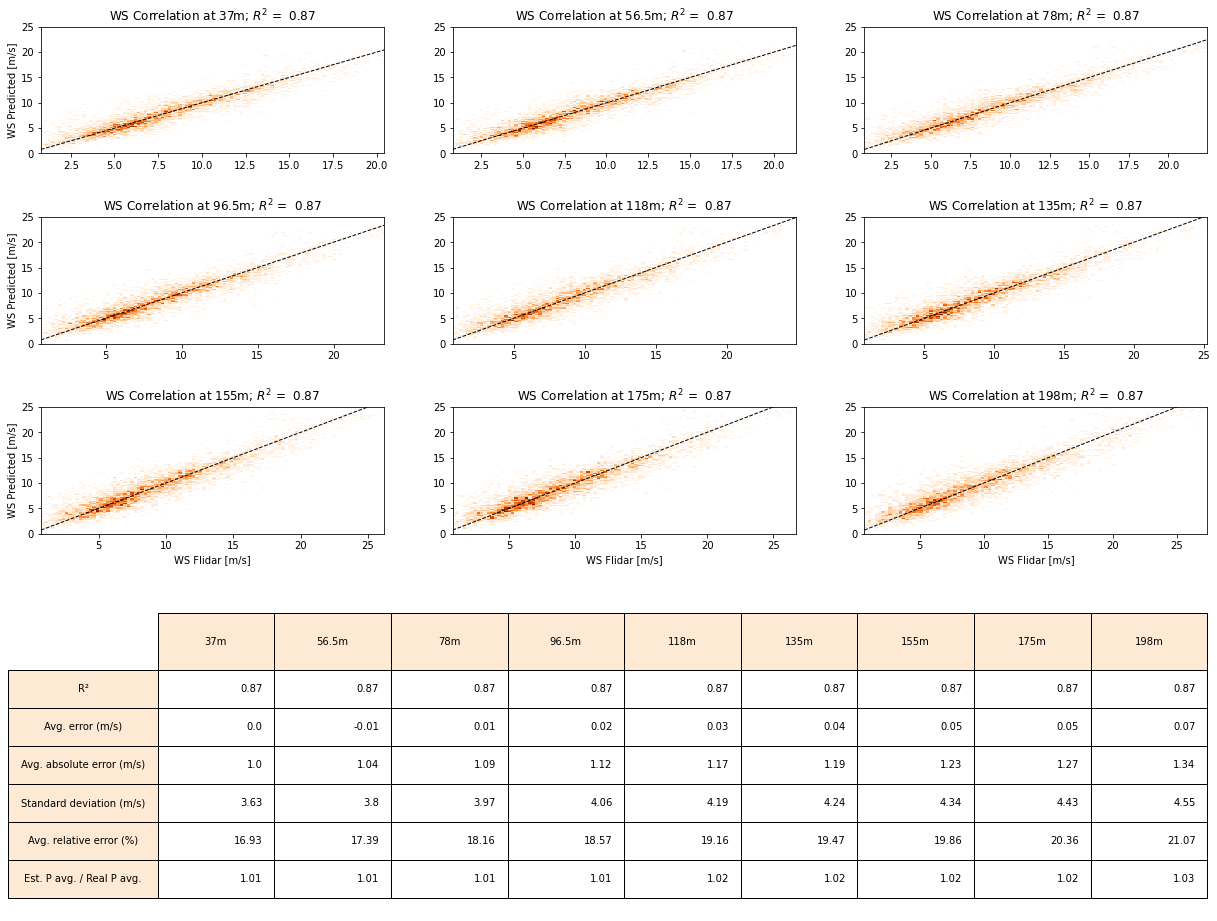

In [78]:
# Testing site TRE

df_X_train, df_X_test, df_X_test2, df_y_train, df_y_test, df_y_test2 = split(df_Xy_TRE, ratio)

gbm = CatBoostRegressor(iterations=1498, l2_leaf_reg=10, loss_function="MultiRMSE", learning_rate=0.2967860953365011, colsample_bylevel=0.09836322981422668, max_depth=14, random_strength=0.16923713290361092, boosting_type="Plain", bootstrap_type="MVS")
gbm.fit(df_X_train, df_y_train)
test_model(gbm, heights, ["global"], "No", df_X_test2, df_y_test2)

In [12]:
# Optimizing site NOY

df_X_train, df_X_test, df_X_test2, df_y_train, df_y_test, df_y_test2 = split(df_Xy_NOY, ratio)


def objective(trial):
    X_train = df_X_train
    X_val = df_X_test
    y_train = df_y_train
    y_val = df_y_test

    param = {
        "iterations" : trial.suggest_int("iterations", 1, 1500),
        "l2_leaf_reg" : trial.suggest_int("l2_leaf_reg", 2, 10),
        "loss_function" : trial.suggest_categorical("loss_function", ["MultiRMSE"]),
        "learning_rate" : trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "max_depth" : trial.suggest_int("max_depth", 1, 15),
        "random_strength" : trial.suggest_loguniform("random_strength", 0.0001, 10.0),
        "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }
    

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_uniform("subsample", 0.1, 1)

    gbm = catboost.CatBoostRegressor(**param, )

    gbm.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 0, early_stopping_rounds = 15)

    predictions = gbm.predict(X_val)
    RMSE = mean_squared_error(y_val, predictions)
    
    return RMSE

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 400, show_progress_bar = True)


print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-22 11:02:19,046] A new study created in memory with name: no-name-9aaf61c6-88e7-4ca6-94b0-5fa08ad75173
  0%|          | 1/400 [00:02<13:49,  2.08s/it]

[I 2022-08-22 11:02:21,125] Trial 0 finished with value: 17.55731290669755 and parameters: {'iterations': 503, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0012118277149573459, 'colsample_bylevel': 0.036762972318529416, 'max_depth': 12, 'random_strength': 3.555415298783789, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.22416453854581592}. Best is trial 0 with value: 17.55731290669755.


  0%|          | 2/400 [00:02<09:08,  1.38s/it]

[I 2022-08-22 11:02:22,013] Trial 1 finished with value: 6.092301326104763 and parameters: {'iterations': 514, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26047884625230694, 'colsample_bylevel': 0.06736876765936797, 'max_depth': 7, 'random_strength': 0.305568938361976, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3009443928636283}. Best is trial 1 with value: 6.092301326104763.


  1%|          | 3/400 [00:13<35:33,  5.37s/it]

[I 2022-08-22 11:02:32,138] Trial 2 finished with value: 16.904792518047962 and parameters: {'iterations': 237, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0010761552964581066, 'colsample_bylevel': 0.09644244338083621, 'max_depth': 15, 'random_strength': 0.027998515302444755, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 6.092301326104763.


  1%|          | 4/400 [00:15<27:26,  4.16s/it]

[I 2022-08-22 11:02:34,438] Trial 3 finished with value: 7.045186316056302 and parameters: {'iterations': 1142, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22884032715732402, 'colsample_bylevel': 0.04333491489028369, 'max_depth': 9, 'random_strength': 0.007056341950020745, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 6.092301326104763.


  1%|▏         | 5/400 [00:17<23:11,  3.52s/it]

[I 2022-08-22 11:02:36,831] Trial 4 finished with value: 8.963355172871927 and parameters: {'iterations': 1255, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.027376585530889876, 'colsample_bylevel': 0.08229248433485145, 'max_depth': 1, 'random_strength': 2.3851611668927655, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3745007517173702}. Best is trial 1 with value: 6.092301326104763.


  2%|▏         | 6/400 [00:24<29:51,  4.55s/it]

[I 2022-08-22 11:02:43,364] Trial 5 finished with value: 13.403114388476869 and parameters: {'iterations': 905, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.002722340648433503, 'colsample_bylevel': 0.06638974066354546, 'max_depth': 11, 'random_strength': 3.1178979584738094, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 6.092301326104763.


  2%|▏         | 7/400 [00:26<24:21,  3.72s/it]

[I 2022-08-22 11:02:45,379] Trial 6 finished with value: 11.135477495497353 and parameters: {'iterations': 1040, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.00481698028883663, 'colsample_bylevel': 0.06145184447764139, 'max_depth': 14, 'random_strength': 0.058878785592014524, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7394613937289289}. Best is trial 1 with value: 6.092301326104763.


  2%|▏         | 8/400 [00:37<38:52,  5.95s/it]

[I 2022-08-22 11:02:56,110] Trial 7 finished with value: 15.04386279483483 and parameters: {'iterations': 1296, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0010962219500266841, 'colsample_bylevel': 0.08576478307861565, 'max_depth': 9, 'random_strength': 0.36944411778479036, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.669822125656207}. Best is trial 1 with value: 6.092301326104763.


  2%|▏         | 9/400 [00:40<33:47,  5.19s/it]

[I 2022-08-22 11:02:59,613] Trial 8 finished with value: 16.82958458630647 and parameters: {'iterations': 1044, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0012362101337553087, 'colsample_bylevel': 0.04060912719678215, 'max_depth': 7, 'random_strength': 0.08153367637543785, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.44397550141560316}. Best is trial 1 with value: 6.092301326104763.


  2%|▎         | 10/400 [00:43<29:31,  4.54s/it]

[I 2022-08-22 11:03:02,719] Trial 9 finished with value: 8.102232240917383 and parameters: {'iterations': 1427, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.01554796294442737, 'colsample_bylevel': 0.07655494316079471, 'max_depth': 4, 'random_strength': 3.1856106337782846, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4141330187062934}. Best is trial 1 with value: 6.092301326104763.
[I 2022-08-22 11:03:02,819] Trial 10 finished with value: 17.374949766223214 and parameters: {'iterations': 25, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2722683459720878, 'colsample_bylevel': 0.011470094365686224, 'max_depth': 6, 'random_strength': 0.00019859909640200046, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.14885818020745312}. Best is trial 1 with value: 6.092301326104763.


  3%|▎         | 12/400 [00:45<17:49,  2.76s/it]

[I 2022-08-22 11:03:04,180] Trial 11 finished with value: 7.1563170459826715 and parameters: {'iterations': 626, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17723440957042513, 'colsample_bylevel': 0.04264612841054073, 'max_depth': 9, 'random_strength': 0.002361701962182413, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 6.092301326104763.


  3%|▎         | 13/400 [00:45<13:38,  2.12s/it]

[I 2022-08-22 11:03:04,383] Trial 12 finished with value: 16.01175857872435 and parameters: {'iterations': 460, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09363244183543262, 'colsample_bylevel': 0.019354443699764246, 'max_depth': 4, 'random_strength': 0.004083088177738488, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 6.092301326104763.


  4%|▎         | 14/400 [00:47<13:13,  2.05s/it]

[I 2022-08-22 11:03:06,267] Trial 13 finished with value: 7.209059817452295 and parameters: {'iterations': 803, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07271379660612222, 'colsample_bylevel': 0.05255811683618379, 'max_depth': 5, 'random_strength': 0.004615724052972626, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 6.092301326104763.


  4%|▍         | 15/400 [00:48<12:10,  1.90s/it]

[I 2022-08-22 11:03:07,747] Trial 14 finished with value: 10.93228779873537 and parameters: {'iterations': 339, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.05346256401189381, 'colsample_bylevel': 0.02940380894656806, 'max_depth': 10, 'random_strength': 0.26007708339669916, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.112242005033374}. Best is trial 1 with value: 6.092301326104763.


  4%|▍         | 16/400 [00:50<11:08,  1.74s/it]

[I 2022-08-22 11:03:09,083] Trial 15 finished with value: 6.922616271791231 and parameters: {'iterations': 704, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14213749325229916, 'colsample_bylevel': 0.053024966377477785, 'max_depth': 8, 'random_strength': 0.00022084440079173223, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9408441344392414}. Best is trial 1 with value: 6.092301326104763.


  4%|▍         | 17/400 [00:51<10:10,  1.59s/it]

[I 2022-08-22 11:03:10,313] Trial 16 finished with value: 7.562828275858893 and parameters: {'iterations': 626, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12671456669671943, 'colsample_bylevel': 0.07101315036357135, 'max_depth': 2, 'random_strength': 0.000556319710914576, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9355395263898759}. Best is trial 1 with value: 6.092301326104763.


  4%|▍         | 18/400 [00:51<07:55,  1.25s/it]

[I 2022-08-22 11:03:10,708] Trial 17 finished with value: 11.528920193681332 and parameters: {'iterations': 183, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.033305191091844995, 'colsample_bylevel': 0.05485155056198659, 'max_depth': 7, 'random_strength': 0.00011206828366218823, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.11093252905579867}. Best is trial 1 with value: 6.092301326104763.


  5%|▍         | 19/400 [00:53<08:10,  1.29s/it]

[I 2022-08-22 11:03:12,096] Trial 18 finished with value: 9.99066693017387 and parameters: {'iterations': 713, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.011940279834673608, 'colsample_bylevel': 0.05842410884686891, 'max_depth': 7, 'random_strength': 0.38259479375800404, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6820445178533033}. Best is trial 1 with value: 6.092301326104763.


  5%|▌         | 20/400 [00:56<12:56,  2.04s/it]

[I 2022-08-22 11:03:15,945] Trial 19 finished with value: 3.3757438855322395 and parameters: {'iterations': 876, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13570753670216254, 'colsample_bylevel': 0.09679881174899253, 'max_depth': 12, 'random_strength': 0.018574588012869642, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.923658269194154}. Best is trial 19 with value: 3.3757438855322395.


  5%|▌         | 21/400 [01:03<21:04,  3.34s/it]

[I 2022-08-22 11:03:22,351] Trial 20 finished with value: 2.639254552274142 and parameters: {'iterations': 889, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2925830673321043, 'colsample_bylevel': 0.09948930888021955, 'max_depth': 13, 'random_strength': 0.014184226588359413, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6394314747622823}. Best is trial 20 with value: 2.639254552274142.


  6%|▌         | 22/400 [01:09<26:40,  4.23s/it]

[I 2022-08-22 11:03:28,700] Trial 21 finished with value: 2.8196515997496854 and parameters: {'iterations': 830, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23952180454102476, 'colsample_bylevel': 0.095995631192449, 'max_depth': 13, 'random_strength': 0.01701001767171683, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6263894123054431}. Best is trial 20 with value: 2.639254552274142.


  6%|▌         | 23/400 [01:15<30:06,  4.79s/it]

[I 2022-08-22 11:03:34,800] Trial 22 finished with value: 3.9720563587336253 and parameters: {'iterations': 856, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09800252167157483, 'colsample_bylevel': 0.09867134409302214, 'max_depth': 13, 'random_strength': 0.015947155830732983, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6370723281461839}. Best is trial 20 with value: 2.639254552274142.


  6%|▌         | 24/400 [01:19<27:42,  4.42s/it]

[I 2022-08-22 11:03:38,358] Trial 23 finished with value: 5.205207184451774 and parameters: {'iterations': 972, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.047705570300887665, 'colsample_bylevel': 0.08978687813821586, 'max_depth': 13, 'random_strength': 0.0013578971781052682, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8089012837306429}. Best is trial 20 with value: 2.639254552274142.


  6%|▋         | 25/400 [01:29<37:55,  6.07s/it]

[I 2022-08-22 11:03:48,278] Trial 24 finished with value: 2.5308676330890822 and parameters: {'iterations': 1185, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29101950534623994, 'colsample_bylevel': 0.09085333429872254, 'max_depth': 15, 'random_strength': 0.011984290021276465, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5603101322248489}. Best is trial 24 with value: 2.5308676330890822.


  6%|▋         | 26/400 [01:35<38:18,  6.14s/it]

[I 2022-08-22 11:03:54,603] Trial 25 finished with value: 2.536653982275619 and parameters: {'iterations': 1152, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27640564492799324, 'colsample_bylevel': 0.0899211819295269, 'max_depth': 15, 'random_strength': 0.09318614753408486, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.14421316583567023}. Best is trial 24 with value: 2.5308676330890822.


  7%|▋         | 27/400 [01:38<32:17,  5.19s/it]

[I 2022-08-22 11:03:57,579] Trial 26 finished with value: 3.1057162342663513 and parameters: {'iterations': 1483, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2879820434443498, 'colsample_bylevel': 0.07900832405881172, 'max_depth': 15, 'random_strength': 0.10130605057477515, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5105797880511327}. Best is trial 24 with value: 2.5308676330890822.


  7%|▋         | 28/400 [01:43<30:54,  4.99s/it]

[I 2022-08-22 11:04:02,077] Trial 27 finished with value: 4.253661785241196 and parameters: {'iterations': 1169, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16230327465313282, 'colsample_bylevel': 0.08950535129945102, 'max_depth': 15, 'random_strength': 0.008940004838021914, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.333720132889548}. Best is trial 24 with value: 2.5308676330890822.


  7%|▋         | 29/400 [01:49<33:35,  5.43s/it]

[I 2022-08-22 11:04:08,557] Trial 28 finished with value: 8.43528686592728 and parameters: {'iterations': 1397, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0065453064101960645, 'colsample_bylevel': 0.0895421013715812, 'max_depth': 14, 'random_strength': 0.9847206151146882, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.4212217971819063}. Best is trial 24 with value: 2.5308676330890822.


  8%|▊         | 30/400 [01:52<28:43,  4.66s/it]

[I 2022-08-22 11:04:11,404] Trial 29 finished with value: 6.190580137261337 and parameters: {'iterations': 1145, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07037078673182127, 'colsample_bylevel': 0.0723567103012783, 'max_depth': 11, 'random_strength': 0.0010938382516528756, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.856763931564229}. Best is trial 24 with value: 2.5308676330890822.


  8%|▊         | 31/400 [01:57<29:53,  4.86s/it]

[I 2022-08-22 11:04:16,735] Trial 30 finished with value: 6.621981658586268 and parameters: {'iterations': 1268, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.026008886966764264, 'colsample_bylevel': 0.08349031725359855, 'max_depth': 14, 'random_strength': 9.68727269037156, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.2123256981966355}. Best is trial 24 with value: 2.5308676330890822.


  8%|▊         | 32/400 [02:03<31:44,  5.17s/it]

[I 2022-08-22 11:04:22,642] Trial 31 finished with value: 3.060569785563283 and parameters: {'iterations': 1016, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18813698529729772, 'colsample_bylevel': 0.09987899453208834, 'max_depth': 13, 'random_strength': 0.0638543668799345, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5648646362029826}. Best is trial 24 with value: 2.5308676330890822.


  8%|▊         | 33/400 [02:06<26:52,  4.39s/it]

[I 2022-08-22 11:04:25,215] Trial 32 finished with value: 3.277032217647706 and parameters: {'iterations': 937, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2867208821999333, 'colsample_bylevel': 0.09203010081381402, 'max_depth': 12, 'random_strength': 0.01269220651349193, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5315702050053523}. Best is trial 24 with value: 2.5308676330890822.


  8%|▊         | 34/400 [02:15<35:48,  5.87s/it]

[I 2022-08-22 11:04:34,533] Trial 33 finished with value: 2.816512373720898 and parameters: {'iterations': 1109, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1957648170661132, 'colsample_bylevel': 0.09394353162905536, 'max_depth': 14, 'random_strength': 0.03737978552093251, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5638392710049664}. Best is trial 24 with value: 2.5308676330890822.


  9%|▉         | 35/400 [02:30<51:49,  8.52s/it]

[I 2022-08-22 11:04:49,231] Trial 34 finished with value: 2.704581827957682 and parameters: {'iterations': 1108, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1795391026356291, 'colsample_bylevel': 0.09372042308322283, 'max_depth': 15, 'random_strength': 0.036607674103641206, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5108531743078406}. Best is trial 24 with value: 2.5308676330890822.


  9%|▉         | 36/400 [02:38<50:47,  8.37s/it]

[I 2022-08-22 11:04:57,258] Trial 35 finished with value: 4.084420520796917 and parameters: {'iterations': 1346, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.09648481632994367, 'colsample_bylevel': 0.08530888790314756, 'max_depth': 15, 'random_strength': 0.1377453817374496, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.49978912277607157}. Best is trial 24 with value: 2.5308676330890822.


  9%|▉         | 37/400 [02:43<44:09,  7.30s/it]

[I 2022-08-22 11:05:02,055] Trial 36 finished with value: 3.327956382759654 and parameters: {'iterations': 1213, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.297892109129846, 'colsample_bylevel': 0.07701817762443282, 'max_depth': 15, 'random_strength': 0.03020224827237223, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7527172423969357}. Best is trial 24 with value: 2.5308676330890822.


 10%|▉         | 38/400 [02:45<35:48,  5.93s/it]

[I 2022-08-22 11:05:04,805] Trial 37 finished with value: 5.265184786904357 and parameters: {'iterations': 1093, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11661643956601916, 'colsample_bylevel': 0.08298630075398739, 'max_depth': 12, 'random_strength': 0.14614056980074724, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.622648070654642}. Best is trial 24 with value: 2.5308676330890822.


 10%|▉         | 39/400 [02:52<36:19,  6.04s/it]

[I 2022-08-22 11:05:11,086] Trial 38 finished with value: 4.269777133738563 and parameters: {'iterations': 1221, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1977414532600673, 'colsample_bylevel': 0.08778120863654468, 'max_depth': 14, 'random_strength': 0.038406710822243485, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4700672200743315}. Best is trial 24 with value: 2.5308676330890822.


 10%|█         | 40/400 [02:55<31:31,  5.25s/it]

[I 2022-08-22 11:05:14,506] Trial 39 finished with value: 2.895577482209397 and parameters: {'iterations': 973, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21390244555792887, 'colsample_bylevel': 0.09365677921922841, 'max_depth': 11, 'random_strength': 0.005376224213951031, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 24 with value: 2.5308676330890822.


 10%|█         | 41/400 [03:03<35:46,  5.98s/it]

[I 2022-08-22 11:05:22,177] Trial 40 finished with value: 5.7890882130269326 and parameters: {'iterations': 1310, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0672762369343686, 'colsample_bylevel': 0.06631238416185568, 'max_depth': 15, 'random_strength': 0.0022518386918887593, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8329299044271437}. Best is trial 24 with value: 2.5308676330890822.


 10%|█         | 42/400 [03:06<31:22,  5.26s/it]

[I 2022-08-22 11:05:25,754] Trial 41 finished with value: 3.3775218101359417 and parameters: {'iterations': 1097, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1922596570264038, 'colsample_bylevel': 0.09331864126468682, 'max_depth': 14, 'random_strength': 0.034349222609531944, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5843982006799597}. Best is trial 24 with value: 2.5308676330890822.


 11%|█         | 43/400 [03:16<38:39,  6.50s/it]

[I 2022-08-22 11:05:35,140] Trial 42 finished with value: 2.807727904582709 and parameters: {'iterations': 1073, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1687220717969757, 'colsample_bylevel': 0.0991874783443557, 'max_depth': 14, 'random_strength': 0.04924476128110998, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.681050763029441}. Best is trial 24 with value: 2.5308676330890822.


 11%|█         | 44/400 [03:25<43:59,  7.41s/it]

[I 2022-08-22 11:05:44,694] Trial 43 finished with value: 2.7744675584703087 and parameters: {'iterations': 1038, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14807002216632772, 'colsample_bylevel': 0.09847832185728844, 'max_depth': 13, 'random_strength': 0.200680915918001, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6893730489188806}. Best is trial 24 with value: 2.5308676330890822.


 11%|█▏        | 45/400 [03:28<35:58,  6.08s/it]

[I 2022-08-22 11:05:47,659] Trial 44 finished with value: 4.348607399444049 and parameters: {'iterations': 1007, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11142612486362106, 'colsample_bylevel': 0.08128279628983542, 'max_depth': 12, 'random_strength': 1.2672186246842285, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7193353397078825}. Best is trial 24 with value: 2.5308676330890822.


 12%|█▏        | 46/400 [03:32<32:26,  5.50s/it]

[I 2022-08-22 11:05:51,806] Trial 45 finished with value: 3.1537526548065853 and parameters: {'iterations': 1205, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23154186192602536, 'colsample_bylevel': 0.08666207132024349, 'max_depth': 13, 'random_strength': 0.20948608343964129, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6205984825941462}. Best is trial 24 with value: 2.5308676330890822.


 12%|█▏        | 47/400 [03:36<28:32,  4.85s/it]

[I 2022-08-22 11:05:55,144] Trial 46 finished with value: 4.663111881294324 and parameters: {'iterations': 1334, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14561084296401328, 'colsample_bylevel': 0.07327799464538334, 'max_depth': 11, 'random_strength': 0.43936267370076326, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.2307023868439817}. Best is trial 24 with value: 2.5308676330890822.


 12%|█▏        | 48/400 [03:39<26:34,  4.53s/it]

[I 2022-08-22 11:05:58,922] Trial 47 finished with value: 15.371601009213574 and parameters: {'iterations': 764, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0024702649603873987, 'colsample_bylevel': 0.04827021018417255, 'max_depth': 15, 'random_strength': 0.6437195687951671, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 24 with value: 2.5308676330890822.


 12%|█▏        | 49/400 [03:42<22:52,  3.91s/it]

[I 2022-08-22 11:06:01,388] Trial 48 finished with value: 5.331828298157873 and parameters: {'iterations': 920, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.044872307175150616, 'colsample_bylevel': 0.0960800231736268, 'max_depth': 10, 'random_strength': 0.08245475690051862, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3667277762575175}. Best is trial 24 with value: 2.5308676330890822.


 12%|█▎        | 50/400 [03:48<27:22,  4.69s/it]

[I 2022-08-22 11:06:07,903] Trial 49 finished with value: 3.9020418009291435 and parameters: {'iterations': 1162, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07877633474914941, 'colsample_bylevel': 0.09131323454149025, 'max_depth': 13, 'random_strength': 0.007451829107768681, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8331337865787045}. Best is trial 24 with value: 2.5308676330890822.


 13%|█▎        | 51/400 [03:50<22:26,  3.86s/it]

[I 2022-08-22 11:06:09,812] Trial 50 finished with value: 7.554538860372621 and parameters: {'iterations': 1032, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23686853932097449, 'colsample_bylevel': 0.0355272310250657, 'max_depth': 15, 'random_strength': 0.022481738833723168, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.904727259149894}. Best is trial 24 with value: 2.5308676330890822.


 13%|█▎        | 52/400 [04:01<34:18,  5.91s/it]

[I 2022-08-22 11:06:20,530] Trial 51 finished with value: 2.795752578162176 and parameters: {'iterations': 1105, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16275848912800234, 'colsample_bylevel': 0.09838587872786213, 'max_depth': 14, 'random_strength': 0.05534258563971801, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6791408608709298}. Best is trial 24 with value: 2.5308676330890822.


 13%|█▎        | 53/400 [04:14<46:25,  8.03s/it]

[I 2022-08-22 11:06:33,489] Trial 52 finished with value: 2.8828432433540234 and parameters: {'iterations': 1256, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12582376315442836, 'colsample_bylevel': 0.09513648084679471, 'max_depth': 14, 'random_strength': 0.16778485315299507, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5114253053703094}. Best is trial 24 with value: 2.5308676330890822.


 14%|█▎        | 54/400 [04:30<1:00:55, 10.57s/it]

[I 2022-08-22 11:06:49,974] Trial 53 finished with value: 2.6053510750724063 and parameters: {'iterations': 1065, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16023090922624444, 'colsample_bylevel': 0.09897444355298968, 'max_depth': 15, 'random_strength': 0.009499183366426217, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6643532650402112}. Best is trial 24 with value: 2.5308676330890822.


 14%|█▍        | 55/400 [04:50<1:15:35, 13.15s/it]

[I 2022-08-22 11:07:09,144] Trial 54 finished with value: 2.1405749080089733 and parameters: {'iterations': 917, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24198379786807486, 'colsample_bylevel': 0.0998966353604634, 'max_depth': 15, 'random_strength': 0.01160245272492363, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6279225736689447}. Best is trial 54 with value: 2.1405749080089733.


 14%|█▍        | 56/400 [05:31<2:03:56, 21.62s/it]

[I 2022-08-22 11:07:50,527] Trial 55 finished with value: 3.1364818296521695 and parameters: {'iterations': 903, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2383562061875169, 'colsample_bylevel': 0.08666198961527918, 'max_depth': 15, 'random_strength': 0.002735172731223927, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 54 with value: 2.1405749080089733.


 14%|█▍        | 57/400 [05:39<1:40:36, 17.60s/it]

[I 2022-08-22 11:07:58,749] Trial 56 finished with value: 2.9374369144558674 and parameters: {'iterations': 786, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2954200728157357, 'colsample_bylevel': 0.09243682830188618, 'max_depth': 15, 'random_strength': 0.013363931862627952, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5940859730063466}. Best is trial 54 with value: 2.1405749080089733.


 14%|█▍        | 58/400 [05:41<1:12:50, 12.78s/it]

[I 2022-08-22 11:08:00,286] Trial 57 finished with value: 4.463836277269674 and parameters: {'iterations': 565, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22656856571868908, 'colsample_bylevel': 0.0799662905768696, 'max_depth': 14, 'random_strength': 0.00791128252789148, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.35759818624955575}. Best is trial 54 with value: 2.1405749080089733.


 15%|█▍        | 59/400 [05:47<1:01:54, 10.89s/it]

[I 2022-08-22 11:08:06,776] Trial 58 finished with value: 7.992824539571406 and parameters: {'iterations': 960, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.010857588244262884, 'colsample_bylevel': 0.09025177827019322, 'max_depth': 15, 'random_strength': 0.010760767227914374, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2649753636111806}. Best is trial 54 with value: 2.1405749080089733.


 15%|█▌        | 60/400 [05:49<45:43,  8.07s/it]  

[I 2022-08-22 11:08:08,261] Trial 59 finished with value: 8.31381502943106 and parameters: {'iterations': 715, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08316583494913611, 'colsample_bylevel': 0.09470448681072557, 'max_depth': 1, 'random_strength': 0.0033587267595665466, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7880306788813916}. Best is trial 54 with value: 2.1405749080089733.


 15%|█▌        | 61/400 [05:54<40:48,  7.22s/it]

[I 2022-08-22 11:08:13,501] Trial 60 finished with value: 4.665770184527325 and parameters: {'iterations': 858, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1121146754608218, 'colsample_bylevel': 0.08479975797470228, 'max_depth': 15, 'random_strength': 0.005240609613665299, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.017453624940348}. Best is trial 54 with value: 2.1405749080089733.


 16%|█▌        | 62/400 [06:02<42:21,  7.52s/it]

[I 2022-08-22 11:08:21,717] Trial 61 finished with value: 2.7811056765148603 and parameters: {'iterations': 1058, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14459013636177423, 'colsample_bylevel': 0.0996508702194118, 'max_depth': 13, 'random_strength': 0.020159069866674772, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6524522090821573}. Best is trial 54 with value: 2.1405749080089733.


 16%|█▌        | 63/400 [06:05<33:34,  5.98s/it]

[I 2022-08-22 11:08:24,094] Trial 62 finished with value: 3.15230368506295 and parameters: {'iterations': 998, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24667535178116365, 'colsample_bylevel': 0.09671398262140972, 'max_depth': 8, 'random_strength': 0.026689288909586564, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4298736281643206}. Best is trial 54 with value: 2.1405749080089733.


 16%|█▌        | 64/400 [06:18<45:56,  8.21s/it]

[I 2022-08-22 11:08:37,497] Trial 63 finished with value: 2.493308133146124 and parameters: {'iterations': 1173, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1613550018924426, 'colsample_bylevel': 0.09999117522638898, 'max_depth': 14, 'random_strength': 0.08793255761404324, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4999914131800345}. Best is trial 54 with value: 2.1405749080089733.


 16%|█▋        | 65/400 [06:22<38:16,  6.86s/it]

[I 2022-08-22 11:08:41,208] Trial 64 finished with value: 3.5284821730048717 and parameters: {'iterations': 1172, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17273609955510366, 'colsample_bylevel': 0.08876811147660768, 'max_depth': 14, 'random_strength': 0.08986166798166004, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.49309624796580637}. Best is trial 54 with value: 2.1405749080089733.


 16%|█▋        | 66/400 [06:26<33:12,  5.96s/it]

[I 2022-08-22 11:08:45,090] Trial 65 finished with value: 3.35121260514428 and parameters: {'iterations': 1129, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19624284511057563, 'colsample_bylevel': 0.09183834403821793, 'max_depth': 14, 'random_strength': 0.011984556975337693, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.539743657695598}. Best is trial 54 with value: 2.1405749080089733.


 17%|█▋        | 67/400 [06:34<37:28,  6.75s/it]

[I 2022-08-22 11:08:53,677] Trial 66 finished with value: 2.885218751982565 and parameters: {'iterations': 1359, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29249261086361544, 'colsample_bylevel': 0.0969580111765163, 'max_depth': 15, 'random_strength': 0.11099005854883831, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6041854691303691}. Best is trial 54 with value: 2.1405749080089733.


 17%|█▋        | 68/400 [06:40<35:39,  6.44s/it]

[I 2022-08-22 11:08:59,403] Trial 67 finished with value: 3.745689013725822 and parameters: {'iterations': 1276, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.06266212769249521, 'colsample_bylevel': 0.09471041649020881, 'max_depth': 12, 'random_strength': 0.05072783515560163, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 54 with value: 2.1405749080089733.


 17%|█▋        | 69/400 [06:40<25:14,  4.58s/it]

[I 2022-08-22 11:08:59,622] Trial 68 finished with value: 16.742781566273695 and parameters: {'iterations': 1210, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.10500049581729479, 'colsample_bylevel': 0.020756251763625694, 'max_depth': 6, 'random_strength': 0.01878908782247092, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.779315812375062}. Best is trial 54 with value: 2.1405749080089733.


 18%|█▊        | 70/400 [06:43<22:34,  4.10s/it]

[I 2022-08-22 11:09:02,623] Trial 69 finished with value: 3.637854986804194 and parameters: {'iterations': 1423, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2608387059149625, 'colsample_bylevel': 0.08847920949358319, 'max_depth': 14, 'random_strength': 0.0015382013760308938, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.45805032969271836}. Best is trial 54 with value: 2.1405749080089733.


 18%|█▊        | 71/400 [06:57<39:27,  7.20s/it]

[I 2022-08-22 11:09:17,034] Trial 70 finished with value: 3.37875664593663 and parameters: {'iterations': 813, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13408816182135283, 'colsample_bylevel': 0.09989247161751329, 'max_depth': 15, 'random_strength': 0.005824150403468099, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4004807614914754}. Best is trial 54 with value: 2.1405749080089733.


 18%|█▊        | 72/400 [07:03<36:11,  6.62s/it]

[I 2022-08-22 11:09:22,311] Trial 71 finished with value: 3.1692404540950254 and parameters: {'iterations': 878, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15443363866909215, 'colsample_bylevel': 0.09594249262055095, 'max_depth': 13, 'random_strength': 0.2865000137488558, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7335812866953391}. Best is trial 54 with value: 2.1405749080089733.


 18%|█▊        | 73/400 [07:13<41:58,  7.70s/it]

[I 2022-08-22 11:09:32,535] Trial 72 finished with value: 2.4645804356168406 and parameters: {'iterations': 1045, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21388007467169198, 'colsample_bylevel': 0.0975191182662072, 'max_depth': 13, 'random_strength': 0.07364542683470511, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6636892428196934}. Best is trial 54 with value: 2.1405749080089733.


 18%|█▊        | 74/400 [07:15<32:46,  6.03s/it]

[I 2022-08-22 11:09:34,672] Trial 73 finished with value: 5.572134007789931 and parameters: {'iterations': 955, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2038532529427712, 'colsample_bylevel': 0.0916696458253437, 'max_depth': 3, 'random_strength': 0.026812596181799406, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5455536697899768}. Best is trial 54 with value: 2.1405749080089733.


 19%|█▉        | 75/400 [07:28<43:18,  8.00s/it]

[I 2022-08-22 11:09:47,252] Trial 74 finished with value: 2.4582125425299584 and parameters: {'iterations': 1062, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17721858080896774, 'colsample_bylevel': 0.09723436797850042, 'max_depth': 14, 'random_strength': 0.062376767808511265, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6385056505020453}. Best is trial 54 with value: 2.1405749080089733.


 19%|█▉        | 76/400 [07:30<34:10,  6.33s/it]

[I 2022-08-22 11:09:49,688] Trial 75 finished with value: 3.57905260304423 and parameters: {'iterations': 1054, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24508053278880584, 'colsample_bylevel': 0.09726617759718184, 'max_depth': 12, 'random_strength': 0.07154282677354652, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6331863172812446}. Best is trial 54 with value: 2.1405749080089733.


 19%|█▉        | 77/400 [07:33<28:41,  5.33s/it]

[I 2022-08-22 11:09:52,689] Trial 76 finished with value: 7.99686958637712 and parameters: {'iterations': 1186, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.01958318791508284, 'colsample_bylevel': 0.0631400228090785, 'max_depth': 13, 'random_strength': 0.1289608417630543, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6602204095300234}. Best is trial 54 with value: 2.1405749080089733.


 20%|█▉        | 78/400 [07:38<28:38,  5.34s/it]

[I 2022-08-22 11:09:58,046] Trial 77 finished with value: 3.8133384097248513 and parameters: {'iterations': 1140, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.08993372226674151, 'colsample_bylevel': 0.09118286281381807, 'max_depth': 14, 'random_strength': 0.009811769766829272, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.1217926978259403}. Best is trial 54 with value: 2.1405749080089733.


 20%|█▉        | 79/400 [07:47<33:27,  6.25s/it]

[I 2022-08-22 11:10:06,437] Trial 78 finished with value: 2.6448447500180667 and parameters: {'iterations': 993, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20349556710655886, 'colsample_bylevel': 0.09962118010604287, 'max_depth': 13, 'random_strength': 0.0447103993550447, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7752508866203811}. Best is trial 54 with value: 2.1405749080089733.


 20%|██        | 80/400 [07:55<35:35,  6.67s/it]

[I 2022-08-22 11:10:14,086] Trial 79 finished with value: 2.638326797374674 and parameters: {'iterations': 906, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2999453546646156, 'colsample_bylevel': 0.0945867570476959, 'max_depth': 14, 'random_strength': 0.0036847966342048507, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7065138359271811}. Best is trial 54 with value: 2.1405749080089733.


 20%|██        | 81/400 [08:20<1:05:51, 12.39s/it]

[I 2022-08-22 11:10:39,808] Trial 80 finished with value: 4.138614839185171 and parameters: {'iterations': 935, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.12517528603971875, 'colsample_bylevel': 0.08420207728509901, 'max_depth': 14, 'random_strength': 0.004266220869024882, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7046703981314281}. Best is trial 54 with value: 2.1405749080089733.


 20%|██        | 82/400 [08:35<1:08:53, 13.00s/it]

[I 2022-08-22 11:10:54,229] Trial 81 finished with value: 2.657898776527247 and parameters: {'iterations': 901, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2644173358871313, 'colsample_bylevel': 0.09415625988989092, 'max_depth': 15, 'random_strength': 0.016266337369000218, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5958833668267637}. Best is trial 54 with value: 2.1405749080089733.


 21%|██        | 83/400 [08:48<1:08:33, 12.98s/it]

[I 2022-08-22 11:11:07,158] Trial 82 finished with value: 2.379985740222753 and parameters: {'iterations': 1070, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21223752322213463, 'colsample_bylevel': 0.09655132856893812, 'max_depth': 14, 'random_strength': 0.0006526208315542236, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.650319153588267}. Best is trial 54 with value: 2.1405749080089733.


 21%|██        | 84/400 [09:03<1:12:17, 13.73s/it]

[I 2022-08-22 11:11:22,633] Trial 83 finished with value: 2.3414222494092667 and parameters: {'iterations': 1230, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1724214955155203, 'colsample_bylevel': 0.09644308841895974, 'max_depth': 14, 'random_strength': 0.00039910252946938194, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5639421731901927}. Best is trial 54 with value: 2.1405749080089733.


 21%|██▏       | 85/400 [09:16<1:11:22, 13.59s/it]

[I 2022-08-22 11:11:35,916] Trial 84 finished with value: 2.4035729144627536 and parameters: {'iterations': 1237, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1741740336185715, 'colsample_bylevel': 0.09683799099252796, 'max_depth': 15, 'random_strength': 0.0004919742404815277, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9985825486111035}. Best is trial 54 with value: 2.1405749080089733.


 22%|██▏       | 86/400 [09:20<55:22, 10.58s/it]  

[I 2022-08-22 11:11:39,473] Trial 85 finished with value: 3.5846851312995116 and parameters: {'iterations': 1244, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1803177856278059, 'colsample_bylevel': 0.08857440448181689, 'max_depth': 14, 'random_strength': 0.00048158325055557054, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9002712481539625}. Best is trial 54 with value: 2.1405749080089733.


 22%|██▏       | 87/400 [09:30<54:29, 10.45s/it]

[I 2022-08-22 11:11:49,598] Trial 86 finished with value: 2.853775812213794 and parameters: {'iterations': 1314, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20658838349902534, 'colsample_bylevel': 0.0969585927290235, 'max_depth': 15, 'random_strength': 0.00043433141766014934, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.860446830374303}. Best is trial 54 with value: 2.1405749080089733.


 22%|██▏       | 88/400 [09:34<43:59,  8.46s/it]

[I 2022-08-22 11:11:53,429] Trial 87 finished with value: 3.4983293036597747 and parameters: {'iterations': 1226, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22495017947410295, 'colsample_bylevel': 0.09252225518797465, 'max_depth': 13, 'random_strength': 0.0002752657923499133, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.17513246009379485}. Best is trial 54 with value: 2.1405749080089733.


 22%|██▏       | 89/400 [09:40<40:05,  7.73s/it]

[I 2022-08-22 11:11:59,467] Trial 88 finished with value: 2.8204929783516 and parameters: {'iterations': 1370, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17496703109701428, 'colsample_bylevel': 0.08698647175834537, 'max_depth': 14, 'random_strength': 0.0006739935495836706, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 54 with value: 2.1405749080089733.


 22%|██▎       | 90/400 [09:52<47:05,  9.12s/it]

[I 2022-08-22 11:12:11,807] Trial 89 finished with value: 12.444461524416699 and parameters: {'iterations': 1129, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0016439436397339476, 'colsample_bylevel': 0.09036048338020276, 'max_depth': 15, 'random_strength': 0.0003283272121192875, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9821191193848117}. Best is trial 54 with value: 2.1405749080089733.


 23%|██▎       | 91/400 [09:57<40:26,  7.85s/it]

[I 2022-08-22 11:12:16,715] Trial 90 finished with value: 3.729928907635716 and parameters: {'iterations': 1498, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.13251160562638112, 'colsample_bylevel': 0.08193242758080388, 'max_depth': 14, 'random_strength': 0.00011738177971481738, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5828013530787493}. Best is trial 54 with value: 2.1405749080089733.


 23%|██▎       | 92/400 [10:16<57:22, 11.18s/it]

[I 2022-08-22 11:12:35,644] Trial 91 finished with value: 2.6352673269900575 and parameters: {'iterations': 1086, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1600911743386321, 'colsample_bylevel': 0.09728080400571107, 'max_depth': 15, 'random_strength': 0.0008340893068345878, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6569628768836875}. Best is trial 54 with value: 2.1405749080089733.


 23%|██▎       | 93/400 [10:35<1:09:16, 13.54s/it]

[I 2022-08-22 11:12:54,700] Trial 92 finished with value: 2.145986701536709 and parameters: {'iterations': 1290, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26555093168159305, 'colsample_bylevel': 0.09803443477236647, 'max_depth': 15, 'random_strength': 0.00016016175386559023, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5706908738760652}. Best is trial 54 with value: 2.1405749080089733.


 24%|██▎       | 94/400 [10:49<1:09:04, 13.54s/it]

[I 2022-08-22 11:13:08,252] Trial 93 finished with value: 2.3886414459440894 and parameters: {'iterations': 1279, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25631237581161886, 'colsample_bylevel': 0.095390213299446, 'max_depth': 15, 'random_strength': 0.00017595168965182616, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.566659056695817}. Best is trial 54 with value: 2.1405749080089733.


 24%|██▍       | 95/400 [11:01<1:07:20, 13.25s/it]

[I 2022-08-22 11:13:20,808] Trial 94 finished with value: 2.196962045241523 and parameters: {'iterations': 1285, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25369266594522955, 'colsample_bylevel': 0.09551297962358286, 'max_depth': 14, 'random_strength': 0.00016002255675619871, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.571805863247095}. Best is trial 54 with value: 2.1405749080089733.


 24%|██▍       | 96/400 [11:09<58:56, 11.63s/it]  

[I 2022-08-22 11:13:28,679] Trial 95 finished with value: 2.2841731987489085 and parameters: {'iterations': 1273, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21647888434676962, 'colsample_bylevel': 0.09516767762793386, 'max_depth': 13, 'random_strength': 0.000189513054562057, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5616867328062238}. Best is trial 54 with value: 2.1405749080089733.


 24%|██▍       | 97/400 [11:15<49:57,  9.89s/it]

[I 2022-08-22 11:13:34,510] Trial 96 finished with value: 2.597967417227108 and parameters: {'iterations': 1455, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2564112714591053, 'colsample_bylevel': 0.09530446323083983, 'max_depth': 13, 'random_strength': 0.00016378199403228706, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5758604667647829}. Best is trial 54 with value: 2.1405749080089733.


 24%|██▍       | 98/400 [11:18<39:28,  7.84s/it]

[I 2022-08-22 11:13:37,566] Trial 97 finished with value: 2.8134105976824397 and parameters: {'iterations': 1385, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21560183789713053, 'colsample_bylevel': 0.09284338463377458, 'max_depth': 10, 'random_strength': 0.00016463288936037786, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.617094339557259}. Best is trial 54 with value: 2.1405749080089733.


 25%|██▍       | 99/400 [11:25<37:25,  7.46s/it]

[I 2022-08-22 11:13:44,134] Trial 98 finished with value: 7.528460559766518 and parameters: {'iterations': 1286, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.006440583049055484, 'colsample_bylevel': 0.0980101116141349, 'max_depth': 12, 'random_strength': 0.00010241970153908084, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5666291433099379}. Best is trial 54 with value: 2.1405749080089733.


 25%|██▌       | 100/400 [11:32<37:53,  7.58s/it]

[I 2022-08-22 11:13:51,984] Trial 99 finished with value: 2.5761417819734405 and parameters: {'iterations': 1306, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18723052063488868, 'colsample_bylevel': 0.0934441801774347, 'max_depth': 13, 'random_strength': 0.0003433635565798117, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5309260878911841}. Best is trial 54 with value: 2.1405749080089733.


 25%|██▌       | 101/400 [12:53<2:26:43, 29.44s/it]

[I 2022-08-22 11:15:12,451] Trial 100 finished with value: 2.712526513409354 and parameters: {'iterations': 1407, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22664288838895838, 'colsample_bylevel': 0.09587339175360074, 'max_depth': 14, 'random_strength': 0.00023638498641970036, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6236866231969916}. Best is trial 54 with value: 2.1405749080089733.


 26%|██▌       | 102/400 [13:05<2:00:53, 24.34s/it]

[I 2022-08-22 11:15:24,886] Trial 101 finished with value: 2.2312794097287654 and parameters: {'iterations': 1244, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26122333841562606, 'colsample_bylevel': 0.09968004238777739, 'max_depth': 14, 'random_strength': 0.00014473580741230577, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5009237182987212}. Best is trial 54 with value: 2.1405749080089733.


 26%|██▌       | 103/400 [13:20<1:46:14, 21.46s/it]

[I 2022-08-22 11:15:39,633] Trial 102 finished with value: 2.274554925951265 and parameters: {'iterations': 1248, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24244340272385173, 'colsample_bylevel': 0.09759955095682961, 'max_depth': 14, 'random_strength': 0.00014544478690896182, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5241950570879726}. Best is trial 54 with value: 2.1405749080089733.


 26%|██▌       | 104/400 [13:39<1:41:23, 20.55s/it]

[I 2022-08-22 11:15:58,061] Trial 103 finished with value: 2.3205195025344016 and parameters: {'iterations': 1259, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2635111315711765, 'colsample_bylevel': 0.09564650950418982, 'max_depth': 15, 'random_strength': 0.0001520137707189119, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.47920103496183863}. Best is trial 54 with value: 2.1405749080089733.


 26%|██▋       | 105/400 [13:52<1:31:14, 18.56s/it]

[I 2022-08-22 11:16:11,965] Trial 104 finished with value: 2.2392719146771913 and parameters: {'iterations': 1335, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25928682156877053, 'colsample_bylevel': 0.09483786910573204, 'max_depth': 15, 'random_strength': 0.00015746083402481934, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5238842430475988}. Best is trial 54 with value: 2.1405749080089733.


 26%|██▋       | 106/400 [14:06<1:23:34, 17.06s/it]

[I 2022-08-22 11:16:25,523] Trial 105 finished with value: 2.572353349684157 and parameters: {'iterations': 1262, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2618663455999212, 'colsample_bylevel': 0.09389849955617208, 'max_depth': 15, 'random_strength': 0.0001527200489981168, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.47377193488240654}. Best is trial 54 with value: 2.1405749080089733.


 27%|██▋       | 107/400 [14:14<1:09:55, 14.32s/it]

[I 2022-08-22 11:16:33,449] Trial 106 finished with value: 2.488398989442287 and parameters: {'iterations': 1328, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2396692017291416, 'colsample_bylevel': 0.09001672173549177, 'max_depth': 15, 'random_strength': 0.00013067747001947817, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5232935599803967}. Best is trial 54 with value: 2.1405749080089733.


 27%|██▋       | 108/400 [14:16<51:40, 10.62s/it]  

[I 2022-08-22 11:16:35,429] Trial 107 finished with value: 5.844715734184234 and parameters: {'iterations': 1349, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2640463354522805, 'colsample_bylevel': 0.04702820888818349, 'max_depth': 14, 'random_strength': 0.0002105788442057062, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5537362299576463}. Best is trial 54 with value: 2.1405749080089733.


 27%|██▋       | 109/400 [14:23<45:54,  9.46s/it]

[I 2022-08-22 11:16:42,206] Trial 108 finished with value: 2.8610014889501034 and parameters: {'iterations': 1445, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25303047932303635, 'colsample_bylevel': 0.08583327917565764, 'max_depth': 15, 'random_strength': 0.00028744373798904733, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.48385594341626614}. Best is trial 54 with value: 2.1405749080089733.


 28%|██▊       | 110/400 [14:26<36:38,  7.58s/it]

[I 2022-08-22 11:16:45,388] Trial 109 finished with value: 2.769134730882676 and parameters: {'iterations': 1295, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2205526239448332, 'colsample_bylevel': 0.09537550190581581, 'max_depth': 9, 'random_strength': 0.0001960826363502464, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.44301098779968984}. Best is trial 54 with value: 2.1405749080089733.


 28%|██▊       | 111/400 [14:31<33:40,  6.99s/it]

[I 2022-08-22 11:16:51,003] Trial 110 finished with value: 2.6337908791797195 and parameters: {'iterations': 1194, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2993511613050298, 'colsample_bylevel': 0.09272086366387489, 'max_depth': 14, 'random_strength': 0.00013568574516229, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.520775069492638}. Best is trial 54 with value: 2.1405749080089733.


 28%|██▊       | 112/400 [14:50<49:28, 10.31s/it]

[I 2022-08-22 11:17:09,052] Trial 111 finished with value: 2.2170755497677335 and parameters: {'iterations': 1240, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2691676292226124, 'colsample_bylevel': 0.09797979101049499, 'max_depth': 15, 'random_strength': 0.00038290752077406757, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5528132679292262}. Best is trial 54 with value: 2.1405749080089733.


 28%|██▊       | 113/400 [15:10<1:03:50, 13.35s/it]

[I 2022-08-22 11:17:29,488] Trial 112 finished with value: 2.1824704869635356 and parameters: {'iterations': 1285, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2634942961976631, 'colsample_bylevel': 0.09830645006527183, 'max_depth': 15, 'random_strength': 0.0003791750248389741, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5560367350790667}. Best is trial 54 with value: 2.1405749080089733.


 28%|██▊       | 114/400 [15:28<1:09:44, 14.63s/it]

[I 2022-08-22 11:17:47,111] Trial 113 finished with value: 2.228692616963783 and parameters: {'iterations': 1336, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20066276827030857, 'colsample_bylevel': 0.09978900942558142, 'max_depth': 15, 'random_strength': 0.0007006823540935828, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.534723219491069}. Best is trial 54 with value: 2.1405749080089733.


 29%|██▉       | 115/400 [15:32<55:00, 11.58s/it]  

[I 2022-08-22 11:17:51,581] Trial 114 finished with value: 3.916205261061497 and parameters: {'iterations': 346, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1899367833434002, 'colsample_bylevel': 0.09867973962030349, 'max_depth': 15, 'random_strength': 0.0003833440847732174, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5443911054615527}. Best is trial 54 with value: 2.1405749080089733.


 29%|██▉       | 116/400 [15:36<44:13,  9.34s/it]

[I 2022-08-22 11:17:55,705] Trial 115 finished with value: 3.7392943266349112 and parameters: {'iterations': 1381, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2730918355604565, 'colsample_bylevel': 0.0985278630722374, 'max_depth': 15, 'random_strength': 0.0002535752210922144, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5018898374613145}. Best is trial 54 with value: 2.1405749080089733.


 29%|██▉       | 117/400 [15:50<50:59, 10.81s/it]

[I 2022-08-22 11:18:09,942] Trial 116 finished with value: 2.305063125334601 and parameters: {'iterations': 1334, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.15079316789776465, 'colsample_bylevel': 0.09943846834083894, 'max_depth': 15, 'random_strength': 0.00010022682153564087, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 54 with value: 2.1405749080089733.


 30%|██▉       | 118/400 [16:03<53:19, 11.35s/it]

[I 2022-08-22 11:18:22,535] Trial 117 finished with value: 2.2815903352151863 and parameters: {'iterations': 1335, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14526019452213773, 'colsample_bylevel': 0.09968899766576397, 'max_depth': 15, 'random_strength': 0.00010912950023627095, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 54 with value: 2.1405749080089733.


 30%|██▉       | 119/400 [16:16<54:53, 11.72s/it]

[I 2022-08-22 11:18:35,129] Trial 118 finished with value: 2.3133528854828573 and parameters: {'iterations': 1338, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.14626198305142996, 'colsample_bylevel': 0.09992018457506834, 'max_depth': 15, 'random_strength': 0.00010399347755698395, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 54 with value: 2.1405749080089733.


 30%|███       | 120/400 [18:04<3:10:40, 40.86s/it]

[I 2022-08-22 11:20:23,974] Trial 119 finished with value: 4.290738382645553 and parameters: {'iterations': 1314, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0385617734781239, 'colsample_bylevel': 0.0981744103761131, 'max_depth': 15, 'random_strength': 0.0002076699793343607, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 54 with value: 2.1405749080089733.


 30%|███       | 121/400 [18:13<2:24:50, 31.15s/it]

[I 2022-08-22 11:20:32,471] Trial 120 finished with value: 2.8270616808290883 and parameters: {'iterations': 1458, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.11591850283506151, 'colsample_bylevel': 0.09208823039166086, 'max_depth': 15, 'random_strength': 0.0003072797755270202, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 54 with value: 2.1405749080089733.


 30%|███       | 122/400 [18:25<1:58:27, 25.57s/it]

[I 2022-08-22 11:20:45,009] Trial 121 finished with value: 2.318024051300034 and parameters: {'iterations': 1344, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1459933648826502, 'colsample_bylevel': 0.09980504642294356, 'max_depth': 15, 'random_strength': 0.00010346272070684896, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 54 with value: 2.1405749080089733.


 31%|███       | 123/400 [18:40<1:42:29, 22.20s/it]

[I 2022-08-22 11:20:59,349] Trial 122 finished with value: 2.1271664110795756 and parameters: {'iterations': 1394, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20096636098900517, 'colsample_bylevel': 0.09956170060594835, 'max_depth': 15, 'random_strength': 0.00012826372423886163, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 31%|███       | 124/400 [18:50<1:25:59, 18.69s/it]

[I 2022-08-22 11:21:09,865] Trial 123 finished with value: 2.1729263463047994 and parameters: {'iterations': 1382, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.230216932549372, 'colsample_bylevel': 0.09833589201584576, 'max_depth': 14, 'random_strength': 0.00012964272946331323, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 32%|███▏      | 126/400 [18:57<48:24, 10.60s/it]  

[I 2022-08-22 11:21:16,484] Trial 124 finished with value: 2.1950488380986872 and parameters: {'iterations': 1413, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23471830023893883, 'colsample_bylevel': 0.09397472382353336, 'max_depth': 14, 'random_strength': 0.0002122223318531648, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.
[I 2022-08-22 11:21:16,651] Trial 125 finished with value: 16.774231073183994 and parameters: {'iterations': 1397, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2370016651082805, 'colsample_bylevel': 0.011681545625985716, 'max_depth': 14, 'random_strength': 0.00012806123929914127, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 32%|███▏      | 127/400 [19:01<39:40,  8.72s/it]

[I 2022-08-22 11:21:20,989] Trial 126 finished with value: 3.6343153250488722 and parameters: {'iterations': 1409, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19216629236139296, 'colsample_bylevel': 0.09805136243547943, 'max_depth': 14, 'random_strength': 0.00025607174524067697, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 32%|███▏      | 128/400 [19:08<36:30,  8.05s/it]

[I 2022-08-22 11:21:27,489] Trial 127 finished with value: 2.2889987881882807 and parameters: {'iterations': 1436, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29295394805634006, 'colsample_bylevel': 0.09369148372215363, 'max_depth': 14, 'random_strength': 0.00013880968703262168, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.
[I 2022-08-22 11:21:27,561] Trial 128 finished with value: 14.608093308880692 and parameters: {'iterations': 14, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2005847360882178, 'colsample_bylevel': 0.03344135273380014, 'max_depth': 15, 'random_strength': 0.0005675897972804503, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 32%|███▎      | 130/400 [19:16<27:51,  6.19s/it]

[I 2022-08-22 11:21:35,515] Trial 129 finished with value: 2.366548423302831 and parameters: {'iterations': 1366, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23573436025125774, 'colsample_bylevel': 0.09784097123193564, 'max_depth': 14, 'random_strength': 0.0009523441360847697, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 33%|███▎      | 131/400 [19:23<28:23,  6.33s/it]

[I 2022-08-22 11:21:42,289] Trial 130 finished with value: 2.2672481673247935 and parameters: {'iterations': 1469, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27524865370796986, 'colsample_bylevel': 0.09094814421996358, 'max_depth': 15, 'random_strength': 0.00023002027178682568, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 33%|███▎      | 132/400 [19:29<28:43,  6.43s/it]

[I 2022-08-22 11:21:48,990] Trial 131 finished with value: 2.1783728314074224 and parameters: {'iterations': 1492, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29859788956230915, 'colsample_bylevel': 0.09100210492765994, 'max_depth': 15, 'random_strength': 0.00022228758448875624, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 33%|███▎      | 133/400 [19:35<27:51,  6.26s/it]

[I 2022-08-22 11:21:54,790] Trial 132 finished with value: 2.408379454209281 and parameters: {'iterations': 1480, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.272099672078695, 'colsample_bylevel': 0.0907089256133288, 'max_depth': 15, 'random_strength': 0.00023467737812167433, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 34%|███▎      | 134/400 [19:39<24:45,  5.59s/it]

[I 2022-08-22 11:21:58,646] Trial 133 finished with value: 3.1619647385134817 and parameters: {'iterations': 1467, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2301085555664402, 'colsample_bylevel': 0.09414861790114382, 'max_depth': 5, 'random_strength': 0.000340815346070623, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 34%|███▍      | 135/400 [19:48<28:21,  6.42s/it]

[I 2022-08-22 11:22:07,160] Trial 134 finished with value: 2.3085811662717903 and parameters: {'iterations': 1426, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2759098064521168, 'colsample_bylevel': 0.08867508446759005, 'max_depth': 15, 'random_strength': 0.00021224782782611125, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 34%|███▍      | 136/400 [19:54<28:19,  6.44s/it]

[I 2022-08-22 11:22:13,640] Trial 135 finished with value: 2.3469452399421638 and parameters: {'iterations': 1493, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20120000756457654, 'colsample_bylevel': 0.09140440227481271, 'max_depth': 14, 'random_strength': 0.0001819080308913942, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 34%|███▍      | 137/400 [19:59<26:26,  6.03s/it]

[I 2022-08-22 11:22:18,693] Trial 136 finished with value: 2.570876443954163 and parameters: {'iterations': 1413, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24764320806197837, 'colsample_bylevel': 0.09634255721412674, 'max_depth': 14, 'random_strength': 0.001414327197064804, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 34%|███▍      | 138/400 [20:05<26:17,  6.02s/it]

[I 2022-08-22 11:22:24,685] Trial 137 finished with value: 2.4339981577732814 and parameters: {'iterations': 1383, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2867783282809517, 'colsample_bylevel': 0.0929572630943601, 'max_depth': 15, 'random_strength': 0.00028716664683881487, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 35%|███▍      | 139/400 [20:08<22:33,  5.18s/it]

[I 2022-08-22 11:22:27,882] Trial 138 finished with value: 2.6149671808241077 and parameters: {'iterations': 1441, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2292053777141594, 'colsample_bylevel': 0.09760214267854073, 'max_depth': 8, 'random_strength': 0.00043042625763914914, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 35%|███▌      | 140/400 [20:10<17:35,  4.06s/it]

[I 2022-08-22 11:22:29,290] Trial 139 finished with value: 5.347700745067292 and parameters: {'iterations': 626, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29365865886503734, 'colsample_bylevel': 0.05793510827190021, 'max_depth': 15, 'random_strength': 0.0001521760311104544, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 35%|███▌      | 141/400 [20:13<16:21,  3.79s/it]

[I 2022-08-22 11:22:32,440] Trial 140 finished with value: 5.835566811433008 and parameters: {'iterations': 1382, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18522046572276685, 'colsample_bylevel': 0.09485260173501064, 'max_depth': 2, 'random_strength': 0.0006858400573492448, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 36%|███▌      | 142/400 [20:26<27:53,  6.49s/it]

[I 2022-08-22 11:22:45,257] Trial 141 finished with value: 2.1910166352137623 and parameters: {'iterations': 1306, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20793561021767773, 'colsample_bylevel': 0.09962779374868717, 'max_depth': 15, 'random_strength': 0.00012608829841391617, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 36%|███▌      | 143/400 [20:39<36:03,  8.42s/it]

[I 2022-08-22 11:22:58,205] Trial 142 finished with value: 2.222372151491532 and parameters: {'iterations': 1307, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21323002960620446, 'colsample_bylevel': 0.09778410799285113, 'max_depth': 15, 'random_strength': 0.00013314259017788176, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 36%|███▌      | 144/400 [20:45<32:49,  7.69s/it]

[I 2022-08-22 11:23:04,203] Trial 143 finished with value: 2.670196313896677 and parameters: {'iterations': 1314, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19888725671397672, 'colsample_bylevel': 0.09601308738690192, 'max_depth': 15, 'random_strength': 0.00017883221974130235, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 36%|███▋      | 145/400 [20:45<23:13,  5.46s/it]

[I 2022-08-22 11:23:04,449] Trial 144 finished with value: 7.135294845481427 and parameters: {'iterations': 66, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21834078290903552, 'colsample_bylevel': 0.09355662156520508, 'max_depth': 15, 'random_strength': 0.0002430681022186367, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 36%|███▋      | 146/400 [20:57<32:09,  7.59s/it]

[I 2022-08-22 11:23:17,025] Trial 145 finished with value: 2.258424966186352 and parameters: {'iterations': 1366, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16636430765251126, 'colsample_bylevel': 0.09985029796642966, 'max_depth': 15, 'random_strength': 0.00013288938491712047, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 37%|███▋      | 147/400 [21:17<46:56, 11.13s/it]

[I 2022-08-22 11:23:36,425] Trial 146 finished with value: 4.2461048952083 and parameters: {'iterations': 1294, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.16127215557369337, 'colsample_bylevel': 0.06922849914469151, 'max_depth': 15, 'random_strength': 0.0001362798047396156, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 37%|███▋      | 148/400 [21:25<43:11, 10.28s/it]

[I 2022-08-22 11:23:44,722] Trial 147 finished with value: 2.382071130631324 and parameters: {'iterations': 1210, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1829891419103066, 'colsample_bylevel': 0.0997419771506361, 'max_depth': 14, 'random_strength': 0.00017208015456878574, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 37%|███▋      | 149/400 [21:39<46:50, 11.20s/it]

[I 2022-08-22 11:23:58,058] Trial 148 finished with value: 2.3133033806950296 and parameters: {'iterations': 1363, 'l2_leaf_reg': 9, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22044526705502737, 'colsample_bylevel': 0.09820547605711255, 'max_depth': 15, 'random_strength': 0.0003426164986000845, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 122 with value: 2.1271664110795756.


 38%|███▊      | 150/400 [21:49<45:10, 10.84s/it]

[I 2022-08-22 11:24:08,064] Trial 149 finished with value: 2.1151661883483297 and parameters: {'iterations': 1296, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25053552919654465, 'colsample_bylevel': 0.09692361777866015, 'max_depth': 15, 'random_strength': 0.00012488955332862024, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 149 with value: 2.1151661883483297.


 38%|███▊      | 151/400 [21:56<41:19,  9.96s/it]

[I 2022-08-22 11:24:15,956] Trial 150 finished with value: 1.995189848592105 and parameters: {'iterations': 1297, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2996474030489232, 'colsample_bylevel': 0.09602378685382379, 'max_depth': 14, 'random_strength': 0.00019087874582060356, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 38%|███▊      | 152/400 [22:03<37:11,  9.00s/it]

[I 2022-08-22 11:24:22,716] Trial 151 finished with value: 2.3596567311296357 and parameters: {'iterations': 1290, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25315260340015155, 'colsample_bylevel': 0.09645785526919748, 'max_depth': 14, 'random_strength': 0.0001955732361975101, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 38%|███▊      | 153/400 [22:11<35:40,  8.67s/it]

[I 2022-08-22 11:24:30,611] Trial 152 finished with value: 2.1832936965759555 and parameters: {'iterations': 1242, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2969159780551303, 'colsample_bylevel': 0.0947624807650131, 'max_depth': 14, 'random_strength': 0.0002845465871800478, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 38%|███▊      | 154/400 [22:19<34:54,  8.51s/it]

[I 2022-08-22 11:24:38,769] Trial 153 finished with value: 2.1934095955723323 and parameters: {'iterations': 1239, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29467471462239203, 'colsample_bylevel': 0.09774325455402935, 'max_depth': 14, 'random_strength': 6.5705270546583785, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 39%|███▉      | 155/400 [22:24<30:18,  7.42s/it]

[I 2022-08-22 11:24:43,639] Trial 154 finished with value: 2.514827130714044 and parameters: {'iterations': 1268, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29475225424589147, 'colsample_bylevel': 0.09627650410723354, 'max_depth': 14, 'random_strength': 6.744220296924841, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 39%|███▉      | 156/400 [22:33<31:33,  7.76s/it]

[I 2022-08-22 11:24:52,193] Trial 155 finished with value: 2.2227458048032727 and parameters: {'iterations': 1225, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29773262935535655, 'colsample_bylevel': 0.09754747295000164, 'max_depth': 14, 'random_strength': 0.00047374995884720095, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 39%|███▉      | 157/400 [22:38<28:48,  7.12s/it]

[I 2022-08-22 11:24:57,801] Trial 156 finished with value: 6.733374084099818 and parameters: {'iterations': 1247, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.012138492960904013, 'colsample_bylevel': 0.09432611410308041, 'max_depth': 13, 'random_strength': 0.0004282763914324243, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 40%|███▉      | 158/400 [22:46<29:21,  7.28s/it]

[I 2022-08-22 11:25:05,457] Trial 157 finished with value: 2.3345492889837747 and parameters: {'iterations': 1201, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24150424740457843, 'colsample_bylevel': 0.09749780844969744, 'max_depth': 14, 'random_strength': 0.00029124160652581235, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 40%|███▉      | 159/400 [22:50<25:46,  6.42s/it]

[I 2022-08-22 11:25:09,872] Trial 158 finished with value: 2.3931777891717454 and parameters: {'iterations': 1168, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2966799075659107, 'colsample_bylevel': 0.09340672086995688, 'max_depth': 14, 'random_strength': 0.6809489579559289, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 40%|████      | 160/400 [22:54<22:47,  5.70s/it]

[I 2022-08-22 11:25:13,884] Trial 159 finished with value: 2.5725284642453676 and parameters: {'iterations': 1225, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2988243716758391, 'colsample_bylevel': 0.09545855665675002, 'max_depth': 13, 'random_strength': 0.0005691301731141428, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 40%|████      | 161/400 [23:00<22:21,  5.61s/it]

[I 2022-08-22 11:25:19,300] Trial 160 finished with value: 2.4326361374374037 and parameters: {'iterations': 1295, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23113786080402168, 'colsample_bylevel': 0.09156143259861858, 'max_depth': 14, 'random_strength': 2.811310717471413, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 40%|████      | 162/400 [23:13<31:24,  7.92s/it]

[I 2022-08-22 11:25:32,592] Trial 161 finished with value: 2.242282048703164 and parameters: {'iterations': 1278, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20621999554243445, 'colsample_bylevel': 0.09792362959953191, 'max_depth': 15, 'random_strength': 0.0007880249497423046, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 41%|████      | 163/400 [23:20<30:05,  7.62s/it]

[I 2022-08-22 11:25:39,511] Trial 162 finished with value: 2.432554581117019 and parameters: {'iterations': 1314, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2573382576564389, 'colsample_bylevel': 0.09741472577464352, 'max_depth': 15, 'random_strength': 1.455481455459975, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 41%|████      | 164/400 [23:25<27:22,  6.96s/it]

[I 2022-08-22 11:25:44,942] Trial 163 finished with value: 2.5826461532918037 and parameters: {'iterations': 1404, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2149197116107166, 'colsample_bylevel': 0.09575266112956526, 'max_depth': 14, 'random_strength': 0.0005077494537698417, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 41%|████▏     | 165/400 [23:36<31:44,  8.10s/it]

[I 2022-08-22 11:25:55,706] Trial 164 finished with value: 2.2411691182936275 and parameters: {'iterations': 1230, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26393200565292274, 'colsample_bylevel': 0.09853634364314638, 'max_depth': 15, 'random_strength': 0.001962085657963365, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 42%|████▏     | 166/400 [23:41<27:26,  7.04s/it]

[I 2022-08-22 11:26:00,260] Trial 165 finished with value: 3.067573482536958 and parameters: {'iterations': 490, 'l2_leaf_reg': 2, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23539579823942336, 'colsample_bylevel': 0.09984555481655878, 'max_depth': 14, 'random_strength': 0.0002642790679914755, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 42%|████▏     | 167/400 [23:50<29:48,  7.67s/it]

[I 2022-08-22 11:26:09,419] Trial 166 finished with value: 2.227417439049555 and parameters: {'iterations': 1316, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29939191617998684, 'colsample_bylevel': 0.09289089133596391, 'max_depth': 15, 'random_strength': 0.0003800234421460306, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 42%|████▏     | 168/400 [23:58<30:30,  7.89s/it]

[I 2022-08-22 11:26:17,812] Trial 167 finished with value: 2.2223765716177297 and parameters: {'iterations': 1275, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2986721150851954, 'colsample_bylevel': 0.0925321576833617, 'max_depth': 15, 'random_strength': 0.00034367192848958793, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 42%|████▏     | 169/400 [24:04<28:25,  7.38s/it]

[I 2022-08-22 11:26:24,011] Trial 168 finished with value: 2.188117052019647 and parameters: {'iterations': 1263, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2574986208843547, 'colsample_bylevel': 0.09526399283027315, 'max_depth': 14, 'random_strength': 0.0002027022526303933, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 42%|████▎     | 170/400 [25:14<1:39:48, 26.04s/it]

[I 2022-08-22 11:27:33,578] Trial 169 finished with value: 5.433061835842308 and parameters: {'iterations': 1271, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.029197315030308854, 'colsample_bylevel': 0.08887932948538889, 'max_depth': 15, 'random_strength': 0.00020371851604664205, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 43%|████▎     | 171/400 [25:22<1:18:14, 20.50s/it]

[I 2022-08-22 11:27:41,158] Trial 170 finished with value: 2.1777702921769855 and parameters: {'iterations': 1259, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2543261537885825, 'colsample_bylevel': 0.09482324029349802, 'max_depth': 14, 'random_strength': 0.00012567558294506362, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 43%|████▎     | 172/400 [25:29<1:02:48, 16.53s/it]

[I 2022-08-22 11:27:48,421] Trial 171 finished with value: 9.146278505702176 and parameters: {'iterations': 1188, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.004020954748607989, 'colsample_bylevel': 0.09483287671070066, 'max_depth': 14, 'random_strength': 0.00011615720852262757, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 43%|████▎     | 173/400 [25:33<48:39, 12.86s/it]  

[I 2022-08-22 11:27:52,723] Trial 172 finished with value: 3.1031496399471004 and parameters: {'iterations': 1257, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25316971775503244, 'colsample_bylevel': 0.07582436692808847, 'max_depth': 14, 'random_strength': 0.0001180388641831821, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 44%|████▎     | 174/400 [25:43<45:22, 12.05s/it]

[I 2022-08-22 11:28:02,875] Trial 173 finished with value: 2.2948997833478217 and parameters: {'iterations': 1299, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21847831569333404, 'colsample_bylevel': 0.09413587546202676, 'max_depth': 15, 'random_strength': 0.00010014183653948527, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 44%|████▍     | 175/400 [25:50<38:46, 10.34s/it]

[I 2022-08-22 11:28:09,225] Trial 174 finished with value: 2.1834907389858813 and parameters: {'iterations': 1351, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26433103334954716, 'colsample_bylevel': 0.09257816213486736, 'max_depth': 13, 'random_strength': 0.00017184401459103456, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 44%|████▍     | 176/400 [25:57<35:39,  9.55s/it]

[I 2022-08-22 11:28:16,933] Trial 175 finished with value: 2.113920422639192 and parameters: {'iterations': 1362, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25974576015790096, 'colsample_bylevel': 0.09636270370161293, 'max_depth': 13, 'random_strength': 0.00017476401601083775, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 44%|████▍     | 177/400 [26:03<30:43,  8.27s/it]

[I 2022-08-22 11:28:22,214] Trial 176 finished with value: 2.404824015882264 and parameters: {'iterations': 1349, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2616210939596816, 'colsample_bylevel': 0.09014101362920407, 'max_depth': 13, 'random_strength': 0.00019292627948525585, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 44%|████▍     | 178/400 [26:10<29:38,  8.01s/it]

[I 2022-08-22 11:28:29,631] Trial 177 finished with value: 2.1850381490144293 and parameters: {'iterations': 1432, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2449848449410948, 'colsample_bylevel': 0.0958481105617552, 'max_depth': 13, 'random_strength': 0.00017764562479148852, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 45%|████▍     | 179/400 [26:16<27:22,  7.43s/it]

[I 2022-08-22 11:28:35,713] Trial 178 finished with value: 2.5146713706840753 and parameters: {'iterations': 1425, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23722507544368923, 'colsample_bylevel': 0.08763545043198545, 'max_depth': 13, 'random_strength': 0.00016823486317040247, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 45%|████▌     | 180/400 [26:22<25:46,  7.03s/it]

[I 2022-08-22 11:28:41,800] Trial 179 finished with value: 2.3188107627828765 and parameters: {'iterations': 1378, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2453600724476291, 'colsample_bylevel': 0.095933120408401, 'max_depth': 12, 'random_strength': 0.00022033761136255474, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 45%|████▌     | 181/400 [26:28<23:48,  6.52s/it]

[I 2022-08-22 11:28:47,136] Trial 180 finished with value: 2.7496852368783977 and parameters: {'iterations': 1404, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1900886974951829, 'colsample_bylevel': 0.09181881867164625, 'max_depth': 13, 'random_strength': 0.00016336421694145294, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 46%|████▌     | 182/400 [26:35<24:26,  6.73s/it]

[I 2022-08-22 11:28:54,339] Trial 181 finished with value: 2.1128366456326915 and parameters: {'iterations': 1354, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2733898409489147, 'colsample_bylevel': 0.09596696221307889, 'max_depth': 13, 'random_strength': 0.0002548733171415671, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 46%|████▌     | 183/400 [26:40<22:18,  6.17s/it]

[I 2022-08-22 11:28:59,200] Trial 182 finished with value: 2.5974168375336344 and parameters: {'iterations': 1443, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25724014074195006, 'colsample_bylevel': 0.09475173289673759, 'max_depth': 13, 'random_strength': 0.0002210598346643912, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 46%|████▌     | 184/400 [26:47<23:21,  6.49s/it]

[I 2022-08-22 11:29:06,439] Trial 183 finished with value: 2.2110503233515626 and parameters: {'iterations': 1352, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22695691829388961, 'colsample_bylevel': 0.09603716794234478, 'max_depth': 13, 'random_strength': 0.0002707329150060452, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 46%|████▋     | 185/400 [26:53<22:30,  6.28s/it]

[I 2022-08-22 11:29:12,243] Trial 184 finished with value: 2.2775407466626945 and parameters: {'iterations': 1386, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2680470168269542, 'colsample_bylevel': 0.09326147551377842, 'max_depth': 12, 'random_strength': 0.00012666258922317374, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 46%|████▋     | 186/400 [26:58<21:09,  5.93s/it]

[I 2022-08-22 11:29:17,352] Trial 185 finished with value: 2.36952470614083 and parameters: {'iterations': 1356, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2056152896413968, 'colsample_bylevel': 0.09655926994541558, 'max_depth': 11, 'random_strength': 0.0001603153671983852, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 47%|████▋     | 187/400 [27:05<22:28,  6.33s/it]

[I 2022-08-22 11:29:24,620] Trial 186 finished with value: 2.2885310904188105 and parameters: {'iterations': 1478, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26787042827493385, 'colsample_bylevel': 0.09419431804045408, 'max_depth': 13, 'random_strength': 0.0002549934412838427, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 47%|████▋     | 188/400 [27:11<21:30,  6.09s/it]

[I 2022-08-22 11:29:30,132] Trial 187 finished with value: 2.563651874539742 and parameters: {'iterations': 1420, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2365458548751228, 'colsample_bylevel': 0.09008861821127256, 'max_depth': 13, 'random_strength': 0.0001883795052834819, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 47%|████▋     | 189/400 [27:18<22:45,  6.47s/it]

[I 2022-08-22 11:29:37,497] Trial 188 finished with value: 2.3478042881973726 and parameters: {'iterations': 1332, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.17907868928336657, 'colsample_bylevel': 0.09618526610888452, 'max_depth': 13, 'random_strength': 0.00013145562720417002, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 48%|████▊     | 190/400 [27:23<20:44,  5.92s/it]

[I 2022-08-22 11:29:42,148] Trial 189 finished with value: 2.5901248571503785 and parameters: {'iterations': 1450, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2694233800080197, 'colsample_bylevel': 0.09184725000709687, 'max_depth': 14, 'random_strength': 0.00010200120373781288, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 48%|████▊     | 191/400 [27:34<25:58,  7.46s/it]

[I 2022-08-22 11:29:53,176] Trial 190 finished with value: 2.1079738096140908 and parameters: {'iterations': 1386, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2336985504900661, 'colsample_bylevel': 0.0981242216179147, 'max_depth': 14, 'random_strength': 0.0001561532546240972, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 48%|████▊     | 192/400 [27:45<29:37,  8.54s/it]

[I 2022-08-22 11:30:04,263] Trial 191 finished with value: 2.239600175894411 and parameters: {'iterations': 1392, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22029577451044347, 'colsample_bylevel': 0.0980755615022746, 'max_depth': 14, 'random_strength': 0.00016355988364262887, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 48%|████▊     | 193/400 [27:55<31:13,  9.05s/it]

[I 2022-08-22 11:30:14,497] Trial 192 finished with value: 2.2308503577688734 and parameters: {'iterations': 1360, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2371626445977353, 'colsample_bylevel': 0.09486611733541951, 'max_depth': 14, 'random_strength': 0.00022591640059103094, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 48%|████▊     | 194/400 [28:05<32:09,  9.37s/it]

[I 2022-08-22 11:30:24,606] Trial 193 finished with value: 2.157147093829448 and parameters: {'iterations': 1314, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2703828076478975, 'colsample_bylevel': 0.09999993038115766, 'max_depth': 14, 'random_strength': 0.00013484330488090456, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 49%|████▉     | 195/400 [28:15<32:40,  9.56s/it]

[I 2022-08-22 11:30:34,625] Trial 194 finished with value: 2.1098267291512824 and parameters: {'iterations': 1310, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2725992587655406, 'colsample_bylevel': 0.09997633461610442, 'max_depth': 14, 'random_strength': 0.00013152223502040526, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 49%|████▉     | 196/400 [28:19<26:35,  7.82s/it]

[I 2022-08-22 11:30:38,385] Trial 195 finished with value: 3.038560691217995 and parameters: {'iterations': 1323, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29716757374546976, 'colsample_bylevel': 0.0986907783086566, 'max_depth': 13, 'random_strength': 0.00012642187685270353, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 49%|████▉     | 197/400 [28:29<28:34,  8.45s/it]

[I 2022-08-22 11:30:48,288] Trial 196 finished with value: 2.1474615528525636 and parameters: {'iterations': 1308, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2707758817716622, 'colsample_bylevel': 0.09977212179499342, 'max_depth': 14, 'random_strength': 0.00014631376483776457, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 50%|████▉     | 198/400 [28:39<29:49,  8.86s/it]

[I 2022-08-22 11:30:58,117] Trial 197 finished with value: 2.326226230551747 and parameters: {'iterations': 1317, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20508986632606493, 'colsample_bylevel': 0.09959581948122395, 'max_depth': 14, 'random_strength': 0.00010035056562235413, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 50%|████▉     | 199/400 [28:44<25:58,  7.75s/it]

[I 2022-08-22 11:31:03,284] Trial 198 finished with value: 2.3783796016481276 and parameters: {'iterations': 1367, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26654928467287503, 'colsample_bylevel': 0.09696710682059805, 'max_depth': 12, 'random_strength': 0.00014049835746890904, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 50%|█████     | 200/400 [28:54<28:09,  8.45s/it]

[I 2022-08-22 11:31:13,348] Trial 199 finished with value: 2.2857043728331012 and parameters: {'iterations': 1338, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19605873669172447, 'colsample_bylevel': 0.09971204105912335, 'max_depth': 14, 'random_strength': 0.00016626119994170033, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 50%|█████     | 201/400 [29:02<27:23,  8.26s/it]

[I 2022-08-22 11:31:21,173] Trial 200 finished with value: 2.2842079065102285 and parameters: {'iterations': 1286, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24478590482872656, 'colsample_bylevel': 0.09798405269608008, 'max_depth': 13, 'random_strength': 0.00012466979633481728, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 50%|█████     | 202/400 [29:09<26:25,  8.01s/it]

[I 2022-08-22 11:31:28,592] Trial 201 finished with value: 2.2356035616731966 and parameters: {'iterations': 1262, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29798339795157147, 'colsample_bylevel': 0.09697408339053487, 'max_depth': 14, 'random_strength': 0.00017765013501794212, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 51%|█████     | 203/400 [29:19<28:07,  8.56s/it]

[I 2022-08-22 11:31:38,455] Trial 202 finished with value: 2.1973782683243694 and parameters: {'iterations': 1301, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27642495425212676, 'colsample_bylevel': 0.09857254456274457, 'max_depth': 14, 'random_strength': 0.0001439063364437979, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 51%|█████     | 204/400 [29:27<27:20,  8.37s/it]

[I 2022-08-22 11:31:46,369] Trial 203 finished with value: 2.133171978780148 and parameters: {'iterations': 1327, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2628508007392503, 'colsample_bylevel': 0.09998193982990175, 'max_depth': 13, 'random_strength': 0.0003036138500512657, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 51%|█████▏    | 205/400 [29:35<26:41,  8.21s/it]

[I 2022-08-22 11:31:54,213] Trial 204 finished with value: 2.2273122032544883 and parameters: {'iterations': 1368, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23010765866499155, 'colsample_bylevel': 0.09972589012289812, 'max_depth': 13, 'random_strength': 0.00029862867839825684, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 52%|█████▏    | 206/400 [29:39<23:12,  7.18s/it]

[I 2022-08-22 11:31:58,984] Trial 205 finished with value: 2.4914397202722753 and parameters: {'iterations': 1331, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2598531024184784, 'colsample_bylevel': 0.09657919755865524, 'max_depth': 12, 'random_strength': 0.00020602803672851284, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 52%|█████▏    | 207/400 [30:51<1:25:31, 26.59s/it]

[I 2022-08-22 11:33:10,854] Trial 206 finished with value: 2.3542912333060166 and parameters: {'iterations': 1499, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21406353756724208, 'colsample_bylevel': 0.09826045276343218, 'max_depth': 13, 'random_strength': 0.00026376271193228695, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 52%|█████▏    | 208/400 [30:59<1:07:12, 21.00s/it]

[I 2022-08-22 11:33:18,836] Trial 207 finished with value: 2.241089943220302 and parameters: {'iterations': 1303, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2508678664164839, 'colsample_bylevel': 0.09994950828005061, 'max_depth': 13, 'random_strength': 0.00017621487005711406, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 52%|█████▏    | 209/400 [31:08<55:01, 17.29s/it]  

[I 2022-08-22 11:33:27,450] Trial 208 finished with value: 3.02495065242851 and parameters: {'iterations': 1398, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2644021385843499, 'colsample_bylevel': 0.09584683700486668, 'max_depth': 14, 'random_strength': 0.00012610559352620846, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.364201585887336}. Best is trial 150 with value: 1.995189848592105.


 52%|█████▎    | 210/400 [31:18<47:43, 15.07s/it]

[I 2022-08-22 11:33:37,355] Trial 209 finished with value: 2.199564588152016 and parameters: {'iterations': 1330, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22172081099053342, 'colsample_bylevel': 0.09985560964292646, 'max_depth': 14, 'random_strength': 0.00021722846211611824, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 53%|█████▎    | 211/400 [31:26<40:38, 12.90s/it]

[I 2022-08-22 11:33:45,195] Trial 210 finished with value: 2.5609701780410576 and parameters: {'iterations': 1354, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19204352867728608, 'colsample_bylevel': 0.09693276809837587, 'max_depth': 13, 'random_strength': 0.00031484761829973914, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 53%|█████▎    | 212/400 [31:33<35:39, 11.38s/it]

[I 2022-08-22 11:33:53,027] Trial 211 finished with value: 2.1623509747242817 and parameters: {'iterations': 1248, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29840392869633997, 'colsample_bylevel': 0.09675692042006463, 'max_depth': 14, 'random_strength': 4.073261845214902, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 53%|█████▎    | 213/400 [31:42<32:52, 10.55s/it]

[I 2022-08-22 11:34:01,625] Trial 212 finished with value: 2.338286169365792 and parameters: {'iterations': 1294, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27415358462133865, 'colsample_bylevel': 0.09805611462555515, 'max_depth': 14, 'random_strength': 0.00015043767186416845, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 54%|█████▎    | 214/400 [31:50<29:56,  9.66s/it]

[I 2022-08-22 11:34:09,212] Trial 213 finished with value: 2.494235840425933 and parameters: {'iterations': 1273, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24685053771313556, 'colsample_bylevel': 0.0949040611318362, 'max_depth': 14, 'random_strength': 0.00011963769224517398, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 54%|█████▍    | 215/400 [31:54<24:24,  7.92s/it]

[I 2022-08-22 11:34:13,061] Trial 214 finished with value: 2.5661439742169043 and parameters: {'iterations': 1254, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27137759806364437, 'colsample_bylevel': 0.09618369941337442, 'max_depth': 12, 'random_strength': 0.00017979069219061454, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 54%|█████▍    | 216/400 [32:05<27:14,  8.89s/it]

[I 2022-08-22 11:34:24,208] Trial 215 finished with value: 2.3057219017729795 and parameters: {'iterations': 1384, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2968097521430578, 'colsample_bylevel': 0.09798151214406896, 'max_depth': 15, 'random_strength': 0.00014568141192310656, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 54%|█████▍    | 217/400 [32:07<21:03,  6.90s/it]

[I 2022-08-22 11:34:26,484] Trial 216 finished with value: 7.220029678181441 and parameters: {'iterations': 1313, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2321573214103859, 'colsample_bylevel': 0.025203886102944953, 'max_depth': 14, 'random_strength': 0.00024141279514946218, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 150 with value: 1.995189848592105.


 55%|█████▍    | 218/400 [32:17<24:07,  7.95s/it]

[I 2022-08-22 11:34:36,889] Trial 217 finished with value: 1.9653993428853234 and parameters: {'iterations': 1438, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29913437487258504, 'colsample_bylevel': 0.0999624030311462, 'max_depth': 14, 'random_strength': 0.00011723163307431312, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 55%|█████▍    | 219/400 [32:21<20:30,  6.80s/it]

[I 2022-08-22 11:34:40,992] Trial 218 finished with value: 2.7498766687419565 and parameters: {'iterations': 1436, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2713284020552654, 'colsample_bylevel': 0.09402266101528475, 'max_depth': 14, 'random_strength': 0.00010104080612513639, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 55%|█████▌    | 220/400 [32:25<17:46,  5.93s/it]

[I 2022-08-22 11:34:44,881] Trial 219 finished with value: 2.784763092606373 and parameters: {'iterations': 674, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2970903198634654, 'colsample_bylevel': 0.09658444784624501, 'max_depth': 13, 'random_strength': 0.000196378177627894, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 55%|█████▌    | 221/400 [32:26<13:24,  4.49s/it]

[I 2022-08-22 11:34:46,036] Trial 220 finished with value: 7.203112234245061 and parameters: {'iterations': 1453, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2468313412087396, 'colsample_bylevel': 0.0408627237048158, 'max_depth': 14, 'random_strength': 0.00027987597159694424, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 56%|█████▌    | 222/400 [32:30<12:41,  4.28s/it]

[I 2022-08-22 11:34:49,808] Trial 221 finished with value: 2.606847845477368 and parameters: {'iterations': 1423, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21752676998240794, 'colsample_bylevel': 0.09975865401965635, 'max_depth': 7, 'random_strength': 0.00014766372489360293, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 56%|█████▌    | 223/400 [32:44<20:44,  7.03s/it]

[I 2022-08-22 11:35:03,254] Trial 222 finished with value: 5.65067315850088 and parameters: {'iterations': 1345, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.019617572787556294, 'colsample_bylevel': 0.0980534661662627, 'max_depth': 15, 'random_strength': 0.00012175878974997048, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 56%|█████▌    | 224/400 [32:48<18:38,  6.35s/it]

[I 2022-08-22 11:35:08,034] Trial 223 finished with value: 2.8798574096683205 and parameters: {'iterations': 1280, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2997277353069286, 'colsample_bylevel': 0.0983528390914508, 'max_depth': 14, 'random_strength': 0.0001954109438684834, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 56%|█████▋    | 225/400 [32:52<16:22,  5.61s/it]

[I 2022-08-22 11:35:11,920] Trial 224 finished with value: 2.4721713150430378 and parameters: {'iterations': 1210, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24353704706430712, 'colsample_bylevel': 0.09521809626455184, 'max_depth': 10, 'random_strength': 0.00015121983889262896, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 56%|█████▋    | 226/400 [33:03<20:23,  7.03s/it]

[I 2022-08-22 11:35:22,255] Trial 225 finished with value: 2.0645170209402366 and parameters: {'iterations': 1390, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26695357607005427, 'colsample_bylevel': 0.0966565581506633, 'max_depth': 15, 'random_strength': 0.00010081576275472883, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 57%|█████▋    | 227/400 [33:10<20:06,  6.97s/it]

[I 2022-08-22 11:35:29,099] Trial 226 finished with value: 2.3284428904523105 and parameters: {'iterations': 1378, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27304840960268184, 'colsample_bylevel': 0.09335632006807831, 'max_depth': 13, 'random_strength': 0.00010433684447057437, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 57%|█████▋    | 228/400 [33:15<18:25,  6.43s/it]

[I 2022-08-22 11:35:34,249] Trial 227 finished with value: 2.663857116954745 and parameters: {'iterations': 1402, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2592808539278968, 'colsample_bylevel': 0.09654177612204878, 'max_depth': 14, 'random_strength': 0.00023217825757526053, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 57%|█████▋    | 229/400 [33:25<21:20,  7.49s/it]

[I 2022-08-22 11:35:44,222] Trial 228 finished with value: 2.3734256550902586 and parameters: {'iterations': 1420, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23746834111628382, 'colsample_bylevel': 0.09505587339830594, 'max_depth': 15, 'random_strength': 0.00017405285012721212, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 57%|█████▊    | 230/400 [33:32<21:23,  7.55s/it]

[I 2022-08-22 11:35:51,902] Trial 229 finished with value: 2.3349964071021976 and parameters: {'iterations': 1466, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2717998135290195, 'colsample_bylevel': 0.09716108080823191, 'max_depth': 14, 'random_strength': 0.00010007129521665432, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 58%|█████▊    | 231/400 [33:35<17:27,  6.20s/it]

[I 2022-08-22 11:35:54,949] Trial 230 finished with value: 3.438187877891372 and parameters: {'iterations': 1363, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22690123499184175, 'colsample_bylevel': 0.09279351210607452, 'max_depth': 13, 'random_strength': 0.43167509129690856, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 58%|█████▊    | 232/400 [33:48<22:51,  8.16s/it]

[I 2022-08-22 11:36:07,697] Trial 231 finished with value: 3.578546682348868 and parameters: {'iterations': 1322, 'l2_leaf_reg': 3, 'loss_function': 'MultiRMSE', 'learning_rate': 0.058470267774565834, 'colsample_bylevel': 0.0987391732612322, 'max_depth': 15, 'random_strength': 0.00012794771524810315, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 58%|█████▊    | 233/400 [34:01<26:50,  9.64s/it]

[I 2022-08-22 11:36:20,787] Trial 232 finished with value: 2.121761936726876 and parameters: {'iterations': 1299, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2650854925494981, 'colsample_bylevel': 0.09998467364991936, 'max_depth': 15, 'random_strength': 0.0001327186221570206, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 58%|█████▊    | 234/400 [34:13<28:03, 10.14s/it]

[I 2022-08-22 11:36:32,093] Trial 233 finished with value: 2.1999088352442615 and parameters: {'iterations': 1272, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27075969550404755, 'colsample_bylevel': 0.09978481146357022, 'max_depth': 15, 'random_strength': 0.00015401857812519639, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 59%|█████▉    | 235/400 [34:15<21:22,  7.77s/it]

[I 2022-08-22 11:36:34,348] Trial 234 finished with value: 4.589027560807002 and parameters: {'iterations': 1249, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24879116129032236, 'colsample_bylevel': 0.0649961144998859, 'max_depth': 15, 'random_strength': 0.00018218086225618054, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 59%|█████▉    | 236/400 [34:24<22:14,  8.14s/it]

[I 2022-08-22 11:36:43,331] Trial 235 finished with value: 2.1155520794102713 and parameters: {'iterations': 1351, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27798325423090586, 'colsample_bylevel': 0.0967287218868722, 'max_depth': 14, 'random_strength': 0.00012652754023853498, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 59%|█████▉    | 237/400 [34:38<27:10, 10.00s/it]

[I 2022-08-22 11:36:57,688] Trial 236 finished with value: 2.121197769032337 and parameters: {'iterations': 1388, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29325216947768973, 'colsample_bylevel': 0.09765106457688166, 'max_depth': 15, 'random_strength': 0.00012770487341891144, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 60%|█████▉    | 238/400 [34:52<29:48, 11.04s/it]

[I 2022-08-22 11:37:11,142] Trial 237 finished with value: 2.1133523372664267 and parameters: {'iterations': 1346, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2989889205740774, 'colsample_bylevel': 0.09812744831998821, 'max_depth': 15, 'random_strength': 0.00012324885055618826, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 60%|█████▉    | 239/400 [35:02<29:08, 10.86s/it]

[I 2022-08-22 11:37:21,597] Trial 238 finished with value: 3.0366293622083154 and parameters: {'iterations': 1378, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29569758208619246, 'colsample_bylevel': 0.09822908297341906, 'max_depth': 15, 'random_strength': 0.00012984333051543383, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.2536453695186225}. Best is trial 217 with value: 1.9653993428853234.


 60%|██████    | 240/400 [35:07<24:25,  9.16s/it]

[I 2022-08-22 11:37:26,772] Trial 239 finished with value: 3.241514631186941 and parameters: {'iterations': 1332, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2967004235675085, 'colsample_bylevel': 0.09776556977930823, 'max_depth': 15, 'random_strength': 0.00010137101915595731, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 60%|██████    | 241/400 [36:30<1:22:50, 31.26s/it]

[I 2022-08-22 11:38:49,613] Trial 240 finished with value: 2.5626812073064498 and parameters: {'iterations': 1394, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2756567568668466, 'colsample_bylevel': 0.09981162874294176, 'max_depth': 15, 'random_strength': 0.000122247650738506, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 60%|██████    | 242/400 [36:39<1:04:21, 24.44s/it]

[I 2022-08-22 11:38:58,145] Trial 241 finished with value: 2.3582805262182216 and parameters: {'iterations': 1352, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2976025340910499, 'colsample_bylevel': 0.0970672025035522, 'max_depth': 15, 'random_strength': 0.00013457377222898201, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 61%|██████    | 243/400 [36:52<55:19, 21.14s/it]  

[I 2022-08-22 11:39:11,585] Trial 242 finished with value: 2.0656835102947415 and parameters: {'iterations': 1350, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.266981773483101, 'colsample_bylevel': 0.09825358875361949, 'max_depth': 15, 'random_strength': 0.00015200618718337315, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 61%|██████    | 244/400 [37:03<46:49, 18.01s/it]

[I 2022-08-22 11:39:22,294] Trial 243 finished with value: 2.2964122011051677 and parameters: {'iterations': 1304, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.268792851623295, 'colsample_bylevel': 0.09823039149333913, 'max_depth': 15, 'random_strength': 0.00012064597973968232, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 61%|██████▏   | 245/400 [37:15<42:22, 16.40s/it]

[I 2022-08-22 11:39:34,934] Trial 244 finished with value: 2.114950039221172 and parameters: {'iterations': 1331, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29914198951980936, 'colsample_bylevel': 0.0997852387327172, 'max_depth': 15, 'random_strength': 0.00014987974967735931, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 62%|██████▏   | 246/400 [37:20<33:07, 12.91s/it]

[I 2022-08-22 11:39:39,685] Trial 245 finished with value: 3.6602031682598235 and parameters: {'iterations': 359, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23531434766592274, 'colsample_bylevel': 0.09973691256287756, 'max_depth': 15, 'random_strength': 0.00014169232473434256, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 62%|██████▏   | 247/400 [37:33<32:48, 12.87s/it]

[I 2022-08-22 11:39:52,463] Trial 246 finished with value: 2.1898621940957566 and parameters: {'iterations': 1341, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2432082858649389, 'colsample_bylevel': 0.09999704404462154, 'max_depth': 15, 'random_strength': 0.00010001423279821516, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 62%|██████▏   | 248/400 [37:47<33:40, 13.29s/it]

[I 2022-08-22 11:40:06,752] Trial 247 finished with value: 2.2626302715812585 and parameters: {'iterations': 1375, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2152064170818095, 'colsample_bylevel': 0.0977389705077339, 'max_depth': 15, 'random_strength': 0.00015050844575427612, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 62%|██████▏   | 249/400 [38:00<32:54, 13.08s/it]

[I 2022-08-22 11:40:19,326] Trial 248 finished with value: 2.097092684349112 and parameters: {'iterations': 1307, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27223814028940513, 'colsample_bylevel': 0.09992729104734126, 'max_depth': 15, 'random_strength': 0.00012093225690581013, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 62%|██████▎   | 250/400 [38:12<32:13, 12.89s/it]

[I 2022-08-22 11:40:31,777] Trial 249 finished with value: 2.0979487997874067 and parameters: {'iterations': 1319, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27147518762212824, 'colsample_bylevel': 0.09984954083358781, 'max_depth': 15, 'random_strength': 0.0001189505504599943, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 63%|██████▎   | 251/400 [38:19<27:07, 10.92s/it]

[I 2022-08-22 11:40:38,101] Trial 250 finished with value: 2.6833182805265148 and parameters: {'iterations': 1319, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29884166175443716, 'colsample_bylevel': 0.09835869329983508, 'max_depth': 15, 'random_strength': 0.00011658777160434544, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 63%|██████▎   | 252/400 [38:31<28:14, 11.45s/it]

[I 2022-08-22 11:40:50,789] Trial 251 finished with value: 2.1647232607916473 and parameters: {'iterations': 1321, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25183218138158914, 'colsample_bylevel': 0.0999110150079969, 'max_depth': 15, 'random_strength': 0.00010009901516681753, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 63%|██████▎   | 253/400 [38:44<29:02, 11.86s/it]

[I 2022-08-22 11:41:03,592] Trial 252 finished with value: 2.1677961029186332 and parameters: {'iterations': 1353, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22643977505707902, 'colsample_bylevel': 0.0999524432525433, 'max_depth': 15, 'random_strength': 0.00010377035667376366, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 64%|██████▎   | 254/400 [38:58<30:18, 12.45s/it]

[I 2022-08-22 11:41:17,441] Trial 253 finished with value: 2.122760752486539 and parameters: {'iterations': 1336, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2627967886495444, 'colsample_bylevel': 0.09989574834758236, 'max_depth': 15, 'random_strength': 0.00010006466403933283, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 64%|██████▍   | 255/400 [39:11<30:45, 12.72s/it]

[I 2022-08-22 11:41:30,795] Trial 254 finished with value: 2.1139115467284917 and parameters: {'iterations': 1313, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26656177140365067, 'colsample_bylevel': 0.09994128274125974, 'max_depth': 15, 'random_strength': 0.00010299203308652715, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 64%|██████▍   | 256/400 [39:17<25:24, 10.59s/it]

[I 2022-08-22 11:41:36,396] Trial 255 finished with value: 3.2198046454098073 and parameters: {'iterations': 553, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2693650987653637, 'colsample_bylevel': 0.09724443344223906, 'max_depth': 15, 'random_strength': 0.0001462078510164215, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 64%|██████▍   | 257/400 [39:27<25:12, 10.58s/it]

[I 2022-08-22 11:41:46,944] Trial 256 finished with value: 2.1877491729885183 and parameters: {'iterations': 1305, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29924379685564434, 'colsample_bylevel': 0.09693086799645528, 'max_depth': 15, 'random_strength': 0.00012738786914927143, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 64%|██████▍   | 258/400 [39:40<26:24, 11.16s/it]

[I 2022-08-22 11:41:59,470] Trial 257 finished with value: 2.238317990751896 and parameters: {'iterations': 1341, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2654818792686122, 'colsample_bylevel': 0.0985031438438596, 'max_depth': 15, 'random_strength': 0.00015737493851243194, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 65%|██████▍   | 259/400 [39:41<18:58,  8.07s/it]

[I 2022-08-22 11:42:00,342] Trial 258 finished with value: 7.006178501692065 and parameters: {'iterations': 1370, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21075240515932508, 'colsample_bylevel': 0.052001480375440355, 'max_depth': 15, 'random_strength': 0.00012132768966966036, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 65%|██████▌   | 260/400 [39:53<21:57,  9.41s/it]

[I 2022-08-22 11:42:12,863] Trial 259 finished with value: 2.1400478281128876 and parameters: {'iterations': 1297, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26786948325289245, 'colsample_bylevel': 0.0997170421280195, 'max_depth': 15, 'random_strength': 0.00015317657760474017, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 65%|██████▌   | 261/400 [40:04<22:46,  9.83s/it]

[I 2022-08-22 11:42:23,674] Trial 260 finished with value: 2.3098260142034217 and parameters: {'iterations': 1296, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24287448182632154, 'colsample_bylevel': 0.09991800783240437, 'max_depth': 15, 'random_strength': 0.00010026352385853324, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 66%|██████▌   | 262/400 [40:17<24:40, 10.73s/it]

[I 2022-08-22 11:42:36,499] Trial 261 finished with value: 2.0973015622151365 and parameters: {'iterations': 1335, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2599136907974468, 'colsample_bylevel': 0.09998967735614041, 'max_depth': 15, 'random_strength': 0.00016040728896985442, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 66%|██████▌   | 263/400 [40:31<26:34, 11.64s/it]

[I 2022-08-22 11:42:50,274] Trial 262 finished with value: 2.1822656786440833 and parameters: {'iterations': 1398, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22164883884489234, 'colsample_bylevel': 0.09823552243814494, 'max_depth': 15, 'random_strength': 0.0001618215316786665, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 66%|██████▌   | 264/400 [40:42<25:54, 11.43s/it]

[I 2022-08-22 11:43:01,213] Trial 263 finished with value: 2.278978208527656 and parameters: {'iterations': 1364, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24533289957234775, 'colsample_bylevel': 0.0979837969444217, 'max_depth': 15, 'random_strength': 0.00018417293686470316, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 66%|██████▋   | 265/400 [40:54<26:29, 11.78s/it]

[I 2022-08-22 11:43:13,799] Trial 264 finished with value: 2.257436393198193 and parameters: {'iterations': 1335, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20001288795011754, 'colsample_bylevel': 0.09985737136348889, 'max_depth': 15, 'random_strength': 0.0001535474019401822, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 66%|██████▋   | 266/400 [41:05<25:43, 11.52s/it]

[I 2022-08-22 11:43:24,721] Trial 265 finished with value: 2.123831505426982 and parameters: {'iterations': 1399, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26845579867655545, 'colsample_bylevel': 0.09640268992337073, 'max_depth': 15, 'random_strength': 0.00012681890031761257, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 67%|██████▋   | 267/400 [41:16<25:14, 11.39s/it]

[I 2022-08-22 11:43:35,799] Trial 266 finished with value: 2.1282777530392 and parameters: {'iterations': 1408, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23164104451277842, 'colsample_bylevel': 0.0961967046547536, 'max_depth': 15, 'random_strength': 0.00010023213092489251, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 67%|██████▋   | 268/400 [41:27<24:50, 11.29s/it]

[I 2022-08-22 11:43:46,860] Trial 267 finished with value: 2.296734527547675 and parameters: {'iterations': 1410, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22414901320509026, 'colsample_bylevel': 0.09624954165634665, 'max_depth': 15, 'random_strength': 0.00011964127254834852, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 67%|██████▋   | 269/400 [43:01<1:18:51, 36.12s/it]

[I 2022-08-22 11:45:20,921] Trial 268 finished with value: 2.4430509430873046 and parameters: {'iterations': 1395, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19576741200976502, 'colsample_bylevel': 0.09628506397179805, 'max_depth': 15, 'random_strength': 0.00011874256637046593, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 68%|██████▊   | 270/400 [43:11<1:01:21, 28.32s/it]

[I 2022-08-22 11:45:31,040] Trial 269 finished with value: 2.1091982745206983 and parameters: {'iterations': 1400, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24777206461527637, 'colsample_bylevel': 0.09650667432466652, 'max_depth': 15, 'random_strength': 0.00010311479364804536, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 68%|██████▊   | 271/400 [43:22<49:12, 22.89s/it]  

[I 2022-08-22 11:45:41,246] Trial 270 finished with value: 7.353446521251527 and parameters: {'iterations': 1420, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.007578107680825451, 'colsample_bylevel': 0.0961714172917148, 'max_depth': 15, 'random_strength': 0.00011684389069828965, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 68%|██████▊   | 272/400 [43:32<40:43, 19.09s/it]

[I 2022-08-22 11:45:51,486] Trial 271 finished with value: 2.212816083321032 and parameters: {'iterations': 1383, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2439479875673052, 'colsample_bylevel': 0.0968900166594868, 'max_depth': 15, 'random_strength': 0.00010207641775486455, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 68%|██████▊   | 273/400 [43:42<34:38, 16.37s/it]

[I 2022-08-22 11:46:01,494] Trial 272 finished with value: 2.2004820296977283 and parameters: {'iterations': 1356, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.269316434411222, 'colsample_bylevel': 0.09509502044705746, 'max_depth': 15, 'random_strength': 0.00018687184224170685, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 68%|██████▊   | 274/400 [43:56<32:47, 15.62s/it]

[I 2022-08-22 11:46:15,360] Trial 273 finished with value: 2.273945254575863 and parameters: {'iterations': 1446, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2171154332678991, 'colsample_bylevel': 0.09812545014571822, 'max_depth': 15, 'random_strength': 0.00010045633349192434, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 69%|██████▉   | 275/400 [44:05<28:35, 13.72s/it]

[I 2022-08-22 11:46:24,658] Trial 274 finished with value: 2.161242193206926 and parameters: {'iterations': 1407, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2994723498811093, 'colsample_bylevel': 0.09657242371761375, 'max_depth': 15, 'random_strength': 0.00014271016999377068, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 69%|██████▉   | 276/400 [44:18<27:47, 13.45s/it]

[I 2022-08-22 11:46:37,472] Trial 275 finished with value: 11.448703348692725 and parameters: {'iterations': 1374, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.0015155165678372032, 'colsample_bylevel': 0.0999976201309615, 'max_depth': 15, 'random_strength': 0.00013117410633806722, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 69%|██████▉   | 277/400 [44:32<27:40, 13.50s/it]

[I 2022-08-22 11:46:51,091] Trial 276 finished with value: 2.2004284542347428 and parameters: {'iterations': 1338, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24579429998344995, 'colsample_bylevel': 0.09803925276369059, 'max_depth': 15, 'random_strength': 0.0001750774366365862, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 70%|██████▉   | 278/400 [44:39<23:53, 11.75s/it]

[I 2022-08-22 11:46:58,761] Trial 277 finished with value: 2.6089249767527605 and parameters: {'iterations': 1421, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26187908006481203, 'colsample_bylevel': 0.09470649923560161, 'max_depth': 15, 'random_strength': 0.00020454729112429174, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 70%|██████▉   | 279/400 [44:53<24:51, 12.32s/it]

[I 2022-08-22 11:47:12,422] Trial 278 finished with value: 2.277504787001087 and parameters: {'iterations': 1381, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22751037839058347, 'colsample_bylevel': 0.09827207418517707, 'max_depth': 15, 'random_strength': 0.0001488124271355871, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 70%|███████   | 280/400 [45:03<23:11, 11.59s/it]

[I 2022-08-22 11:47:22,306] Trial 279 finished with value: 3.2125152733558986 and parameters: {'iterations': 1351, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1877841939536104, 'colsample_bylevel': 0.09595483421362493, 'max_depth': 15, 'random_strength': 0.00011968665862902219, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.25511564309615}. Best is trial 217 with value: 1.9653993428853234.


 70%|███████   | 281/400 [45:17<24:37, 12.41s/it]

[I 2022-08-22 11:47:36,639] Trial 280 finished with value: 2.0572192224158234 and parameters: {'iterations': 1438, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2995539111707719, 'colsample_bylevel': 0.09778107564908457, 'max_depth': 15, 'random_strength': 0.0001500255833606438, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 70%|███████   | 282/400 [45:30<24:40, 12.54s/it]

[I 2022-08-22 11:47:49,483] Trial 281 finished with value: 2.146408518757229 and parameters: {'iterations': 1438, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.299019343290575, 'colsample_bylevel': 0.09433240091729152, 'max_depth': 15, 'random_strength': 0.0001026863564300837, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 71%|███████   | 283/400 [45:34<19:31, 10.01s/it]

[I 2022-08-22 11:47:53,586] Trial 282 finished with value: 3.0242281069167416 and parameters: {'iterations': 1399, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2674716742051365, 'colsample_bylevel': 0.09662508498451604, 'max_depth': 15, 'random_strength': 0.0002175563791452602, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 71%|███████   | 284/400 [45:49<21:59, 11.38s/it]

[I 2022-08-22 11:48:08,149] Trial 283 finished with value: 2.177030520337939 and parameters: {'iterations': 1458, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23517103856769225, 'colsample_bylevel': 0.09735457702042959, 'max_depth': 15, 'random_strength': 0.00012930210510221513, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 71%|███████▏  | 285/400 [45:59<21:04, 10.99s/it]

[I 2022-08-22 11:48:18,251] Trial 284 finished with value: 2.3004312195246523 and parameters: {'iterations': 1430, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21003579097520794, 'colsample_bylevel': 0.09523447727051595, 'max_depth': 15, 'random_strength': 0.0001736173624338653, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 72%|███████▏  | 286/400 [46:12<22:18, 11.74s/it]

[I 2022-08-22 11:48:31,738] Trial 285 finished with value: 2.1873875199024244 and parameters: {'iterations': 1404, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2706128954358472, 'colsample_bylevel': 0.0980884225768998, 'max_depth': 15, 'random_strength': 0.00010259173871427118, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 72%|███████▏  | 287/400 [46:16<17:26,  9.26s/it]

[I 2022-08-22 11:48:35,222] Trial 286 finished with value: 3.58560344734793 and parameters: {'iterations': 1364, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2987922622390333, 'colsample_bylevel': 0.09832301337574816, 'max_depth': 4, 'random_strength': 0.00013608414538885408, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 72%|███████▏  | 288/400 [46:29<19:32, 10.47s/it]

[I 2022-08-22 11:48:48,501] Trial 287 finished with value: 2.777894282255986 and parameters: {'iterations': 1329, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2446492888111079, 'colsample_bylevel': 0.09394619864522497, 'max_depth': 9, 'random_strength': 0.0002154853201457137, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 72%|███████▏  | 289/400 [46:41<20:00, 10.82s/it]

[I 2022-08-22 11:49:00,131] Trial 288 finished with value: 2.1141717073644646 and parameters: {'iterations': 1465, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26359285505791547, 'colsample_bylevel': 0.09591497641104935, 'max_depth': 15, 'random_strength': 0.00010024361152125941, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 72%|███████▎  | 290/400 [46:45<16:28,  8.98s/it]

[I 2022-08-22 11:49:04,833] Trial 289 finished with value: 4.9249408270438675 and parameters: {'iterations': 1467, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.047307709527164565, 'colsample_bylevel': 0.09557984482993502, 'max_depth': 6, 'random_strength': 0.00012262950149885394, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 73%|███████▎  | 291/400 [46:58<18:28, 10.17s/it]

[I 2022-08-22 11:49:17,763] Trial 290 finished with value: 2.4023133792580342 and parameters: {'iterations': 1466, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21040587924626247, 'colsample_bylevel': 0.09408119164784973, 'max_depth': 15, 'random_strength': 0.00010243649485691127, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 73%|███████▎  | 292/400 [47:04<15:53,  8.83s/it]

[I 2022-08-22 11:49:23,458] Trial 291 finished with value: 2.700739847772675 and parameters: {'iterations': 1435, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24026906821640728, 'colsample_bylevel': 0.09642853427084229, 'max_depth': 15, 'random_strength': 0.00015900055862540574, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 73%|███████▎  | 293/400 [47:13<16:06,  9.03s/it]

[I 2022-08-22 11:49:32,976] Trial 292 finished with value: 2.309224945898957 and parameters: {'iterations': 1485, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2744152291553567, 'colsample_bylevel': 0.09292935989145365, 'max_depth': 15, 'random_strength': 0.0001337720450025389, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 74%|███████▎  | 294/400 [47:25<17:14,  9.76s/it]

[I 2022-08-22 11:49:44,419] Trial 293 finished with value: 2.0955680363723976 and parameters: {'iterations': 1409, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29841254129069045, 'colsample_bylevel': 0.09673848151708932, 'max_depth': 15, 'random_strength': 0.00010259867141002494, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 74%|███████▍  | 295/400 [47:31<14:56,  8.54s/it]

[I 2022-08-22 11:49:50,115] Trial 294 finished with value: 2.9153751262659338 and parameters: {'iterations': 1381, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29942493346515897, 'colsample_bylevel': 0.09805874803033841, 'max_depth': 15, 'random_strength': 0.00016685276733577816, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 74%|███████▍  | 296/400 [47:44<17:20, 10.01s/it]

[I 2022-08-22 11:50:03,544] Trial 295 finished with value: 2.1444129271705883 and parameters: {'iterations': 1434, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26777002261163757, 'colsample_bylevel': 0.09705369099675813, 'max_depth': 15, 'random_strength': 0.0001264729298799355, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 74%|███████▍  | 297/400 [47:49<14:47,  8.62s/it]

[I 2022-08-22 11:50:08,924] Trial 296 finished with value: 10.100305307838916 and parameters: {'iterations': 1365, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.002361020475526148, 'colsample_bylevel': 0.09818435652310716, 'max_depth': 11, 'random_strength': 0.00015832666958483902, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 74%|███████▍  | 298/400 [48:03<17:14, 10.14s/it]

[I 2022-08-22 11:50:22,627] Trial 297 finished with value: 2.0807079987096206 and parameters: {'iterations': 1396, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2734704438433162, 'colsample_bylevel': 0.09997563078855252, 'max_depth': 15, 'random_strength': 0.00012355011985966204, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 75%|███████▍  | 299/400 [48:14<17:16, 10.27s/it]

[I 2022-08-22 11:50:33,182] Trial 298 finished with value: 2.131883467725902 and parameters: {'iterations': 1499, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2995042453240172, 'colsample_bylevel': 0.09527453904277258, 'max_depth': 15, 'random_strength': 0.00010167158770689312, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 75%|███████▌  | 300/400 [48:27<18:46, 11.27s/it]

[I 2022-08-22 11:50:46,777] Trial 299 finished with value: 2.043453041674673 and parameters: {'iterations': 1445, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26753751333409864, 'colsample_bylevel': 0.09999208749334774, 'max_depth': 15, 'random_strength': 0.00018715221774339973, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 75%|███████▌  | 301/400 [48:37<18:03, 10.94s/it]

[I 2022-08-22 11:50:56,966] Trial 300 finished with value: 3.321341275384582 and parameters: {'iterations': 1451, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2490271334570995, 'colsample_bylevel': 0.09990521645723899, 'max_depth': 15, 'random_strength': 0.00019729173442393233, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.147201284576052}. Best is trial 217 with value: 1.9653993428853234.


 76%|███████▌  | 302/400 [48:50<18:48, 11.51s/it]

[I 2022-08-22 11:51:09,810] Trial 301 finished with value: 2.0344230906147125 and parameters: {'iterations': 1428, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27515508311661624, 'colsample_bylevel': 0.09855325432225458, 'max_depth': 15, 'random_strength': 0.00022043242082691713, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 76%|███████▌  | 303/400 [48:58<16:35, 10.26s/it]

[I 2022-08-22 11:51:17,153] Trial 302 finished with value: 2.4810281418075566 and parameters: {'iterations': 1474, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29554004369372466, 'colsample_bylevel': 0.09820486438680562, 'max_depth': 15, 'random_strength': 0.0002345584187584949, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 76%|███████▌  | 304/400 [48:59<12:09,  7.60s/it]

[I 2022-08-22 11:51:18,529] Trial 303 finished with value: 4.863133228690936 and parameters: {'iterations': 150, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27306912506489595, 'colsample_bylevel': 0.09819627425368044, 'max_depth': 14, 'random_strength': 0.00019630443335145927, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 76%|███████▋  | 305/400 [49:10<13:45,  8.69s/it]

[I 2022-08-22 11:51:29,764] Trial 304 finished with value: 2.3733900184781622 and parameters: {'iterations': 1445, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23975782984418284, 'colsample_bylevel': 0.09347877669644869, 'max_depth': 15, 'random_strength': 0.00017451160458219862, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 76%|███████▋  | 306/400 [49:21<14:22,  9.18s/it]

[I 2022-08-22 11:51:40,085] Trial 305 finished with value: 2.0521175028371297 and parameters: {'iterations': 1425, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29688499597493, 'colsample_bylevel': 0.09687069115008998, 'max_depth': 15, 'random_strength': 0.00026027984567429847, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 77%|███████▋  | 307/400 [49:30<14:08,  9.13s/it]

[I 2022-08-22 11:51:49,096] Trial 306 finished with value: 2.1463242921402212 and parameters: {'iterations': 1422, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29994373163122023, 'colsample_bylevel': 0.09489846964225253, 'max_depth': 14, 'random_strength': 0.00024226646042294113, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 77%|███████▋  | 308/400 [50:59<51:10, 33.37s/it]

[I 2022-08-22 11:53:19,040] Trial 307 finished with value: 2.2520729292179245 and parameters: {'iterations': 1467, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29801792701329627, 'colsample_bylevel': 0.09696688277588775, 'max_depth': 15, 'random_strength': 0.00026021073838874504, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 77%|███████▋  | 309/400 [51:10<40:08, 26.47s/it]

[I 2022-08-22 11:53:29,406] Trial 308 finished with value: 2.2931857064029644 and parameters: {'iterations': 1414, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24657208248987417, 'colsample_bylevel': 0.09544220309858636, 'max_depth': 15, 'random_strength': 0.00020824231266611143, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 78%|███████▊  | 310/400 [51:17<31:01, 20.68s/it]

[I 2022-08-22 11:53:36,578] Trial 309 finished with value: 2.295850309007365 and parameters: {'iterations': 1450, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2719306922951473, 'colsample_bylevel': 0.09320833315363423, 'max_depth': 14, 'random_strength': 0.00017079029964664838, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 78%|███████▊  | 311/400 [51:26<25:16, 17.04s/it]

[I 2022-08-22 11:53:45,138] Trial 310 finished with value: 2.4820313582034728 and parameters: {'iterations': 1421, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2271370121798335, 'colsample_bylevel': 0.09704088557489643, 'max_depth': 15, 'random_strength': 0.00024118778525907474, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 78%|███████▊  | 312/400 [51:27<18:15, 12.45s/it]

[I 2022-08-22 11:53:46,862] Trial 311 finished with value: 5.183398764706023 and parameters: {'iterations': 1393, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2997138040326249, 'colsample_bylevel': 0.06161792582411041, 'max_depth': 15, 'random_strength': 0.00015528400431774478, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 78%|███████▊  | 313/400 [51:41<18:27, 12.73s/it]

[I 2022-08-22 11:54:00,264] Trial 312 finished with value: 2.195073617321307 and parameters: {'iterations': 1376, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.25071413226905737, 'colsample_bylevel': 0.0983481728306415, 'max_depth': 15, 'random_strength': 0.00019096956895902926, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 78%|███████▊  | 314/400 [51:46<15:08, 10.57s/it]

[I 2022-08-22 11:54:05,780] Trial 313 finished with value: 2.533518115765221 and parameters: {'iterations': 1444, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2718000276803353, 'colsample_bylevel': 0.095659697105472, 'max_depth': 14, 'random_strength': 0.00014743724308619225, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 79%|███████▉  | 315/400 [51:50<12:08,  8.57s/it]

[I 2022-08-22 11:54:09,671] Trial 314 finished with value: 3.415596032487039 and parameters: {'iterations': 1410, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22126929074119345, 'colsample_bylevel': 0.07824129595024823, 'max_depth': 15, 'random_strength': 0.00028365289261360923, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 79%|███████▉  | 316/400 [52:01<13:08,  9.38s/it]

[I 2022-08-22 11:54:20,955] Trial 315 finished with value: 2.0879662257936804 and parameters: {'iterations': 1477, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26681092475411333, 'colsample_bylevel': 0.09822900665025446, 'max_depth': 14, 'random_strength': 0.00013372024547346557, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 79%|███████▉  | 317/400 [52:12<13:37,  9.85s/it]

[I 2022-08-22 11:54:31,913] Trial 316 finished with value: 2.2335645463186475 and parameters: {'iterations': 1479, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24440175508641654, 'colsample_bylevel': 0.09831730298864251, 'max_depth': 14, 'random_strength': 0.0001915823010901494, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 80%|███████▉  | 318/400 [52:19<12:10,  8.91s/it]

[I 2022-08-22 11:54:38,622] Trial 317 finished with value: 2.5849292484173487 and parameters: {'iterations': 1470, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20712147817826135, 'colsample_bylevel': 0.094134558901419, 'max_depth': 14, 'random_strength': 0.0001371590927025267, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 80%|███████▉  | 319/400 [52:28<12:12,  9.05s/it]

[I 2022-08-22 11:54:47,983] Trial 318 finished with value: 2.2900833938019627 and parameters: {'iterations': 1450, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.18047593108059767, 'colsample_bylevel': 0.09657750001969692, 'max_depth': 14, 'random_strength': 0.00023185313289817962, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 80%|████████  | 320/400 [52:37<12:03,  9.05s/it]

[I 2022-08-22 11:54:57,038] Trial 319 finished with value: 2.193599524927794 and parameters: {'iterations': 1498, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26583023639473746, 'colsample_bylevel': 0.09992824681641593, 'max_depth': 14, 'random_strength': 0.00016178120582414535, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 80%|████████  | 321/400 [52:39<09:04,  6.89s/it]

[I 2022-08-22 11:54:58,884] Trial 320 finished with value: 5.921399809713325 and parameters: {'iterations': 1432, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2392686553810818, 'colsample_bylevel': 0.045118984443626726, 'max_depth': 14, 'random_strength': 0.0003315321064326117, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 80%|████████  | 322/400 [52:40<06:20,  4.88s/it]

[I 2022-08-22 11:54:59,089] Trial 321 finished with value: 15.30488578552433 and parameters: {'iterations': 1497, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22145458232242113, 'colsample_bylevel': 0.01066071294735399, 'max_depth': 15, 'random_strength': 0.00012940742786211114, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.945645672505189}. Best is trial 217 with value: 1.9653993428853234.


 81%|████████  | 323/400 [52:48<07:35,  5.91s/it]

[I 2022-08-22 11:55:07,404] Trial 322 finished with value: 2.2423802532670787 and parameters: {'iterations': 1358, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26916830803707353, 'colsample_bylevel': 0.09836077665834089, 'max_depth': 14, 'random_strength': 0.00016242071326517507, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 81%|████████  | 324/400 [52:59<09:38,  7.61s/it]

[I 2022-08-22 11:55:18,978] Trial 323 finished with value: 2.153825799892786 and parameters: {'iterations': 1425, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2702925317977912, 'colsample_bylevel': 0.09626262129605441, 'max_depth': 15, 'random_strength': 0.00012176218852837888, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 81%|████████▏ | 325/400 [53:06<09:02,  7.24s/it]

[I 2022-08-22 11:55:25,352] Trial 324 finished with value: 2.3088473727070125 and parameters: {'iterations': 1351, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29945087567161877, 'colsample_bylevel': 0.09193601393621259, 'max_depth': 15, 'random_strength': 0.00020173497965182512, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 82%|████████▏ | 326/400 [53:20<11:25,  9.27s/it]

[I 2022-08-22 11:55:39,356] Trial 325 finished with value: 2.247465028851118 and parameters: {'iterations': 1387, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24353620666689552, 'colsample_bylevel': 0.09450010126449467, 'max_depth': 15, 'random_strength': 0.00014856533991406984, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 82%|████████▏ | 327/400 [55:06<46:41, 38.38s/it]

[I 2022-08-22 11:57:25,652] Trial 326 finished with value: 2.3422450531919745 and parameters: {'iterations': 1462, 'l2_leaf_reg': 7, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20313290183834068, 'colsample_bylevel': 0.09814554211919493, 'max_depth': 14, 'random_strength': 0.00010007795772139596, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 82%|████████▏ | 328/400 [55:17<36:00, 30.01s/it]

[I 2022-08-22 11:57:36,144] Trial 327 finished with value: 2.329438361307541 and parameters: {'iterations': 1409, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22447862932664256, 'colsample_bylevel': 0.09687784400452579, 'max_depth': 15, 'random_strength': 0.0002542234462546141, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 82%|████████▏ | 329/400 [55:29<29:26, 24.88s/it]

[I 2022-08-22 11:57:49,041] Trial 328 finished with value: 5.979728736953805 and parameters: {'iterations': 1355, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.015691957545771885, 'colsample_bylevel': 0.09986180908988761, 'max_depth': 15, 'random_strength': 0.00012227054047398393, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 82%|████████▎ | 330/400 [55:37<23:06, 19.81s/it]

[I 2022-08-22 11:57:57,023] Trial 329 finished with value: 2.170560017641305 and parameters: {'iterations': 1332, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26204749360604607, 'colsample_bylevel': 0.09558351344708199, 'max_depth': 14, 'random_strength': 0.00010069266163107845, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 83%|████████▎ | 331/400 [55:38<16:11, 14.08s/it]

[I 2022-08-22 11:57:57,738] Trial 330 finished with value: 7.913431179860193 and parameters: {'iterations': 1450, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24667300875471107, 'colsample_bylevel': 0.03705765871957403, 'max_depth': 15, 'random_strength': 0.00017288573630434061, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 83%|████████▎ | 332/400 [55:48<14:38, 12.92s/it]

[I 2022-08-22 11:58:07,967] Trial 331 finished with value: 5.337758947556583 and parameters: {'iterations': 1382, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.021773407289942155, 'colsample_bylevel': 0.09998740897447496, 'max_depth': 14, 'random_strength': 0.00014470728724512213, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 83%|████████▎ | 333/400 [55:53<11:37, 10.40s/it]

[I 2022-08-22 11:58:12,486] Trial 332 finished with value: 5.066011645666782 and parameters: {'iterations': 1417, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.07282011320974406, 'colsample_bylevel': 0.07095954515032339, 'max_depth': 15, 'random_strength': 0.0002122724706024636, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 84%|████████▎ | 334/400 [56:04<11:36, 10.56s/it]

[I 2022-08-22 11:58:23,408] Trial 333 finished with value: 2.281511714531283 and parameters: {'iterations': 1322, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2735561209279827, 'colsample_bylevel': 0.09813961837050744, 'max_depth': 15, 'random_strength': 0.00012210301830854934, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 84%|████████▍ | 335/400 [56:08<09:24,  8.69s/it]

[I 2022-08-22 11:58:27,736] Trial 334 finished with value: 3.0625733938064865 and parameters: {'iterations': 1364, 'l2_leaf_reg': 10, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22206413876096862, 'colsample_bylevel': 0.09300913007968939, 'max_depth': 14, 'random_strength': 0.00018196046135018554, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 84%|████████▍ | 336/400 [56:19<09:48,  9.20s/it]

[I 2022-08-22 11:58:38,117] Trial 335 finished with value: 2.2059339847345436 and parameters: {'iterations': 1393, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2716599274117117, 'colsample_bylevel': 0.09668930439977151, 'max_depth': 15, 'random_strength': 0.00012327476573034316, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 84%|████████▍ | 337/400 [56:30<10:19,  9.83s/it]

[I 2022-08-22 11:58:49,415] Trial 336 finished with value: 4.3136860575925455 and parameters: {'iterations': 1470, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.03682098343584585, 'colsample_bylevel': 0.09824167536501778, 'max_depth': 14, 'random_strength': 0.0002818226586910755, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 84%|████████▍ | 338/400 [56:42<10:50, 10.50s/it]

[I 2022-08-22 11:59:01,468] Trial 337 finished with value: 8.94119223127236 and parameters: {'iterations': 1291, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.003986531730938388, 'colsample_bylevel': 0.09465127539318409, 'max_depth': 15, 'random_strength': 0.00010038040565996063, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 85%|████████▍ | 339/400 [56:53<10:49, 10.66s/it]

[I 2022-08-22 11:59:12,498] Trial 338 finished with value: 2.10964293245557 and parameters: {'iterations': 1430, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24394059227180473, 'colsample_bylevel': 0.0964175359531014, 'max_depth': 15, 'random_strength': 0.00015338591862638026, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 85%|████████▌ | 340/400 [57:07<11:38, 11.64s/it]

[I 2022-08-22 11:59:26,434] Trial 339 finished with value: 2.3018527378713562 and parameters: {'iterations': 1436, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19208720645465419, 'colsample_bylevel': 0.09846668692259518, 'max_depth': 15, 'random_strength': 0.00016296113528106487, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 85%|████████▌ | 341/400 [57:19<11:33, 11.75s/it]

[I 2022-08-22 11:59:38,455] Trial 340 finished with value: 2.2158869631965508 and parameters: {'iterations': 1474, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23980548320095593, 'colsample_bylevel': 0.09508130357985621, 'max_depth': 15, 'random_strength': 0.00021551928431949057, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 86%|████████▌ | 342/400 [57:28<10:31, 10.89s/it]

[I 2022-08-22 11:59:47,318] Trial 341 finished with value: 2.583052339861198 and parameters: {'iterations': 1434, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.1775080755059299, 'colsample_bylevel': 0.09235846442934091, 'max_depth': 15, 'random_strength': 0.00035963209314225343, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 86%|████████▌ | 343/400 [57:34<08:58,  9.46s/it]

[I 2022-08-22 11:59:53,435] Trial 342 finished with value: 3.3512135070159443 and parameters: {'iterations': 1404, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20584002615855465, 'colsample_bylevel': 0.07429554125969498, 'max_depth': 15, 'random_strength': 0.00016069073999734864, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 86%|████████▌ | 344/400 [57:40<07:54,  8.47s/it]

[I 2022-08-22 11:59:59,602] Trial 343 finished with value: 3.7891531878209843 and parameters: {'iterations': 1500, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29903313120154196, 'colsample_bylevel': 0.09998489317737282, 'max_depth': 15, 'random_strength': 0.0002392697328890402, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.926483439824523}. Best is trial 217 with value: 1.9653993428853234.


 86%|████████▋ | 345/400 [57:43<06:15,  6.83s/it]

[I 2022-08-22 12:00:02,594] Trial 344 finished with value: 5.671731638525555 and parameters: {'iterations': 1448, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2499149114446726, 'colsample_bylevel': 0.09690216804239252, 'max_depth': 2, 'random_strength': 0.0001422159270282938, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 86%|████████▋ | 346/400 [57:58<08:14,  9.16s/it]

[I 2022-08-22 12:00:17,199] Trial 345 finished with value: 2.36049209327998 and parameters: {'iterations': 1415, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22404019065145964, 'colsample_bylevel': 0.09838832688910774, 'max_depth': 15, 'random_strength': 0.00019007518729357537, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 87%|████████▋ | 347/400 [59:20<27:32, 31.18s/it]

[I 2022-08-22 12:01:39,774] Trial 346 finished with value: 2.390271358171441 and parameters: {'iterations': 1375, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24942886730615557, 'colsample_bylevel': 0.09560229240795318, 'max_depth': 15, 'random_strength': 0.00012338850542094345, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 87%|████████▋ | 348/400 [59:21<19:12, 22.16s/it]

[I 2022-08-22 12:01:40,891] Trial 347 finished with value: 4.123912230564702 and parameters: {'iterations': 396, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2714921277944763, 'colsample_bylevel': 0.09393296004178239, 'max_depth': 8, 'random_strength': 0.00015230653398267768, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 87%|████████▋ | 349/400 [59:34<16:19, 19.21s/it]

[I 2022-08-22 12:01:53,210] Trial 348 finished with value: 2.153604656436005 and parameters: {'iterations': 1321, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2998675601751419, 'colsample_bylevel': 0.09716850816398223, 'max_depth': 15, 'random_strength': 0.00010038661680653708, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 88%|████████▊ | 350/400 [59:38<12:13, 14.66s/it]

[I 2022-08-22 12:01:57,262] Trial 349 finished with value: 3.2794962138082178 and parameters: {'iterations': 1466, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.21789063055401542, 'colsample_bylevel': 0.09874951703115102, 'max_depth': 5, 'random_strength': 0.00019337880548518297, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 88%|████████▊ | 351/400 [59:49<11:03, 13.54s/it]

[I 2022-08-22 12:02:08,176] Trial 350 finished with value: 2.179300521295451 and parameters: {'iterations': 1394, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29989254156886813, 'colsample_bylevel': 0.09995833169750673, 'max_depth': 15, 'random_strength': 0.0003029129407037139, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 88%|████████▊ | 352/400 [1:00:00<10:15, 12.81s/it]

[I 2022-08-22 12:02:19,298] Trial 351 finished with value: 6.8881023666884555 and parameters: {'iterations': 1431, 'l2_leaf_reg': 8, 'loss_function': 'MultiRMSE', 'learning_rate': 0.01012132060498136, 'colsample_bylevel': 0.09643365236750051, 'max_depth': 15, 'random_strength': 0.000145076137657249, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 88%|████████▊ | 353/400 [1:00:06<08:34, 10.95s/it]

[I 2022-08-22 12:02:25,913] Trial 352 finished with value: 2.51638183046863 and parameters: {'iterations': 1349, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.23982830528353483, 'colsample_bylevel': 0.09127456111047534, 'max_depth': 15, 'random_strength': 0.0002524776780139505, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 88%|████████▊ | 354/400 [1:00:08<06:15,  8.16s/it]

[I 2022-08-22 12:02:27,555] Trial 353 finished with value: 7.283806270318252 and parameters: {'iterations': 1386, 'l2_leaf_reg': 4, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26715236864655434, 'colsample_bylevel': 0.027935445203425162, 'max_depth': 15, 'random_strength': 0.00012189684916516292, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 89%|████████▉ | 356/400 [1:00:18<04:28,  6.10s/it]

[I 2022-08-22 12:02:37,322] Trial 354 finished with value: 2.448748108059118 and parameters: {'iterations': 1283, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.19867766258874167, 'colsample_bylevel': 0.09817867929396136, 'max_depth': 14, 'random_strength': 0.00017984329070984376, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.
[I 2022-08-22 12:02:37,482] Trial 355 finished with value: 15.519042679496557 and parameters: {'iterations': 1442, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2487005269418729, 'colsample_bylevel': 0.014911946847859375, 'max_depth': 15, 'random_strength': 0.00012379220219283906, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 89%|████████▉ | 357/400 [1:00:25<04:37,  6.46s/it]

[I 2022-08-22 12:02:44,773] Trial 356 finished with value: 2.6430596468369156 and parameters: {'iterations': 785, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27097131661729446, 'colsample_bylevel': 0.09497458952807863, 'max_depth': 15, 'random_strength': 0.00015604206525084347, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 90%|████████▉ | 358/400 [1:00:30<04:06,  5.88s/it]

[I 2022-08-22 12:02:49,299] Trial 357 finished with value: 2.924885990403958 and parameters: {'iterations': 1320, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2998413928479895, 'colsample_bylevel': 0.09754006318394604, 'max_depth': 14, 'random_strength': 0.00019323471961575888, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 90%|████████▉ | 359/400 [1:00:36<04:06,  6.00s/it]

[I 2022-08-22 12:02:55,603] Trial 358 finished with value: 3.300890628818428 and parameters: {'iterations': 1360, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.22266507898942114, 'colsample_bylevel': 0.09990390859781757, 'max_depth': 15, 'random_strength': 0.00010008537210549505, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 90%|█████████ | 360/400 [1:00:47<04:58,  7.46s/it]

[I 2022-08-22 12:03:06,474] Trial 359 finished with value: 2.2754906065432956 and parameters: {'iterations': 1408, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2448405750783288, 'colsample_bylevel': 0.09601967542610426, 'max_depth': 15, 'random_strength': 0.0002301264741853329, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 90%|█████████ | 361/400 [1:00:54<04:48,  7.40s/it]

[I 2022-08-22 12:03:13,735] Trial 360 finished with value: 2.3712471839940523 and parameters: {'iterations': 1480, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.26013779548492255, 'colsample_bylevel': 0.09330140275160131, 'max_depth': 14, 'random_strength': 0.00014595334013151778, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 90%|█████████ | 362/400 [1:01:01<04:33,  7.19s/it]

[I 2022-08-22 12:03:20,410] Trial 361 finished with value: 3.0028236463062754 and parameters: {'iterations': 1420, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.20371437213449928, 'colsample_bylevel': 0.09825429094034688, 'max_depth': 15, 'random_strength': 0.00012401612755187695, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 91%|█████████ | 363/400 [1:01:14<05:31,  8.95s/it]

[I 2022-08-22 12:03:33,483] Trial 362 finished with value: 2.1991706993664426 and parameters: {'iterations': 1369, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.2277873841934365, 'colsample_bylevel': 0.09997664524546065, 'max_depth': 15, 'random_strength': 0.00017270562305450487, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 91%|█████████ | 364/400 [1:01:20<04:50,  8.06s/it]

[I 2022-08-22 12:03:39,470] Trial 363 finished with value: 2.4448872222386324 and parameters: {'iterations': 1338, 'l2_leaf_reg': 5, 'loss_function': 'MultiRMSE', 'learning_rate': 0.27270738615008366, 'colsample_bylevel': 0.09683491149380938, 'max_depth': 14, 'random_strength': 0.0001245951411100167, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.


 91%|█████████▏| 365/400 [1:01:27<04:36,  7.91s/it]

[I 2022-08-22 12:03:47,025] Trial 364 finished with value: 3.2300561375522587 and parameters: {'iterations': 1283, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.24931322339351453, 'colsample_bylevel': 0.09527385752934987, 'max_depth': 15, 'random_strength': 0.00021634630353547474, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.678089097650303}. Best is trial 217 with value: 1.9653993428853234.


 91%|█████████▏| 365/400 [1:01:30<05:53, 10.11s/it]


KeyboardInterrupt: 

Trial 217 finished with value: 1.9653993428853234 and parameters: {'iterations': 1438, 'l2_leaf_reg': 6, 'loss_function': 'MultiRMSE', 'learning_rate': 0.29913437487258504, 'colsample_bylevel': 0.0999624030311462, 'max_depth': 14, 'random_strength': 0.00011723163307431312, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 217 with value: 1.9653993428853234.

0:	learn: 12.9600063	total: 1.99ms	remaining: 2.86s
1:	learn: 11.8613721	total: 4.44ms	remaining: 3.19s
2:	learn: 11.7317899	total: 11.9ms	remaining: 5.71s
3:	learn: 11.6117717	total: 14.3ms	remaining: 5.11s
4:	learn: 10.4495139	total: 18.3ms	remaining: 5.26s
5:	learn: 9.6182811	total: 82.2ms	remaining: 19.6s
6:	learn: 9.6182659	total: 84.1ms	remaining: 17.2s
7:	learn: 9.6182584	total: 86ms	remaining: 15.4s
8:	learn: 9.1978533	total: 88.4ms	remaining: 14s
9:	learn: 9.1746404	total: 90.6ms	remaining: 12.9s
10:	learn: 9.1746381	total: 92.3ms	remaining: 12s
11:	learn: 8.9520947	total: 94.4ms	remaining: 11.2s
12:	learn: 8.9520937	total: 95.9ms	remaining: 10.5s
13:	learn: 8.9520932	total: 97.6ms	remaining: 9.93s
14:	learn: 8.9520930	total: 99.3ms	remaining: 9.42s
15:	learn: 8.7516392	total: 102ms	remaining: 9.09s
16:	learn: 8.7094408	total: 105ms	remaining: 8.73s
17:	learn: 8.6891928	total: 107ms	remaining: 8.4s
18:	learn: 8.6112486	total: 110ms	remaining: 8.2s
19:	learn: 8.6072812	total: 1

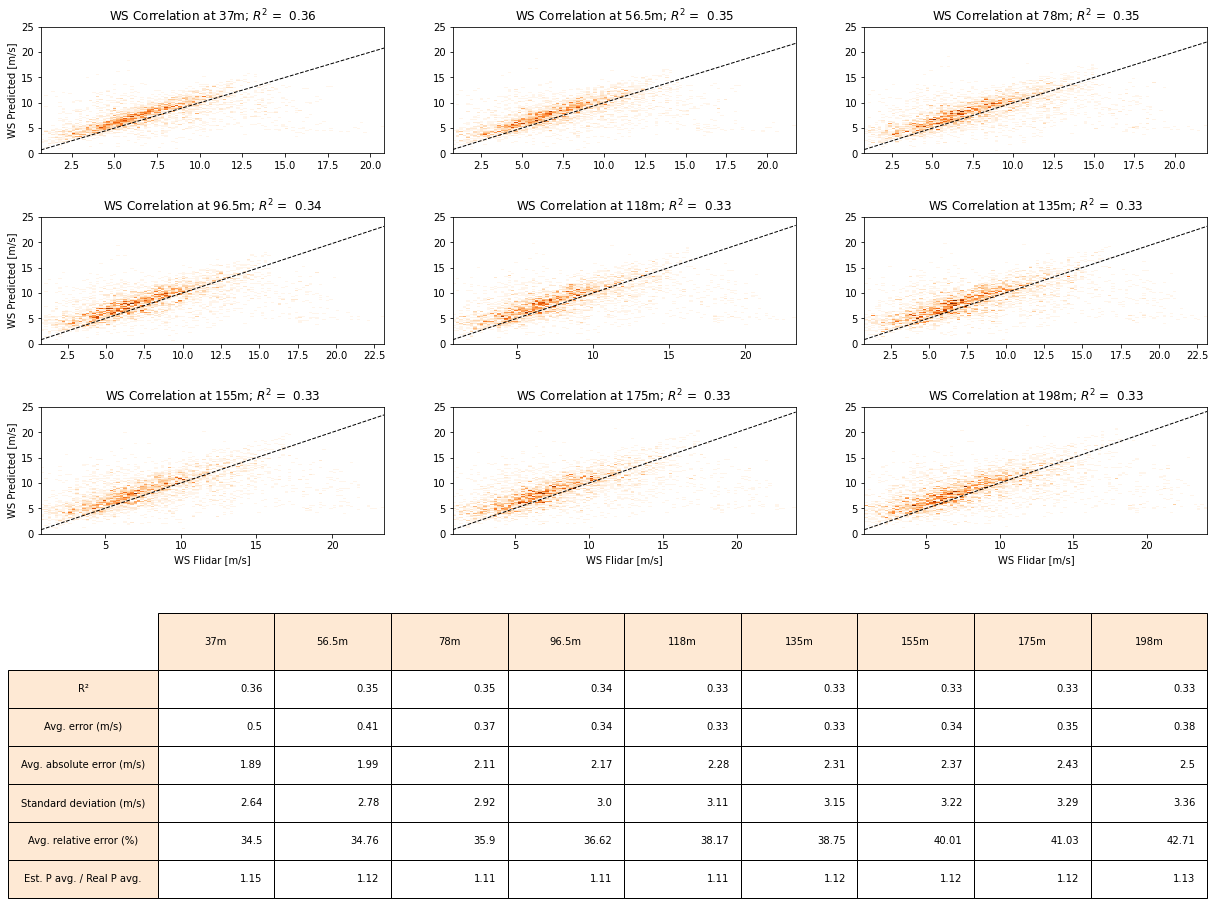

In [87]:
# Testing site NOY

df_X_train, df_X_test, df_X_test2, df_y_train, df_y_test, df_y_test2 = split(df_Xy_NOY, ratio)

gbm = CatBoostRegressor(iterations=1438, l2_leaf_reg=6, loss_function="MultiRMSE", learning_rate=0.29913437487258504, colsample_bylevel=0.0999624030311462, max_depth=14, random_strength=0.00011723163307431312, boosting_type="Plain", bootstrap_type="MVS")
gbm.fit(df_X_train, df_y_train)
test_model(gbm, heights, ["global"], "No", df_X_test2, df_y_test2)